In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 36
    popular_weeks = 1
    train_weeks = 5
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    ohe_distance_num_items = 32
    ohe_distance_num_weeks = 1
    dynamic_feature_weeks = 8
    volume_feature_weeks = 1

In [5]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [6]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 9.667 s


[popular] 0.547 s


[item2item] 8.710 s


[cooccurrence] 15.892 s


[same_product_code] 6.083 s


[ohe distance] 13.099 s


volume: 15991626


duplicates: 1.0552836520584024


            strategy   volume     ratio
0  same_product_code  6876142  0.429984
1         repurchase  3446562  0.215523
2                pop  2483424  0.155295
3       ohe_distance  1981757  0.123925
4               cooc  1203741  0.075273


create candidates (week: 2)


[repurchase] 10.292 s


[popular] 0.581 s


[item2item] 9.299 s


[cooccurrence] 17.635 s


[same_product_code] 6.295 s


[ohe distance] 12.636 s


volume: 16956677


duplicates: 1.0592206643477098


            strategy   volume     ratio
0  same_product_code  7228749  0.426307
1         repurchase  3637145  0.214496
2                pop  2592684  0.152900
3       ohe_distance  2080062  0.122669
4               cooc  1418037  0.083627


create candidates (week: 3)


[repurchase] 10.355 s


[popular] 0.619 s


[item2item] 9.626 s


[cooccurrence] 17.820 s


[same_product_code] 6.432 s


[ohe distance] 12.811 s


volume: 17930210


duplicates: 1.0620907696093247


            strategy   volume     ratio
0  same_product_code  7678831  0.428262
1         repurchase  3742824  0.208744
2                pop  2729592  0.152234
3       ohe_distance  2188278  0.122044
4               cooc  1590685  0.088715


create candidates (week: 4)


[repurchase] 10.992 s


[popular] 0.631 s


[item2item] 10.065 s


[cooccurrence] 18.475 s


[same_product_code] 7.220 s


[ohe distance] 12.892 s


volume: 19100294


duplicates: 1.066212805655061


            strategy   volume     ratio
0  same_product_code  8177755  0.428148
1         repurchase  3915353  0.204989
2                pop  2889108  0.151260
3       ohe_distance  2320500  0.121490
4               cooc  1797578  0.094113


create candidates (week: 5)


[repurchase] 10.014 s


[popular] 0.585 s


[item2item] 9.223 s


[cooccurrence] 19.050 s


[same_product_code] 6.249 s


[ohe distance] 18.038 s


volume: 17408764


duplicates: 1.069782681661812


            strategy   volume     ratio
0  same_product_code  7353615  0.422409
1         repurchase  3548895  0.203857
2                pop  2593260  0.148963
3       ohe_distance  2095741  0.120384
4               cooc  1817253  0.104387


create candidates (week: 6)


[repurchase] 10.068 s


[popular] 0.589 s


[item2item] 9.310 s


[cooccurrence] 20.189 s


[same_product_code] 6.441 s


[ohe distance] 12.832 s


volume: 17546841


duplicates: 1.0787386776598555


            strategy   volume     ratio
0  same_product_code  7341380  0.418388
1         repurchase  3547521  0.202174
2                pop  2559384  0.145860
3       ohe_distance  2080356  0.118560
4               cooc  2018200  0.115018


In [7]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [8]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.14038871837101363


            strategy        y   volume    recall  hit_ratio
0                pop  11811.0  2483424  0.055262   0.004756
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   7888.0  6876142  0.036907   0.001147
3               cooc   5096.0  1203741  0.023843   0.004233
4       ohe_distance   2440.0  1981757  0.011416   0.001231
merge labels (week: 1)


Recall: 0.13065683822561538


            strategy        y   volume    recall  hit_ratio
0                pop  10203.0  2592684  0.044768   0.003935
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   8554.0  7228749  0.037532   0.001183
3               cooc   5210.0  1418037  0.022860   0.003674
4       ohe_distance   2680.0  2080062  0.011759   0.001288
merge labels (week: 2)


Recall: 0.13371472735367995


            strategy        y   volume    recall  hit_ratio
0                pop  11942.0  2729592  0.050161   0.004375
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   8829.0  7678831  0.037085   0.001150
3               cooc   5376.0  1590685  0.022581   0.003380
4       ohe_distance   2526.0  2188278  0.010610   0.001154
merge labels (week: 3)


Recall: 0.13197372752496356


            strategy        y   volume    recall  hit_ratio
0                pop  13485.0  2889108  0.052847   0.004668
1  same_product_code   9328.0  8177755  0.036556   0.001141
2         repurchase   9002.0  3915353  0.035278   0.002299
3               cooc   5609.0  1797578  0.021981   0.003120
4       ohe_distance   2856.0  2320500  0.011192   0.001231
merge labels (week: 4)


Recall: 0.12992526806021878


            strategy       y   volume    recall  hit_ratio
0                pop  9552.0  2593260  0.041382   0.003683
1  same_product_code  9193.0  7353615  0.039827   0.001250
2         repurchase  8945.0  3548895  0.038752   0.002521
3               cooc  6350.0  1817253  0.027510   0.003494
4       ohe_distance  2501.0  2095741  0.010835   0.001193
merge labels (week: 5)


Recall: 0.12190504300893912


            strategy       y   volume    recall  hit_ratio
0         repurchase  9673.0  3547521  0.040787   0.002727
1  same_product_code  9115.0  7341380  0.038434   0.001242
2               cooc  7841.0  2018200  0.033062   0.003885
3                pop  7306.0  2559384  0.030806   0.002855
4       ohe_distance  2027.0  2080356  0.008547   0.000974


In [9]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 15991626 -> 5450623


drop trivial queries: 16956677 -> 5718264


drop trivial queries: 17930210 -> 6126511


drop trivial queries: 19100294 -> 6474396


drop trivial queries: 17408764 -> 5808285


drop trivial queries: 17546841 -> 5464869


In [10]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.933 s


[item stacic features] 5.198 s


[user dynamic features (transactions)] 3.617 s


[item dynamic features (transactions)] 2.983 s


[item dynamic features (user features)] 3.702 s


[item freshness features] 5.245 s


[item volume features] 3.288 s


[user freshness features] 7.086 s


[user volume features] 3.904 s


[user-item freshness features] 26.958 s


[user-item volume features] 6.805 s


[item age volume features] 5.669 s


[ohe dot products] 126.064 s


[lfm features] 9.509 s
attach features (week: 1)


[user static fetaures] 0.686 s


[item stacic features] 1.616 s


[user dynamic features (transactions)] 1.461 s


[item dynamic features (transactions)] 1.205 s


[item dynamic features (user features)] 1.682 s


[item freshness features] 3.258 s


[item volume features] 1.213 s


[user freshness features] 4.638 s


[user volume features] 1.391 s


[user-item freshness features] 23.004 s


[user-item volume features] 2.266 s


[item age volume features] 2.518 s


[ohe dot products] 62.195 s


[lfm features] 3.517 s
attach features (week: 2)


[user static fetaures] 0.712 s


[item stacic features] 1.698 s


[user dynamic features (transactions)] 1.513 s


[item dynamic features (transactions)] 1.240 s


[item dynamic features (user features)] 1.802 s


[item freshness features] 3.265 s


[item volume features] 1.273 s


[user freshness features] 4.614 s


[user volume features] 1.469 s


[user-item freshness features] 22.729 s


[user-item volume features] 2.321 s


[item age volume features] 2.548 s


[ohe dot products] 63.652 s


[lfm features] 3.534 s
attach features (week: 3)


[user static fetaures] 0.758 s


[item stacic features] 1.825 s


[user dynamic features (transactions)] 1.609 s


[item dynamic features (transactions)] 1.291 s


[item dynamic features (user features)] 1.876 s


[item freshness features] 3.315 s


[item volume features] 1.323 s


[user freshness features] 4.661 s


[user volume features] 1.514 s


[user-item freshness features] 22.758 s


[user-item volume features] 2.423 s


[item age volume features] 2.739 s


[ohe dot products] 66.417 s


[lfm features] 4.309 s
attach features (week: 4)


[user static fetaures] 0.797 s


[item stacic features] 1.966 s


[user dynamic features (transactions)] 1.675 s


[item dynamic features (transactions)] 1.372 s


[item dynamic features (user features)] 1.922 s


[item freshness features] 3.291 s


[item volume features] 1.376 s


[user freshness features] 4.651 s


[user volume features] 1.581 s


[user-item freshness features] 22.556 s


[user-item volume features] 2.538 s


[item age volume features] 2.757 s


[ohe dot products] 67.899 s


[lfm features] 4.446 s
attach features (week: 5)


[user static fetaures] 0.720 s


[item stacic features] 1.712 s


[user dynamic features (transactions)] 1.571 s


[item dynamic features (transactions)] 1.276 s


[item dynamic features (user features)] 1.840 s


[item freshness features] 3.141 s


[item volume features] 1.236 s


[user freshness features] 4.475 s


[user volume features] 1.430 s


[user-item freshness features] 22.295 s


[user-item volume features] 2.295 s


[item age volume features] 2.581 s


[ohe dot products] 63.871 s


[lfm features] 4.401 s
attach features (week: 6)


[user static fetaures] 0.673 s


[item stacic features] 1.623 s


[user dynamic features (transactions)] 1.544 s


[item dynamic features (transactions)] 1.245 s


[item dynamic features (user features)] 1.852 s


[item freshness features] 3.070 s


[item volume features] 1.161 s


[user freshness features] 4.364 s


[user volume features] 1.356 s


[user-item freshness features] 22.013 s


[user-item volume features] 2.169 s


[item age volume features] 2.498 s


[ohe dot products] 61.782 s


[lfm features] 4.330 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'ohe_distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_ohe_score', 'product_gr

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1262652	best: 0.1262652 (0)	total: 7.44s	remaining: 10h 20m 4s


1:	test: 0.1802239	best: 0.1802239 (1)	total: 14s	remaining: 9h 42m 34s


2:	test: 0.1890870	best: 0.1890870 (2)	total: 20.1s	remaining: 9h 19m 22s


3:	test: 0.1775968	best: 0.1890870 (2)	total: 26.9s	remaining: 9h 19m


4:	test: 0.2014920	best: 0.2014920 (4)	total: 33.2s	remaining: 9h 12m 13s


5:	test: 0.2017504	best: 0.2017504 (5)	total: 39.2s	remaining: 9h 4m 20s


6:	test: 0.1924874	best: 0.2017504 (5)	total: 44.7s	remaining: 8h 50m 50s


7:	test: 0.1952878	best: 0.2017504 (5)	total: 49.9s	remaining: 8h 39m 4s


8:	test: 0.2060323	best: 0.2060323 (8)	total: 55.1s	remaining: 8h 29m 28s


9:	test: 0.2072819	best: 0.2072819 (9)	total: 1m	remaining: 8h 20m 56s


10:	test: 0.2085538	best: 0.2085538 (10)	total: 1m 5s	remaining: 8h 13m 55s


11:	test: 0.2107175	best: 0.2107175 (11)	total: 1m 10s	remaining: 8h 8m 40s


12:	test: 0.2148754	best: 0.2148754 (12)	total: 1m 15s	remaining: 8h 4m 46s


13:	test: 0.2134872	best: 0.2148754 (12)	total: 1m 21s	remaining: 8h 2m 18s


14:	test: 0.2142923	best: 0.2148754 (12)	total: 1m 26s	remaining: 7h 59m 28s


15:	test: 0.2140016	best: 0.2148754 (12)	total: 1m 31s	remaining: 7h 56m 29s


16:	test: 0.2230206	best: 0.2230206 (16)	total: 1m 37s	remaining: 7h 55m 24s


17:	test: 0.2219250	best: 0.2230206 (16)	total: 1m 42s	remaining: 7h 54m 10s


18:	test: 0.2267774	best: 0.2267774 (18)	total: 1m 48s	remaining: 7h 53m 57s


19:	test: 0.2443719	best: 0.2443719 (19)	total: 1m 53s	remaining: 7h 52m 56s


20:	test: 0.2495242	best: 0.2495242 (20)	total: 1m 59s	remaining: 7h 51m 55s


21:	test: 0.2616186	best: 0.2616186 (21)	total: 2m 5s	remaining: 7h 51m 27s


22:	test: 0.2627386	best: 0.2627386 (22)	total: 2m 10s	remaining: 7h 50m 31s


23:	test: 0.2634042	best: 0.2634042 (23)	total: 2m 15s	remaining: 7h 49m 50s


24:	test: 0.2647038	best: 0.2647038 (24)	total: 2m 21s	remaining: 7h 49m 16s


25:	test: 0.2655739	best: 0.2655739 (25)	total: 2m 26s	remaining: 7h 48m 39s


26:	test: 0.2669049	best: 0.2669049 (26)	total: 2m 32s	remaining: 7h 47m 27s


27:	test: 0.2684281	best: 0.2684281 (27)	total: 2m 37s	remaining: 7h 46m 33s


28:	test: 0.2703657	best: 0.2703657 (28)	total: 2m 43s	remaining: 7h 46m 14s


29:	test: 0.2703020	best: 0.2703657 (28)	total: 2m 48s	remaining: 7h 44m 32s


30:	test: 0.2709063	best: 0.2709063 (30)	total: 2m 54s	remaining: 7h 44m 50s


31:	test: 0.2713258	best: 0.2713258 (31)	total: 2m 59s	remaining: 7h 44m 23s


32:	test: 0.2723216	best: 0.2723216 (32)	total: 3m 5s	remaining: 7h 44m 20s


33:	test: 0.2720527	best: 0.2723216 (32)	total: 3m 10s	remaining: 7h 43m 22s


34:	test: 0.2726375	best: 0.2726375 (34)	total: 3m 15s	remaining: 7h 42m 57s


35:	test: 0.2729051	best: 0.2729051 (35)	total: 3m 21s	remaining: 7h 42m 34s


36:	test: 0.2732080	best: 0.2732080 (36)	total: 3m 26s	remaining: 7h 41m 55s


37:	test: 0.2734873	best: 0.2734873 (37)	total: 3m 31s	remaining: 7h 41m 13s


38:	test: 0.2750509	best: 0.2750509 (38)	total: 3m 37s	remaining: 7h 40m 28s


39:	test: 0.2751645	best: 0.2751645 (39)	total: 3m 42s	remaining: 7h 40m 6s


40:	test: 0.2753616	best: 0.2753616 (40)	total: 3m 47s	remaining: 7h 39m 34s


41:	test: 0.2757625	best: 0.2757625 (41)	total: 3m 53s	remaining: 7h 39m 11s


42:	test: 0.2758909	best: 0.2758909 (42)	total: 3m 58s	remaining: 7h 38m 43s


43:	test: 0.2766543	best: 0.2766543 (43)	total: 4m 3s	remaining: 7h 38m 2s


44:	test: 0.2773482	best: 0.2773482 (44)	total: 4m 9s	remaining: 7h 37m 25s


45:	test: 0.2771821	best: 0.2773482 (44)	total: 4m 14s	remaining: 7h 37m


46:	test: 0.2771933	best: 0.2773482 (44)	total: 4m 19s	remaining: 7h 36m 11s


47:	test: 0.2777525	best: 0.2777525 (47)	total: 4m 24s	remaining: 7h 35m 28s


48:	test: 0.2782797	best: 0.2782797 (48)	total: 4m 30s	remaining: 7h 35m 10s


49:	test: 0.2785238	best: 0.2785238 (49)	total: 4m 35s	remaining: 7h 34m 28s


50:	test: 0.2787797	best: 0.2787797 (50)	total: 4m 40s	remaining: 7h 34m 5s


51:	test: 0.2791453	best: 0.2791453 (51)	total: 4m 46s	remaining: 7h 34m 1s


52:	test: 0.2796637	best: 0.2796637 (52)	total: 4m 51s	remaining: 7h 33m 43s


53:	test: 0.2797821	best: 0.2797821 (53)	total: 4m 57s	remaining: 7h 33m 31s


54:	test: 0.2815470	best: 0.2815470 (54)	total: 5m 2s	remaining: 7h 33m 17s


55:	test: 0.2821158	best: 0.2821158 (55)	total: 5m 7s	remaining: 7h 33m


56:	test: 0.2826778	best: 0.2826778 (56)	total: 5m 13s	remaining: 7h 33m 3s


57:	test: 0.2829745	best: 0.2829745 (57)	total: 5m 18s	remaining: 7h 32m 58s


58:	test: 0.2829613	best: 0.2829745 (57)	total: 5m 24s	remaining: 7h 32m 34s


59:	test: 0.2832672	best: 0.2832672 (59)	total: 5m 29s	remaining: 7h 32m 13s


60:	test: 0.2836418	best: 0.2836418 (60)	total: 5m 35s	remaining: 7h 32m 9s


61:	test: 0.2837776	best: 0.2837776 (61)	total: 5m 40s	remaining: 7h 31m 51s


62:	test: 0.2834680	best: 0.2837776 (61)	total: 5m 45s	remaining: 7h 31m 48s


63:	test: 0.2837642	best: 0.2837776 (61)	total: 5m 51s	remaining: 7h 31m 10s


64:	test: 0.2839684	best: 0.2839684 (64)	total: 5m 56s	remaining: 7h 30m 38s


65:	test: 0.2841534	best: 0.2841534 (65)	total: 6m 1s	remaining: 7h 30m 33s


66:	test: 0.2843185	best: 0.2843185 (66)	total: 6m 7s	remaining: 7h 30m 22s


67:	test: 0.2845288	best: 0.2845288 (67)	total: 6m 12s	remaining: 7h 30m 28s


68:	test: 0.2846836	best: 0.2846836 (68)	total: 6m 18s	remaining: 7h 30m 18s


69:	test: 0.2847709	best: 0.2847709 (69)	total: 6m 23s	remaining: 7h 29m 53s


70:	test: 0.2849575	best: 0.2849575 (70)	total: 6m 28s	remaining: 7h 29m 51s


71:	test: 0.2851884	best: 0.2851884 (71)	total: 6m 33s	remaining: 7h 29m 19s


72:	test: 0.2853055	best: 0.2853055 (72)	total: 6m 39s	remaining: 7h 28m 59s


73:	test: 0.2863659	best: 0.2863659 (73)	total: 6m 44s	remaining: 7h 28m 50s


74:	test: 0.2865423	best: 0.2865423 (74)	total: 6m 50s	remaining: 7h 29m 12s


75:	test: 0.2868442	best: 0.2868442 (75)	total: 6m 55s	remaining: 7h 28m 49s


76:	test: 0.2869451	best: 0.2869451 (76)	total: 7m	remaining: 7h 28m 35s


77:	test: 0.2870658	best: 0.2870658 (77)	total: 7m 6s	remaining: 7h 28m 26s


78:	test: 0.2871805	best: 0.2871805 (78)	total: 7m 11s	remaining: 7h 28m 14s


79:	test: 0.2872718	best: 0.2872718 (79)	total: 7m 17s	remaining: 7h 28m 12s


80:	test: 0.2874652	best: 0.2874652 (80)	total: 7m 22s	remaining: 7h 27m 56s


81:	test: 0.2885632	best: 0.2885632 (81)	total: 7m 28s	remaining: 7h 27m 49s


82:	test: 0.2889379	best: 0.2889379 (82)	total: 7m 33s	remaining: 7h 27m 30s


83:	test: 0.2891419	best: 0.2891419 (83)	total: 7m 38s	remaining: 7h 27m 37s


84:	test: 0.2892376	best: 0.2892376 (84)	total: 7m 44s	remaining: 7h 27m 21s


85:	test: 0.2894651	best: 0.2894651 (85)	total: 7m 49s	remaining: 7h 27m 16s


86:	test: 0.2897049	best: 0.2897049 (86)	total: 7m 54s	remaining: 7h 26m 58s


87:	test: 0.2897342	best: 0.2897342 (87)	total: 8m	remaining: 7h 26m 43s


88:	test: 0.2895869	best: 0.2897342 (87)	total: 8m 5s	remaining: 7h 26m 15s


89:	test: 0.2899715	best: 0.2899715 (89)	total: 8m 10s	remaining: 7h 26m 5s


90:	test: 0.2907415	best: 0.2907415 (90)	total: 8m 16s	remaining: 7h 25m 58s


91:	test: 0.2908919	best: 0.2908919 (91)	total: 8m 21s	remaining: 7h 26m 5s


92:	test: 0.2909211	best: 0.2909211 (92)	total: 8m 27s	remaining: 7h 25m 54s


93:	test: 0.2911412	best: 0.2911412 (93)	total: 8m 32s	remaining: 7h 25m 37s


94:	test: 0.2913824	best: 0.2913824 (94)	total: 8m 37s	remaining: 7h 25m 34s


95:	test: 0.2913583	best: 0.2913824 (94)	total: 8m 43s	remaining: 7h 25m 23s


96:	test: 0.2916877	best: 0.2916877 (96)	total: 8m 48s	remaining: 7h 25m 31s


97:	test: 0.2916679	best: 0.2916877 (96)	total: 8m 53s	remaining: 7h 25m 9s


98:	test: 0.2920749	best: 0.2920749 (98)	total: 8m 59s	remaining: 7h 24m 54s


99:	test: 0.2921835	best: 0.2921835 (99)	total: 9m 4s	remaining: 7h 24m 44s


100:	test: 0.2923540	best: 0.2923540 (100)	total: 9m 9s	remaining: 7h 24m 36s


101:	test: 0.2926225	best: 0.2926225 (101)	total: 9m 15s	remaining: 7h 24m 40s


102:	test: 0.2927459	best: 0.2927459 (102)	total: 9m 21s	remaining: 7h 24m 45s


103:	test: 0.2929371	best: 0.2929371 (103)	total: 9m 26s	remaining: 7h 24m 42s


104:	test: 0.2930284	best: 0.2930284 (104)	total: 9m 32s	remaining: 7h 24m 30s


105:	test: 0.2932041	best: 0.2932041 (105)	total: 9m 37s	remaining: 7h 24m 18s


106:	test: 0.2934555	best: 0.2934555 (106)	total: 9m 42s	remaining: 7h 24m 6s


107:	test: 0.2938376	best: 0.2938376 (107)	total: 9m 47s	remaining: 7h 23m 49s


108:	test: 0.2939810	best: 0.2939810 (108)	total: 9m 53s	remaining: 7h 23m 37s


109:	test: 0.2943078	best: 0.2943078 (109)	total: 9m 58s	remaining: 7h 23m 29s


110:	test: 0.2943671	best: 0.2943671 (110)	total: 10m 3s	remaining: 7h 23m 15s


111:	test: 0.2946259	best: 0.2946259 (111)	total: 10m 9s	remaining: 7h 23m 3s


112:	test: 0.2948299	best: 0.2948299 (112)	total: 10m 14s	remaining: 7h 22m 37s


113:	test: 0.2949863	best: 0.2949863 (113)	total: 10m 19s	remaining: 7h 22m 35s


114:	test: 0.2949401	best: 0.2949863 (113)	total: 10m 24s	remaining: 7h 22m 25s


115:	test: 0.2952335	best: 0.2952335 (115)	total: 10m 30s	remaining: 7h 22m 15s


116:	test: 0.2955459	best: 0.2955459 (116)	total: 10m 36s	remaining: 7h 22m 26s


117:	test: 0.2955760	best: 0.2955760 (117)	total: 10m 41s	remaining: 7h 22m 13s


118:	test: 0.2954877	best: 0.2955760 (117)	total: 10m 46s	remaining: 7h 21m 59s


119:	test: 0.2956516	best: 0.2956516 (119)	total: 10m 51s	remaining: 7h 21m 49s


120:	test: 0.2958810	best: 0.2958810 (120)	total: 10m 57s	remaining: 7h 21m 53s


121:	test: 0.2960579	best: 0.2960579 (121)	total: 11m 3s	remaining: 7h 21m 56s


122:	test: 0.2963178	best: 0.2963178 (122)	total: 11m 8s	remaining: 7h 21m 27s


123:	test: 0.2964438	best: 0.2964438 (123)	total: 11m 13s	remaining: 7h 21m 7s


124:	test: 0.2965564	best: 0.2965564 (124)	total: 11m 18s	remaining: 7h 21m 2s


125:	test: 0.2968336	best: 0.2968336 (125)	total: 11m 24s	remaining: 7h 21m 5s


126:	test: 0.2968887	best: 0.2968887 (126)	total: 11m 29s	remaining: 7h 20m 59s


127:	test: 0.2970805	best: 0.2970805 (127)	total: 11m 35s	remaining: 7h 20m 57s


128:	test: 0.2970998	best: 0.2970998 (128)	total: 11m 40s	remaining: 7h 20m 50s


129:	test: 0.2972953	best: 0.2972953 (129)	total: 11m 45s	remaining: 7h 20m 36s


130:	test: 0.2972888	best: 0.2972953 (129)	total: 11m 51s	remaining: 7h 20m 26s


131:	test: 0.2972918	best: 0.2972953 (129)	total: 11m 56s	remaining: 7h 20m 18s


132:	test: 0.2974618	best: 0.2974618 (132)	total: 12m 1s	remaining: 7h 20m 1s


133:	test: 0.2974152	best: 0.2974618 (132)	total: 12m 6s	remaining: 7h 19m 48s


134:	test: 0.2974433	best: 0.2974618 (132)	total: 12m 11s	remaining: 7h 19m 34s


135:	test: 0.2974951	best: 0.2974951 (135)	total: 12m 17s	remaining: 7h 19m 20s


136:	test: 0.2976621	best: 0.2976621 (136)	total: 12m 22s	remaining: 7h 19m 22s


137:	test: 0.2980276	best: 0.2980276 (137)	total: 12m 27s	remaining: 7h 19m 12s


138:	test: 0.2981210	best: 0.2981210 (138)	total: 12m 33s	remaining: 7h 19m 1s


139:	test: 0.2982155	best: 0.2982155 (139)	total: 12m 38s	remaining: 7h 18m 42s


140:	test: 0.2984320	best: 0.2984320 (140)	total: 12m 43s	remaining: 7h 18m 39s


141:	test: 0.2987751	best: 0.2987751 (141)	total: 12m 49s	remaining: 7h 18m 29s


142:	test: 0.2989815	best: 0.2989815 (142)	total: 12m 54s	remaining: 7h 18m 15s


143:	test: 0.2991441	best: 0.2991441 (143)	total: 12m 59s	remaining: 7h 17m 49s


144:	test: 0.2993266	best: 0.2993266 (144)	total: 13m 4s	remaining: 7h 17m 42s


145:	test: 0.2995105	best: 0.2995105 (145)	total: 13m 9s	remaining: 7h 17m 32s


146:	test: 0.2996606	best: 0.2996606 (146)	total: 13m 14s	remaining: 7h 17m 15s


147:	test: 0.2996938	best: 0.2996938 (147)	total: 13m 20s	remaining: 7h 17m 9s


148:	test: 0.2996616	best: 0.2996938 (147)	total: 13m 25s	remaining: 7h 17m 6s


149:	test: 0.2998445	best: 0.2998445 (149)	total: 13m 30s	remaining: 7h 16m 54s


150:	test: 0.2999683	best: 0.2999683 (150)	total: 13m 35s	remaining: 7h 16m 43s


151:	test: 0.2999888	best: 0.2999888 (151)	total: 13m 41s	remaining: 7h 16m 37s


152:	test: 0.3001078	best: 0.3001078 (152)	total: 13m 46s	remaining: 7h 16m 36s


153:	test: 0.3005217	best: 0.3005217 (153)	total: 13m 52s	remaining: 7h 16m 25s


154:	test: 0.3005722	best: 0.3005722 (154)	total: 13m 57s	remaining: 7h 16m 8s


155:	test: 0.3009319	best: 0.3009319 (155)	total: 14m 2s	remaining: 7h 15m 59s


156:	test: 0.3011236	best: 0.3011236 (156)	total: 14m 7s	remaining: 7h 15m 52s


157:	test: 0.3014030	best: 0.3014030 (157)	total: 14m 12s	remaining: 7h 15m 33s


158:	test: 0.3016777	best: 0.3016777 (158)	total: 14m 18s	remaining: 7h 15m 23s


159:	test: 0.3017330	best: 0.3017330 (159)	total: 14m 23s	remaining: 7h 15m 12s


160:	test: 0.3019151	best: 0.3019151 (160)	total: 14m 28s	remaining: 7h 15m 3s


161:	test: 0.3021435	best: 0.3021435 (161)	total: 14m 33s	remaining: 7h 14m 43s


162:	test: 0.3022077	best: 0.3022077 (162)	total: 14m 38s	remaining: 7h 14m 30s


163:	test: 0.3022174	best: 0.3022174 (163)	total: 14m 43s	remaining: 7h 14m 15s


164:	test: 0.3022034	best: 0.3022174 (163)	total: 14m 49s	remaining: 7h 14m 15s


165:	test: 0.3023336	best: 0.3023336 (165)	total: 14m 54s	remaining: 7h 14m 2s


166:	test: 0.3024431	best: 0.3024431 (166)	total: 15m	remaining: 7h 14m 8s


167:	test: 0.3026955	best: 0.3026955 (167)	total: 15m 5s	remaining: 7h 14m 5s


168:	test: 0.3026987	best: 0.3026987 (168)	total: 15m 11s	remaining: 7h 14m 10s


169:	test: 0.3026105	best: 0.3026987 (168)	total: 15m 16s	remaining: 7h 14m 3s


170:	test: 0.3026768	best: 0.3026987 (168)	total: 15m 21s	remaining: 7h 13m 45s


171:	test: 0.3026809	best: 0.3026987 (168)	total: 15m 26s	remaining: 7h 13m 39s


172:	test: 0.3026916	best: 0.3026987 (168)	total: 15m 32s	remaining: 7h 13m 44s


173:	test: 0.3027489	best: 0.3027489 (173)	total: 15m 37s	remaining: 7h 13m 30s


174:	test: 0.3028969	best: 0.3028969 (174)	total: 15m 43s	remaining: 7h 13m 20s


175:	test: 0.3030576	best: 0.3030576 (175)	total: 15m 48s	remaining: 7h 13m 14s


176:	test: 0.3032574	best: 0.3032574 (176)	total: 15m 53s	remaining: 7h 13m 12s


177:	test: 0.3034183	best: 0.3034183 (177)	total: 15m 59s	remaining: 7h 13m 3s


178:	test: 0.3035512	best: 0.3035512 (178)	total: 16m 3s	remaining: 7h 12m 43s


179:	test: 0.3036698	best: 0.3036698 (179)	total: 16m 9s	remaining: 7h 12m 34s


180:	test: 0.3038301	best: 0.3038301 (180)	total: 16m 14s	remaining: 7h 12m 28s


181:	test: 0.3040662	best: 0.3040662 (181)	total: 16m 19s	remaining: 7h 12m 18s


182:	test: 0.3041177	best: 0.3041177 (182)	total: 16m 25s	remaining: 7h 12m 14s


183:	test: 0.3043373	best: 0.3043373 (183)	total: 16m 30s	remaining: 7h 12m 2s


184:	test: 0.3043290	best: 0.3043373 (183)	total: 16m 35s	remaining: 7h 11m 54s


185:	test: 0.3044127	best: 0.3044127 (185)	total: 16m 41s	remaining: 7h 11m 54s


186:	test: 0.3046277	best: 0.3046277 (186)	total: 16m 46s	remaining: 7h 11m 37s


187:	test: 0.3046431	best: 0.3046431 (187)	total: 16m 51s	remaining: 7h 11m 28s


188:	test: 0.3047210	best: 0.3047210 (188)	total: 16m 56s	remaining: 7h 11m 19s


189:	test: 0.3048765	best: 0.3048765 (189)	total: 17m 2s	remaining: 7h 11m 15s


190:	test: 0.3049968	best: 0.3049968 (190)	total: 17m 7s	remaining: 7h 11m 3s


191:	test: 0.3051558	best: 0.3051558 (191)	total: 17m 12s	remaining: 7h 10m 59s


192:	test: 0.3051296	best: 0.3051558 (191)	total: 17m 17s	remaining: 7h 10m 50s


193:	test: 0.3052533	best: 0.3052533 (193)	total: 17m 23s	remaining: 7h 10m 51s


194:	test: 0.3052493	best: 0.3052533 (193)	total: 17m 28s	remaining: 7h 10m 37s


195:	test: 0.3054300	best: 0.3054300 (195)	total: 17m 33s	remaining: 7h 10m 32s


196:	test: 0.3054700	best: 0.3054700 (196)	total: 17m 39s	remaining: 7h 10m 20s


197:	test: 0.3056421	best: 0.3056421 (197)	total: 17m 44s	remaining: 7h 10m 6s


198:	test: 0.3056429	best: 0.3056429 (198)	total: 17m 49s	remaining: 7h 10m 3s


199:	test: 0.3057490	best: 0.3057490 (199)	total: 17m 54s	remaining: 7h 9m 52s


200:	test: 0.3058154	best: 0.3058154 (200)	total: 17m 59s	remaining: 7h 9m 43s


201:	test: 0.3058754	best: 0.3058754 (201)	total: 18m 5s	remaining: 7h 9m 33s


202:	test: 0.3059845	best: 0.3059845 (202)	total: 18m 10s	remaining: 7h 9m 22s


203:	test: 0.3061720	best: 0.3061720 (203)	total: 18m 15s	remaining: 7h 9m 23s


204:	test: 0.3062380	best: 0.3062380 (204)	total: 18m 21s	remaining: 7h 9m 24s


205:	test: 0.3063653	best: 0.3063653 (205)	total: 18m 26s	remaining: 7h 9m 12s


206:	test: 0.3063613	best: 0.3063653 (205)	total: 18m 31s	remaining: 7h 9m 1s


207:	test: 0.3063807	best: 0.3063807 (207)	total: 18m 37s	remaining: 7h 9m 1s


208:	test: 0.3064217	best: 0.3064217 (208)	total: 18m 42s	remaining: 7h 8m 54s


209:	test: 0.3064762	best: 0.3064762 (209)	total: 18m 48s	remaining: 7h 8m 50s


210:	test: 0.3064627	best: 0.3064762 (209)	total: 18m 53s	remaining: 7h 8m 41s


211:	test: 0.3066159	best: 0.3066159 (211)	total: 18m 58s	remaining: 7h 8m 39s


212:	test: 0.3067666	best: 0.3067666 (212)	total: 19m 3s	remaining: 7h 8m 25s


213:	test: 0.3069288	best: 0.3069288 (213)	total: 19m 8s	remaining: 7h 8m 13s


214:	test: 0.3070257	best: 0.3070257 (214)	total: 19m 13s	remaining: 7h 8m 1s


215:	test: 0.3071538	best: 0.3071538 (215)	total: 19m 19s	remaining: 7h 7m 57s


216:	test: 0.3070989	best: 0.3071538 (215)	total: 19m 25s	remaining: 7h 7m 59s


217:	test: 0.3072751	best: 0.3072751 (217)	total: 19m 30s	remaining: 7h 7m 57s


218:	test: 0.3074954	best: 0.3074954 (218)	total: 19m 35s	remaining: 7h 7m 48s


219:	test: 0.3076055	best: 0.3076055 (219)	total: 19m 41s	remaining: 7h 7m 42s


220:	test: 0.3074513	best: 0.3076055 (219)	total: 19m 46s	remaining: 7h 7m 34s


221:	test: 0.3075299	best: 0.3076055 (219)	total: 19m 51s	remaining: 7h 7m 33s


222:	test: 0.3076337	best: 0.3076337 (222)	total: 19m 56s	remaining: 7h 7m 18s


223:	test: 0.3075752	best: 0.3076337 (222)	total: 20m 1s	remaining: 7h 7m 6s


224:	test: 0.3076283	best: 0.3076337 (222)	total: 20m 7s	remaining: 7h 6m 57s


225:	test: 0.3077670	best: 0.3077670 (225)	total: 20m 12s	remaining: 7h 6m 45s


226:	test: 0.3079299	best: 0.3079299 (226)	total: 20m 17s	remaining: 7h 6m 37s


227:	test: 0.3079476	best: 0.3079476 (227)	total: 20m 22s	remaining: 7h 6m 25s


228:	test: 0.3080841	best: 0.3080841 (228)	total: 20m 27s	remaining: 7h 6m 21s


229:	test: 0.3080856	best: 0.3080856 (229)	total: 20m 33s	remaining: 7h 6m 13s


230:	test: 0.3080980	best: 0.3080980 (230)	total: 20m 38s	remaining: 7h 6m 5s


231:	test: 0.3080690	best: 0.3080980 (230)	total: 20m 43s	remaining: 7h 5m 55s


232:	test: 0.3082002	best: 0.3082002 (232)	total: 20m 48s	remaining: 7h 5m 52s


233:	test: 0.3082915	best: 0.3082915 (233)	total: 20m 54s	remaining: 7h 5m 43s


234:	test: 0.3081497	best: 0.3082915 (233)	total: 20m 59s	remaining: 7h 5m 36s


235:	test: 0.3081633	best: 0.3082915 (233)	total: 21m 4s	remaining: 7h 5m 28s


236:	test: 0.3082301	best: 0.3082915 (233)	total: 21m 9s	remaining: 7h 5m 16s


237:	test: 0.3082505	best: 0.3082915 (233)	total: 21m 14s	remaining: 7h 5m 8s


238:	test: 0.3082078	best: 0.3082915 (233)	total: 21m 20s	remaining: 7h 5m 10s


239:	test: 0.3083702	best: 0.3083702 (239)	total: 21m 25s	remaining: 7h 4m 55s


240:	test: 0.3083634	best: 0.3083702 (239)	total: 21m 30s	remaining: 7h 4m 49s


241:	test: 0.3086535	best: 0.3086535 (241)	total: 21m 36s	remaining: 7h 4m 47s


242:	test: 0.3087279	best: 0.3087279 (242)	total: 21m 41s	remaining: 7h 4m 42s


243:	test: 0.3087447	best: 0.3087447 (243)	total: 21m 46s	remaining: 7h 4m 33s


244:	test: 0.3087986	best: 0.3087986 (244)	total: 21m 52s	remaining: 7h 4m 26s


245:	test: 0.3088590	best: 0.3088590 (245)	total: 21m 57s	remaining: 7h 4m 16s


246:	test: 0.3087919	best: 0.3088590 (245)	total: 22m 2s	remaining: 7h 4m 17s


247:	test: 0.3087495	best: 0.3088590 (245)	total: 22m 8s	remaining: 7h 4m 9s


248:	test: 0.3088102	best: 0.3088590 (245)	total: 22m 13s	remaining: 7h 3m 54s


249:	test: 0.3088432	best: 0.3088590 (245)	total: 22m 18s	remaining: 7h 3m 49s


250:	test: 0.3090153	best: 0.3090153 (250)	total: 22m 23s	remaining: 7h 3m 38s


251:	test: 0.3090408	best: 0.3090408 (251)	total: 22m 28s	remaining: 7h 3m 28s


252:	test: 0.3091128	best: 0.3091128 (252)	total: 22m 33s	remaining: 7h 3m 20s


253:	test: 0.3091195	best: 0.3091195 (253)	total: 22m 38s	remaining: 7h 3m 11s


254:	test: 0.3092205	best: 0.3092205 (254)	total: 22m 43s	remaining: 7h 2m 57s


255:	test: 0.3092891	best: 0.3092891 (255)	total: 22m 48s	remaining: 7h 2m 47s


256:	test: 0.3093560	best: 0.3093560 (256)	total: 22m 54s	remaining: 7h 2m 42s


257:	test: 0.3097426	best: 0.3097426 (257)	total: 22m 59s	remaining: 7h 2m 36s


258:	test: 0.3098382	best: 0.3098382 (258)	total: 23m 4s	remaining: 7h 2m 27s


259:	test: 0.3098534	best: 0.3098534 (259)	total: 23m 9s	remaining: 7h 2m 19s


260:	test: 0.3098956	best: 0.3098956 (260)	total: 23m 15s	remaining: 7h 2m 11s


261:	test: 0.3098785	best: 0.3098956 (260)	total: 23m 20s	remaining: 7h 2m 4s


262:	test: 0.3101010	best: 0.3101010 (262)	total: 23m 25s	remaining: 7h 2m


263:	test: 0.3101528	best: 0.3101528 (263)	total: 23m 31s	remaining: 7h 1m 53s


264:	test: 0.3102417	best: 0.3102417 (264)	total: 23m 36s	remaining: 7h 1m 45s


265:	test: 0.3103493	best: 0.3103493 (265)	total: 23m 41s	remaining: 7h 1m 34s


266:	test: 0.3104611	best: 0.3104611 (266)	total: 23m 46s	remaining: 7h 1m 27s


267:	test: 0.3105842	best: 0.3105842 (267)	total: 23m 51s	remaining: 7h 1m 18s


268:	test: 0.3104610	best: 0.3105842 (267)	total: 23m 56s	remaining: 7h 1m 12s


269:	test: 0.3107952	best: 0.3107952 (269)	total: 24m 2s	remaining: 7h 1m 7s


270:	test: 0.3108060	best: 0.3108060 (270)	total: 24m 7s	remaining: 7h 1m 5s


271:	test: 0.3109840	best: 0.3109840 (271)	total: 24m 13s	remaining: 7h 1m 1s


272:	test: 0.3110008	best: 0.3110008 (272)	total: 24m 18s	remaining: 7h 1m 1s


273:	test: 0.3109296	best: 0.3110008 (272)	total: 24m 24s	remaining: 7h 58s


274:	test: 0.3109765	best: 0.3110008 (272)	total: 24m 29s	remaining: 7h 50s


275:	test: 0.3111143	best: 0.3111143 (275)	total: 24m 34s	remaining: 7h 42s


276:	test: 0.3110847	best: 0.3111143 (275)	total: 24m 40s	remaining: 7h 39s


277:	test: 0.3111306	best: 0.3111306 (277)	total: 24m 45s	remaining: 7h 31s


278:	test: 0.3112227	best: 0.3112227 (278)	total: 24m 50s	remaining: 7h 18s


279:	test: 0.3113150	best: 0.3113150 (279)	total: 24m 55s	remaining: 7h 10s


280:	test: 0.3113436	best: 0.3113436 (280)	total: 25m	remaining: 7h 2s


281:	test: 0.3113175	best: 0.3113436 (280)	total: 25m 5s	remaining: 6h 59m 56s


282:	test: 0.3113701	best: 0.3113701 (282)	total: 25m 11s	remaining: 6h 59m 46s


283:	test: 0.3112984	best: 0.3113701 (282)	total: 25m 16s	remaining: 6h 59m 38s


284:	test: 0.3114453	best: 0.3114453 (284)	total: 25m 21s	remaining: 6h 59m 37s


285:	test: 0.3114590	best: 0.3114590 (285)	total: 25m 26s	remaining: 6h 59m 27s


286:	test: 0.3115202	best: 0.3115202 (286)	total: 25m 32s	remaining: 6h 59m 25s


287:	test: 0.3115957	best: 0.3115957 (287)	total: 25m 37s	remaining: 6h 59m 14s


288:	test: 0.3115550	best: 0.3115957 (287)	total: 25m 42s	remaining: 6h 59m 5s


289:	test: 0.3115826	best: 0.3115957 (287)	total: 25m 47s	remaining: 6h 58m 59s


290:	test: 0.3116991	best: 0.3116991 (290)	total: 25m 53s	remaining: 6h 58m 57s


291:	test: 0.3116900	best: 0.3116991 (290)	total: 25m 58s	remaining: 6h 58m 46s


292:	test: 0.3116815	best: 0.3116991 (290)	total: 26m 3s	remaining: 6h 58m 36s


293:	test: 0.3116765	best: 0.3116991 (290)	total: 26m 8s	remaining: 6h 58m 22s


294:	test: 0.3117882	best: 0.3117882 (294)	total: 26m 13s	remaining: 6h 58m 17s


295:	test: 0.3119005	best: 0.3119005 (295)	total: 26m 18s	remaining: 6h 58m 10s


296:	test: 0.3118752	best: 0.3119005 (295)	total: 26m 24s	remaining: 6h 58m 8s


297:	test: 0.3119850	best: 0.3119850 (297)	total: 26m 29s	remaining: 6h 58m 3s


298:	test: 0.3119963	best: 0.3119963 (298)	total: 26m 34s	remaining: 6h 57m 54s


299:	test: 0.3119496	best: 0.3119963 (298)	total: 26m 40s	remaining: 6h 57m 57s


300:	test: 0.3120842	best: 0.3120842 (300)	total: 26m 46s	remaining: 6h 58m


301:	test: 0.3121127	best: 0.3121127 (301)	total: 26m 51s	remaining: 6h 57m 54s


302:	test: 0.3120957	best: 0.3121127 (301)	total: 26m 57s	remaining: 6h 57m 52s


303:	test: 0.3121371	best: 0.3121371 (303)	total: 27m 2s	remaining: 6h 57m 38s


304:	test: 0.3122308	best: 0.3122308 (304)	total: 27m 7s	remaining: 6h 57m 39s


305:	test: 0.3122215	best: 0.3122308 (304)	total: 27m 13s	remaining: 6h 57m 35s


306:	test: 0.3122689	best: 0.3122689 (306)	total: 27m 18s	remaining: 6h 57m 26s


307:	test: 0.3124022	best: 0.3124022 (307)	total: 27m 23s	remaining: 6h 57m 18s


308:	test: 0.3125489	best: 0.3125489 (308)	total: 27m 28s	remaining: 6h 57m 5s


309:	test: 0.3125544	best: 0.3125544 (309)	total: 27m 33s	remaining: 6h 56m 58s


310:	test: 0.3126263	best: 0.3126263 (310)	total: 27m 39s	remaining: 6h 56m 58s


311:	test: 0.3126468	best: 0.3126468 (311)	total: 27m 44s	remaining: 6h 56m 50s


312:	test: 0.3126452	best: 0.3126468 (311)	total: 27m 49s	remaining: 6h 56m 38s


313:	test: 0.3126493	best: 0.3126493 (313)	total: 27m 54s	remaining: 6h 56m 27s


314:	test: 0.3126575	best: 0.3126575 (314)	total: 27m 59s	remaining: 6h 56m 20s


315:	test: 0.3126721	best: 0.3126721 (315)	total: 28m 4s	remaining: 6h 56m 13s


316:	test: 0.3127354	best: 0.3127354 (316)	total: 28m 9s	remaining: 6h 56m 4s


317:	test: 0.3127934	best: 0.3127934 (317)	total: 28m 15s	remaining: 6h 56m


318:	test: 0.3129643	best: 0.3129643 (318)	total: 28m 20s	remaining: 6h 55m 53s


319:	test: 0.3129058	best: 0.3129643 (318)	total: 28m 25s	remaining: 6h 55m 46s


320:	test: 0.3129236	best: 0.3129643 (318)	total: 28m 30s	remaining: 6h 55m 36s


321:	test: 0.3129700	best: 0.3129700 (321)	total: 28m 35s	remaining: 6h 55m 28s


322:	test: 0.3129680	best: 0.3129700 (321)	total: 28m 40s	remaining: 6h 55m 18s


323:	test: 0.3131666	best: 0.3131666 (323)	total: 28m 46s	remaining: 6h 55m 11s


324:	test: 0.3131553	best: 0.3131666 (323)	total: 28m 51s	remaining: 6h 55m 2s


325:	test: 0.3131819	best: 0.3131819 (325)	total: 28m 56s	remaining: 6h 54m 49s


326:	test: 0.3132573	best: 0.3132573 (326)	total: 29m	remaining: 6h 54m 37s


327:	test: 0.3131301	best: 0.3132573 (326)	total: 29m 5s	remaining: 6h 54m 25s


328:	test: 0.3130742	best: 0.3132573 (326)	total: 29m 10s	remaining: 6h 54m 16s


329:	test: 0.3132077	best: 0.3132573 (326)	total: 29m 15s	remaining: 6h 54m 8s


330:	test: 0.3131409	best: 0.3132573 (326)	total: 29m 21s	remaining: 6h 54m 2s


331:	test: 0.3131594	best: 0.3132573 (326)	total: 29m 25s	remaining: 6h 53m 47s


332:	test: 0.3133233	best: 0.3133233 (332)	total: 29m 30s	remaining: 6h 53m 38s


333:	test: 0.3134427	best: 0.3134427 (333)	total: 29m 36s	remaining: 6h 53m 30s


334:	test: 0.3135048	best: 0.3135048 (334)	total: 29m 41s	remaining: 6h 53m 23s


335:	test: 0.3135459	best: 0.3135459 (335)	total: 29m 46s	remaining: 6h 53m 15s


336:	test: 0.3136493	best: 0.3136493 (336)	total: 29m 51s	remaining: 6h 53m 7s


337:	test: 0.3136985	best: 0.3136985 (337)	total: 29m 56s	remaining: 6h 53m 2s


338:	test: 0.3137919	best: 0.3137919 (338)	total: 30m 1s	remaining: 6h 52m 54s


339:	test: 0.3138750	best: 0.3138750 (339)	total: 30m 6s	remaining: 6h 52m 43s


340:	test: 0.3139926	best: 0.3139926 (340)	total: 30m 12s	remaining: 6h 52m 39s


341:	test: 0.3139993	best: 0.3139993 (341)	total: 30m 17s	remaining: 6h 52m 33s


342:	test: 0.3140546	best: 0.3140546 (342)	total: 30m 22s	remaining: 6h 52m 25s


343:	test: 0.3140547	best: 0.3140547 (343)	total: 30m 27s	remaining: 6h 52m 16s


344:	test: 0.3140872	best: 0.3140872 (344)	total: 30m 32s	remaining: 6h 52m 6s


345:	test: 0.3141009	best: 0.3141009 (345)	total: 30m 37s	remaining: 6h 52m


346:	test: 0.3141019	best: 0.3141019 (346)	total: 30m 43s	remaining: 6h 51m 54s


347:	test: 0.3141792	best: 0.3141792 (347)	total: 30m 48s	remaining: 6h 51m 46s


348:	test: 0.3143421	best: 0.3143421 (348)	total: 30m 53s	remaining: 6h 51m 44s


349:	test: 0.3143443	best: 0.3143443 (349)	total: 30m 58s	remaining: 6h 51m 36s


350:	test: 0.3144574	best: 0.3144574 (350)	total: 31m 3s	remaining: 6h 51m 26s


351:	test: 0.3144569	best: 0.3144574 (350)	total: 31m 9s	remaining: 6h 51m 20s


352:	test: 0.3144170	best: 0.3144574 (350)	total: 31m 14s	remaining: 6h 51m 15s


353:	test: 0.3144537	best: 0.3144574 (350)	total: 31m 19s	remaining: 6h 51m 7s


354:	test: 0.3144171	best: 0.3144574 (350)	total: 31m 25s	remaining: 6h 51m 4s


355:	test: 0.3144484	best: 0.3144574 (350)	total: 31m 30s	remaining: 6h 51m 4s


356:	test: 0.3144977	best: 0.3144977 (356)	total: 31m 35s	remaining: 6h 50m 58s


357:	test: 0.3145053	best: 0.3145053 (357)	total: 31m 41s	remaining: 6h 50m 51s


358:	test: 0.3145943	best: 0.3145943 (358)	total: 31m 46s	remaining: 6h 50m 48s


359:	test: 0.3145859	best: 0.3145943 (358)	total: 31m 51s	remaining: 6h 50m 41s


360:	test: 0.3147483	best: 0.3147483 (360)	total: 31m 56s	remaining: 6h 50m 33s


361:	test: 0.3148420	best: 0.3148420 (361)	total: 32m 2s	remaining: 6h 50m 29s


362:	test: 0.3148802	best: 0.3148802 (362)	total: 32m 7s	remaining: 6h 50m 21s


363:	test: 0.3149432	best: 0.3149432 (363)	total: 32m 12s	remaining: 6h 50m 12s


364:	test: 0.3148941	best: 0.3149432 (363)	total: 32m 17s	remaining: 6h 50m


365:	test: 0.3147953	best: 0.3149432 (363)	total: 32m 22s	remaining: 6h 49m 49s


366:	test: 0.3149899	best: 0.3149899 (366)	total: 32m 27s	remaining: 6h 49m 43s


367:	test: 0.3150526	best: 0.3150526 (367)	total: 32m 32s	remaining: 6h 49m 35s


368:	test: 0.3150583	best: 0.3150583 (368)	total: 32m 37s	remaining: 6h 49m 29s


369:	test: 0.3150778	best: 0.3150778 (369)	total: 32m 42s	remaining: 6h 49m 20s


370:	test: 0.3151712	best: 0.3151712 (370)	total: 32m 47s	remaining: 6h 49m 8s


371:	test: 0.3151726	best: 0.3151726 (371)	total: 32m 52s	remaining: 6h 49m 2s


372:	test: 0.3152231	best: 0.3152231 (372)	total: 32m 57s	remaining: 6h 48m 49s


373:	test: 0.3152806	best: 0.3152806 (373)	total: 33m 2s	remaining: 6h 48m 43s


374:	test: 0.3152466	best: 0.3152806 (373)	total: 33m 7s	remaining: 6h 48m 33s


375:	test: 0.3152967	best: 0.3152967 (375)	total: 33m 12s	remaining: 6h 48m 27s


376:	test: 0.3153438	best: 0.3153438 (376)	total: 33m 18s	remaining: 6h 48m 22s


377:	test: 0.3153100	best: 0.3153438 (376)	total: 33m 23s	remaining: 6h 48m 15s


378:	test: 0.3153762	best: 0.3153762 (378)	total: 33m 28s	remaining: 6h 48m 12s


379:	test: 0.3154139	best: 0.3154139 (379)	total: 33m 34s	remaining: 6h 48m 8s


380:	test: 0.3153793	best: 0.3154139 (379)	total: 33m 39s	remaining: 6h 48m


381:	test: 0.3154399	best: 0.3154399 (381)	total: 33m 44s	remaining: 6h 47m 49s


382:	test: 0.3153780	best: 0.3154399 (381)	total: 33m 49s	remaining: 6h 47m 43s


383:	test: 0.3154478	best: 0.3154478 (383)	total: 33m 54s	remaining: 6h 47m 37s


384:	test: 0.3154270	best: 0.3154478 (383)	total: 33m 59s	remaining: 6h 47m 22s


385:	test: 0.3154766	best: 0.3154766 (385)	total: 34m 4s	remaining: 6h 47m 15s


386:	test: 0.3154172	best: 0.3154766 (385)	total: 34m 9s	remaining: 6h 47m 9s


387:	test: 0.3154279	best: 0.3154766 (385)	total: 34m 14s	remaining: 6h 46m 59s


388:	test: 0.3153892	best: 0.3154766 (385)	total: 34m 19s	remaining: 6h 46m 51s


389:	test: 0.3155617	best: 0.3155617 (389)	total: 34m 24s	remaining: 6h 46m 42s


390:	test: 0.3154997	best: 0.3155617 (389)	total: 34m 29s	remaining: 6h 46m 37s


391:	test: 0.3156368	best: 0.3156368 (391)	total: 34m 34s	remaining: 6h 46m 28s


392:	test: 0.3153498	best: 0.3156368 (391)	total: 34m 39s	remaining: 6h 46m 15s


393:	test: 0.3154292	best: 0.3156368 (391)	total: 34m 44s	remaining: 6h 46m 6s


394:	test: 0.3155889	best: 0.3156368 (391)	total: 34m 49s	remaining: 6h 45m 59s


395:	test: 0.3154943	best: 0.3156368 (391)	total: 34m 54s	remaining: 6h 45m 51s


396:	test: 0.3153932	best: 0.3156368 (391)	total: 34m 59s	remaining: 6h 45m 41s


397:	test: 0.3154492	best: 0.3156368 (391)	total: 35m 4s	remaining: 6h 45m 38s


398:	test: 0.3155038	best: 0.3156368 (391)	total: 35m 10s	remaining: 6h 45m 34s


399:	test: 0.3154914	best: 0.3156368 (391)	total: 35m 15s	remaining: 6h 45m 27s


400:	test: 0.3153863	best: 0.3156368 (391)	total: 35m 20s	remaining: 6h 45m 22s


401:	test: 0.3154850	best: 0.3156368 (391)	total: 35m 25s	remaining: 6h 45m 13s


402:	test: 0.3154608	best: 0.3156368 (391)	total: 35m 30s	remaining: 6h 45m 6s


403:	test: 0.3154962	best: 0.3156368 (391)	total: 35m 35s	remaining: 6h 44m 57s


404:	test: 0.3155847	best: 0.3156368 (391)	total: 35m 40s	remaining: 6h 44m 49s


405:	test: 0.3156400	best: 0.3156400 (405)	total: 35m 45s	remaining: 6h 44m 41s


406:	test: 0.3156205	best: 0.3156400 (405)	total: 35m 50s	remaining: 6h 44m 30s


407:	test: 0.3156574	best: 0.3156574 (407)	total: 35m 56s	remaining: 6h 44m 25s


408:	test: 0.3156501	best: 0.3156574 (407)	total: 36m 1s	remaining: 6h 44m 19s


409:	test: 0.3156155	best: 0.3156574 (407)	total: 36m 6s	remaining: 6h 44m 8s


410:	test: 0.3156452	best: 0.3156574 (407)	total: 36m 11s	remaining: 6h 44m 4s


411:	test: 0.3157539	best: 0.3157539 (411)	total: 36m 16s	remaining: 6h 43m 52s


412:	test: 0.3157723	best: 0.3157723 (412)	total: 36m 21s	remaining: 6h 43m 43s


413:	test: 0.3157857	best: 0.3157857 (413)	total: 36m 26s	remaining: 6h 43m 35s


414:	test: 0.3158705	best: 0.3158705 (414)	total: 36m 30s	remaining: 6h 43m 26s


415:	test: 0.3159225	best: 0.3159225 (415)	total: 36m 36s	remaining: 6h 43m 23s


416:	test: 0.3159073	best: 0.3159225 (415)	total: 36m 41s	remaining: 6h 43m 10s


417:	test: 0.3159610	best: 0.3159610 (417)	total: 36m 46s	remaining: 6h 43m 1s


418:	test: 0.3159935	best: 0.3159935 (418)	total: 36m 50s	remaining: 6h 42m 50s


419:	test: 0.3161599	best: 0.3161599 (419)	total: 36m 56s	remaining: 6h 42m 46s


420:	test: 0.3162350	best: 0.3162350 (420)	total: 37m 1s	remaining: 6h 42m 42s


421:	test: 0.3163427	best: 0.3163427 (421)	total: 37m 6s	remaining: 6h 42m 38s


422:	test: 0.3163391	best: 0.3163427 (421)	total: 37m 12s	remaining: 6h 42m 33s


423:	test: 0.3164103	best: 0.3164103 (423)	total: 37m 17s	remaining: 6h 42m 26s


424:	test: 0.3164369	best: 0.3164369 (424)	total: 37m 22s	remaining: 6h 42m 20s


425:	test: 0.3164637	best: 0.3164637 (425)	total: 37m 27s	remaining: 6h 42m 14s


426:	test: 0.3164835	best: 0.3164835 (426)	total: 37m 32s	remaining: 6h 42m 8s


427:	test: 0.3165698	best: 0.3165698 (427)	total: 37m 38s	remaining: 6h 42m


428:	test: 0.3165552	best: 0.3165698 (427)	total: 37m 42s	remaining: 6h 41m 52s


429:	test: 0.3165494	best: 0.3165698 (427)	total: 37m 48s	remaining: 6h 41m 47s


430:	test: 0.3165835	best: 0.3165835 (430)	total: 37m 53s	remaining: 6h 41m 41s


431:	test: 0.3164996	best: 0.3165835 (430)	total: 37m 58s	remaining: 6h 41m 34s


432:	test: 0.3164955	best: 0.3165835 (430)	total: 38m 3s	remaining: 6h 41m 29s


433:	test: 0.3165565	best: 0.3165835 (430)	total: 38m 8s	remaining: 6h 41m 21s


434:	test: 0.3166155	best: 0.3166155 (434)	total: 38m 14s	remaining: 6h 41m 15s


435:	test: 0.3167691	best: 0.3167691 (435)	total: 38m 19s	remaining: 6h 41m 7s


436:	test: 0.3168158	best: 0.3168158 (436)	total: 38m 23s	remaining: 6h 40m 57s


437:	test: 0.3168646	best: 0.3168646 (437)	total: 38m 29s	remaining: 6h 40m 50s


438:	test: 0.3167643	best: 0.3168646 (437)	total: 38m 34s	remaining: 6h 40m 43s


439:	test: 0.3167923	best: 0.3168646 (437)	total: 38m 39s	remaining: 6h 40m 34s


440:	test: 0.3169447	best: 0.3169447 (440)	total: 38m 44s	remaining: 6h 40m 26s


441:	test: 0.3168842	best: 0.3169447 (440)	total: 38m 49s	remaining: 6h 40m 21s


442:	test: 0.3168314	best: 0.3169447 (440)	total: 38m 54s	remaining: 6h 40m 14s


443:	test: 0.3167585	best: 0.3169447 (440)	total: 38m 59s	remaining: 6h 40m 5s


444:	test: 0.3168041	best: 0.3169447 (440)	total: 39m 4s	remaining: 6h 40m 1s


445:	test: 0.3168471	best: 0.3169447 (440)	total: 39m 10s	remaining: 6h 39m 56s


446:	test: 0.3169759	best: 0.3169759 (446)	total: 39m 15s	remaining: 6h 39m 51s


447:	test: 0.3169710	best: 0.3169759 (446)	total: 39m 21s	remaining: 6h 39m 49s


448:	test: 0.3169612	best: 0.3169759 (446)	total: 39m 25s	remaining: 6h 39m 40s


449:	test: 0.3168533	best: 0.3169759 (446)	total: 39m 31s	remaining: 6h 39m 34s


450:	test: 0.3169350	best: 0.3169759 (446)	total: 39m 36s	remaining: 6h 39m 29s


451:	test: 0.3169818	best: 0.3169818 (451)	total: 39m 41s	remaining: 6h 39m 23s


452:	test: 0.3169787	best: 0.3169818 (451)	total: 39m 46s	remaining: 6h 39m 13s


453:	test: 0.3170655	best: 0.3170655 (453)	total: 39m 51s	remaining: 6h 39m 8s


454:	test: 0.3172312	best: 0.3172312 (454)	total: 39m 57s	remaining: 6h 39m 4s


455:	test: 0.3172895	best: 0.3172895 (455)	total: 40m 1s	remaining: 6h 38m 54s


456:	test: 0.3173114	best: 0.3173114 (456)	total: 40m 6s	remaining: 6h 38m 47s


457:	test: 0.3174054	best: 0.3174054 (457)	total: 40m 12s	remaining: 6h 38m 43s


458:	test: 0.3174053	best: 0.3174054 (457)	total: 40m 17s	remaining: 6h 38m 33s


459:	test: 0.3175188	best: 0.3175188 (459)	total: 40m 21s	remaining: 6h 38m 23s


460:	test: 0.3175538	best: 0.3175538 (460)	total: 40m 26s	remaining: 6h 38m 15s


461:	test: 0.3175087	best: 0.3175538 (460)	total: 40m 31s	remaining: 6h 38m 8s


462:	test: 0.3175898	best: 0.3175898 (462)	total: 40m 36s	remaining: 6h 37m 59s


463:	test: 0.3176137	best: 0.3176137 (463)	total: 40m 41s	remaining: 6h 37m 52s


464:	test: 0.3175565	best: 0.3176137 (463)	total: 40m 46s	remaining: 6h 37m 42s


465:	test: 0.3175559	best: 0.3176137 (463)	total: 40m 51s	remaining: 6h 37m 35s


466:	test: 0.3175098	best: 0.3176137 (463)	total: 40m 57s	remaining: 6h 37m 29s


467:	test: 0.3176743	best: 0.3176743 (467)	total: 41m 2s	remaining: 6h 37m 24s


468:	test: 0.3176698	best: 0.3176743 (467)	total: 41m 7s	remaining: 6h 37m 22s


469:	test: 0.3177600	best: 0.3177600 (469)	total: 41m 12s	remaining: 6h 37m 14s


470:	test: 0.3178865	best: 0.3178865 (470)	total: 41m 18s	remaining: 6h 37m 8s


471:	test: 0.3179390	best: 0.3179390 (471)	total: 41m 23s	remaining: 6h 37m 1s


472:	test: 0.3179613	best: 0.3179613 (472)	total: 41m 28s	remaining: 6h 36m 58s


473:	test: 0.3178991	best: 0.3179613 (472)	total: 41m 34s	remaining: 6h 36m 54s


474:	test: 0.3179376	best: 0.3179613 (472)	total: 41m 38s	remaining: 6h 36m 43s


475:	test: 0.3179601	best: 0.3179613 (472)	total: 41m 43s	remaining: 6h 36m 34s


476:	test: 0.3179892	best: 0.3179892 (476)	total: 41m 48s	remaining: 6h 36m 24s


477:	test: 0.3180312	best: 0.3180312 (477)	total: 41m 53s	remaining: 6h 36m 19s


478:	test: 0.3180683	best: 0.3180683 (478)	total: 41m 58s	remaining: 6h 36m 13s


479:	test: 0.3181162	best: 0.3181162 (479)	total: 42m 3s	remaining: 6h 36m 7s


480:	test: 0.3181164	best: 0.3181164 (480)	total: 42m 9s	remaining: 6h 36m 1s


481:	test: 0.3183126	best: 0.3183126 (481)	total: 42m 14s	remaining: 6h 35m 56s


482:	test: 0.3184005	best: 0.3184005 (482)	total: 42m 19s	remaining: 6h 35m 50s


483:	test: 0.3183551	best: 0.3184005 (482)	total: 42m 24s	remaining: 6h 35m 42s


484:	test: 0.3184316	best: 0.3184316 (484)	total: 42m 29s	remaining: 6h 35m 36s


485:	test: 0.3185233	best: 0.3185233 (485)	total: 42m 35s	remaining: 6h 35m 31s


486:	test: 0.3185007	best: 0.3185233 (485)	total: 42m 40s	remaining: 6h 35m 23s


487:	test: 0.3185783	best: 0.3185783 (487)	total: 42m 45s	remaining: 6h 35m 15s


488:	test: 0.3185448	best: 0.3185783 (487)	total: 42m 50s	remaining: 6h 35m 10s


489:	test: 0.3186810	best: 0.3186810 (489)	total: 42m 55s	remaining: 6h 35m 4s


490:	test: 0.3186811	best: 0.3186811 (490)	total: 43m	remaining: 6h 34m 58s


491:	test: 0.3187067	best: 0.3187067 (491)	total: 43m 5s	remaining: 6h 34m 52s


492:	test: 0.3186782	best: 0.3187067 (491)	total: 43m 10s	remaining: 6h 34m 43s


493:	test: 0.3186485	best: 0.3187067 (491)	total: 43m 15s	remaining: 6h 34m 38s


494:	test: 0.3186881	best: 0.3187067 (491)	total: 43m 21s	remaining: 6h 34m 33s


495:	test: 0.3187412	best: 0.3187412 (495)	total: 43m 26s	remaining: 6h 34m 25s


496:	test: 0.3187971	best: 0.3187971 (496)	total: 43m 31s	remaining: 6h 34m 18s


497:	test: 0.3188366	best: 0.3188366 (497)	total: 43m 36s	remaining: 6h 34m 10s


498:	test: 0.3187972	best: 0.3188366 (497)	total: 43m 41s	remaining: 6h 34m 4s


499:	test: 0.3187871	best: 0.3188366 (497)	total: 43m 46s	remaining: 6h 33m 59s


500:	test: 0.3188274	best: 0.3188366 (497)	total: 43m 51s	remaining: 6h 33m 55s


501:	test: 0.3188049	best: 0.3188366 (497)	total: 43m 56s	remaining: 6h 33m 44s


502:	test: 0.3189045	best: 0.3189045 (502)	total: 44m 1s	remaining: 6h 33m 38s


503:	test: 0.3188972	best: 0.3189045 (502)	total: 44m 7s	remaining: 6h 33m 32s


504:	test: 0.3189788	best: 0.3189788 (504)	total: 44m 12s	remaining: 6h 33m 27s


505:	test: 0.3190065	best: 0.3190065 (505)	total: 44m 17s	remaining: 6h 33m 20s


506:	test: 0.3190143	best: 0.3190143 (506)	total: 44m 22s	remaining: 6h 33m 14s


507:	test: 0.3190224	best: 0.3190224 (507)	total: 44m 27s	remaining: 6h 33m 8s


508:	test: 0.3190280	best: 0.3190280 (508)	total: 44m 33s	remaining: 6h 33m 5s


509:	test: 0.3190661	best: 0.3190661 (509)	total: 44m 38s	remaining: 6h 33m


510:	test: 0.3190711	best: 0.3190711 (510)	total: 44m 43s	remaining: 6h 32m 54s


511:	test: 0.3190506	best: 0.3190711 (510)	total: 44m 49s	remaining: 6h 32m 51s


512:	test: 0.3191373	best: 0.3191373 (512)	total: 44m 54s	remaining: 6h 32m 44s


513:	test: 0.3192029	best: 0.3192029 (513)	total: 44m 59s	remaining: 6h 32m 37s


514:	test: 0.3192729	best: 0.3192729 (514)	total: 45m 4s	remaining: 6h 32m 32s


515:	test: 0.3192870	best: 0.3192870 (515)	total: 45m 9s	remaining: 6h 32m 23s


516:	test: 0.3192846	best: 0.3192870 (515)	total: 45m 14s	remaining: 6h 32m 16s


517:	test: 0.3193273	best: 0.3193273 (517)	total: 45m 19s	remaining: 6h 32m 9s


518:	test: 0.3192754	best: 0.3193273 (517)	total: 45m 24s	remaining: 6h 32m 4s


519:	test: 0.3193172	best: 0.3193273 (517)	total: 45m 29s	remaining: 6h 31m 54s


520:	test: 0.3193095	best: 0.3193273 (517)	total: 45m 34s	remaining: 6h 31m 48s


521:	test: 0.3194040	best: 0.3194040 (521)	total: 45m 39s	remaining: 6h 31m 41s


522:	test: 0.3194357	best: 0.3194357 (522)	total: 45m 44s	remaining: 6h 31m 33s


523:	test: 0.3194261	best: 0.3194357 (522)	total: 45m 49s	remaining: 6h 31m 26s


524:	test: 0.3195101	best: 0.3195101 (524)	total: 45m 54s	remaining: 6h 31m 22s


525:	test: 0.3195165	best: 0.3195165 (525)	total: 46m	remaining: 6h 31m 18s


526:	test: 0.3195027	best: 0.3195165 (525)	total: 46m 5s	remaining: 6h 31m 12s


527:	test: 0.3194900	best: 0.3195165 (525)	total: 46m 10s	remaining: 6h 31m 5s


528:	test: 0.3195187	best: 0.3195187 (528)	total: 46m 15s	remaining: 6h 30m 59s


529:	test: 0.3196471	best: 0.3196471 (529)	total: 46m 20s	remaining: 6h 30m 52s


530:	test: 0.3196669	best: 0.3196669 (530)	total: 46m 25s	remaining: 6h 30m 45s


531:	test: 0.3197284	best: 0.3197284 (531)	total: 46m 30s	remaining: 6h 30m 38s


532:	test: 0.3196912	best: 0.3197284 (531)	total: 46m 35s	remaining: 6h 30m 29s


533:	test: 0.3197483	best: 0.3197483 (533)	total: 46m 40s	remaining: 6h 30m 22s


534:	test: 0.3197471	best: 0.3197483 (533)	total: 46m 45s	remaining: 6h 30m 13s


535:	test: 0.3198217	best: 0.3198217 (535)	total: 46m 50s	remaining: 6h 30m 8s


536:	test: 0.3198267	best: 0.3198267 (536)	total: 46m 55s	remaining: 6h 30m 1s


537:	test: 0.3198909	best: 0.3198909 (537)	total: 47m 1s	remaining: 6h 29m 58s


538:	test: 0.3199131	best: 0.3199131 (538)	total: 47m 6s	remaining: 6h 29m 49s


539:	test: 0.3198565	best: 0.3199131 (538)	total: 47m 11s	remaining: 6h 29m 43s


540:	test: 0.3199174	best: 0.3199174 (540)	total: 47m 16s	remaining: 6h 29m 38s


541:	test: 0.3199622	best: 0.3199622 (541)	total: 47m 21s	remaining: 6h 29m 31s


542:	test: 0.3200175	best: 0.3200175 (542)	total: 47m 26s	remaining: 6h 29m 25s


543:	test: 0.3200603	best: 0.3200603 (543)	total: 47m 31s	remaining: 6h 29m 18s


544:	test: 0.3201352	best: 0.3201352 (544)	total: 47m 36s	remaining: 6h 29m 10s


545:	test: 0.3201380	best: 0.3201380 (545)	total: 47m 41s	remaining: 6h 29m 4s


546:	test: 0.3201288	best: 0.3201380 (545)	total: 47m 46s	remaining: 6h 28m 59s


547:	test: 0.3201301	best: 0.3201380 (545)	total: 47m 51s	remaining: 6h 28m 52s


548:	test: 0.3201241	best: 0.3201380 (545)	total: 47m 57s	remaining: 6h 28m 46s


549:	test: 0.3201851	best: 0.3201851 (549)	total: 48m 2s	remaining: 6h 28m 40s


550:	test: 0.3201793	best: 0.3201851 (549)	total: 48m 7s	remaining: 6h 28m 31s


551:	test: 0.3203599	best: 0.3203599 (551)	total: 48m 12s	remaining: 6h 28m 28s


552:	test: 0.3202815	best: 0.3203599 (551)	total: 48m 17s	remaining: 6h 28m 18s


553:	test: 0.3202996	best: 0.3203599 (551)	total: 48m 22s	remaining: 6h 28m 11s


554:	test: 0.3202926	best: 0.3203599 (551)	total: 48m 27s	remaining: 6h 28m 3s


555:	test: 0.3204083	best: 0.3204083 (555)	total: 48m 32s	remaining: 6h 27m 58s


556:	test: 0.3204043	best: 0.3204083 (555)	total: 48m 37s	remaining: 6h 27m 53s


557:	test: 0.3203691	best: 0.3204083 (555)	total: 48m 43s	remaining: 6h 27m 50s


558:	test: 0.3204630	best: 0.3204630 (558)	total: 48m 48s	remaining: 6h 27m 46s


559:	test: 0.3204261	best: 0.3204630 (558)	total: 48m 53s	remaining: 6h 27m 39s


560:	test: 0.3204563	best: 0.3204630 (558)	total: 48m 58s	remaining: 6h 27m 30s


561:	test: 0.3204010	best: 0.3204630 (558)	total: 49m 3s	remaining: 6h 27m 25s


562:	test: 0.3204708	best: 0.3204708 (562)	total: 49m 8s	remaining: 6h 27m 19s


563:	test: 0.3204589	best: 0.3204708 (562)	total: 49m 13s	remaining: 6h 27m 11s


564:	test: 0.3205293	best: 0.3205293 (564)	total: 49m 18s	remaining: 6h 27m 6s


565:	test: 0.3205615	best: 0.3205615 (565)	total: 49m 23s	remaining: 6h 26m 56s


566:	test: 0.3206494	best: 0.3206494 (566)	total: 49m 28s	remaining: 6h 26m 48s


567:	test: 0.3206440	best: 0.3206494 (566)	total: 49m 33s	remaining: 6h 26m 41s


568:	test: 0.3206395	best: 0.3206494 (566)	total: 49m 38s	remaining: 6h 26m 37s


569:	test: 0.3206761	best: 0.3206761 (569)	total: 49m 43s	remaining: 6h 26m 31s


570:	test: 0.3207315	best: 0.3207315 (570)	total: 49m 49s	remaining: 6h 26m 25s


571:	test: 0.3208086	best: 0.3208086 (571)	total: 49m 54s	remaining: 6h 26m 21s


572:	test: 0.3207537	best: 0.3208086 (571)	total: 49m 59s	remaining: 6h 26m 15s


573:	test: 0.3207634	best: 0.3208086 (571)	total: 50m 4s	remaining: 6h 26m 9s


574:	test: 0.3208081	best: 0.3208086 (571)	total: 50m 10s	remaining: 6h 26m 5s


575:	test: 0.3208284	best: 0.3208284 (575)	total: 50m 15s	remaining: 6h 25m 58s


576:	test: 0.3209235	best: 0.3209235 (576)	total: 50m 20s	remaining: 6h 25m 52s


577:	test: 0.3210011	best: 0.3210011 (577)	total: 50m 25s	remaining: 6h 25m 44s


578:	test: 0.3210107	best: 0.3210107 (578)	total: 50m 30s	remaining: 6h 25m 36s


579:	test: 0.3210603	best: 0.3210603 (579)	total: 50m 35s	remaining: 6h 25m 30s


580:	test: 0.3210782	best: 0.3210782 (580)	total: 50m 40s	remaining: 6h 25m 24s


581:	test: 0.3210898	best: 0.3210898 (581)	total: 50m 44s	remaining: 6h 25m 14s


582:	test: 0.3211900	best: 0.3211900 (582)	total: 50m 49s	remaining: 6h 25m 5s


583:	test: 0.3211775	best: 0.3211900 (582)	total: 50m 54s	remaining: 6h 24m 58s


584:	test: 0.3210925	best: 0.3211900 (582)	total: 51m	remaining: 6h 24m 55s


585:	test: 0.3211048	best: 0.3211900 (582)	total: 51m 5s	remaining: 6h 24m 48s


586:	test: 0.3211580	best: 0.3211900 (582)	total: 51m 10s	remaining: 6h 24m 44s


587:	test: 0.3212366	best: 0.3212366 (587)	total: 51m 16s	remaining: 6h 24m 41s


588:	test: 0.3212222	best: 0.3212366 (587)	total: 51m 21s	remaining: 6h 24m 34s


589:	test: 0.3212141	best: 0.3212366 (587)	total: 51m 26s	remaining: 6h 24m 29s


590:	test: 0.3212397	best: 0.3212397 (590)	total: 51m 31s	remaining: 6h 24m 23s


591:	test: 0.3212966	best: 0.3212966 (591)	total: 51m 36s	remaining: 6h 24m 15s


592:	test: 0.3212649	best: 0.3212966 (591)	total: 51m 41s	remaining: 6h 24m 7s


593:	test: 0.3212772	best: 0.3212966 (591)	total: 51m 46s	remaining: 6h 24m


594:	test: 0.3213764	best: 0.3213764 (594)	total: 51m 51s	remaining: 6h 23m 55s


595:	test: 0.3214588	best: 0.3214588 (595)	total: 51m 56s	remaining: 6h 23m 50s


596:	test: 0.3214203	best: 0.3214588 (595)	total: 52m 1s	remaining: 6h 23m 44s


597:	test: 0.3214803	best: 0.3214803 (597)	total: 52m 7s	remaining: 6h 23m 39s


598:	test: 0.3214954	best: 0.3214954 (598)	total: 52m 11s	remaining: 6h 23m 31s


599:	test: 0.3214772	best: 0.3214954 (598)	total: 52m 17s	remaining: 6h 23m 25s


600:	test: 0.3216077	best: 0.3216077 (600)	total: 52m 22s	remaining: 6h 23m 21s


601:	test: 0.3216072	best: 0.3216077 (600)	total: 52m 27s	remaining: 6h 23m 17s


602:	test: 0.3216332	best: 0.3216332 (602)	total: 52m 33s	remaining: 6h 23m 12s


603:	test: 0.3216215	best: 0.3216332 (602)	total: 52m 38s	remaining: 6h 23m 8s


604:	test: 0.3215965	best: 0.3216332 (602)	total: 52m 43s	remaining: 6h 23m 3s


605:	test: 0.3216250	best: 0.3216332 (602)	total: 52m 48s	remaining: 6h 22m 54s


606:	test: 0.3217001	best: 0.3217001 (606)	total: 52m 53s	remaining: 6h 22m 48s


607:	test: 0.3217021	best: 0.3217021 (607)	total: 52m 58s	remaining: 6h 22m 41s


608:	test: 0.3216623	best: 0.3217021 (607)	total: 53m 4s	remaining: 6h 22m 37s


609:	test: 0.3217139	best: 0.3217139 (609)	total: 53m 8s	remaining: 6h 22m 29s


610:	test: 0.3216789	best: 0.3217139 (609)	total: 53m 13s	remaining: 6h 22m 23s


611:	test: 0.3217396	best: 0.3217396 (611)	total: 53m 19s	remaining: 6h 22m 18s


612:	test: 0.3218041	best: 0.3218041 (612)	total: 53m 23s	remaining: 6h 22m 8s


613:	test: 0.3218308	best: 0.3218308 (613)	total: 53m 29s	remaining: 6h 22m 5s


614:	test: 0.3218271	best: 0.3218308 (613)	total: 53m 34s	remaining: 6h 21m 57s


615:	test: 0.3218431	best: 0.3218431 (615)	total: 53m 39s	remaining: 6h 21m 50s


616:	test: 0.3218552	best: 0.3218552 (616)	total: 53m 43s	remaining: 6h 21m 41s


617:	test: 0.3218674	best: 0.3218674 (617)	total: 53m 48s	remaining: 6h 21m 32s


618:	test: 0.3218857	best: 0.3218857 (618)	total: 53m 53s	remaining: 6h 21m 26s


619:	test: 0.3219906	best: 0.3219906 (619)	total: 53m 59s	remaining: 6h 21m 22s


620:	test: 0.3219725	best: 0.3219906 (619)	total: 54m 3s	remaining: 6h 21m 14s


621:	test: 0.3220275	best: 0.3220275 (621)	total: 54m 8s	remaining: 6h 21m 7s


622:	test: 0.3220282	best: 0.3220282 (622)	total: 54m 13s	remaining: 6h 21m


623:	test: 0.3219936	best: 0.3220282 (622)	total: 54m 18s	remaining: 6h 20m 52s


624:	test: 0.3220082	best: 0.3220282 (622)	total: 54m 23s	remaining: 6h 20m 46s


625:	test: 0.3219608	best: 0.3220282 (622)	total: 54m 28s	remaining: 6h 20m 40s


626:	test: 0.3220391	best: 0.3220391 (626)	total: 54m 34s	remaining: 6h 20m 35s


627:	test: 0.3220708	best: 0.3220708 (627)	total: 54m 39s	remaining: 6h 20m 29s


628:	test: 0.3220664	best: 0.3220708 (627)	total: 54m 44s	remaining: 6h 20m 21s


629:	test: 0.3220813	best: 0.3220813 (629)	total: 54m 49s	remaining: 6h 20m 15s


630:	test: 0.3220706	best: 0.3220813 (629)	total: 54m 54s	remaining: 6h 20m 9s


631:	test: 0.3221219	best: 0.3221219 (631)	total: 54m 59s	remaining: 6h 20m 3s


632:	test: 0.3221297	best: 0.3221297 (632)	total: 55m 4s	remaining: 6h 19m 57s


633:	test: 0.3222356	best: 0.3222356 (633)	total: 55m 9s	remaining: 6h 19m 51s


634:	test: 0.3221406	best: 0.3222356 (633)	total: 55m 14s	remaining: 6h 19m 46s


635:	test: 0.3221806	best: 0.3222356 (633)	total: 55m 19s	remaining: 6h 19m 40s


636:	test: 0.3221586	best: 0.3222356 (633)	total: 55m 24s	remaining: 6h 19m 33s


637:	test: 0.3221675	best: 0.3222356 (633)	total: 55m 29s	remaining: 6h 19m 26s


638:	test: 0.3221798	best: 0.3222356 (633)	total: 55m 35s	remaining: 6h 19m 20s


639:	test: 0.3221571	best: 0.3222356 (633)	total: 55m 40s	remaining: 6h 19m 14s


640:	test: 0.3222032	best: 0.3222356 (633)	total: 55m 44s	remaining: 6h 19m 5s


641:	test: 0.3222110	best: 0.3222356 (633)	total: 55m 49s	remaining: 6h 19m


642:	test: 0.3222091	best: 0.3222356 (633)	total: 55m 54s	remaining: 6h 18m 53s


643:	test: 0.3222798	best: 0.3222798 (643)	total: 56m	remaining: 6h 18m 46s


644:	test: 0.3222741	best: 0.3222798 (643)	total: 56m 4s	remaining: 6h 18m 39s


645:	test: 0.3222647	best: 0.3222798 (643)	total: 56m 9s	remaining: 6h 18m 33s


646:	test: 0.3223031	best: 0.3223031 (646)	total: 56m 14s	remaining: 6h 18m 24s


647:	test: 0.3222664	best: 0.3223031 (646)	total: 56m 19s	remaining: 6h 18m 18s


648:	test: 0.3222647	best: 0.3223031 (646)	total: 56m 24s	remaining: 6h 18m 10s


649:	test: 0.3222167	best: 0.3223031 (646)	total: 56m 29s	remaining: 6h 18m 6s


650:	test: 0.3221856	best: 0.3223031 (646)	total: 56m 35s	remaining: 6h 18m 1s


651:	test: 0.3223052	best: 0.3223052 (651)	total: 56m 40s	remaining: 6h 17m 56s


652:	test: 0.3223452	best: 0.3223452 (652)	total: 56m 45s	remaining: 6h 17m 51s


653:	test: 0.3224025	best: 0.3224025 (653)	total: 56m 50s	remaining: 6h 17m 43s


654:	test: 0.3224207	best: 0.3224207 (654)	total: 56m 55s	remaining: 6h 17m 38s


655:	test: 0.3223705	best: 0.3224207 (654)	total: 57m	remaining: 6h 17m 31s


656:	test: 0.3223015	best: 0.3224207 (654)	total: 57m 5s	remaining: 6h 17m 24s


657:	test: 0.3223183	best: 0.3224207 (654)	total: 57m 10s	remaining: 6h 17m 14s


658:	test: 0.3222937	best: 0.3224207 (654)	total: 57m 15s	remaining: 6h 17m 8s


659:	test: 0.3222450	best: 0.3224207 (654)	total: 57m 20s	remaining: 6h 17m 1s


660:	test: 0.3222737	best: 0.3224207 (654)	total: 57m 24s	remaining: 6h 16m 53s


661:	test: 0.3222859	best: 0.3224207 (654)	total: 57m 29s	remaining: 6h 16m 45s


662:	test: 0.3222863	best: 0.3224207 (654)	total: 57m 34s	remaining: 6h 16m 40s


663:	test: 0.3222751	best: 0.3224207 (654)	total: 57m 39s	remaining: 6h 16m 33s


664:	test: 0.3222687	best: 0.3224207 (654)	total: 57m 45s	remaining: 6h 16m 27s


665:	test: 0.3222736	best: 0.3224207 (654)	total: 57m 49s	remaining: 6h 16m 19s


666:	test: 0.3223354	best: 0.3224207 (654)	total: 57m 54s	remaining: 6h 16m 13s


667:	test: 0.3223468	best: 0.3224207 (654)	total: 57m 59s	remaining: 6h 16m 7s


668:	test: 0.3223023	best: 0.3224207 (654)	total: 58m 4s	remaining: 6h 16m


669:	test: 0.3223217	best: 0.3224207 (654)	total: 58m 9s	remaining: 6h 15m 52s


670:	test: 0.3223213	best: 0.3224207 (654)	total: 58m 14s	remaining: 6h 15m 45s


671:	test: 0.3222931	best: 0.3224207 (654)	total: 58m 19s	remaining: 6h 15m 39s


672:	test: 0.3222796	best: 0.3224207 (654)	total: 58m 24s	remaining: 6h 15m 31s


673:	test: 0.3223366	best: 0.3224207 (654)	total: 58m 29s	remaining: 6h 15m 27s


674:	test: 0.3223098	best: 0.3224207 (654)	total: 58m 34s	remaining: 6h 15m 21s


675:	test: 0.3222970	best: 0.3224207 (654)	total: 58m 39s	remaining: 6h 15m 13s


676:	test: 0.3222810	best: 0.3224207 (654)	total: 58m 44s	remaining: 6h 15m 7s


677:	test: 0.3223855	best: 0.3224207 (654)	total: 58m 49s	remaining: 6h 14m 58s


678:	test: 0.3224885	best: 0.3224885 (678)	total: 58m 54s	remaining: 6h 14m 51s


679:	test: 0.3224577	best: 0.3224885 (678)	total: 58m 59s	remaining: 6h 14m 45s


680:	test: 0.3225387	best: 0.3225387 (680)	total: 59m 4s	remaining: 6h 14m 40s


681:	test: 0.3225852	best: 0.3225852 (681)	total: 59m 9s	remaining: 6h 14m 34s


682:	test: 0.3226383	best: 0.3226383 (682)	total: 59m 14s	remaining: 6h 14m 28s


683:	test: 0.3227049	best: 0.3227049 (683)	total: 59m 19s	remaining: 6h 14m 20s


684:	test: 0.3226880	best: 0.3227049 (683)	total: 59m 24s	remaining: 6h 14m 16s


685:	test: 0.3226835	best: 0.3227049 (683)	total: 59m 29s	remaining: 6h 14m 9s


686:	test: 0.3226862	best: 0.3227049 (683)	total: 59m 34s	remaining: 6h 14m 3s


687:	test: 0.3227807	best: 0.3227807 (687)	total: 59m 39s	remaining: 6h 13m 56s


688:	test: 0.3227093	best: 0.3227807 (687)	total: 59m 44s	remaining: 6h 13m 50s


689:	test: 0.3227409	best: 0.3227807 (687)	total: 59m 50s	remaining: 6h 13m 44s


690:	test: 0.3227590	best: 0.3227807 (687)	total: 59m 55s	remaining: 6h 13m 39s


691:	test: 0.3227096	best: 0.3227807 (687)	total: 1h	remaining: 6h 13m 33s


692:	test: 0.3227221	best: 0.3227807 (687)	total: 1h 5s	remaining: 6h 13m 28s


693:	test: 0.3227202	best: 0.3227807 (687)	total: 1h 10s	remaining: 6h 13m 21s


694:	test: 0.3227512	best: 0.3227807 (687)	total: 1h 15s	remaining: 6h 13m 13s


695:	test: 0.3227515	best: 0.3227807 (687)	total: 1h 19s	remaining: 6h 13m 5s


696:	test: 0.3227413	best: 0.3227807 (687)	total: 1h 25s	remaining: 6h 12m 59s


697:	test: 0.3227304	best: 0.3227807 (687)	total: 1h 29s	remaining: 6h 12m 51s


698:	test: 0.3227805	best: 0.3227807 (687)	total: 1h 34s	remaining: 6h 12m 46s


699:	test: 0.3228001	best: 0.3228001 (699)	total: 1h 39s	remaining: 6h 12m 37s


700:	test: 0.3228487	best: 0.3228487 (700)	total: 1h 44s	remaining: 6h 12m 31s


701:	test: 0.3229017	best: 0.3229017 (701)	total: 1h 49s	remaining: 6h 12m 24s


702:	test: 0.3229041	best: 0.3229041 (702)	total: 1h 54s	remaining: 6h 12m 16s


703:	test: 0.3228629	best: 0.3229041 (702)	total: 1h 59s	remaining: 6h 12m 11s


704:	test: 0.3229263	best: 0.3229263 (704)	total: 1h 1m 4s	remaining: 6h 12m 6s


705:	test: 0.3229611	best: 0.3229611 (705)	total: 1h 1m 10s	remaining: 6h 12m 2s


706:	test: 0.3229791	best: 0.3229791 (706)	total: 1h 1m 15s	remaining: 6h 11m 58s


707:	test: 0.3230155	best: 0.3230155 (707)	total: 1h 1m 21s	remaining: 6h 11m 54s


708:	test: 0.3230241	best: 0.3230241 (708)	total: 1h 1m 26s	remaining: 6h 11m 49s


709:	test: 0.3230493	best: 0.3230493 (709)	total: 1h 1m 31s	remaining: 6h 11m 44s


710:	test: 0.3231592	best: 0.3231592 (710)	total: 1h 1m 36s	remaining: 6h 11m 39s


711:	test: 0.3231642	best: 0.3231642 (711)	total: 1h 1m 41s	remaining: 6h 11m 33s


712:	test: 0.3232043	best: 0.3232043 (712)	total: 1h 1m 46s	remaining: 6h 11m 27s


713:	test: 0.3232264	best: 0.3232264 (713)	total: 1h 1m 52s	remaining: 6h 11m 23s


714:	test: 0.3232735	best: 0.3232735 (714)	total: 1h 1m 57s	remaining: 6h 11m 16s


715:	test: 0.3231809	best: 0.3232735 (714)	total: 1h 2m 2s	remaining: 6h 11m 11s


716:	test: 0.3232109	best: 0.3232735 (714)	total: 1h 2m 7s	remaining: 6h 11m 5s


717:	test: 0.3231689	best: 0.3232735 (714)	total: 1h 2m 12s	remaining: 6h 10m 58s


718:	test: 0.3231595	best: 0.3232735 (714)	total: 1h 2m 17s	remaining: 6h 10m 52s


719:	test: 0.3231663	best: 0.3232735 (714)	total: 1h 2m 22s	remaining: 6h 10m 47s


720:	test: 0.3231572	best: 0.3232735 (714)	total: 1h 2m 27s	remaining: 6h 10m 39s


721:	test: 0.3232411	best: 0.3232735 (714)	total: 1h 2m 32s	remaining: 6h 10m 33s


722:	test: 0.3232794	best: 0.3232794 (722)	total: 1h 2m 37s	remaining: 6h 10m 26s


723:	test: 0.3231957	best: 0.3232794 (722)	total: 1h 2m 42s	remaining: 6h 10m 19s


724:	test: 0.3231910	best: 0.3232794 (722)	total: 1h 2m 47s	remaining: 6h 10m 13s


725:	test: 0.3231829	best: 0.3232794 (722)	total: 1h 2m 52s	remaining: 6h 10m 7s


726:	test: 0.3232270	best: 0.3232794 (722)	total: 1h 2m 57s	remaining: 6h 10m 1s


727:	test: 0.3232589	best: 0.3232794 (722)	total: 1h 3m 2s	remaining: 6h 9m 56s


728:	test: 0.3232482	best: 0.3232794 (722)	total: 1h 3m 7s	remaining: 6h 9m 51s


729:	test: 0.3233408	best: 0.3233408 (729)	total: 1h 3m 12s	remaining: 6h 9m 45s


730:	test: 0.3233143	best: 0.3233408 (729)	total: 1h 3m 17s	remaining: 6h 9m 39s


731:	test: 0.3233841	best: 0.3233841 (731)	total: 1h 3m 23s	remaining: 6h 9m 34s


732:	test: 0.3233720	best: 0.3233841 (731)	total: 1h 3m 28s	remaining: 6h 9m 28s


733:	test: 0.3233674	best: 0.3233841 (731)	total: 1h 3m 33s	remaining: 6h 9m 23s


734:	test: 0.3233559	best: 0.3233841 (731)	total: 1h 3m 37s	remaining: 6h 9m 14s


735:	test: 0.3233480	best: 0.3233841 (731)	total: 1h 3m 43s	remaining: 6h 9m 8s


736:	test: 0.3232505	best: 0.3233841 (731)	total: 1h 3m 47s	remaining: 6h 9m 1s


737:	test: 0.3232908	best: 0.3233841 (731)	total: 1h 3m 53s	remaining: 6h 8m 55s


738:	test: 0.3233341	best: 0.3233841 (731)	total: 1h 3m 58s	remaining: 6h 8m 51s


739:	test: 0.3233286	best: 0.3233841 (731)	total: 1h 4m 3s	remaining: 6h 8m 48s


740:	test: 0.3233645	best: 0.3233841 (731)	total: 1h 4m 8s	remaining: 6h 8m 42s


741:	test: 0.3233534	best: 0.3233841 (731)	total: 1h 4m 13s	remaining: 6h 8m 35s


742:	test: 0.3233758	best: 0.3233841 (731)	total: 1h 4m 18s	remaining: 6h 8m 27s


743:	test: 0.3234176	best: 0.3234176 (743)	total: 1h 4m 23s	remaining: 6h 8m 23s


744:	test: 0.3234302	best: 0.3234302 (744)	total: 1h 4m 28s	remaining: 6h 8m 17s


745:	test: 0.3233931	best: 0.3234302 (744)	total: 1h 4m 34s	remaining: 6h 8m 11s


746:	test: 0.3234268	best: 0.3234302 (744)	total: 1h 4m 39s	remaining: 6h 8m 6s


747:	test: 0.3235028	best: 0.3235028 (747)	total: 1h 4m 44s	remaining: 6h 7m 59s


748:	test: 0.3235239	best: 0.3235239 (748)	total: 1h 4m 49s	remaining: 6h 7m 54s


749:	test: 0.3235002	best: 0.3235239 (748)	total: 1h 4m 54s	remaining: 6h 7m 47s


750:	test: 0.3235811	best: 0.3235811 (750)	total: 1h 4m 59s	remaining: 6h 7m 41s


751:	test: 0.3235051	best: 0.3235811 (750)	total: 1h 5m 4s	remaining: 6h 7m 34s


752:	test: 0.3235546	best: 0.3235811 (750)	total: 1h 5m 9s	remaining: 6h 7m 28s


753:	test: 0.3235242	best: 0.3235811 (750)	total: 1h 5m 14s	remaining: 6h 7m 23s


754:	test: 0.3235038	best: 0.3235811 (750)	total: 1h 5m 19s	remaining: 6h 7m 16s


755:	test: 0.3235011	best: 0.3235811 (750)	total: 1h 5m 24s	remaining: 6h 7m 9s


756:	test: 0.3235893	best: 0.3235893 (756)	total: 1h 5m 29s	remaining: 6h 7m 4s


757:	test: 0.3236401	best: 0.3236401 (757)	total: 1h 5m 34s	remaining: 6h 6m 57s


758:	test: 0.3237384	best: 0.3237384 (758)	total: 1h 5m 39s	remaining: 6h 6m 52s


759:	test: 0.3236375	best: 0.3237384 (758)	total: 1h 5m 44s	remaining: 6h 6m 46s


760:	test: 0.3236878	best: 0.3237384 (758)	total: 1h 5m 49s	remaining: 6h 6m 40s


761:	test: 0.3237038	best: 0.3237384 (758)	total: 1h 5m 54s	remaining: 6h 6m 35s


762:	test: 0.3237581	best: 0.3237581 (762)	total: 1h 6m	remaining: 6h 6m 30s


763:	test: 0.3237538	best: 0.3237581 (762)	total: 1h 6m 5s	remaining: 6h 6m 24s


764:	test: 0.3238458	best: 0.3238458 (764)	total: 1h 6m 10s	remaining: 6h 6m 21s


765:	test: 0.3239190	best: 0.3239190 (765)	total: 1h 6m 15s	remaining: 6h 6m 15s


766:	test: 0.3238832	best: 0.3239190 (765)	total: 1h 6m 20s	remaining: 6h 6m 9s


767:	test: 0.3239103	best: 0.3239190 (765)	total: 1h 6m 25s	remaining: 6h 6m 2s


768:	test: 0.3238480	best: 0.3239190 (765)	total: 1h 6m 30s	remaining: 6h 5m 57s


769:	test: 0.3237968	best: 0.3239190 (765)	total: 1h 6m 36s	remaining: 6h 5m 54s


770:	test: 0.3238087	best: 0.3239190 (765)	total: 1h 6m 41s	remaining: 6h 5m 49s


771:	test: 0.3238685	best: 0.3239190 (765)	total: 1h 6m 46s	remaining: 6h 5m 43s


772:	test: 0.3239371	best: 0.3239371 (772)	total: 1h 6m 51s	remaining: 6h 5m 38s


773:	test: 0.3239964	best: 0.3239964 (773)	total: 1h 6m 57s	remaining: 6h 5m 32s


774:	test: 0.3240129	best: 0.3240129 (774)	total: 1h 7m 2s	remaining: 6h 5m 26s


775:	test: 0.3240423	best: 0.3240423 (775)	total: 1h 7m 7s	remaining: 6h 5m 21s


776:	test: 0.3240400	best: 0.3240423 (775)	total: 1h 7m 12s	remaining: 6h 5m 15s


777:	test: 0.3240127	best: 0.3240423 (775)	total: 1h 7m 17s	remaining: 6h 5m 7s


778:	test: 0.3240173	best: 0.3240423 (775)	total: 1h 7m 22s	remaining: 6h 5m 4s


779:	test: 0.3240194	best: 0.3240423 (775)	total: 1h 7m 27s	remaining: 6h 4m 59s


780:	test: 0.3240294	best: 0.3240423 (775)	total: 1h 7m 33s	remaining: 6h 4m 54s


781:	test: 0.3240668	best: 0.3240668 (781)	total: 1h 7m 38s	remaining: 6h 4m 48s


782:	test: 0.3240178	best: 0.3240668 (781)	total: 1h 7m 43s	remaining: 6h 4m 42s


783:	test: 0.3241028	best: 0.3241028 (783)	total: 1h 7m 48s	remaining: 6h 4m 36s


784:	test: 0.3241099	best: 0.3241099 (784)	total: 1h 7m 53s	remaining: 6h 4m 29s


785:	test: 0.3240785	best: 0.3241099 (784)	total: 1h 7m 58s	remaining: 6h 4m 23s


786:	test: 0.3240877	best: 0.3241099 (784)	total: 1h 8m 3s	remaining: 6h 4m 19s


787:	test: 0.3241703	best: 0.3241703 (787)	total: 1h 8m 8s	remaining: 6h 4m 14s


788:	test: 0.3242485	best: 0.3242485 (788)	total: 1h 8m 13s	remaining: 6h 4m 10s


789:	test: 0.3241985	best: 0.3242485 (788)	total: 1h 8m 18s	remaining: 6h 4m 3s


790:	test: 0.3242215	best: 0.3242485 (788)	total: 1h 8m 23s	remaining: 6h 3m 57s


791:	test: 0.3242162	best: 0.3242485 (788)	total: 1h 8m 28s	remaining: 6h 3m 50s


792:	test: 0.3242355	best: 0.3242485 (788)	total: 1h 8m 33s	remaining: 6h 3m 42s


793:	test: 0.3240717	best: 0.3242485 (788)	total: 1h 8m 38s	remaining: 6h 3m 36s


794:	test: 0.3241247	best: 0.3242485 (788)	total: 1h 8m 43s	remaining: 6h 3m 30s


795:	test: 0.3241799	best: 0.3242485 (788)	total: 1h 8m 48s	remaining: 6h 3m 25s


796:	test: 0.3241868	best: 0.3242485 (788)	total: 1h 8m 54s	remaining: 6h 3m 21s


797:	test: 0.3242041	best: 0.3242485 (788)	total: 1h 8m 59s	remaining: 6h 3m 15s


798:	test: 0.3242212	best: 0.3242485 (788)	total: 1h 9m 4s	remaining: 6h 3m 8s


799:	test: 0.3242821	best: 0.3242821 (799)	total: 1h 9m 9s	remaining: 6h 3m 4s


800:	test: 0.3242818	best: 0.3242821 (799)	total: 1h 9m 14s	remaining: 6h 2m 57s


801:	test: 0.3243109	best: 0.3243109 (801)	total: 1h 9m 19s	remaining: 6h 2m 51s


802:	test: 0.3243656	best: 0.3243656 (802)	total: 1h 9m 24s	remaining: 6h 2m 46s


803:	test: 0.3243541	best: 0.3243656 (802)	total: 1h 9m 29s	remaining: 6h 2m 38s


804:	test: 0.3243112	best: 0.3243656 (802)	total: 1h 9m 34s	remaining: 6h 2m 32s


805:	test: 0.3243281	best: 0.3243656 (802)	total: 1h 9m 39s	remaining: 6h 2m 25s


806:	test: 0.3242578	best: 0.3243656 (802)	total: 1h 9m 44s	remaining: 6h 2m 19s


807:	test: 0.3242425	best: 0.3243656 (802)	total: 1h 9m 49s	remaining: 6h 2m 14s


808:	test: 0.3242908	best: 0.3243656 (802)	total: 1h 9m 54s	remaining: 6h 2m 7s


809:	test: 0.3243095	best: 0.3243656 (802)	total: 1h 9m 59s	remaining: 6h 2m 3s


810:	test: 0.3243254	best: 0.3243656 (802)	total: 1h 10m 4s	remaining: 6h 1m 56s


811:	test: 0.3243454	best: 0.3243656 (802)	total: 1h 10m 9s	remaining: 6h 1m 50s


812:	test: 0.3243776	best: 0.3243776 (812)	total: 1h 10m 14s	remaining: 6h 1m 44s


813:	test: 0.3243994	best: 0.3243994 (813)	total: 1h 10m 19s	remaining: 6h 1m 37s


814:	test: 0.3244032	best: 0.3244032 (814)	total: 1h 10m 23s	remaining: 6h 1m 29s


815:	test: 0.3243578	best: 0.3244032 (814)	total: 1h 10m 28s	remaining: 6h 1m 23s


816:	test: 0.3243823	best: 0.3244032 (814)	total: 1h 10m 33s	remaining: 6h 1m 17s


817:	test: 0.3243555	best: 0.3244032 (814)	total: 1h 10m 38s	remaining: 6h 1m 11s


818:	test: 0.3243860	best: 0.3244032 (814)	total: 1h 10m 44s	remaining: 6h 1m 7s


819:	test: 0.3244835	best: 0.3244835 (819)	total: 1h 10m 49s	remaining: 6h 1m 3s


820:	test: 0.3245015	best: 0.3245015 (820)	total: 1h 10m 55s	remaining: 6h 58s


821:	test: 0.3244547	best: 0.3245015 (820)	total: 1h 11m	remaining: 6h 53s


822:	test: 0.3244396	best: 0.3245015 (820)	total: 1h 11m 5s	remaining: 6h 46s


823:	test: 0.3244211	best: 0.3245015 (820)	total: 1h 11m 9s	remaining: 6h 40s


824:	test: 0.3244302	best: 0.3245015 (820)	total: 1h 11m 15s	remaining: 6h 34s


825:	test: 0.3244348	best: 0.3245015 (820)	total: 1h 11m 19s	remaining: 6h 27s


826:	test: 0.3244851	best: 0.3245015 (820)	total: 1h 11m 25s	remaining: 6h 22s


827:	test: 0.3244778	best: 0.3245015 (820)	total: 1h 11m 30s	remaining: 6h 16s


828:	test: 0.3245022	best: 0.3245022 (828)	total: 1h 11m 35s	remaining: 6h 11s


829:	test: 0.3245850	best: 0.3245850 (829)	total: 1h 11m 40s	remaining: 6h 5s


830:	test: 0.3246074	best: 0.3246074 (830)	total: 1h 11m 45s	remaining: 5h 59m 59s


831:	test: 0.3246435	best: 0.3246435 (831)	total: 1h 11m 50s	remaining: 5h 59m 52s


832:	test: 0.3246178	best: 0.3246435 (831)	total: 1h 11m 55s	remaining: 5h 59m 47s


833:	test: 0.3246004	best: 0.3246435 (831)	total: 1h 12m	remaining: 5h 59m 41s


834:	test: 0.3246022	best: 0.3246435 (831)	total: 1h 12m 5s	remaining: 5h 59m 35s


835:	test: 0.3246159	best: 0.3246435 (831)	total: 1h 12m 10s	remaining: 5h 59m 29s


836:	test: 0.3246256	best: 0.3246435 (831)	total: 1h 12m 15s	remaining: 5h 59m 22s


837:	test: 0.3246496	best: 0.3246496 (837)	total: 1h 12m 20s	remaining: 5h 59m 16s


838:	test: 0.3247268	best: 0.3247268 (838)	total: 1h 12m 25s	remaining: 5h 59m 10s


839:	test: 0.3248163	best: 0.3248163 (839)	total: 1h 12m 30s	remaining: 5h 59m 4s


840:	test: 0.3248085	best: 0.3248163 (839)	total: 1h 12m 35s	remaining: 5h 59m


841:	test: 0.3248299	best: 0.3248299 (841)	total: 1h 12m 40s	remaining: 5h 58m 54s


842:	test: 0.3247390	best: 0.3248299 (841)	total: 1h 12m 46s	remaining: 5h 58m 49s


843:	test: 0.3247650	best: 0.3248299 (841)	total: 1h 12m 51s	remaining: 5h 58m 44s


844:	test: 0.3247966	best: 0.3248299 (841)	total: 1h 12m 56s	remaining: 5h 58m 37s


845:	test: 0.3247855	best: 0.3248299 (841)	total: 1h 13m	remaining: 5h 58m 29s


846:	test: 0.3247982	best: 0.3248299 (841)	total: 1h 13m 5s	remaining: 5h 58m 21s


847:	test: 0.3248140	best: 0.3248299 (841)	total: 1h 13m 10s	remaining: 5h 58m 16s


848:	test: 0.3247983	best: 0.3248299 (841)	total: 1h 13m 15s	remaining: 5h 58m 9s


849:	test: 0.3248185	best: 0.3248299 (841)	total: 1h 13m 20s	remaining: 5h 58m 4s


850:	test: 0.3248446	best: 0.3248446 (850)	total: 1h 13m 25s	remaining: 5h 57m 58s


851:	test: 0.3248759	best: 0.3248759 (851)	total: 1h 13m 30s	remaining: 5h 57m 51s


852:	test: 0.3248327	best: 0.3248759 (851)	total: 1h 13m 35s	remaining: 5h 57m 45s


853:	test: 0.3248015	best: 0.3248759 (851)	total: 1h 13m 40s	remaining: 5h 57m 40s


854:	test: 0.3248259	best: 0.3248759 (851)	total: 1h 13m 45s	remaining: 5h 57m 34s


855:	test: 0.3248479	best: 0.3248759 (851)	total: 1h 13m 50s	remaining: 5h 57m 27s


856:	test: 0.3248560	best: 0.3248759 (851)	total: 1h 13m 55s	remaining: 5h 57m 22s


857:	test: 0.3248866	best: 0.3248866 (857)	total: 1h 14m	remaining: 5h 57m 16s


858:	test: 0.3248720	best: 0.3248866 (857)	total: 1h 14m 5s	remaining: 5h 57m 9s


859:	test: 0.3248776	best: 0.3248866 (857)	total: 1h 14m 10s	remaining: 5h 57m 4s


860:	test: 0.3248930	best: 0.3248930 (860)	total: 1h 14m 15s	remaining: 5h 56m 59s


861:	test: 0.3248631	best: 0.3248930 (860)	total: 1h 14m 20s	remaining: 5h 56m 53s


862:	test: 0.3248664	best: 0.3248930 (860)	total: 1h 14m 25s	remaining: 5h 56m 47s


863:	test: 0.3249135	best: 0.3249135 (863)	total: 1h 14m 30s	remaining: 5h 56m 41s


864:	test: 0.3249207	best: 0.3249207 (864)	total: 1h 14m 35s	remaining: 5h 56m 34s


865:	test: 0.3249322	best: 0.3249322 (865)	total: 1h 14m 40s	remaining: 5h 56m 28s


866:	test: 0.3249783	best: 0.3249783 (866)	total: 1h 14m 45s	remaining: 5h 56m 21s


867:	test: 0.3249812	best: 0.3249812 (867)	total: 1h 14m 50s	remaining: 5h 56m 15s


868:	test: 0.3250396	best: 0.3250396 (868)	total: 1h 14m 55s	remaining: 5h 56m 10s


869:	test: 0.3250459	best: 0.3250459 (869)	total: 1h 15m	remaining: 5h 56m 4s


870:	test: 0.3251748	best: 0.3251748 (870)	total: 1h 15m 5s	remaining: 5h 55m 57s


871:	test: 0.3252054	best: 0.3252054 (871)	total: 1h 15m 10s	remaining: 5h 55m 54s


872:	test: 0.3251564	best: 0.3252054 (871)	total: 1h 15m 15s	remaining: 5h 55m 48s


873:	test: 0.3251648	best: 0.3252054 (871)	total: 1h 15m 20s	remaining: 5h 55m 42s


874:	test: 0.3250546	best: 0.3252054 (871)	total: 1h 15m 26s	remaining: 5h 55m 37s


875:	test: 0.3250598	best: 0.3252054 (871)	total: 1h 15m 31s	remaining: 5h 55m 31s


876:	test: 0.3250611	best: 0.3252054 (871)	total: 1h 15m 35s	remaining: 5h 55m 24s


877:	test: 0.3249812	best: 0.3252054 (871)	total: 1h 15m 40s	remaining: 5h 55m 17s


878:	test: 0.3250328	best: 0.3252054 (871)	total: 1h 15m 45s	remaining: 5h 55m 12s


879:	test: 0.3250308	best: 0.3252054 (871)	total: 1h 15m 50s	remaining: 5h 55m 6s


880:	test: 0.3250122	best: 0.3252054 (871)	total: 1h 15m 55s	remaining: 5h 55m


881:	test: 0.3250373	best: 0.3252054 (871)	total: 1h 16m	remaining: 5h 54m 54s


882:	test: 0.3251506	best: 0.3252054 (871)	total: 1h 16m 5s	remaining: 5h 54m 47s


883:	test: 0.3251172	best: 0.3252054 (871)	total: 1h 16m 11s	remaining: 5h 54m 43s


884:	test: 0.3251704	best: 0.3252054 (871)	total: 1h 16m 16s	remaining: 5h 54m 37s


885:	test: 0.3251637	best: 0.3252054 (871)	total: 1h 16m 20s	remaining: 5h 54m 30s


886:	test: 0.3252648	best: 0.3252648 (886)	total: 1h 16m 25s	remaining: 5h 54m 25s


887:	test: 0.3252401	best: 0.3252648 (886)	total: 1h 16m 30s	remaining: 5h 54m 18s


888:	test: 0.3252435	best: 0.3252648 (886)	total: 1h 16m 35s	remaining: 5h 54m 12s


889:	test: 0.3253039	best: 0.3253039 (889)	total: 1h 16m 41s	remaining: 5h 54m 8s


890:	test: 0.3252639	best: 0.3253039 (889)	total: 1h 16m 46s	remaining: 5h 54m 1s


891:	test: 0.3252624	best: 0.3253039 (889)	total: 1h 16m 51s	remaining: 5h 53m 56s


892:	test: 0.3252609	best: 0.3253039 (889)	total: 1h 16m 56s	remaining: 5h 53m 50s


893:	test: 0.3252616	best: 0.3253039 (889)	total: 1h 17m 1s	remaining: 5h 53m 46s


894:	test: 0.3252710	best: 0.3253039 (889)	total: 1h 17m 7s	remaining: 5h 53m 43s


895:	test: 0.3252923	best: 0.3253039 (889)	total: 1h 17m 12s	remaining: 5h 53m 37s


896:	test: 0.3252814	best: 0.3253039 (889)	total: 1h 17m 17s	remaining: 5h 53m 32s


897:	test: 0.3253920	best: 0.3253920 (897)	total: 1h 17m 22s	remaining: 5h 53m 27s


898:	test: 0.3253495	best: 0.3253920 (897)	total: 1h 17m 27s	remaining: 5h 53m 20s


899:	test: 0.3254222	best: 0.3254222 (899)	total: 1h 17m 32s	remaining: 5h 53m 13s


900:	test: 0.3254289	best: 0.3254289 (900)	total: 1h 17m 37s	remaining: 5h 53m 8s


901:	test: 0.3254374	best: 0.3254374 (901)	total: 1h 17m 42s	remaining: 5h 53m 2s


902:	test: 0.3254232	best: 0.3254374 (901)	total: 1h 17m 47s	remaining: 5h 52m 56s


903:	test: 0.3254577	best: 0.3254577 (903)	total: 1h 17m 52s	remaining: 5h 52m 50s


904:	test: 0.3254987	best: 0.3254987 (904)	total: 1h 17m 57s	remaining: 5h 52m 47s


905:	test: 0.3255021	best: 0.3255021 (905)	total: 1h 18m 3s	remaining: 5h 52m 42s


906:	test: 0.3255450	best: 0.3255450 (906)	total: 1h 18m 8s	remaining: 5h 52m 36s


907:	test: 0.3255431	best: 0.3255450 (906)	total: 1h 18m 13s	remaining: 5h 52m 30s


908:	test: 0.3255649	best: 0.3255649 (908)	total: 1h 18m 18s	remaining: 5h 52m 25s


909:	test: 0.3256256	best: 0.3256256 (909)	total: 1h 18m 23s	remaining: 5h 52m 20s


910:	test: 0.3256369	best: 0.3256369 (910)	total: 1h 18m 28s	remaining: 5h 52m 15s


911:	test: 0.3256544	best: 0.3256544 (911)	total: 1h 18m 33s	remaining: 5h 52m 8s


912:	test: 0.3256361	best: 0.3256544 (911)	total: 1h 18m 38s	remaining: 5h 52m 3s


913:	test: 0.3257292	best: 0.3257292 (913)	total: 1h 18m 43s	remaining: 5h 51m 58s


914:	test: 0.3257998	best: 0.3257998 (914)	total: 1h 18m 49s	remaining: 5h 51m 53s


915:	test: 0.3257061	best: 0.3257998 (914)	total: 1h 18m 54s	remaining: 5h 51m 47s


916:	test: 0.3256417	best: 0.3257998 (914)	total: 1h 18m 59s	remaining: 5h 51m 41s


917:	test: 0.3256652	best: 0.3257998 (914)	total: 1h 19m 4s	remaining: 5h 51m 35s


918:	test: 0.3256667	best: 0.3257998 (914)	total: 1h 19m 9s	remaining: 5h 51m 30s


919:	test: 0.3256688	best: 0.3257998 (914)	total: 1h 19m 14s	remaining: 5h 51m 24s


920:	test: 0.3257141	best: 0.3257998 (914)	total: 1h 19m 19s	remaining: 5h 51m 18s


921:	test: 0.3257032	best: 0.3257998 (914)	total: 1h 19m 24s	remaining: 5h 51m 14s


922:	test: 0.3257706	best: 0.3257998 (914)	total: 1h 19m 30s	remaining: 5h 51m 10s


923:	test: 0.3257435	best: 0.3257998 (914)	total: 1h 19m 35s	remaining: 5h 51m 4s


924:	test: 0.3258281	best: 0.3258281 (924)	total: 1h 19m 40s	remaining: 5h 51m


925:	test: 0.3258426	best: 0.3258426 (925)	total: 1h 19m 45s	remaining: 5h 50m 54s


926:	test: 0.3258776	best: 0.3258776 (926)	total: 1h 19m 50s	remaining: 5h 50m 49s


927:	test: 0.3258357	best: 0.3258776 (926)	total: 1h 19m 55s	remaining: 5h 50m 44s


928:	test: 0.3258402	best: 0.3258776 (926)	total: 1h 20m	remaining: 5h 50m 37s


929:	test: 0.3258192	best: 0.3258776 (926)	total: 1h 20m 5s	remaining: 5h 50m 32s


930:	test: 0.3258842	best: 0.3258842 (930)	total: 1h 20m 10s	remaining: 5h 50m 26s


931:	test: 0.3259526	best: 0.3259526 (931)	total: 1h 20m 16s	remaining: 5h 50m 22s


932:	test: 0.3259146	best: 0.3259526 (931)	total: 1h 20m 21s	remaining: 5h 50m 15s


933:	test: 0.3259004	best: 0.3259526 (931)	total: 1h 20m 26s	remaining: 5h 50m 10s


934:	test: 0.3259393	best: 0.3259526 (931)	total: 1h 20m 31s	remaining: 5h 50m 5s


935:	test: 0.3259418	best: 0.3259526 (931)	total: 1h 20m 36s	remaining: 5h 50m 1s


936:	test: 0.3259616	best: 0.3259616 (936)	total: 1h 20m 41s	remaining: 5h 49m 54s


937:	test: 0.3260242	best: 0.3260242 (937)	total: 1h 20m 46s	remaining: 5h 49m 49s


938:	test: 0.3259759	best: 0.3260242 (937)	total: 1h 20m 51s	remaining: 5h 49m 43s


939:	test: 0.3259772	best: 0.3260242 (937)	total: 1h 20m 57s	remaining: 5h 49m 38s


940:	test: 0.3259976	best: 0.3260242 (937)	total: 1h 21m 2s	remaining: 5h 49m 35s


941:	test: 0.3259847	best: 0.3260242 (937)	total: 1h 21m 8s	remaining: 5h 49m 31s


942:	test: 0.3259622	best: 0.3260242 (937)	total: 1h 21m 13s	remaining: 5h 49m 27s


943:	test: 0.3259950	best: 0.3260242 (937)	total: 1h 21m 18s	remaining: 5h 49m 21s


944:	test: 0.3260212	best: 0.3260242 (937)	total: 1h 21m 23s	remaining: 5h 49m 15s


945:	test: 0.3260249	best: 0.3260249 (945)	total: 1h 21m 28s	remaining: 5h 49m 10s


946:	test: 0.3260234	best: 0.3260249 (945)	total: 1h 21m 33s	remaining: 5h 49m 4s


947:	test: 0.3260264	best: 0.3260264 (947)	total: 1h 21m 38s	remaining: 5h 48m 59s


948:	test: 0.3260710	best: 0.3260710 (948)	total: 1h 21m 43s	remaining: 5h 48m 53s


949:	test: 0.3261739	best: 0.3261739 (949)	total: 1h 21m 49s	remaining: 5h 48m 50s


950:	test: 0.3261671	best: 0.3261739 (949)	total: 1h 21m 54s	remaining: 5h 48m 45s


951:	test: 0.3261420	best: 0.3261739 (949)	total: 1h 21m 59s	remaining: 5h 48m 39s


952:	test: 0.3261483	best: 0.3261739 (949)	total: 1h 22m 5s	remaining: 5h 48m 35s


953:	test: 0.3261496	best: 0.3261739 (949)	total: 1h 22m 10s	remaining: 5h 48m 30s


954:	test: 0.3262256	best: 0.3262256 (954)	total: 1h 22m 15s	remaining: 5h 48m 25s


955:	test: 0.3262159	best: 0.3262256 (954)	total: 1h 22m 20s	remaining: 5h 48m 19s


956:	test: 0.3262250	best: 0.3262256 (954)	total: 1h 22m 25s	remaining: 5h 48m 12s


957:	test: 0.3261521	best: 0.3262256 (954)	total: 1h 22m 30s	remaining: 5h 48m 6s


958:	test: 0.3261702	best: 0.3262256 (954)	total: 1h 22m 35s	remaining: 5h 48m 1s


959:	test: 0.3261244	best: 0.3262256 (954)	total: 1h 22m 40s	remaining: 5h 47m 56s


960:	test: 0.3261336	best: 0.3262256 (954)	total: 1h 22m 46s	remaining: 5h 47m 52s


961:	test: 0.3261119	best: 0.3262256 (954)	total: 1h 22m 51s	remaining: 5h 47m 47s


962:	test: 0.3261780	best: 0.3262256 (954)	total: 1h 22m 56s	remaining: 5h 47m 40s


963:	test: 0.3261400	best: 0.3262256 (954)	total: 1h 23m	remaining: 5h 47m 33s


964:	test: 0.3261628	best: 0.3262256 (954)	total: 1h 23m 5s	remaining: 5h 47m 27s


965:	test: 0.3261586	best: 0.3262256 (954)	total: 1h 23m 10s	remaining: 5h 47m 21s


966:	test: 0.3262068	best: 0.3262256 (954)	total: 1h 23m 15s	remaining: 5h 47m 15s


967:	test: 0.3262029	best: 0.3262256 (954)	total: 1h 23m 20s	remaining: 5h 47m 9s


968:	test: 0.3262472	best: 0.3262472 (968)	total: 1h 23m 25s	remaining: 5h 47m 4s


969:	test: 0.3263703	best: 0.3263703 (969)	total: 1h 23m 31s	remaining: 5h 46m 59s


970:	test: 0.3263240	best: 0.3263703 (969)	total: 1h 23m 36s	remaining: 5h 46m 53s


971:	test: 0.3263410	best: 0.3263703 (969)	total: 1h 23m 41s	remaining: 5h 46m 47s


972:	test: 0.3263754	best: 0.3263754 (972)	total: 1h 23m 46s	remaining: 5h 46m 41s


973:	test: 0.3263979	best: 0.3263979 (973)	total: 1h 23m 51s	remaining: 5h 46m 37s


974:	test: 0.3264144	best: 0.3264144 (974)	total: 1h 23m 56s	remaining: 5h 46m 31s


975:	test: 0.3264181	best: 0.3264181 (975)	total: 1h 24m 1s	remaining: 5h 46m 26s


976:	test: 0.3265332	best: 0.3265332 (976)	total: 1h 24m 6s	remaining: 5h 46m 20s


977:	test: 0.3265728	best: 0.3265728 (977)	total: 1h 24m 11s	remaining: 5h 46m 15s


978:	test: 0.3265381	best: 0.3265728 (977)	total: 1h 24m 16s	remaining: 5h 46m 9s


979:	test: 0.3265076	best: 0.3265728 (977)	total: 1h 24m 21s	remaining: 5h 46m 3s


980:	test: 0.3265229	best: 0.3265728 (977)	total: 1h 24m 26s	remaining: 5h 45m 58s


981:	test: 0.3265249	best: 0.3265728 (977)	total: 1h 24m 31s	remaining: 5h 45m 52s


982:	test: 0.3265571	best: 0.3265728 (977)	total: 1h 24m 36s	remaining: 5h 45m 46s


983:	test: 0.3265424	best: 0.3265728 (977)	total: 1h 24m 42s	remaining: 5h 45m 41s


984:	test: 0.3265102	best: 0.3265728 (977)	total: 1h 24m 47s	remaining: 5h 45m 35s


985:	test: 0.3265655	best: 0.3265728 (977)	total: 1h 24m 51s	remaining: 5h 45m 29s


986:	test: 0.3265821	best: 0.3265821 (986)	total: 1h 24m 56s	remaining: 5h 45m 22s


987:	test: 0.3266311	best: 0.3266311 (987)	total: 1h 25m 1s	remaining: 5h 45m 16s


988:	test: 0.3266177	best: 0.3266311 (987)	total: 1h 25m 6s	remaining: 5h 45m 10s


989:	test: 0.3265984	best: 0.3266311 (987)	total: 1h 25m 11s	remaining: 5h 45m 5s


990:	test: 0.3266241	best: 0.3266311 (987)	total: 1h 25m 16s	remaining: 5h 44m 59s


991:	test: 0.3266397	best: 0.3266397 (991)	total: 1h 25m 21s	remaining: 5h 44m 54s


992:	test: 0.3266838	best: 0.3266838 (992)	total: 1h 25m 26s	remaining: 5h 44m 48s


993:	test: 0.3267341	best: 0.3267341 (993)	total: 1h 25m 31s	remaining: 5h 44m 41s


994:	test: 0.3267519	best: 0.3267519 (994)	total: 1h 25m 36s	remaining: 5h 44m 34s


995:	test: 0.3267548	best: 0.3267548 (995)	total: 1h 25m 41s	remaining: 5h 44m 29s


996:	test: 0.3267665	best: 0.3267665 (996)	total: 1h 25m 46s	remaining: 5h 44m 23s


997:	test: 0.3268109	best: 0.3268109 (997)	total: 1h 25m 51s	remaining: 5h 44m 18s


998:	test: 0.3268678	best: 0.3268678 (998)	total: 1h 25m 56s	remaining: 5h 44m 12s


999:	test: 0.3269196	best: 0.3269196 (999)	total: 1h 26m 1s	remaining: 5h 44m 5s


1000:	test: 0.3270311	best: 0.3270311 (1000)	total: 1h 26m 6s	remaining: 5h 43m 59s


1001:	test: 0.3270343	best: 0.3270343 (1001)	total: 1h 26m 11s	remaining: 5h 43m 54s


1002:	test: 0.3269979	best: 0.3270343 (1001)	total: 1h 26m 16s	remaining: 5h 43m 47s


1003:	test: 0.3269957	best: 0.3270343 (1001)	total: 1h 26m 21s	remaining: 5h 43m 42s


1004:	test: 0.3270061	best: 0.3270343 (1001)	total: 1h 26m 26s	remaining: 5h 43m 37s


1005:	test: 0.3269398	best: 0.3270343 (1001)	total: 1h 26m 31s	remaining: 5h 43m 32s


1006:	test: 0.3269540	best: 0.3270343 (1001)	total: 1h 26m 36s	remaining: 5h 43m 26s


1007:	test: 0.3269156	best: 0.3270343 (1001)	total: 1h 26m 41s	remaining: 5h 43m 20s


1008:	test: 0.3269098	best: 0.3270343 (1001)	total: 1h 26m 47s	remaining: 5h 43m 15s


1009:	test: 0.3269487	best: 0.3270343 (1001)	total: 1h 26m 52s	remaining: 5h 43m 10s


1010:	test: 0.3269415	best: 0.3270343 (1001)	total: 1h 26m 57s	remaining: 5h 43m 4s


1011:	test: 0.3268639	best: 0.3270343 (1001)	total: 1h 27m 2s	remaining: 5h 43m


1012:	test: 0.3269271	best: 0.3270343 (1001)	total: 1h 27m 7s	remaining: 5h 42m 54s


1013:	test: 0.3269593	best: 0.3270343 (1001)	total: 1h 27m 12s	remaining: 5h 42m 49s


1014:	test: 0.3269976	best: 0.3270343 (1001)	total: 1h 27m 18s	remaining: 5h 42m 45s


1015:	test: 0.3270273	best: 0.3270343 (1001)	total: 1h 27m 22s	remaining: 5h 42m 39s


1016:	test: 0.3269981	best: 0.3270343 (1001)	total: 1h 27m 28s	remaining: 5h 42m 34s


1017:	test: 0.3269900	best: 0.3270343 (1001)	total: 1h 27m 33s	remaining: 5h 42m 28s


1018:	test: 0.3270433	best: 0.3270433 (1018)	total: 1h 27m 38s	remaining: 5h 42m 23s


1019:	test: 0.3270487	best: 0.3270487 (1019)	total: 1h 27m 43s	remaining: 5h 42m 16s


1020:	test: 0.3270448	best: 0.3270487 (1019)	total: 1h 27m 48s	remaining: 5h 42m 12s


1021:	test: 0.3270264	best: 0.3270487 (1019)	total: 1h 27m 53s	remaining: 5h 42m 6s


1022:	test: 0.3270507	best: 0.3270507 (1022)	total: 1h 27m 58s	remaining: 5h 42m


1023:	test: 0.3270213	best: 0.3270507 (1022)	total: 1h 28m 3s	remaining: 5h 41m 54s


1024:	test: 0.3270235	best: 0.3270507 (1022)	total: 1h 28m 8s	remaining: 5h 41m 49s


1025:	test: 0.3270843	best: 0.3270843 (1025)	total: 1h 28m 13s	remaining: 5h 41m 43s


1026:	test: 0.3270663	best: 0.3270843 (1025)	total: 1h 28m 18s	remaining: 5h 41m 37s


1027:	test: 0.3270491	best: 0.3270843 (1025)	total: 1h 28m 23s	remaining: 5h 41m 31s


1028:	test: 0.3271277	best: 0.3271277 (1028)	total: 1h 28m 28s	remaining: 5h 41m 26s


1029:	test: 0.3271000	best: 0.3271277 (1028)	total: 1h 28m 33s	remaining: 5h 41m 19s


1030:	test: 0.3271253	best: 0.3271277 (1028)	total: 1h 28m 38s	remaining: 5h 41m 13s


1031:	test: 0.3271217	best: 0.3271277 (1028)	total: 1h 28m 43s	remaining: 5h 41m 6s


1032:	test: 0.3271676	best: 0.3271676 (1032)	total: 1h 28m 48s	remaining: 5h 41m 1s


1033:	test: 0.3271228	best: 0.3271676 (1032)	total: 1h 28m 53s	remaining: 5h 40m 55s


1034:	test: 0.3271501	best: 0.3271676 (1032)	total: 1h 28m 58s	remaining: 5h 40m 52s


1035:	test: 0.3271632	best: 0.3271676 (1032)	total: 1h 29m 3s	remaining: 5h 40m 46s


1036:	test: 0.3271801	best: 0.3271801 (1036)	total: 1h 29m 8s	remaining: 5h 40m 39s


1037:	test: 0.3271901	best: 0.3271901 (1037)	total: 1h 29m 13s	remaining: 5h 40m 34s


1038:	test: 0.3271820	best: 0.3271901 (1037)	total: 1h 29m 18s	remaining: 5h 40m 27s


1039:	test: 0.3272288	best: 0.3272288 (1039)	total: 1h 29m 22s	remaining: 5h 40m 20s


1040:	test: 0.3272068	best: 0.3272288 (1039)	total: 1h 29m 27s	remaining: 5h 40m 13s


1041:	test: 0.3272786	best: 0.3272786 (1041)	total: 1h 29m 33s	remaining: 5h 40m 9s


1042:	test: 0.3273333	best: 0.3273333 (1042)	total: 1h 29m 38s	remaining: 5h 40m 3s


1043:	test: 0.3272381	best: 0.3273333 (1042)	total: 1h 29m 43s	remaining: 5h 40m


1044:	test: 0.3272235	best: 0.3273333 (1042)	total: 1h 29m 48s	remaining: 5h 39m 54s


1045:	test: 0.3272629	best: 0.3273333 (1042)	total: 1h 29m 53s	remaining: 5h 39m 48s


1046:	test: 0.3272882	best: 0.3273333 (1042)	total: 1h 29m 58s	remaining: 5h 39m 43s


1047:	test: 0.3273455	best: 0.3273455 (1047)	total: 1h 30m 3s	remaining: 5h 39m 38s


1048:	test: 0.3273853	best: 0.3273853 (1048)	total: 1h 30m 8s	remaining: 5h 39m 32s


1049:	test: 0.3273951	best: 0.3273951 (1049)	total: 1h 30m 13s	remaining: 5h 39m 26s


1050:	test: 0.3274515	best: 0.3274515 (1050)	total: 1h 30m 19s	remaining: 5h 39m 22s


1051:	test: 0.3274644	best: 0.3274644 (1051)	total: 1h 30m 24s	remaining: 5h 39m 17s


1052:	test: 0.3275057	best: 0.3275057 (1052)	total: 1h 30m 29s	remaining: 5h 39m 11s


1053:	test: 0.3274766	best: 0.3275057 (1052)	total: 1h 30m 34s	remaining: 5h 39m 7s


1054:	test: 0.3274864	best: 0.3275057 (1052)	total: 1h 30m 40s	remaining: 5h 39m 2s


1055:	test: 0.3274964	best: 0.3275057 (1052)	total: 1h 30m 45s	remaining: 5h 38m 58s


1056:	test: 0.3274463	best: 0.3275057 (1052)	total: 1h 30m 50s	remaining: 5h 38m 51s


1057:	test: 0.3274455	best: 0.3275057 (1052)	total: 1h 30m 55s	remaining: 5h 38m 45s


1058:	test: 0.3274573	best: 0.3275057 (1052)	total: 1h 30m 59s	remaining: 5h 38m 38s


1059:	test: 0.3274340	best: 0.3275057 (1052)	total: 1h 31m 5s	remaining: 5h 38m 33s


1060:	test: 0.3274626	best: 0.3275057 (1052)	total: 1h 31m 9s	remaining: 5h 38m 27s


1061:	test: 0.3275220	best: 0.3275220 (1061)	total: 1h 31m 15s	remaining: 5h 38m 23s


1062:	test: 0.3275185	best: 0.3275220 (1061)	total: 1h 31m 20s	remaining: 5h 38m 16s


1063:	test: 0.3275465	best: 0.3275465 (1063)	total: 1h 31m 25s	remaining: 5h 38m 11s


1064:	test: 0.3275554	best: 0.3275554 (1064)	total: 1h 31m 30s	remaining: 5h 38m 5s


1065:	test: 0.3275805	best: 0.3275805 (1065)	total: 1h 31m 35s	remaining: 5h 38m 1s


1066:	test: 0.3276302	best: 0.3276302 (1066)	total: 1h 31m 40s	remaining: 5h 37m 54s


1067:	test: 0.3276436	best: 0.3276436 (1067)	total: 1h 31m 45s	remaining: 5h 37m 48s


1068:	test: 0.3276411	best: 0.3276436 (1067)	total: 1h 31m 50s	remaining: 5h 37m 43s


1069:	test: 0.3276579	best: 0.3276579 (1069)	total: 1h 31m 55s	remaining: 5h 37m 38s


1070:	test: 0.3275792	best: 0.3276579 (1069)	total: 1h 32m	remaining: 5h 37m 32s


1071:	test: 0.3276049	best: 0.3276579 (1069)	total: 1h 32m 6s	remaining: 5h 37m 28s


1072:	test: 0.3276273	best: 0.3276579 (1069)	total: 1h 32m 11s	remaining: 5h 37m 22s


1073:	test: 0.3276007	best: 0.3276579 (1069)	total: 1h 32m 15s	remaining: 5h 37m 16s


1074:	test: 0.3276898	best: 0.3276898 (1074)	total: 1h 32m 21s	remaining: 5h 37m 11s


1075:	test: 0.3277095	best: 0.3277095 (1075)	total: 1h 32m 26s	remaining: 5h 37m 5s


1076:	test: 0.3276714	best: 0.3277095 (1075)	total: 1h 32m 31s	remaining: 5h 37m


1077:	test: 0.3276922	best: 0.3277095 (1075)	total: 1h 32m 35s	remaining: 5h 36m 53s


1078:	test: 0.3276807	best: 0.3277095 (1075)	total: 1h 32m 41s	remaining: 5h 36m 49s


1079:	test: 0.3276913	best: 0.3277095 (1075)	total: 1h 32m 46s	remaining: 5h 36m 44s


1080:	test: 0.3276959	best: 0.3277095 (1075)	total: 1h 32m 51s	remaining: 5h 36m 39s


1081:	test: 0.3277191	best: 0.3277191 (1081)	total: 1h 32m 56s	remaining: 5h 36m 33s


1082:	test: 0.3277267	best: 0.3277267 (1082)	total: 1h 33m 1s	remaining: 5h 36m 26s


1083:	test: 0.3277197	best: 0.3277267 (1082)	total: 1h 33m 6s	remaining: 5h 36m 20s


1084:	test: 0.3276920	best: 0.3277267 (1082)	total: 1h 33m 11s	remaining: 5h 36m 15s


1085:	test: 0.3277436	best: 0.3277436 (1085)	total: 1h 33m 16s	remaining: 5h 36m 10s


1086:	test: 0.3277349	best: 0.3277436 (1085)	total: 1h 33m 21s	remaining: 5h 36m 5s


1087:	test: 0.3277471	best: 0.3277471 (1087)	total: 1h 33m 26s	remaining: 5h 35m 58s


1088:	test: 0.3277611	best: 0.3277611 (1088)	total: 1h 33m 31s	remaining: 5h 35m 53s


1089:	test: 0.3277492	best: 0.3277611 (1088)	total: 1h 33m 36s	remaining: 5h 35m 47s


1090:	test: 0.3277203	best: 0.3277611 (1088)	total: 1h 33m 41s	remaining: 5h 35m 41s


1091:	test: 0.3276729	best: 0.3277611 (1088)	total: 1h 33m 46s	remaining: 5h 35m 36s


1092:	test: 0.3276715	best: 0.3277611 (1088)	total: 1h 33m 52s	remaining: 5h 35m 32s


1093:	test: 0.3276764	best: 0.3277611 (1088)	total: 1h 33m 57s	remaining: 5h 35m 27s


1094:	test: 0.3276762	best: 0.3277611 (1088)	total: 1h 34m 2s	remaining: 5h 35m 21s


1095:	test: 0.3276844	best: 0.3277611 (1088)	total: 1h 34m 7s	remaining: 5h 35m 15s


1096:	test: 0.3276804	best: 0.3277611 (1088)	total: 1h 34m 12s	remaining: 5h 35m 10s


1097:	test: 0.3276687	best: 0.3277611 (1088)	total: 1h 34m 17s	remaining: 5h 35m 5s


1098:	test: 0.3277275	best: 0.3277611 (1088)	total: 1h 34m 22s	remaining: 5h 35m


1099:	test: 0.3276969	best: 0.3277611 (1088)	total: 1h 34m 27s	remaining: 5h 34m 54s


1100:	test: 0.3277243	best: 0.3277611 (1088)	total: 1h 34m 32s	remaining: 5h 34m 48s


1101:	test: 0.3277794	best: 0.3277794 (1101)	total: 1h 34m 37s	remaining: 5h 34m 43s


1102:	test: 0.3277787	best: 0.3277794 (1101)	total: 1h 34m 42s	remaining: 5h 34m 36s


1103:	test: 0.3277863	best: 0.3277863 (1103)	total: 1h 34m 47s	remaining: 5h 34m 31s


1104:	test: 0.3277913	best: 0.3277913 (1104)	total: 1h 34m 52s	remaining: 5h 34m 26s


1105:	test: 0.3278035	best: 0.3278035 (1105)	total: 1h 34m 58s	remaining: 5h 34m 21s


1106:	test: 0.3277799	best: 0.3278035 (1105)	total: 1h 35m 3s	remaining: 5h 34m 15s


1107:	test: 0.3277774	best: 0.3278035 (1105)	total: 1h 35m 7s	remaining: 5h 34m 10s


1108:	test: 0.3277694	best: 0.3278035 (1105)	total: 1h 35m 13s	remaining: 5h 34m 5s


1109:	test: 0.3277833	best: 0.3278035 (1105)	total: 1h 35m 18s	remaining: 5h 33m 59s


1110:	test: 0.3277710	best: 0.3278035 (1105)	total: 1h 35m 22s	remaining: 5h 33m 52s


1111:	test: 0.3278036	best: 0.3278036 (1111)	total: 1h 35m 27s	remaining: 5h 33m 47s


1112:	test: 0.3277906	best: 0.3278036 (1111)	total: 1h 35m 33s	remaining: 5h 33m 43s


1113:	test: 0.3278630	best: 0.3278630 (1113)	total: 1h 35m 38s	remaining: 5h 33m 37s


1114:	test: 0.3278688	best: 0.3278688 (1114)	total: 1h 35m 43s	remaining: 5h 33m 32s


1115:	test: 0.3279178	best: 0.3279178 (1115)	total: 1h 35m 48s	remaining: 5h 33m 27s


1116:	test: 0.3279126	best: 0.3279178 (1115)	total: 1h 35m 54s	remaining: 5h 33m 23s


1117:	test: 0.3279350	best: 0.3279350 (1117)	total: 1h 35m 59s	remaining: 5h 33m 17s


1118:	test: 0.3279074	best: 0.3279350 (1117)	total: 1h 36m 4s	remaining: 5h 33m 12s


1119:	test: 0.3279835	best: 0.3279835 (1119)	total: 1h 36m 9s	remaining: 5h 33m 8s


1120:	test: 0.3280104	best: 0.3280104 (1120)	total: 1h 36m 14s	remaining: 5h 33m 2s


1121:	test: 0.3280574	best: 0.3280574 (1121)	total: 1h 36m 20s	remaining: 5h 32m 57s


1122:	test: 0.3280753	best: 0.3280753 (1122)	total: 1h 36m 24s	remaining: 5h 32m 51s


1123:	test: 0.3280372	best: 0.3280753 (1122)	total: 1h 36m 30s	remaining: 5h 32m 46s


1124:	test: 0.3280889	best: 0.3280889 (1124)	total: 1h 36m 35s	remaining: 5h 32m 40s


1125:	test: 0.3280974	best: 0.3280974 (1125)	total: 1h 36m 39s	remaining: 5h 32m 34s


1126:	test: 0.3280769	best: 0.3280974 (1125)	total: 1h 36m 45s	remaining: 5h 32m 29s


1127:	test: 0.3280954	best: 0.3280974 (1125)	total: 1h 36m 50s	remaining: 5h 32m 24s


1128:	test: 0.3280816	best: 0.3280974 (1125)	total: 1h 36m 55s	remaining: 5h 32m 18s


1129:	test: 0.3280819	best: 0.3280974 (1125)	total: 1h 37m	remaining: 5h 32m 12s


1130:	test: 0.3280947	best: 0.3280974 (1125)	total: 1h 37m 5s	remaining: 5h 32m 7s


1131:	test: 0.3281061	best: 0.3281061 (1131)	total: 1h 37m 10s	remaining: 5h 32m 2s


1132:	test: 0.3281384	best: 0.3281384 (1132)	total: 1h 37m 15s	remaining: 5h 31m 58s


1133:	test: 0.3281176	best: 0.3281384 (1132)	total: 1h 37m 20s	remaining: 5h 31m 52s


1134:	test: 0.3281375	best: 0.3281384 (1132)	total: 1h 37m 25s	remaining: 5h 31m 47s


1135:	test: 0.3281292	best: 0.3281384 (1132)	total: 1h 37m 31s	remaining: 5h 31m 41s


1136:	test: 0.3282097	best: 0.3282097 (1136)	total: 1h 37m 36s	remaining: 5h 31m 36s


1137:	test: 0.3282368	best: 0.3282368 (1137)	total: 1h 37m 41s	remaining: 5h 31m 31s


1138:	test: 0.3282979	best: 0.3282979 (1138)	total: 1h 37m 46s	remaining: 5h 31m 26s


1139:	test: 0.3283131	best: 0.3283131 (1139)	total: 1h 37m 51s	remaining: 5h 31m 22s


1140:	test: 0.3282626	best: 0.3283131 (1139)	total: 1h 37m 57s	remaining: 5h 31m 17s


1141:	test: 0.3282410	best: 0.3283131 (1139)	total: 1h 38m 2s	remaining: 5h 31m 11s


1142:	test: 0.3282824	best: 0.3283131 (1139)	total: 1h 38m 7s	remaining: 5h 31m 6s


1143:	test: 0.3284167	best: 0.3284167 (1143)	total: 1h 38m 11s	remaining: 5h 30m 59s


1144:	test: 0.3285291	best: 0.3285291 (1144)	total: 1h 38m 17s	remaining: 5h 30m 54s


1145:	test: 0.3285255	best: 0.3285291 (1144)	total: 1h 38m 22s	remaining: 5h 30m 49s


1146:	test: 0.3285619	best: 0.3285619 (1146)	total: 1h 38m 27s	remaining: 5h 30m 43s


1147:	test: 0.3286011	best: 0.3286011 (1147)	total: 1h 38m 32s	remaining: 5h 30m 38s


1148:	test: 0.3285802	best: 0.3286011 (1147)	total: 1h 38m 37s	remaining: 5h 30m 33s


1149:	test: 0.3286195	best: 0.3286195 (1149)	total: 1h 38m 42s	remaining: 5h 30m 27s


1150:	test: 0.3286511	best: 0.3286511 (1150)	total: 1h 38m 47s	remaining: 5h 30m 22s


1151:	test: 0.3286138	best: 0.3286511 (1150)	total: 1h 38m 52s	remaining: 5h 30m 17s


1152:	test: 0.3286084	best: 0.3286511 (1150)	total: 1h 38m 57s	remaining: 5h 30m 11s


1153:	test: 0.3286169	best: 0.3286511 (1150)	total: 1h 39m 3s	remaining: 5h 30m 7s


1154:	test: 0.3286742	best: 0.3286742 (1154)	total: 1h 39m 8s	remaining: 5h 30m 2s


1155:	test: 0.3287737	best: 0.3287737 (1155)	total: 1h 39m 13s	remaining: 5h 29m 57s


1156:	test: 0.3287409	best: 0.3287737 (1155)	total: 1h 39m 18s	remaining: 5h 29m 52s


1157:	test: 0.3287747	best: 0.3287747 (1157)	total: 1h 39m 23s	remaining: 5h 29m 46s


1158:	test: 0.3287670	best: 0.3287747 (1157)	total: 1h 39m 28s	remaining: 5h 29m 40s


1159:	test: 0.3288157	best: 0.3288157 (1159)	total: 1h 39m 33s	remaining: 5h 29m 34s


1160:	test: 0.3288104	best: 0.3288157 (1159)	total: 1h 39m 38s	remaining: 5h 29m 29s


1161:	test: 0.3287966	best: 0.3288157 (1159)	total: 1h 39m 43s	remaining: 5h 29m 23s


1162:	test: 0.3287884	best: 0.3288157 (1159)	total: 1h 39m 48s	remaining: 5h 29m 18s


1163:	test: 0.3288278	best: 0.3288278 (1163)	total: 1h 39m 53s	remaining: 5h 29m 13s


1164:	test: 0.3288361	best: 0.3288361 (1164)	total: 1h 39m 58s	remaining: 5h 29m 6s


1165:	test: 0.3289537	best: 0.3289537 (1165)	total: 1h 40m 3s	remaining: 5h 29m 1s


1166:	test: 0.3289586	best: 0.3289586 (1166)	total: 1h 40m 8s	remaining: 5h 28m 55s


1167:	test: 0.3289563	best: 0.3289586 (1166)	total: 1h 40m 13s	remaining: 5h 28m 50s


1168:	test: 0.3289525	best: 0.3289586 (1166)	total: 1h 40m 19s	remaining: 5h 28m 45s


1169:	test: 0.3289380	best: 0.3289586 (1166)	total: 1h 40m 24s	remaining: 5h 28m 40s


1170:	test: 0.3290026	best: 0.3290026 (1170)	total: 1h 40m 29s	remaining: 5h 28m 34s


1171:	test: 0.3289703	best: 0.3290026 (1170)	total: 1h 40m 34s	remaining: 5h 28m 29s


1172:	test: 0.3289888	best: 0.3290026 (1170)	total: 1h 40m 39s	remaining: 5h 28m 24s


1173:	test: 0.3289839	best: 0.3290026 (1170)	total: 1h 40m 44s	remaining: 5h 28m 19s


1174:	test: 0.3289460	best: 0.3290026 (1170)	total: 1h 40m 49s	remaining: 5h 28m 13s


1175:	test: 0.3289959	best: 0.3290026 (1170)	total: 1h 40m 54s	remaining: 5h 28m 8s


1176:	test: 0.3290418	best: 0.3290418 (1176)	total: 1h 40m 59s	remaining: 5h 28m 3s


1177:	test: 0.3290390	best: 0.3290418 (1176)	total: 1h 41m 4s	remaining: 5h 27m 57s


1178:	test: 0.3289440	best: 0.3290418 (1176)	total: 1h 41m 9s	remaining: 5h 27m 52s


1179:	test: 0.3289211	best: 0.3290418 (1176)	total: 1h 41m 15s	remaining: 5h 27m 47s


1180:	test: 0.3289171	best: 0.3290418 (1176)	total: 1h 41m 19s	remaining: 5h 27m 40s


1181:	test: 0.3288144	best: 0.3290418 (1176)	total: 1h 41m 25s	remaining: 5h 27m 35s


1182:	test: 0.3288145	best: 0.3290418 (1176)	total: 1h 41m 30s	remaining: 5h 27m 30s


1183:	test: 0.3288628	best: 0.3290418 (1176)	total: 1h 41m 35s	remaining: 5h 27m 26s


1184:	test: 0.3288606	best: 0.3290418 (1176)	total: 1h 41m 40s	remaining: 5h 27m 21s


1185:	test: 0.3288769	best: 0.3290418 (1176)	total: 1h 41m 46s	remaining: 5h 27m 17s


1186:	test: 0.3288667	best: 0.3290418 (1176)	total: 1h 41m 51s	remaining: 5h 27m 12s


1187:	test: 0.3289201	best: 0.3290418 (1176)	total: 1h 41m 56s	remaining: 5h 27m 6s


1188:	test: 0.3288714	best: 0.3290418 (1176)	total: 1h 42m 2s	remaining: 5h 27m 2s


1189:	test: 0.3288811	best: 0.3290418 (1176)	total: 1h 42m 6s	remaining: 5h 26m 56s


1190:	test: 0.3289049	best: 0.3290418 (1176)	total: 1h 42m 11s	remaining: 5h 26m 50s


1191:	test: 0.3289065	best: 0.3290418 (1176)	total: 1h 42m 16s	remaining: 5h 26m 44s


1192:	test: 0.3289540	best: 0.3290418 (1176)	total: 1h 42m 21s	remaining: 5h 26m 39s


1193:	test: 0.3289907	best: 0.3290418 (1176)	total: 1h 42m 26s	remaining: 5h 26m 33s


1194:	test: 0.3290002	best: 0.3290418 (1176)	total: 1h 42m 32s	remaining: 5h 26m 28s


1195:	test: 0.3289706	best: 0.3290418 (1176)	total: 1h 42m 37s	remaining: 5h 26m 23s


1196:	test: 0.3289552	best: 0.3290418 (1176)	total: 1h 42m 42s	remaining: 5h 26m 18s


1197:	test: 0.3289780	best: 0.3290418 (1176)	total: 1h 42m 47s	remaining: 5h 26m 12s


1198:	test: 0.3289907	best: 0.3290418 (1176)	total: 1h 42m 52s	remaining: 5h 26m 7s


1199:	test: 0.3289711	best: 0.3290418 (1176)	total: 1h 42m 57s	remaining: 5h 26m 2s


1200:	test: 0.3290215	best: 0.3290418 (1176)	total: 1h 43m 2s	remaining: 5h 25m 56s


1201:	test: 0.3290378	best: 0.3290418 (1176)	total: 1h 43m 7s	remaining: 5h 25m 50s


1202:	test: 0.3290528	best: 0.3290528 (1202)	total: 1h 43m 12s	remaining: 5h 25m 44s


1203:	test: 0.3288756	best: 0.3290528 (1202)	total: 1h 43m 17s	remaining: 5h 25m 40s


1204:	test: 0.3289049	best: 0.3290528 (1202)	total: 1h 43m 22s	remaining: 5h 25m 34s


1205:	test: 0.3289522	best: 0.3290528 (1202)	total: 1h 43m 27s	remaining: 5h 25m 28s


1206:	test: 0.3289812	best: 0.3290528 (1202)	total: 1h 43m 32s	remaining: 5h 25m 24s


1207:	test: 0.3289896	best: 0.3290528 (1202)	total: 1h 43m 38s	remaining: 5h 25m 18s


1208:	test: 0.3289642	best: 0.3290528 (1202)	total: 1h 43m 43s	remaining: 5h 25m 13s


1209:	test: 0.3289687	best: 0.3290528 (1202)	total: 1h 43m 48s	remaining: 5h 25m 8s


1210:	test: 0.3289073	best: 0.3290528 (1202)	total: 1h 43m 53s	remaining: 5h 25m 2s


1211:	test: 0.3289265	best: 0.3290528 (1202)	total: 1h 43m 58s	remaining: 5h 24m 57s


1212:	test: 0.3289999	best: 0.3290528 (1202)	total: 1h 44m 3s	remaining: 5h 24m 51s


1213:	test: 0.3289559	best: 0.3290528 (1202)	total: 1h 44m 8s	remaining: 5h 24m 45s


1214:	test: 0.3289648	best: 0.3290528 (1202)	total: 1h 44m 13s	remaining: 5h 24m 41s


1215:	test: 0.3289661	best: 0.3290528 (1202)	total: 1h 44m 18s	remaining: 5h 24m 34s


1216:	test: 0.3289495	best: 0.3290528 (1202)	total: 1h 44m 23s	remaining: 5h 24m 29s


1217:	test: 0.3289563	best: 0.3290528 (1202)	total: 1h 44m 28s	remaining: 5h 24m 24s


1218:	test: 0.3289751	best: 0.3290528 (1202)	total: 1h 44m 33s	remaining: 5h 24m 19s


1219:	test: 0.3290229	best: 0.3290528 (1202)	total: 1h 44m 38s	remaining: 5h 24m 13s


1220:	test: 0.3290382	best: 0.3290528 (1202)	total: 1h 44m 43s	remaining: 5h 24m 7s


1221:	test: 0.3291167	best: 0.3291167 (1221)	total: 1h 44m 48s	remaining: 5h 24m 2s


1222:	test: 0.3291763	best: 0.3291763 (1222)	total: 1h 44m 54s	remaining: 5h 23m 58s


1223:	test: 0.3291886	best: 0.3291886 (1223)	total: 1h 44m 59s	remaining: 5h 23m 53s


1224:	test: 0.3292441	best: 0.3292441 (1224)	total: 1h 45m 4s	remaining: 5h 23m 47s


1225:	test: 0.3292395	best: 0.3292441 (1224)	total: 1h 45m 9s	remaining: 5h 23m 41s


1226:	test: 0.3292152	best: 0.3292441 (1224)	total: 1h 45m 14s	remaining: 5h 23m 35s


1227:	test: 0.3291846	best: 0.3292441 (1224)	total: 1h 45m 19s	remaining: 5h 23m 30s


1228:	test: 0.3291913	best: 0.3292441 (1224)	total: 1h 45m 24s	remaining: 5h 23m 25s


1229:	test: 0.3291932	best: 0.3292441 (1224)	total: 1h 45m 29s	remaining: 5h 23m 20s


1230:	test: 0.3291939	best: 0.3292441 (1224)	total: 1h 45m 34s	remaining: 5h 23m 15s


1231:	test: 0.3291964	best: 0.3292441 (1224)	total: 1h 45m 39s	remaining: 5h 23m 10s


1232:	test: 0.3291782	best: 0.3292441 (1224)	total: 1h 45m 45s	remaining: 5h 23m 5s


1233:	test: 0.3292448	best: 0.3292448 (1233)	total: 1h 45m 50s	remaining: 5h 23m


1234:	test: 0.3292354	best: 0.3292448 (1233)	total: 1h 45m 55s	remaining: 5h 22m 54s


1235:	test: 0.3292635	best: 0.3292635 (1235)	total: 1h 46m	remaining: 5h 22m 49s


1236:	test: 0.3292530	best: 0.3292635 (1235)	total: 1h 46m 5s	remaining: 5h 22m 44s


1237:	test: 0.3293003	best: 0.3293003 (1237)	total: 1h 46m 10s	remaining: 5h 22m 39s


1238:	test: 0.3293310	best: 0.3293310 (1238)	total: 1h 46m 15s	remaining: 5h 22m 33s


1239:	test: 0.3293293	best: 0.3293310 (1238)	total: 1h 46m 20s	remaining: 5h 22m 28s


1240:	test: 0.3294099	best: 0.3294099 (1240)	total: 1h 46m 25s	remaining: 5h 22m 22s


1241:	test: 0.3293851	best: 0.3294099 (1240)	total: 1h 46m 31s	remaining: 5h 22m 17s


1242:	test: 0.3293999	best: 0.3294099 (1240)	total: 1h 46m 35s	remaining: 5h 22m 11s


1243:	test: 0.3294100	best: 0.3294100 (1243)	total: 1h 46m 40s	remaining: 5h 22m 5s


1244:	test: 0.3294560	best: 0.3294560 (1244)	total: 1h 46m 46s	remaining: 5h 22m 1s


1245:	test: 0.3294722	best: 0.3294722 (1245)	total: 1h 46m 51s	remaining: 5h 21m 56s


1246:	test: 0.3294737	best: 0.3294737 (1246)	total: 1h 46m 56s	remaining: 5h 21m 50s


1247:	test: 0.3293948	best: 0.3294737 (1246)	total: 1h 47m 1s	remaining: 5h 21m 45s


1248:	test: 0.3293863	best: 0.3294737 (1246)	total: 1h 47m 6s	remaining: 5h 21m 39s


1249:	test: 0.3293876	best: 0.3294737 (1246)	total: 1h 47m 11s	remaining: 5h 21m 35s


1250:	test: 0.3294322	best: 0.3294737 (1246)	total: 1h 47m 16s	remaining: 5h 21m 30s


1251:	test: 0.3294026	best: 0.3294737 (1246)	total: 1h 47m 21s	remaining: 5h 21m 24s


1252:	test: 0.3293628	best: 0.3294737 (1246)	total: 1h 47m 27s	remaining: 5h 21m 19s


1253:	test: 0.3294137	best: 0.3294737 (1246)	total: 1h 47m 31s	remaining: 5h 21m 13s


1254:	test: 0.3294299	best: 0.3294737 (1246)	total: 1h 47m 37s	remaining: 5h 21m 8s


1255:	test: 0.3294421	best: 0.3294737 (1246)	total: 1h 47m 41s	remaining: 5h 21m 2s


1256:	test: 0.3294176	best: 0.3294737 (1246)	total: 1h 47m 46s	remaining: 5h 20m 56s


1257:	test: 0.3294732	best: 0.3294737 (1246)	total: 1h 47m 51s	remaining: 5h 20m 50s


1258:	test: 0.3294835	best: 0.3294835 (1258)	total: 1h 47m 56s	remaining: 5h 20m 44s


1259:	test: 0.3294919	best: 0.3294919 (1259)	total: 1h 48m 1s	remaining: 5h 20m 39s


1260:	test: 0.3294879	best: 0.3294919 (1259)	total: 1h 48m 6s	remaining: 5h 20m 32s


1261:	test: 0.3294767	best: 0.3294919 (1259)	total: 1h 48m 11s	remaining: 5h 20m 26s


1262:	test: 0.3294928	best: 0.3294928 (1262)	total: 1h 48m 15s	remaining: 5h 20m 19s


1263:	test: 0.3294874	best: 0.3294928 (1262)	total: 1h 48m 20s	remaining: 5h 20m 14s


1264:	test: 0.3295057	best: 0.3295057 (1264)	total: 1h 48m 26s	remaining: 5h 20m 9s


1265:	test: 0.3295059	best: 0.3295059 (1265)	total: 1h 48m 31s	remaining: 5h 20m 3s


1266:	test: 0.3295564	best: 0.3295564 (1266)	total: 1h 48m 36s	remaining: 5h 19m 59s


1267:	test: 0.3295617	best: 0.3295617 (1267)	total: 1h 48m 41s	remaining: 5h 19m 53s


1268:	test: 0.3295234	best: 0.3295617 (1267)	total: 1h 48m 46s	remaining: 5h 19m 48s


1269:	test: 0.3295459	best: 0.3295617 (1267)	total: 1h 48m 51s	remaining: 5h 19m 42s


1270:	test: 0.3295847	best: 0.3295847 (1270)	total: 1h 48m 56s	remaining: 5h 19m 37s


1271:	test: 0.3295818	best: 0.3295847 (1270)	total: 1h 49m 1s	remaining: 5h 19m 32s


1272:	test: 0.3295465	best: 0.3295847 (1270)	total: 1h 49m 7s	remaining: 5h 19m 27s


1273:	test: 0.3295727	best: 0.3295847 (1270)	total: 1h 49m 12s	remaining: 5h 19m 22s


1274:	test: 0.3295830	best: 0.3295847 (1270)	total: 1h 49m 16s	remaining: 5h 19m 16s


1275:	test: 0.3296137	best: 0.3296137 (1275)	total: 1h 49m 21s	remaining: 5h 19m 10s


1276:	test: 0.3295896	best: 0.3296137 (1275)	total: 1h 49m 27s	remaining: 5h 19m 5s


1277:	test: 0.3296537	best: 0.3296537 (1277)	total: 1h 49m 32s	remaining: 5h 19m


1278:	test: 0.3296110	best: 0.3296537 (1277)	total: 1h 49m 37s	remaining: 5h 18m 55s


1279:	test: 0.3295860	best: 0.3296537 (1277)	total: 1h 49m 42s	remaining: 5h 18m 49s


1280:	test: 0.3296174	best: 0.3296537 (1277)	total: 1h 49m 47s	remaining: 5h 18m 44s


1281:	test: 0.3296327	best: 0.3296537 (1277)	total: 1h 49m 52s	remaining: 5h 18m 39s


1282:	test: 0.3296316	best: 0.3296537 (1277)	total: 1h 49m 57s	remaining: 5h 18m 34s


1283:	test: 0.3296624	best: 0.3296624 (1283)	total: 1h 50m 2s	remaining: 5h 18m 27s


1284:	test: 0.3296465	best: 0.3296624 (1283)	total: 1h 50m 7s	remaining: 5h 18m 21s


1285:	test: 0.3296844	best: 0.3296844 (1285)	total: 1h 50m 12s	remaining: 5h 18m 16s


1286:	test: 0.3296767	best: 0.3296844 (1285)	total: 1h 50m 17s	remaining: 5h 18m 10s


1287:	test: 0.3297318	best: 0.3297318 (1287)	total: 1h 50m 22s	remaining: 5h 18m 5s


1288:	test: 0.3297352	best: 0.3297352 (1288)	total: 1h 50m 27s	remaining: 5h 18m


1289:	test: 0.3297611	best: 0.3297611 (1289)	total: 1h 50m 32s	remaining: 5h 17m 54s


1290:	test: 0.3297459	best: 0.3297611 (1289)	total: 1h 50m 37s	remaining: 5h 17m 48s


1291:	test: 0.3296847	best: 0.3297611 (1289)	total: 1h 50m 42s	remaining: 5h 17m 43s


1292:	test: 0.3297327	best: 0.3297611 (1289)	total: 1h 50m 47s	remaining: 5h 17m 37s


1293:	test: 0.3296979	best: 0.3297611 (1289)	total: 1h 50m 52s	remaining: 5h 17m 31s


1294:	test: 0.3297214	best: 0.3297611 (1289)	total: 1h 50m 57s	remaining: 5h 17m 26s


1295:	test: 0.3297778	best: 0.3297778 (1295)	total: 1h 51m 2s	remaining: 5h 17m 20s


1296:	test: 0.3297846	best: 0.3297846 (1296)	total: 1h 51m 7s	remaining: 5h 17m 15s


1297:	test: 0.3298070	best: 0.3298070 (1297)	total: 1h 51m 12s	remaining: 5h 17m 10s


1298:	test: 0.3298382	best: 0.3298382 (1298)	total: 1h 51m 17s	remaining: 5h 17m 3s


1299:	test: 0.3297876	best: 0.3298382 (1298)	total: 1h 51m 22s	remaining: 5h 16m 58s


1300:	test: 0.3298019	best: 0.3298382 (1298)	total: 1h 51m 26s	remaining: 5h 16m 52s


1301:	test: 0.3297792	best: 0.3298382 (1298)	total: 1h 51m 32s	remaining: 5h 16m 48s


1302:	test: 0.3298384	best: 0.3298384 (1302)	total: 1h 51m 37s	remaining: 5h 16m 42s


1303:	test: 0.3298396	best: 0.3298396 (1303)	total: 1h 51m 42s	remaining: 5h 16m 37s


1304:	test: 0.3298192	best: 0.3298396 (1303)	total: 1h 51m 47s	remaining: 5h 16m 31s


1305:	test: 0.3298100	best: 0.3298396 (1303)	total: 1h 51m 52s	remaining: 5h 16m 25s


1306:	test: 0.3298936	best: 0.3298936 (1306)	total: 1h 51m 57s	remaining: 5h 16m 20s


1307:	test: 0.3299186	best: 0.3299186 (1307)	total: 1h 52m 2s	remaining: 5h 16m 15s


1308:	test: 0.3299394	best: 0.3299394 (1308)	total: 1h 52m 7s	remaining: 5h 16m 9s


1309:	test: 0.3299268	best: 0.3299394 (1308)	total: 1h 52m 12s	remaining: 5h 16m 3s


1310:	test: 0.3299202	best: 0.3299394 (1308)	total: 1h 52m 17s	remaining: 5h 15m 58s


1311:	test: 0.3299062	best: 0.3299394 (1308)	total: 1h 52m 22s	remaining: 5h 15m 53s


1312:	test: 0.3299595	best: 0.3299595 (1312)	total: 1h 52m 27s	remaining: 5h 15m 48s


1313:	test: 0.3299602	best: 0.3299602 (1313)	total: 1h 52m 33s	remaining: 5h 15m 44s


1314:	test: 0.3299954	best: 0.3299954 (1314)	total: 1h 52m 38s	remaining: 5h 15m 38s


1315:	test: 0.3300528	best: 0.3300528 (1315)	total: 1h 52m 43s	remaining: 5h 15m 32s


1316:	test: 0.3300770	best: 0.3300770 (1316)	total: 1h 52m 48s	remaining: 5h 15m 26s


1317:	test: 0.3301059	best: 0.3301059 (1317)	total: 1h 52m 52s	remaining: 5h 15m 21s


1318:	test: 0.3300403	best: 0.3301059 (1317)	total: 1h 52m 58s	remaining: 5h 15m 15s


1319:	test: 0.3300793	best: 0.3301059 (1317)	total: 1h 53m 3s	remaining: 5h 15m 11s


1320:	test: 0.3301223	best: 0.3301223 (1320)	total: 1h 53m 8s	remaining: 5h 15m 6s


1321:	test: 0.3301260	best: 0.3301260 (1321)	total: 1h 53m 13s	remaining: 5h 15m


1322:	test: 0.3301517	best: 0.3301517 (1322)	total: 1h 53m 18s	remaining: 5h 14m 54s


1323:	test: 0.3300911	best: 0.3301517 (1322)	total: 1h 53m 23s	remaining: 5h 14m 48s


1324:	test: 0.3300774	best: 0.3301517 (1322)	total: 1h 53m 28s	remaining: 5h 14m 43s


1325:	test: 0.3300913	best: 0.3301517 (1322)	total: 1h 53m 32s	remaining: 5h 14m 37s


1326:	test: 0.3300064	best: 0.3301517 (1322)	total: 1h 53m 38s	remaining: 5h 14m 32s


1327:	test: 0.3300795	best: 0.3301517 (1322)	total: 1h 53m 43s	remaining: 5h 14m 26s


1328:	test: 0.3300811	best: 0.3301517 (1322)	total: 1h 53m 48s	remaining: 5h 14m 21s


1329:	test: 0.3301178	best: 0.3301517 (1322)	total: 1h 53m 52s	remaining: 5h 14m 14s


1330:	test: 0.3301371	best: 0.3301517 (1322)	total: 1h 53m 58s	remaining: 5h 14m 9s


1331:	test: 0.3301588	best: 0.3301588 (1331)	total: 1h 54m 3s	remaining: 5h 14m 4s


1332:	test: 0.3301243	best: 0.3301588 (1331)	total: 1h 54m 8s	remaining: 5h 13m 59s


1333:	test: 0.3301330	best: 0.3301588 (1331)	total: 1h 54m 14s	remaining: 5h 13m 56s


1334:	test: 0.3301150	best: 0.3301588 (1331)	total: 1h 54m 19s	remaining: 5h 13m 50s


1335:	test: 0.3301487	best: 0.3301588 (1331)	total: 1h 54m 23s	remaining: 5h 13m 44s


1336:	test: 0.3301345	best: 0.3301588 (1331)	total: 1h 54m 28s	remaining: 5h 13m 38s


1337:	test: 0.3300703	best: 0.3301588 (1331)	total: 1h 54m 33s	remaining: 5h 13m 32s


1338:	test: 0.3300796	best: 0.3301588 (1331)	total: 1h 54m 38s	remaining: 5h 13m 27s


1339:	test: 0.3301390	best: 0.3301588 (1331)	total: 1h 54m 43s	remaining: 5h 13m 21s


1340:	test: 0.3301138	best: 0.3301588 (1331)	total: 1h 54m 48s	remaining: 5h 13m 17s


1341:	test: 0.3301135	best: 0.3301588 (1331)	total: 1h 54m 53s	remaining: 5h 13m 10s


1342:	test: 0.3301465	best: 0.3301588 (1331)	total: 1h 54m 58s	remaining: 5h 13m 6s


1343:	test: 0.3301908	best: 0.3301908 (1343)	total: 1h 55m 4s	remaining: 5h 13m 1s


1344:	test: 0.3302040	best: 0.3302040 (1344)	total: 1h 55m 9s	remaining: 5h 12m 56s


1345:	test: 0.3301888	best: 0.3302040 (1344)	total: 1h 55m 14s	remaining: 5h 12m 51s


1346:	test: 0.3302284	best: 0.3302284 (1346)	total: 1h 55m 19s	remaining: 5h 12m 45s


1347:	test: 0.3302457	best: 0.3302457 (1347)	total: 1h 55m 24s	remaining: 5h 12m 40s


1348:	test: 0.3302769	best: 0.3302769 (1348)	total: 1h 55m 30s	remaining: 5h 12m 36s


1349:	test: 0.3302695	best: 0.3302769 (1348)	total: 1h 55m 35s	remaining: 5h 12m 30s


1350:	test: 0.3302850	best: 0.3302850 (1350)	total: 1h 55m 40s	remaining: 5h 12m 24s


1351:	test: 0.3302657	best: 0.3302850 (1350)	total: 1h 55m 44s	remaining: 5h 12m 19s


1352:	test: 0.3302797	best: 0.3302850 (1350)	total: 1h 55m 50s	remaining: 5h 12m 13s


1353:	test: 0.3302695	best: 0.3302850 (1350)	total: 1h 55m 55s	remaining: 5h 12m 8s


1354:	test: 0.3302302	best: 0.3302850 (1350)	total: 1h 56m	remaining: 5h 12m 3s


1355:	test: 0.3302267	best: 0.3302850 (1350)	total: 1h 56m 5s	remaining: 5h 11m 58s


1356:	test: 0.3302492	best: 0.3302850 (1350)	total: 1h 56m 10s	remaining: 5h 11m 52s


1357:	test: 0.3302680	best: 0.3302850 (1350)	total: 1h 56m 15s	remaining: 5h 11m 46s


1358:	test: 0.3302382	best: 0.3302850 (1350)	total: 1h 56m 20s	remaining: 5h 11m 41s


1359:	test: 0.3302625	best: 0.3302850 (1350)	total: 1h 56m 25s	remaining: 5h 11m 36s


1360:	test: 0.3302226	best: 0.3302850 (1350)	total: 1h 56m 30s	remaining: 5h 11m 31s


1361:	test: 0.3302243	best: 0.3302850 (1350)	total: 1h 56m 35s	remaining: 5h 11m 25s


1362:	test: 0.3302229	best: 0.3302850 (1350)	total: 1h 56m 40s	remaining: 5h 11m 20s


1363:	test: 0.3303330	best: 0.3303330 (1363)	total: 1h 56m 45s	remaining: 5h 11m 15s


1364:	test: 0.3303566	best: 0.3303566 (1364)	total: 1h 56m 51s	remaining: 5h 11m 10s


1365:	test: 0.3304017	best: 0.3304017 (1365)	total: 1h 56m 55s	remaining: 5h 11m 4s


1366:	test: 0.3304608	best: 0.3304608 (1366)	total: 1h 57m 1s	remaining: 5h 10m 59s


1367:	test: 0.3304500	best: 0.3304608 (1366)	total: 1h 57m 6s	remaining: 5h 10m 54s


1368:	test: 0.3304661	best: 0.3304661 (1368)	total: 1h 57m 11s	remaining: 5h 10m 48s


1369:	test: 0.3304494	best: 0.3304661 (1368)	total: 1h 57m 16s	remaining: 5h 10m 44s


1370:	test: 0.3304794	best: 0.3304794 (1370)	total: 1h 57m 21s	remaining: 5h 10m 38s


1371:	test: 0.3305016	best: 0.3305016 (1371)	total: 1h 57m 26s	remaining: 5h 10m 33s


1372:	test: 0.3304595	best: 0.3305016 (1371)	total: 1h 57m 31s	remaining: 5h 10m 28s


1373:	test: 0.3304134	best: 0.3305016 (1371)	total: 1h 57m 36s	remaining: 5h 10m 21s


1374:	test: 0.3304067	best: 0.3305016 (1371)	total: 1h 57m 41s	remaining: 5h 10m 16s


1375:	test: 0.3304631	best: 0.3305016 (1371)	total: 1h 57m 46s	remaining: 5h 10m 11s


1376:	test: 0.3304380	best: 0.3305016 (1371)	total: 1h 57m 51s	remaining: 5h 10m 5s


1377:	test: 0.3304014	best: 0.3305016 (1371)	total: 1h 57m 56s	remaining: 5h 10m


1378:	test: 0.3304887	best: 0.3305016 (1371)	total: 1h 58m 1s	remaining: 5h 9m 54s


1379:	test: 0.3305105	best: 0.3305105 (1379)	total: 1h 58m 6s	remaining: 5h 9m 49s


1380:	test: 0.3305006	best: 0.3305105 (1379)	total: 1h 58m 11s	remaining: 5h 9m 43s


1381:	test: 0.3305192	best: 0.3305192 (1381)	total: 1h 58m 16s	remaining: 5h 9m 37s


1382:	test: 0.3305641	best: 0.3305641 (1382)	total: 1h 58m 20s	remaining: 5h 9m 31s


1383:	test: 0.3305644	best: 0.3305644 (1383)	total: 1h 58m 26s	remaining: 5h 9m 26s


1384:	test: 0.3305819	best: 0.3305819 (1384)	total: 1h 58m 30s	remaining: 5h 9m 20s


1385:	test: 0.3305943	best: 0.3305943 (1385)	total: 1h 58m 36s	remaining: 5h 9m 15s


1386:	test: 0.3306314	best: 0.3306314 (1386)	total: 1h 58m 41s	remaining: 5h 9m 10s


1387:	test: 0.3306327	best: 0.3306327 (1387)	total: 1h 58m 46s	remaining: 5h 9m 4s


1388:	test: 0.3306448	best: 0.3306448 (1388)	total: 1h 58m 51s	remaining: 5h 8m 58s


1389:	test: 0.3305997	best: 0.3306448 (1388)	total: 1h 58m 56s	remaining: 5h 8m 53s


1390:	test: 0.3305919	best: 0.3306448 (1388)	total: 1h 59m 1s	remaining: 5h 8m 48s


1391:	test: 0.3305841	best: 0.3306448 (1388)	total: 1h 59m 6s	remaining: 5h 8m 43s


1392:	test: 0.3305937	best: 0.3306448 (1388)	total: 1h 59m 12s	remaining: 5h 8m 39s


1393:	test: 0.3306789	best: 0.3306789 (1393)	total: 1h 59m 16s	remaining: 5h 8m 33s


1394:	test: 0.3306919	best: 0.3306919 (1394)	total: 1h 59m 21s	remaining: 5h 8m 27s


1395:	test: 0.3306504	best: 0.3306919 (1394)	total: 1h 59m 27s	remaining: 5h 8m 22s


1396:	test: 0.3307135	best: 0.3307135 (1396)	total: 1h 59m 31s	remaining: 5h 8m 17s


1397:	test: 0.3307233	best: 0.3307233 (1397)	total: 1h 59m 36s	remaining: 5h 8m 11s


1398:	test: 0.3307717	best: 0.3307717 (1398)	total: 1h 59m 41s	remaining: 5h 8m 5s


1399:	test: 0.3307506	best: 0.3307717 (1398)	total: 1h 59m 46s	remaining: 5h 8m


1400:	test: 0.3307637	best: 0.3307717 (1398)	total: 1h 59m 52s	remaining: 5h 7m 55s


1401:	test: 0.3307332	best: 0.3307717 (1398)	total: 1h 59m 57s	remaining: 5h 7m 51s


1402:	test: 0.3306688	best: 0.3307717 (1398)	total: 2h 2s	remaining: 5h 7m 46s


1403:	test: 0.3306720	best: 0.3307717 (1398)	total: 2h 7s	remaining: 5h 7m 40s


1404:	test: 0.3306759	best: 0.3307717 (1398)	total: 2h 13s	remaining: 5h 7m 36s


1405:	test: 0.3306677	best: 0.3307717 (1398)	total: 2h 18s	remaining: 5h 7m 32s


1406:	test: 0.3306774	best: 0.3307717 (1398)	total: 2h 23s	remaining: 5h 7m 26s


1407:	test: 0.3307093	best: 0.3307717 (1398)	total: 2h 28s	remaining: 5h 7m 20s


1408:	test: 0.3307071	best: 0.3307717 (1398)	total: 2h 33s	remaining: 5h 7m 15s


1409:	test: 0.3307260	best: 0.3307717 (1398)	total: 2h 38s	remaining: 5h 7m 9s


1410:	test: 0.3307828	best: 0.3307828 (1410)	total: 2h 43s	remaining: 5h 7m 4s


1411:	test: 0.3308281	best: 0.3308281 (1411)	total: 2h 48s	remaining: 5h 6m 58s


1412:	test: 0.3308065	best: 0.3308281 (1411)	total: 2h 53s	remaining: 5h 6m 53s


1413:	test: 0.3308303	best: 0.3308303 (1413)	total: 2h 58s	remaining: 5h 6m 47s


1414:	test: 0.3307979	best: 0.3308303 (1413)	total: 2h 1m 3s	remaining: 5h 6m 42s


1415:	test: 0.3308015	best: 0.3308303 (1413)	total: 2h 1m 8s	remaining: 5h 6m 36s


1416:	test: 0.3307745	best: 0.3308303 (1413)	total: 2h 1m 13s	remaining: 5h 6m 30s


1417:	test: 0.3307858	best: 0.3308303 (1413)	total: 2h 1m 18s	remaining: 5h 6m 25s


1418:	test: 0.3308562	best: 0.3308562 (1418)	total: 2h 1m 23s	remaining: 5h 6m 19s


1419:	test: 0.3309133	best: 0.3309133 (1419)	total: 2h 1m 28s	remaining: 5h 6m 14s


1420:	test: 0.3308907	best: 0.3309133 (1419)	total: 2h 1m 33s	remaining: 5h 6m 9s


1421:	test: 0.3309023	best: 0.3309133 (1419)	total: 2h 1m 38s	remaining: 5h 6m 4s


1422:	test: 0.3309245	best: 0.3309245 (1422)	total: 2h 1m 43s	remaining: 5h 5m 59s


1423:	test: 0.3309374	best: 0.3309374 (1423)	total: 2h 1m 48s	remaining: 5h 5m 53s


1424:	test: 0.3309600	best: 0.3309600 (1424)	total: 2h 1m 53s	remaining: 5h 5m 48s


1425:	test: 0.3309961	best: 0.3309961 (1425)	total: 2h 1m 58s	remaining: 5h 5m 42s


1426:	test: 0.3309994	best: 0.3309994 (1426)	total: 2h 2m 3s	remaining: 5h 5m 37s


1427:	test: 0.3311221	best: 0.3311221 (1427)	total: 2h 2m 8s	remaining: 5h 5m 32s


1428:	test: 0.3311564	best: 0.3311564 (1428)	total: 2h 2m 14s	remaining: 5h 5m 27s


1429:	test: 0.3311403	best: 0.3311564 (1428)	total: 2h 2m 19s	remaining: 5h 5m 22s


1430:	test: 0.3311496	best: 0.3311564 (1428)	total: 2h 2m 24s	remaining: 5h 5m 17s


1431:	test: 0.3311721	best: 0.3311721 (1431)	total: 2h 2m 29s	remaining: 5h 5m 11s


1432:	test: 0.3311721	best: 0.3311721 (1431)	total: 2h 2m 34s	remaining: 5h 5m 6s


1433:	test: 0.3311662	best: 0.3311721 (1431)	total: 2h 2m 39s	remaining: 5h 5m 1s


1434:	test: 0.3311860	best: 0.3311860 (1434)	total: 2h 2m 44s	remaining: 5h 4m 56s


1435:	test: 0.3311877	best: 0.3311877 (1435)	total: 2h 2m 49s	remaining: 5h 4m 51s


1436:	test: 0.3311989	best: 0.3311989 (1436)	total: 2h 2m 54s	remaining: 5h 4m 45s


1437:	test: 0.3312066	best: 0.3312066 (1437)	total: 2h 2m 59s	remaining: 5h 4m 40s


1438:	test: 0.3312638	best: 0.3312638 (1438)	total: 2h 3m 5s	remaining: 5h 4m 35s


1439:	test: 0.3312282	best: 0.3312638 (1438)	total: 2h 3m 10s	remaining: 5h 4m 30s


1440:	test: 0.3312384	best: 0.3312638 (1438)	total: 2h 3m 15s	remaining: 5h 4m 24s


1441:	test: 0.3312614	best: 0.3312638 (1438)	total: 2h 3m 20s	remaining: 5h 4m 20s


1442:	test: 0.3312295	best: 0.3312638 (1438)	total: 2h 3m 25s	remaining: 5h 4m 14s


1443:	test: 0.3312283	best: 0.3312638 (1438)	total: 2h 3m 30s	remaining: 5h 4m 8s


1444:	test: 0.3312127	best: 0.3312638 (1438)	total: 2h 3m 35s	remaining: 5h 4m 2s


1445:	test: 0.3312795	best: 0.3312795 (1445)	total: 2h 3m 40s	remaining: 5h 3m 57s


1446:	test: 0.3310001	best: 0.3312795 (1445)	total: 2h 3m 45s	remaining: 5h 3m 51s


1447:	test: 0.3310927	best: 0.3312795 (1445)	total: 2h 3m 50s	remaining: 5h 3m 46s


1448:	test: 0.3310589	best: 0.3312795 (1445)	total: 2h 3m 55s	remaining: 5h 3m 41s


1449:	test: 0.3311040	best: 0.3312795 (1445)	total: 2h 4m	remaining: 5h 3m 36s


1450:	test: 0.3310917	best: 0.3312795 (1445)	total: 2h 4m 5s	remaining: 5h 3m 31s


1451:	test: 0.3310918	best: 0.3312795 (1445)	total: 2h 4m 10s	remaining: 5h 3m 26s


1452:	test: 0.3310986	best: 0.3312795 (1445)	total: 2h 4m 15s	remaining: 5h 3m 21s


1453:	test: 0.3310560	best: 0.3312795 (1445)	total: 2h 4m 20s	remaining: 5h 3m 14s


1454:	test: 0.3310120	best: 0.3312795 (1445)	total: 2h 4m 25s	remaining: 5h 3m 9s


1455:	test: 0.3310957	best: 0.3312795 (1445)	total: 2h 4m 30s	remaining: 5h 3m 4s


1456:	test: 0.3310813	best: 0.3312795 (1445)	total: 2h 4m 35s	remaining: 5h 2m 58s


1457:	test: 0.3311253	best: 0.3312795 (1445)	total: 2h 4m 41s	remaining: 5h 2m 54s


1458:	test: 0.3311547	best: 0.3312795 (1445)	total: 2h 4m 46s	remaining: 5h 2m 48s


1459:	test: 0.3311162	best: 0.3312795 (1445)	total: 2h 4m 51s	remaining: 5h 2m 43s


1460:	test: 0.3311064	best: 0.3312795 (1445)	total: 2h 4m 56s	remaining: 5h 2m 37s


1461:	test: 0.3310362	best: 0.3312795 (1445)	total: 2h 5m 1s	remaining: 5h 2m 33s


1462:	test: 0.3310369	best: 0.3312795 (1445)	total: 2h 5m 6s	remaining: 5h 2m 27s


1463:	test: 0.3310467	best: 0.3312795 (1445)	total: 2h 5m 11s	remaining: 5h 2m 22s


1464:	test: 0.3310730	best: 0.3312795 (1445)	total: 2h 5m 16s	remaining: 5h 2m 16s


1465:	test: 0.3310716	best: 0.3312795 (1445)	total: 2h 5m 21s	remaining: 5h 2m 11s


1466:	test: 0.3310630	best: 0.3312795 (1445)	total: 2h 5m 26s	remaining: 5h 2m 6s


1467:	test: 0.3310571	best: 0.3312795 (1445)	total: 2h 5m 31s	remaining: 5h 2m


1468:	test: 0.3310323	best: 0.3312795 (1445)	total: 2h 5m 36s	remaining: 5h 1m 54s


1469:	test: 0.3310312	best: 0.3312795 (1445)	total: 2h 5m 41s	remaining: 5h 1m 50s


1470:	test: 0.3310335	best: 0.3312795 (1445)	total: 2h 5m 46s	remaining: 5h 1m 44s


1471:	test: 0.3310595	best: 0.3312795 (1445)	total: 2h 5m 51s	remaining: 5h 1m 38s


1472:	test: 0.3310390	best: 0.3312795 (1445)	total: 2h 5m 56s	remaining: 5h 1m 33s


1473:	test: 0.3310103	best: 0.3312795 (1445)	total: 2h 6m 1s	remaining: 5h 1m 27s


1474:	test: 0.3310505	best: 0.3312795 (1445)	total: 2h 6m 6s	remaining: 5h 1m 21s


1475:	test: 0.3310662	best: 0.3312795 (1445)	total: 2h 6m 11s	remaining: 5h 1m 16s


1476:	test: 0.3310721	best: 0.3312795 (1445)	total: 2h 6m 16s	remaining: 5h 1m 11s


1477:	test: 0.3310933	best: 0.3312795 (1445)	total: 2h 6m 21s	remaining: 5h 1m 5s


1478:	test: 0.3311183	best: 0.3312795 (1445)	total: 2h 6m 26s	remaining: 5h 59s


1479:	test: 0.3311396	best: 0.3312795 (1445)	total: 2h 6m 30s	remaining: 5h 54s


1480:	test: 0.3311376	best: 0.3312795 (1445)	total: 2h 6m 36s	remaining: 5h 50s


1481:	test: 0.3311010	best: 0.3312795 (1445)	total: 2h 6m 41s	remaining: 5h 44s


1482:	test: 0.3311318	best: 0.3312795 (1445)	total: 2h 6m 47s	remaining: 5h 40s


1483:	test: 0.3311221	best: 0.3312795 (1445)	total: 2h 6m 52s	remaining: 5h 35s


1484:	test: 0.3311548	best: 0.3312795 (1445)	total: 2h 6m 57s	remaining: 5h 29s


1485:	test: 0.3311735	best: 0.3312795 (1445)	total: 2h 7m 2s	remaining: 5h 24s


1486:	test: 0.3311677	best: 0.3312795 (1445)	total: 2h 7m 7s	remaining: 5h 20s


1487:	test: 0.3312075	best: 0.3312795 (1445)	total: 2h 7m 12s	remaining: 5h 15s


1488:	test: 0.3312194	best: 0.3312795 (1445)	total: 2h 7m 17s	remaining: 5h 9s


1489:	test: 0.3312524	best: 0.3312795 (1445)	total: 2h 7m 23s	remaining: 5h 4s


1490:	test: 0.3312173	best: 0.3312795 (1445)	total: 2h 7m 28s	remaining: 4h 59m 59s


1491:	test: 0.3312071	best: 0.3312795 (1445)	total: 2h 7m 33s	remaining: 4h 59m 55s


1492:	test: 0.3312311	best: 0.3312795 (1445)	total: 2h 7m 38s	remaining: 4h 59m 49s


1493:	test: 0.3312526	best: 0.3312795 (1445)	total: 2h 7m 43s	remaining: 4h 59m 44s


1494:	test: 0.3312056	best: 0.3312795 (1445)	total: 2h 7m 48s	remaining: 4h 59m 39s


1495:	test: 0.3312365	best: 0.3312795 (1445)	total: 2h 7m 54s	remaining: 4h 59m 34s


1496:	test: 0.3312798	best: 0.3312798 (1496)	total: 2h 7m 59s	remaining: 4h 59m 29s


1497:	test: 0.3312797	best: 0.3312798 (1496)	total: 2h 8m 3s	remaining: 4h 59m 23s


1498:	test: 0.3313176	best: 0.3313176 (1498)	total: 2h 8m 9s	remaining: 4h 59m 18s


1499:	test: 0.3313114	best: 0.3313176 (1498)	total: 2h 8m 13s	remaining: 4h 59m 12s


1500:	test: 0.3313510	best: 0.3313510 (1500)	total: 2h 8m 19s	remaining: 4h 59m 7s


1501:	test: 0.3314026	best: 0.3314026 (1501)	total: 2h 8m 24s	remaining: 4h 59m 2s


1502:	test: 0.3314100	best: 0.3314100 (1502)	total: 2h 8m 29s	remaining: 4h 58m 56s


1503:	test: 0.3313953	best: 0.3314100 (1502)	total: 2h 8m 34s	remaining: 4h 58m 51s


1504:	test: 0.3313933	best: 0.3314100 (1502)	total: 2h 8m 39s	remaining: 4h 58m 47s


1505:	test: 0.3313629	best: 0.3314100 (1502)	total: 2h 8m 44s	remaining: 4h 58m 41s


1506:	test: 0.3314217	best: 0.3314217 (1506)	total: 2h 8m 49s	remaining: 4h 58m 36s


1507:	test: 0.3314356	best: 0.3314356 (1507)	total: 2h 8m 55s	remaining: 4h 58m 31s


1508:	test: 0.3313831	best: 0.3314356 (1507)	total: 2h 9m	remaining: 4h 58m 26s


1509:	test: 0.3313658	best: 0.3314356 (1507)	total: 2h 9m 5s	remaining: 4h 58m 20s


1510:	test: 0.3314236	best: 0.3314356 (1507)	total: 2h 9m 10s	remaining: 4h 58m 15s


1511:	test: 0.3314438	best: 0.3314438 (1511)	total: 2h 9m 15s	remaining: 4h 58m 10s


1512:	test: 0.3314425	best: 0.3314438 (1511)	total: 2h 9m 20s	remaining: 4h 58m 5s


1513:	test: 0.3314414	best: 0.3314438 (1511)	total: 2h 9m 25s	remaining: 4h 58m


1514:	test: 0.3314809	best: 0.3314809 (1514)	total: 2h 9m 30s	remaining: 4h 57m 55s


1515:	test: 0.3314559	best: 0.3314809 (1514)	total: 2h 9m 35s	remaining: 4h 57m 50s


1516:	test: 0.3314734	best: 0.3314809 (1514)	total: 2h 9m 41s	remaining: 4h 57m 45s


1517:	test: 0.3314475	best: 0.3314809 (1514)	total: 2h 9m 46s	remaining: 4h 57m 40s


1518:	test: 0.3314608	best: 0.3314809 (1514)	total: 2h 9m 51s	remaining: 4h 57m 35s


1519:	test: 0.3314756	best: 0.3314809 (1514)	total: 2h 9m 56s	remaining: 4h 57m 30s


1520:	test: 0.3315073	best: 0.3315073 (1520)	total: 2h 10m 1s	remaining: 4h 57m 24s


1521:	test: 0.3314999	best: 0.3315073 (1520)	total: 2h 10m 6s	remaining: 4h 57m 20s


1522:	test: 0.3314964	best: 0.3315073 (1520)	total: 2h 10m 12s	remaining: 4h 57m 14s


1523:	test: 0.3314707	best: 0.3315073 (1520)	total: 2h 10m 16s	remaining: 4h 57m 9s


1524:	test: 0.3315217	best: 0.3315217 (1524)	total: 2h 10m 21s	remaining: 4h 57m 2s


1525:	test: 0.3315577	best: 0.3315577 (1525)	total: 2h 10m 26s	remaining: 4h 56m 58s


1526:	test: 0.3315361	best: 0.3315577 (1525)	total: 2h 10m 31s	remaining: 4h 56m 52s


1527:	test: 0.3315753	best: 0.3315753 (1527)	total: 2h 10m 36s	remaining: 4h 56m 46s


1528:	test: 0.3315735	best: 0.3315753 (1527)	total: 2h 10m 41s	remaining: 4h 56m 41s


1529:	test: 0.3315480	best: 0.3315753 (1527)	total: 2h 10m 46s	remaining: 4h 56m 36s


1530:	test: 0.3315983	best: 0.3315983 (1530)	total: 2h 10m 51s	remaining: 4h 56m 31s


1531:	test: 0.3315698	best: 0.3315983 (1530)	total: 2h 10m 57s	remaining: 4h 56m 26s


1532:	test: 0.3316210	best: 0.3316210 (1532)	total: 2h 11m 2s	remaining: 4h 56m 21s


1533:	test: 0.3316550	best: 0.3316550 (1533)	total: 2h 11m 7s	remaining: 4h 56m 16s


1534:	test: 0.3316923	best: 0.3316923 (1534)	total: 2h 11m 12s	remaining: 4h 56m 11s


1535:	test: 0.3317441	best: 0.3317441 (1535)	total: 2h 11m 17s	remaining: 4h 56m 5s


1536:	test: 0.3317114	best: 0.3317441 (1535)	total: 2h 11m 22s	remaining: 4h 56m


1537:	test: 0.3317625	best: 0.3317625 (1537)	total: 2h 11m 27s	remaining: 4h 55m 55s


1538:	test: 0.3316841	best: 0.3317625 (1537)	total: 2h 11m 32s	remaining: 4h 55m 48s


1539:	test: 0.3316865	best: 0.3317625 (1537)	total: 2h 11m 37s	remaining: 4h 55m 43s


1540:	test: 0.3316617	best: 0.3317625 (1537)	total: 2h 11m 42s	remaining: 4h 55m 38s


1541:	test: 0.3316716	best: 0.3317625 (1537)	total: 2h 11m 47s	remaining: 4h 55m 32s


1542:	test: 0.3316881	best: 0.3317625 (1537)	total: 2h 11m 52s	remaining: 4h 55m 27s


1543:	test: 0.3316190	best: 0.3317625 (1537)	total: 2h 11m 57s	remaining: 4h 55m 22s


1544:	test: 0.3316723	best: 0.3317625 (1537)	total: 2h 12m 2s	remaining: 4h 55m 17s


1545:	test: 0.3317144	best: 0.3317625 (1537)	total: 2h 12m 7s	remaining: 4h 55m 12s


1546:	test: 0.3317128	best: 0.3317625 (1537)	total: 2h 12m 13s	remaining: 4h 55m 7s


1547:	test: 0.3316754	best: 0.3317625 (1537)	total: 2h 12m 18s	remaining: 4h 55m 1s


1548:	test: 0.3317165	best: 0.3317625 (1537)	total: 2h 12m 23s	remaining: 4h 54m 57s


1549:	test: 0.3316589	best: 0.3317625 (1537)	total: 2h 12m 28s	remaining: 4h 54m 51s


1550:	test: 0.3316813	best: 0.3317625 (1537)	total: 2h 12m 33s	remaining: 4h 54m 46s


1551:	test: 0.3316857	best: 0.3317625 (1537)	total: 2h 12m 38s	remaining: 4h 54m 41s


1552:	test: 0.3316873	best: 0.3317625 (1537)	total: 2h 12m 43s	remaining: 4h 54m 35s


1553:	test: 0.3316690	best: 0.3317625 (1537)	total: 2h 12m 48s	remaining: 4h 54m 31s


1554:	test: 0.3316662	best: 0.3317625 (1537)	total: 2h 12m 54s	remaining: 4h 54m 26s


1555:	test: 0.3316353	best: 0.3317625 (1537)	total: 2h 12m 59s	remaining: 4h 54m 20s


1556:	test: 0.3316604	best: 0.3317625 (1537)	total: 2h 13m 4s	remaining: 4h 54m 15s


1557:	test: 0.3316499	best: 0.3317625 (1537)	total: 2h 13m 9s	remaining: 4h 54m 10s


1558:	test: 0.3316534	best: 0.3317625 (1537)	total: 2h 13m 14s	remaining: 4h 54m 5s


1559:	test: 0.3316733	best: 0.3317625 (1537)	total: 2h 13m 19s	remaining: 4h 54m


1560:	test: 0.3316963	best: 0.3317625 (1537)	total: 2h 13m 24s	remaining: 4h 53m 54s


1561:	test: 0.3317226	best: 0.3317625 (1537)	total: 2h 13m 29s	remaining: 4h 53m 48s


1562:	test: 0.3317548	best: 0.3317625 (1537)	total: 2h 13m 34s	remaining: 4h 53m 43s


1563:	test: 0.3317777	best: 0.3317777 (1563)	total: 2h 13m 39s	remaining: 4h 53m 38s


1564:	test: 0.3317702	best: 0.3317777 (1563)	total: 2h 13m 44s	remaining: 4h 53m 33s


1565:	test: 0.3317503	best: 0.3317777 (1563)	total: 2h 13m 49s	remaining: 4h 53m 26s


1566:	test: 0.3318569	best: 0.3318569 (1566)	total: 2h 13m 54s	remaining: 4h 53m 21s


1567:	test: 0.3318653	best: 0.3318653 (1567)	total: 2h 13m 59s	remaining: 4h 53m 15s


1568:	test: 0.3318276	best: 0.3318653 (1567)	total: 2h 14m 3s	remaining: 4h 53m 10s


1569:	test: 0.3318169	best: 0.3318653 (1567)	total: 2h 14m 9s	remaining: 4h 53m 5s


1570:	test: 0.3318436	best: 0.3318653 (1567)	total: 2h 14m 14s	remaining: 4h 52m 59s


1571:	test: 0.3318322	best: 0.3318653 (1567)	total: 2h 14m 19s	remaining: 4h 52m 54s


1572:	test: 0.3318440	best: 0.3318653 (1567)	total: 2h 14m 24s	remaining: 4h 52m 48s


1573:	test: 0.3318612	best: 0.3318653 (1567)	total: 2h 14m 28s	remaining: 4h 52m 43s


1574:	test: 0.3319044	best: 0.3319044 (1574)	total: 2h 14m 33s	remaining: 4h 52m 37s


1575:	test: 0.3319481	best: 0.3319481 (1575)	total: 2h 14m 38s	remaining: 4h 52m 32s


1576:	test: 0.3319323	best: 0.3319481 (1575)	total: 2h 14m 44s	remaining: 4h 52m 27s


1577:	test: 0.3319002	best: 0.3319481 (1575)	total: 2h 14m 49s	remaining: 4h 52m 22s


1578:	test: 0.3318316	best: 0.3319481 (1575)	total: 2h 14m 54s	remaining: 4h 52m 17s


1579:	test: 0.3318635	best: 0.3319481 (1575)	total: 2h 14m 59s	remaining: 4h 52m 11s


1580:	test: 0.3319207	best: 0.3319481 (1575)	total: 2h 15m 4s	remaining: 4h 52m 6s


1581:	test: 0.3319594	best: 0.3319594 (1581)	total: 2h 15m 9s	remaining: 4h 52m 1s


1582:	test: 0.3319890	best: 0.3319890 (1582)	total: 2h 15m 14s	remaining: 4h 51m 56s


1583:	test: 0.3320216	best: 0.3320216 (1583)	total: 2h 15m 19s	remaining: 4h 51m 51s


1584:	test: 0.3320034	best: 0.3320216 (1583)	total: 2h 15m 25s	remaining: 4h 51m 46s


1585:	test: 0.3319935	best: 0.3320216 (1583)	total: 2h 15m 30s	remaining: 4h 51m 40s


1586:	test: 0.3319870	best: 0.3320216 (1583)	total: 2h 15m 34s	remaining: 4h 51m 34s


1587:	test: 0.3320276	best: 0.3320276 (1587)	total: 2h 15m 39s	remaining: 4h 51m 29s


1588:	test: 0.3320407	best: 0.3320407 (1588)	total: 2h 15m 44s	remaining: 4h 51m 23s


1589:	test: 0.3319832	best: 0.3320407 (1588)	total: 2h 15m 50s	remaining: 4h 51m 20s


1590:	test: 0.3319817	best: 0.3320407 (1588)	total: 2h 15m 55s	remaining: 4h 51m 14s


1591:	test: 0.3319815	best: 0.3320407 (1588)	total: 2h 16m	remaining: 4h 51m 9s


1592:	test: 0.3319813	best: 0.3320407 (1588)	total: 2h 16m 6s	remaining: 4h 51m 4s


1593:	test: 0.3319547	best: 0.3320407 (1588)	total: 2h 16m 11s	remaining: 4h 50m 59s


1594:	test: 0.3319715	best: 0.3320407 (1588)	total: 2h 16m 15s	remaining: 4h 50m 53s


1595:	test: 0.3320032	best: 0.3320407 (1588)	total: 2h 16m 20s	remaining: 4h 50m 48s


1596:	test: 0.3320165	best: 0.3320407 (1588)	total: 2h 16m 25s	remaining: 4h 50m 43s


1597:	test: 0.3320450	best: 0.3320450 (1597)	total: 2h 16m 30s	remaining: 4h 50m 37s


1598:	test: 0.3320435	best: 0.3320450 (1597)	total: 2h 16m 35s	remaining: 4h 50m 31s


1599:	test: 0.3320080	best: 0.3320450 (1597)	total: 2h 16m 40s	remaining: 4h 50m 26s


1600:	test: 0.3320147	best: 0.3320450 (1597)	total: 2h 16m 45s	remaining: 4h 50m 21s


1601:	test: 0.3320278	best: 0.3320450 (1597)	total: 2h 16m 50s	remaining: 4h 50m 15s


1602:	test: 0.3320221	best: 0.3320450 (1597)	total: 2h 16m 55s	remaining: 4h 50m 10s


1603:	test: 0.3320157	best: 0.3320450 (1597)	total: 2h 17m 1s	remaining: 4h 50m 6s


1604:	test: 0.3320095	best: 0.3320450 (1597)	total: 2h 17m 6s	remaining: 4h 50m


1605:	test: 0.3320868	best: 0.3320868 (1605)	total: 2h 17m 11s	remaining: 4h 49m 55s


1606:	test: 0.3320893	best: 0.3320893 (1606)	total: 2h 17m 16s	remaining: 4h 49m 50s


1607:	test: 0.3321495	best: 0.3321495 (1607)	total: 2h 17m 21s	remaining: 4h 49m 44s


1608:	test: 0.3321265	best: 0.3321495 (1607)	total: 2h 17m 26s	remaining: 4h 49m 40s


1609:	test: 0.3321450	best: 0.3321495 (1607)	total: 2h 17m 31s	remaining: 4h 49m 34s


1610:	test: 0.3321887	best: 0.3321887 (1610)	total: 2h 17m 36s	remaining: 4h 49m 28s


1611:	test: 0.3321899	best: 0.3321899 (1611)	total: 2h 17m 41s	remaining: 4h 49m 23s


1612:	test: 0.3322142	best: 0.3322142 (1612)	total: 2h 17m 46s	remaining: 4h 49m 17s


1613:	test: 0.3322102	best: 0.3322142 (1612)	total: 2h 17m 51s	remaining: 4h 49m 12s


1614:	test: 0.3322249	best: 0.3322249 (1614)	total: 2h 17m 56s	remaining: 4h 49m 6s


1615:	test: 0.3322455	best: 0.3322455 (1615)	total: 2h 18m 1s	remaining: 4h 49m 1s


1616:	test: 0.3322814	best: 0.3322814 (1616)	total: 2h 18m 6s	remaining: 4h 48m 56s


1617:	test: 0.3322673	best: 0.3322814 (1616)	total: 2h 18m 11s	remaining: 4h 48m 51s


1618:	test: 0.3322724	best: 0.3322814 (1616)	total: 2h 18m 16s	remaining: 4h 48m 45s


1619:	test: 0.3322445	best: 0.3322814 (1616)	total: 2h 18m 21s	remaining: 4h 48m 40s


1620:	test: 0.3322461	best: 0.3322814 (1616)	total: 2h 18m 26s	remaining: 4h 48m 35s


1621:	test: 0.3322883	best: 0.3322883 (1621)	total: 2h 18m 32s	remaining: 4h 48m 31s


1622:	test: 0.3323238	best: 0.3323238 (1622)	total: 2h 18m 37s	remaining: 4h 48m 25s


1623:	test: 0.3323026	best: 0.3323238 (1622)	total: 2h 18m 41s	remaining: 4h 48m 19s


1624:	test: 0.3322635	best: 0.3323238 (1622)	total: 2h 18m 47s	remaining: 4h 48m 14s


1625:	test: 0.3322677	best: 0.3323238 (1622)	total: 2h 18m 51s	remaining: 4h 48m 8s


1626:	test: 0.3322707	best: 0.3323238 (1622)	total: 2h 18m 56s	remaining: 4h 48m 3s


1627:	test: 0.3322335	best: 0.3323238 (1622)	total: 2h 19m 1s	remaining: 4h 47m 57s


1628:	test: 0.3322505	best: 0.3323238 (1622)	total: 2h 19m 6s	remaining: 4h 47m 51s


1629:	test: 0.3322876	best: 0.3323238 (1622)	total: 2h 19m 11s	remaining: 4h 47m 45s


1630:	test: 0.3323332	best: 0.3323332 (1630)	total: 2h 19m 16s	remaining: 4h 47m 40s


1631:	test: 0.3323003	best: 0.3323332 (1630)	total: 2h 19m 21s	remaining: 4h 47m 34s


1632:	test: 0.3322514	best: 0.3323332 (1630)	total: 2h 19m 26s	remaining: 4h 47m 30s


1633:	test: 0.3322945	best: 0.3323332 (1630)	total: 2h 19m 31s	remaining: 4h 47m 24s


1634:	test: 0.3323089	best: 0.3323332 (1630)	total: 2h 19m 36s	remaining: 4h 47m 19s


1635:	test: 0.3322733	best: 0.3323332 (1630)	total: 2h 19m 42s	remaining: 4h 47m 15s


1636:	test: 0.3322423	best: 0.3323332 (1630)	total: 2h 19m 46s	remaining: 4h 47m 9s


1637:	test: 0.3322503	best: 0.3323332 (1630)	total: 2h 19m 51s	remaining: 4h 47m 4s


1638:	test: 0.3322705	best: 0.3323332 (1630)	total: 2h 19m 57s	remaining: 4h 46m 59s


1639:	test: 0.3322970	best: 0.3323332 (1630)	total: 2h 20m 2s	remaining: 4h 46m 54s


1640:	test: 0.3322836	best: 0.3323332 (1630)	total: 2h 20m 7s	remaining: 4h 46m 50s


1641:	test: 0.3322813	best: 0.3323332 (1630)	total: 2h 20m 12s	remaining: 4h 46m 44s


1642:	test: 0.3323089	best: 0.3323332 (1630)	total: 2h 20m 17s	remaining: 4h 46m 39s


1643:	test: 0.3323117	best: 0.3323332 (1630)	total: 2h 20m 22s	remaining: 4h 46m 33s


1644:	test: 0.3323285	best: 0.3323332 (1630)	total: 2h 20m 27s	remaining: 4h 46m 28s


1645:	test: 0.3323694	best: 0.3323694 (1645)	total: 2h 20m 32s	remaining: 4h 46m 22s


1646:	test: 0.3323457	best: 0.3323694 (1645)	total: 2h 20m 37s	remaining: 4h 46m 17s


1647:	test: 0.3323412	best: 0.3323694 (1645)	total: 2h 20m 42s	remaining: 4h 46m 12s


1648:	test: 0.3322623	best: 0.3323694 (1645)	total: 2h 20m 47s	remaining: 4h 46m 6s


1649:	test: 0.3322312	best: 0.3323694 (1645)	total: 2h 20m 52s	remaining: 4h 46m 1s


1650:	test: 0.3322591	best: 0.3323694 (1645)	total: 2h 20m 57s	remaining: 4h 45m 56s


1651:	test: 0.3322383	best: 0.3323694 (1645)	total: 2h 21m 3s	remaining: 4h 45m 51s


1652:	test: 0.3323200	best: 0.3323694 (1645)	total: 2h 21m 8s	remaining: 4h 45m 46s


1653:	test: 0.3323416	best: 0.3323694 (1645)	total: 2h 21m 13s	remaining: 4h 45m 41s


1654:	test: 0.3323809	best: 0.3323809 (1654)	total: 2h 21m 18s	remaining: 4h 45m 36s


1655:	test: 0.3323802	best: 0.3323809 (1654)	total: 2h 21m 23s	remaining: 4h 45m 31s


1656:	test: 0.3323848	best: 0.3323848 (1656)	total: 2h 21m 28s	remaining: 4h 45m 25s


1657:	test: 0.3323866	best: 0.3323866 (1657)	total: 2h 21m 33s	remaining: 4h 45m 19s


1658:	test: 0.3324315	best: 0.3324315 (1658)	total: 2h 21m 38s	remaining: 4h 45m 14s


1659:	test: 0.3324698	best: 0.3324698 (1659)	total: 2h 21m 43s	remaining: 4h 45m 10s


1660:	test: 0.3325259	best: 0.3325259 (1660)	total: 2h 21m 48s	remaining: 4h 45m 5s


1661:	test: 0.3325643	best: 0.3325643 (1661)	total: 2h 21m 54s	remaining: 4h 45m


1662:	test: 0.3325125	best: 0.3325643 (1661)	total: 2h 21m 59s	remaining: 4h 44m 54s


1663:	test: 0.3325252	best: 0.3325643 (1661)	total: 2h 22m 4s	remaining: 4h 44m 49s


1664:	test: 0.3325497	best: 0.3325643 (1661)	total: 2h 22m 9s	remaining: 4h 44m 44s


1665:	test: 0.3325319	best: 0.3325643 (1661)	total: 2h 22m 14s	remaining: 4h 44m 39s


1666:	test: 0.3325639	best: 0.3325643 (1661)	total: 2h 22m 19s	remaining: 4h 44m 33s


1667:	test: 0.3325917	best: 0.3325917 (1667)	total: 2h 22m 24s	remaining: 4h 44m 27s


1668:	test: 0.3326158	best: 0.3326158 (1668)	total: 2h 22m 29s	remaining: 4h 44m 22s


1669:	test: 0.3326247	best: 0.3326247 (1669)	total: 2h 22m 34s	remaining: 4h 44m 17s


1670:	test: 0.3325984	best: 0.3326247 (1669)	total: 2h 22m 38s	remaining: 4h 44m 11s


1671:	test: 0.3326102	best: 0.3326247 (1669)	total: 2h 22m 43s	remaining: 4h 44m 5s


1672:	test: 0.3325796	best: 0.3326247 (1669)	total: 2h 22m 48s	remaining: 4h 44m


1673:	test: 0.3325664	best: 0.3326247 (1669)	total: 2h 22m 53s	remaining: 4h 43m 55s


1674:	test: 0.3325471	best: 0.3326247 (1669)	total: 2h 22m 58s	remaining: 4h 43m 49s


1675:	test: 0.3325228	best: 0.3326247 (1669)	total: 2h 23m 3s	remaining: 4h 43m 43s


1676:	test: 0.3324623	best: 0.3326247 (1669)	total: 2h 23m 8s	remaining: 4h 43m 38s


1677:	test: 0.3324785	best: 0.3326247 (1669)	total: 2h 23m 13s	remaining: 4h 43m 32s


1678:	test: 0.3324789	best: 0.3326247 (1669)	total: 2h 23m 18s	remaining: 4h 43m 27s


1679:	test: 0.3324740	best: 0.3326247 (1669)	total: 2h 23m 23s	remaining: 4h 43m 22s


1680:	test: 0.3325001	best: 0.3326247 (1669)	total: 2h 23m 28s	remaining: 4h 43m 16s


1681:	test: 0.3325217	best: 0.3326247 (1669)	total: 2h 23m 33s	remaining: 4h 43m 10s


1682:	test: 0.3324952	best: 0.3326247 (1669)	total: 2h 23m 38s	remaining: 4h 43m 6s


1683:	test: 0.3325093	best: 0.3326247 (1669)	total: 2h 23m 44s	remaining: 4h 43m 1s


1684:	test: 0.3325599	best: 0.3326247 (1669)	total: 2h 23m 48s	remaining: 4h 42m 56s


1685:	test: 0.3325373	best: 0.3326247 (1669)	total: 2h 23m 54s	remaining: 4h 42m 51s


1686:	test: 0.3325272	best: 0.3326247 (1669)	total: 2h 23m 59s	remaining: 4h 42m 45s


1687:	test: 0.3324836	best: 0.3326247 (1669)	total: 2h 24m 4s	remaining: 4h 42m 40s


1688:	test: 0.3324639	best: 0.3326247 (1669)	total: 2h 24m 8s	remaining: 4h 42m 34s


1689:	test: 0.3325306	best: 0.3326247 (1669)	total: 2h 24m 13s	remaining: 4h 42m 29s


1690:	test: 0.3324869	best: 0.3326247 (1669)	total: 2h 24m 18s	remaining: 4h 42m 23s


1691:	test: 0.3324534	best: 0.3326247 (1669)	total: 2h 24m 23s	remaining: 4h 42m 18s


1692:	test: 0.3324973	best: 0.3326247 (1669)	total: 2h 24m 28s	remaining: 4h 42m 13s


1693:	test: 0.3325323	best: 0.3326247 (1669)	total: 2h 24m 33s	remaining: 4h 42m 7s


1694:	test: 0.3325310	best: 0.3326247 (1669)	total: 2h 24m 38s	remaining: 4h 42m 2s


1695:	test: 0.3325605	best: 0.3326247 (1669)	total: 2h 24m 43s	remaining: 4h 41m 57s


1696:	test: 0.3325750	best: 0.3326247 (1669)	total: 2h 24m 49s	remaining: 4h 41m 52s


1697:	test: 0.3326116	best: 0.3326247 (1669)	total: 2h 24m 54s	remaining: 4h 41m 46s


1698:	test: 0.3325755	best: 0.3326247 (1669)	total: 2h 24m 59s	remaining: 4h 41m 42s


1699:	test: 0.3325590	best: 0.3326247 (1669)	total: 2h 25m 4s	remaining: 4h 41m 37s


1700:	test: 0.3325190	best: 0.3326247 (1669)	total: 2h 25m 10s	remaining: 4h 41m 32s


1701:	test: 0.3325308	best: 0.3326247 (1669)	total: 2h 25m 15s	remaining: 4h 41m 27s


1702:	test: 0.3325213	best: 0.3326247 (1669)	total: 2h 25m 20s	remaining: 4h 41m 21s


1703:	test: 0.3325332	best: 0.3326247 (1669)	total: 2h 25m 25s	remaining: 4h 41m 16s


1704:	test: 0.3326503	best: 0.3326503 (1704)	total: 2h 25m 30s	remaining: 4h 41m 11s


1705:	test: 0.3326933	best: 0.3326933 (1705)	total: 2h 25m 34s	remaining: 4h 41m 5s


1706:	test: 0.3326821	best: 0.3326933 (1705)	total: 2h 25m 40s	remaining: 4h 41m 1s


1707:	test: 0.3326688	best: 0.3326933 (1705)	total: 2h 25m 45s	remaining: 4h 40m 55s


1708:	test: 0.3326252	best: 0.3326933 (1705)	total: 2h 25m 50s	remaining: 4h 40m 50s


1709:	test: 0.3326238	best: 0.3326933 (1705)	total: 2h 25m 55s	remaining: 4h 40m 44s


1710:	test: 0.3326660	best: 0.3326933 (1705)	total: 2h 26m	remaining: 4h 40m 39s


1711:	test: 0.3326762	best: 0.3326933 (1705)	total: 2h 26m 5s	remaining: 4h 40m 34s


1712:	test: 0.3326868	best: 0.3326933 (1705)	total: 2h 26m 10s	remaining: 4h 40m 29s


1713:	test: 0.3327280	best: 0.3327280 (1713)	total: 2h 26m 15s	remaining: 4h 40m 23s


1714:	test: 0.3327217	best: 0.3327280 (1713)	total: 2h 26m 20s	remaining: 4h 40m 18s


1715:	test: 0.3327037	best: 0.3327280 (1713)	total: 2h 26m 25s	remaining: 4h 40m 13s


1716:	test: 0.3327081	best: 0.3327280 (1713)	total: 2h 26m 30s	remaining: 4h 40m 8s


1717:	test: 0.3327089	best: 0.3327280 (1713)	total: 2h 26m 35s	remaining: 4h 40m 3s


1718:	test: 0.3327247	best: 0.3327280 (1713)	total: 2h 26m 40s	remaining: 4h 39m 58s


1719:	test: 0.3327539	best: 0.3327539 (1719)	total: 2h 26m 46s	remaining: 4h 39m 53s


1720:	test: 0.3327496	best: 0.3327539 (1719)	total: 2h 26m 51s	remaining: 4h 39m 47s


1721:	test: 0.3327397	best: 0.3327539 (1719)	total: 2h 26m 56s	remaining: 4h 39m 42s


1722:	test: 0.3327556	best: 0.3327556 (1722)	total: 2h 27m 1s	remaining: 4h 39m 37s


1723:	test: 0.3327550	best: 0.3327556 (1722)	total: 2h 27m 6s	remaining: 4h 39m 32s


1724:	test: 0.3328196	best: 0.3328196 (1724)	total: 2h 27m 11s	remaining: 4h 39m 27s


1725:	test: 0.3327902	best: 0.3328196 (1724)	total: 2h 27m 16s	remaining: 4h 39m 22s


1726:	test: 0.3328382	best: 0.3328382 (1726)	total: 2h 27m 22s	remaining: 4h 39m 17s


1727:	test: 0.3328089	best: 0.3328382 (1726)	total: 2h 27m 27s	remaining: 4h 39m 12s


1728:	test: 0.3327717	best: 0.3328382 (1726)	total: 2h 27m 32s	remaining: 4h 39m 6s


1729:	test: 0.3327903	best: 0.3328382 (1726)	total: 2h 27m 37s	remaining: 4h 39m 1s


1730:	test: 0.3327992	best: 0.3328382 (1726)	total: 2h 27m 42s	remaining: 4h 38m 56s


1731:	test: 0.3327708	best: 0.3328382 (1726)	total: 2h 27m 47s	remaining: 4h 38m 51s


1732:	test: 0.3327556	best: 0.3328382 (1726)	total: 2h 27m 52s	remaining: 4h 38m 45s


1733:	test: 0.3327874	best: 0.3328382 (1726)	total: 2h 27m 57s	remaining: 4h 38m 40s


1734:	test: 0.3328239	best: 0.3328382 (1726)	total: 2h 28m 2s	remaining: 4h 38m 35s


1735:	test: 0.3328387	best: 0.3328387 (1735)	total: 2h 28m 7s	remaining: 4h 38m 30s


1736:	test: 0.3328075	best: 0.3328387 (1735)	total: 2h 28m 12s	remaining: 4h 38m 24s


1737:	test: 0.3328101	best: 0.3328387 (1735)	total: 2h 28m 17s	remaining: 4h 38m 18s


1738:	test: 0.3327821	best: 0.3328387 (1735)	total: 2h 28m 22s	remaining: 4h 38m 13s


1739:	test: 0.3327949	best: 0.3328387 (1735)	total: 2h 28m 27s	remaining: 4h 38m 7s


1740:	test: 0.3327747	best: 0.3328387 (1735)	total: 2h 28m 31s	remaining: 4h 38m 2s


1741:	test: 0.3327662	best: 0.3328387 (1735)	total: 2h 28m 36s	remaining: 4h 37m 57s


1742:	test: 0.3328173	best: 0.3328387 (1735)	total: 2h 28m 41s	remaining: 4h 37m 51s


1743:	test: 0.3328502	best: 0.3328502 (1743)	total: 2h 28m 46s	remaining: 4h 37m 46s


1744:	test: 0.3328936	best: 0.3328936 (1744)	total: 2h 28m 51s	remaining: 4h 37m 40s


1745:	test: 0.3328258	best: 0.3328936 (1744)	total: 2h 28m 56s	remaining: 4h 37m 35s


1746:	test: 0.3328149	best: 0.3328936 (1744)	total: 2h 29m 2s	remaining: 4h 37m 30s


1747:	test: 0.3329093	best: 0.3329093 (1747)	total: 2h 29m 7s	remaining: 4h 37m 25s


1748:	test: 0.3329087	best: 0.3329093 (1747)	total: 2h 29m 11s	remaining: 4h 37m 19s


1749:	test: 0.3329146	best: 0.3329146 (1749)	total: 2h 29m 16s	remaining: 4h 37m 13s


1750:	test: 0.3328141	best: 0.3329146 (1749)	total: 2h 29m 21s	remaining: 4h 37m 8s


1751:	test: 0.3328068	best: 0.3329146 (1749)	total: 2h 29m 27s	remaining: 4h 37m 4s


1752:	test: 0.3327816	best: 0.3329146 (1749)	total: 2h 29m 32s	remaining: 4h 36m 59s


1753:	test: 0.3327996	best: 0.3329146 (1749)	total: 2h 29m 38s	remaining: 4h 36m 55s


1754:	test: 0.3328179	best: 0.3329146 (1749)	total: 2h 29m 43s	remaining: 4h 36m 50s


1755:	test: 0.3328407	best: 0.3329146 (1749)	total: 2h 29m 48s	remaining: 4h 36m 45s


1756:	test: 0.3327788	best: 0.3329146 (1749)	total: 2h 29m 53s	remaining: 4h 36m 39s


1757:	test: 0.3328169	best: 0.3329146 (1749)	total: 2h 29m 58s	remaining: 4h 36m 34s


1758:	test: 0.3327839	best: 0.3329146 (1749)	total: 2h 30m 3s	remaining: 4h 36m 29s


1759:	test: 0.3328075	best: 0.3329146 (1749)	total: 2h 30m 8s	remaining: 4h 36m 24s


1760:	test: 0.3328126	best: 0.3329146 (1749)	total: 2h 30m 14s	remaining: 4h 36m 19s


1761:	test: 0.3328700	best: 0.3329146 (1749)	total: 2h 30m 19s	remaining: 4h 36m 14s


1762:	test: 0.3328539	best: 0.3329146 (1749)	total: 2h 30m 23s	remaining: 4h 36m 8s


1763:	test: 0.3328840	best: 0.3329146 (1749)	total: 2h 30m 28s	remaining: 4h 36m 2s


1764:	test: 0.3328770	best: 0.3329146 (1749)	total: 2h 30m 33s	remaining: 4h 35m 57s


1765:	test: 0.3327878	best: 0.3329146 (1749)	total: 2h 30m 38s	remaining: 4h 35m 51s


1766:	test: 0.3328180	best: 0.3329146 (1749)	total: 2h 30m 43s	remaining: 4h 35m 46s


1767:	test: 0.3328194	best: 0.3329146 (1749)	total: 2h 30m 48s	remaining: 4h 35m 40s


1768:	test: 0.3328170	best: 0.3329146 (1749)	total: 2h 30m 53s	remaining: 4h 35m 35s


1769:	test: 0.3328576	best: 0.3329146 (1749)	total: 2h 30m 58s	remaining: 4h 35m 30s


1770:	test: 0.3328676	best: 0.3329146 (1749)	total: 2h 31m 3s	remaining: 4h 35m 25s


1771:	test: 0.3329149	best: 0.3329149 (1771)	total: 2h 31m 8s	remaining: 4h 35m 20s


1772:	test: 0.3329281	best: 0.3329281 (1772)	total: 2h 31m 13s	remaining: 4h 35m 14s


1773:	test: 0.3329210	best: 0.3329281 (1772)	total: 2h 31m 18s	remaining: 4h 35m 9s


1774:	test: 0.3329130	best: 0.3329281 (1772)	total: 2h 31m 23s	remaining: 4h 35m 4s


1775:	test: 0.3329328	best: 0.3329328 (1775)	total: 2h 31m 28s	remaining: 4h 34m 59s


1776:	test: 0.3329217	best: 0.3329328 (1775)	total: 2h 31m 34s	remaining: 4h 34m 54s


1777:	test: 0.3329303	best: 0.3329328 (1775)	total: 2h 31m 39s	remaining: 4h 34m 49s


1778:	test: 0.3329373	best: 0.3329373 (1778)	total: 2h 31m 44s	remaining: 4h 34m 43s


1779:	test: 0.3329037	best: 0.3329373 (1778)	total: 2h 31m 48s	remaining: 4h 34m 37s


1780:	test: 0.3328836	best: 0.3329373 (1778)	total: 2h 31m 53s	remaining: 4h 34m 31s


1781:	test: 0.3329010	best: 0.3329373 (1778)	total: 2h 31m 58s	remaining: 4h 34m 26s


1782:	test: 0.3328981	best: 0.3329373 (1778)	total: 2h 32m 3s	remaining: 4h 34m 20s


1783:	test: 0.3329149	best: 0.3329373 (1778)	total: 2h 32m 8s	remaining: 4h 34m 15s


1784:	test: 0.3329248	best: 0.3329373 (1778)	total: 2h 32m 13s	remaining: 4h 34m 10s


1785:	test: 0.3329082	best: 0.3329373 (1778)	total: 2h 32m 18s	remaining: 4h 34m 5s


1786:	test: 0.3329182	best: 0.3329373 (1778)	total: 2h 32m 23s	remaining: 4h 34m


1787:	test: 0.3329136	best: 0.3329373 (1778)	total: 2h 32m 28s	remaining: 4h 33m 54s


1788:	test: 0.3329450	best: 0.3329450 (1788)	total: 2h 32m 33s	remaining: 4h 33m 49s


1789:	test: 0.3329702	best: 0.3329702 (1789)	total: 2h 32m 38s	remaining: 4h 33m 43s


1790:	test: 0.3329555	best: 0.3329702 (1789)	total: 2h 32m 43s	remaining: 4h 33m 38s


1791:	test: 0.3329844	best: 0.3329844 (1791)	total: 2h 32m 48s	remaining: 4h 33m 33s


1792:	test: 0.3330589	best: 0.3330589 (1792)	total: 2h 32m 54s	remaining: 4h 33m 28s


1793:	test: 0.3330202	best: 0.3330589 (1792)	total: 2h 32m 59s	remaining: 4h 33m 23s


1794:	test: 0.3329600	best: 0.3330589 (1792)	total: 2h 33m 3s	remaining: 4h 33m 18s


1795:	test: 0.3330058	best: 0.3330589 (1792)	total: 2h 33m 9s	remaining: 4h 33m 12s


1796:	test: 0.3330399	best: 0.3330589 (1792)	total: 2h 33m 13s	remaining: 4h 33m 7s


1797:	test: 0.3330400	best: 0.3330589 (1792)	total: 2h 33m 18s	remaining: 4h 33m 1s


1798:	test: 0.3330623	best: 0.3330623 (1798)	total: 2h 33m 24s	remaining: 4h 32m 56s


1799:	test: 0.3330597	best: 0.3330623 (1798)	total: 2h 33m 29s	remaining: 4h 32m 51s


1800:	test: 0.3330357	best: 0.3330623 (1798)	total: 2h 33m 34s	remaining: 4h 32m 46s


1801:	test: 0.3330784	best: 0.3330784 (1801)	total: 2h 33m 39s	remaining: 4h 32m 41s


1802:	test: 0.3330643	best: 0.3330784 (1801)	total: 2h 33m 44s	remaining: 4h 32m 35s


1803:	test: 0.3330895	best: 0.3330895 (1803)	total: 2h 33m 49s	remaining: 4h 32m 30s


1804:	test: 0.3330191	best: 0.3330895 (1803)	total: 2h 33m 54s	remaining: 4h 32m 25s


1805:	test: 0.3330002	best: 0.3330895 (1803)	total: 2h 33m 59s	remaining: 4h 32m 20s


1806:	test: 0.3330246	best: 0.3330895 (1803)	total: 2h 34m 4s	remaining: 4h 32m 14s


1807:	test: 0.3330469	best: 0.3330895 (1803)	total: 2h 34m 9s	remaining: 4h 32m 10s


1808:	test: 0.3330562	best: 0.3330895 (1803)	total: 2h 34m 14s	remaining: 4h 32m 5s


1809:	test: 0.3331177	best: 0.3331177 (1809)	total: 2h 34m 20s	remaining: 4h 32m


1810:	test: 0.3331312	best: 0.3331312 (1810)	total: 2h 34m 25s	remaining: 4h 31m 55s


1811:	test: 0.3331464	best: 0.3331464 (1811)	total: 2h 34m 30s	remaining: 4h 31m 50s


1812:	test: 0.3330933	best: 0.3331464 (1811)	total: 2h 34m 35s	remaining: 4h 31m 44s


1813:	test: 0.3330689	best: 0.3331464 (1811)	total: 2h 34m 39s	remaining: 4h 31m 38s


1814:	test: 0.3331195	best: 0.3331464 (1811)	total: 2h 34m 45s	remaining: 4h 31m 33s


1815:	test: 0.3331180	best: 0.3331464 (1811)	total: 2h 34m 49s	remaining: 4h 31m 28s


1816:	test: 0.3331041	best: 0.3331464 (1811)	total: 2h 34m 55s	remaining: 4h 31m 23s


1817:	test: 0.3330473	best: 0.3331464 (1811)	total: 2h 34m 59s	remaining: 4h 31m 17s


1818:	test: 0.3330803	best: 0.3331464 (1811)	total: 2h 35m 5s	remaining: 4h 31m 12s


1819:	test: 0.3331126	best: 0.3331464 (1811)	total: 2h 35m 10s	remaining: 4h 31m 7s


1820:	test: 0.3331201	best: 0.3331464 (1811)	total: 2h 35m 15s	remaining: 4h 31m 2s


1821:	test: 0.3331248	best: 0.3331464 (1811)	total: 2h 35m 20s	remaining: 4h 30m 57s


1822:	test: 0.3331880	best: 0.3331880 (1822)	total: 2h 35m 25s	remaining: 4h 30m 52s


1823:	test: 0.3332005	best: 0.3332005 (1823)	total: 2h 35m 31s	remaining: 4h 30m 47s


1824:	test: 0.3332322	best: 0.3332322 (1824)	total: 2h 35m 36s	remaining: 4h 30m 42s


1825:	test: 0.3332054	best: 0.3332322 (1824)	total: 2h 35m 41s	remaining: 4h 30m 37s


1826:	test: 0.3331870	best: 0.3332322 (1824)	total: 2h 35m 46s	remaining: 4h 30m 32s


1827:	test: 0.3331621	best: 0.3332322 (1824)	total: 2h 35m 51s	remaining: 4h 30m 27s


1828:	test: 0.3331216	best: 0.3332322 (1824)	total: 2h 35m 57s	remaining: 4h 30m 22s


1829:	test: 0.3331503	best: 0.3332322 (1824)	total: 2h 36m 2s	remaining: 4h 30m 17s


1830:	test: 0.3331189	best: 0.3332322 (1824)	total: 2h 36m 7s	remaining: 4h 30m 12s


1831:	test: 0.3331391	best: 0.3332322 (1824)	total: 2h 36m 11s	remaining: 4h 30m 6s


1832:	test: 0.3331593	best: 0.3332322 (1824)	total: 2h 36m 17s	remaining: 4h 30m 1s


1833:	test: 0.3331619	best: 0.3332322 (1824)	total: 2h 36m 21s	remaining: 4h 29m 55s


1834:	test: 0.3331131	best: 0.3332322 (1824)	total: 2h 36m 27s	remaining: 4h 29m 50s


1835:	test: 0.3331707	best: 0.3332322 (1824)	total: 2h 36m 32s	remaining: 4h 29m 46s


1836:	test: 0.3331934	best: 0.3332322 (1824)	total: 2h 36m 37s	remaining: 4h 29m 40s


1837:	test: 0.3332180	best: 0.3332322 (1824)	total: 2h 36m 42s	remaining: 4h 29m 36s


1838:	test: 0.3332195	best: 0.3332322 (1824)	total: 2h 36m 48s	remaining: 4h 29m 31s


1839:	test: 0.3332092	best: 0.3332322 (1824)	total: 2h 36m 53s	remaining: 4h 29m 25s


1840:	test: 0.3332424	best: 0.3332424 (1840)	total: 2h 36m 58s	remaining: 4h 29m 20s


1841:	test: 0.3332382	best: 0.3332424 (1840)	total: 2h 37m 3s	remaining: 4h 29m 15s


1842:	test: 0.3332427	best: 0.3332427 (1842)	total: 2h 37m 8s	remaining: 4h 29m 10s


1843:	test: 0.3332745	best: 0.3332745 (1843)	total: 2h 37m 13s	remaining: 4h 29m 5s


1844:	test: 0.3332439	best: 0.3332745 (1843)	total: 2h 37m 18s	remaining: 4h 29m


1845:	test: 0.3332530	best: 0.3332745 (1843)	total: 2h 37m 23s	remaining: 4h 28m 55s


1846:	test: 0.3332360	best: 0.3332745 (1843)	total: 2h 37m 28s	remaining: 4h 28m 49s


1847:	test: 0.3331699	best: 0.3332745 (1843)	total: 2h 37m 33s	remaining: 4h 28m 44s


1848:	test: 0.3331705	best: 0.3332745 (1843)	total: 2h 37m 38s	remaining: 4h 28m 38s


1849:	test: 0.3331968	best: 0.3332745 (1843)	total: 2h 37m 43s	remaining: 4h 28m 33s


1850:	test: 0.3332502	best: 0.3332745 (1843)	total: 2h 37m 48s	remaining: 4h 28m 28s


1851:	test: 0.3332595	best: 0.3332745 (1843)	total: 2h 37m 53s	remaining: 4h 28m 23s


1852:	test: 0.3332304	best: 0.3332745 (1843)	total: 2h 37m 59s	remaining: 4h 28m 18s


1853:	test: 0.3332531	best: 0.3332745 (1843)	total: 2h 38m 4s	remaining: 4h 28m 13s


1854:	test: 0.3332407	best: 0.3332745 (1843)	total: 2h 38m 9s	remaining: 4h 28m 8s


1855:	test: 0.3332893	best: 0.3332893 (1855)	total: 2h 38m 14s	remaining: 4h 28m 2s


1856:	test: 0.3332882	best: 0.3332893 (1855)	total: 2h 38m 19s	remaining: 4h 27m 57s


1857:	test: 0.3332791	best: 0.3332893 (1855)	total: 2h 38m 24s	remaining: 4h 27m 52s


1858:	test: 0.3332960	best: 0.3332960 (1858)	total: 2h 38m 29s	remaining: 4h 27m 47s


1859:	test: 0.3333112	best: 0.3333112 (1859)	total: 2h 38m 34s	remaining: 4h 27m 42s


1860:	test: 0.3332881	best: 0.3333112 (1859)	total: 2h 38m 39s	remaining: 4h 27m 37s


1861:	test: 0.3332849	best: 0.3333112 (1859)	total: 2h 38m 44s	remaining: 4h 27m 31s


1862:	test: 0.3332821	best: 0.3333112 (1859)	total: 2h 38m 49s	remaining: 4h 27m 26s


1863:	test: 0.3332844	best: 0.3333112 (1859)	total: 2h 38m 54s	remaining: 4h 27m 20s


1864:	test: 0.3333060	best: 0.3333112 (1859)	total: 2h 38m 59s	remaining: 4h 27m 15s


1865:	test: 0.3333360	best: 0.3333360 (1865)	total: 2h 39m 4s	remaining: 4h 27m 9s


1866:	test: 0.3333438	best: 0.3333438 (1866)	total: 2h 39m 9s	remaining: 4h 27m 5s


1867:	test: 0.3333279	best: 0.3333438 (1866)	total: 2h 39m 14s	remaining: 4h 27m


1868:	test: 0.3333694	best: 0.3333694 (1868)	total: 2h 39m 19s	remaining: 4h 26m 54s


1869:	test: 0.3333776	best: 0.3333776 (1869)	total: 2h 39m 24s	remaining: 4h 26m 48s


1870:	test: 0.3334114	best: 0.3334114 (1870)	total: 2h 39m 29s	remaining: 4h 26m 44s


1871:	test: 0.3334012	best: 0.3334114 (1870)	total: 2h 39m 34s	remaining: 4h 26m 38s


1872:	test: 0.3333527	best: 0.3334114 (1870)	total: 2h 39m 39s	remaining: 4h 26m 33s


1873:	test: 0.3334158	best: 0.3334158 (1873)	total: 2h 39m 44s	remaining: 4h 26m 28s


1874:	test: 0.3334279	best: 0.3334279 (1874)	total: 2h 39m 49s	remaining: 4h 26m 23s


1875:	test: 0.3334454	best: 0.3334454 (1875)	total: 2h 39m 54s	remaining: 4h 26m 17s


1876:	test: 0.3334566	best: 0.3334566 (1876)	total: 2h 40m	remaining: 4h 26m 12s


1877:	test: 0.3334746	best: 0.3334746 (1877)	total: 2h 40m 4s	remaining: 4h 26m 7s


1878:	test: 0.3334558	best: 0.3334746 (1877)	total: 2h 40m 10s	remaining: 4h 26m 2s


1879:	test: 0.3334659	best: 0.3334746 (1877)	total: 2h 40m 14s	remaining: 4h 25m 56s


1880:	test: 0.3335338	best: 0.3335338 (1880)	total: 2h 40m 19s	remaining: 4h 25m 51s


1881:	test: 0.3334805	best: 0.3335338 (1880)	total: 2h 40m 24s	remaining: 4h 25m 45s


1882:	test: 0.3334899	best: 0.3335338 (1880)	total: 2h 40m 30s	remaining: 4h 25m 41s


1883:	test: 0.3334434	best: 0.3335338 (1880)	total: 2h 40m 35s	remaining: 4h 25m 35s


1884:	test: 0.3334377	best: 0.3335338 (1880)	total: 2h 40m 40s	remaining: 4h 25m 30s


1885:	test: 0.3334597	best: 0.3335338 (1880)	total: 2h 40m 45s	remaining: 4h 25m 25s


1886:	test: 0.3334586	best: 0.3335338 (1880)	total: 2h 40m 50s	remaining: 4h 25m 20s


1887:	test: 0.3334507	best: 0.3335338 (1880)	total: 2h 40m 55s	remaining: 4h 25m 14s


1888:	test: 0.3334550	best: 0.3335338 (1880)	total: 2h 41m	remaining: 4h 25m 9s


1889:	test: 0.3334694	best: 0.3335338 (1880)	total: 2h 41m 5s	remaining: 4h 25m 4s


1890:	test: 0.3334496	best: 0.3335338 (1880)	total: 2h 41m 10s	remaining: 4h 24m 59s


1891:	test: 0.3334349	best: 0.3335338 (1880)	total: 2h 41m 15s	remaining: 4h 24m 54s


1892:	test: 0.3334443	best: 0.3335338 (1880)	total: 2h 41m 20s	remaining: 4h 24m 48s


1893:	test: 0.3334308	best: 0.3335338 (1880)	total: 2h 41m 25s	remaining: 4h 24m 43s


1894:	test: 0.3334562	best: 0.3335338 (1880)	total: 2h 41m 30s	remaining: 4h 24m 38s


1895:	test: 0.3334599	best: 0.3335338 (1880)	total: 2h 41m 35s	remaining: 4h 24m 33s


1896:	test: 0.3334091	best: 0.3335338 (1880)	total: 2h 41m 41s	remaining: 4h 24m 28s


1897:	test: 0.3333818	best: 0.3335338 (1880)	total: 2h 41m 46s	remaining: 4h 24m 23s


1898:	test: 0.3334124	best: 0.3335338 (1880)	total: 2h 41m 51s	remaining: 4h 24m 18s


1899:	test: 0.3334394	best: 0.3335338 (1880)	total: 2h 41m 56s	remaining: 4h 24m 13s


1900:	test: 0.3334365	best: 0.3335338 (1880)	total: 2h 42m 1s	remaining: 4h 24m 7s


1901:	test: 0.3334647	best: 0.3335338 (1880)	total: 2h 42m 5s	remaining: 4h 24m 1s


1902:	test: 0.3334769	best: 0.3335338 (1880)	total: 2h 42m 10s	remaining: 4h 23m 56s


1903:	test: 0.3334235	best: 0.3335338 (1880)	total: 2h 42m 15s	remaining: 4h 23m 51s


1904:	test: 0.3334557	best: 0.3335338 (1880)	total: 2h 42m 21s	remaining: 4h 23m 46s


1905:	test: 0.3334329	best: 0.3335338 (1880)	total: 2h 42m 26s	remaining: 4h 23m 41s


1906:	test: 0.3334513	best: 0.3335338 (1880)	total: 2h 42m 31s	remaining: 4h 23m 35s


1907:	test: 0.3334688	best: 0.3335338 (1880)	total: 2h 42m 36s	remaining: 4h 23m 30s


1908:	test: 0.3334485	best: 0.3335338 (1880)	total: 2h 42m 41s	remaining: 4h 23m 25s


1909:	test: 0.3334383	best: 0.3335338 (1880)	total: 2h 42m 46s	remaining: 4h 23m 19s


1910:	test: 0.3334245	best: 0.3335338 (1880)	total: 2h 42m 51s	remaining: 4h 23m 14s


1911:	test: 0.3334153	best: 0.3335338 (1880)	total: 2h 42m 56s	remaining: 4h 23m 9s


1912:	test: 0.3335246	best: 0.3335338 (1880)	total: 2h 43m 1s	remaining: 4h 23m 3s


1913:	test: 0.3334995	best: 0.3335338 (1880)	total: 2h 43m 6s	remaining: 4h 22m 58s


1914:	test: 0.3334945	best: 0.3335338 (1880)	total: 2h 43m 11s	remaining: 4h 22m 53s


1915:	test: 0.3335102	best: 0.3335338 (1880)	total: 2h 43m 15s	remaining: 4h 22m 47s


1916:	test: 0.3335398	best: 0.3335398 (1916)	total: 2h 43m 20s	remaining: 4h 22m 42s


1917:	test: 0.3335313	best: 0.3335398 (1916)	total: 2h 43m 25s	remaining: 4h 22m 36s


1918:	test: 0.3335173	best: 0.3335398 (1916)	total: 2h 43m 31s	remaining: 4h 22m 31s


1919:	test: 0.3334773	best: 0.3335398 (1916)	total: 2h 43m 36s	remaining: 4h 22m 27s


1920:	test: 0.3334569	best: 0.3335398 (1916)	total: 2h 43m 41s	remaining: 4h 22m 22s


1921:	test: 0.3334750	best: 0.3335398 (1916)	total: 2h 43m 46s	remaining: 4h 22m 16s


1922:	test: 0.3335074	best: 0.3335398 (1916)	total: 2h 43m 51s	remaining: 4h 22m 11s


1923:	test: 0.3335053	best: 0.3335398 (1916)	total: 2h 43m 56s	remaining: 4h 22m 6s


1924:	test: 0.3335035	best: 0.3335398 (1916)	total: 2h 44m 1s	remaining: 4h 22m 1s


1925:	test: 0.3335198	best: 0.3335398 (1916)	total: 2h 44m 7s	remaining: 4h 21m 56s


1926:	test: 0.3335548	best: 0.3335548 (1926)	total: 2h 44m 12s	remaining: 4h 21m 51s


1927:	test: 0.3335825	best: 0.3335825 (1927)	total: 2h 44m 17s	remaining: 4h 21m 45s


1928:	test: 0.3335677	best: 0.3335825 (1927)	total: 2h 44m 22s	remaining: 4h 21m 40s


1929:	test: 0.3335313	best: 0.3335825 (1927)	total: 2h 44m 26s	remaining: 4h 21m 34s


1930:	test: 0.3335425	best: 0.3335825 (1927)	total: 2h 44m 32s	remaining: 4h 21m 30s


1931:	test: 0.3335221	best: 0.3335825 (1927)	total: 2h 44m 37s	remaining: 4h 21m 24s


1932:	test: 0.3335786	best: 0.3335825 (1927)	total: 2h 44m 42s	remaining: 4h 21m 19s


1933:	test: 0.3335788	best: 0.3335825 (1927)	total: 2h 44m 47s	remaining: 4h 21m 14s


1934:	test: 0.3335605	best: 0.3335825 (1927)	total: 2h 44m 52s	remaining: 4h 21m 9s


1935:	test: 0.3335815	best: 0.3335825 (1927)	total: 2h 44m 57s	remaining: 4h 21m 4s


1936:	test: 0.3335943	best: 0.3335943 (1936)	total: 2h 45m 2s	remaining: 4h 20m 58s


1937:	test: 0.3336015	best: 0.3336015 (1937)	total: 2h 45m 7s	remaining: 4h 20m 53s


1938:	test: 0.3336008	best: 0.3336015 (1937)	total: 2h 45m 12s	remaining: 4h 20m 48s


1939:	test: 0.3336185	best: 0.3336185 (1939)	total: 2h 45m 17s	remaining: 4h 20m 42s


1940:	test: 0.3335571	best: 0.3336185 (1939)	total: 2h 45m 22s	remaining: 4h 20m 37s


1941:	test: 0.3335265	best: 0.3336185 (1939)	total: 2h 45m 27s	remaining: 4h 20m 32s


1942:	test: 0.3335135	best: 0.3336185 (1939)	total: 2h 45m 32s	remaining: 4h 20m 27s


1943:	test: 0.3335493	best: 0.3336185 (1939)	total: 2h 45m 37s	remaining: 4h 20m 22s


1944:	test: 0.3335639	best: 0.3336185 (1939)	total: 2h 45m 42s	remaining: 4h 20m 17s


1945:	test: 0.3335852	best: 0.3336185 (1939)	total: 2h 45m 47s	remaining: 4h 20m 12s


1946:	test: 0.3336639	best: 0.3336639 (1946)	total: 2h 45m 53s	remaining: 4h 20m 7s


1947:	test: 0.3337206	best: 0.3337206 (1947)	total: 2h 45m 58s	remaining: 4h 20m 2s


1948:	test: 0.3337020	best: 0.3337206 (1947)	total: 2h 46m 3s	remaining: 4h 19m 57s


1949:	test: 0.3336980	best: 0.3337206 (1947)	total: 2h 46m 8s	remaining: 4h 19m 51s


1950:	test: 0.3337088	best: 0.3337206 (1947)	total: 2h 46m 13s	remaining: 4h 19m 46s


1951:	test: 0.3337319	best: 0.3337319 (1951)	total: 2h 46m 18s	remaining: 4h 19m 41s


1952:	test: 0.3337175	best: 0.3337319 (1951)	total: 2h 46m 23s	remaining: 4h 19m 36s


1953:	test: 0.3337126	best: 0.3337319 (1951)	total: 2h 46m 28s	remaining: 4h 19m 31s


1954:	test: 0.3337266	best: 0.3337319 (1951)	total: 2h 46m 34s	remaining: 4h 19m 26s


1955:	test: 0.3337503	best: 0.3337503 (1955)	total: 2h 46m 39s	remaining: 4h 19m 20s


1956:	test: 0.3337677	best: 0.3337677 (1956)	total: 2h 46m 43s	remaining: 4h 19m 15s


1957:	test: 0.3338055	best: 0.3338055 (1957)	total: 2h 46m 48s	remaining: 4h 19m 10s


1958:	test: 0.3337989	best: 0.3338055 (1957)	total: 2h 46m 54s	remaining: 4h 19m 5s


1959:	test: 0.3337986	best: 0.3338055 (1957)	total: 2h 46m 59s	remaining: 4h 19m


1960:	test: 0.3338040	best: 0.3338055 (1957)	total: 2h 47m 3s	remaining: 4h 18m 54s


1961:	test: 0.3337630	best: 0.3338055 (1957)	total: 2h 47m 9s	remaining: 4h 18m 49s


1962:	test: 0.3337899	best: 0.3338055 (1957)	total: 2h 47m 13s	remaining: 4h 18m 43s


1963:	test: 0.3338053	best: 0.3338055 (1957)	total: 2h 47m 19s	remaining: 4h 18m 38s


1964:	test: 0.3338270	best: 0.3338270 (1964)	total: 2h 47m 24s	remaining: 4h 18m 33s


1965:	test: 0.3338768	best: 0.3338768 (1965)	total: 2h 47m 29s	remaining: 4h 18m 29s


1966:	test: 0.3339043	best: 0.3339043 (1966)	total: 2h 47m 34s	remaining: 4h 18m 24s


1967:	test: 0.3339059	best: 0.3339059 (1967)	total: 2h 47m 39s	remaining: 4h 18m 18s


1968:	test: 0.3338782	best: 0.3339059 (1967)	total: 2h 47m 44s	remaining: 4h 18m 12s


1969:	test: 0.3338836	best: 0.3339059 (1967)	total: 2h 47m 49s	remaining: 4h 18m 7s


1970:	test: 0.3338987	best: 0.3339059 (1967)	total: 2h 47m 54s	remaining: 4h 18m 2s


1971:	test: 0.3338973	best: 0.3339059 (1967)	total: 2h 47m 59s	remaining: 4h 17m 56s


1972:	test: 0.3339159	best: 0.3339159 (1972)	total: 2h 48m 3s	remaining: 4h 17m 50s


1973:	test: 0.3339276	best: 0.3339276 (1973)	total: 2h 48m 8s	remaining: 4h 17m 45s


1974:	test: 0.3339577	best: 0.3339577 (1974)	total: 2h 48m 14s	remaining: 4h 17m 40s


1975:	test: 0.3339158	best: 0.3339577 (1974)	total: 2h 48m 19s	remaining: 4h 17m 36s


1976:	test: 0.3339637	best: 0.3339637 (1976)	total: 2h 48m 24s	remaining: 4h 17m 30s


1977:	test: 0.3339719	best: 0.3339719 (1977)	total: 2h 48m 29s	remaining: 4h 17m 25s


1978:	test: 0.3339968	best: 0.3339968 (1978)	total: 2h 48m 35s	remaining: 4h 17m 21s


1979:	test: 0.3340175	best: 0.3340175 (1979)	total: 2h 48m 40s	remaining: 4h 17m 16s


1980:	test: 0.3340112	best: 0.3340175 (1979)	total: 2h 48m 45s	remaining: 4h 17m 11s


1981:	test: 0.3339982	best: 0.3340175 (1979)	total: 2h 48m 50s	remaining: 4h 17m 5s


1982:	test: 0.3339760	best: 0.3340175 (1979)	total: 2h 48m 55s	remaining: 4h 17m


1983:	test: 0.3339582	best: 0.3340175 (1979)	total: 2h 49m	remaining: 4h 16m 55s


1984:	test: 0.3339731	best: 0.3340175 (1979)	total: 2h 49m 5s	remaining: 4h 16m 50s


1985:	test: 0.3339898	best: 0.3340175 (1979)	total: 2h 49m 10s	remaining: 4h 16m 45s


1986:	test: 0.3339774	best: 0.3340175 (1979)	total: 2h 49m 16s	remaining: 4h 16m 40s


1987:	test: 0.3339695	best: 0.3340175 (1979)	total: 2h 49m 21s	remaining: 4h 16m 35s


1988:	test: 0.3339926	best: 0.3340175 (1979)	total: 2h 49m 26s	remaining: 4h 16m 30s


1989:	test: 0.3340268	best: 0.3340268 (1989)	total: 2h 49m 31s	remaining: 4h 16m 24s


1990:	test: 0.3340165	best: 0.3340268 (1989)	total: 2h 49m 36s	remaining: 4h 16m 19s


1991:	test: 0.3340042	best: 0.3340268 (1989)	total: 2h 49m 41s	remaining: 4h 16m 13s


1992:	test: 0.3340048	best: 0.3340268 (1989)	total: 2h 49m 46s	remaining: 4h 16m 9s


1993:	test: 0.3340191	best: 0.3340268 (1989)	total: 2h 49m 51s	remaining: 4h 16m 3s


1994:	test: 0.3340199	best: 0.3340268 (1989)	total: 2h 49m 56s	remaining: 4h 15m 58s


1995:	test: 0.3340048	best: 0.3340268 (1989)	total: 2h 50m 1s	remaining: 4h 15m 53s


1996:	test: 0.3339661	best: 0.3340268 (1989)	total: 2h 50m 6s	remaining: 4h 15m 48s


1997:	test: 0.3339565	best: 0.3340268 (1989)	total: 2h 50m 11s	remaining: 4h 15m 42s


1998:	test: 0.3339638	best: 0.3340268 (1989)	total: 2h 50m 16s	remaining: 4h 15m 37s


1999:	test: 0.3340097	best: 0.3340268 (1989)	total: 2h 50m 21s	remaining: 4h 15m 32s


2000:	test: 0.3341024	best: 0.3341024 (2000)	total: 2h 50m 26s	remaining: 4h 15m 27s


2001:	test: 0.3340601	best: 0.3341024 (2000)	total: 2h 50m 31s	remaining: 4h 15m 22s


2002:	test: 0.3340440	best: 0.3341024 (2000)	total: 2h 50m 36s	remaining: 4h 15m 16s


2003:	test: 0.3340658	best: 0.3341024 (2000)	total: 2h 50m 41s	remaining: 4h 15m 10s


2004:	test: 0.3340952	best: 0.3341024 (2000)	total: 2h 50m 46s	remaining: 4h 15m 5s


2005:	test: 0.3340632	best: 0.3341024 (2000)	total: 2h 50m 51s	remaining: 4h 15m


2006:	test: 0.3340562	best: 0.3341024 (2000)	total: 2h 50m 56s	remaining: 4h 14m 55s


2007:	test: 0.3340618	best: 0.3341024 (2000)	total: 2h 51m 1s	remaining: 4h 14m 50s


2008:	test: 0.3340431	best: 0.3341024 (2000)	total: 2h 51m 6s	remaining: 4h 14m 44s


2009:	test: 0.3340234	best: 0.3341024 (2000)	total: 2h 51m 11s	remaining: 4h 14m 39s


2010:	test: 0.3340172	best: 0.3341024 (2000)	total: 2h 51m 16s	remaining: 4h 14m 34s


2011:	test: 0.3340066	best: 0.3341024 (2000)	total: 2h 51m 21s	remaining: 4h 14m 28s


2012:	test: 0.3340237	best: 0.3341024 (2000)	total: 2h 51m 26s	remaining: 4h 14m 23s


2013:	test: 0.3340331	best: 0.3341024 (2000)	total: 2h 51m 31s	remaining: 4h 14m 18s


2014:	test: 0.3341072	best: 0.3341072 (2014)	total: 2h 51m 36s	remaining: 4h 14m 13s


2015:	test: 0.3341481	best: 0.3341481 (2015)	total: 2h 51m 41s	remaining: 4h 14m 8s


2016:	test: 0.3341524	best: 0.3341524 (2016)	total: 2h 51m 46s	remaining: 4h 14m 3s


2017:	test: 0.3341597	best: 0.3341597 (2017)	total: 2h 51m 51s	remaining: 4h 13m 57s


2018:	test: 0.3342013	best: 0.3342013 (2018)	total: 2h 51m 57s	remaining: 4h 13m 52s


2019:	test: 0.3341914	best: 0.3342013 (2018)	total: 2h 52m 1s	remaining: 4h 13m 47s


2020:	test: 0.3341215	best: 0.3342013 (2018)	total: 2h 52m 6s	remaining: 4h 13m 42s


2021:	test: 0.3341691	best: 0.3342013 (2018)	total: 2h 52m 11s	remaining: 4h 13m 36s


2022:	test: 0.3341931	best: 0.3342013 (2018)	total: 2h 52m 16s	remaining: 4h 13m 31s


2023:	test: 0.3342031	best: 0.3342031 (2023)	total: 2h 52m 21s	remaining: 4h 13m 26s


2024:	test: 0.3341757	best: 0.3342031 (2023)	total: 2h 52m 27s	remaining: 4h 13m 21s


2025:	test: 0.3341577	best: 0.3342031 (2023)	total: 2h 52m 32s	remaining: 4h 13m 17s


2026:	test: 0.3341939	best: 0.3342031 (2023)	total: 2h 52m 38s	remaining: 4h 13m 12s


2027:	test: 0.3341764	best: 0.3342031 (2023)	total: 2h 52m 42s	remaining: 4h 13m 6s


2028:	test: 0.3341643	best: 0.3342031 (2023)	total: 2h 52m 47s	remaining: 4h 13m 1s


2029:	test: 0.3342170	best: 0.3342170 (2029)	total: 2h 52m 53s	remaining: 4h 12m 56s


2030:	test: 0.3342626	best: 0.3342626 (2030)	total: 2h 52m 58s	remaining: 4h 12m 51s


2031:	test: 0.3342432	best: 0.3342626 (2030)	total: 2h 53m 3s	remaining: 4h 12m 46s


2032:	test: 0.3342527	best: 0.3342626 (2030)	total: 2h 53m 8s	remaining: 4h 12m 40s


2033:	test: 0.3342410	best: 0.3342626 (2030)	total: 2h 53m 13s	remaining: 4h 12m 35s


2034:	test: 0.3342317	best: 0.3342626 (2030)	total: 2h 53m 18s	remaining: 4h 12m 30s


2035:	test: 0.3342279	best: 0.3342626 (2030)	total: 2h 53m 23s	remaining: 4h 12m 25s


2036:	test: 0.3342334	best: 0.3342626 (2030)	total: 2h 53m 28s	remaining: 4h 12m 19s


2037:	test: 0.3342240	best: 0.3342626 (2030)	total: 2h 53m 33s	remaining: 4h 12m 14s


2038:	test: 0.3342325	best: 0.3342626 (2030)	total: 2h 53m 38s	remaining: 4h 12m 8s


2039:	test: 0.3342832	best: 0.3342832 (2039)	total: 2h 53m 42s	remaining: 4h 12m 3s


2040:	test: 0.3342646	best: 0.3342832 (2039)	total: 2h 53m 47s	remaining: 4h 11m 58s


2041:	test: 0.3342522	best: 0.3342832 (2039)	total: 2h 53m 53s	remaining: 4h 11m 53s


2042:	test: 0.3342637	best: 0.3342832 (2039)	total: 2h 53m 57s	remaining: 4h 11m 47s


2043:	test: 0.3342685	best: 0.3342832 (2039)	total: 2h 54m 2s	remaining: 4h 11m 42s


2044:	test: 0.3342284	best: 0.3342832 (2039)	total: 2h 54m 7s	remaining: 4h 11m 37s


2045:	test: 0.3342360	best: 0.3342832 (2039)	total: 2h 54m 12s	remaining: 4h 11m 31s


2046:	test: 0.3342185	best: 0.3342832 (2039)	total: 2h 54m 17s	remaining: 4h 11m 26s


2047:	test: 0.3341681	best: 0.3342832 (2039)	total: 2h 54m 22s	remaining: 4h 11m 20s


2048:	test: 0.3342126	best: 0.3342832 (2039)	total: 2h 54m 27s	remaining: 4h 11m 14s


2049:	test: 0.3341829	best: 0.3342832 (2039)	total: 2h 54m 32s	remaining: 4h 11m 9s


2050:	test: 0.3341971	best: 0.3342832 (2039)	total: 2h 54m 36s	remaining: 4h 11m 4s


2051:	test: 0.3342473	best: 0.3342832 (2039)	total: 2h 54m 41s	remaining: 4h 10m 58s


2052:	test: 0.3341860	best: 0.3342832 (2039)	total: 2h 54m 46s	remaining: 4h 10m 53s


2053:	test: 0.3341713	best: 0.3342832 (2039)	total: 2h 54m 51s	remaining: 4h 10m 48s


2054:	test: 0.3341787	best: 0.3342832 (2039)	total: 2h 54m 56s	remaining: 4h 10m 43s


2055:	test: 0.3342318	best: 0.3342832 (2039)	total: 2h 55m 1s	remaining: 4h 10m 37s


2056:	test: 0.3342175	best: 0.3342832 (2039)	total: 2h 55m 6s	remaining: 4h 10m 32s


2057:	test: 0.3343220	best: 0.3343220 (2057)	total: 2h 55m 11s	remaining: 4h 10m 27s


2058:	test: 0.3343209	best: 0.3343220 (2057)	total: 2h 55m 16s	remaining: 4h 10m 21s


2059:	test: 0.3343661	best: 0.3343661 (2059)	total: 2h 55m 22s	remaining: 4h 10m 16s


2060:	test: 0.3343878	best: 0.3343878 (2060)	total: 2h 55m 27s	remaining: 4h 10m 11s


2061:	test: 0.3344056	best: 0.3344056 (2061)	total: 2h 55m 32s	remaining: 4h 10m 6s


2062:	test: 0.3343943	best: 0.3344056 (2061)	total: 2h 55m 37s	remaining: 4h 10m 1s


2063:	test: 0.3344273	best: 0.3344273 (2063)	total: 2h 55m 42s	remaining: 4h 9m 56s


2064:	test: 0.3343845	best: 0.3344273 (2063)	total: 2h 55m 47s	remaining: 4h 9m 51s


2065:	test: 0.3343866	best: 0.3344273 (2063)	total: 2h 55m 52s	remaining: 4h 9m 46s


2066:	test: 0.3344090	best: 0.3344273 (2063)	total: 2h 55m 57s	remaining: 4h 9m 41s


2067:	test: 0.3344227	best: 0.3344273 (2063)	total: 2h 56m 2s	remaining: 4h 9m 36s


2068:	test: 0.3344336	best: 0.3344336 (2068)	total: 2h 56m 7s	remaining: 4h 9m 30s


2069:	test: 0.3344857	best: 0.3344857 (2069)	total: 2h 56m 12s	remaining: 4h 9m 24s


2070:	test: 0.3344772	best: 0.3344857 (2069)	total: 2h 56m 17s	remaining: 4h 9m 19s


2071:	test: 0.3344761	best: 0.3344857 (2069)	total: 2h 56m 22s	remaining: 4h 9m 14s


2072:	test: 0.3345341	best: 0.3345341 (2072)	total: 2h 56m 27s	remaining: 4h 9m 8s


2073:	test: 0.3345190	best: 0.3345341 (2072)	total: 2h 56m 32s	remaining: 4h 9m 3s


2074:	test: 0.3345472	best: 0.3345472 (2074)	total: 2h 56m 37s	remaining: 4h 8m 58s


2075:	test: 0.3345539	best: 0.3345539 (2075)	total: 2h 56m 42s	remaining: 4h 8m 53s


2076:	test: 0.3344936	best: 0.3345539 (2075)	total: 2h 56m 47s	remaining: 4h 8m 48s


2077:	test: 0.3345025	best: 0.3345539 (2075)	total: 2h 56m 53s	remaining: 4h 8m 43s


2078:	test: 0.3344675	best: 0.3345539 (2075)	total: 2h 56m 58s	remaining: 4h 8m 38s


2079:	test: 0.3344631	best: 0.3345539 (2075)	total: 2h 57m 3s	remaining: 4h 8m 33s


2080:	test: 0.3345184	best: 0.3345539 (2075)	total: 2h 57m 8s	remaining: 4h 8m 28s


2081:	test: 0.3345384	best: 0.3345539 (2075)	total: 2h 57m 13s	remaining: 4h 8m 23s


2082:	test: 0.3345308	best: 0.3345539 (2075)	total: 2h 57m 18s	remaining: 4h 8m 18s


2083:	test: 0.3345271	best: 0.3345539 (2075)	total: 2h 57m 23s	remaining: 4h 8m 12s


2084:	test: 0.3345797	best: 0.3345797 (2084)	total: 2h 57m 28s	remaining: 4h 8m 7s


2085:	test: 0.3345720	best: 0.3345797 (2084)	total: 2h 57m 33s	remaining: 4h 8m 2s


2086:	test: 0.3345560	best: 0.3345797 (2084)	total: 2h 57m 38s	remaining: 4h 7m 56s


2087:	test: 0.3345432	best: 0.3345797 (2084)	total: 2h 57m 43s	remaining: 4h 7m 51s


2088:	test: 0.3345536	best: 0.3345797 (2084)	total: 2h 57m 48s	remaining: 4h 7m 45s


2089:	test: 0.3345726	best: 0.3345797 (2084)	total: 2h 57m 53s	remaining: 4h 7m 40s


2090:	test: 0.3345599	best: 0.3345797 (2084)	total: 2h 57m 58s	remaining: 4h 7m 35s


2091:	test: 0.3345446	best: 0.3345797 (2084)	total: 2h 58m 3s	remaining: 4h 7m 30s


2092:	test: 0.3345306	best: 0.3345797 (2084)	total: 2h 58m 8s	remaining: 4h 7m 24s


2093:	test: 0.3345838	best: 0.3345838 (2093)	total: 2h 58m 13s	remaining: 4h 7m 20s


2094:	test: 0.3345871	best: 0.3345871 (2094)	total: 2h 58m 18s	remaining: 4h 7m 14s


2095:	test: 0.3345562	best: 0.3345871 (2094)	total: 2h 58m 23s	remaining: 4h 7m 9s


2096:	test: 0.3345673	best: 0.3345871 (2094)	total: 2h 58m 28s	remaining: 4h 7m 4s


2097:	test: 0.3346332	best: 0.3346332 (2097)	total: 2h 58m 33s	remaining: 4h 6m 59s


2098:	test: 0.3346244	best: 0.3346332 (2097)	total: 2h 58m 39s	remaining: 4h 6m 54s


2099:	test: 0.3346203	best: 0.3346332 (2097)	total: 2h 58m 44s	remaining: 4h 6m 49s


2100:	test: 0.3345852	best: 0.3346332 (2097)	total: 2h 58m 49s	remaining: 4h 6m 44s


2101:	test: 0.3345678	best: 0.3346332 (2097)	total: 2h 58m 54s	remaining: 4h 6m 39s


2102:	test: 0.3345760	best: 0.3346332 (2097)	total: 2h 58m 59s	remaining: 4h 6m 34s


2103:	test: 0.3346132	best: 0.3346332 (2097)	total: 2h 59m 5s	remaining: 4h 6m 29s


2104:	test: 0.3346335	best: 0.3346335 (2104)	total: 2h 59m 10s	remaining: 4h 6m 24s


2105:	test: 0.3346422	best: 0.3346422 (2105)	total: 2h 59m 14s	remaining: 4h 6m 18s


2106:	test: 0.3346372	best: 0.3346422 (2105)	total: 2h 59m 19s	remaining: 4h 6m 13s


2107:	test: 0.3346571	best: 0.3346571 (2107)	total: 2h 59m 24s	remaining: 4h 6m 8s


2108:	test: 0.3346348	best: 0.3346571 (2107)	total: 2h 59m 29s	remaining: 4h 6m 3s


2109:	test: 0.3346399	best: 0.3346571 (2107)	total: 2h 59m 34s	remaining: 4h 5m 57s


2110:	test: 0.3346138	best: 0.3346571 (2107)	total: 2h 59m 39s	remaining: 4h 5m 52s


2111:	test: 0.3346060	best: 0.3346571 (2107)	total: 2h 59m 44s	remaining: 4h 5m 46s


2112:	test: 0.3345985	best: 0.3346571 (2107)	total: 2h 59m 49s	remaining: 4h 5m 41s


2113:	test: 0.3345805	best: 0.3346571 (2107)	total: 2h 59m 54s	remaining: 4h 5m 36s


2114:	test: 0.3345692	best: 0.3346571 (2107)	total: 2h 59m 59s	remaining: 4h 5m 31s


2115:	test: 0.3345616	best: 0.3346571 (2107)	total: 3h 4s	remaining: 4h 5m 25s


2116:	test: 0.3345492	best: 0.3346571 (2107)	total: 3h 9s	remaining: 4h 5m 20s


2117:	test: 0.3345924	best: 0.3346571 (2107)	total: 3h 14s	remaining: 4h 5m 15s


2118:	test: 0.3346305	best: 0.3346571 (2107)	total: 3h 19s	remaining: 4h 5m 10s


2119:	test: 0.3346359	best: 0.3346571 (2107)	total: 3h 24s	remaining: 4h 5m 5s


2120:	test: 0.3346348	best: 0.3346571 (2107)	total: 3h 29s	remaining: 4h 4m 59s


2121:	test: 0.3346557	best: 0.3346571 (2107)	total: 3h 34s	remaining: 4h 4m 54s


2122:	test: 0.3346584	best: 0.3346584 (2122)	total: 3h 39s	remaining: 4h 4m 49s


2123:	test: 0.3346475	best: 0.3346584 (2122)	total: 3h 44s	remaining: 4h 4m 44s


2124:	test: 0.3346436	best: 0.3346584 (2122)	total: 3h 50s	remaining: 4h 4m 39s


2125:	test: 0.3347213	best: 0.3347213 (2125)	total: 3h 55s	remaining: 4h 4m 34s


2126:	test: 0.3347293	best: 0.3347293 (2126)	total: 3h 1m	remaining: 4h 4m 29s


2127:	test: 0.3347194	best: 0.3347293 (2126)	total: 3h 1m 5s	remaining: 4h 4m 25s


2128:	test: 0.3348038	best: 0.3348038 (2128)	total: 3h 1m 11s	remaining: 4h 4m 20s


2129:	test: 0.3347886	best: 0.3348038 (2128)	total: 3h 1m 16s	remaining: 4h 4m 15s


2130:	test: 0.3347416	best: 0.3348038 (2128)	total: 3h 1m 21s	remaining: 4h 4m 10s


2131:	test: 0.3346922	best: 0.3348038 (2128)	total: 3h 1m 26s	remaining: 4h 4m 5s


2132:	test: 0.3347190	best: 0.3348038 (2128)	total: 3h 1m 31s	remaining: 4h 3m 59s


2133:	test: 0.3347603	best: 0.3348038 (2128)	total: 3h 1m 36s	remaining: 4h 3m 54s


2134:	test: 0.3348032	best: 0.3348038 (2128)	total: 3h 1m 41s	remaining: 4h 3m 48s


2135:	test: 0.3348693	best: 0.3348693 (2135)	total: 3h 1m 46s	remaining: 4h 3m 43s


2136:	test: 0.3348757	best: 0.3348757 (2136)	total: 3h 1m 51s	remaining: 4h 3m 38s


2137:	test: 0.3348254	best: 0.3348757 (2136)	total: 3h 1m 56s	remaining: 4h 3m 32s


2138:	test: 0.3348263	best: 0.3348757 (2136)	total: 3h 2m 1s	remaining: 4h 3m 27s


2139:	test: 0.3348218	best: 0.3348757 (2136)	total: 3h 2m 6s	remaining: 4h 3m 22s


2140:	test: 0.3348179	best: 0.3348757 (2136)	total: 3h 2m 10s	remaining: 4h 3m 16s


2141:	test: 0.3348746	best: 0.3348757 (2136)	total: 3h 2m 16s	remaining: 4h 3m 11s


2142:	test: 0.3348533	best: 0.3348757 (2136)	total: 3h 2m 21s	remaining: 4h 3m 6s


2143:	test: 0.3348289	best: 0.3348757 (2136)	total: 3h 2m 26s	remaining: 4h 3m 1s


2144:	test: 0.3348310	best: 0.3348757 (2136)	total: 3h 2m 31s	remaining: 4h 2m 56s


2145:	test: 0.3348503	best: 0.3348757 (2136)	total: 3h 2m 36s	remaining: 4h 2m 51s


2146:	test: 0.3348577	best: 0.3348757 (2136)	total: 3h 2m 41s	remaining: 4h 2m 46s


2147:	test: 0.3348804	best: 0.3348804 (2147)	total: 3h 2m 47s	remaining: 4h 2m 41s


2148:	test: 0.3349025	best: 0.3349025 (2148)	total: 3h 2m 52s	remaining: 4h 2m 36s


2149:	test: 0.3348620	best: 0.3349025 (2148)	total: 3h 2m 56s	remaining: 4h 2m 30s


2150:	test: 0.3348365	best: 0.3349025 (2148)	total: 3h 3m 1s	remaining: 4h 2m 25s


2151:	test: 0.3348399	best: 0.3349025 (2148)	total: 3h 3m 6s	remaining: 4h 2m 20s


2152:	test: 0.3348080	best: 0.3349025 (2148)	total: 3h 3m 11s	remaining: 4h 2m 14s


2153:	test: 0.3348416	best: 0.3349025 (2148)	total: 3h 3m 16s	remaining: 4h 2m 9s


2154:	test: 0.3348164	best: 0.3349025 (2148)	total: 3h 3m 21s	remaining: 4h 2m 4s


2155:	test: 0.3348201	best: 0.3349025 (2148)	total: 3h 3m 26s	remaining: 4h 1m 59s


2156:	test: 0.3348333	best: 0.3349025 (2148)	total: 3h 3m 31s	remaining: 4h 1m 53s


2157:	test: 0.3348537	best: 0.3349025 (2148)	total: 3h 3m 36s	remaining: 4h 1m 48s


2158:	test: 0.3348360	best: 0.3349025 (2148)	total: 3h 3m 41s	remaining: 4h 1m 42s


2159:	test: 0.3348728	best: 0.3349025 (2148)	total: 3h 3m 46s	remaining: 4h 1m 37s


2160:	test: 0.3348915	best: 0.3349025 (2148)	total: 3h 3m 51s	remaining: 4h 1m 32s


2161:	test: 0.3348820	best: 0.3349025 (2148)	total: 3h 3m 56s	remaining: 4h 1m 26s


2162:	test: 0.3348518	best: 0.3349025 (2148)	total: 3h 4m	remaining: 4h 1m 21s


2163:	test: 0.3348352	best: 0.3349025 (2148)	total: 3h 4m 5s	remaining: 4h 1m 15s


2164:	test: 0.3348791	best: 0.3349025 (2148)	total: 3h 4m 10s	remaining: 4h 1m 10s


2165:	test: 0.3349229	best: 0.3349229 (2165)	total: 3h 4m 15s	remaining: 4h 1m 5s


2166:	test: 0.3348955	best: 0.3349229 (2165)	total: 3h 4m 20s	remaining: 4h 1m


2167:	test: 0.3349180	best: 0.3349229 (2165)	total: 3h 4m 25s	remaining: 4h 55s


2168:	test: 0.3349343	best: 0.3349343 (2168)	total: 3h 4m 30s	remaining: 4h 49s


2169:	test: 0.3349529	best: 0.3349529 (2169)	total: 3h 4m 35s	remaining: 4h 44s


2170:	test: 0.3349818	best: 0.3349818 (2170)	total: 3h 4m 41s	remaining: 4h 39s


2171:	test: 0.3349834	best: 0.3349834 (2171)	total: 3h 4m 46s	remaining: 4h 34s


2172:	test: 0.3349086	best: 0.3349834 (2171)	total: 3h 4m 51s	remaining: 4h 29s


2173:	test: 0.3349009	best: 0.3349834 (2171)	total: 3h 4m 56s	remaining: 4h 24s


2174:	test: 0.3348900	best: 0.3349834 (2171)	total: 3h 5m 1s	remaining: 4h 19s


2175:	test: 0.3348859	best: 0.3349834 (2171)	total: 3h 5m 6s	remaining: 4h 13s


2176:	test: 0.3348899	best: 0.3349834 (2171)	total: 3h 5m 11s	remaining: 4h 9s


2177:	test: 0.3348989	best: 0.3349834 (2171)	total: 3h 5m 16s	remaining: 4h 3s


2178:	test: 0.3348748	best: 0.3349834 (2171)	total: 3h 5m 21s	remaining: 3h 59m 58s


2179:	test: 0.3349229	best: 0.3349834 (2171)	total: 3h 5m 26s	remaining: 3h 59m 53s


2180:	test: 0.3349491	best: 0.3349834 (2171)	total: 3h 5m 31s	remaining: 3h 59m 47s


2181:	test: 0.3349707	best: 0.3349834 (2171)	total: 3h 5m 36s	remaining: 3h 59m 42s


2182:	test: 0.3349445	best: 0.3349834 (2171)	total: 3h 5m 41s	remaining: 3h 59m 37s


2183:	test: 0.3349382	best: 0.3349834 (2171)	total: 3h 5m 46s	remaining: 3h 59m 31s


2184:	test: 0.3349274	best: 0.3349834 (2171)	total: 3h 5m 51s	remaining: 3h 59m 26s


2185:	test: 0.3348544	best: 0.3349834 (2171)	total: 3h 5m 56s	remaining: 3h 59m 21s


2186:	test: 0.3348706	best: 0.3349834 (2171)	total: 3h 6m 1s	remaining: 3h 59m 15s


2187:	test: 0.3348642	best: 0.3349834 (2171)	total: 3h 6m 5s	remaining: 3h 59m 10s


2188:	test: 0.3349023	best: 0.3349834 (2171)	total: 3h 6m 10s	remaining: 3h 59m 4s


2189:	test: 0.3348809	best: 0.3349834 (2171)	total: 3h 6m 15s	remaining: 3h 58m 59s


2190:	test: 0.3348860	best: 0.3349834 (2171)	total: 3h 6m 20s	remaining: 3h 58m 53s


2191:	test: 0.3348618	best: 0.3349834 (2171)	total: 3h 6m 25s	remaining: 3h 58m 48s


2192:	test: 0.3348929	best: 0.3349834 (2171)	total: 3h 6m 30s	remaining: 3h 58m 43s


2193:	test: 0.3348958	best: 0.3349834 (2171)	total: 3h 6m 35s	remaining: 3h 58m 37s


2194:	test: 0.3349120	best: 0.3349834 (2171)	total: 3h 6m 40s	remaining: 3h 58m 32s


2195:	test: 0.3349052	best: 0.3349834 (2171)	total: 3h 6m 45s	remaining: 3h 58m 27s


2196:	test: 0.3349232	best: 0.3349834 (2171)	total: 3h 6m 50s	remaining: 3h 58m 22s


2197:	test: 0.3349000	best: 0.3349834 (2171)	total: 3h 6m 55s	remaining: 3h 58m 17s


2198:	test: 0.3349369	best: 0.3349834 (2171)	total: 3h 7m	remaining: 3h 58m 12s


2199:	test: 0.3349671	best: 0.3349834 (2171)	total: 3h 7m 5s	remaining: 3h 58m 7s


2200:	test: 0.3349665	best: 0.3349834 (2171)	total: 3h 7m 10s	remaining: 3h 58m 2s


2201:	test: 0.3349676	best: 0.3349834 (2171)	total: 3h 7m 15s	remaining: 3h 57m 56s


2202:	test: 0.3349590	best: 0.3349834 (2171)	total: 3h 7m 20s	remaining: 3h 57m 51s


2203:	test: 0.3349579	best: 0.3349834 (2171)	total: 3h 7m 25s	remaining: 3h 57m 46s


2204:	test: 0.3349311	best: 0.3349834 (2171)	total: 3h 7m 30s	remaining: 3h 57m 40s


2205:	test: 0.3348965	best: 0.3349834 (2171)	total: 3h 7m 35s	remaining: 3h 57m 35s


2206:	test: 0.3348582	best: 0.3349834 (2171)	total: 3h 7m 40s	remaining: 3h 57m 30s


2207:	test: 0.3348483	best: 0.3349834 (2171)	total: 3h 7m 45s	remaining: 3h 57m 25s


2208:	test: 0.3348616	best: 0.3349834 (2171)	total: 3h 7m 50s	remaining: 3h 57m 20s


2209:	test: 0.3348707	best: 0.3349834 (2171)	total: 3h 7m 55s	remaining: 3h 57m 14s


2210:	test: 0.3349038	best: 0.3349834 (2171)	total: 3h 8m	remaining: 3h 57m 9s


2211:	test: 0.3349547	best: 0.3349834 (2171)	total: 3h 8m 5s	remaining: 3h 57m 4s


2212:	test: 0.3349459	best: 0.3349834 (2171)	total: 3h 8m 10s	remaining: 3h 56m 59s


2213:	test: 0.3349509	best: 0.3349834 (2171)	total: 3h 8m 16s	remaining: 3h 56m 54s


2214:	test: 0.3349570	best: 0.3349834 (2171)	total: 3h 8m 20s	remaining: 3h 56m 49s


2215:	test: 0.3349635	best: 0.3349834 (2171)	total: 3h 8m 26s	remaining: 3h 56m 44s


2216:	test: 0.3349713	best: 0.3349834 (2171)	total: 3h 8m 30s	remaining: 3h 56m 38s


2217:	test: 0.3349607	best: 0.3349834 (2171)	total: 3h 8m 36s	remaining: 3h 56m 33s


2218:	test: 0.3349727	best: 0.3349834 (2171)	total: 3h 8m 41s	remaining: 3h 56m 28s


2219:	test: 0.3349546	best: 0.3349834 (2171)	total: 3h 8m 46s	remaining: 3h 56m 23s


2220:	test: 0.3349705	best: 0.3349834 (2171)	total: 3h 8m 51s	remaining: 3h 56m 18s


2221:	test: 0.3349914	best: 0.3349914 (2221)	total: 3h 8m 56s	remaining: 3h 56m 12s


2222:	test: 0.3349406	best: 0.3349914 (2221)	total: 3h 9m 1s	remaining: 3h 56m 7s


2223:	test: 0.3349749	best: 0.3349914 (2221)	total: 3h 9m 6s	remaining: 3h 56m 2s


2224:	test: 0.3349661	best: 0.3349914 (2221)	total: 3h 9m 10s	remaining: 3h 55m 56s


2225:	test: 0.3349612	best: 0.3349914 (2221)	total: 3h 9m 15s	remaining: 3h 55m 51s


2226:	test: 0.3349668	best: 0.3349914 (2221)	total: 3h 9m 20s	remaining: 3h 55m 45s


2227:	test: 0.3349903	best: 0.3349914 (2221)	total: 3h 9m 25s	remaining: 3h 55m 40s


2228:	test: 0.3350310	best: 0.3350310 (2228)	total: 3h 9m 30s	remaining: 3h 55m 35s


2229:	test: 0.3350183	best: 0.3350310 (2228)	total: 3h 9m 35s	remaining: 3h 55m 29s


2230:	test: 0.3349852	best: 0.3350310 (2228)	total: 3h 9m 40s	remaining: 3h 55m 25s


2231:	test: 0.3349797	best: 0.3350310 (2228)	total: 3h 9m 45s	remaining: 3h 55m 19s


2232:	test: 0.3349900	best: 0.3350310 (2228)	total: 3h 9m 50s	remaining: 3h 55m 14s


2233:	test: 0.3349698	best: 0.3350310 (2228)	total: 3h 9m 56s	remaining: 3h 55m 10s


2234:	test: 0.3349715	best: 0.3350310 (2228)	total: 3h 10m 1s	remaining: 3h 55m 4s


2235:	test: 0.3349555	best: 0.3350310 (2228)	total: 3h 10m 5s	remaining: 3h 54m 59s


2236:	test: 0.3349145	best: 0.3350310 (2228)	total: 3h 10m 10s	remaining: 3h 54m 53s


2237:	test: 0.3349333	best: 0.3350310 (2228)	total: 3h 10m 15s	remaining: 3h 54m 48s


2238:	test: 0.3349100	best: 0.3350310 (2228)	total: 3h 10m 20s	remaining: 3h 54m 43s


2239:	test: 0.3349214	best: 0.3350310 (2228)	total: 3h 10m 25s	remaining: 3h 54m 38s


2240:	test: 0.3349303	best: 0.3350310 (2228)	total: 3h 10m 30s	remaining: 3h 54m 33s


2241:	test: 0.3349382	best: 0.3350310 (2228)	total: 3h 10m 35s	remaining: 3h 54m 27s


2242:	test: 0.3349652	best: 0.3350310 (2228)	total: 3h 10m 40s	remaining: 3h 54m 22s


2243:	test: 0.3349900	best: 0.3350310 (2228)	total: 3h 10m 45s	remaining: 3h 54m 17s


2244:	test: 0.3349962	best: 0.3350310 (2228)	total: 3h 10m 50s	remaining: 3h 54m 12s


2245:	test: 0.3349643	best: 0.3350310 (2228)	total: 3h 10m 55s	remaining: 3h 54m 6s


2246:	test: 0.3349815	best: 0.3350310 (2228)	total: 3h 11m	remaining: 3h 54m


2247:	test: 0.3349713	best: 0.3350310 (2228)	total: 3h 11m 5s	remaining: 3h 53m 55s


2248:	test: 0.3349955	best: 0.3350310 (2228)	total: 3h 11m 10s	remaining: 3h 53m 50s


2249:	test: 0.3350277	best: 0.3350310 (2228)	total: 3h 11m 15s	remaining: 3h 53m 45s


2250:	test: 0.3350514	best: 0.3350514 (2250)	total: 3h 11m 20s	remaining: 3h 53m 40s


2251:	test: 0.3350576	best: 0.3350576 (2251)	total: 3h 11m 25s	remaining: 3h 53m 35s


2252:	test: 0.3350473	best: 0.3350576 (2251)	total: 3h 11m 30s	remaining: 3h 53m 30s


2253:	test: 0.3350421	best: 0.3350576 (2251)	total: 3h 11m 35s	remaining: 3h 53m 25s


2254:	test: 0.3350526	best: 0.3350576 (2251)	total: 3h 11m 40s	remaining: 3h 53m 19s


2255:	test: 0.3350749	best: 0.3350749 (2255)	total: 3h 11m 45s	remaining: 3h 53m 14s


2256:	test: 0.3350830	best: 0.3350830 (2256)	total: 3h 11m 50s	remaining: 3h 53m 9s


2257:	test: 0.3351128	best: 0.3351128 (2257)	total: 3h 11m 55s	remaining: 3h 53m 3s


2258:	test: 0.3351218	best: 0.3351218 (2258)	total: 3h 12m	remaining: 3h 52m 58s


2259:	test: 0.3351777	best: 0.3351777 (2259)	total: 3h 12m 5s	remaining: 3h 52m 53s


2260:	test: 0.3352212	best: 0.3352212 (2260)	total: 3h 12m 10s	remaining: 3h 52m 48s


2261:	test: 0.3352077	best: 0.3352212 (2260)	total: 3h 12m 15s	remaining: 3h 52m 42s


2262:	test: 0.3352080	best: 0.3352212 (2260)	total: 3h 12m 20s	remaining: 3h 52m 37s


2263:	test: 0.3351807	best: 0.3352212 (2260)	total: 3h 12m 25s	remaining: 3h 52m 32s


2264:	test: 0.3351689	best: 0.3352212 (2260)	total: 3h 12m 30s	remaining: 3h 52m 27s


2265:	test: 0.3351722	best: 0.3352212 (2260)	total: 3h 12m 35s	remaining: 3h 52m 21s


2266:	test: 0.3351945	best: 0.3352212 (2260)	total: 3h 12m 40s	remaining: 3h 52m 16s


2267:	test: 0.3351830	best: 0.3352212 (2260)	total: 3h 12m 45s	remaining: 3h 52m 11s


2268:	test: 0.3352185	best: 0.3352212 (2260)	total: 3h 12m 50s	remaining: 3h 52m 5s


2269:	test: 0.3352173	best: 0.3352212 (2260)	total: 3h 12m 55s	remaining: 3h 52m


2270:	test: 0.3352529	best: 0.3352529 (2270)	total: 3h 13m	remaining: 3h 51m 56s


2271:	test: 0.3352326	best: 0.3352529 (2270)	total: 3h 13m 5s	remaining: 3h 51m 50s


2272:	test: 0.3352303	best: 0.3352529 (2270)	total: 3h 13m 10s	remaining: 3h 51m 45s


2273:	test: 0.3352555	best: 0.3352555 (2273)	total: 3h 13m 15s	remaining: 3h 51m 40s


2274:	test: 0.3352341	best: 0.3352555 (2273)	total: 3h 13m 20s	remaining: 3h 51m 34s


2275:	test: 0.3352239	best: 0.3352555 (2273)	total: 3h 13m 24s	remaining: 3h 51m 29s


2276:	test: 0.3352498	best: 0.3352555 (2273)	total: 3h 13m 30s	remaining: 3h 51m 24s


2277:	test: 0.3352748	best: 0.3352748 (2277)	total: 3h 13m 35s	remaining: 3h 51m 19s


2278:	test: 0.3352850	best: 0.3352850 (2278)	total: 3h 13m 40s	remaining: 3h 51m 14s


2279:	test: 0.3353031	best: 0.3353031 (2279)	total: 3h 13m 45s	remaining: 3h 51m 8s


2280:	test: 0.3353010	best: 0.3353031 (2279)	total: 3h 13m 50s	remaining: 3h 51m 3s


2281:	test: 0.3352808	best: 0.3353031 (2279)	total: 3h 13m 55s	remaining: 3h 50m 58s


2282:	test: 0.3352453	best: 0.3353031 (2279)	total: 3h 14m	remaining: 3h 50m 53s


2283:	test: 0.3352734	best: 0.3353031 (2279)	total: 3h 14m 5s	remaining: 3h 50m 48s


2284:	test: 0.3352626	best: 0.3353031 (2279)	total: 3h 14m 10s	remaining: 3h 50m 43s


2285:	test: 0.3352818	best: 0.3353031 (2279)	total: 3h 14m 15s	remaining: 3h 50m 38s


2286:	test: 0.3353059	best: 0.3353059 (2286)	total: 3h 14m 20s	remaining: 3h 50m 32s


2287:	test: 0.3353341	best: 0.3353341 (2287)	total: 3h 14m 26s	remaining: 3h 50m 28s


2288:	test: 0.3353689	best: 0.3353689 (2288)	total: 3h 14m 31s	remaining: 3h 50m 23s


2289:	test: 0.3353443	best: 0.3353689 (2288)	total: 3h 14m 36s	remaining: 3h 50m 18s


2290:	test: 0.3353464	best: 0.3353689 (2288)	total: 3h 14m 42s	remaining: 3h 50m 13s


2291:	test: 0.3353783	best: 0.3353783 (2291)	total: 3h 14m 46s	remaining: 3h 50m 8s


2292:	test: 0.3353978	best: 0.3353978 (2292)	total: 3h 14m 51s	remaining: 3h 50m 2s


2293:	test: 0.3353508	best: 0.3353978 (2292)	total: 3h 14m 56s	remaining: 3h 49m 57s


2294:	test: 0.3353143	best: 0.3353978 (2292)	total: 3h 15m 1s	remaining: 3h 49m 51s


2295:	test: 0.3353112	best: 0.3353978 (2292)	total: 3h 15m 6s	remaining: 3h 49m 46s


2296:	test: 0.3353408	best: 0.3353978 (2292)	total: 3h 15m 11s	remaining: 3h 49m 41s


2297:	test: 0.3352795	best: 0.3353978 (2292)	total: 3h 15m 16s	remaining: 3h 49m 36s


2298:	test: 0.3353076	best: 0.3353978 (2292)	total: 3h 15m 21s	remaining: 3h 49m 31s


2299:	test: 0.3353050	best: 0.3353978 (2292)	total: 3h 15m 27s	remaining: 3h 49m 26s


2300:	test: 0.3353169	best: 0.3353978 (2292)	total: 3h 15m 31s	remaining: 3h 49m 21s


2301:	test: 0.3354134	best: 0.3354134 (2301)	total: 3h 15m 36s	remaining: 3h 49m 15s


2302:	test: 0.3354385	best: 0.3354385 (2302)	total: 3h 15m 41s	remaining: 3h 49m 10s


2303:	test: 0.3354298	best: 0.3354385 (2302)	total: 3h 15m 47s	remaining: 3h 49m 6s


2304:	test: 0.3353947	best: 0.3354385 (2302)	total: 3h 15m 52s	remaining: 3h 49m


2305:	test: 0.3354204	best: 0.3354385 (2302)	total: 3h 15m 57s	remaining: 3h 48m 55s


2306:	test: 0.3354618	best: 0.3354618 (2306)	total: 3h 16m 2s	remaining: 3h 48m 50s


2307:	test: 0.3354484	best: 0.3354618 (2306)	total: 3h 16m 7s	remaining: 3h 48m 44s


2308:	test: 0.3354202	best: 0.3354618 (2306)	total: 3h 16m 12s	remaining: 3h 48m 40s


2309:	test: 0.3353854	best: 0.3354618 (2306)	total: 3h 16m 17s	remaining: 3h 48m 34s


2310:	test: 0.3354365	best: 0.3354618 (2306)	total: 3h 16m 22s	remaining: 3h 48m 29s


2311:	test: 0.3353985	best: 0.3354618 (2306)	total: 3h 16m 26s	remaining: 3h 48m 23s


2312:	test: 0.3353868	best: 0.3354618 (2306)	total: 3h 16m 31s	remaining: 3h 48m 18s


2313:	test: 0.3354197	best: 0.3354618 (2306)	total: 3h 16m 36s	remaining: 3h 48m 13s


2314:	test: 0.3354345	best: 0.3354618 (2306)	total: 3h 16m 41s	remaining: 3h 48m 7s


2315:	test: 0.3354230	best: 0.3354618 (2306)	total: 3h 16m 46s	remaining: 3h 48m 2s


2316:	test: 0.3354742	best: 0.3354742 (2316)	total: 3h 16m 51s	remaining: 3h 47m 57s


2317:	test: 0.3354465	best: 0.3354742 (2316)	total: 3h 16m 56s	remaining: 3h 47m 52s


2318:	test: 0.3354791	best: 0.3354791 (2318)	total: 3h 17m 2s	remaining: 3h 47m 47s


2319:	test: 0.3355108	best: 0.3355108 (2319)	total: 3h 17m 6s	remaining: 3h 47m 42s


2320:	test: 0.3355410	best: 0.3355410 (2320)	total: 3h 17m 11s	remaining: 3h 47m 36s


2321:	test: 0.3355218	best: 0.3355410 (2320)	total: 3h 17m 17s	remaining: 3h 47m 31s


2322:	test: 0.3355339	best: 0.3355410 (2320)	total: 3h 17m 22s	remaining: 3h 47m 26s


2323:	test: 0.3355193	best: 0.3355410 (2320)	total: 3h 17m 27s	remaining: 3h 47m 21s


2324:	test: 0.3355208	best: 0.3355410 (2320)	total: 3h 17m 32s	remaining: 3h 47m 16s


2325:	test: 0.3354843	best: 0.3355410 (2320)	total: 3h 17m 36s	remaining: 3h 47m 10s


2326:	test: 0.3354635	best: 0.3355410 (2320)	total: 3h 17m 41s	remaining: 3h 47m 5s


2327:	test: 0.3354728	best: 0.3355410 (2320)	total: 3h 17m 46s	remaining: 3h 47m


2328:	test: 0.3354862	best: 0.3355410 (2320)	total: 3h 17m 51s	remaining: 3h 46m 55s


2329:	test: 0.3355167	best: 0.3355410 (2320)	total: 3h 17m 56s	remaining: 3h 46m 49s


2330:	test: 0.3354799	best: 0.3355410 (2320)	total: 3h 18m 2s	remaining: 3h 46m 45s


2331:	test: 0.3355396	best: 0.3355410 (2320)	total: 3h 18m 7s	remaining: 3h 46m 39s


2332:	test: 0.3355134	best: 0.3355410 (2320)	total: 3h 18m 11s	remaining: 3h 46m 34s


2333:	test: 0.3355400	best: 0.3355410 (2320)	total: 3h 18m 16s	remaining: 3h 46m 29s


2334:	test: 0.3355565	best: 0.3355565 (2334)	total: 3h 18m 22s	remaining: 3h 46m 24s


2335:	test: 0.3355423	best: 0.3355565 (2334)	total: 3h 18m 27s	remaining: 3h 46m 18s


2336:	test: 0.3355502	best: 0.3355565 (2334)	total: 3h 18m 31s	remaining: 3h 46m 13s


2337:	test: 0.3355365	best: 0.3355565 (2334)	total: 3h 18m 36s	remaining: 3h 46m 7s


2338:	test: 0.3354201	best: 0.3355565 (2334)	total: 3h 18m 41s	remaining: 3h 46m 2s


2339:	test: 0.3354214	best: 0.3355565 (2334)	total: 3h 18m 46s	remaining: 3h 45m 57s


2340:	test: 0.3354535	best: 0.3355565 (2334)	total: 3h 18m 50s	remaining: 3h 45m 51s


2341:	test: 0.3354855	best: 0.3355565 (2334)	total: 3h 18m 56s	remaining: 3h 45m 46s


2342:	test: 0.3354754	best: 0.3355565 (2334)	total: 3h 19m 1s	remaining: 3h 45m 41s


2343:	test: 0.3355207	best: 0.3355565 (2334)	total: 3h 19m 6s	remaining: 3h 45m 36s


2344:	test: 0.3354909	best: 0.3355565 (2334)	total: 3h 19m 11s	remaining: 3h 45m 30s


2345:	test: 0.3354915	best: 0.3355565 (2334)	total: 3h 19m 15s	remaining: 3h 45m 25s


2346:	test: 0.3355204	best: 0.3355565 (2334)	total: 3h 19m 21s	remaining: 3h 45m 20s


2347:	test: 0.3355923	best: 0.3355923 (2347)	total: 3h 19m 26s	remaining: 3h 45m 15s


2348:	test: 0.3355764	best: 0.3355923 (2347)	total: 3h 19m 31s	remaining: 3h 45m 10s


2349:	test: 0.3355884	best: 0.3355923 (2347)	total: 3h 19m 35s	remaining: 3h 45m 4s


2350:	test: 0.3355957	best: 0.3355957 (2350)	total: 3h 19m 40s	remaining: 3h 44m 59s


2351:	test: 0.3356204	best: 0.3356204 (2351)	total: 3h 19m 45s	remaining: 3h 44m 53s


2352:	test: 0.3355797	best: 0.3356204 (2351)	total: 3h 19m 50s	remaining: 3h 44m 48s


2353:	test: 0.3355980	best: 0.3356204 (2351)	total: 3h 19m 55s	remaining: 3h 44m 43s


2354:	test: 0.3356232	best: 0.3356232 (2354)	total: 3h 20m 1s	remaining: 3h 44m 38s


2355:	test: 0.3356161	best: 0.3356232 (2354)	total: 3h 20m 6s	remaining: 3h 44m 34s


2356:	test: 0.3355801	best: 0.3356232 (2354)	total: 3h 20m 11s	remaining: 3h 44m 28s


2357:	test: 0.3355704	best: 0.3356232 (2354)	total: 3h 20m 16s	remaining: 3h 44m 23s


2358:	test: 0.3356075	best: 0.3356232 (2354)	total: 3h 20m 21s	remaining: 3h 44m 18s


2359:	test: 0.3356114	best: 0.3356232 (2354)	total: 3h 20m 26s	remaining: 3h 44m 13s


2360:	test: 0.3355782	best: 0.3356232 (2354)	total: 3h 20m 31s	remaining: 3h 44m 8s


2361:	test: 0.3355763	best: 0.3356232 (2354)	total: 3h 20m 36s	remaining: 3h 44m 3s


2362:	test: 0.3355966	best: 0.3356232 (2354)	total: 3h 20m 41s	remaining: 3h 43m 57s


2363:	test: 0.3355620	best: 0.3356232 (2354)	total: 3h 20m 46s	remaining: 3h 43m 52s


2364:	test: 0.3355792	best: 0.3356232 (2354)	total: 3h 20m 51s	remaining: 3h 43m 47s


2365:	test: 0.3355969	best: 0.3356232 (2354)	total: 3h 20m 56s	remaining: 3h 43m 42s


2366:	test: 0.3356229	best: 0.3356232 (2354)	total: 3h 21m 1s	remaining: 3h 43m 36s


2367:	test: 0.3356173	best: 0.3356232 (2354)	total: 3h 21m 6s	remaining: 3h 43m 31s


2368:	test: 0.3355964	best: 0.3356232 (2354)	total: 3h 21m 11s	remaining: 3h 43m 26s


2369:	test: 0.3355940	best: 0.3356232 (2354)	total: 3h 21m 16s	remaining: 3h 43m 20s


2370:	test: 0.3355809	best: 0.3356232 (2354)	total: 3h 21m 21s	remaining: 3h 43m 16s


2371:	test: 0.3355857	best: 0.3356232 (2354)	total: 3h 21m 26s	remaining: 3h 43m 10s


2372:	test: 0.3356252	best: 0.3356252 (2372)	total: 3h 21m 31s	remaining: 3h 43m 5s


2373:	test: 0.3356819	best: 0.3356819 (2373)	total: 3h 21m 36s	remaining: 3h 43m


2374:	test: 0.3356772	best: 0.3356819 (2373)	total: 3h 21m 41s	remaining: 3h 42m 55s


2375:	test: 0.3356062	best: 0.3356819 (2373)	total: 3h 21m 46s	remaining: 3h 42m 50s


2376:	test: 0.3356323	best: 0.3356819 (2373)	total: 3h 21m 51s	remaining: 3h 42m 44s


2377:	test: 0.3355662	best: 0.3356819 (2373)	total: 3h 21m 56s	remaining: 3h 42m 39s


2378:	test: 0.3355742	best: 0.3356819 (2373)	total: 3h 22m 1s	remaining: 3h 42m 34s


2379:	test: 0.3355746	best: 0.3356819 (2373)	total: 3h 22m 7s	remaining: 3h 42m 30s


2380:	test: 0.3355753	best: 0.3356819 (2373)	total: 3h 22m 12s	remaining: 3h 42m 24s


2381:	test: 0.3355459	best: 0.3356819 (2373)	total: 3h 22m 16s	remaining: 3h 42m 19s


2382:	test: 0.3355890	best: 0.3356819 (2373)	total: 3h 22m 21s	remaining: 3h 42m 14s


2383:	test: 0.3355650	best: 0.3356819 (2373)	total: 3h 22m 26s	remaining: 3h 42m 8s


2384:	test: 0.3355303	best: 0.3356819 (2373)	total: 3h 22m 31s	remaining: 3h 42m 3s


2385:	test: 0.3355604	best: 0.3356819 (2373)	total: 3h 22m 36s	remaining: 3h 41m 58s


2386:	test: 0.3355415	best: 0.3356819 (2373)	total: 3h 22m 42s	remaining: 3h 41m 53s


2387:	test: 0.3355632	best: 0.3356819 (2373)	total: 3h 22m 47s	remaining: 3h 41m 48s


2388:	test: 0.3355823	best: 0.3356819 (2373)	total: 3h 22m 52s	remaining: 3h 41m 43s


2389:	test: 0.3355958	best: 0.3356819 (2373)	total: 3h 22m 57s	remaining: 3h 41m 38s


2390:	test: 0.3356015	best: 0.3356819 (2373)	total: 3h 23m 2s	remaining: 3h 41m 33s


2391:	test: 0.3356191	best: 0.3356819 (2373)	total: 3h 23m 7s	remaining: 3h 41m 27s


2392:	test: 0.3356144	best: 0.3356819 (2373)	total: 3h 23m 12s	remaining: 3h 41m 22s


2393:	test: 0.3356055	best: 0.3356819 (2373)	total: 3h 23m 17s	remaining: 3h 41m 17s


2394:	test: 0.3356133	best: 0.3356819 (2373)	total: 3h 23m 22s	remaining: 3h 41m 12s


2395:	test: 0.3356441	best: 0.3356819 (2373)	total: 3h 23m 27s	remaining: 3h 41m 7s


2396:	test: 0.3356085	best: 0.3356819 (2373)	total: 3h 23m 32s	remaining: 3h 41m 2s


2397:	test: 0.3355921	best: 0.3356819 (2373)	total: 3h 23m 37s	remaining: 3h 40m 56s


2398:	test: 0.3355925	best: 0.3356819 (2373)	total: 3h 23m 42s	remaining: 3h 40m 51s


2399:	test: 0.3356219	best: 0.3356819 (2373)	total: 3h 23m 47s	remaining: 3h 40m 46s


2400:	test: 0.3356448	best: 0.3356819 (2373)	total: 3h 23m 52s	remaining: 3h 40m 40s


2401:	test: 0.3356370	best: 0.3356819 (2373)	total: 3h 23m 56s	remaining: 3h 40m 35s


2402:	test: 0.3356847	best: 0.3356847 (2402)	total: 3h 24m 1s	remaining: 3h 40m 29s


2403:	test: 0.3356855	best: 0.3356855 (2403)	total: 3h 24m 6s	remaining: 3h 40m 24s


2404:	test: 0.3356111	best: 0.3356855 (2403)	total: 3h 24m 11s	remaining: 3h 40m 19s


2405:	test: 0.3356481	best: 0.3356855 (2403)	total: 3h 24m 16s	remaining: 3h 40m 14s


2406:	test: 0.3356520	best: 0.3356855 (2403)	total: 3h 24m 21s	remaining: 3h 40m 8s


2407:	test: 0.3356577	best: 0.3356855 (2403)	total: 3h 24m 26s	remaining: 3h 40m 3s


2408:	test: 0.3356874	best: 0.3356874 (2408)	total: 3h 24m 30s	remaining: 3h 39m 57s


2409:	test: 0.3357138	best: 0.3357138 (2409)	total: 3h 24m 35s	remaining: 3h 39m 52s


2410:	test: 0.3357253	best: 0.3357253 (2410)	total: 3h 24m 40s	remaining: 3h 39m 47s


2411:	test: 0.3356849	best: 0.3357253 (2410)	total: 3h 24m 46s	remaining: 3h 39m 42s


2412:	test: 0.3357703	best: 0.3357703 (2412)	total: 3h 24m 51s	remaining: 3h 39m 37s


2413:	test: 0.3357947	best: 0.3357947 (2413)	total: 3h 24m 56s	remaining: 3h 39m 32s


2414:	test: 0.3358241	best: 0.3358241 (2414)	total: 3h 25m 1s	remaining: 3h 39m 27s


2415:	test: 0.3357859	best: 0.3358241 (2414)	total: 3h 25m 6s	remaining: 3h 39m 22s


2416:	test: 0.3358216	best: 0.3358241 (2414)	total: 3h 25m 11s	remaining: 3h 39m 16s


2417:	test: 0.3358909	best: 0.3358909 (2417)	total: 3h 25m 16s	remaining: 3h 39m 11s


2418:	test: 0.3359629	best: 0.3359629 (2418)	total: 3h 25m 21s	remaining: 3h 39m 6s


2419:	test: 0.3359989	best: 0.3359989 (2419)	total: 3h 25m 26s	remaining: 3h 39m 1s


2420:	test: 0.3360117	best: 0.3360117 (2420)	total: 3h 25m 31s	remaining: 3h 38m 56s


2421:	test: 0.3359653	best: 0.3360117 (2420)	total: 3h 25m 36s	remaining: 3h 38m 51s


2422:	test: 0.3359213	best: 0.3360117 (2420)	total: 3h 25m 41s	remaining: 3h 38m 45s


2423:	test: 0.3359245	best: 0.3360117 (2420)	total: 3h 25m 46s	remaining: 3h 38m 40s


2424:	test: 0.3359431	best: 0.3360117 (2420)	total: 3h 25m 51s	remaining: 3h 38m 35s


2425:	test: 0.3359780	best: 0.3360117 (2420)	total: 3h 25m 56s	remaining: 3h 38m 30s


2426:	test: 0.3359774	best: 0.3360117 (2420)	total: 3h 26m 1s	remaining: 3h 38m 25s


2427:	test: 0.3359867	best: 0.3360117 (2420)	total: 3h 26m 6s	remaining: 3h 38m 19s


2428:	test: 0.3360208	best: 0.3360208 (2428)	total: 3h 26m 11s	remaining: 3h 38m 14s


2429:	test: 0.3359856	best: 0.3360208 (2428)	total: 3h 26m 16s	remaining: 3h 38m 9s


2430:	test: 0.3360193	best: 0.3360208 (2428)	total: 3h 26m 21s	remaining: 3h 38m 4s


2431:	test: 0.3359644	best: 0.3360208 (2428)	total: 3h 26m 26s	remaining: 3h 37m 59s


2432:	test: 0.3359416	best: 0.3360208 (2428)	total: 3h 26m 31s	remaining: 3h 37m 53s


2433:	test: 0.3359500	best: 0.3360208 (2428)	total: 3h 26m 36s	remaining: 3h 37m 48s


2434:	test: 0.3359476	best: 0.3360208 (2428)	total: 3h 26m 41s	remaining: 3h 37m 43s


2435:	test: 0.3359628	best: 0.3360208 (2428)	total: 3h 26m 46s	remaining: 3h 37m 38s


2436:	test: 0.3359503	best: 0.3360208 (2428)	total: 3h 26m 51s	remaining: 3h 37m 33s


2437:	test: 0.3360199	best: 0.3360208 (2428)	total: 3h 26m 56s	remaining: 3h 37m 27s


2438:	test: 0.3360415	best: 0.3360415 (2438)	total: 3h 27m 1s	remaining: 3h 37m 22s


2439:	test: 0.3360502	best: 0.3360502 (2439)	total: 3h 27m 6s	remaining: 3h 37m 17s


2440:	test: 0.3358540	best: 0.3360502 (2439)	total: 3h 27m 11s	remaining: 3h 37m 12s


2441:	test: 0.3358692	best: 0.3360502 (2439)	total: 3h 27m 15s	remaining: 3h 37m 6s


2442:	test: 0.3358634	best: 0.3360502 (2439)	total: 3h 27m 20s	remaining: 3h 37m 1s


2443:	test: 0.3358836	best: 0.3360502 (2439)	total: 3h 27m 25s	remaining: 3h 36m 56s


2444:	test: 0.3359403	best: 0.3360502 (2439)	total: 3h 27m 31s	remaining: 3h 36m 51s


2445:	test: 0.3359432	best: 0.3360502 (2439)	total: 3h 27m 35s	remaining: 3h 36m 45s


2446:	test: 0.3359178	best: 0.3360502 (2439)	total: 3h 27m 41s	remaining: 3h 36m 41s


2447:	test: 0.3358907	best: 0.3360502 (2439)	total: 3h 27m 46s	remaining: 3h 36m 36s


2448:	test: 0.3359406	best: 0.3360502 (2439)	total: 3h 27m 51s	remaining: 3h 36m 31s


2449:	test: 0.3359077	best: 0.3360502 (2439)	total: 3h 27m 57s	remaining: 3h 36m 26s


2450:	test: 0.3358975	best: 0.3360502 (2439)	total: 3h 28m 1s	remaining: 3h 36m 20s


2451:	test: 0.3359420	best: 0.3360502 (2439)	total: 3h 28m 6s	remaining: 3h 36m 15s


2452:	test: 0.3359779	best: 0.3360502 (2439)	total: 3h 28m 11s	remaining: 3h 36m 10s


2453:	test: 0.3359311	best: 0.3360502 (2439)	total: 3h 28m 16s	remaining: 3h 36m 4s


2454:	test: 0.3359375	best: 0.3360502 (2439)	total: 3h 28m 21s	remaining: 3h 35m 59s


2455:	test: 0.3359410	best: 0.3360502 (2439)	total: 3h 28m 26s	remaining: 3h 35m 54s


2456:	test: 0.3359623	best: 0.3360502 (2439)	total: 3h 28m 31s	remaining: 3h 35m 49s


2457:	test: 0.3359612	best: 0.3360502 (2439)	total: 3h 28m 35s	remaining: 3h 35m 43s


2458:	test: 0.3359556	best: 0.3360502 (2439)	total: 3h 28m 40s	remaining: 3h 35m 38s


2459:	test: 0.3360247	best: 0.3360502 (2439)	total: 3h 28m 45s	remaining: 3h 35m 32s


2460:	test: 0.3359878	best: 0.3360502 (2439)	total: 3h 28m 50s	remaining: 3h 35m 27s


2461:	test: 0.3359587	best: 0.3360502 (2439)	total: 3h 28m 55s	remaining: 3h 35m 22s


2462:	test: 0.3359591	best: 0.3360502 (2439)	total: 3h 29m	remaining: 3h 35m 16s


2463:	test: 0.3359426	best: 0.3360502 (2439)	total: 3h 29m 5s	remaining: 3h 35m 11s


2464:	test: 0.3359638	best: 0.3360502 (2439)	total: 3h 29m 10s	remaining: 3h 35m 6s


2465:	test: 0.3359711	best: 0.3360502 (2439)	total: 3h 29m 15s	remaining: 3h 35m 1s


2466:	test: 0.3359724	best: 0.3360502 (2439)	total: 3h 29m 20s	remaining: 3h 34m 56s


2467:	test: 0.3359391	best: 0.3360502 (2439)	total: 3h 29m 25s	remaining: 3h 34m 51s


2468:	test: 0.3359238	best: 0.3360502 (2439)	total: 3h 29m 30s	remaining: 3h 34m 46s


2469:	test: 0.3358998	best: 0.3360502 (2439)	total: 3h 29m 35s	remaining: 3h 34m 41s


2470:	test: 0.3359165	best: 0.3360502 (2439)	total: 3h 29m 40s	remaining: 3h 34m 36s


2471:	test: 0.3359482	best: 0.3360502 (2439)	total: 3h 29m 45s	remaining: 3h 34m 30s


2472:	test: 0.3359663	best: 0.3360502 (2439)	total: 3h 29m 51s	remaining: 3h 34m 25s


2473:	test: 0.3359643	best: 0.3360502 (2439)	total: 3h 29m 56s	remaining: 3h 34m 20s


2474:	test: 0.3359794	best: 0.3360502 (2439)	total: 3h 30m 1s	remaining: 3h 34m 15s


2475:	test: 0.3360468	best: 0.3360502 (2439)	total: 3h 30m 6s	remaining: 3h 34m 10s


2476:	test: 0.3360674	best: 0.3360674 (2476)	total: 3h 30m 11s	remaining: 3h 34m 5s


2477:	test: 0.3360556	best: 0.3360674 (2476)	total: 3h 30m 16s	remaining: 3h 34m


2478:	test: 0.3360554	best: 0.3360674 (2476)	total: 3h 30m 21s	remaining: 3h 33m 55s


2479:	test: 0.3360625	best: 0.3360674 (2476)	total: 3h 30m 26s	remaining: 3h 33m 50s


2480:	test: 0.3360465	best: 0.3360674 (2476)	total: 3h 30m 31s	remaining: 3h 33m 44s


2481:	test: 0.3360543	best: 0.3360674 (2476)	total: 3h 30m 36s	remaining: 3h 33m 39s


2482:	test: 0.3360581	best: 0.3360674 (2476)	total: 3h 30m 41s	remaining: 3h 33m 34s


2483:	test: 0.3360468	best: 0.3360674 (2476)	total: 3h 30m 46s	remaining: 3h 33m 29s


2484:	test: 0.3360294	best: 0.3360674 (2476)	total: 3h 30m 51s	remaining: 3h 33m 24s


2485:	test: 0.3360798	best: 0.3360798 (2485)	total: 3h 30m 56s	remaining: 3h 33m 18s


2486:	test: 0.3361300	best: 0.3361300 (2486)	total: 3h 31m 1s	remaining: 3h 33m 14s


2487:	test: 0.3361208	best: 0.3361300 (2486)	total: 3h 31m 6s	remaining: 3h 33m 8s


2488:	test: 0.3361045	best: 0.3361300 (2486)	total: 3h 31m 11s	remaining: 3h 33m 3s


2489:	test: 0.3361506	best: 0.3361506 (2489)	total: 3h 31m 16s	remaining: 3h 32m 58s


2490:	test: 0.3361492	best: 0.3361506 (2489)	total: 3h 31m 21s	remaining: 3h 32m 53s


2491:	test: 0.3361405	best: 0.3361506 (2489)	total: 3h 31m 26s	remaining: 3h 32m 48s


2492:	test: 0.3361162	best: 0.3361506 (2489)	total: 3h 31m 31s	remaining: 3h 32m 42s


2493:	test: 0.3360760	best: 0.3361506 (2489)	total: 3h 31m 36s	remaining: 3h 32m 37s


2494:	test: 0.3360992	best: 0.3361506 (2489)	total: 3h 31m 41s	remaining: 3h 32m 32s


2495:	test: 0.3360689	best: 0.3361506 (2489)	total: 3h 31m 46s	remaining: 3h 32m 27s


2496:	test: 0.3360231	best: 0.3361506 (2489)	total: 3h 31m 51s	remaining: 3h 32m 22s


2497:	test: 0.3360522	best: 0.3361506 (2489)	total: 3h 31m 56s	remaining: 3h 32m 16s


2498:	test: 0.3360544	best: 0.3361506 (2489)	total: 3h 32m 1s	remaining: 3h 32m 11s


2499:	test: 0.3360769	best: 0.3361506 (2489)	total: 3h 32m 6s	remaining: 3h 32m 6s


2500:	test: 0.3360893	best: 0.3361506 (2489)	total: 3h 32m 11s	remaining: 3h 32m 1s


2501:	test: 0.3361093	best: 0.3361506 (2489)	total: 3h 32m 16s	remaining: 3h 31m 56s


2502:	test: 0.3361418	best: 0.3361506 (2489)	total: 3h 32m 21s	remaining: 3h 31m 51s


2503:	test: 0.3361131	best: 0.3361506 (2489)	total: 3h 32m 26s	remaining: 3h 31m 46s


2504:	test: 0.3361026	best: 0.3361506 (2489)	total: 3h 32m 32s	remaining: 3h 31m 41s


2505:	test: 0.3361120	best: 0.3361506 (2489)	total: 3h 32m 37s	remaining: 3h 31m 36s


2506:	test: 0.3361067	best: 0.3361506 (2489)	total: 3h 32m 42s	remaining: 3h 31m 31s


2507:	test: 0.3360724	best: 0.3361506 (2489)	total: 3h 32m 47s	remaining: 3h 31m 25s


2508:	test: 0.3360573	best: 0.3361506 (2489)	total: 3h 32m 52s	remaining: 3h 31m 20s


2509:	test: 0.3360775	best: 0.3361506 (2489)	total: 3h 32m 57s	remaining: 3h 31m 15s


2510:	test: 0.3360608	best: 0.3361506 (2489)	total: 3h 33m 1s	remaining: 3h 31m 9s


2511:	test: 0.3360766	best: 0.3361506 (2489)	total: 3h 33m 6s	remaining: 3h 31m 4s


2512:	test: 0.3360781	best: 0.3361506 (2489)	total: 3h 33m 11s	remaining: 3h 30m 59s


2513:	test: 0.3361117	best: 0.3361506 (2489)	total: 3h 33m 16s	remaining: 3h 30m 54s


2514:	test: 0.3361100	best: 0.3361506 (2489)	total: 3h 33m 21s	remaining: 3h 30m 48s


2515:	test: 0.3361432	best: 0.3361506 (2489)	total: 3h 33m 26s	remaining: 3h 30m 43s


2516:	test: 0.3362156	best: 0.3362156 (2516)	total: 3h 33m 31s	remaining: 3h 30m 38s


2517:	test: 0.3362338	best: 0.3362338 (2517)	total: 3h 33m 36s	remaining: 3h 30m 33s


2518:	test: 0.3362055	best: 0.3362338 (2517)	total: 3h 33m 41s	remaining: 3h 30m 28s


2519:	test: 0.3362308	best: 0.3362338 (2517)	total: 3h 33m 46s	remaining: 3h 30m 22s


2520:	test: 0.3362399	best: 0.3362399 (2520)	total: 3h 33m 51s	remaining: 3h 30m 17s


2521:	test: 0.3362352	best: 0.3362399 (2520)	total: 3h 33m 56s	remaining: 3h 30m 12s


2522:	test: 0.3362833	best: 0.3362833 (2522)	total: 3h 34m 1s	remaining: 3h 30m 7s


2523:	test: 0.3362769	best: 0.3362833 (2522)	total: 3h 34m 6s	remaining: 3h 30m 2s


2524:	test: 0.3362411	best: 0.3362833 (2522)	total: 3h 34m 11s	remaining: 3h 29m 56s


2525:	test: 0.3362311	best: 0.3362833 (2522)	total: 3h 34m 16s	remaining: 3h 29m 51s


2526:	test: 0.3362607	best: 0.3362833 (2522)	total: 3h 34m 21s	remaining: 3h 29m 46s


2527:	test: 0.3362650	best: 0.3362833 (2522)	total: 3h 34m 26s	remaining: 3h 29m 41s


2528:	test: 0.3362504	best: 0.3362833 (2522)	total: 3h 34m 31s	remaining: 3h 29m 36s


2529:	test: 0.3362735	best: 0.3362833 (2522)	total: 3h 34m 36s	remaining: 3h 29m 30s


2530:	test: 0.3362487	best: 0.3362833 (2522)	total: 3h 34m 41s	remaining: 3h 29m 25s


2531:	test: 0.3362099	best: 0.3362833 (2522)	total: 3h 34m 46s	remaining: 3h 29m 20s


2532:	test: 0.3361788	best: 0.3362833 (2522)	total: 3h 34m 51s	remaining: 3h 29m 15s


2533:	test: 0.3361535	best: 0.3362833 (2522)	total: 3h 34m 55s	remaining: 3h 29m 9s


2534:	test: 0.3361439	best: 0.3362833 (2522)	total: 3h 35m 1s	remaining: 3h 29m 4s


2535:	test: 0.3362065	best: 0.3362833 (2522)	total: 3h 35m 6s	remaining: 3h 28m 59s


2536:	test: 0.3362182	best: 0.3362833 (2522)	total: 3h 35m 11s	remaining: 3h 28m 54s


2537:	test: 0.3362026	best: 0.3362833 (2522)	total: 3h 35m 16s	remaining: 3h 28m 49s


2538:	test: 0.3361856	best: 0.3362833 (2522)	total: 3h 35m 21s	remaining: 3h 28m 44s


2539:	test: 0.3362104	best: 0.3362833 (2522)	total: 3h 35m 26s	remaining: 3h 28m 39s


2540:	test: 0.3362231	best: 0.3362833 (2522)	total: 3h 35m 32s	remaining: 3h 28m 34s


2541:	test: 0.3362607	best: 0.3362833 (2522)	total: 3h 35m 36s	remaining: 3h 28m 29s


2542:	test: 0.3362866	best: 0.3362866 (2542)	total: 3h 35m 41s	remaining: 3h 28m 24s


2543:	test: 0.3363324	best: 0.3363324 (2543)	total: 3h 35m 47s	remaining: 3h 28m 19s


2544:	test: 0.3363429	best: 0.3363429 (2544)	total: 3h 35m 52s	remaining: 3h 28m 14s


2545:	test: 0.3363073	best: 0.3363429 (2544)	total: 3h 35m 57s	remaining: 3h 28m 9s


2546:	test: 0.3363797	best: 0.3363797 (2546)	total: 3h 36m 2s	remaining: 3h 28m 3s


2547:	test: 0.3363733	best: 0.3363797 (2546)	total: 3h 36m 7s	remaining: 3h 27m 59s


2548:	test: 0.3363548	best: 0.3363797 (2546)	total: 3h 36m 12s	remaining: 3h 27m 54s


2549:	test: 0.3363659	best: 0.3363797 (2546)	total: 3h 36m 17s	remaining: 3h 27m 48s


2550:	test: 0.3363460	best: 0.3363797 (2546)	total: 3h 36m 22s	remaining: 3h 27m 43s


2551:	test: 0.3363290	best: 0.3363797 (2546)	total: 3h 36m 27s	remaining: 3h 27m 37s


2552:	test: 0.3363294	best: 0.3363797 (2546)	total: 3h 36m 32s	remaining: 3h 27m 32s


2553:	test: 0.3363324	best: 0.3363797 (2546)	total: 3h 36m 37s	remaining: 3h 27m 27s


2554:	test: 0.3363414	best: 0.3363797 (2546)	total: 3h 36m 42s	remaining: 3h 27m 22s


2555:	test: 0.3363574	best: 0.3363797 (2546)	total: 3h 36m 47s	remaining: 3h 27m 17s


2556:	test: 0.3363468	best: 0.3363797 (2546)	total: 3h 36m 52s	remaining: 3h 27m 12s


2557:	test: 0.3362664	best: 0.3363797 (2546)	total: 3h 36m 57s	remaining: 3h 27m 7s


2558:	test: 0.3363064	best: 0.3363797 (2546)	total: 3h 37m 2s	remaining: 3h 27m 1s


2559:	test: 0.3362883	best: 0.3363797 (2546)	total: 3h 37m 7s	remaining: 3h 26m 56s


2560:	test: 0.3362808	best: 0.3363797 (2546)	total: 3h 37m 12s	remaining: 3h 26m 52s


2561:	test: 0.3362283	best: 0.3363797 (2546)	total: 3h 37m 18s	remaining: 3h 26m 47s


2562:	test: 0.3364054	best: 0.3364054 (2562)	total: 3h 37m 22s	remaining: 3h 26m 41s


2563:	test: 0.3363674	best: 0.3364054 (2562)	total: 3h 37m 28s	remaining: 3h 26m 36s


2564:	test: 0.3363462	best: 0.3364054 (2562)	total: 3h 37m 33s	remaining: 3h 26m 31s


2565:	test: 0.3363734	best: 0.3364054 (2562)	total: 3h 37m 38s	remaining: 3h 26m 26s


2566:	test: 0.3364116	best: 0.3364116 (2566)	total: 3h 37m 43s	remaining: 3h 26m 21s


2567:	test: 0.3364223	best: 0.3364223 (2567)	total: 3h 37m 48s	remaining: 3h 26m 16s


2568:	test: 0.3364316	best: 0.3364316 (2568)	total: 3h 37m 53s	remaining: 3h 26m 11s


2569:	test: 0.3364409	best: 0.3364409 (2569)	total: 3h 37m 58s	remaining: 3h 26m 6s


2570:	test: 0.3364408	best: 0.3364409 (2569)	total: 3h 38m 3s	remaining: 3h 26m


2571:	test: 0.3364196	best: 0.3364409 (2569)	total: 3h 38m 8s	remaining: 3h 25m 55s


2572:	test: 0.3363986	best: 0.3364409 (2569)	total: 3h 38m 13s	remaining: 3h 25m 50s


2573:	test: 0.3363156	best: 0.3364409 (2569)	total: 3h 38m 18s	remaining: 3h 25m 45s


2574:	test: 0.3363498	best: 0.3364409 (2569)	total: 3h 38m 24s	remaining: 3h 25m 40s


2575:	test: 0.3363572	best: 0.3364409 (2569)	total: 3h 38m 29s	remaining: 3h 25m 35s


2576:	test: 0.3363260	best: 0.3364409 (2569)	total: 3h 38m 34s	remaining: 3h 25m 30s


2577:	test: 0.3363391	best: 0.3364409 (2569)	total: 3h 38m 38s	remaining: 3h 25m 25s


2578:	test: 0.3363511	best: 0.3364409 (2569)	total: 3h 38m 43s	remaining: 3h 25m 19s


2579:	test: 0.3363828	best: 0.3364409 (2569)	total: 3h 38m 48s	remaining: 3h 25m 14s


2580:	test: 0.3364047	best: 0.3364409 (2569)	total: 3h 38m 53s	remaining: 3h 25m 9s


2581:	test: 0.3364281	best: 0.3364409 (2569)	total: 3h 38m 59s	remaining: 3h 25m 4s


2582:	test: 0.3363984	best: 0.3364409 (2569)	total: 3h 39m 3s	remaining: 3h 24m 59s


2583:	test: 0.3363689	best: 0.3364409 (2569)	total: 3h 39m 9s	remaining: 3h 24m 54s


2584:	test: 0.3363577	best: 0.3364409 (2569)	total: 3h 39m 14s	remaining: 3h 24m 49s


2585:	test: 0.3363348	best: 0.3364409 (2569)	total: 3h 39m 19s	remaining: 3h 24m 43s


2586:	test: 0.3363521	best: 0.3364409 (2569)	total: 3h 39m 23s	remaining: 3h 24m 38s


2587:	test: 0.3363337	best: 0.3364409 (2569)	total: 3h 39m 28s	remaining: 3h 24m 33s


2588:	test: 0.3363916	best: 0.3364409 (2569)	total: 3h 39m 33s	remaining: 3h 24m 27s


2589:	test: 0.3363943	best: 0.3364409 (2569)	total: 3h 39m 38s	remaining: 3h 24m 22s


2590:	test: 0.3363112	best: 0.3364409 (2569)	total: 3h 39m 43s	remaining: 3h 24m 17s


2591:	test: 0.3363026	best: 0.3364409 (2569)	total: 3h 39m 48s	remaining: 3h 24m 12s


2592:	test: 0.3363277	best: 0.3364409 (2569)	total: 3h 39m 53s	remaining: 3h 24m 7s


2593:	test: 0.3363438	best: 0.3364409 (2569)	total: 3h 39m 58s	remaining: 3h 24m 1s


2594:	test: 0.3363736	best: 0.3364409 (2569)	total: 3h 40m 3s	remaining: 3h 23m 56s


2595:	test: 0.3363574	best: 0.3364409 (2569)	total: 3h 40m 8s	remaining: 3h 23m 51s


2596:	test: 0.3363097	best: 0.3364409 (2569)	total: 3h 40m 13s	remaining: 3h 23m 46s


2597:	test: 0.3363082	best: 0.3364409 (2569)	total: 3h 40m 18s	remaining: 3h 23m 41s


2598:	test: 0.3362992	best: 0.3364409 (2569)	total: 3h 40m 23s	remaining: 3h 23m 36s


2599:	test: 0.3363587	best: 0.3364409 (2569)	total: 3h 40m 28s	remaining: 3h 23m 31s


2600:	test: 0.3363716	best: 0.3364409 (2569)	total: 3h 40m 33s	remaining: 3h 23m 25s


2601:	test: 0.3363865	best: 0.3364409 (2569)	total: 3h 40m 38s	remaining: 3h 23m 20s


2602:	test: 0.3363345	best: 0.3364409 (2569)	total: 3h 40m 43s	remaining: 3h 23m 15s


2603:	test: 0.3363256	best: 0.3364409 (2569)	total: 3h 40m 48s	remaining: 3h 23m 10s


2604:	test: 0.3363038	best: 0.3364409 (2569)	total: 3h 40m 53s	remaining: 3h 23m 5s


2605:	test: 0.3362982	best: 0.3364409 (2569)	total: 3h 40m 58s	remaining: 3h 22m 59s


2606:	test: 0.3362796	best: 0.3364409 (2569)	total: 3h 41m 3s	remaining: 3h 22m 54s


2607:	test: 0.3362728	best: 0.3364409 (2569)	total: 3h 41m 8s	remaining: 3h 22m 49s


2608:	test: 0.3362971	best: 0.3364409 (2569)	total: 3h 41m 13s	remaining: 3h 22m 44s


2609:	test: 0.3362855	best: 0.3364409 (2569)	total: 3h 41m 18s	remaining: 3h 22m 39s


2610:	test: 0.3362843	best: 0.3364409 (2569)	total: 3h 41m 24s	remaining: 3h 22m 34s


2611:	test: 0.3363103	best: 0.3364409 (2569)	total: 3h 41m 28s	remaining: 3h 22m 29s


2612:	test: 0.3362985	best: 0.3364409 (2569)	total: 3h 41m 33s	remaining: 3h 22m 23s


2613:	test: 0.3363124	best: 0.3364409 (2569)	total: 3h 41m 38s	remaining: 3h 22m 18s


2614:	test: 0.3363361	best: 0.3364409 (2569)	total: 3h 41m 43s	remaining: 3h 22m 13s


2615:	test: 0.3363526	best: 0.3364409 (2569)	total: 3h 41m 48s	remaining: 3h 22m 8s


2616:	test: 0.3363625	best: 0.3364409 (2569)	total: 3h 41m 53s	remaining: 3h 22m 2s


2617:	test: 0.3363894	best: 0.3364409 (2569)	total: 3h 41m 58s	remaining: 3h 21m 58s


2618:	test: 0.3363943	best: 0.3364409 (2569)	total: 3h 42m 3s	remaining: 3h 21m 52s


2619:	test: 0.3363719	best: 0.3364409 (2569)	total: 3h 42m 8s	remaining: 3h 21m 47s


2620:	test: 0.3363916	best: 0.3364409 (2569)	total: 3h 42m 14s	remaining: 3h 21m 43s


2621:	test: 0.3364324	best: 0.3364409 (2569)	total: 3h 42m 19s	remaining: 3h 21m 38s


2622:	test: 0.3364224	best: 0.3364409 (2569)	total: 3h 42m 24s	remaining: 3h 21m 33s


2623:	test: 0.3363924	best: 0.3364409 (2569)	total: 3h 42m 29s	remaining: 3h 21m 28s


2624:	test: 0.3364174	best: 0.3364409 (2569)	total: 3h 42m 34s	remaining: 3h 21m 22s


2625:	test: 0.3364314	best: 0.3364409 (2569)	total: 3h 42m 39s	remaining: 3h 21m 17s


2626:	test: 0.3364378	best: 0.3364409 (2569)	total: 3h 42m 44s	remaining: 3h 21m 12s


2627:	test: 0.3364100	best: 0.3364409 (2569)	total: 3h 42m 49s	remaining: 3h 21m 7s


2628:	test: 0.3364320	best: 0.3364409 (2569)	total: 3h 42m 54s	remaining: 3h 21m 2s


2629:	test: 0.3364441	best: 0.3364441 (2629)	total: 3h 42m 59s	remaining: 3h 20m 57s


2630:	test: 0.3364413	best: 0.3364441 (2629)	total: 3h 43m 4s	remaining: 3h 20m 51s


2631:	test: 0.3364138	best: 0.3364441 (2629)	total: 3h 43m 9s	remaining: 3h 20m 46s


2632:	test: 0.3364318	best: 0.3364441 (2629)	total: 3h 43m 14s	remaining: 3h 20m 41s


2633:	test: 0.3364354	best: 0.3364441 (2629)	total: 3h 43m 18s	remaining: 3h 20m 35s


2634:	test: 0.3363786	best: 0.3364441 (2629)	total: 3h 43m 23s	remaining: 3h 20m 30s


2635:	test: 0.3364599	best: 0.3364599 (2635)	total: 3h 43m 28s	remaining: 3h 20m 25s


2636:	test: 0.3364759	best: 0.3364759 (2636)	total: 3h 43m 33s	remaining: 3h 20m 20s


2637:	test: 0.3364483	best: 0.3364759 (2636)	total: 3h 43m 38s	remaining: 3h 20m 14s


2638:	test: 0.3364145	best: 0.3364759 (2636)	total: 3h 43m 43s	remaining: 3h 20m 9s


2639:	test: 0.3364284	best: 0.3364759 (2636)	total: 3h 43m 48s	remaining: 3h 20m 4s


2640:	test: 0.3364104	best: 0.3364759 (2636)	total: 3h 43m 53s	remaining: 3h 19m 59s


2641:	test: 0.3364195	best: 0.3364759 (2636)	total: 3h 43m 59s	remaining: 3h 19m 54s


2642:	test: 0.3364221	best: 0.3364759 (2636)	total: 3h 44m 3s	remaining: 3h 19m 49s


2643:	test: 0.3364079	best: 0.3364759 (2636)	total: 3h 44m 8s	remaining: 3h 19m 43s


2644:	test: 0.3363790	best: 0.3364759 (2636)	total: 3h 44m 13s	remaining: 3h 19m 38s


2645:	test: 0.3363434	best: 0.3364759 (2636)	total: 3h 44m 18s	remaining: 3h 19m 33s


2646:	test: 0.3363401	best: 0.3364759 (2636)	total: 3h 44m 23s	remaining: 3h 19m 28s


2647:	test: 0.3363896	best: 0.3364759 (2636)	total: 3h 44m 28s	remaining: 3h 19m 23s


2648:	test: 0.3364171	best: 0.3364759 (2636)	total: 3h 44m 33s	remaining: 3h 19m 18s


2649:	test: 0.3364295	best: 0.3364759 (2636)	total: 3h 44m 38s	remaining: 3h 19m 12s


2650:	test: 0.3363845	best: 0.3364759 (2636)	total: 3h 44m 43s	remaining: 3h 19m 7s


2651:	test: 0.3364122	best: 0.3364759 (2636)	total: 3h 44m 48s	remaining: 3h 19m 1s


2652:	test: 0.3364136	best: 0.3364759 (2636)	total: 3h 44m 53s	remaining: 3h 18m 56s


2653:	test: 0.3364209	best: 0.3364759 (2636)	total: 3h 44m 58s	remaining: 3h 18m 51s


2654:	test: 0.3364316	best: 0.3364759 (2636)	total: 3h 45m 3s	remaining: 3h 18m 46s


2655:	test: 0.3364359	best: 0.3364759 (2636)	total: 3h 45m 8s	remaining: 3h 18m 41s


2656:	test: 0.3364313	best: 0.3364759 (2636)	total: 3h 45m 13s	remaining: 3h 18m 36s


2657:	test: 0.3364358	best: 0.3364759 (2636)	total: 3h 45m 18s	remaining: 3h 18m 31s


2658:	test: 0.3363844	best: 0.3364759 (2636)	total: 3h 45m 23s	remaining: 3h 18m 26s


2659:	test: 0.3364049	best: 0.3364759 (2636)	total: 3h 45m 28s	remaining: 3h 18m 20s


2660:	test: 0.3364618	best: 0.3364759 (2636)	total: 3h 45m 33s	remaining: 3h 18m 15s


2661:	test: 0.3364541	best: 0.3364759 (2636)	total: 3h 45m 38s	remaining: 3h 18m 10s


2662:	test: 0.3364979	best: 0.3364979 (2662)	total: 3h 45m 43s	remaining: 3h 18m 5s


2663:	test: 0.3365068	best: 0.3365068 (2663)	total: 3h 45m 47s	remaining: 3h 17m 59s


2664:	test: 0.3365313	best: 0.3365313 (2664)	total: 3h 45m 52s	remaining: 3h 17m 54s


2665:	test: 0.3365324	best: 0.3365324 (2665)	total: 3h 45m 57s	remaining: 3h 17m 49s


2666:	test: 0.3364956	best: 0.3365324 (2665)	total: 3h 46m 2s	remaining: 3h 17m 43s


2667:	test: 0.3365303	best: 0.3365324 (2665)	total: 3h 46m 7s	remaining: 3h 17m 38s


2668:	test: 0.3365578	best: 0.3365578 (2668)	total: 3h 46m 12s	remaining: 3h 17m 33s


2669:	test: 0.3365532	best: 0.3365578 (2668)	total: 3h 46m 17s	remaining: 3h 17m 28s


2670:	test: 0.3365424	best: 0.3365578 (2668)	total: 3h 46m 23s	remaining: 3h 17m 23s


2671:	test: 0.3365140	best: 0.3365578 (2668)	total: 3h 46m 28s	remaining: 3h 17m 18s


2672:	test: 0.3365327	best: 0.3365578 (2668)	total: 3h 46m 32s	remaining: 3h 17m 13s


2673:	test: 0.3365691	best: 0.3365691 (2673)	total: 3h 46m 38s	remaining: 3h 17m 8s


2674:	test: 0.3365560	best: 0.3365691 (2673)	total: 3h 46m 43s	remaining: 3h 17m 3s


2675:	test: 0.3365455	best: 0.3365691 (2673)	total: 3h 46m 48s	remaining: 3h 16m 58s


2676:	test: 0.3365963	best: 0.3365963 (2676)	total: 3h 46m 53s	remaining: 3h 16m 53s


2677:	test: 0.3366155	best: 0.3366155 (2677)	total: 3h 46m 58s	remaining: 3h 16m 47s


2678:	test: 0.3366536	best: 0.3366536 (2678)	total: 3h 47m 2s	remaining: 3h 16m 42s


2679:	test: 0.3366388	best: 0.3366536 (2678)	total: 3h 47m 7s	remaining: 3h 16m 37s


2680:	test: 0.3366262	best: 0.3366536 (2678)	total: 3h 47m 13s	remaining: 3h 16m 32s


2681:	test: 0.3366022	best: 0.3366536 (2678)	total: 3h 47m 18s	remaining: 3h 16m 27s


2682:	test: 0.3365492	best: 0.3366536 (2678)	total: 3h 47m 23s	remaining: 3h 16m 21s


2683:	test: 0.3365504	best: 0.3366536 (2678)	total: 3h 47m 27s	remaining: 3h 16m 16s


2684:	test: 0.3365682	best: 0.3366536 (2678)	total: 3h 47m 32s	remaining: 3h 16m 11s


2685:	test: 0.3365897	best: 0.3366536 (2678)	total: 3h 47m 37s	remaining: 3h 16m 6s


2686:	test: 0.3366001	best: 0.3366536 (2678)	total: 3h 47m 43s	remaining: 3h 16m 1s


2687:	test: 0.3366172	best: 0.3366536 (2678)	total: 3h 47m 47s	remaining: 3h 15m 55s


2688:	test: 0.3366737	best: 0.3366737 (2688)	total: 3h 47m 52s	remaining: 3h 15m 50s


2689:	test: 0.3366938	best: 0.3366938 (2689)	total: 3h 47m 57s	remaining: 3h 15m 45s


2690:	test: 0.3366988	best: 0.3366988 (2690)	total: 3h 48m 2s	remaining: 3h 15m 40s


2691:	test: 0.3366662	best: 0.3366988 (2690)	total: 3h 48m 6s	remaining: 3h 15m 34s


2692:	test: 0.3366725	best: 0.3366988 (2690)	total: 3h 48m 11s	remaining: 3h 15m 29s


2693:	test: 0.3367481	best: 0.3367481 (2693)	total: 3h 48m 16s	remaining: 3h 15m 23s


2694:	test: 0.3367066	best: 0.3367481 (2693)	total: 3h 48m 21s	remaining: 3h 15m 18s


2695:	test: 0.3367313	best: 0.3367481 (2693)	total: 3h 48m 26s	remaining: 3h 15m 13s


2696:	test: 0.3366599	best: 0.3367481 (2693)	total: 3h 48m 31s	remaining: 3h 15m 8s


2697:	test: 0.3366751	best: 0.3367481 (2693)	total: 3h 48m 36s	remaining: 3h 15m 3s


2698:	test: 0.3366883	best: 0.3367481 (2693)	total: 3h 48m 41s	remaining: 3h 14m 58s


2699:	test: 0.3367058	best: 0.3367481 (2693)	total: 3h 48m 46s	remaining: 3h 14m 53s


2700:	test: 0.3367111	best: 0.3367481 (2693)	total: 3h 48m 51s	remaining: 3h 14m 47s


2701:	test: 0.3367398	best: 0.3367481 (2693)	total: 3h 48m 56s	remaining: 3h 14m 42s


2702:	test: 0.3367284	best: 0.3367481 (2693)	total: 3h 49m 1s	remaining: 3h 14m 37s


2703:	test: 0.3367078	best: 0.3367481 (2693)	total: 3h 49m 6s	remaining: 3h 14m 32s


2704:	test: 0.3367114	best: 0.3367481 (2693)	total: 3h 49m 11s	remaining: 3h 14m 27s


2705:	test: 0.3367459	best: 0.3367481 (2693)	total: 3h 49m 16s	remaining: 3h 14m 22s


2706:	test: 0.3367504	best: 0.3367504 (2706)	total: 3h 49m 21s	remaining: 3h 14m 16s


2707:	test: 0.3367268	best: 0.3367504 (2706)	total: 3h 49m 26s	remaining: 3h 14m 11s


2708:	test: 0.3367100	best: 0.3367504 (2706)	total: 3h 49m 31s	remaining: 3h 14m 6s


2709:	test: 0.3367197	best: 0.3367504 (2706)	total: 3h 49m 36s	remaining: 3h 14m 1s


2710:	test: 0.3367256	best: 0.3367504 (2706)	total: 3h 49m 41s	remaining: 3h 13m 56s


2711:	test: 0.3367029	best: 0.3367504 (2706)	total: 3h 49m 46s	remaining: 3h 13m 50s


2712:	test: 0.3367297	best: 0.3367504 (2706)	total: 3h 49m 51s	remaining: 3h 13m 45s


2713:	test: 0.3367234	best: 0.3367504 (2706)	total: 3h 49m 56s	remaining: 3h 13m 40s


2714:	test: 0.3367314	best: 0.3367504 (2706)	total: 3h 50m 1s	remaining: 3h 13m 35s


2715:	test: 0.3367508	best: 0.3367508 (2715)	total: 3h 50m 6s	remaining: 3h 13m 30s


2716:	test: 0.3367398	best: 0.3367508 (2715)	total: 3h 50m 11s	remaining: 3h 13m 25s


2717:	test: 0.3367550	best: 0.3367550 (2717)	total: 3h 50m 16s	remaining: 3h 13m 20s


2718:	test: 0.3367845	best: 0.3367845 (2718)	total: 3h 50m 21s	remaining: 3h 13m 15s


2719:	test: 0.3367937	best: 0.3367937 (2719)	total: 3h 50m 26s	remaining: 3h 13m 10s


2720:	test: 0.3368944	best: 0.3368944 (2720)	total: 3h 50m 31s	remaining: 3h 13m 4s


2721:	test: 0.3369071	best: 0.3369071 (2721)	total: 3h 50m 36s	remaining: 3h 12m 59s


2722:	test: 0.3369279	best: 0.3369279 (2722)	total: 3h 50m 41s	remaining: 3h 12m 54s


2723:	test: 0.3368741	best: 0.3369279 (2722)	total: 3h 50m 46s	remaining: 3h 12m 49s


2724:	test: 0.3368494	best: 0.3369279 (2722)	total: 3h 50m 52s	remaining: 3h 12m 44s


2725:	test: 0.3368534	best: 0.3369279 (2722)	total: 3h 50m 57s	remaining: 3h 12m 39s


2726:	test: 0.3369200	best: 0.3369279 (2722)	total: 3h 51m 2s	remaining: 3h 12m 34s


2727:	test: 0.3369284	best: 0.3369284 (2727)	total: 3h 51m 7s	remaining: 3h 12m 29s


2728:	test: 0.3369098	best: 0.3369284 (2727)	total: 3h 51m 12s	remaining: 3h 12m 24s


2729:	test: 0.3369188	best: 0.3369284 (2727)	total: 3h 51m 17s	remaining: 3h 12m 19s


2730:	test: 0.3369324	best: 0.3369324 (2730)	total: 3h 51m 22s	remaining: 3h 12m 13s


2731:	test: 0.3369084	best: 0.3369324 (2730)	total: 3h 51m 27s	remaining: 3h 12m 8s


2732:	test: 0.3369088	best: 0.3369324 (2730)	total: 3h 51m 32s	remaining: 3h 12m 3s


2733:	test: 0.3369015	best: 0.3369324 (2730)	total: 3h 51m 37s	remaining: 3h 11m 58s


2734:	test: 0.3369484	best: 0.3369484 (2734)	total: 3h 51m 42s	remaining: 3h 11m 53s


2735:	test: 0.3369442	best: 0.3369484 (2734)	total: 3h 51m 47s	remaining: 3h 11m 48s


2736:	test: 0.3369313	best: 0.3369484 (2734)	total: 3h 51m 52s	remaining: 3h 11m 42s


2737:	test: 0.3369510	best: 0.3369510 (2737)	total: 3h 51m 57s	remaining: 3h 11m 37s


2738:	test: 0.3369538	best: 0.3369538 (2738)	total: 3h 52m 2s	remaining: 3h 11m 32s


2739:	test: 0.3369303	best: 0.3369538 (2738)	total: 3h 52m 7s	remaining: 3h 11m 27s


2740:	test: 0.3369088	best: 0.3369538 (2738)	total: 3h 52m 12s	remaining: 3h 11m 22s


2741:	test: 0.3369150	best: 0.3369538 (2738)	total: 3h 52m 17s	remaining: 3h 11m 17s


2742:	test: 0.3368788	best: 0.3369538 (2738)	total: 3h 52m 22s	remaining: 3h 11m 12s


2743:	test: 0.3368831	best: 0.3369538 (2738)	total: 3h 52m 27s	remaining: 3h 11m 6s


2744:	test: 0.3369079	best: 0.3369538 (2738)	total: 3h 52m 32s	remaining: 3h 11m 1s


2745:	test: 0.3369281	best: 0.3369538 (2738)	total: 3h 52m 37s	remaining: 3h 10m 56s


2746:	test: 0.3369758	best: 0.3369758 (2746)	total: 3h 52m 41s	remaining: 3h 10m 51s


2747:	test: 0.3369718	best: 0.3369758 (2746)	total: 3h 52m 46s	remaining: 3h 10m 45s


2748:	test: 0.3370083	best: 0.3370083 (2748)	total: 3h 52m 51s	remaining: 3h 10m 40s


2749:	test: 0.3369124	best: 0.3370083 (2748)	total: 3h 52m 56s	remaining: 3h 10m 35s


2750:	test: 0.3369502	best: 0.3370083 (2748)	total: 3h 53m 1s	remaining: 3h 10m 30s


2751:	test: 0.3369562	best: 0.3370083 (2748)	total: 3h 53m 6s	remaining: 3h 10m 25s


2752:	test: 0.3369175	best: 0.3370083 (2748)	total: 3h 53m 12s	remaining: 3h 10m 20s


2753:	test: 0.3369257	best: 0.3370083 (2748)	total: 3h 53m 16s	remaining: 3h 10m 15s


2754:	test: 0.3369087	best: 0.3370083 (2748)	total: 3h 53m 21s	remaining: 3h 10m 9s


2755:	test: 0.3369451	best: 0.3370083 (2748)	total: 3h 53m 27s	remaining: 3h 10m 4s


2756:	test: 0.3369654	best: 0.3370083 (2748)	total: 3h 53m 32s	remaining: 3h 10m


2757:	test: 0.3369758	best: 0.3370083 (2748)	total: 3h 53m 37s	remaining: 3h 9m 54s


2758:	test: 0.3369638	best: 0.3370083 (2748)	total: 3h 53m 42s	remaining: 3h 9m 49s


2759:	test: 0.3369521	best: 0.3370083 (2748)	total: 3h 53m 47s	remaining: 3h 9m 44s


2760:	test: 0.3369471	best: 0.3370083 (2748)	total: 3h 53m 52s	remaining: 3h 9m 39s


2761:	test: 0.3369691	best: 0.3370083 (2748)	total: 3h 53m 57s	remaining: 3h 9m 34s


2762:	test: 0.3369691	best: 0.3370083 (2748)	total: 3h 54m 2s	remaining: 3h 9m 29s


2763:	test: 0.3369707	best: 0.3370083 (2748)	total: 3h 54m 7s	remaining: 3h 9m 23s


2764:	test: 0.3369627	best: 0.3370083 (2748)	total: 3h 54m 12s	remaining: 3h 9m 18s


2765:	test: 0.3369513	best: 0.3370083 (2748)	total: 3h 54m 17s	remaining: 3h 9m 13s


2766:	test: 0.3369564	best: 0.3370083 (2748)	total: 3h 54m 22s	remaining: 3h 9m 8s


2767:	test: 0.3369914	best: 0.3370083 (2748)	total: 3h 54m 27s	remaining: 3h 9m 3s


2768:	test: 0.3369751	best: 0.3370083 (2748)	total: 3h 54m 32s	remaining: 3h 8m 58s


2769:	test: 0.3369584	best: 0.3370083 (2748)	total: 3h 54m 37s	remaining: 3h 8m 53s


2770:	test: 0.3369669	best: 0.3370083 (2748)	total: 3h 54m 42s	remaining: 3h 8m 48s


2771:	test: 0.3369731	best: 0.3370083 (2748)	total: 3h 54m 47s	remaining: 3h 8m 42s


2772:	test: 0.3369711	best: 0.3370083 (2748)	total: 3h 54m 52s	remaining: 3h 8m 37s


2773:	test: 0.3369276	best: 0.3370083 (2748)	total: 3h 54m 57s	remaining: 3h 8m 32s


2774:	test: 0.3369461	best: 0.3370083 (2748)	total: 3h 55m 2s	remaining: 3h 8m 27s


2775:	test: 0.3369498	best: 0.3370083 (2748)	total: 3h 55m 7s	remaining: 3h 8m 22s


2776:	test: 0.3369768	best: 0.3370083 (2748)	total: 3h 55m 12s	remaining: 3h 8m 17s


2777:	test: 0.3369742	best: 0.3370083 (2748)	total: 3h 55m 18s	remaining: 3h 8m 12s


2778:	test: 0.3369816	best: 0.3370083 (2748)	total: 3h 55m 23s	remaining: 3h 8m 7s


2779:	test: 0.3369897	best: 0.3370083 (2748)	total: 3h 55m 28s	remaining: 3h 8m 2s


2780:	test: 0.3369989	best: 0.3370083 (2748)	total: 3h 55m 33s	remaining: 3h 7m 57s


2781:	test: 0.3369743	best: 0.3370083 (2748)	total: 3h 55m 38s	remaining: 3h 7m 51s


2782:	test: 0.3369718	best: 0.3370083 (2748)	total: 3h 55m 42s	remaining: 3h 7m 46s


2783:	test: 0.3370245	best: 0.3370245 (2783)	total: 3h 55m 47s	remaining: 3h 7m 41s


2784:	test: 0.3370160	best: 0.3370245 (2783)	total: 3h 55m 52s	remaining: 3h 7m 36s


2785:	test: 0.3370142	best: 0.3370245 (2783)	total: 3h 55m 57s	remaining: 3h 7m 30s


2786:	test: 0.3370391	best: 0.3370391 (2786)	total: 3h 56m 2s	remaining: 3h 7m 25s


2787:	test: 0.3370213	best: 0.3370391 (2786)	total: 3h 56m 7s	remaining: 3h 7m 20s


2788:	test: 0.3370350	best: 0.3370391 (2786)	total: 3h 56m 12s	remaining: 3h 7m 15s


2789:	test: 0.3370087	best: 0.3370391 (2786)	total: 3h 56m 17s	remaining: 3h 7m 10s


2790:	test: 0.3370505	best: 0.3370505 (2790)	total: 3h 56m 22s	remaining: 3h 7m 5s


2791:	test: 0.3370210	best: 0.3370505 (2790)	total: 3h 56m 27s	remaining: 3h 7m


2792:	test: 0.3370558	best: 0.3370558 (2792)	total: 3h 56m 32s	remaining: 3h 6m 54s


2793:	test: 0.3370802	best: 0.3370802 (2793)	total: 3h 56m 38s	remaining: 3h 6m 50s


2794:	test: 0.3370997	best: 0.3370997 (2794)	total: 3h 56m 43s	remaining: 3h 6m 45s


2795:	test: 0.3371170	best: 0.3371170 (2795)	total: 3h 56m 48s	remaining: 3h 6m 40s


2796:	test: 0.3371181	best: 0.3371181 (2796)	total: 3h 56m 53s	remaining: 3h 6m 35s


2797:	test: 0.3371155	best: 0.3371181 (2796)	total: 3h 56m 58s	remaining: 3h 6m 29s


2798:	test: 0.3371249	best: 0.3371249 (2798)	total: 3h 57m 3s	remaining: 3h 6m 24s


2799:	test: 0.3371565	best: 0.3371565 (2799)	total: 3h 57m 8s	remaining: 3h 6m 19s


2800:	test: 0.3371315	best: 0.3371565 (2799)	total: 3h 57m 13s	remaining: 3h 6m 14s


2801:	test: 0.3371638	best: 0.3371638 (2801)	total: 3h 57m 18s	remaining: 3h 6m 9s


2802:	test: 0.3371665	best: 0.3371665 (2802)	total: 3h 57m 23s	remaining: 3h 6m 4s


2803:	test: 0.3371903	best: 0.3371903 (2803)	total: 3h 57m 29s	remaining: 3h 5m 59s


2804:	test: 0.3372636	best: 0.3372636 (2804)	total: 3h 57m 34s	remaining: 3h 5m 54s


2805:	test: 0.3372801	best: 0.3372801 (2805)	total: 3h 57m 38s	remaining: 3h 5m 48s


2806:	test: 0.3372759	best: 0.3372801 (2805)	total: 3h 57m 43s	remaining: 3h 5m 43s


2807:	test: 0.3372636	best: 0.3372801 (2805)	total: 3h 57m 48s	remaining: 3h 5m 38s


2808:	test: 0.3372418	best: 0.3372801 (2805)	total: 3h 57m 53s	remaining: 3h 5m 33s


2809:	test: 0.3372570	best: 0.3372801 (2805)	total: 3h 57m 58s	remaining: 3h 5m 27s


2810:	test: 0.3372447	best: 0.3372801 (2805)	total: 3h 58m 3s	remaining: 3h 5m 22s


2811:	test: 0.3372585	best: 0.3372801 (2805)	total: 3h 58m 8s	remaining: 3h 5m 17s


2812:	test: 0.3373065	best: 0.3373065 (2812)	total: 3h 58m 13s	remaining: 3h 5m 12s


2813:	test: 0.3373169	best: 0.3373169 (2813)	total: 3h 58m 18s	remaining: 3h 5m 7s


2814:	test: 0.3373382	best: 0.3373382 (2814)	total: 3h 58m 23s	remaining: 3h 5m 2s


2815:	test: 0.3373905	best: 0.3373905 (2815)	total: 3h 58m 28s	remaining: 3h 4m 57s


2816:	test: 0.3373915	best: 0.3373915 (2816)	total: 3h 58m 33s	remaining: 3h 4m 51s


2817:	test: 0.3374241	best: 0.3374241 (2817)	total: 3h 58m 38s	remaining: 3h 4m 46s


2818:	test: 0.3374247	best: 0.3374247 (2818)	total: 3h 58m 43s	remaining: 3h 4m 41s


2819:	test: 0.3374048	best: 0.3374247 (2818)	total: 3h 58m 47s	remaining: 3h 4m 36s


2820:	test: 0.3373751	best: 0.3374247 (2818)	total: 3h 58m 52s	remaining: 3h 4m 30s


2821:	test: 0.3373897	best: 0.3374247 (2818)	total: 3h 58m 57s	remaining: 3h 4m 25s


2822:	test: 0.3373993	best: 0.3374247 (2818)	total: 3h 59m 3s	remaining: 3h 4m 20s


2823:	test: 0.3374113	best: 0.3374247 (2818)	total: 3h 59m 8s	remaining: 3h 4m 15s


2824:	test: 0.3373957	best: 0.3374247 (2818)	total: 3h 59m 13s	remaining: 3h 4m 10s


2825:	test: 0.3374320	best: 0.3374320 (2825)	total: 3h 59m 17s	remaining: 3h 4m 5s


2826:	test: 0.3374162	best: 0.3374320 (2825)	total: 3h 59m 22s	remaining: 3h 4m


2827:	test: 0.3374205	best: 0.3374320 (2825)	total: 3h 59m 28s	remaining: 3h 3m 55s


2828:	test: 0.3374045	best: 0.3374320 (2825)	total: 3h 59m 33s	remaining: 3h 3m 50s


2829:	test: 0.3373905	best: 0.3374320 (2825)	total: 3h 59m 38s	remaining: 3h 3m 44s


2830:	test: 0.3373909	best: 0.3374320 (2825)	total: 3h 59m 43s	remaining: 3h 3m 39s


2831:	test: 0.3373678	best: 0.3374320 (2825)	total: 3h 59m 47s	remaining: 3h 3m 34s


2832:	test: 0.3373877	best: 0.3374320 (2825)	total: 3h 59m 52s	remaining: 3h 3m 29s


2833:	test: 0.3374513	best: 0.3374513 (2833)	total: 3h 59m 57s	remaining: 3h 3m 23s


2834:	test: 0.3374343	best: 0.3374513 (2833)	total: 4h 2s	remaining: 3h 3m 18s


2835:	test: 0.3374567	best: 0.3374567 (2835)	total: 4h 7s	remaining: 3h 3m 13s


2836:	test: 0.3374608	best: 0.3374608 (2836)	total: 4h 12s	remaining: 3h 3m 8s


2837:	test: 0.3374401	best: 0.3374608 (2836)	total: 4h 18s	remaining: 3h 3m 3s


2838:	test: 0.3374305	best: 0.3374608 (2836)	total: 4h 22s	remaining: 3h 2m 58s


2839:	test: 0.3374016	best: 0.3374608 (2836)	total: 4h 27s	remaining: 3h 2m 53s


2840:	test: 0.3374144	best: 0.3374608 (2836)	total: 4h 32s	remaining: 3h 2m 48s


2841:	test: 0.3373769	best: 0.3374608 (2836)	total: 4h 38s	remaining: 3h 2m 43s


2842:	test: 0.3373670	best: 0.3374608 (2836)	total: 4h 43s	remaining: 3h 2m 38s


2843:	test: 0.3373604	best: 0.3374608 (2836)	total: 4h 47s	remaining: 3h 2m 32s


2844:	test: 0.3373666	best: 0.3374608 (2836)	total: 4h 52s	remaining: 3h 2m 27s


2845:	test: 0.3373914	best: 0.3374608 (2836)	total: 4h 58s	remaining: 3h 2m 23s


2846:	test: 0.3374004	best: 0.3374608 (2836)	total: 4h 1m 3s	remaining: 3h 2m 17s


2847:	test: 0.3373712	best: 0.3374608 (2836)	total: 4h 1m 8s	remaining: 3h 2m 12s


2848:	test: 0.3373772	best: 0.3374608 (2836)	total: 4h 1m 13s	remaining: 3h 2m 7s


2849:	test: 0.3373984	best: 0.3374608 (2836)	total: 4h 1m 19s	remaining: 3h 2m 2s


2850:	test: 0.3374359	best: 0.3374608 (2836)	total: 4h 1m 23s	remaining: 3h 1m 57s


2851:	test: 0.3374296	best: 0.3374608 (2836)	total: 4h 1m 28s	remaining: 3h 1m 52s


2852:	test: 0.3374392	best: 0.3374608 (2836)	total: 4h 1m 33s	remaining: 3h 1m 46s


2853:	test: 0.3374408	best: 0.3374608 (2836)	total: 4h 1m 38s	remaining: 3h 1m 41s


2854:	test: 0.3374800	best: 0.3374800 (2854)	total: 4h 1m 43s	remaining: 3h 1m 36s


2855:	test: 0.3374706	best: 0.3374800 (2854)	total: 4h 1m 48s	remaining: 3h 1m 31s


2856:	test: 0.3374500	best: 0.3374800 (2854)	total: 4h 1m 53s	remaining: 3h 1m 26s


2857:	test: 0.3374345	best: 0.3374800 (2854)	total: 4h 1m 58s	remaining: 3h 1m 21s


2858:	test: 0.3374460	best: 0.3374800 (2854)	total: 4h 2m 3s	remaining: 3h 1m 16s


2859:	test: 0.3374734	best: 0.3374800 (2854)	total: 4h 2m 8s	remaining: 3h 1m 11s


2860:	test: 0.3374262	best: 0.3374800 (2854)	total: 4h 2m 13s	remaining: 3h 1m 6s


2861:	test: 0.3374285	best: 0.3374800 (2854)	total: 4h 2m 18s	remaining: 3h 1m


2862:	test: 0.3374347	best: 0.3374800 (2854)	total: 4h 2m 23s	remaining: 3h 55s


2863:	test: 0.3374827	best: 0.3374827 (2863)	total: 4h 2m 28s	remaining: 3h 50s


2864:	test: 0.3374398	best: 0.3374827 (2863)	total: 4h 2m 33s	remaining: 3h 45s


2865:	test: 0.3374094	best: 0.3374827 (2863)	total: 4h 2m 38s	remaining: 3h 40s


2866:	test: 0.3374633	best: 0.3374827 (2863)	total: 4h 2m 43s	remaining: 3h 35s


2867:	test: 0.3374717	best: 0.3374827 (2863)	total: 4h 2m 48s	remaining: 3h 30s


2868:	test: 0.3374599	best: 0.3374827 (2863)	total: 4h 2m 53s	remaining: 3h 25s


2869:	test: 0.3374901	best: 0.3374901 (2869)	total: 4h 2m 59s	remaining: 3h 19s


2870:	test: 0.3374981	best: 0.3374981 (2870)	total: 4h 3m 3s	remaining: 3h 14s


2871:	test: 0.3374874	best: 0.3374981 (2870)	total: 4h 3m 8s	remaining: 3h 9s


2872:	test: 0.3374443	best: 0.3374981 (2870)	total: 4h 3m 13s	remaining: 3h 4s


2873:	test: 0.3374486	best: 0.3374981 (2870)	total: 4h 3m 18s	remaining: 2h 59m 59s


2874:	test: 0.3374550	best: 0.3374981 (2870)	total: 4h 3m 23s	remaining: 2h 59m 53s


2875:	test: 0.3374646	best: 0.3374981 (2870)	total: 4h 3m 28s	remaining: 2h 59m 48s


2876:	test: 0.3374685	best: 0.3374981 (2870)	total: 4h 3m 33s	remaining: 2h 59m 43s


2877:	test: 0.3375093	best: 0.3375093 (2877)	total: 4h 3m 38s	remaining: 2h 59m 38s


2878:	test: 0.3375283	best: 0.3375283 (2878)	total: 4h 3m 43s	remaining: 2h 59m 33s


2879:	test: 0.3374897	best: 0.3375283 (2878)	total: 4h 3m 48s	remaining: 2h 59m 28s


2880:	test: 0.3374677	best: 0.3375283 (2878)	total: 4h 3m 53s	remaining: 2h 59m 22s


2881:	test: 0.3374667	best: 0.3375283 (2878)	total: 4h 3m 58s	remaining: 2h 59m 17s


2882:	test: 0.3374481	best: 0.3375283 (2878)	total: 4h 4m 3s	remaining: 2h 59m 12s


2883:	test: 0.3374672	best: 0.3375283 (2878)	total: 4h 4m 8s	remaining: 2h 59m 7s


2884:	test: 0.3374757	best: 0.3375283 (2878)	total: 4h 4m 13s	remaining: 2h 59m 2s


2885:	test: 0.3374971	best: 0.3375283 (2878)	total: 4h 4m 18s	remaining: 2h 58m 57s


2886:	test: 0.3375018	best: 0.3375283 (2878)	total: 4h 4m 23s	remaining: 2h 58m 52s


2887:	test: 0.3375206	best: 0.3375283 (2878)	total: 4h 4m 28s	remaining: 2h 58m 46s


2888:	test: 0.3374843	best: 0.3375283 (2878)	total: 4h 4m 33s	remaining: 2h 58m 41s


2889:	test: 0.3374799	best: 0.3375283 (2878)	total: 4h 4m 38s	remaining: 2h 58m 36s


2890:	test: 0.3374709	best: 0.3375283 (2878)	total: 4h 4m 43s	remaining: 2h 58m 31s


2891:	test: 0.3374849	best: 0.3375283 (2878)	total: 4h 4m 48s	remaining: 2h 58m 26s


2892:	test: 0.3374783	best: 0.3375283 (2878)	total: 4h 4m 53s	remaining: 2h 58m 21s


2893:	test: 0.3374514	best: 0.3375283 (2878)	total: 4h 4m 58s	remaining: 2h 58m 16s


2894:	test: 0.3374381	best: 0.3375283 (2878)	total: 4h 5m 3s	remaining: 2h 58m 11s


2895:	test: 0.3374520	best: 0.3375283 (2878)	total: 4h 5m 8s	remaining: 2h 58m 6s


2896:	test: 0.3375118	best: 0.3375283 (2878)	total: 4h 5m 13s	remaining: 2h 58m


2897:	test: 0.3375131	best: 0.3375283 (2878)	total: 4h 5m 18s	remaining: 2h 57m 55s


2898:	test: 0.3375086	best: 0.3375283 (2878)	total: 4h 5m 23s	remaining: 2h 57m 50s


2899:	test: 0.3374666	best: 0.3375283 (2878)	total: 4h 5m 28s	remaining: 2h 57m 45s


2900:	test: 0.3374686	best: 0.3375283 (2878)	total: 4h 5m 33s	remaining: 2h 57m 40s


2901:	test: 0.3374835	best: 0.3375283 (2878)	total: 4h 5m 38s	remaining: 2h 57m 34s


2902:	test: 0.3374742	best: 0.3375283 (2878)	total: 4h 5m 42s	remaining: 2h 57m 29s


2903:	test: 0.3374839	best: 0.3375283 (2878)	total: 4h 5m 47s	remaining: 2h 57m 24s


2904:	test: 0.3374628	best: 0.3375283 (2878)	total: 4h 5m 52s	remaining: 2h 57m 19s


2905:	test: 0.3374805	best: 0.3375283 (2878)	total: 4h 5m 57s	remaining: 2h 57m 14s


2906:	test: 0.3374887	best: 0.3375283 (2878)	total: 4h 6m 2s	remaining: 2h 57m 9s


2907:	test: 0.3375148	best: 0.3375283 (2878)	total: 4h 6m 7s	remaining: 2h 57m 3s


2908:	test: 0.3375349	best: 0.3375349 (2908)	total: 4h 6m 12s	remaining: 2h 56m 58s


2909:	test: 0.3375489	best: 0.3375489 (2909)	total: 4h 6m 18s	remaining: 2h 56m 53s


2910:	test: 0.3375581	best: 0.3375581 (2910)	total: 4h 6m 22s	remaining: 2h 56m 48s


2911:	test: 0.3375963	best: 0.3375963 (2911)	total: 4h 6m 27s	remaining: 2h 56m 42s


2912:	test: 0.3375928	best: 0.3375963 (2911)	total: 4h 6m 32s	remaining: 2h 56m 37s


2913:	test: 0.3376358	best: 0.3376358 (2913)	total: 4h 6m 37s	remaining: 2h 56m 32s


2914:	test: 0.3376208	best: 0.3376358 (2913)	total: 4h 6m 42s	remaining: 2h 56m 27s


2915:	test: 0.3376265	best: 0.3376358 (2913)	total: 4h 6m 46s	remaining: 2h 56m 22s


2916:	test: 0.3376370	best: 0.3376370 (2916)	total: 4h 6m 51s	remaining: 2h 56m 16s


2917:	test: 0.3376239	best: 0.3376370 (2916)	total: 4h 6m 56s	remaining: 2h 56m 11s


2918:	test: 0.3376180	best: 0.3376370 (2916)	total: 4h 7m 1s	remaining: 2h 56m 6s


2919:	test: 0.3375814	best: 0.3376370 (2916)	total: 4h 7m 7s	remaining: 2h 56m 1s


2920:	test: 0.3375782	best: 0.3376370 (2916)	total: 4h 7m 12s	remaining: 2h 55m 56s


2921:	test: 0.3375816	best: 0.3376370 (2916)	total: 4h 7m 16s	remaining: 2h 55m 51s


2922:	test: 0.3375475	best: 0.3376370 (2916)	total: 4h 7m 21s	remaining: 2h 55m 46s


2923:	test: 0.3375474	best: 0.3376370 (2916)	total: 4h 7m 26s	remaining: 2h 55m 40s


2924:	test: 0.3375756	best: 0.3376370 (2916)	total: 4h 7m 31s	remaining: 2h 55m 35s


2925:	test: 0.3375626	best: 0.3376370 (2916)	total: 4h 7m 36s	remaining: 2h 55m 30s


2926:	test: 0.3375453	best: 0.3376370 (2916)	total: 4h 7m 42s	remaining: 2h 55m 25s


2927:	test: 0.3375220	best: 0.3376370 (2916)	total: 4h 7m 47s	remaining: 2h 55m 20s


2928:	test: 0.3375212	best: 0.3376370 (2916)	total: 4h 7m 52s	remaining: 2h 55m 15s


2929:	test: 0.3375260	best: 0.3376370 (2916)	total: 4h 7m 57s	remaining: 2h 55m 10s


2930:	test: 0.3375251	best: 0.3376370 (2916)	total: 4h 8m 2s	remaining: 2h 55m 5s


2931:	test: 0.3375437	best: 0.3376370 (2916)	total: 4h 8m 7s	remaining: 2h 55m


2932:	test: 0.3375550	best: 0.3376370 (2916)	total: 4h 8m 12s	remaining: 2h 54m 55s


2933:	test: 0.3375480	best: 0.3376370 (2916)	total: 4h 8m 17s	remaining: 2h 54m 49s


2934:	test: 0.3375422	best: 0.3376370 (2916)	total: 4h 8m 22s	remaining: 2h 54m 44s


2935:	test: 0.3375451	best: 0.3376370 (2916)	total: 4h 8m 26s	remaining: 2h 54m 39s


2936:	test: 0.3375337	best: 0.3376370 (2916)	total: 4h 8m 31s	remaining: 2h 54m 34s


2937:	test: 0.3375602	best: 0.3376370 (2916)	total: 4h 8m 36s	remaining: 2h 54m 29s


2938:	test: 0.3376161	best: 0.3376370 (2916)	total: 4h 8m 42s	remaining: 2h 54m 24s


2939:	test: 0.3376204	best: 0.3376370 (2916)	total: 4h 8m 46s	remaining: 2h 54m 19s


2940:	test: 0.3375810	best: 0.3376370 (2916)	total: 4h 8m 52s	remaining: 2h 54m 14s


2941:	test: 0.3375627	best: 0.3376370 (2916)	total: 4h 8m 57s	remaining: 2h 54m 8s


2942:	test: 0.3375644	best: 0.3376370 (2916)	total: 4h 9m 2s	remaining: 2h 54m 3s


2943:	test: 0.3375528	best: 0.3376370 (2916)	total: 4h 9m 7s	remaining: 2h 53m 58s


2944:	test: 0.3375201	best: 0.3376370 (2916)	total: 4h 9m 12s	remaining: 2h 53m 53s


2945:	test: 0.3375104	best: 0.3376370 (2916)	total: 4h 9m 17s	remaining: 2h 53m 48s


2946:	test: 0.3375306	best: 0.3376370 (2916)	total: 4h 9m 22s	remaining: 2h 53m 43s


2947:	test: 0.3374709	best: 0.3376370 (2916)	total: 4h 9m 27s	remaining: 2h 53m 38s


2948:	test: 0.3374536	best: 0.3376370 (2916)	total: 4h 9m 32s	remaining: 2h 53m 33s


2949:	test: 0.3374615	best: 0.3376370 (2916)	total: 4h 9m 37s	remaining: 2h 53m 28s


2950:	test: 0.3374904	best: 0.3376370 (2916)	total: 4h 9m 42s	remaining: 2h 53m 22s


2951:	test: 0.3374878	best: 0.3376370 (2916)	total: 4h 9m 47s	remaining: 2h 53m 17s


2952:	test: 0.3375341	best: 0.3376370 (2916)	total: 4h 9m 52s	remaining: 2h 53m 12s


2953:	test: 0.3375776	best: 0.3376370 (2916)	total: 4h 9m 57s	remaining: 2h 53m 7s


2954:	test: 0.3375712	best: 0.3376370 (2916)	total: 4h 10m 2s	remaining: 2h 53m 2s


2955:	test: 0.3375830	best: 0.3376370 (2916)	total: 4h 10m 7s	remaining: 2h 52m 57s


2956:	test: 0.3375926	best: 0.3376370 (2916)	total: 4h 10m 12s	remaining: 2h 52m 52s


2957:	test: 0.3376047	best: 0.3376370 (2916)	total: 4h 10m 17s	remaining: 2h 52m 47s


2958:	test: 0.3375831	best: 0.3376370 (2916)	total: 4h 10m 22s	remaining: 2h 52m 42s


2959:	test: 0.3375857	best: 0.3376370 (2916)	total: 4h 10m 27s	remaining: 2h 52m 37s


2960:	test: 0.3376268	best: 0.3376370 (2916)	total: 4h 10m 32s	remaining: 2h 52m 31s


2961:	test: 0.3375949	best: 0.3376370 (2916)	total: 4h 10m 38s	remaining: 2h 52m 26s


2962:	test: 0.3376571	best: 0.3376571 (2962)	total: 4h 10m 43s	remaining: 2h 52m 21s


2963:	test: 0.3375876	best: 0.3376571 (2962)	total: 4h 10m 48s	remaining: 2h 52m 16s


2964:	test: 0.3375871	best: 0.3376571 (2962)	total: 4h 10m 53s	remaining: 2h 52m 11s


2965:	test: 0.3375897	best: 0.3376571 (2962)	total: 4h 10m 57s	remaining: 2h 52m 6s


2966:	test: 0.3376188	best: 0.3376571 (2962)	total: 4h 11m 2s	remaining: 2h 52m 1s


2967:	test: 0.3376051	best: 0.3376571 (2962)	total: 4h 11m 7s	remaining: 2h 51m 55s


2968:	test: 0.3375710	best: 0.3376571 (2962)	total: 4h 11m 12s	remaining: 2h 51m 50s


2969:	test: 0.3375755	best: 0.3376571 (2962)	total: 4h 11m 17s	remaining: 2h 51m 45s


2970:	test: 0.3376032	best: 0.3376571 (2962)	total: 4h 11m 22s	remaining: 2h 51m 40s


2971:	test: 0.3376708	best: 0.3376708 (2971)	total: 4h 11m 27s	remaining: 2h 51m 35s


2972:	test: 0.3377306	best: 0.3377306 (2972)	total: 4h 11m 32s	remaining: 2h 51m 30s


2973:	test: 0.3376814	best: 0.3377306 (2972)	total: 4h 11m 37s	remaining: 2h 51m 25s


2974:	test: 0.3376692	best: 0.3377306 (2972)	total: 4h 11m 42s	remaining: 2h 51m 20s


2975:	test: 0.3376716	best: 0.3377306 (2972)	total: 4h 11m 47s	remaining: 2h 51m 15s


2976:	test: 0.3377285	best: 0.3377306 (2972)	total: 4h 11m 53s	remaining: 2h 51m 9s


2977:	test: 0.3376905	best: 0.3377306 (2972)	total: 4h 11m 57s	remaining: 2h 51m 4s


2978:	test: 0.3376866	best: 0.3377306 (2972)	total: 4h 12m 2s	remaining: 2h 50m 59s


2979:	test: 0.3376689	best: 0.3377306 (2972)	total: 4h 12m 7s	remaining: 2h 50m 54s


2980:	test: 0.3376963	best: 0.3377306 (2972)	total: 4h 12m 12s	remaining: 2h 50m 48s


2981:	test: 0.3377043	best: 0.3377306 (2972)	total: 4h 12m 17s	remaining: 2h 50m 43s


2982:	test: 0.3377186	best: 0.3377306 (2972)	total: 4h 12m 22s	remaining: 2h 50m 38s


2983:	test: 0.3377324	best: 0.3377324 (2983)	total: 4h 12m 27s	remaining: 2h 50m 33s


2984:	test: 0.3377167	best: 0.3377324 (2983)	total: 4h 12m 32s	remaining: 2h 50m 28s


2985:	test: 0.3377148	best: 0.3377324 (2983)	total: 4h 12m 37s	remaining: 2h 50m 23s


2986:	test: 0.3377466	best: 0.3377466 (2986)	total: 4h 12m 42s	remaining: 2h 50m 18s


2987:	test: 0.3377508	best: 0.3377508 (2987)	total: 4h 12m 47s	remaining: 2h 50m 13s


2988:	test: 0.3377594	best: 0.3377594 (2988)	total: 4h 12m 52s	remaining: 2h 50m 8s


2989:	test: 0.3377801	best: 0.3377801 (2989)	total: 4h 12m 57s	remaining: 2h 50m 3s


2990:	test: 0.3377688	best: 0.3377801 (2989)	total: 4h 13m 2s	remaining: 2h 49m 57s


2991:	test: 0.3377883	best: 0.3377883 (2991)	total: 4h 13m 7s	remaining: 2h 49m 52s


2992:	test: 0.3377670	best: 0.3377883 (2991)	total: 4h 13m 12s	remaining: 2h 49m 47s


2993:	test: 0.3377898	best: 0.3377898 (2993)	total: 4h 13m 17s	remaining: 2h 49m 42s


2994:	test: 0.3378132	best: 0.3378132 (2994)	total: 4h 13m 22s	remaining: 2h 49m 37s


2995:	test: 0.3377937	best: 0.3378132 (2994)	total: 4h 13m 28s	remaining: 2h 49m 32s


2996:	test: 0.3378068	best: 0.3378132 (2994)	total: 4h 13m 32s	remaining: 2h 49m 27s


2997:	test: 0.3377944	best: 0.3378132 (2994)	total: 4h 13m 38s	remaining: 2h 49m 22s


2998:	test: 0.3377890	best: 0.3378132 (2994)	total: 4h 13m 43s	remaining: 2h 49m 17s


2999:	test: 0.3377237	best: 0.3378132 (2994)	total: 4h 13m 48s	remaining: 2h 49m 12s


3000:	test: 0.3376769	best: 0.3378132 (2994)	total: 4h 13m 53s	remaining: 2h 49m 6s


3001:	test: 0.3377068	best: 0.3378132 (2994)	total: 4h 13m 58s	remaining: 2h 49m 1s


3002:	test: 0.3377011	best: 0.3378132 (2994)	total: 4h 14m 3s	remaining: 2h 48m 57s


3003:	test: 0.3377294	best: 0.3378132 (2994)	total: 4h 14m 8s	remaining: 2h 48m 52s


3004:	test: 0.3377531	best: 0.3378132 (2994)	total: 4h 14m 13s	remaining: 2h 48m 46s


3005:	test: 0.3377367	best: 0.3378132 (2994)	total: 4h 14m 18s	remaining: 2h 48m 41s


3006:	test: 0.3377622	best: 0.3378132 (2994)	total: 4h 14m 23s	remaining: 2h 48m 36s


3007:	test: 0.3377346	best: 0.3378132 (2994)	total: 4h 14m 28s	remaining: 2h 48m 31s


3008:	test: 0.3377434	best: 0.3378132 (2994)	total: 4h 14m 33s	remaining: 2h 48m 26s


3009:	test: 0.3377431	best: 0.3378132 (2994)	total: 4h 14m 38s	remaining: 2h 48m 20s


3010:	test: 0.3377518	best: 0.3378132 (2994)	total: 4h 14m 43s	remaining: 2h 48m 15s


3011:	test: 0.3379420	best: 0.3379420 (3011)	total: 4h 14m 48s	remaining: 2h 48m 10s


3012:	test: 0.3379493	best: 0.3379493 (3012)	total: 4h 14m 52s	remaining: 2h 48m 5s


3013:	test: 0.3379686	best: 0.3379686 (3013)	total: 4h 14m 58s	remaining: 2h 48m


3014:	test: 0.3379540	best: 0.3379686 (3013)	total: 4h 15m 2s	remaining: 2h 47m 55s


3015:	test: 0.3379416	best: 0.3379686 (3013)	total: 4h 15m 7s	remaining: 2h 47m 49s


3016:	test: 0.3379420	best: 0.3379686 (3013)	total: 4h 15m 13s	remaining: 2h 47m 44s


3017:	test: 0.3379612	best: 0.3379686 (3013)	total: 4h 15m 18s	remaining: 2h 47m 39s


3018:	test: 0.3379455	best: 0.3379686 (3013)	total: 4h 15m 23s	remaining: 2h 47m 34s


3019:	test: 0.3379351	best: 0.3379686 (3013)	total: 4h 15m 27s	remaining: 2h 47m 29s


3020:	test: 0.3379707	best: 0.3379707 (3020)	total: 4h 15m 33s	remaining: 2h 47m 24s


3021:	test: 0.3379880	best: 0.3379880 (3021)	total: 4h 15m 37s	remaining: 2h 47m 18s


3022:	test: 0.3380252	best: 0.3380252 (3022)	total: 4h 15m 42s	remaining: 2h 47m 13s


3023:	test: 0.3379992	best: 0.3380252 (3022)	total: 4h 15m 47s	remaining: 2h 47m 8s


3024:	test: 0.3380121	best: 0.3380252 (3022)	total: 4h 15m 51s	remaining: 2h 47m 3s


3025:	test: 0.3379905	best: 0.3380252 (3022)	total: 4h 15m 56s	remaining: 2h 46m 58s


3026:	test: 0.3380066	best: 0.3380252 (3022)	total: 4h 16m 1s	remaining: 2h 46m 52s


3027:	test: 0.3380045	best: 0.3380252 (3022)	total: 4h 16m 6s	remaining: 2h 46m 47s


3028:	test: 0.3380116	best: 0.3380252 (3022)	total: 4h 16m 11s	remaining: 2h 46m 42s


3029:	test: 0.3380197	best: 0.3380252 (3022)	total: 4h 16m 16s	remaining: 2h 46m 37s


3030:	test: 0.3379972	best: 0.3380252 (3022)	total: 4h 16m 21s	remaining: 2h 46m 32s


3031:	test: 0.3379823	best: 0.3380252 (3022)	total: 4h 16m 26s	remaining: 2h 46m 27s


3032:	test: 0.3379615	best: 0.3380252 (3022)	total: 4h 16m 31s	remaining: 2h 46m 22s


3033:	test: 0.3379790	best: 0.3380252 (3022)	total: 4h 16m 36s	remaining: 2h 46m 16s


3034:	test: 0.3379405	best: 0.3380252 (3022)	total: 4h 16m 41s	remaining: 2h 46m 11s


3035:	test: 0.3379477	best: 0.3380252 (3022)	total: 4h 16m 46s	remaining: 2h 46m 6s


3036:	test: 0.3379268	best: 0.3380252 (3022)	total: 4h 16m 51s	remaining: 2h 46m 1s


3037:	test: 0.3379216	best: 0.3380252 (3022)	total: 4h 16m 56s	remaining: 2h 45m 56s


3038:	test: 0.3379457	best: 0.3380252 (3022)	total: 4h 17m 1s	remaining: 2h 45m 51s


3039:	test: 0.3379177	best: 0.3380252 (3022)	total: 4h 17m 6s	remaining: 2h 45m 46s


3040:	test: 0.3379255	best: 0.3380252 (3022)	total: 4h 17m 11s	remaining: 2h 45m 41s


3041:	test: 0.3379391	best: 0.3380252 (3022)	total: 4h 17m 16s	remaining: 2h 45m 35s


3042:	test: 0.3378943	best: 0.3380252 (3022)	total: 4h 17m 21s	remaining: 2h 45m 30s


3043:	test: 0.3379071	best: 0.3380252 (3022)	total: 4h 17m 25s	remaining: 2h 45m 25s


3044:	test: 0.3378957	best: 0.3380252 (3022)	total: 4h 17m 31s	remaining: 2h 45m 20s


3045:	test: 0.3378876	best: 0.3380252 (3022)	total: 4h 17m 36s	remaining: 2h 45m 15s


3046:	test: 0.3378830	best: 0.3380252 (3022)	total: 4h 17m 41s	remaining: 2h 45m 10s


3047:	test: 0.3378868	best: 0.3380252 (3022)	total: 4h 17m 46s	remaining: 2h 45m 5s


3048:	test: 0.3378899	best: 0.3380252 (3022)	total: 4h 17m 51s	remaining: 2h 44m 59s


3049:	test: 0.3378872	best: 0.3380252 (3022)	total: 4h 17m 56s	remaining: 2h 44m 54s


3050:	test: 0.3378708	best: 0.3380252 (3022)	total: 4h 18m 1s	remaining: 2h 44m 49s


3051:	test: 0.3379078	best: 0.3380252 (3022)	total: 4h 18m 6s	remaining: 2h 44m 44s


3052:	test: 0.3378924	best: 0.3380252 (3022)	total: 4h 18m 11s	remaining: 2h 44m 39s


3053:	test: 0.3378233	best: 0.3380252 (3022)	total: 4h 18m 16s	remaining: 2h 44m 34s


3054:	test: 0.3378590	best: 0.3380252 (3022)	total: 4h 18m 21s	remaining: 2h 44m 29s


3055:	test: 0.3378578	best: 0.3380252 (3022)	total: 4h 18m 26s	remaining: 2h 44m 24s


3056:	test: 0.3379217	best: 0.3380252 (3022)	total: 4h 18m 31s	remaining: 2h 44m 19s


3057:	test: 0.3379225	best: 0.3380252 (3022)	total: 4h 18m 36s	remaining: 2h 44m 13s


3058:	test: 0.3379334	best: 0.3380252 (3022)	total: 4h 18m 41s	remaining: 2h 44m 8s


3059:	test: 0.3379141	best: 0.3380252 (3022)	total: 4h 18m 46s	remaining: 2h 44m 3s


3060:	test: 0.3379377	best: 0.3380252 (3022)	total: 4h 18m 51s	remaining: 2h 43m 58s


3061:	test: 0.3379509	best: 0.3380252 (3022)	total: 4h 18m 56s	remaining: 2h 43m 53s


3062:	test: 0.3379389	best: 0.3380252 (3022)	total: 4h 19m 1s	remaining: 2h 43m 48s


3063:	test: 0.3379264	best: 0.3380252 (3022)	total: 4h 19m 6s	remaining: 2h 43m 42s


3064:	test: 0.3379541	best: 0.3380252 (3022)	total: 4h 19m 10s	remaining: 2h 43m 37s


3065:	test: 0.3379351	best: 0.3380252 (3022)	total: 4h 19m 15s	remaining: 2h 43m 32s


3066:	test: 0.3379582	best: 0.3380252 (3022)	total: 4h 19m 21s	remaining: 2h 43m 27s


3067:	test: 0.3379608	best: 0.3380252 (3022)	total: 4h 19m 26s	remaining: 2h 43m 22s


3068:	test: 0.3379795	best: 0.3380252 (3022)	total: 4h 19m 30s	remaining: 2h 43m 17s


3069:	test: 0.3380209	best: 0.3380252 (3022)	total: 4h 19m 35s	remaining: 2h 43m 11s


3070:	test: 0.3380364	best: 0.3380364 (3070)	total: 4h 19m 40s	remaining: 2h 43m 6s


3071:	test: 0.3380310	best: 0.3380364 (3070)	total: 4h 19m 45s	remaining: 2h 43m 1s


3072:	test: 0.3380315	best: 0.3380364 (3070)	total: 4h 19m 50s	remaining: 2h 42m 56s


3073:	test: 0.3380630	best: 0.3380630 (3073)	total: 4h 19m 55s	remaining: 2h 42m 51s


3074:	test: 0.3380705	best: 0.3380705 (3074)	total: 4h 20m	remaining: 2h 42m 46s


3075:	test: 0.3380832	best: 0.3380832 (3075)	total: 4h 20m 5s	remaining: 2h 42m 40s


3076:	test: 0.3380864	best: 0.3380864 (3076)	total: 4h 20m 10s	remaining: 2h 42m 35s


3077:	test: 0.3381083	best: 0.3381083 (3077)	total: 4h 20m 15s	remaining: 2h 42m 30s


3078:	test: 0.3381734	best: 0.3381734 (3078)	total: 4h 20m 20s	remaining: 2h 42m 25s


3079:	test: 0.3381414	best: 0.3381734 (3078)	total: 4h 20m 24s	remaining: 2h 42m 19s


3080:	test: 0.3381305	best: 0.3381734 (3078)	total: 4h 20m 29s	remaining: 2h 42m 14s


3081:	test: 0.3381157	best: 0.3381734 (3078)	total: 4h 20m 34s	remaining: 2h 42m 9s


3082:	test: 0.3381125	best: 0.3381734 (3078)	total: 4h 20m 39s	remaining: 2h 42m 4s


3083:	test: 0.3381221	best: 0.3381734 (3078)	total: 4h 20m 44s	remaining: 2h 41m 59s


3084:	test: 0.3381954	best: 0.3381954 (3084)	total: 4h 20m 49s	remaining: 2h 41m 54s


3085:	test: 0.3382441	best: 0.3382441 (3085)	total: 4h 20m 54s	remaining: 2h 41m 49s


3086:	test: 0.3382737	best: 0.3382737 (3086)	total: 4h 20m 59s	remaining: 2h 41m 43s


3087:	test: 0.3383104	best: 0.3383104 (3087)	total: 4h 21m 4s	remaining: 2h 41m 38s


3088:	test: 0.3382873	best: 0.3383104 (3087)	total: 4h 21m 9s	remaining: 2h 41m 33s


3089:	test: 0.3382822	best: 0.3383104 (3087)	total: 4h 21m 13s	remaining: 2h 41m 28s


3090:	test: 0.3382716	best: 0.3383104 (3087)	total: 4h 21m 18s	remaining: 2h 41m 23s


3091:	test: 0.3382688	best: 0.3383104 (3087)	total: 4h 21m 23s	remaining: 2h 41m 18s


3092:	test: 0.3382785	best: 0.3383104 (3087)	total: 4h 21m 28s	remaining: 2h 41m 12s


3093:	test: 0.3382835	best: 0.3383104 (3087)	total: 4h 21m 33s	remaining: 2h 41m 7s


3094:	test: 0.3382821	best: 0.3383104 (3087)	total: 4h 21m 38s	remaining: 2h 41m 2s


3095:	test: 0.3382916	best: 0.3383104 (3087)	total: 4h 21m 43s	remaining: 2h 40m 57s


3096:	test: 0.3382910	best: 0.3383104 (3087)	total: 4h 21m 48s	remaining: 2h 40m 52s


3097:	test: 0.3382833	best: 0.3383104 (3087)	total: 4h 21m 53s	remaining: 2h 40m 47s


3098:	test: 0.3382898	best: 0.3383104 (3087)	total: 4h 21m 58s	remaining: 2h 40m 42s


3099:	test: 0.3382551	best: 0.3383104 (3087)	total: 4h 22m 4s	remaining: 2h 40m 37s


3100:	test: 0.3382839	best: 0.3383104 (3087)	total: 4h 22m 8s	remaining: 2h 40m 32s


3101:	test: 0.3382631	best: 0.3383104 (3087)	total: 4h 22m 13s	remaining: 2h 40m 26s


3102:	test: 0.3382642	best: 0.3383104 (3087)	total: 4h 22m 18s	remaining: 2h 40m 21s


3103:	test: 0.3382974	best: 0.3383104 (3087)	total: 4h 22m 23s	remaining: 2h 40m 16s


3104:	test: 0.3383209	best: 0.3383209 (3104)	total: 4h 22m 28s	remaining: 2h 40m 11s


3105:	test: 0.3383044	best: 0.3383209 (3104)	total: 4h 22m 33s	remaining: 2h 40m 6s


3106:	test: 0.3383636	best: 0.3383636 (3106)	total: 4h 22m 39s	remaining: 2h 40m 1s


3107:	test: 0.3383620	best: 0.3383636 (3106)	total: 4h 22m 43s	remaining: 2h 39m 56s


3108:	test: 0.3383622	best: 0.3383636 (3106)	total: 4h 22m 49s	remaining: 2h 39m 51s


3109:	test: 0.3383392	best: 0.3383636 (3106)	total: 4h 22m 54s	remaining: 2h 39m 46s


3110:	test: 0.3383447	best: 0.3383636 (3106)	total: 4h 22m 58s	remaining: 2h 39m 40s


3111:	test: 0.3383542	best: 0.3383636 (3106)	total: 4h 23m 3s	remaining: 2h 39m 35s


3112:	test: 0.3383404	best: 0.3383636 (3106)	total: 4h 23m 9s	remaining: 2h 39m 30s


3113:	test: 0.3383332	best: 0.3383636 (3106)	total: 4h 23m 14s	remaining: 2h 39m 25s


3114:	test: 0.3383126	best: 0.3383636 (3106)	total: 4h 23m 19s	remaining: 2h 39m 20s


3115:	test: 0.3382936	best: 0.3383636 (3106)	total: 4h 23m 24s	remaining: 2h 39m 15s


3116:	test: 0.3382843	best: 0.3383636 (3106)	total: 4h 23m 29s	remaining: 2h 39m 10s


3117:	test: 0.3382852	best: 0.3383636 (3106)	total: 4h 23m 35s	remaining: 2h 39m 5s


3118:	test: 0.3383044	best: 0.3383636 (3106)	total: 4h 23m 40s	remaining: 2h 39m


3119:	test: 0.3382977	best: 0.3383636 (3106)	total: 4h 23m 45s	remaining: 2h 38m 55s


3120:	test: 0.3383356	best: 0.3383636 (3106)	total: 4h 23m 50s	remaining: 2h 38m 50s


3121:	test: 0.3383432	best: 0.3383636 (3106)	total: 4h 23m 55s	remaining: 2h 38m 45s


3122:	test: 0.3383141	best: 0.3383636 (3106)	total: 4h 24m	remaining: 2h 38m 40s


3123:	test: 0.3383241	best: 0.3383636 (3106)	total: 4h 24m 5s	remaining: 2h 38m 35s


3124:	test: 0.3383352	best: 0.3383636 (3106)	total: 4h 24m 10s	remaining: 2h 38m 30s


3125:	test: 0.3383386	best: 0.3383636 (3106)	total: 4h 24m 15s	remaining: 2h 38m 24s


3126:	test: 0.3383422	best: 0.3383636 (3106)	total: 4h 24m 20s	remaining: 2h 38m 19s


3127:	test: 0.3383518	best: 0.3383636 (3106)	total: 4h 24m 25s	remaining: 2h 38m 14s


3128:	test: 0.3383890	best: 0.3383890 (3128)	total: 4h 24m 30s	remaining: 2h 38m 9s


3129:	test: 0.3383223	best: 0.3383890 (3128)	total: 4h 24m 35s	remaining: 2h 38m 4s


3130:	test: 0.3383799	best: 0.3383890 (3128)	total: 4h 24m 40s	remaining: 2h 37m 59s


3131:	test: 0.3383665	best: 0.3383890 (3128)	total: 4h 24m 45s	remaining: 2h 37m 54s


3132:	test: 0.3383892	best: 0.3383892 (3132)	total: 4h 24m 50s	remaining: 2h 37m 49s


3133:	test: 0.3384019	best: 0.3384019 (3133)	total: 4h 24m 56s	remaining: 2h 37m 44s


3134:	test: 0.3384277	best: 0.3384277 (3134)	total: 4h 25m	remaining: 2h 37m 39s


3135:	test: 0.3383896	best: 0.3384277 (3134)	total: 4h 25m 5s	remaining: 2h 37m 34s


3136:	test: 0.3384251	best: 0.3384277 (3134)	total: 4h 25m 10s	remaining: 2h 37m 29s


3137:	test: 0.3384237	best: 0.3384277 (3134)	total: 4h 25m 15s	remaining: 2h 37m 23s


3138:	test: 0.3384182	best: 0.3384277 (3134)	total: 4h 25m 20s	remaining: 2h 37m 18s


3139:	test: 0.3383864	best: 0.3384277 (3134)	total: 4h 25m 26s	remaining: 2h 37m 14s


3140:	test: 0.3383889	best: 0.3384277 (3134)	total: 4h 25m 31s	remaining: 2h 37m 8s


3141:	test: 0.3384137	best: 0.3384277 (3134)	total: 4h 25m 36s	remaining: 2h 37m 3s


3142:	test: 0.3384179	best: 0.3384277 (3134)	total: 4h 25m 41s	remaining: 2h 36m 58s


3143:	test: 0.3383836	best: 0.3384277 (3134)	total: 4h 25m 46s	remaining: 2h 36m 53s


3144:	test: 0.3383952	best: 0.3384277 (3134)	total: 4h 25m 51s	remaining: 2h 36m 48s


3145:	test: 0.3383988	best: 0.3384277 (3134)	total: 4h 25m 57s	remaining: 2h 36m 43s


3146:	test: 0.3383691	best: 0.3384277 (3134)	total: 4h 26m 1s	remaining: 2h 36m 38s


3147:	test: 0.3383766	best: 0.3384277 (3134)	total: 4h 26m 6s	remaining: 2h 36m 33s


3148:	test: 0.3383595	best: 0.3384277 (3134)	total: 4h 26m 12s	remaining: 2h 36m 28s


3149:	test: 0.3383600	best: 0.3384277 (3134)	total: 4h 26m 16s	remaining: 2h 36m 23s


3150:	test: 0.3383526	best: 0.3384277 (3134)	total: 4h 26m 21s	remaining: 2h 36m 18s


3151:	test: 0.3383502	best: 0.3384277 (3134)	total: 4h 26m 26s	remaining: 2h 36m 13s


3152:	test: 0.3383085	best: 0.3384277 (3134)	total: 4h 26m 32s	remaining: 2h 36m 8s


3153:	test: 0.3383187	best: 0.3384277 (3134)	total: 4h 26m 37s	remaining: 2h 36m 3s


3154:	test: 0.3383416	best: 0.3384277 (3134)	total: 4h 26m 42s	remaining: 2h 35m 57s


3155:	test: 0.3383683	best: 0.3384277 (3134)	total: 4h 26m 47s	remaining: 2h 35m 52s


3156:	test: 0.3383640	best: 0.3384277 (3134)	total: 4h 26m 52s	remaining: 2h 35m 47s


3157:	test: 0.3383614	best: 0.3384277 (3134)	total: 4h 26m 57s	remaining: 2h 35m 42s


3158:	test: 0.3383586	best: 0.3384277 (3134)	total: 4h 27m 2s	remaining: 2h 35m 37s


3159:	test: 0.3383311	best: 0.3384277 (3134)	total: 4h 27m 7s	remaining: 2h 35m 32s


3160:	test: 0.3383203	best: 0.3384277 (3134)	total: 4h 27m 12s	remaining: 2h 35m 27s


3161:	test: 0.3383401	best: 0.3384277 (3134)	total: 4h 27m 17s	remaining: 2h 35m 22s


3162:	test: 0.3383642	best: 0.3384277 (3134)	total: 4h 27m 22s	remaining: 2h 35m 17s


3163:	test: 0.3383814	best: 0.3384277 (3134)	total: 4h 27m 27s	remaining: 2h 35m 11s


3164:	test: 0.3382878	best: 0.3384277 (3134)	total: 4h 27m 32s	remaining: 2h 35m 6s


3165:	test: 0.3383103	best: 0.3384277 (3134)	total: 4h 27m 37s	remaining: 2h 35m 1s


3166:	test: 0.3383119	best: 0.3384277 (3134)	total: 4h 27m 42s	remaining: 2h 34m 56s


3167:	test: 0.3383232	best: 0.3384277 (3134)	total: 4h 27m 47s	remaining: 2h 34m 51s


3168:	test: 0.3383300	best: 0.3384277 (3134)	total: 4h 27m 52s	remaining: 2h 34m 46s


3169:	test: 0.3383496	best: 0.3384277 (3134)	total: 4h 27m 57s	remaining: 2h 34m 41s


3170:	test: 0.3383446	best: 0.3384277 (3134)	total: 4h 28m 2s	remaining: 2h 34m 36s


3171:	test: 0.3383414	best: 0.3384277 (3134)	total: 4h 28m 7s	remaining: 2h 34m 31s


3172:	test: 0.3383549	best: 0.3384277 (3134)	total: 4h 28m 12s	remaining: 2h 34m 26s


3173:	test: 0.3383489	best: 0.3384277 (3134)	total: 4h 28m 17s	remaining: 2h 34m 21s


3174:	test: 0.3382970	best: 0.3384277 (3134)	total: 4h 28m 22s	remaining: 2h 34m 15s


3175:	test: 0.3382111	best: 0.3384277 (3134)	total: 4h 28m 27s	remaining: 2h 34m 10s


3176:	test: 0.3382130	best: 0.3384277 (3134)	total: 4h 28m 32s	remaining: 2h 34m 5s


3177:	test: 0.3382464	best: 0.3384277 (3134)	total: 4h 28m 37s	remaining: 2h 34m


3178:	test: 0.3382705	best: 0.3384277 (3134)	total: 4h 28m 43s	remaining: 2h 33m 55s


3179:	test: 0.3382695	best: 0.3384277 (3134)	total: 4h 28m 48s	remaining: 2h 33m 50s


3180:	test: 0.3382753	best: 0.3384277 (3134)	total: 4h 28m 53s	remaining: 2h 33m 45s


3181:	test: 0.3382721	best: 0.3384277 (3134)	total: 4h 28m 58s	remaining: 2h 33m 40s


3182:	test: 0.3382927	best: 0.3384277 (3134)	total: 4h 29m 3s	remaining: 2h 33m 35s


3183:	test: 0.3383103	best: 0.3384277 (3134)	total: 4h 29m 8s	remaining: 2h 33m 30s


3184:	test: 0.3383393	best: 0.3384277 (3134)	total: 4h 29m 13s	remaining: 2h 33m 24s


3185:	test: 0.3383400	best: 0.3384277 (3134)	total: 4h 29m 17s	remaining: 2h 33m 19s


3186:	test: 0.3383342	best: 0.3384277 (3134)	total: 4h 29m 23s	remaining: 2h 33m 14s


3187:	test: 0.3383246	best: 0.3384277 (3134)	total: 4h 29m 28s	remaining: 2h 33m 9s


3188:	test: 0.3383071	best: 0.3384277 (3134)	total: 4h 29m 33s	remaining: 2h 33m 4s


3189:	test: 0.3382959	best: 0.3384277 (3134)	total: 4h 29m 37s	remaining: 2h 32m 59s


3190:	test: 0.3382980	best: 0.3384277 (3134)	total: 4h 29m 42s	remaining: 2h 32m 54s


3191:	test: 0.3383151	best: 0.3384277 (3134)	total: 4h 29m 47s	remaining: 2h 32m 48s


3192:	test: 0.3383297	best: 0.3384277 (3134)	total: 4h 29m 52s	remaining: 2h 32m 43s


3193:	test: 0.3383437	best: 0.3384277 (3134)	total: 4h 29m 57s	remaining: 2h 32m 38s


3194:	test: 0.3383006	best: 0.3384277 (3134)	total: 4h 30m 2s	remaining: 2h 32m 33s


3195:	test: 0.3383208	best: 0.3384277 (3134)	total: 4h 30m 7s	remaining: 2h 32m 28s


3196:	test: 0.3383713	best: 0.3384277 (3134)	total: 4h 30m 12s	remaining: 2h 32m 23s


3197:	test: 0.3383594	best: 0.3384277 (3134)	total: 4h 30m 18s	remaining: 2h 32m 18s


3198:	test: 0.3383576	best: 0.3384277 (3134)	total: 4h 30m 23s	remaining: 2h 32m 13s


3199:	test: 0.3383105	best: 0.3384277 (3134)	total: 4h 30m 28s	remaining: 2h 32m 8s


3200:	test: 0.3383285	best: 0.3384277 (3134)	total: 4h 30m 32s	remaining: 2h 32m 2s


3201:	test: 0.3383214	best: 0.3384277 (3134)	total: 4h 30m 37s	remaining: 2h 31m 57s


3202:	test: 0.3382843	best: 0.3384277 (3134)	total: 4h 30m 42s	remaining: 2h 31m 52s


3203:	test: 0.3382920	best: 0.3384277 (3134)	total: 4h 30m 47s	remaining: 2h 31m 47s


3204:	test: 0.3382462	best: 0.3384277 (3134)	total: 4h 30m 53s	remaining: 2h 31m 42s


3205:	test: 0.3382527	best: 0.3384277 (3134)	total: 4h 30m 57s	remaining: 2h 31m 37s


3206:	test: 0.3382962	best: 0.3384277 (3134)	total: 4h 31m 2s	remaining: 2h 31m 32s


3207:	test: 0.3382923	best: 0.3384277 (3134)	total: 4h 31m 7s	remaining: 2h 31m 27s


3208:	test: 0.3382955	best: 0.3384277 (3134)	total: 4h 31m 13s	remaining: 2h 31m 22s


3209:	test: 0.3383106	best: 0.3384277 (3134)	total: 4h 31m 18s	remaining: 2h 31m 17s


3210:	test: 0.3383041	best: 0.3384277 (3134)	total: 4h 31m 23s	remaining: 2h 31m 12s


3211:	test: 0.3382987	best: 0.3384277 (3134)	total: 4h 31m 28s	remaining: 2h 31m 7s


3212:	test: 0.3383352	best: 0.3384277 (3134)	total: 4h 31m 33s	remaining: 2h 31m 1s


3213:	test: 0.3383270	best: 0.3384277 (3134)	total: 4h 31m 38s	remaining: 2h 30m 56s


3214:	test: 0.3383686	best: 0.3384277 (3134)	total: 4h 31m 42s	remaining: 2h 30m 51s


3215:	test: 0.3384245	best: 0.3384277 (3134)	total: 4h 31m 47s	remaining: 2h 30m 46s


3216:	test: 0.3384271	best: 0.3384277 (3134)	total: 4h 31m 52s	remaining: 2h 30m 41s


3217:	test: 0.3384110	best: 0.3384277 (3134)	total: 4h 31m 57s	remaining: 2h 30m 36s


3218:	test: 0.3383780	best: 0.3384277 (3134)	total: 4h 32m 2s	remaining: 2h 30m 31s


3219:	test: 0.3383732	best: 0.3384277 (3134)	total: 4h 32m 8s	remaining: 2h 30m 26s


3220:	test: 0.3383892	best: 0.3384277 (3134)	total: 4h 32m 13s	remaining: 2h 30m 20s


3221:	test: 0.3383572	best: 0.3384277 (3134)	total: 4h 32m 18s	remaining: 2h 30m 15s


3222:	test: 0.3383519	best: 0.3384277 (3134)	total: 4h 32m 23s	remaining: 2h 30m 10s


3223:	test: 0.3383429	best: 0.3384277 (3134)	total: 4h 32m 27s	remaining: 2h 30m 5s


3224:	test: 0.3383400	best: 0.3384277 (3134)	total: 4h 32m 32s	remaining: 2h 30m


3225:	test: 0.3383618	best: 0.3384277 (3134)	total: 4h 32m 37s	remaining: 2h 29m 55s


3226:	test: 0.3383797	best: 0.3384277 (3134)	total: 4h 32m 42s	remaining: 2h 29m 50s


3227:	test: 0.3383970	best: 0.3384277 (3134)	total: 4h 32m 47s	remaining: 2h 29m 44s


3228:	test: 0.3383878	best: 0.3384277 (3134)	total: 4h 32m 52s	remaining: 2h 29m 39s


3229:	test: 0.3384004	best: 0.3384277 (3134)	total: 4h 32m 57s	remaining: 2h 29m 34s


3230:	test: 0.3384292	best: 0.3384292 (3230)	total: 4h 33m 2s	remaining: 2h 29m 29s


3231:	test: 0.3383720	best: 0.3384292 (3230)	total: 4h 33m 7s	remaining: 2h 29m 24s


3232:	test: 0.3383402	best: 0.3384292 (3230)	total: 4h 33m 12s	remaining: 2h 29m 19s


3233:	test: 0.3384019	best: 0.3384292 (3230)	total: 4h 33m 18s	remaining: 2h 29m 14s


3234:	test: 0.3384219	best: 0.3384292 (3230)	total: 4h 33m 23s	remaining: 2h 29m 9s


3235:	test: 0.3384449	best: 0.3384449 (3235)	total: 4h 33m 28s	remaining: 2h 29m 4s


3236:	test: 0.3384498	best: 0.3384498 (3236)	total: 4h 33m 33s	remaining: 2h 28m 59s


3237:	test: 0.3384026	best: 0.3384498 (3236)	total: 4h 33m 38s	remaining: 2h 28m 54s


3238:	test: 0.3384056	best: 0.3384498 (3236)	total: 4h 33m 44s	remaining: 2h 28m 49s


3239:	test: 0.3384054	best: 0.3384498 (3236)	total: 4h 33m 49s	remaining: 2h 28m 44s


3240:	test: 0.3384217	best: 0.3384498 (3236)	total: 4h 33m 54s	remaining: 2h 28m 39s


3241:	test: 0.3384598	best: 0.3384598 (3241)	total: 4h 33m 59s	remaining: 2h 28m 34s


3242:	test: 0.3384495	best: 0.3384598 (3241)	total: 4h 34m 4s	remaining: 2h 28m 29s


3243:	test: 0.3384366	best: 0.3384598 (3241)	total: 4h 34m 9s	remaining: 2h 28m 24s


3244:	test: 0.3384765	best: 0.3384765 (3244)	total: 4h 34m 14s	remaining: 2h 28m 19s


3245:	test: 0.3384624	best: 0.3384765 (3244)	total: 4h 34m 19s	remaining: 2h 28m 14s


3246:	test: 0.3384345	best: 0.3384765 (3244)	total: 4h 34m 24s	remaining: 2h 28m 8s


3247:	test: 0.3384390	best: 0.3384765 (3244)	total: 4h 34m 29s	remaining: 2h 28m 4s


3248:	test: 0.3384653	best: 0.3384765 (3244)	total: 4h 34m 34s	remaining: 2h 27m 58s


3249:	test: 0.3384590	best: 0.3384765 (3244)	total: 4h 34m 39s	remaining: 2h 27m 53s


3250:	test: 0.3384778	best: 0.3384778 (3250)	total: 4h 34m 44s	remaining: 2h 27m 48s


3251:	test: 0.3384707	best: 0.3384778 (3250)	total: 4h 34m 49s	remaining: 2h 27m 43s


3252:	test: 0.3384716	best: 0.3384778 (3250)	total: 4h 34m 54s	remaining: 2h 27m 38s


3253:	test: 0.3384930	best: 0.3384930 (3253)	total: 4h 34m 59s	remaining: 2h 27m 33s


3254:	test: 0.3384985	best: 0.3384985 (3254)	total: 4h 35m 4s	remaining: 2h 27m 28s


3255:	test: 0.3384720	best: 0.3384985 (3254)	total: 4h 35m 9s	remaining: 2h 27m 22s


3256:	test: 0.3384682	best: 0.3384985 (3254)	total: 4h 35m 14s	remaining: 2h 27m 17s


3257:	test: 0.3384567	best: 0.3384985 (3254)	total: 4h 35m 19s	remaining: 2h 27m 12s


3258:	test: 0.3384663	best: 0.3384985 (3254)	total: 4h 35m 24s	remaining: 2h 27m 7s


3259:	test: 0.3384986	best: 0.3384986 (3259)	total: 4h 35m 29s	remaining: 2h 27m 2s


3260:	test: 0.3384579	best: 0.3384986 (3259)	total: 4h 35m 34s	remaining: 2h 26m 57s


3261:	test: 0.3384124	best: 0.3384986 (3259)	total: 4h 35m 39s	remaining: 2h 26m 52s


3262:	test: 0.3384099	best: 0.3384986 (3259)	total: 4h 35m 43s	remaining: 2h 26m 46s


3263:	test: 0.3384126	best: 0.3384986 (3259)	total: 4h 35m 48s	remaining: 2h 26m 41s


3264:	test: 0.3384099	best: 0.3384986 (3259)	total: 4h 35m 53s	remaining: 2h 26m 36s


3265:	test: 0.3383984	best: 0.3384986 (3259)	total: 4h 35m 58s	remaining: 2h 26m 31s


3266:	test: 0.3384592	best: 0.3384986 (3259)	total: 4h 36m 3s	remaining: 2h 26m 26s


3267:	test: 0.3384556	best: 0.3384986 (3259)	total: 4h 36m 8s	remaining: 2h 26m 21s


3268:	test: 0.3384133	best: 0.3384986 (3259)	total: 4h 36m 13s	remaining: 2h 26m 16s


3269:	test: 0.3384117	best: 0.3384986 (3259)	total: 4h 36m 18s	remaining: 2h 26m 10s


3270:	test: 0.3384078	best: 0.3384986 (3259)	total: 4h 36m 23s	remaining: 2h 26m 5s


3271:	test: 0.3384023	best: 0.3384986 (3259)	total: 4h 36m 28s	remaining: 2h 26m


3272:	test: 0.3383844	best: 0.3384986 (3259)	total: 4h 36m 33s	remaining: 2h 25m 55s


3273:	test: 0.3384265	best: 0.3384986 (3259)	total: 4h 36m 38s	remaining: 2h 25m 50s


3274:	test: 0.3384307	best: 0.3384986 (3259)	total: 4h 36m 43s	remaining: 2h 25m 45s


3275:	test: 0.3384372	best: 0.3384986 (3259)	total: 4h 36m 48s	remaining: 2h 25m 40s


3276:	test: 0.3384523	best: 0.3384986 (3259)	total: 4h 36m 53s	remaining: 2h 25m 35s


3277:	test: 0.3384398	best: 0.3384986 (3259)	total: 4h 36m 58s	remaining: 2h 25m 30s


3278:	test: 0.3384650	best: 0.3384986 (3259)	total: 4h 37m 3s	remaining: 2h 25m 24s


3279:	test: 0.3384515	best: 0.3384986 (3259)	total: 4h 37m 8s	remaining: 2h 25m 19s


3280:	test: 0.3384795	best: 0.3384986 (3259)	total: 4h 37m 13s	remaining: 2h 25m 14s


3281:	test: 0.3384855	best: 0.3384986 (3259)	total: 4h 37m 18s	remaining: 2h 25m 9s


3282:	test: 0.3384679	best: 0.3384986 (3259)	total: 4h 37m 23s	remaining: 2h 25m 4s


3283:	test: 0.3384855	best: 0.3384986 (3259)	total: 4h 37m 28s	remaining: 2h 24m 59s


3284:	test: 0.3384800	best: 0.3384986 (3259)	total: 4h 37m 33s	remaining: 2h 24m 54s


3285:	test: 0.3384759	best: 0.3384986 (3259)	total: 4h 37m 38s	remaining: 2h 24m 49s


3286:	test: 0.3384704	best: 0.3384986 (3259)	total: 4h 37m 43s	remaining: 2h 24m 43s


3287:	test: 0.3384934	best: 0.3384986 (3259)	total: 4h 37m 48s	remaining: 2h 24m 39s


3288:	test: 0.3384902	best: 0.3384986 (3259)	total: 4h 37m 54s	remaining: 2h 24m 34s


3289:	test: 0.3384819	best: 0.3384986 (3259)	total: 4h 37m 58s	remaining: 2h 24m 29s


3290:	test: 0.3384739	best: 0.3384986 (3259)	total: 4h 38m 3s	remaining: 2h 24m 23s


3291:	test: 0.3384695	best: 0.3384986 (3259)	total: 4h 38m 8s	remaining: 2h 24m 18s


3292:	test: 0.3384841	best: 0.3384986 (3259)	total: 4h 38m 13s	remaining: 2h 24m 13s


3293:	test: 0.3384708	best: 0.3384986 (3259)	total: 4h 38m 18s	remaining: 2h 24m 8s


3294:	test: 0.3385041	best: 0.3385041 (3294)	total: 4h 38m 23s	remaining: 2h 24m 3s


3295:	test: 0.3385056	best: 0.3385056 (3295)	total: 4h 38m 28s	remaining: 2h 23m 58s


3296:	test: 0.3385004	best: 0.3385056 (3295)	total: 4h 38m 33s	remaining: 2h 23m 53s


3297:	test: 0.3384462	best: 0.3385056 (3295)	total: 4h 38m 38s	remaining: 2h 23m 48s


3298:	test: 0.3384048	best: 0.3385056 (3295)	total: 4h 38m 44s	remaining: 2h 23m 43s


3299:	test: 0.3383980	best: 0.3385056 (3295)	total: 4h 38m 49s	remaining: 2h 23m 38s


3300:	test: 0.3384168	best: 0.3385056 (3295)	total: 4h 38m 54s	remaining: 2h 23m 33s


3301:	test: 0.3384431	best: 0.3385056 (3295)	total: 4h 38m 59s	remaining: 2h 23m 28s


3302:	test: 0.3383942	best: 0.3385056 (3295)	total: 4h 39m 4s	remaining: 2h 23m 22s


3303:	test: 0.3383798	best: 0.3385056 (3295)	total: 4h 39m 9s	remaining: 2h 23m 18s


3304:	test: 0.3383828	best: 0.3385056 (3295)	total: 4h 39m 14s	remaining: 2h 23m 12s


3305:	test: 0.3384205	best: 0.3385056 (3295)	total: 4h 39m 19s	remaining: 2h 23m 7s


3306:	test: 0.3384250	best: 0.3385056 (3295)	total: 4h 39m 25s	remaining: 2h 23m 2s


3307:	test: 0.3384468	best: 0.3385056 (3295)	total: 4h 39m 30s	remaining: 2h 22m 57s


3308:	test: 0.3384256	best: 0.3385056 (3295)	total: 4h 39m 34s	remaining: 2h 22m 52s


3309:	test: 0.3384191	best: 0.3385056 (3295)	total: 4h 39m 39s	remaining: 2h 22m 47s


3310:	test: 0.3384181	best: 0.3385056 (3295)	total: 4h 39m 44s	remaining: 2h 22m 42s


3311:	test: 0.3384230	best: 0.3385056 (3295)	total: 4h 39m 49s	remaining: 2h 22m 36s


3312:	test: 0.3383948	best: 0.3385056 (3295)	total: 4h 39m 53s	remaining: 2h 22m 31s


3313:	test: 0.3384222	best: 0.3385056 (3295)	total: 4h 39m 59s	remaining: 2h 22m 26s


3314:	test: 0.3384494	best: 0.3385056 (3295)	total: 4h 40m 4s	remaining: 2h 22m 21s


3315:	test: 0.3384498	best: 0.3385056 (3295)	total: 4h 40m 9s	remaining: 2h 22m 16s


3316:	test: 0.3384342	best: 0.3385056 (3295)	total: 4h 40m 14s	remaining: 2h 22m 11s


3317:	test: 0.3383920	best: 0.3385056 (3295)	total: 4h 40m 19s	remaining: 2h 22m 6s


3318:	test: 0.3384157	best: 0.3385056 (3295)	total: 4h 40m 24s	remaining: 2h 22m 1s


3319:	test: 0.3384191	best: 0.3385056 (3295)	total: 4h 40m 29s	remaining: 2h 21m 55s


3320:	test: 0.3384223	best: 0.3385056 (3295)	total: 4h 40m 34s	remaining: 2h 21m 50s


3321:	test: 0.3384031	best: 0.3385056 (3295)	total: 4h 40m 38s	remaining: 2h 21m 45s


3322:	test: 0.3383992	best: 0.3385056 (3295)	total: 4h 40m 43s	remaining: 2h 21m 40s


3323:	test: 0.3384043	best: 0.3385056 (3295)	total: 4h 40m 48s	remaining: 2h 21m 35s


3324:	test: 0.3384209	best: 0.3385056 (3295)	total: 4h 40m 53s	remaining: 2h 21m 30s


3325:	test: 0.3384009	best: 0.3385056 (3295)	total: 4h 40m 58s	remaining: 2h 21m 24s


3326:	test: 0.3384180	best: 0.3385056 (3295)	total: 4h 41m 3s	remaining: 2h 21m 19s


3327:	test: 0.3384114	best: 0.3385056 (3295)	total: 4h 41m 8s	remaining: 2h 21m 14s


3328:	test: 0.3384115	best: 0.3385056 (3295)	total: 4h 41m 13s	remaining: 2h 21m 9s


3329:	test: 0.3384085	best: 0.3385056 (3295)	total: 4h 41m 19s	remaining: 2h 21m 4s


3330:	test: 0.3383972	best: 0.3385056 (3295)	total: 4h 41m 24s	remaining: 2h 20m 59s


3331:	test: 0.3383929	best: 0.3385056 (3295)	total: 4h 41m 29s	remaining: 2h 20m 54s


3332:	test: 0.3383777	best: 0.3385056 (3295)	total: 4h 41m 34s	remaining: 2h 20m 49s


3333:	test: 0.3382760	best: 0.3385056 (3295)	total: 4h 41m 39s	remaining: 2h 20m 44s


3334:	test: 0.3382763	best: 0.3385056 (3295)	total: 4h 41m 43s	remaining: 2h 20m 39s


3335:	test: 0.3382911	best: 0.3385056 (3295)	total: 4h 41m 48s	remaining: 2h 20m 33s


3336:	test: 0.3383102	best: 0.3385056 (3295)	total: 4h 41m 53s	remaining: 2h 20m 28s


3337:	test: 0.3383182	best: 0.3385056 (3295)	total: 4h 41m 58s	remaining: 2h 20m 23s


3338:	test: 0.3383157	best: 0.3385056 (3295)	total: 4h 42m 3s	remaining: 2h 20m 18s


3339:	test: 0.3383055	best: 0.3385056 (3295)	total: 4h 42m 7s	remaining: 2h 20m 13s


3340:	test: 0.3383119	best: 0.3385056 (3295)	total: 4h 42m 12s	remaining: 2h 20m 7s


3341:	test: 0.3383136	best: 0.3385056 (3295)	total: 4h 42m 17s	remaining: 2h 20m 2s


3342:	test: 0.3383474	best: 0.3385056 (3295)	total: 4h 42m 22s	remaining: 2h 19m 57s


3343:	test: 0.3383305	best: 0.3385056 (3295)	total: 4h 42m 27s	remaining: 2h 19m 52s


3344:	test: 0.3383580	best: 0.3385056 (3295)	total: 4h 42m 32s	remaining: 2h 19m 47s


3345:	test: 0.3383257	best: 0.3385056 (3295)	total: 4h 42m 37s	remaining: 2h 19m 42s


3346:	test: 0.3383103	best: 0.3385056 (3295)	total: 4h 42m 42s	remaining: 2h 19m 37s


3347:	test: 0.3383053	best: 0.3385056 (3295)	total: 4h 42m 46s	remaining: 2h 19m 31s


3348:	test: 0.3383111	best: 0.3385056 (3295)	total: 4h 42m 52s	remaining: 2h 19m 26s


3349:	test: 0.3383115	best: 0.3385056 (3295)	total: 4h 42m 56s	remaining: 2h 19m 21s


3350:	test: 0.3383018	best: 0.3385056 (3295)	total: 4h 43m 1s	remaining: 2h 19m 16s


3351:	test: 0.3383321	best: 0.3385056 (3295)	total: 4h 43m 7s	remaining: 2h 19m 11s


3352:	test: 0.3383040	best: 0.3385056 (3295)	total: 4h 43m 12s	remaining: 2h 19m 6s


3353:	test: 0.3383483	best: 0.3385056 (3295)	total: 4h 43m 17s	remaining: 2h 19m 1s


3354:	test: 0.3383546	best: 0.3385056 (3295)	total: 4h 43m 22s	remaining: 2h 18m 56s


3355:	test: 0.3383168	best: 0.3385056 (3295)	total: 4h 43m 27s	remaining: 2h 18m 51s


3356:	test: 0.3382928	best: 0.3385056 (3295)	total: 4h 43m 32s	remaining: 2h 18m 46s


3357:	test: 0.3382898	best: 0.3385056 (3295)	total: 4h 43m 37s	remaining: 2h 18m 41s


3358:	test: 0.3383003	best: 0.3385056 (3295)	total: 4h 43m 42s	remaining: 2h 18m 35s


3359:	test: 0.3383168	best: 0.3385056 (3295)	total: 4h 43m 46s	remaining: 2h 18m 30s


3360:	test: 0.3383296	best: 0.3385056 (3295)	total: 4h 43m 52s	remaining: 2h 18m 25s


3361:	test: 0.3383158	best: 0.3385056 (3295)	total: 4h 43m 57s	remaining: 2h 18m 20s


3362:	test: 0.3383410	best: 0.3385056 (3295)	total: 4h 44m 2s	remaining: 2h 18m 15s


3363:	test: 0.3383355	best: 0.3385056 (3295)	total: 4h 44m 7s	remaining: 2h 18m 10s


3364:	test: 0.3383365	best: 0.3385056 (3295)	total: 4h 44m 12s	remaining: 2h 18m 5s


3365:	test: 0.3383473	best: 0.3385056 (3295)	total: 4h 44m 17s	remaining: 2h 18m


3366:	test: 0.3383352	best: 0.3385056 (3295)	total: 4h 44m 22s	remaining: 2h 17m 55s


3367:	test: 0.3383361	best: 0.3385056 (3295)	total: 4h 44m 26s	remaining: 2h 17m 49s


3368:	test: 0.3383304	best: 0.3385056 (3295)	total: 4h 44m 31s	remaining: 2h 17m 44s


3369:	test: 0.3383898	best: 0.3385056 (3295)	total: 4h 44m 36s	remaining: 2h 17m 39s


3370:	test: 0.3383649	best: 0.3385056 (3295)	total: 4h 44m 41s	remaining: 2h 17m 34s


3371:	test: 0.3383630	best: 0.3385056 (3295)	total: 4h 44m 46s	remaining: 2h 17m 29s


3372:	test: 0.3384111	best: 0.3385056 (3295)	total: 4h 44m 51s	remaining: 2h 17m 24s


3373:	test: 0.3384161	best: 0.3385056 (3295)	total: 4h 44m 56s	remaining: 2h 17m 19s


3374:	test: 0.3384057	best: 0.3385056 (3295)	total: 4h 45m 1s	remaining: 2h 17m 14s


3375:	test: 0.3384200	best: 0.3385056 (3295)	total: 4h 45m 6s	remaining: 2h 17m 9s


3376:	test: 0.3383967	best: 0.3385056 (3295)	total: 4h 45m 11s	remaining: 2h 17m 3s


3377:	test: 0.3384329	best: 0.3385056 (3295)	total: 4h 45m 16s	remaining: 2h 16m 58s


3378:	test: 0.3384110	best: 0.3385056 (3295)	total: 4h 45m 21s	remaining: 2h 16m 53s


3379:	test: 0.3384249	best: 0.3385056 (3295)	total: 4h 45m 26s	remaining: 2h 16m 48s


3380:	test: 0.3384546	best: 0.3385056 (3295)	total: 4h 45m 31s	remaining: 2h 16m 43s


3381:	test: 0.3384936	best: 0.3385056 (3295)	total: 4h 45m 36s	remaining: 2h 16m 38s


3382:	test: 0.3384399	best: 0.3385056 (3295)	total: 4h 45m 41s	remaining: 2h 16m 33s


3383:	test: 0.3384535	best: 0.3385056 (3295)	total: 4h 45m 46s	remaining: 2h 16m 28s


3384:	test: 0.3384294	best: 0.3385056 (3295)	total: 4h 45m 51s	remaining: 2h 16m 22s


3385:	test: 0.3383919	best: 0.3385056 (3295)	total: 4h 45m 56s	remaining: 2h 16m 17s


3386:	test: 0.3383992	best: 0.3385056 (3295)	total: 4h 46m 1s	remaining: 2h 16m 12s


3387:	test: 0.3383716	best: 0.3385056 (3295)	total: 4h 46m 5s	remaining: 2h 16m 7s


3388:	test: 0.3384165	best: 0.3385056 (3295)	total: 4h 46m 10s	remaining: 2h 16m 2s


3389:	test: 0.3383911	best: 0.3385056 (3295)	total: 4h 46m 15s	remaining: 2h 15m 57s


3390:	test: 0.3384176	best: 0.3385056 (3295)	total: 4h 46m 20s	remaining: 2h 15m 51s


3391:	test: 0.3384127	best: 0.3385056 (3295)	total: 4h 46m 25s	remaining: 2h 15m 46s


3392:	test: 0.3384142	best: 0.3385056 (3295)	total: 4h 46m 30s	remaining: 2h 15m 41s


3393:	test: 0.3384048	best: 0.3385056 (3295)	total: 4h 46m 35s	remaining: 2h 15m 36s


3394:	test: 0.3384245	best: 0.3385056 (3295)	total: 4h 46m 40s	remaining: 2h 15m 31s


3395:	test: 0.3384258	best: 0.3385056 (3295)	total: 4h 46m 45s	remaining: 2h 15m 26s


3396:	test: 0.3384192	best: 0.3385056 (3295)	total: 4h 46m 49s	remaining: 2h 15m 21s


3397:	test: 0.3384045	best: 0.3385056 (3295)	total: 4h 46m 54s	remaining: 2h 15m 16s


3398:	test: 0.3384354	best: 0.3385056 (3295)	total: 4h 46m 59s	remaining: 2h 15m 10s


3399:	test: 0.3383947	best: 0.3385056 (3295)	total: 4h 47m 4s	remaining: 2h 15m 5s


3400:	test: 0.3383906	best: 0.3385056 (3295)	total: 4h 47m 10s	remaining: 2h 15m


3401:	test: 0.3383749	best: 0.3385056 (3295)	total: 4h 47m 15s	remaining: 2h 14m 55s


3402:	test: 0.3383628	best: 0.3385056 (3295)	total: 4h 47m 19s	remaining: 2h 14m 50s


3403:	test: 0.3384038	best: 0.3385056 (3295)	total: 4h 47m 24s	remaining: 2h 14m 45s


3404:	test: 0.3383882	best: 0.3385056 (3295)	total: 4h 47m 29s	remaining: 2h 14m 40s


3405:	test: 0.3384141	best: 0.3385056 (3295)	total: 4h 47m 34s	remaining: 2h 14m 34s


3406:	test: 0.3384191	best: 0.3385056 (3295)	total: 4h 47m 38s	remaining: 2h 14m 29s


3407:	test: 0.3384236	best: 0.3385056 (3295)	total: 4h 47m 43s	remaining: 2h 14m 24s


3408:	test: 0.3384020	best: 0.3385056 (3295)	total: 4h 47m 48s	remaining: 2h 14m 19s


3409:	test: 0.3384417	best: 0.3385056 (3295)	total: 4h 47m 53s	remaining: 2h 14m 14s


3410:	test: 0.3384678	best: 0.3385056 (3295)	total: 4h 47m 58s	remaining: 2h 14m 9s


3411:	test: 0.3384746	best: 0.3385056 (3295)	total: 4h 48m 3s	remaining: 2h 14m 3s


3412:	test: 0.3384811	best: 0.3385056 (3295)	total: 4h 48m 8s	remaining: 2h 13m 58s


3413:	test: 0.3384868	best: 0.3385056 (3295)	total: 4h 48m 13s	remaining: 2h 13m 53s


3414:	test: 0.3384808	best: 0.3385056 (3295)	total: 4h 48m 18s	remaining: 2h 13m 48s


3415:	test: 0.3384596	best: 0.3385056 (3295)	total: 4h 48m 23s	remaining: 2h 13m 43s


3416:	test: 0.3384696	best: 0.3385056 (3295)	total: 4h 48m 27s	remaining: 2h 13m 38s


3417:	test: 0.3384615	best: 0.3385056 (3295)	total: 4h 48m 32s	remaining: 2h 13m 33s


3418:	test: 0.3384835	best: 0.3385056 (3295)	total: 4h 48m 37s	remaining: 2h 13m 27s


3419:	test: 0.3384750	best: 0.3385056 (3295)	total: 4h 48m 42s	remaining: 2h 13m 22s


3420:	test: 0.3385507	best: 0.3385507 (3420)	total: 4h 48m 47s	remaining: 2h 13m 17s


3421:	test: 0.3385758	best: 0.3385758 (3421)	total: 4h 48m 52s	remaining: 2h 13m 12s


3422:	test: 0.3385412	best: 0.3385758 (3421)	total: 4h 48m 57s	remaining: 2h 13m 7s


3423:	test: 0.3385719	best: 0.3385758 (3421)	total: 4h 49m 2s	remaining: 2h 13m 2s


3424:	test: 0.3385860	best: 0.3385860 (3424)	total: 4h 49m 7s	remaining: 2h 12m 57s


3425:	test: 0.3385798	best: 0.3385860 (3424)	total: 4h 49m 12s	remaining: 2h 12m 52s


3426:	test: 0.3385632	best: 0.3385860 (3424)	total: 4h 49m 17s	remaining: 2h 12m 47s


3427:	test: 0.3385686	best: 0.3385860 (3424)	total: 4h 49m 22s	remaining: 2h 12m 42s


3428:	test: 0.3385703	best: 0.3385860 (3424)	total: 4h 49m 27s	remaining: 2h 12m 37s


3429:	test: 0.3385399	best: 0.3385860 (3424)	total: 4h 49m 32s	remaining: 2h 12m 32s


3430:	test: 0.3385289	best: 0.3385860 (3424)	total: 4h 49m 37s	remaining: 2h 12m 26s


3431:	test: 0.3385204	best: 0.3385860 (3424)	total: 4h 49m 42s	remaining: 2h 12m 21s


3432:	test: 0.3385339	best: 0.3385860 (3424)	total: 4h 49m 47s	remaining: 2h 12m 16s


3433:	test: 0.3385246	best: 0.3385860 (3424)	total: 4h 49m 52s	remaining: 2h 12m 11s


3434:	test: 0.3385285	best: 0.3385860 (3424)	total: 4h 49m 57s	remaining: 2h 12m 6s


3435:	test: 0.3385424	best: 0.3385860 (3424)	total: 4h 50m 2s	remaining: 2h 12m 1s


3436:	test: 0.3385283	best: 0.3385860 (3424)	total: 4h 50m 7s	remaining: 2h 11m 56s


3437:	test: 0.3385455	best: 0.3385860 (3424)	total: 4h 50m 11s	remaining: 2h 11m 50s


3438:	test: 0.3385282	best: 0.3385860 (3424)	total: 4h 50m 16s	remaining: 2h 11m 45s


3439:	test: 0.3385241	best: 0.3385860 (3424)	total: 4h 50m 21s	remaining: 2h 11m 40s


3440:	test: 0.3385512	best: 0.3385860 (3424)	total: 4h 50m 26s	remaining: 2h 11m 35s


3441:	test: 0.3385308	best: 0.3385860 (3424)	total: 4h 50m 31s	remaining: 2h 11m 30s


3442:	test: 0.3385451	best: 0.3385860 (3424)	total: 4h 50m 37s	remaining: 2h 11m 25s


3443:	test: 0.3385740	best: 0.3385860 (3424)	total: 4h 50m 42s	remaining: 2h 11m 20s


3444:	test: 0.3385716	best: 0.3385860 (3424)	total: 4h 50m 46s	remaining: 2h 11m 15s


3445:	test: 0.3385931	best: 0.3385931 (3445)	total: 4h 50m 52s	remaining: 2h 11m 10s


3446:	test: 0.3385896	best: 0.3385931 (3445)	total: 4h 50m 57s	remaining: 2h 11m 5s


3447:	test: 0.3385706	best: 0.3385931 (3445)	total: 4h 51m 1s	remaining: 2h 10m 59s


3448:	test: 0.3385522	best: 0.3385931 (3445)	total: 4h 51m 6s	remaining: 2h 10m 54s


3449:	test: 0.3385428	best: 0.3385931 (3445)	total: 4h 51m 11s	remaining: 2h 10m 49s


3450:	test: 0.3385630	best: 0.3385931 (3445)	total: 4h 51m 16s	remaining: 2h 10m 44s


3451:	test: 0.3385814	best: 0.3385931 (3445)	total: 4h 51m 21s	remaining: 2h 10m 39s


3452:	test: 0.3385830	best: 0.3385931 (3445)	total: 4h 51m 26s	remaining: 2h 10m 34s


3453:	test: 0.3386123	best: 0.3386123 (3453)	total: 4h 51m 31s	remaining: 2h 10m 29s


3454:	test: 0.3386205	best: 0.3386205 (3454)	total: 4h 51m 36s	remaining: 2h 10m 24s


3455:	test: 0.3386189	best: 0.3386205 (3454)	total: 4h 51m 41s	remaining: 2h 10m 19s


3456:	test: 0.3386004	best: 0.3386205 (3454)	total: 4h 51m 46s	remaining: 2h 10m 14s


3457:	test: 0.3385976	best: 0.3386205 (3454)	total: 4h 51m 51s	remaining: 2h 10m 8s


3458:	test: 0.3386011	best: 0.3386205 (3454)	total: 4h 51m 56s	remaining: 2h 10m 3s


3459:	test: 0.3386302	best: 0.3386302 (3459)	total: 4h 52m 1s	remaining: 2h 9m 58s


3460:	test: 0.3386294	best: 0.3386302 (3459)	total: 4h 52m 6s	remaining: 2h 9m 53s


3461:	test: 0.3386629	best: 0.3386629 (3461)	total: 4h 52m 11s	remaining: 2h 9m 48s


3462:	test: 0.3386288	best: 0.3386629 (3461)	total: 4h 52m 16s	remaining: 2h 9m 43s


3463:	test: 0.3386226	best: 0.3386629 (3461)	total: 4h 52m 21s	remaining: 2h 9m 38s


3464:	test: 0.3386419	best: 0.3386629 (3461)	total: 4h 52m 26s	remaining: 2h 9m 33s


3465:	test: 0.3386614	best: 0.3386629 (3461)	total: 4h 52m 31s	remaining: 2h 9m 27s


3466:	test: 0.3386578	best: 0.3386629 (3461)	total: 4h 52m 36s	remaining: 2h 9m 22s


3467:	test: 0.3386625	best: 0.3386629 (3461)	total: 4h 52m 41s	remaining: 2h 9m 17s


3468:	test: 0.3386431	best: 0.3386629 (3461)	total: 4h 52m 46s	remaining: 2h 9m 12s


3469:	test: 0.3386584	best: 0.3386629 (3461)	total: 4h 52m 51s	remaining: 2h 9m 7s


3470:	test: 0.3386426	best: 0.3386629 (3461)	total: 4h 52m 56s	remaining: 2h 9m 2s


3471:	test: 0.3386703	best: 0.3386703 (3471)	total: 4h 53m 1s	remaining: 2h 8m 57s


3472:	test: 0.3386443	best: 0.3386703 (3471)	total: 4h 53m 6s	remaining: 2h 8m 52s


3473:	test: 0.3386338	best: 0.3386703 (3471)	total: 4h 53m 11s	remaining: 2h 8m 47s


3474:	test: 0.3386060	best: 0.3386703 (3471)	total: 4h 53m 15s	remaining: 2h 8m 41s


3475:	test: 0.3385786	best: 0.3386703 (3471)	total: 4h 53m 20s	remaining: 2h 8m 36s


3476:	test: 0.3385728	best: 0.3386703 (3471)	total: 4h 53m 25s	remaining: 2h 8m 31s


3477:	test: 0.3385739	best: 0.3386703 (3471)	total: 4h 53m 31s	remaining: 2h 8m 26s


3478:	test: 0.3385735	best: 0.3386703 (3471)	total: 4h 53m 35s	remaining: 2h 8m 21s


3479:	test: 0.3385787	best: 0.3386703 (3471)	total: 4h 53m 40s	remaining: 2h 8m 16s


3480:	test: 0.3386063	best: 0.3386703 (3471)	total: 4h 53m 45s	remaining: 2h 8m 11s


3481:	test: 0.3386141	best: 0.3386703 (3471)	total: 4h 53m 50s	remaining: 2h 8m 6s


3482:	test: 0.3386373	best: 0.3386703 (3471)	total: 4h 53m 55s	remaining: 2h 8m


3483:	test: 0.3386739	best: 0.3386739 (3483)	total: 4h 54m	remaining: 2h 7m 55s


3484:	test: 0.3386530	best: 0.3386739 (3483)	total: 4h 54m 5s	remaining: 2h 7m 50s


3485:	test: 0.3386657	best: 0.3386739 (3483)	total: 4h 54m 10s	remaining: 2h 7m 45s


3486:	test: 0.3386875	best: 0.3386875 (3486)	total: 4h 54m 14s	remaining: 2h 7m 40s


3487:	test: 0.3386786	best: 0.3386875 (3486)	total: 4h 54m 19s	remaining: 2h 7m 35s


3488:	test: 0.3386893	best: 0.3386893 (3488)	total: 4h 54m 24s	remaining: 2h 7m 30s


3489:	test: 0.3387136	best: 0.3387136 (3489)	total: 4h 54m 29s	remaining: 2h 7m 24s


3490:	test: 0.3387222	best: 0.3387222 (3490)	total: 4h 54m 34s	remaining: 2h 7m 19s


3491:	test: 0.3387162	best: 0.3387222 (3490)	total: 4h 54m 39s	remaining: 2h 7m 14s


3492:	test: 0.3387182	best: 0.3387222 (3490)	total: 4h 54m 43s	remaining: 2h 7m 9s


3493:	test: 0.3386997	best: 0.3387222 (3490)	total: 4h 54m 48s	remaining: 2h 7m 4s


3494:	test: 0.3387183	best: 0.3387222 (3490)	total: 4h 54m 53s	remaining: 2h 6m 59s


3495:	test: 0.3387157	best: 0.3387222 (3490)	total: 4h 54m 58s	remaining: 2h 6m 54s


3496:	test: 0.3386428	best: 0.3387222 (3490)	total: 4h 55m 3s	remaining: 2h 6m 48s


3497:	test: 0.3386266	best: 0.3387222 (3490)	total: 4h 55m 8s	remaining: 2h 6m 43s


3498:	test: 0.3386614	best: 0.3387222 (3490)	total: 4h 55m 13s	remaining: 2h 6m 38s


3499:	test: 0.3386344	best: 0.3387222 (3490)	total: 4h 55m 18s	remaining: 2h 6m 33s


3500:	test: 0.3386151	best: 0.3387222 (3490)	total: 4h 55m 23s	remaining: 2h 6m 28s


3501:	test: 0.3386592	best: 0.3387222 (3490)	total: 4h 55m 28s	remaining: 2h 6m 23s


3502:	test: 0.3386401	best: 0.3387222 (3490)	total: 4h 55m 33s	remaining: 2h 6m 18s


3503:	test: 0.3386475	best: 0.3387222 (3490)	total: 4h 55m 38s	remaining: 2h 6m 13s


3504:	test: 0.3386207	best: 0.3387222 (3490)	total: 4h 55m 43s	remaining: 2h 6m 8s


3505:	test: 0.3386350	best: 0.3387222 (3490)	total: 4h 55m 48s	remaining: 2h 6m 2s


3506:	test: 0.3386264	best: 0.3387222 (3490)	total: 4h 55m 53s	remaining: 2h 5m 57s


3507:	test: 0.3386082	best: 0.3387222 (3490)	total: 4h 55m 57s	remaining: 2h 5m 52s


3508:	test: 0.3386196	best: 0.3387222 (3490)	total: 4h 56m 2s	remaining: 2h 5m 47s


3509:	test: 0.3386528	best: 0.3387222 (3490)	total: 4h 56m 7s	remaining: 2h 5m 42s


3510:	test: 0.3386544	best: 0.3387222 (3490)	total: 4h 56m 12s	remaining: 2h 5m 37s


3511:	test: 0.3386664	best: 0.3387222 (3490)	total: 4h 56m 17s	remaining: 2h 5m 32s


3512:	test: 0.3386765	best: 0.3387222 (3490)	total: 4h 56m 22s	remaining: 2h 5m 26s


3513:	test: 0.3386860	best: 0.3387222 (3490)	total: 4h 56m 26s	remaining: 2h 5m 21s


3514:	test: 0.3386853	best: 0.3387222 (3490)	total: 4h 56m 32s	remaining: 2h 5m 16s


3515:	test: 0.3386732	best: 0.3387222 (3490)	total: 4h 56m 36s	remaining: 2h 5m 11s


3516:	test: 0.3386565	best: 0.3387222 (3490)	total: 4h 56m 41s	remaining: 2h 5m 6s


3517:	test: 0.3386623	best: 0.3387222 (3490)	total: 4h 56m 47s	remaining: 2h 5m 1s


3518:	test: 0.3386486	best: 0.3387222 (3490)	total: 4h 56m 52s	remaining: 2h 4m 56s


3519:	test: 0.3386473	best: 0.3387222 (3490)	total: 4h 56m 57s	remaining: 2h 4m 51s


3520:	test: 0.3386683	best: 0.3387222 (3490)	total: 4h 57m 2s	remaining: 2h 4m 46s


3521:	test: 0.3386539	best: 0.3387222 (3490)	total: 4h 57m 7s	remaining: 2h 4m 41s


3522:	test: 0.3385753	best: 0.3387222 (3490)	total: 4h 57m 12s	remaining: 2h 4m 36s


3523:	test: 0.3385887	best: 0.3387222 (3490)	total: 4h 57m 17s	remaining: 2h 4m 31s


3524:	test: 0.3385903	best: 0.3387222 (3490)	total: 4h 57m 22s	remaining: 2h 4m 25s


3525:	test: 0.3385619	best: 0.3387222 (3490)	total: 4h 57m 27s	remaining: 2h 4m 20s


3526:	test: 0.3385736	best: 0.3387222 (3490)	total: 4h 57m 32s	remaining: 2h 4m 16s


3527:	test: 0.3386250	best: 0.3387222 (3490)	total: 4h 57m 38s	remaining: 2h 4m 10s


3528:	test: 0.3386247	best: 0.3387222 (3490)	total: 4h 57m 43s	remaining: 2h 4m 5s


3529:	test: 0.3386244	best: 0.3387222 (3490)	total: 4h 57m 48s	remaining: 2h 4m


3530:	test: 0.3386206	best: 0.3387222 (3490)	total: 4h 57m 53s	remaining: 2h 3m 55s


3531:	test: 0.3386473	best: 0.3387222 (3490)	total: 4h 57m 58s	remaining: 2h 3m 50s


3532:	test: 0.3386447	best: 0.3387222 (3490)	total: 4h 58m 3s	remaining: 2h 3m 45s


3533:	test: 0.3386554	best: 0.3387222 (3490)	total: 4h 58m 8s	remaining: 2h 3m 40s


3534:	test: 0.3386875	best: 0.3387222 (3490)	total: 4h 58m 12s	remaining: 2h 3m 35s


3535:	test: 0.3386921	best: 0.3387222 (3490)	total: 4h 58m 17s	remaining: 2h 3m 30s


3536:	test: 0.3386974	best: 0.3387222 (3490)	total: 4h 58m 22s	remaining: 2h 3m 24s


3537:	test: 0.3386758	best: 0.3387222 (3490)	total: 4h 58m 27s	remaining: 2h 3m 19s


3538:	test: 0.3386609	best: 0.3387222 (3490)	total: 4h 58m 32s	remaining: 2h 3m 14s


3539:	test: 0.3386323	best: 0.3387222 (3490)	total: 4h 58m 37s	remaining: 2h 3m 9s


3540:	test: 0.3386223	best: 0.3387222 (3490)	total: 4h 58m 43s	remaining: 2h 3m 4s


3541:	test: 0.3386260	best: 0.3387222 (3490)	total: 4h 58m 48s	remaining: 2h 2m 59s


3542:	test: 0.3387110	best: 0.3387222 (3490)	total: 4h 58m 52s	remaining: 2h 2m 54s


3543:	test: 0.3387161	best: 0.3387222 (3490)	total: 4h 58m 57s	remaining: 2h 2m 49s


3544:	test: 0.3386755	best: 0.3387222 (3490)	total: 4h 59m 2s	remaining: 2h 2m 44s


3545:	test: 0.3386868	best: 0.3387222 (3490)	total: 4h 59m 7s	remaining: 2h 2m 39s


3546:	test: 0.3386820	best: 0.3387222 (3490)	total: 4h 59m 13s	remaining: 2h 2m 34s


3547:	test: 0.3386846	best: 0.3387222 (3490)	total: 4h 59m 18s	remaining: 2h 2m 29s


3548:	test: 0.3386659	best: 0.3387222 (3490)	total: 4h 59m 23s	remaining: 2h 2m 24s


3549:	test: 0.3386738	best: 0.3387222 (3490)	total: 4h 59m 28s	remaining: 2h 2m 19s


3550:	test: 0.3386475	best: 0.3387222 (3490)	total: 4h 59m 33s	remaining: 2h 2m 13s


3551:	test: 0.3386757	best: 0.3387222 (3490)	total: 4h 59m 37s	remaining: 2h 2m 8s


3552:	test: 0.3386837	best: 0.3387222 (3490)	total: 4h 59m 42s	remaining: 2h 2m 3s


3553:	test: 0.3387154	best: 0.3387222 (3490)	total: 4h 59m 47s	remaining: 2h 1m 58s


3554:	test: 0.3386856	best: 0.3387222 (3490)	total: 4h 59m 52s	remaining: 2h 1m 53s


3555:	test: 0.3386710	best: 0.3387222 (3490)	total: 4h 59m 57s	remaining: 2h 1m 48s


3556:	test: 0.3386815	best: 0.3387222 (3490)	total: 5h 2s	remaining: 2h 1m 43s


3557:	test: 0.3386960	best: 0.3387222 (3490)	total: 5h 7s	remaining: 2h 1m 37s


3558:	test: 0.3387243	best: 0.3387243 (3558)	total: 5h 11s	remaining: 2h 1m 32s


3559:	test: 0.3386948	best: 0.3387243 (3558)	total: 5h 16s	remaining: 2h 1m 27s


3560:	test: 0.3387344	best: 0.3387344 (3560)	total: 5h 21s	remaining: 2h 1m 22s


3561:	test: 0.3387473	best: 0.3387473 (3561)	total: 5h 26s	remaining: 2h 1m 17s


3562:	test: 0.3387535	best: 0.3387535 (3562)	total: 5h 31s	remaining: 2h 1m 12s


3563:	test: 0.3387344	best: 0.3387535 (3562)	total: 5h 36s	remaining: 2h 1m 7s


3564:	test: 0.3387981	best: 0.3387981 (3564)	total: 5h 41s	remaining: 2h 1m 2s


3565:	test: 0.3388130	best: 0.3388130 (3565)	total: 5h 46s	remaining: 2h 56s


3566:	test: 0.3388271	best: 0.3388271 (3566)	total: 5h 51s	remaining: 2h 51s


3567:	test: 0.3388462	best: 0.3388462 (3567)	total: 5h 56s	remaining: 2h 46s


3568:	test: 0.3388394	best: 0.3388462 (3567)	total: 5h 1m 1s	remaining: 2h 41s


3569:	test: 0.3388261	best: 0.3388462 (3567)	total: 5h 1m 6s	remaining: 2h 36s


3570:	test: 0.3387779	best: 0.3388462 (3567)	total: 5h 1m 11s	remaining: 2h 31s


3571:	test: 0.3387997	best: 0.3388462 (3567)	total: 5h 1m 15s	remaining: 2h 26s


3572:	test: 0.3387828	best: 0.3388462 (3567)	total: 5h 1m 20s	remaining: 2h 21s


3573:	test: 0.3387597	best: 0.3388462 (3567)	total: 5h 1m 26s	remaining: 2h 16s


3574:	test: 0.3387630	best: 0.3388462 (3567)	total: 5h 1m 30s	remaining: 2h 11s


3575:	test: 0.3387797	best: 0.3388462 (3567)	total: 5h 1m 35s	remaining: 2h 5s


3576:	test: 0.3387757	best: 0.3388462 (3567)	total: 5h 1m 40s	remaining: 2h


3577:	test: 0.3387528	best: 0.3388462 (3567)	total: 5h 1m 45s	remaining: 1h 59m 55s


3578:	test: 0.3387584	best: 0.3388462 (3567)	total: 5h 1m 50s	remaining: 1h 59m 50s


3579:	test: 0.3387250	best: 0.3388462 (3567)	total: 5h 1m 55s	remaining: 1h 59m 45s


3580:	test: 0.3387425	best: 0.3388462 (3567)	total: 5h 2m	remaining: 1h 59m 40s


3581:	test: 0.3387364	best: 0.3388462 (3567)	total: 5h 2m 5s	remaining: 1h 59m 35s


3582:	test: 0.3387849	best: 0.3388462 (3567)	total: 5h 2m 10s	remaining: 1h 59m 30s


3583:	test: 0.3387168	best: 0.3388462 (3567)	total: 5h 2m 15s	remaining: 1h 59m 25s


3584:	test: 0.3387231	best: 0.3388462 (3567)	total: 5h 2m 20s	remaining: 1h 59m 19s


3585:	test: 0.3387326	best: 0.3388462 (3567)	total: 5h 2m 25s	remaining: 1h 59m 14s


3586:	test: 0.3387759	best: 0.3388462 (3567)	total: 5h 2m 30s	remaining: 1h 59m 9s


3587:	test: 0.3387774	best: 0.3388462 (3567)	total: 5h 2m 35s	remaining: 1h 59m 4s


3588:	test: 0.3387918	best: 0.3388462 (3567)	total: 5h 2m 40s	remaining: 1h 58m 59s


3589:	test: 0.3387993	best: 0.3388462 (3567)	total: 5h 2m 45s	remaining: 1h 58m 54s


3590:	test: 0.3387957	best: 0.3388462 (3567)	total: 5h 2m 50s	remaining: 1h 58m 49s


3591:	test: 0.3387956	best: 0.3388462 (3567)	total: 5h 2m 54s	remaining: 1h 58m 44s


3592:	test: 0.3388201	best: 0.3388462 (3567)	total: 5h 2m 59s	remaining: 1h 58m 39s


3593:	test: 0.3387872	best: 0.3388462 (3567)	total: 5h 3m 5s	remaining: 1h 58m 34s


3594:	test: 0.3388103	best: 0.3388462 (3567)	total: 5h 3m 10s	remaining: 1h 58m 29s


3595:	test: 0.3387871	best: 0.3388462 (3567)	total: 5h 3m 15s	remaining: 1h 58m 24s


3596:	test: 0.3387693	best: 0.3388462 (3567)	total: 5h 3m 20s	remaining: 1h 58m 18s


3597:	test: 0.3387591	best: 0.3388462 (3567)	total: 5h 3m 24s	remaining: 1h 58m 13s


3598:	test: 0.3387616	best: 0.3388462 (3567)	total: 5h 3m 29s	remaining: 1h 58m 8s


3599:	test: 0.3387382	best: 0.3388462 (3567)	total: 5h 3m 34s	remaining: 1h 58m 3s


3600:	test: 0.3387355	best: 0.3388462 (3567)	total: 5h 3m 39s	remaining: 1h 57m 58s


3601:	test: 0.3387463	best: 0.3388462 (3567)	total: 5h 3m 43s	remaining: 1h 57m 53s


3602:	test: 0.3387687	best: 0.3388462 (3567)	total: 5h 3m 48s	remaining: 1h 57m 47s


3603:	test: 0.3387590	best: 0.3388462 (3567)	total: 5h 3m 53s	remaining: 1h 57m 42s


3604:	test: 0.3387640	best: 0.3388462 (3567)	total: 5h 3m 57s	remaining: 1h 57m 37s


3605:	test: 0.3387852	best: 0.3388462 (3567)	total: 5h 4m 3s	remaining: 1h 57m 32s


3606:	test: 0.3387593	best: 0.3388462 (3567)	total: 5h 4m 8s	remaining: 1h 57m 27s


3607:	test: 0.3387680	best: 0.3388462 (3567)	total: 5h 4m 12s	remaining: 1h 57m 22s


3608:	test: 0.3387826	best: 0.3388462 (3567)	total: 5h 4m 18s	remaining: 1h 57m 17s


3609:	test: 0.3387618	best: 0.3388462 (3567)	total: 5h 4m 22s	remaining: 1h 57m 11s


3610:	test: 0.3387661	best: 0.3388462 (3567)	total: 5h 4m 27s	remaining: 1h 57m 6s


3611:	test: 0.3387456	best: 0.3388462 (3567)	total: 5h 4m 32s	remaining: 1h 57m 1s


3612:	test: 0.3387156	best: 0.3388462 (3567)	total: 5h 4m 37s	remaining: 1h 56m 56s


3613:	test: 0.3387806	best: 0.3388462 (3567)	total: 5h 4m 42s	remaining: 1h 56m 51s


3614:	test: 0.3387778	best: 0.3388462 (3567)	total: 5h 4m 47s	remaining: 1h 56m 46s


3615:	test: 0.3387923	best: 0.3388462 (3567)	total: 5h 4m 52s	remaining: 1h 56m 41s


3616:	test: 0.3388084	best: 0.3388462 (3567)	total: 5h 4m 57s	remaining: 1h 56m 36s


3617:	test: 0.3388115	best: 0.3388462 (3567)	total: 5h 5m 1s	remaining: 1h 56m 30s


3618:	test: 0.3388051	best: 0.3388462 (3567)	total: 5h 5m 6s	remaining: 1h 56m 25s


3619:	test: 0.3388057	best: 0.3388462 (3567)	total: 5h 5m 11s	remaining: 1h 56m 20s


3620:	test: 0.3387871	best: 0.3388462 (3567)	total: 5h 5m 16s	remaining: 1h 56m 15s


3621:	test: 0.3387929	best: 0.3388462 (3567)	total: 5h 5m 21s	remaining: 1h 56m 10s


3622:	test: 0.3387832	best: 0.3388462 (3567)	total: 5h 5m 25s	remaining: 1h 56m 5s


3623:	test: 0.3387842	best: 0.3388462 (3567)	total: 5h 5m 30s	remaining: 1h 55m 59s


3624:	test: 0.3388475	best: 0.3388475 (3624)	total: 5h 5m 35s	remaining: 1h 55m 55s


3625:	test: 0.3387926	best: 0.3388475 (3624)	total: 5h 5m 40s	remaining: 1h 55m 49s


3626:	test: 0.3388053	best: 0.3388475 (3624)	total: 5h 5m 45s	remaining: 1h 55m 44s


3627:	test: 0.3388244	best: 0.3388475 (3624)	total: 5h 5m 51s	remaining: 1h 55m 39s


3628:	test: 0.3388290	best: 0.3388475 (3624)	total: 5h 5m 56s	remaining: 1h 55m 34s


3629:	test: 0.3388258	best: 0.3388475 (3624)	total: 5h 6m 1s	remaining: 1h 55m 29s


3630:	test: 0.3388269	best: 0.3388475 (3624)	total: 5h 6m 6s	remaining: 1h 55m 24s


3631:	test: 0.3388182	best: 0.3388475 (3624)	total: 5h 6m 10s	remaining: 1h 55m 19s


3632:	test: 0.3387973	best: 0.3388475 (3624)	total: 5h 6m 15s	remaining: 1h 55m 14s


3633:	test: 0.3387887	best: 0.3388475 (3624)	total: 5h 6m 21s	remaining: 1h 55m 9s


3634:	test: 0.3388047	best: 0.3388475 (3624)	total: 5h 6m 26s	remaining: 1h 55m 4s


3635:	test: 0.3388018	best: 0.3388475 (3624)	total: 5h 6m 31s	remaining: 1h 54m 59s


3636:	test: 0.3388093	best: 0.3388475 (3624)	total: 5h 6m 36s	remaining: 1h 54m 54s


3637:	test: 0.3388049	best: 0.3388475 (3624)	total: 5h 6m 41s	remaining: 1h 54m 49s


3638:	test: 0.3387798	best: 0.3388475 (3624)	total: 5h 6m 46s	remaining: 1h 54m 44s


3639:	test: 0.3387746	best: 0.3388475 (3624)	total: 5h 6m 51s	remaining: 1h 54m 39s


3640:	test: 0.3387631	best: 0.3388475 (3624)	total: 5h 6m 56s	remaining: 1h 54m 34s


3641:	test: 0.3387456	best: 0.3388475 (3624)	total: 5h 7m 1s	remaining: 1h 54m 28s


3642:	test: 0.3387840	best: 0.3388475 (3624)	total: 5h 7m 6s	remaining: 1h 54m 23s


3643:	test: 0.3387640	best: 0.3388475 (3624)	total: 5h 7m 11s	remaining: 1h 54m 18s


3644:	test: 0.3388061	best: 0.3388475 (3624)	total: 5h 7m 16s	remaining: 1h 54m 13s


3645:	test: 0.3388170	best: 0.3388475 (3624)	total: 5h 7m 21s	remaining: 1h 54m 8s


3646:	test: 0.3387964	best: 0.3388475 (3624)	total: 5h 7m 26s	remaining: 1h 54m 3s


3647:	test: 0.3388047	best: 0.3388475 (3624)	total: 5h 7m 31s	remaining: 1h 53m 58s


3648:	test: 0.3388208	best: 0.3388475 (3624)	total: 5h 7m 37s	remaining: 1h 53m 53s


3649:	test: 0.3388450	best: 0.3388475 (3624)	total: 5h 7m 42s	remaining: 1h 53m 48s


3650:	test: 0.3388619	best: 0.3388619 (3650)	total: 5h 7m 46s	remaining: 1h 53m 43s


3651:	test: 0.3388524	best: 0.3388619 (3650)	total: 5h 7m 51s	remaining: 1h 53m 38s


3652:	test: 0.3388595	best: 0.3388619 (3650)	total: 5h 7m 56s	remaining: 1h 53m 33s


3653:	test: 0.3388316	best: 0.3388619 (3650)	total: 5h 8m 1s	remaining: 1h 53m 28s


3654:	test: 0.3388173	best: 0.3388619 (3650)	total: 5h 8m 7s	remaining: 1h 53m 23s


3655:	test: 0.3388371	best: 0.3388619 (3650)	total: 5h 8m 12s	remaining: 1h 53m 17s


3656:	test: 0.3388373	best: 0.3388619 (3650)	total: 5h 8m 17s	remaining: 1h 53m 12s


3657:	test: 0.3388199	best: 0.3388619 (3650)	total: 5h 8m 22s	remaining: 1h 53m 7s


3658:	test: 0.3388649	best: 0.3388649 (3658)	total: 5h 8m 27s	remaining: 1h 53m 2s


3659:	test: 0.3388863	best: 0.3388863 (3659)	total: 5h 8m 31s	remaining: 1h 52m 57s


3660:	test: 0.3388808	best: 0.3388863 (3659)	total: 5h 8m 36s	remaining: 1h 52m 52s


3661:	test: 0.3388887	best: 0.3388887 (3661)	total: 5h 8m 41s	remaining: 1h 52m 47s


3662:	test: 0.3388917	best: 0.3388917 (3662)	total: 5h 8m 47s	remaining: 1h 52m 42s


3663:	test: 0.3389080	best: 0.3389080 (3663)	total: 5h 8m 52s	remaining: 1h 52m 37s


3664:	test: 0.3388994	best: 0.3389080 (3663)	total: 5h 8m 57s	remaining: 1h 52m 32s


3665:	test: 0.3388197	best: 0.3389080 (3663)	total: 5h 9m 1s	remaining: 1h 52m 27s


3666:	test: 0.3388300	best: 0.3389080 (3663)	total: 5h 9m 6s	remaining: 1h 52m 22s


3667:	test: 0.3388306	best: 0.3389080 (3663)	total: 5h 9m 11s	remaining: 1h 52m 16s


3668:	test: 0.3388380	best: 0.3389080 (3663)	total: 5h 9m 17s	remaining: 1h 52m 11s


3669:	test: 0.3387940	best: 0.3389080 (3663)	total: 5h 9m 21s	remaining: 1h 52m 6s


3670:	test: 0.3387551	best: 0.3389080 (3663)	total: 5h 9m 26s	remaining: 1h 52m 1s


3671:	test: 0.3387706	best: 0.3389080 (3663)	total: 5h 9m 31s	remaining: 1h 51m 56s


3672:	test: 0.3387818	best: 0.3389080 (3663)	total: 5h 9m 36s	remaining: 1h 51m 51s


3673:	test: 0.3388072	best: 0.3389080 (3663)	total: 5h 9m 41s	remaining: 1h 51m 46s


3674:	test: 0.3388125	best: 0.3389080 (3663)	total: 5h 9m 47s	remaining: 1h 51m 41s


3675:	test: 0.3387975	best: 0.3389080 (3663)	total: 5h 9m 51s	remaining: 1h 51m 36s


3676:	test: 0.3388104	best: 0.3389080 (3663)	total: 5h 9m 56s	remaining: 1h 51m 31s


3677:	test: 0.3387719	best: 0.3389080 (3663)	total: 5h 10m 2s	remaining: 1h 51m 26s


3678:	test: 0.3388206	best: 0.3389080 (3663)	total: 5h 10m 7s	remaining: 1h 51m 21s


3679:	test: 0.3388188	best: 0.3389080 (3663)	total: 5h 10m 12s	remaining: 1h 51m 16s


3680:	test: 0.3387958	best: 0.3389080 (3663)	total: 5h 10m 17s	remaining: 1h 51m 11s


3681:	test: 0.3387821	best: 0.3389080 (3663)	total: 5h 10m 22s	remaining: 1h 51m 6s


3682:	test: 0.3388015	best: 0.3389080 (3663)	total: 5h 10m 27s	remaining: 1h 51m


3683:	test: 0.3387817	best: 0.3389080 (3663)	total: 5h 10m 32s	remaining: 1h 50m 55s


3684:	test: 0.3387878	best: 0.3389080 (3663)	total: 5h 10m 37s	remaining: 1h 50m 50s


3685:	test: 0.3387825	best: 0.3389080 (3663)	total: 5h 10m 42s	remaining: 1h 50m 45s


3686:	test: 0.3387759	best: 0.3389080 (3663)	total: 5h 10m 47s	remaining: 1h 50m 40s


3687:	test: 0.3387705	best: 0.3389080 (3663)	total: 5h 10m 52s	remaining: 1h 50m 35s


3688:	test: 0.3387680	best: 0.3389080 (3663)	total: 5h 10m 57s	remaining: 1h 50m 30s


3689:	test: 0.3388493	best: 0.3389080 (3663)	total: 5h 11m 2s	remaining: 1h 50m 25s


3690:	test: 0.3388498	best: 0.3389080 (3663)	total: 5h 11m 7s	remaining: 1h 50m 20s


3691:	test: 0.3388171	best: 0.3389080 (3663)	total: 5h 11m 12s	remaining: 1h 50m 15s


3692:	test: 0.3387916	best: 0.3389080 (3663)	total: 5h 11m 17s	remaining: 1h 50m 10s


3693:	test: 0.3388092	best: 0.3389080 (3663)	total: 5h 11m 22s	remaining: 1h 50m 5s


3694:	test: 0.3387847	best: 0.3389080 (3663)	total: 5h 11m 27s	remaining: 1h 50m


3695:	test: 0.3387422	best: 0.3389080 (3663)	total: 5h 11m 32s	remaining: 1h 49m 54s


3696:	test: 0.3387720	best: 0.3389080 (3663)	total: 5h 11m 37s	remaining: 1h 49m 49s


3697:	test: 0.3387550	best: 0.3389080 (3663)	total: 5h 11m 42s	remaining: 1h 49m 44s


3698:	test: 0.3387469	best: 0.3389080 (3663)	total: 5h 11m 47s	remaining: 1h 49m 39s


3699:	test: 0.3387624	best: 0.3389080 (3663)	total: 5h 11m 52s	remaining: 1h 49m 34s


3700:	test: 0.3387789	best: 0.3389080 (3663)	total: 5h 11m 57s	remaining: 1h 49m 29s


3701:	test: 0.3388000	best: 0.3389080 (3663)	total: 5h 12m 2s	remaining: 1h 49m 24s


3702:	test: 0.3387967	best: 0.3389080 (3663)	total: 5h 12m 7s	remaining: 1h 49m 19s


3703:	test: 0.3388064	best: 0.3389080 (3663)	total: 5h 12m 12s	remaining: 1h 49m 14s


3704:	test: 0.3387928	best: 0.3389080 (3663)	total: 5h 12m 17s	remaining: 1h 49m 9s


3705:	test: 0.3387950	best: 0.3389080 (3663)	total: 5h 12m 22s	remaining: 1h 49m 4s


3706:	test: 0.3387930	best: 0.3389080 (3663)	total: 5h 12m 27s	remaining: 1h 48m 59s


3707:	test: 0.3388128	best: 0.3389080 (3663)	total: 5h 12m 32s	remaining: 1h 48m 53s


3708:	test: 0.3388237	best: 0.3389080 (3663)	total: 5h 12m 37s	remaining: 1h 48m 48s


3709:	test: 0.3388587	best: 0.3389080 (3663)	total: 5h 12m 42s	remaining: 1h 48m 43s


3710:	test: 0.3388495	best: 0.3389080 (3663)	total: 5h 12m 47s	remaining: 1h 48m 38s


3711:	test: 0.3388385	best: 0.3389080 (3663)	total: 5h 12m 51s	remaining: 1h 48m 33s


3712:	test: 0.3388141	best: 0.3389080 (3663)	total: 5h 12m 56s	remaining: 1h 48m 28s


3713:	test: 0.3388120	best: 0.3389080 (3663)	total: 5h 13m 1s	remaining: 1h 48m 23s


3714:	test: 0.3388166	best: 0.3389080 (3663)	total: 5h 13m 6s	remaining: 1h 48m 18s


3715:	test: 0.3388046	best: 0.3389080 (3663)	total: 5h 13m 11s	remaining: 1h 48m 12s


3716:	test: 0.3388227	best: 0.3389080 (3663)	total: 5h 13m 15s	remaining: 1h 48m 7s


3717:	test: 0.3388671	best: 0.3389080 (3663)	total: 5h 13m 21s	remaining: 1h 48m 2s


3718:	test: 0.3388709	best: 0.3389080 (3663)	total: 5h 13m 25s	remaining: 1h 47m 57s


3719:	test: 0.3388460	best: 0.3389080 (3663)	total: 5h 13m 30s	remaining: 1h 47m 52s


3720:	test: 0.3388465	best: 0.3389080 (3663)	total: 5h 13m 35s	remaining: 1h 47m 47s


3721:	test: 0.3388290	best: 0.3389080 (3663)	total: 5h 13m 40s	remaining: 1h 47m 42s


3722:	test: 0.3388515	best: 0.3389080 (3663)	total: 5h 13m 45s	remaining: 1h 47m 37s


3723:	test: 0.3388413	best: 0.3389080 (3663)	total: 5h 13m 50s	remaining: 1h 47m 32s


3724:	test: 0.3388388	best: 0.3389080 (3663)	total: 5h 13m 55s	remaining: 1h 47m 27s


3725:	test: 0.3388179	best: 0.3389080 (3663)	total: 5h 14m	remaining: 1h 47m 22s


3726:	test: 0.3388455	best: 0.3389080 (3663)	total: 5h 14m 5s	remaining: 1h 47m 16s


3727:	test: 0.3388118	best: 0.3389080 (3663)	total: 5h 14m 10s	remaining: 1h 47m 11s


3728:	test: 0.3388120	best: 0.3389080 (3663)	total: 5h 14m 15s	remaining: 1h 47m 6s


3729:	test: 0.3388091	best: 0.3389080 (3663)	total: 5h 14m 20s	remaining: 1h 47m 1s


3730:	test: 0.3388168	best: 0.3389080 (3663)	total: 5h 14m 24s	remaining: 1h 46m 56s


3731:	test: 0.3388042	best: 0.3389080 (3663)	total: 5h 14m 30s	remaining: 1h 46m 51s


3732:	test: 0.3388054	best: 0.3389080 (3663)	total: 5h 14m 35s	remaining: 1h 46m 46s


3733:	test: 0.3388118	best: 0.3389080 (3663)	total: 5h 14m 40s	remaining: 1h 46m 41s


3734:	test: 0.3388054	best: 0.3389080 (3663)	total: 5h 14m 45s	remaining: 1h 46m 36s


3735:	test: 0.3388347	best: 0.3389080 (3663)	total: 5h 14m 50s	remaining: 1h 46m 31s


3736:	test: 0.3388413	best: 0.3389080 (3663)	total: 5h 14m 55s	remaining: 1h 46m 26s


3737:	test: 0.3388872	best: 0.3389080 (3663)	total: 5h 15m	remaining: 1h 46m 21s


3738:	test: 0.3388875	best: 0.3389080 (3663)	total: 5h 15m 5s	remaining: 1h 46m 16s


3739:	test: 0.3388758	best: 0.3389080 (3663)	total: 5h 15m 10s	remaining: 1h 46m 10s


3740:	test: 0.3388919	best: 0.3389080 (3663)	total: 5h 15m 15s	remaining: 1h 46m 5s


3741:	test: 0.3388552	best: 0.3389080 (3663)	total: 5h 15m 20s	remaining: 1h 46m


3742:	test: 0.3388533	best: 0.3389080 (3663)	total: 5h 15m 25s	remaining: 1h 45m 55s


3743:	test: 0.3388680	best: 0.3389080 (3663)	total: 5h 15m 29s	remaining: 1h 45m 50s


3744:	test: 0.3388357	best: 0.3389080 (3663)	total: 5h 15m 34s	remaining: 1h 45m 45s


3745:	test: 0.3387961	best: 0.3389080 (3663)	total: 5h 15m 39s	remaining: 1h 45m 40s


3746:	test: 0.3388040	best: 0.3389080 (3663)	total: 5h 15m 44s	remaining: 1h 45m 35s


3747:	test: 0.3388409	best: 0.3389080 (3663)	total: 5h 15m 49s	remaining: 1h 45m 30s


3748:	test: 0.3388277	best: 0.3389080 (3663)	total: 5h 15m 55s	remaining: 1h 45m 25s


3749:	test: 0.3387945	best: 0.3389080 (3663)	total: 5h 16m	remaining: 1h 45m 20s


3750:	test: 0.3387907	best: 0.3389080 (3663)	total: 5h 16m 4s	remaining: 1h 45m 14s


3751:	test: 0.3388033	best: 0.3389080 (3663)	total: 5h 16m 9s	remaining: 1h 45m 9s


3752:	test: 0.3388347	best: 0.3389080 (3663)	total: 5h 16m 14s	remaining: 1h 45m 4s


3753:	test: 0.3388308	best: 0.3389080 (3663)	total: 5h 16m 19s	remaining: 1h 44m 59s


3754:	test: 0.3388528	best: 0.3389080 (3663)	total: 5h 16m 24s	remaining: 1h 44m 54s


3755:	test: 0.3388648	best: 0.3389080 (3663)	total: 5h 16m 29s	remaining: 1h 44m 49s


3756:	test: 0.3388608	best: 0.3389080 (3663)	total: 5h 16m 34s	remaining: 1h 44m 44s


3757:	test: 0.3388537	best: 0.3389080 (3663)	total: 5h 16m 39s	remaining: 1h 44m 39s


3758:	test: 0.3388517	best: 0.3389080 (3663)	total: 5h 16m 44s	remaining: 1h 44m 34s


3759:	test: 0.3388795	best: 0.3389080 (3663)	total: 5h 16m 49s	remaining: 1h 44m 29s


3760:	test: 0.3388809	best: 0.3389080 (3663)	total: 5h 16m 54s	remaining: 1h 44m 24s


3761:	test: 0.3388808	best: 0.3389080 (3663)	total: 5h 16m 59s	remaining: 1h 44m 19s


3762:	test: 0.3388730	best: 0.3389080 (3663)	total: 5h 17m 4s	remaining: 1h 44m 13s


3763:	test: 0.3388621	best: 0.3389080 (3663)	total: 5h 17m 9s	remaining: 1h 44m 8s


3764:	test: 0.3388666	best: 0.3389080 (3663)	total: 5h 17m 14s	remaining: 1h 44m 3s


3765:	test: 0.3388524	best: 0.3389080 (3663)	total: 5h 17m 19s	remaining: 1h 43m 58s


3766:	test: 0.3388590	best: 0.3389080 (3663)	total: 5h 17m 23s	remaining: 1h 43m 53s


3767:	test: 0.3385267	best: 0.3389080 (3663)	total: 5h 17m 28s	remaining: 1h 43m 48s


3768:	test: 0.3385294	best: 0.3389080 (3663)	total: 5h 17m 33s	remaining: 1h 43m 43s


3769:	test: 0.3385478	best: 0.3389080 (3663)	total: 5h 17m 39s	remaining: 1h 43m 38s


3770:	test: 0.3385435	best: 0.3389080 (3663)	total: 5h 17m 43s	remaining: 1h 43m 33s


3771:	test: 0.3385675	best: 0.3389080 (3663)	total: 5h 17m 49s	remaining: 1h 43m 28s


3772:	test: 0.3385582	best: 0.3389080 (3663)	total: 5h 17m 54s	remaining: 1h 43m 22s


3773:	test: 0.3385469	best: 0.3389080 (3663)	total: 5h 17m 58s	remaining: 1h 43m 17s


3774:	test: 0.3385612	best: 0.3389080 (3663)	total: 5h 18m 3s	remaining: 1h 43m 12s


3775:	test: 0.3385556	best: 0.3389080 (3663)	total: 5h 18m 8s	remaining: 1h 43m 7s


3776:	test: 0.3385888	best: 0.3389080 (3663)	total: 5h 18m 13s	remaining: 1h 43m 2s


3777:	test: 0.3385943	best: 0.3389080 (3663)	total: 5h 18m 18s	remaining: 1h 42m 57s


3778:	test: 0.3386125	best: 0.3389080 (3663)	total: 5h 18m 24s	remaining: 1h 42m 52s


3779:	test: 0.3386435	best: 0.3389080 (3663)	total: 5h 18m 29s	remaining: 1h 42m 47s


3780:	test: 0.3386436	best: 0.3389080 (3663)	total: 5h 18m 34s	remaining: 1h 42m 42s


3781:	test: 0.3386355	best: 0.3389080 (3663)	total: 5h 18m 39s	remaining: 1h 42m 37s


3782:	test: 0.3386389	best: 0.3389080 (3663)	total: 5h 18m 45s	remaining: 1h 42m 32s


3783:	test: 0.3386500	best: 0.3389080 (3663)	total: 5h 18m 50s	remaining: 1h 42m 27s


3784:	test: 0.3386245	best: 0.3389080 (3663)	total: 5h 18m 54s	remaining: 1h 42m 22s


3785:	test: 0.3386404	best: 0.3389080 (3663)	total: 5h 18m 59s	remaining: 1h 42m 17s


3786:	test: 0.3386076	best: 0.3389080 (3663)	total: 5h 19m 4s	remaining: 1h 42m 12s


3787:	test: 0.3385832	best: 0.3389080 (3663)	total: 5h 19m 9s	remaining: 1h 42m 7s


3788:	test: 0.3386101	best: 0.3389080 (3663)	total: 5h 19m 15s	remaining: 1h 42m 2s


3789:	test: 0.3386175	best: 0.3389080 (3663)	total: 5h 19m 20s	remaining: 1h 41m 57s


3790:	test: 0.3385879	best: 0.3389080 (3663)	total: 5h 19m 25s	remaining: 1h 41m 51s


3791:	test: 0.3386069	best: 0.3389080 (3663)	total: 5h 19m 29s	remaining: 1h 41m 46s


3792:	test: 0.3385718	best: 0.3389080 (3663)	total: 5h 19m 35s	remaining: 1h 41m 41s


3793:	test: 0.3385348	best: 0.3389080 (3663)	total: 5h 19m 40s	remaining: 1h 41m 36s


3794:	test: 0.3385292	best: 0.3389080 (3663)	total: 5h 19m 45s	remaining: 1h 41m 31s


3795:	test: 0.3384955	best: 0.3389080 (3663)	total: 5h 19m 50s	remaining: 1h 41m 26s


3796:	test: 0.3384861	best: 0.3389080 (3663)	total: 5h 19m 55s	remaining: 1h 41m 21s


3797:	test: 0.3385203	best: 0.3389080 (3663)	total: 5h 20m	remaining: 1h 41m 16s


3798:	test: 0.3385164	best: 0.3389080 (3663)	total: 5h 20m 5s	remaining: 1h 41m 11s


3799:	test: 0.3385626	best: 0.3389080 (3663)	total: 5h 20m 9s	remaining: 1h 41m 6s


3800:	test: 0.3385829	best: 0.3389080 (3663)	total: 5h 20m 15s	remaining: 1h 41m 1s


3801:	test: 0.3385571	best: 0.3389080 (3663)	total: 5h 20m 20s	remaining: 1h 40m 56s


3802:	test: 0.3385264	best: 0.3389080 (3663)	total: 5h 20m 24s	remaining: 1h 40m 51s


3803:	test: 0.3385264	best: 0.3389080 (3663)	total: 5h 20m 29s	remaining: 1h 40m 45s


3804:	test: 0.3385262	best: 0.3389080 (3663)	total: 5h 20m 34s	remaining: 1h 40m 40s


3805:	test: 0.3385492	best: 0.3389080 (3663)	total: 5h 20m 39s	remaining: 1h 40m 35s


3806:	test: 0.3385770	best: 0.3389080 (3663)	total: 5h 20m 44s	remaining: 1h 40m 30s


3807:	test: 0.3385631	best: 0.3389080 (3663)	total: 5h 20m 49s	remaining: 1h 40m 25s


3808:	test: 0.3385729	best: 0.3389080 (3663)	total: 5h 20m 54s	remaining: 1h 40m 20s


3809:	test: 0.3385834	best: 0.3389080 (3663)	total: 5h 20m 59s	remaining: 1h 40m 15s


3810:	test: 0.3385639	best: 0.3389080 (3663)	total: 5h 21m 4s	remaining: 1h 40m 10s


3811:	test: 0.3385553	best: 0.3389080 (3663)	total: 5h 21m 9s	remaining: 1h 40m 5s


3812:	test: 0.3385707	best: 0.3389080 (3663)	total: 5h 21m 14s	remaining: 1h 40m


3813:	test: 0.3385905	best: 0.3389080 (3663)	total: 5h 21m 18s	remaining: 1h 39m 54s


3814:	test: 0.3385763	best: 0.3389080 (3663)	total: 5h 21m 23s	remaining: 1h 39m 49s


3815:	test: 0.3385577	best: 0.3389080 (3663)	total: 5h 21m 28s	remaining: 1h 39m 44s


3816:	test: 0.3385593	best: 0.3389080 (3663)	total: 5h 21m 33s	remaining: 1h 39m 39s


3817:	test: 0.3385743	best: 0.3389080 (3663)	total: 5h 21m 38s	remaining: 1h 39m 34s


3818:	test: 0.3385646	best: 0.3389080 (3663)	total: 5h 21m 43s	remaining: 1h 39m 29s


3819:	test: 0.3385373	best: 0.3389080 (3663)	total: 5h 21m 48s	remaining: 1h 39m 24s


3820:	test: 0.3385930	best: 0.3389080 (3663)	total: 5h 21m 53s	remaining: 1h 39m 19s


3821:	test: 0.3386052	best: 0.3389080 (3663)	total: 5h 21m 58s	remaining: 1h 39m 14s


3822:	test: 0.3385744	best: 0.3389080 (3663)	total: 5h 22m 4s	remaining: 1h 39m 9s


3823:	test: 0.3385767	best: 0.3389080 (3663)	total: 5h 22m 9s	remaining: 1h 39m 4s


3824:	test: 0.3385487	best: 0.3389080 (3663)	total: 5h 22m 14s	remaining: 1h 38m 59s


3825:	test: 0.3386511	best: 0.3389080 (3663)	total: 5h 22m 18s	remaining: 1h 38m 54s


3826:	test: 0.3386669	best: 0.3389080 (3663)	total: 5h 22m 24s	remaining: 1h 38m 49s


3827:	test: 0.3386755	best: 0.3389080 (3663)	total: 5h 22m 29s	remaining: 1h 38m 43s


3828:	test: 0.3386276	best: 0.3389080 (3663)	total: 5h 22m 34s	remaining: 1h 38m 38s


3829:	test: 0.3386226	best: 0.3389080 (3663)	total: 5h 22m 38s	remaining: 1h 38m 33s


3830:	test: 0.3386135	best: 0.3389080 (3663)	total: 5h 22m 44s	remaining: 1h 38m 28s


3831:	test: 0.3386001	best: 0.3389080 (3663)	total: 5h 22m 49s	remaining: 1h 38m 23s


3832:	test: 0.3385983	best: 0.3389080 (3663)	total: 5h 22m 54s	remaining: 1h 38m 18s


3833:	test: 0.3386065	best: 0.3389080 (3663)	total: 5h 22m 59s	remaining: 1h 38m 13s


3834:	test: 0.3386207	best: 0.3389080 (3663)	total: 5h 23m 4s	remaining: 1h 38m 8s


3835:	test: 0.3386135	best: 0.3389080 (3663)	total: 5h 23m 9s	remaining: 1h 38m 3s


3836:	test: 0.3386155	best: 0.3389080 (3663)	total: 5h 23m 13s	remaining: 1h 37m 58s


3837:	test: 0.3386071	best: 0.3389080 (3663)	total: 5h 23m 19s	remaining: 1h 37m 53s


3838:	test: 0.3386025	best: 0.3389080 (3663)	total: 5h 23m 24s	remaining: 1h 37m 48s


3839:	test: 0.3385703	best: 0.3389080 (3663)	total: 5h 23m 28s	remaining: 1h 37m 43s


3840:	test: 0.3385715	best: 0.3389080 (3663)	total: 5h 23m 33s	remaining: 1h 37m 38s


3841:	test: 0.3385595	best: 0.3389080 (3663)	total: 5h 23m 38s	remaining: 1h 37m 32s


3842:	test: 0.3385800	best: 0.3389080 (3663)	total: 5h 23m 44s	remaining: 1h 37m 28s


3843:	test: 0.3385734	best: 0.3389080 (3663)	total: 5h 23m 49s	remaining: 1h 37m 22s


3844:	test: 0.3385983	best: 0.3389080 (3663)	total: 5h 23m 54s	remaining: 1h 37m 17s


3845:	test: 0.3386220	best: 0.3389080 (3663)	total: 5h 23m 59s	remaining: 1h 37m 12s


3846:	test: 0.3385958	best: 0.3389080 (3663)	total: 5h 24m 4s	remaining: 1h 37m 7s


3847:	test: 0.3385840	best: 0.3389080 (3663)	total: 5h 24m 9s	remaining: 1h 37m 2s


3848:	test: 0.3385926	best: 0.3389080 (3663)	total: 5h 24m 14s	remaining: 1h 36m 57s


3849:	test: 0.3385998	best: 0.3389080 (3663)	total: 5h 24m 19s	remaining: 1h 36m 52s


3850:	test: 0.3385900	best: 0.3389080 (3663)	total: 5h 24m 24s	remaining: 1h 36m 47s


3851:	test: 0.3385751	best: 0.3389080 (3663)	total: 5h 24m 29s	remaining: 1h 36m 42s


3852:	test: 0.3385711	best: 0.3389080 (3663)	total: 5h 24m 34s	remaining: 1h 36m 37s


3853:	test: 0.3386132	best: 0.3389080 (3663)	total: 5h 24m 39s	remaining: 1h 36m 32s


3854:	test: 0.3385996	best: 0.3389080 (3663)	total: 5h 24m 44s	remaining: 1h 36m 27s


3855:	test: 0.3386020	best: 0.3389080 (3663)	total: 5h 24m 49s	remaining: 1h 36m 22s


3856:	test: 0.3385910	best: 0.3389080 (3663)	total: 5h 24m 54s	remaining: 1h 36m 17s


3857:	test: 0.3386208	best: 0.3389080 (3663)	total: 5h 24m 59s	remaining: 1h 36m 11s


3858:	test: 0.3386257	best: 0.3389080 (3663)	total: 5h 25m 3s	remaining: 1h 36m 6s


3859:	test: 0.3386091	best: 0.3389080 (3663)	total: 5h 25m 8s	remaining: 1h 36m 1s


3860:	test: 0.3386115	best: 0.3389080 (3663)	total: 5h 25m 13s	remaining: 1h 35m 56s


3861:	test: 0.3385878	best: 0.3389080 (3663)	total: 5h 25m 18s	remaining: 1h 35m 51s


3862:	test: 0.3386084	best: 0.3389080 (3663)	total: 5h 25m 23s	remaining: 1h 35m 46s


3863:	test: 0.3386113	best: 0.3389080 (3663)	total: 5h 25m 28s	remaining: 1h 35m 41s


3864:	test: 0.3386064	best: 0.3389080 (3663)	total: 5h 25m 33s	remaining: 1h 35m 36s


3865:	test: 0.3386044	best: 0.3389080 (3663)	total: 5h 25m 38s	remaining: 1h 35m 31s


3866:	test: 0.3385814	best: 0.3389080 (3663)	total: 5h 25m 42s	remaining: 1h 35m 25s


3867:	test: 0.3385794	best: 0.3389080 (3663)	total: 5h 25m 47s	remaining: 1h 35m 20s


3868:	test: 0.3385694	best: 0.3389080 (3663)	total: 5h 25m 52s	remaining: 1h 35m 15s


3869:	test: 0.3385935	best: 0.3389080 (3663)	total: 5h 25m 57s	remaining: 1h 35m 10s


3870:	test: 0.3386165	best: 0.3389080 (3663)	total: 5h 26m 2s	remaining: 1h 35m 5s


3871:	test: 0.3386036	best: 0.3389080 (3663)	total: 5h 26m 7s	remaining: 1h 35m


3872:	test: 0.3385793	best: 0.3389080 (3663)	total: 5h 26m 12s	remaining: 1h 34m 55s


3873:	test: 0.3385776	best: 0.3389080 (3663)	total: 5h 26m 17s	remaining: 1h 34m 50s


3874:	test: 0.3385862	best: 0.3389080 (3663)	total: 5h 26m 22s	remaining: 1h 34m 45s


3875:	test: 0.3386034	best: 0.3389080 (3663)	total: 5h 26m 27s	remaining: 1h 34m 40s


3876:	test: 0.3385985	best: 0.3389080 (3663)	total: 5h 26m 32s	remaining: 1h 34m 35s


3877:	test: 0.3385922	best: 0.3389080 (3663)	total: 5h 26m 38s	remaining: 1h 34m 30s


3878:	test: 0.3386184	best: 0.3389080 (3663)	total: 5h 26m 43s	remaining: 1h 34m 25s


3879:	test: 0.3386055	best: 0.3389080 (3663)	total: 5h 26m 47s	remaining: 1h 34m 19s


3880:	test: 0.3386026	best: 0.3389080 (3663)	total: 5h 26m 52s	remaining: 1h 34m 14s


3881:	test: 0.3386161	best: 0.3389080 (3663)	total: 5h 26m 57s	remaining: 1h 34m 9s


3882:	test: 0.3386354	best: 0.3389080 (3663)	total: 5h 27m 2s	remaining: 1h 34m 4s


3883:	test: 0.3386287	best: 0.3389080 (3663)	total: 5h 27m 7s	remaining: 1h 33m 59s


3884:	test: 0.3386182	best: 0.3389080 (3663)	total: 5h 27m 12s	remaining: 1h 33m 54s


3885:	test: 0.3386001	best: 0.3389080 (3663)	total: 5h 27m 17s	remaining: 1h 33m 49s


3886:	test: 0.3385866	best: 0.3389080 (3663)	total: 5h 27m 21s	remaining: 1h 33m 44s


3887:	test: 0.3385810	best: 0.3389080 (3663)	total: 5h 27m 26s	remaining: 1h 33m 39s


3888:	test: 0.3386086	best: 0.3389080 (3663)	total: 5h 27m 31s	remaining: 1h 33m 34s


3889:	test: 0.3386123	best: 0.3389080 (3663)	total: 5h 27m 36s	remaining: 1h 33m 29s


3890:	test: 0.3386248	best: 0.3389080 (3663)	total: 5h 27m 41s	remaining: 1h 33m 23s


3891:	test: 0.3386159	best: 0.3389080 (3663)	total: 5h 27m 46s	remaining: 1h 33m 18s


3892:	test: 0.3386317	best: 0.3389080 (3663)	total: 5h 27m 51s	remaining: 1h 33m 13s


3893:	test: 0.3385822	best: 0.3389080 (3663)	total: 5h 27m 56s	remaining: 1h 33m 8s


3894:	test: 0.3385639	best: 0.3389080 (3663)	total: 5h 28m 1s	remaining: 1h 33m 3s


3895:	test: 0.3385570	best: 0.3389080 (3663)	total: 5h 28m 6s	remaining: 1h 32m 58s


3896:	test: 0.3385730	best: 0.3389080 (3663)	total: 5h 28m 11s	remaining: 1h 32m 53s


3897:	test: 0.3385645	best: 0.3389080 (3663)	total: 5h 28m 16s	remaining: 1h 32m 48s


3898:	test: 0.3385616	best: 0.3389080 (3663)	total: 5h 28m 20s	remaining: 1h 32m 43s


3899:	test: 0.3385322	best: 0.3389080 (3663)	total: 5h 28m 25s	remaining: 1h 32m 38s


3900:	test: 0.3385452	best: 0.3389080 (3663)	total: 5h 28m 30s	remaining: 1h 32m 32s


3901:	test: 0.3385563	best: 0.3389080 (3663)	total: 5h 28m 35s	remaining: 1h 32m 27s


3902:	test: 0.3385506	best: 0.3389080 (3663)	total: 5h 28m 40s	remaining: 1h 32m 22s


3903:	test: 0.3385229	best: 0.3389080 (3663)	total: 5h 28m 46s	remaining: 1h 32m 17s


3904:	test: 0.3385505	best: 0.3389080 (3663)	total: 5h 28m 51s	remaining: 1h 32m 12s


3905:	test: 0.3385424	best: 0.3389080 (3663)	total: 5h 28m 55s	remaining: 1h 32m 7s


3906:	test: 0.3385080	best: 0.3389080 (3663)	total: 5h 29m	remaining: 1h 32m 2s


3907:	test: 0.3385015	best: 0.3389080 (3663)	total: 5h 29m 5s	remaining: 1h 31m 57s


3908:	test: 0.3384873	best: 0.3389080 (3663)	total: 5h 29m 10s	remaining: 1h 31m 52s


3909:	test: 0.3384910	best: 0.3389080 (3663)	total: 5h 29m 15s	remaining: 1h 31m 47s


3910:	test: 0.3384748	best: 0.3389080 (3663)	total: 5h 29m 19s	remaining: 1h 31m 42s


3911:	test: 0.3385175	best: 0.3389080 (3663)	total: 5h 29m 24s	remaining: 1h 31m 36s


3912:	test: 0.3385233	best: 0.3389080 (3663)	total: 5h 29m 29s	remaining: 1h 31m 31s


3913:	test: 0.3385202	best: 0.3389080 (3663)	total: 5h 29m 34s	remaining: 1h 31m 26s


3914:	test: 0.3385222	best: 0.3389080 (3663)	total: 5h 29m 39s	remaining: 1h 31m 21s


3915:	test: 0.3385089	best: 0.3389080 (3663)	total: 5h 29m 44s	remaining: 1h 31m 16s


3916:	test: 0.3384770	best: 0.3389080 (3663)	total: 5h 29m 49s	remaining: 1h 31m 11s


3917:	test: 0.3385660	best: 0.3389080 (3663)	total: 5h 29m 54s	remaining: 1h 31m 6s


3918:	test: 0.3385434	best: 0.3389080 (3663)	total: 5h 29m 59s	remaining: 1h 31m 1s


3919:	test: 0.3385595	best: 0.3389080 (3663)	total: 5h 30m 4s	remaining: 1h 30m 56s


3920:	test: 0.3385664	best: 0.3389080 (3663)	total: 5h 30m 9s	remaining: 1h 30m 51s


3921:	test: 0.3385612	best: 0.3389080 (3663)	total: 5h 30m 14s	remaining: 1h 30m 46s


3922:	test: 0.3385823	best: 0.3389080 (3663)	total: 5h 30m 19s	remaining: 1h 30m 41s


3923:	test: 0.3385639	best: 0.3389080 (3663)	total: 5h 30m 24s	remaining: 1h 30m 36s


3924:	test: 0.3385877	best: 0.3389080 (3663)	total: 5h 30m 29s	remaining: 1h 30m 31s


3925:	test: 0.3386076	best: 0.3389080 (3663)	total: 5h 30m 34s	remaining: 1h 30m 26s


3926:	test: 0.3386196	best: 0.3389080 (3663)	total: 5h 30m 39s	remaining: 1h 30m 20s


3927:	test: 0.3386493	best: 0.3389080 (3663)	total: 5h 30m 44s	remaining: 1h 30m 15s


3928:	test: 0.3386436	best: 0.3389080 (3663)	total: 5h 30m 49s	remaining: 1h 30m 10s


3929:	test: 0.3386615	best: 0.3389080 (3663)	total: 5h 30m 54s	remaining: 1h 30m 5s


3930:	test: 0.3386635	best: 0.3389080 (3663)	total: 5h 30m 59s	remaining: 1h 30m


3931:	test: 0.3386460	best: 0.3389080 (3663)	total: 5h 31m 4s	remaining: 1h 29m 55s


3932:	test: 0.3386557	best: 0.3389080 (3663)	total: 5h 31m 9s	remaining: 1h 29m 50s


3933:	test: 0.3386654	best: 0.3389080 (3663)	total: 5h 31m 14s	remaining: 1h 29m 45s


3934:	test: 0.3386435	best: 0.3389080 (3663)	total: 5h 31m 19s	remaining: 1h 29m 40s


3935:	test: 0.3386536	best: 0.3389080 (3663)	total: 5h 31m 24s	remaining: 1h 29m 35s


3936:	test: 0.3386262	best: 0.3389080 (3663)	total: 5h 31m 29s	remaining: 1h 29m 30s


3937:	test: 0.3386256	best: 0.3389080 (3663)	total: 5h 31m 34s	remaining: 1h 29m 25s


3938:	test: 0.3386365	best: 0.3389080 (3663)	total: 5h 31m 39s	remaining: 1h 29m 20s


3939:	test: 0.3386384	best: 0.3389080 (3663)	total: 5h 31m 44s	remaining: 1h 29m 14s


3940:	test: 0.3386108	best: 0.3389080 (3663)	total: 5h 31m 49s	remaining: 1h 29m 9s


3941:	test: 0.3386037	best: 0.3389080 (3663)	total: 5h 31m 54s	remaining: 1h 29m 4s


3942:	test: 0.3386298	best: 0.3389080 (3663)	total: 5h 31m 59s	remaining: 1h 28m 59s


3943:	test: 0.3386330	best: 0.3389080 (3663)	total: 5h 32m 4s	remaining: 1h 28m 54s


3944:	test: 0.3386418	best: 0.3389080 (3663)	total: 5h 32m 9s	remaining: 1h 28m 49s


3945:	test: 0.3386264	best: 0.3389080 (3663)	total: 5h 32m 14s	remaining: 1h 28m 44s


3946:	test: 0.3386430	best: 0.3389080 (3663)	total: 5h 32m 19s	remaining: 1h 28m 39s


3947:	test: 0.3386294	best: 0.3389080 (3663)	total: 5h 32m 24s	remaining: 1h 28m 34s


3948:	test: 0.3386371	best: 0.3389080 (3663)	total: 5h 32m 29s	remaining: 1h 28m 29s


3949:	test: 0.3386220	best: 0.3389080 (3663)	total: 5h 32m 33s	remaining: 1h 28m 24s


3950:	test: 0.3386589	best: 0.3389080 (3663)	total: 5h 32m 39s	remaining: 1h 28m 19s


3951:	test: 0.3386391	best: 0.3389080 (3663)	total: 5h 32m 43s	remaining: 1h 28m 14s


3952:	test: 0.3386097	best: 0.3389080 (3663)	total: 5h 32m 49s	remaining: 1h 28m 9s


3953:	test: 0.3386460	best: 0.3389080 (3663)	total: 5h 32m 54s	remaining: 1h 28m 4s


3954:	test: 0.3386682	best: 0.3389080 (3663)	total: 5h 32m 59s	remaining: 1h 27m 58s


3955:	test: 0.3386798	best: 0.3389080 (3663)	total: 5h 33m 4s	remaining: 1h 27m 53s


3956:	test: 0.3386721	best: 0.3389080 (3663)	total: 5h 33m 9s	remaining: 1h 27m 48s


3957:	test: 0.3386334	best: 0.3389080 (3663)	total: 5h 33m 14s	remaining: 1h 27m 43s


3958:	test: 0.3386187	best: 0.3389080 (3663)	total: 5h 33m 19s	remaining: 1h 27m 38s


3959:	test: 0.3386557	best: 0.3389080 (3663)	total: 5h 33m 23s	remaining: 1h 27m 33s


3960:	test: 0.3386652	best: 0.3389080 (3663)	total: 5h 33m 28s	remaining: 1h 27m 28s


3961:	test: 0.3386821	best: 0.3389080 (3663)	total: 5h 33m 34s	remaining: 1h 27m 23s


3962:	test: 0.3386899	best: 0.3389080 (3663)	total: 5h 33m 38s	remaining: 1h 27m 18s


3963:	test: 0.3387055	best: 0.3389080 (3663)	total: 5h 33m 43s	remaining: 1h 27m 13s


3964:	test: 0.3387019	best: 0.3389080 (3663)	total: 5h 33m 48s	remaining: 1h 27m 8s


3965:	test: 0.3386811	best: 0.3389080 (3663)	total: 5h 33m 53s	remaining: 1h 27m 3s


3966:	test: 0.3386627	best: 0.3389080 (3663)	total: 5h 33m 58s	remaining: 1h 26m 57s


3967:	test: 0.3386390	best: 0.3389080 (3663)	total: 5h 34m 3s	remaining: 1h 26m 52s


3968:	test: 0.3386199	best: 0.3389080 (3663)	total: 5h 34m 8s	remaining: 1h 26m 47s


3969:	test: 0.3386240	best: 0.3389080 (3663)	total: 5h 34m 12s	remaining: 1h 26m 42s


3970:	test: 0.3386398	best: 0.3389080 (3663)	total: 5h 34m 17s	remaining: 1h 26m 37s


3971:	test: 0.3386448	best: 0.3389080 (3663)	total: 5h 34m 22s	remaining: 1h 26m 32s


3972:	test: 0.3386916	best: 0.3389080 (3663)	total: 5h 34m 28s	remaining: 1h 26m 27s


3973:	test: 0.3387149	best: 0.3389080 (3663)	total: 5h 34m 32s	remaining: 1h 26m 22s


3974:	test: 0.3387054	best: 0.3389080 (3663)	total: 5h 34m 37s	remaining: 1h 26m 17s


3975:	test: 0.3386959	best: 0.3389080 (3663)	total: 5h 34m 43s	remaining: 1h 26m 12s


3976:	test: 0.3387074	best: 0.3389080 (3663)	total: 5h 34m 48s	remaining: 1h 26m 7s


3977:	test: 0.3387024	best: 0.3389080 (3663)	total: 5h 34m 52s	remaining: 1h 26m 2s


3978:	test: 0.3386537	best: 0.3389080 (3663)	total: 5h 34m 57s	remaining: 1h 25m 57s


3979:	test: 0.3386445	best: 0.3389080 (3663)	total: 5h 35m 2s	remaining: 1h 25m 51s


3980:	test: 0.3386417	best: 0.3389080 (3663)	total: 5h 35m 7s	remaining: 1h 25m 46s


3981:	test: 0.3386421	best: 0.3389080 (3663)	total: 5h 35m 12s	remaining: 1h 25m 41s


3982:	test: 0.3386756	best: 0.3389080 (3663)	total: 5h 35m 17s	remaining: 1h 25m 36s


3983:	test: 0.3386765	best: 0.3389080 (3663)	total: 5h 35m 22s	remaining: 1h 25m 31s


3984:	test: 0.3386650	best: 0.3389080 (3663)	total: 5h 35m 27s	remaining: 1h 25m 26s


3985:	test: 0.3386815	best: 0.3389080 (3663)	total: 5h 35m 32s	remaining: 1h 25m 21s


3986:	test: 0.3386781	best: 0.3389080 (3663)	total: 5h 35m 37s	remaining: 1h 25m 16s


3987:	test: 0.3386857	best: 0.3389080 (3663)	total: 5h 35m 42s	remaining: 1h 25m 11s


3988:	test: 0.3386538	best: 0.3389080 (3663)	total: 5h 35m 46s	remaining: 1h 25m 6s


3989:	test: 0.3386049	best: 0.3389080 (3663)	total: 5h 35m 51s	remaining: 1h 25m 1s


3990:	test: 0.3386178	best: 0.3389080 (3663)	total: 5h 35m 56s	remaining: 1h 24m 56s


3991:	test: 0.3386015	best: 0.3389080 (3663)	total: 5h 36m 1s	remaining: 1h 24m 50s


3992:	test: 0.3386013	best: 0.3389080 (3663)	total: 5h 36m 6s	remaining: 1h 24m 45s


3993:	test: 0.3385719	best: 0.3389080 (3663)	total: 5h 36m 11s	remaining: 1h 24m 40s


3994:	test: 0.3385898	best: 0.3389080 (3663)	total: 5h 36m 16s	remaining: 1h 24m 35s


3995:	test: 0.3385763	best: 0.3389080 (3663)	total: 5h 36m 21s	remaining: 1h 24m 30s


3996:	test: 0.3386074	best: 0.3389080 (3663)	total: 5h 36m 25s	remaining: 1h 24m 25s


3997:	test: 0.3385976	best: 0.3389080 (3663)	total: 5h 36m 30s	remaining: 1h 24m 20s


3998:	test: 0.3385859	best: 0.3389080 (3663)	total: 5h 36m 35s	remaining: 1h 24m 15s


3999:	test: 0.3385853	best: 0.3389080 (3663)	total: 5h 36m 40s	remaining: 1h 24m 10s


4000:	test: 0.3385865	best: 0.3389080 (3663)	total: 5h 36m 45s	remaining: 1h 24m 4s


4001:	test: 0.3385806	best: 0.3389080 (3663)	total: 5h 36m 50s	remaining: 1h 23m 59s


4002:	test: 0.3385728	best: 0.3389080 (3663)	total: 5h 36m 55s	remaining: 1h 23m 54s


4003:	test: 0.3385426	best: 0.3389080 (3663)	total: 5h 37m	remaining: 1h 23m 49s


4004:	test: 0.3385318	best: 0.3389080 (3663)	total: 5h 37m 5s	remaining: 1h 23m 44s


4005:	test: 0.3385427	best: 0.3389080 (3663)	total: 5h 37m 10s	remaining: 1h 23m 39s


4006:	test: 0.3385423	best: 0.3389080 (3663)	total: 5h 37m 15s	remaining: 1h 23m 34s


4007:	test: 0.3385878	best: 0.3389080 (3663)	total: 5h 37m 20s	remaining: 1h 23m 29s


4008:	test: 0.3385890	best: 0.3389080 (3663)	total: 5h 37m 26s	remaining: 1h 23m 24s


4009:	test: 0.3385756	best: 0.3389080 (3663)	total: 5h 37m 31s	remaining: 1h 23m 19s


4010:	test: 0.3385879	best: 0.3389080 (3663)	total: 5h 37m 36s	remaining: 1h 23m 14s


4011:	test: 0.3385971	best: 0.3389080 (3663)	total: 5h 37m 41s	remaining: 1h 23m 9s


4012:	test: 0.3385736	best: 0.3389080 (3663)	total: 5h 37m 45s	remaining: 1h 23m 4s


4013:	test: 0.3385744	best: 0.3389080 (3663)	total: 5h 37m 50s	remaining: 1h 22m 59s


4014:	test: 0.3385703	best: 0.3389080 (3663)	total: 5h 37m 55s	remaining: 1h 22m 54s


4015:	test: 0.3385459	best: 0.3389080 (3663)	total: 5h 38m	remaining: 1h 22m 49s


4016:	test: 0.3385628	best: 0.3389080 (3663)	total: 5h 38m 5s	remaining: 1h 22m 44s


4017:	test: 0.3385115	best: 0.3389080 (3663)	total: 5h 38m 10s	remaining: 1h 22m 39s


4018:	test: 0.3384971	best: 0.3389080 (3663)	total: 5h 38m 15s	remaining: 1h 22m 34s


4019:	test: 0.3385065	best: 0.3389080 (3663)	total: 5h 38m 20s	remaining: 1h 22m 28s


4020:	test: 0.3385744	best: 0.3389080 (3663)	total: 5h 38m 25s	remaining: 1h 22m 23s


4021:	test: 0.3385971	best: 0.3389080 (3663)	total: 5h 38m 30s	remaining: 1h 22m 18s


4022:	test: 0.3386020	best: 0.3389080 (3663)	total: 5h 38m 35s	remaining: 1h 22m 13s


4023:	test: 0.3386151	best: 0.3389080 (3663)	total: 5h 38m 40s	remaining: 1h 22m 8s


4024:	test: 0.3386566	best: 0.3389080 (3663)	total: 5h 38m 45s	remaining: 1h 22m 3s


4025:	test: 0.3386182	best: 0.3389080 (3663)	total: 5h 38m 50s	remaining: 1h 21m 58s


4026:	test: 0.3386102	best: 0.3389080 (3663)	total: 5h 38m 55s	remaining: 1h 21m 53s


4027:	test: 0.3386085	best: 0.3389080 (3663)	total: 5h 39m	remaining: 1h 21m 48s


4028:	test: 0.3386068	best: 0.3389080 (3663)	total: 5h 39m 5s	remaining: 1h 21m 43s


4029:	test: 0.3385951	best: 0.3389080 (3663)	total: 5h 39m 10s	remaining: 1h 21m 38s


4030:	test: 0.3386156	best: 0.3389080 (3663)	total: 5h 39m 15s	remaining: 1h 21m 33s


4031:	test: 0.3385934	best: 0.3389080 (3663)	total: 5h 39m 20s	remaining: 1h 21m 28s


4032:	test: 0.3386120	best: 0.3389080 (3663)	total: 5h 39m 25s	remaining: 1h 21m 23s


4033:	test: 0.3385871	best: 0.3389080 (3663)	total: 5h 39m 30s	remaining: 1h 21m 18s


4034:	test: 0.3385962	best: 0.3389080 (3663)	total: 5h 39m 36s	remaining: 1h 21m 13s


4035:	test: 0.3385949	best: 0.3389080 (3663)	total: 5h 39m 41s	remaining: 1h 21m 8s


4036:	test: 0.3386171	best: 0.3389080 (3663)	total: 5h 39m 46s	remaining: 1h 21m 3s


4037:	test: 0.3386183	best: 0.3389080 (3663)	total: 5h 39m 51s	remaining: 1h 20m 57s


4038:	test: 0.3385868	best: 0.3389080 (3663)	total: 5h 39m 56s	remaining: 1h 20m 52s


4039:	test: 0.3386008	best: 0.3389080 (3663)	total: 5h 40m 1s	remaining: 1h 20m 47s


4040:	test: 0.3386151	best: 0.3389080 (3663)	total: 5h 40m 5s	remaining: 1h 20m 42s


4041:	test: 0.3386195	best: 0.3389080 (3663)	total: 5h 40m 11s	remaining: 1h 20m 37s


4042:	test: 0.3386403	best: 0.3389080 (3663)	total: 5h 40m 16s	remaining: 1h 20m 32s


4043:	test: 0.3386514	best: 0.3389080 (3663)	total: 5h 40m 21s	remaining: 1h 20m 27s


4044:	test: 0.3386262	best: 0.3389080 (3663)	total: 5h 40m 26s	remaining: 1h 20m 22s


4045:	test: 0.3386280	best: 0.3389080 (3663)	total: 5h 40m 31s	remaining: 1h 20m 17s


4046:	test: 0.3385921	best: 0.3389080 (3663)	total: 5h 40m 36s	remaining: 1h 20m 12s


4047:	test: 0.3386367	best: 0.3389080 (3663)	total: 5h 40m 41s	remaining: 1h 20m 7s


4048:	test: 0.3386352	best: 0.3389080 (3663)	total: 5h 40m 46s	remaining: 1h 20m 2s


4049:	test: 0.3386280	best: 0.3389080 (3663)	total: 5h 40m 51s	remaining: 1h 19m 57s


4050:	test: 0.3386618	best: 0.3389080 (3663)	total: 5h 40m 56s	remaining: 1h 19m 52s


4051:	test: 0.3386497	best: 0.3389080 (3663)	total: 5h 41m 1s	remaining: 1h 19m 47s


4052:	test: 0.3386400	best: 0.3389080 (3663)	total: 5h 41m 6s	remaining: 1h 19m 42s


4053:	test: 0.3386395	best: 0.3389080 (3663)	total: 5h 41m 11s	remaining: 1h 19m 36s


4054:	test: 0.3386642	best: 0.3389080 (3663)	total: 5h 41m 16s	remaining: 1h 19m 31s


4055:	test: 0.3386687	best: 0.3389080 (3663)	total: 5h 41m 21s	remaining: 1h 19m 26s


4056:	test: 0.3386702	best: 0.3389080 (3663)	total: 5h 41m 26s	remaining: 1h 19m 21s


4057:	test: 0.3386614	best: 0.3389080 (3663)	total: 5h 41m 31s	remaining: 1h 19m 16s


4058:	test: 0.3386787	best: 0.3389080 (3663)	total: 5h 41m 35s	remaining: 1h 19m 11s


4059:	test: 0.3386741	best: 0.3389080 (3663)	total: 5h 41m 40s	remaining: 1h 19m 6s


4060:	test: 0.3386557	best: 0.3389080 (3663)	total: 5h 41m 45s	remaining: 1h 19m 1s


4061:	test: 0.3386478	best: 0.3389080 (3663)	total: 5h 41m 50s	remaining: 1h 18m 56s


4062:	test: 0.3386333	best: 0.3389080 (3663)	total: 5h 41m 55s	remaining: 1h 18m 51s


4063:	test: 0.3386438	best: 0.3389080 (3663)	total: 5h 42m	remaining: 1h 18m 46s


4064:	test: 0.3386016	best: 0.3389080 (3663)	total: 5h 42m 5s	remaining: 1h 18m 41s


4065:	test: 0.3386000	best: 0.3389080 (3663)	total: 5h 42m 10s	remaining: 1h 18m 35s


4066:	test: 0.3385913	best: 0.3389080 (3663)	total: 5h 42m 14s	remaining: 1h 18m 30s


4067:	test: 0.3386289	best: 0.3389080 (3663)	total: 5h 42m 19s	remaining: 1h 18m 25s


4068:	test: 0.3386508	best: 0.3389080 (3663)	total: 5h 42m 25s	remaining: 1h 18m 20s


4069:	test: 0.3386504	best: 0.3389080 (3663)	total: 5h 42m 30s	remaining: 1h 18m 15s


4070:	test: 0.3386268	best: 0.3389080 (3663)	total: 5h 42m 35s	remaining: 1h 18m 10s


4071:	test: 0.3386173	best: 0.3389080 (3663)	total: 5h 42m 40s	remaining: 1h 18m 5s


4072:	test: 0.3386016	best: 0.3389080 (3663)	total: 5h 42m 45s	remaining: 1h 18m


4073:	test: 0.3385998	best: 0.3389080 (3663)	total: 5h 42m 50s	remaining: 1h 17m 55s


4074:	test: 0.3386109	best: 0.3389080 (3663)	total: 5h 42m 55s	remaining: 1h 17m 50s


4075:	test: 0.3386295	best: 0.3389080 (3663)	total: 5h 42m 59s	remaining: 1h 17m 45s


4076:	test: 0.3386307	best: 0.3389080 (3663)	total: 5h 43m 4s	remaining: 1h 17m 40s


4077:	test: 0.3385987	best: 0.3389080 (3663)	total: 5h 43m 9s	remaining: 1h 17m 35s


4078:	test: 0.3385878	best: 0.3389080 (3663)	total: 5h 43m 14s	remaining: 1h 17m 30s


4079:	test: 0.3385975	best: 0.3389080 (3663)	total: 5h 43m 19s	remaining: 1h 17m 24s


4080:	test: 0.3385791	best: 0.3389080 (3663)	total: 5h 43m 24s	remaining: 1h 17m 19s


4081:	test: 0.3385941	best: 0.3389080 (3663)	total: 5h 43m 29s	remaining: 1h 17m 14s


4082:	test: 0.3386228	best: 0.3389080 (3663)	total: 5h 43m 34s	remaining: 1h 17m 9s


4083:	test: 0.3386005	best: 0.3389080 (3663)	total: 5h 43m 39s	remaining: 1h 17m 4s


4084:	test: 0.3386427	best: 0.3389080 (3663)	total: 5h 43m 44s	remaining: 1h 16m 59s


4085:	test: 0.3386292	best: 0.3389080 (3663)	total: 5h 43m 49s	remaining: 1h 16m 54s


4086:	test: 0.3386387	best: 0.3389080 (3663)	total: 5h 43m 54s	remaining: 1h 16m 49s


4087:	test: 0.3386636	best: 0.3389080 (3663)	total: 5h 43m 59s	remaining: 1h 16m 44s


4088:	test: 0.3386918	best: 0.3389080 (3663)	total: 5h 44m 3s	remaining: 1h 16m 39s


4089:	test: 0.3387132	best: 0.3389080 (3663)	total: 5h 44m 9s	remaining: 1h 16m 34s


4090:	test: 0.3387038	best: 0.3389080 (3663)	total: 5h 44m 14s	remaining: 1h 16m 29s


4091:	test: 0.3387393	best: 0.3389080 (3663)	total: 5h 44m 19s	remaining: 1h 16m 24s


4092:	test: 0.3387217	best: 0.3389080 (3663)	total: 5h 44m 24s	remaining: 1h 16m 19s


4093:	test: 0.3387183	best: 0.3389080 (3663)	total: 5h 44m 28s	remaining: 1h 16m 14s


4094:	test: 0.3387158	best: 0.3389080 (3663)	total: 5h 44m 33s	remaining: 1h 16m 8s


4095:	test: 0.3387024	best: 0.3389080 (3663)	total: 5h 44m 38s	remaining: 1h 16m 3s


4096:	test: 0.3387009	best: 0.3389080 (3663)	total: 5h 44m 43s	remaining: 1h 15m 58s


4097:	test: 0.3386851	best: 0.3389080 (3663)	total: 5h 44m 48s	remaining: 1h 15m 53s


4098:	test: 0.3386610	best: 0.3389080 (3663)	total: 5h 44m 53s	remaining: 1h 15m 48s


4099:	test: 0.3386352	best: 0.3389080 (3663)	total: 5h 44m 58s	remaining: 1h 15m 43s


4100:	test: 0.3386208	best: 0.3389080 (3663)	total: 5h 45m 3s	remaining: 1h 15m 38s


4101:	test: 0.3386083	best: 0.3389080 (3663)	total: 5h 45m 8s	remaining: 1h 15m 33s


4102:	test: 0.3386296	best: 0.3389080 (3663)	total: 5h 45m 13s	remaining: 1h 15m 28s


4103:	test: 0.3386032	best: 0.3389080 (3663)	total: 5h 45m 19s	remaining: 1h 15m 23s


4104:	test: 0.3386160	best: 0.3389080 (3663)	total: 5h 45m 24s	remaining: 1h 15m 18s


4105:	test: 0.3386126	best: 0.3389080 (3663)	total: 5h 45m 29s	remaining: 1h 15m 13s


4106:	test: 0.3386083	best: 0.3389080 (3663)	total: 5h 45m 34s	remaining: 1h 15m 8s


4107:	test: 0.3385889	best: 0.3389080 (3663)	total: 5h 45m 39s	remaining: 1h 15m 3s


4108:	test: 0.3385980	best: 0.3389080 (3663)	total: 5h 45m 44s	remaining: 1h 14m 58s


4109:	test: 0.3386146	best: 0.3389080 (3663)	total: 5h 45m 49s	remaining: 1h 14m 53s


4110:	test: 0.3386397	best: 0.3389080 (3663)	total: 5h 45m 54s	remaining: 1h 14m 48s


4111:	test: 0.3386569	best: 0.3389080 (3663)	total: 5h 46m	remaining: 1h 14m 43s


4112:	test: 0.3386529	best: 0.3389080 (3663)	total: 5h 46m 5s	remaining: 1h 14m 38s


4113:	test: 0.3386027	best: 0.3389080 (3663)	total: 5h 46m 10s	remaining: 1h 14m 33s


4114:	test: 0.3385933	best: 0.3389080 (3663)	total: 5h 46m 15s	remaining: 1h 14m 28s


4115:	test: 0.3385832	best: 0.3389080 (3663)	total: 5h 46m 20s	remaining: 1h 14m 23s


4116:	test: 0.3385857	best: 0.3389080 (3663)	total: 5h 46m 25s	remaining: 1h 14m 18s


4117:	test: 0.3386130	best: 0.3389080 (3663)	total: 5h 46m 30s	remaining: 1h 14m 12s


4118:	test: 0.3386592	best: 0.3389080 (3663)	total: 5h 46m 35s	remaining: 1h 14m 7s


4119:	test: 0.3386465	best: 0.3389080 (3663)	total: 5h 46m 40s	remaining: 1h 14m 2s


4120:	test: 0.3386371	best: 0.3389080 (3663)	total: 5h 46m 45s	remaining: 1h 13m 57s


4121:	test: 0.3386554	best: 0.3389080 (3663)	total: 5h 46m 51s	remaining: 1h 13m 52s


4122:	test: 0.3386858	best: 0.3389080 (3663)	total: 5h 46m 56s	remaining: 1h 13m 47s


4123:	test: 0.3387233	best: 0.3389080 (3663)	total: 5h 47m	remaining: 1h 13m 42s


4124:	test: 0.3387237	best: 0.3389080 (3663)	total: 5h 47m 5s	remaining: 1h 13m 37s


4125:	test: 0.3387056	best: 0.3389080 (3663)	total: 5h 47m 10s	remaining: 1h 13m 32s


4126:	test: 0.3386903	best: 0.3389080 (3663)	total: 5h 47m 15s	remaining: 1h 13m 27s


4127:	test: 0.3386679	best: 0.3389080 (3663)	total: 5h 47m 20s	remaining: 1h 13m 22s


4128:	test: 0.3387017	best: 0.3389080 (3663)	total: 5h 47m 25s	remaining: 1h 13m 17s


4129:	test: 0.3386935	best: 0.3389080 (3663)	total: 5h 47m 30s	remaining: 1h 13m 12s


4130:	test: 0.3387031	best: 0.3389080 (3663)	total: 5h 47m 36s	remaining: 1h 13m 7s


4131:	test: 0.3387030	best: 0.3389080 (3663)	total: 5h 47m 41s	remaining: 1h 13m 2s


4132:	test: 0.3386643	best: 0.3389080 (3663)	total: 5h 47m 46s	remaining: 1h 12m 57s


4133:	test: 0.3386849	best: 0.3389080 (3663)	total: 5h 47m 51s	remaining: 1h 12m 52s


4134:	test: 0.3386630	best: 0.3389080 (3663)	total: 5h 47m 56s	remaining: 1h 12m 47s


4135:	test: 0.3386845	best: 0.3389080 (3663)	total: 5h 48m	remaining: 1h 12m 41s


4136:	test: 0.3386648	best: 0.3389080 (3663)	total: 5h 48m 6s	remaining: 1h 12m 36s


4137:	test: 0.3386846	best: 0.3389080 (3663)	total: 5h 48m 10s	remaining: 1h 12m 31s


4138:	test: 0.3386682	best: 0.3389080 (3663)	total: 5h 48m 15s	remaining: 1h 12m 26s


4139:	test: 0.3386602	best: 0.3389080 (3663)	total: 5h 48m 20s	remaining: 1h 12m 21s


4140:	test: 0.3386614	best: 0.3389080 (3663)	total: 5h 48m 26s	remaining: 1h 12m 16s


4141:	test: 0.3386429	best: 0.3389080 (3663)	total: 5h 48m 30s	remaining: 1h 12m 11s


4142:	test: 0.3386413	best: 0.3389080 (3663)	total: 5h 48m 35s	remaining: 1h 12m 6s


4143:	test: 0.3386277	best: 0.3389080 (3663)	total: 5h 48m 40s	remaining: 1h 12m 1s


4144:	test: 0.3386373	best: 0.3389080 (3663)	total: 5h 48m 45s	remaining: 1h 11m 56s


4145:	test: 0.3386687	best: 0.3389080 (3663)	total: 5h 48m 50s	remaining: 1h 11m 51s


4146:	test: 0.3386850	best: 0.3389080 (3663)	total: 5h 48m 56s	remaining: 1h 11m 46s


4147:	test: 0.3386873	best: 0.3389080 (3663)	total: 5h 49m	remaining: 1h 11m 41s


4148:	test: 0.3386615	best: 0.3389080 (3663)	total: 5h 49m 5s	remaining: 1h 11m 36s


4149:	test: 0.3386645	best: 0.3389080 (3663)	total: 5h 49m 10s	remaining: 1h 11m 31s


4150:	test: 0.3386907	best: 0.3389080 (3663)	total: 5h 49m 15s	remaining: 1h 11m 26s


4151:	test: 0.3386879	best: 0.3389080 (3663)	total: 5h 49m 20s	remaining: 1h 11m 20s


4152:	test: 0.3386955	best: 0.3389080 (3663)	total: 5h 49m 25s	remaining: 1h 11m 15s


4153:	test: 0.3386558	best: 0.3389080 (3663)	total: 5h 49m 30s	remaining: 1h 11m 10s


4154:	test: 0.3386529	best: 0.3389080 (3663)	total: 5h 49m 35s	remaining: 1h 11m 5s


4155:	test: 0.3386078	best: 0.3389080 (3663)	total: 5h 49m 40s	remaining: 1h 11m


4156:	test: 0.3385931	best: 0.3389080 (3663)	total: 5h 49m 44s	remaining: 1h 10m 55s


4157:	test: 0.3385764	best: 0.3389080 (3663)	total: 5h 49m 49s	remaining: 1h 10m 50s


4158:	test: 0.3385391	best: 0.3389080 (3663)	total: 5h 49m 54s	remaining: 1h 10m 45s


4159:	test: 0.3385615	best: 0.3389080 (3663)	total: 5h 49m 59s	remaining: 1h 10m 40s


4160:	test: 0.3385847	best: 0.3389080 (3663)	total: 5h 50m 4s	remaining: 1h 10m 35s


4161:	test: 0.3385713	best: 0.3389080 (3663)	total: 5h 50m 9s	remaining: 1h 10m 30s


4162:	test: 0.3385889	best: 0.3389080 (3663)	total: 5h 50m 14s	remaining: 1h 10m 25s


4163:	test: 0.3385842	best: 0.3389080 (3663)	total: 5h 50m 19s	remaining: 1h 10m 20s


4164:	test: 0.3385658	best: 0.3389080 (3663)	total: 5h 50m 24s	remaining: 1h 10m 15s


4165:	test: 0.3385967	best: 0.3389080 (3663)	total: 5h 50m 29s	remaining: 1h 10m 9s


4166:	test: 0.3386129	best: 0.3389080 (3663)	total: 5h 50m 34s	remaining: 1h 10m 4s


4167:	test: 0.3386302	best: 0.3389080 (3663)	total: 5h 50m 39s	remaining: 1h 9m 59s


4168:	test: 0.3386764	best: 0.3389080 (3663)	total: 5h 50m 44s	remaining: 1h 9m 54s


4169:	test: 0.3386818	best: 0.3389080 (3663)	total: 5h 50m 49s	remaining: 1h 9m 49s


4170:	test: 0.3386829	best: 0.3389080 (3663)	total: 5h 50m 54s	remaining: 1h 9m 44s


4171:	test: 0.3386890	best: 0.3389080 (3663)	total: 5h 50m 58s	remaining: 1h 9m 39s


4172:	test: 0.3386874	best: 0.3389080 (3663)	total: 5h 51m 3s	remaining: 1h 9m 34s


4173:	test: 0.3386967	best: 0.3389080 (3663)	total: 5h 51m 8s	remaining: 1h 9m 29s


4174:	test: 0.3386914	best: 0.3389080 (3663)	total: 5h 51m 13s	remaining: 1h 9m 24s


4175:	test: 0.3386712	best: 0.3389080 (3663)	total: 5h 51m 18s	remaining: 1h 9m 19s


4176:	test: 0.3386741	best: 0.3389080 (3663)	total: 5h 51m 23s	remaining: 1h 9m 14s


4177:	test: 0.3386465	best: 0.3389080 (3663)	total: 5h 51m 28s	remaining: 1h 9m 8s


4178:	test: 0.3386600	best: 0.3389080 (3663)	total: 5h 51m 33s	remaining: 1h 9m 3s


4179:	test: 0.3386848	best: 0.3389080 (3663)	total: 5h 51m 38s	remaining: 1h 8m 58s


4180:	test: 0.3386224	best: 0.3389080 (3663)	total: 5h 51m 43s	remaining: 1h 8m 53s


4181:	test: 0.3386185	best: 0.3389080 (3663)	total: 5h 51m 48s	remaining: 1h 8m 48s


4182:	test: 0.3386512	best: 0.3389080 (3663)	total: 5h 51m 53s	remaining: 1h 8m 43s


4183:	test: 0.3386924	best: 0.3389080 (3663)	total: 5h 51m 58s	remaining: 1h 8m 38s


4184:	test: 0.3386760	best: 0.3389080 (3663)	total: 5h 52m 2s	remaining: 1h 8m 33s


4185:	test: 0.3386867	best: 0.3389080 (3663)	total: 5h 52m 7s	remaining: 1h 8m 28s


4186:	test: 0.3387330	best: 0.3389080 (3663)	total: 5h 52m 12s	remaining: 1h 8m 23s


4187:	test: 0.3387409	best: 0.3389080 (3663)	total: 5h 52m 17s	remaining: 1h 8m 18s


4188:	test: 0.3387264	best: 0.3389080 (3663)	total: 5h 52m 22s	remaining: 1h 8m 13s


4189:	test: 0.3386484	best: 0.3389080 (3663)	total: 5h 52m 27s	remaining: 1h 8m 8s


4190:	test: 0.3387196	best: 0.3389080 (3663)	total: 5h 52m 33s	remaining: 1h 8m 3s


4191:	test: 0.3387141	best: 0.3389080 (3663)	total: 5h 52m 38s	remaining: 1h 7m 58s


4192:	test: 0.3387301	best: 0.3389080 (3663)	total: 5h 52m 42s	remaining: 1h 7m 53s


4193:	test: 0.3387445	best: 0.3389080 (3663)	total: 5h 52m 47s	remaining: 1h 7m 47s


4194:	test: 0.3387456	best: 0.3389080 (3663)	total: 5h 52m 52s	remaining: 1h 7m 42s


4195:	test: 0.3387523	best: 0.3389080 (3663)	total: 5h 52m 57s	remaining: 1h 7m 37s


4196:	test: 0.3387701	best: 0.3389080 (3663)	total: 5h 53m 2s	remaining: 1h 7m 32s


4197:	test: 0.3387487	best: 0.3389080 (3663)	total: 5h 53m 7s	remaining: 1h 7m 27s


4198:	test: 0.3387514	best: 0.3389080 (3663)	total: 5h 53m 12s	remaining: 1h 7m 22s


4199:	test: 0.3386611	best: 0.3389080 (3663)	total: 5h 53m 16s	remaining: 1h 7m 17s


4200:	test: 0.3386852	best: 0.3389080 (3663)	total: 5h 53m 21s	remaining: 1h 7m 12s


4201:	test: 0.3386605	best: 0.3389080 (3663)	total: 5h 53m 26s	remaining: 1h 7m 7s


4202:	test: 0.3387216	best: 0.3389080 (3663)	total: 5h 53m 31s	remaining: 1h 7m 2s


4203:	test: 0.3386977	best: 0.3389080 (3663)	total: 5h 53m 36s	remaining: 1h 6m 57s


4204:	test: 0.3387344	best: 0.3389080 (3663)	total: 5h 53m 41s	remaining: 1h 6m 52s


4205:	test: 0.3387073	best: 0.3389080 (3663)	total: 5h 53m 45s	remaining: 1h 6m 46s


4206:	test: 0.3386933	best: 0.3389080 (3663)	total: 5h 53m 50s	remaining: 1h 6m 41s


4207:	test: 0.3387052	best: 0.3389080 (3663)	total: 5h 53m 55s	remaining: 1h 6m 36s


4208:	test: 0.3387410	best: 0.3389080 (3663)	total: 5h 54m	remaining: 1h 6m 31s


4209:	test: 0.3387003	best: 0.3389080 (3663)	total: 5h 54m 6s	remaining: 1h 6m 26s


4210:	test: 0.3386897	best: 0.3389080 (3663)	total: 5h 54m 10s	remaining: 1h 6m 21s


4211:	test: 0.3387231	best: 0.3389080 (3663)	total: 5h 54m 16s	remaining: 1h 6m 16s


4212:	test: 0.3387561	best: 0.3389080 (3663)	total: 5h 54m 21s	remaining: 1h 6m 11s


4213:	test: 0.3387395	best: 0.3389080 (3663)	total: 5h 54m 26s	remaining: 1h 6m 6s


4214:	test: 0.3387297	best: 0.3389080 (3663)	total: 5h 54m 30s	remaining: 1h 6m 1s


4215:	test: 0.3387285	best: 0.3389080 (3663)	total: 5h 54m 35s	remaining: 1h 5m 56s


4216:	test: 0.3387711	best: 0.3389080 (3663)	total: 5h 54m 40s	remaining: 1h 5m 51s


4217:	test: 0.3387540	best: 0.3389080 (3663)	total: 5h 54m 45s	remaining: 1h 5m 46s


4218:	test: 0.3387429	best: 0.3389080 (3663)	total: 5h 54m 50s	remaining: 1h 5m 41s


4219:	test: 0.3387420	best: 0.3389080 (3663)	total: 5h 54m 55s	remaining: 1h 5m 36s


4220:	test: 0.3387199	best: 0.3389080 (3663)	total: 5h 55m	remaining: 1h 5m 31s


4221:	test: 0.3387024	best: 0.3389080 (3663)	total: 5h 55m 5s	remaining: 1h 5m 26s


4222:	test: 0.3387263	best: 0.3389080 (3663)	total: 5h 55m 10s	remaining: 1h 5m 21s


4223:	test: 0.3387112	best: 0.3389080 (3663)	total: 5h 55m 16s	remaining: 1h 5m 16s


4224:	test: 0.3387277	best: 0.3389080 (3663)	total: 5h 55m 20s	remaining: 1h 5m 10s


4225:	test: 0.3387224	best: 0.3389080 (3663)	total: 5h 55m 25s	remaining: 1h 5m 5s


4226:	test: 0.3387167	best: 0.3389080 (3663)	total: 5h 55m 30s	remaining: 1h 5m


4227:	test: 0.3387108	best: 0.3389080 (3663)	total: 5h 55m 35s	remaining: 1h 4m 55s


4228:	test: 0.3387111	best: 0.3389080 (3663)	total: 5h 55m 40s	remaining: 1h 4m 50s


4229:	test: 0.3386829	best: 0.3389080 (3663)	total: 5h 55m 45s	remaining: 1h 4m 45s


4230:	test: 0.3386910	best: 0.3389080 (3663)	total: 5h 55m 49s	remaining: 1h 4m 40s


4231:	test: 0.3386961	best: 0.3389080 (3663)	total: 5h 55m 54s	remaining: 1h 4m 35s


4232:	test: 0.3387106	best: 0.3389080 (3663)	total: 5h 55m 59s	remaining: 1h 4m 30s


4233:	test: 0.3387419	best: 0.3389080 (3663)	total: 5h 56m 4s	remaining: 1h 4m 25s


4234:	test: 0.3387666	best: 0.3389080 (3663)	total: 5h 56m 10s	remaining: 1h 4m 20s


4235:	test: 0.3388039	best: 0.3389080 (3663)	total: 5h 56m 15s	remaining: 1h 4m 15s


4236:	test: 0.3388153	best: 0.3389080 (3663)	total: 5h 56m 20s	remaining: 1h 4m 10s


4237:	test: 0.3387785	best: 0.3389080 (3663)	total: 5h 56m 24s	remaining: 1h 4m 5s


4238:	test: 0.3388073	best: 0.3389080 (3663)	total: 5h 56m 29s	remaining: 1h 3m 59s


4239:	test: 0.3388559	best: 0.3389080 (3663)	total: 5h 56m 34s	remaining: 1h 3m 54s


4240:	test: 0.3388637	best: 0.3389080 (3663)	total: 5h 56m 39s	remaining: 1h 3m 49s


4241:	test: 0.3388491	best: 0.3389080 (3663)	total: 5h 56m 44s	remaining: 1h 3m 44s


4242:	test: 0.3388512	best: 0.3389080 (3663)	total: 5h 56m 49s	remaining: 1h 3m 39s


4243:	test: 0.3388686	best: 0.3389080 (3663)	total: 5h 56m 54s	remaining: 1h 3m 34s


4244:	test: 0.3389034	best: 0.3389080 (3663)	total: 5h 56m 59s	remaining: 1h 3m 29s


4245:	test: 0.3389017	best: 0.3389080 (3663)	total: 5h 57m 4s	remaining: 1h 3m 24s


4246:	test: 0.3388864	best: 0.3389080 (3663)	total: 5h 57m 9s	remaining: 1h 3m 19s


4247:	test: 0.3389035	best: 0.3389080 (3663)	total: 5h 57m 14s	remaining: 1h 3m 14s


4248:	test: 0.3388940	best: 0.3389080 (3663)	total: 5h 57m 19s	remaining: 1h 3m 9s


4249:	test: 0.3388968	best: 0.3389080 (3663)	total: 5h 57m 24s	remaining: 1h 3m 4s


4250:	test: 0.3389237	best: 0.3389237 (4250)	total: 5h 57m 29s	remaining: 1h 2m 59s


4251:	test: 0.3389410	best: 0.3389410 (4251)	total: 5h 57m 34s	remaining: 1h 2m 54s


4252:	test: 0.3389198	best: 0.3389410 (4251)	total: 5h 57m 38s	remaining: 1h 2m 49s


4253:	test: 0.3389254	best: 0.3389410 (4251)	total: 5h 57m 43s	remaining: 1h 2m 43s


4254:	test: 0.3389205	best: 0.3389410 (4251)	total: 5h 57m 48s	remaining: 1h 2m 38s


4255:	test: 0.3389008	best: 0.3389410 (4251)	total: 5h 57m 53s	remaining: 1h 2m 33s


4256:	test: 0.3388993	best: 0.3389410 (4251)	total: 5h 57m 58s	remaining: 1h 2m 28s


4257:	test: 0.3389087	best: 0.3389410 (4251)	total: 5h 58m 3s	remaining: 1h 2m 23s


4258:	test: 0.3389196	best: 0.3389410 (4251)	total: 5h 58m 9s	remaining: 1h 2m 18s


4259:	test: 0.3388893	best: 0.3389410 (4251)	total: 5h 58m 13s	remaining: 1h 2m 13s


4260:	test: 0.3388947	best: 0.3389410 (4251)	total: 5h 58m 18s	remaining: 1h 2m 8s


4261:	test: 0.3388987	best: 0.3389410 (4251)	total: 5h 58m 23s	remaining: 1h 2m 3s


4262:	test: 0.3389215	best: 0.3389410 (4251)	total: 5h 58m 28s	remaining: 1h 1m 58s


4263:	test: 0.3389233	best: 0.3389410 (4251)	total: 5h 58m 33s	remaining: 1h 1m 53s


4264:	test: 0.3389399	best: 0.3389410 (4251)	total: 5h 58m 38s	remaining: 1h 1m 48s


4265:	test: 0.3389366	best: 0.3389410 (4251)	total: 5h 58m 42s	remaining: 1h 1m 43s


4266:	test: 0.3389667	best: 0.3389667 (4266)	total: 5h 58m 47s	remaining: 1h 1m 38s


4267:	test: 0.3389583	best: 0.3389667 (4266)	total: 5h 58m 52s	remaining: 1h 1m 32s


4268:	test: 0.3390002	best: 0.3390002 (4268)	total: 5h 58m 57s	remaining: 1h 1m 27s


4269:	test: 0.3390071	best: 0.3390071 (4269)	total: 5h 59m 2s	remaining: 1h 1m 22s


4270:	test: 0.3389717	best: 0.3390071 (4269)	total: 5h 59m 7s	remaining: 1h 1m 17s


4271:	test: 0.3389762	best: 0.3390071 (4269)	total: 5h 59m 12s	remaining: 1h 1m 12s


4272:	test: 0.3389182	best: 0.3390071 (4269)	total: 5h 59m 17s	remaining: 1h 1m 7s


4273:	test: 0.3388959	best: 0.3390071 (4269)	total: 5h 59m 22s	remaining: 1h 1m 2s


4274:	test: 0.3388909	best: 0.3390071 (4269)	total: 5h 59m 27s	remaining: 1h 57s


4275:	test: 0.3388638	best: 0.3390071 (4269)	total: 5h 59m 32s	remaining: 1h 52s


4276:	test: 0.3388588	best: 0.3390071 (4269)	total: 5h 59m 37s	remaining: 1h 47s


4277:	test: 0.3388645	best: 0.3390071 (4269)	total: 5h 59m 42s	remaining: 1h 42s


4278:	test: 0.3388489	best: 0.3390071 (4269)	total: 5h 59m 47s	remaining: 1h 37s


4279:	test: 0.3388535	best: 0.3390071 (4269)	total: 5h 59m 52s	remaining: 1h 32s


4280:	test: 0.3388439	best: 0.3390071 (4269)	total: 5h 59m 57s	remaining: 1h 27s


4281:	test: 0.3388311	best: 0.3390071 (4269)	total: 6h 2s	remaining: 1h 22s


4282:	test: 0.3388128	best: 0.3390071 (4269)	total: 6h 7s	remaining: 1h 17s


4283:	test: 0.3388667	best: 0.3390071 (4269)	total: 6h 12s	remaining: 1h 12s


4284:	test: 0.3388833	best: 0.3390071 (4269)	total: 6h 17s	remaining: 1h 7s


4285:	test: 0.3388885	best: 0.3390071 (4269)	total: 6h 22s	remaining: 1h 2s


4286:	test: 0.3388686	best: 0.3390071 (4269)	total: 6h 27s	remaining: 59m 56s


4287:	test: 0.3389266	best: 0.3390071 (4269)	total: 6h 32s	remaining: 59m 51s


4288:	test: 0.3389437	best: 0.3390071 (4269)	total: 6h 37s	remaining: 59m 46s


4289:	test: 0.3389466	best: 0.3390071 (4269)	total: 6h 42s	remaining: 59m 41s


4290:	test: 0.3389744	best: 0.3390071 (4269)	total: 6h 47s	remaining: 59m 36s


4291:	test: 0.3389706	best: 0.3390071 (4269)	total: 6h 52s	remaining: 59m 31s


4292:	test: 0.3390228	best: 0.3390228 (4292)	total: 6h 57s	remaining: 59m 26s


4293:	test: 0.3390126	best: 0.3390228 (4292)	total: 6h 1m 1s	remaining: 59m 21s


4294:	test: 0.3389915	best: 0.3390228 (4292)	total: 6h 1m 6s	remaining: 59m 16s


4295:	test: 0.3389697	best: 0.3390228 (4292)	total: 6h 1m 11s	remaining: 59m 11s


4296:	test: 0.3390038	best: 0.3390228 (4292)	total: 6h 1m 16s	remaining: 59m 6s


4297:	test: 0.3390141	best: 0.3390228 (4292)	total: 6h 1m 21s	remaining: 59m 1s


4298:	test: 0.3389942	best: 0.3390228 (4292)	total: 6h 1m 26s	remaining: 58m 56s


4299:	test: 0.3389709	best: 0.3390228 (4292)	total: 6h 1m 31s	remaining: 58m 51s


4300:	test: 0.3389923	best: 0.3390228 (4292)	total: 6h 1m 36s	remaining: 58m 46s


4301:	test: 0.3389952	best: 0.3390228 (4292)	total: 6h 1m 41s	remaining: 58m 41s


4302:	test: 0.3389712	best: 0.3390228 (4292)	total: 6h 1m 46s	remaining: 58m 35s


4303:	test: 0.3389891	best: 0.3390228 (4292)	total: 6h 1m 51s	remaining: 58m 30s


4304:	test: 0.3390031	best: 0.3390228 (4292)	total: 6h 1m 56s	remaining: 58m 25s


4305:	test: 0.3390144	best: 0.3390228 (4292)	total: 6h 2m 1s	remaining: 58m 20s


4306:	test: 0.3390501	best: 0.3390501 (4306)	total: 6h 2m 6s	remaining: 58m 15s


4307:	test: 0.3390438	best: 0.3390501 (4306)	total: 6h 2m 11s	remaining: 58m 10s


4308:	test: 0.3390855	best: 0.3390855 (4308)	total: 6h 2m 16s	remaining: 58m 5s


4309:	test: 0.3390491	best: 0.3390855 (4308)	total: 6h 2m 21s	remaining: 58m


4310:	test: 0.3390131	best: 0.3390855 (4308)	total: 6h 2m 26s	remaining: 57m 55s


4311:	test: 0.3390042	best: 0.3390855 (4308)	total: 6h 2m 31s	remaining: 57m 50s


4312:	test: 0.3390275	best: 0.3390855 (4308)	total: 6h 2m 36s	remaining: 57m 45s


4313:	test: 0.3390441	best: 0.3390855 (4308)	total: 6h 2m 42s	remaining: 57m 40s


4314:	test: 0.3389960	best: 0.3390855 (4308)	total: 6h 2m 47s	remaining: 57m 35s


4315:	test: 0.3389986	best: 0.3390855 (4308)	total: 6h 2m 52s	remaining: 57m 30s


4316:	test: 0.3390102	best: 0.3390855 (4308)	total: 6h 2m 56s	remaining: 57m 25s


4317:	test: 0.3390107	best: 0.3390855 (4308)	total: 6h 3m 1s	remaining: 57m 20s


4318:	test: 0.3389847	best: 0.3390855 (4308)	total: 6h 3m 6s	remaining: 57m 15s


4319:	test: 0.3389779	best: 0.3390855 (4308)	total: 6h 3m 11s	remaining: 57m 10s


4320:	test: 0.3389936	best: 0.3390855 (4308)	total: 6h 3m 15s	remaining: 57m 4s


4321:	test: 0.3389925	best: 0.3390855 (4308)	total: 6h 3m 20s	remaining: 56m 59s


4322:	test: 0.3389699	best: 0.3390855 (4308)	total: 6h 3m 25s	remaining: 56m 54s


4323:	test: 0.3389897	best: 0.3390855 (4308)	total: 6h 3m 30s	remaining: 56m 49s


4324:	test: 0.3389884	best: 0.3390855 (4308)	total: 6h 3m 34s	remaining: 56m 44s


4325:	test: 0.3390101	best: 0.3390855 (4308)	total: 6h 3m 39s	remaining: 56m 39s


4326:	test: 0.3389949	best: 0.3390855 (4308)	total: 6h 3m 44s	remaining: 56m 34s


4327:	test: 0.3390088	best: 0.3390855 (4308)	total: 6h 3m 49s	remaining: 56m 29s


4328:	test: 0.3390483	best: 0.3390855 (4308)	total: 6h 3m 55s	remaining: 56m 24s


4329:	test: 0.3390556	best: 0.3390855 (4308)	total: 6h 4m	remaining: 56m 19s


4330:	test: 0.3390316	best: 0.3390855 (4308)	total: 6h 4m 5s	remaining: 56m 14s


4331:	test: 0.3390470	best: 0.3390855 (4308)	total: 6h 4m 10s	remaining: 56m 9s


4332:	test: 0.3390491	best: 0.3390855 (4308)	total: 6h 4m 15s	remaining: 56m 4s


4333:	test: 0.3390316	best: 0.3390855 (4308)	total: 6h 4m 19s	remaining: 55m 59s


4334:	test: 0.3390517	best: 0.3390855 (4308)	total: 6h 4m 24s	remaining: 55m 54s


4335:	test: 0.3390474	best: 0.3390855 (4308)	total: 6h 4m 29s	remaining: 55m 48s


4336:	test: 0.3390391	best: 0.3390855 (4308)	total: 6h 4m 34s	remaining: 55m 43s


4337:	test: 0.3390204	best: 0.3390855 (4308)	total: 6h 4m 39s	remaining: 55m 38s


4338:	test: 0.3390100	best: 0.3390855 (4308)	total: 6h 4m 43s	remaining: 55m 33s


4339:	test: 0.3390323	best: 0.3390855 (4308)	total: 6h 4m 48s	remaining: 55m 28s


4340:	test: 0.3389881	best: 0.3390855 (4308)	total: 6h 4m 53s	remaining: 55m 23s


4341:	test: 0.3389731	best: 0.3390855 (4308)	total: 6h 4m 58s	remaining: 55m 18s


4342:	test: 0.3389894	best: 0.3390855 (4308)	total: 6h 5m 3s	remaining: 55m 13s


4343:	test: 0.3389746	best: 0.3390855 (4308)	total: 6h 5m 7s	remaining: 55m 8s


4344:	test: 0.3390206	best: 0.3390855 (4308)	total: 6h 5m 12s	remaining: 55m 3s


4345:	test: 0.3389838	best: 0.3390855 (4308)	total: 6h 5m 17s	remaining: 54m 58s


4346:	test: 0.3389754	best: 0.3390855 (4308)	total: 6h 5m 22s	remaining: 54m 53s


4347:	test: 0.3389854	best: 0.3390855 (4308)	total: 6h 5m 27s	remaining: 54m 48s


4348:	test: 0.3390111	best: 0.3390855 (4308)	total: 6h 5m 33s	remaining: 54m 43s


4349:	test: 0.3390103	best: 0.3390855 (4308)	total: 6h 5m 38s	remaining: 54m 38s


4350:	test: 0.3390581	best: 0.3390855 (4308)	total: 6h 5m 43s	remaining: 54m 33s


4351:	test: 0.3390252	best: 0.3390855 (4308)	total: 6h 5m 48s	remaining: 54m 28s


4352:	test: 0.3390390	best: 0.3390855 (4308)	total: 6h 5m 53s	remaining: 54m 22s


4353:	test: 0.3390250	best: 0.3390855 (4308)	total: 6h 5m 58s	remaining: 54m 17s


4354:	test: 0.3390367	best: 0.3390855 (4308)	total: 6h 6m 3s	remaining: 54m 12s


4355:	test: 0.3390485	best: 0.3390855 (4308)	total: 6h 6m 8s	remaining: 54m 7s


4356:	test: 0.3390425	best: 0.3390855 (4308)	total: 6h 6m 12s	remaining: 54m 2s


4357:	test: 0.3390282	best: 0.3390855 (4308)	total: 6h 6m 17s	remaining: 53m 57s


4358:	test: 0.3390169	best: 0.3390855 (4308)	total: 6h 6m 22s	remaining: 53m 52s


4359:	test: 0.3390521	best: 0.3390855 (4308)	total: 6h 6m 27s	remaining: 53m 47s


4360:	test: 0.3390498	best: 0.3390855 (4308)	total: 6h 6m 33s	remaining: 53m 42s


4361:	test: 0.3390567	best: 0.3390855 (4308)	total: 6h 6m 38s	remaining: 53m 37s


4362:	test: 0.3390609	best: 0.3390855 (4308)	total: 6h 6m 42s	remaining: 53m 32s


4363:	test: 0.3390152	best: 0.3390855 (4308)	total: 6h 6m 47s	remaining: 53m 27s


4364:	test: 0.3389883	best: 0.3390855 (4308)	total: 6h 6m 52s	remaining: 53m 22s


4365:	test: 0.3389916	best: 0.3390855 (4308)	total: 6h 6m 57s	remaining: 53m 17s


4366:	test: 0.3390072	best: 0.3390855 (4308)	total: 6h 7m 2s	remaining: 53m 12s


4367:	test: 0.3390419	best: 0.3390855 (4308)	total: 6h 7m 7s	remaining: 53m 7s


4368:	test: 0.3390660	best: 0.3390855 (4308)	total: 6h 7m 12s	remaining: 53m 2s


4369:	test: 0.3390745	best: 0.3390855 (4308)	total: 6h 7m 17s	remaining: 52m 56s


4370:	test: 0.3390694	best: 0.3390855 (4308)	total: 6h 7m 22s	remaining: 52m 51s


4371:	test: 0.3390729	best: 0.3390855 (4308)	total: 6h 7m 27s	remaining: 52m 46s


4372:	test: 0.3390279	best: 0.3390855 (4308)	total: 6h 7m 32s	remaining: 52m 41s


4373:	test: 0.3390383	best: 0.3390855 (4308)	total: 6h 7m 37s	remaining: 52m 36s


4374:	test: 0.3390439	best: 0.3390855 (4308)	total: 6h 7m 42s	remaining: 52m 31s


4375:	test: 0.3390548	best: 0.3390855 (4308)	total: 6h 7m 46s	remaining: 52m 26s


4376:	test: 0.3390820	best: 0.3390855 (4308)	total: 6h 7m 51s	remaining: 52m 21s


4377:	test: 0.3390826	best: 0.3390855 (4308)	total: 6h 7m 57s	remaining: 52m 16s


4378:	test: 0.3390821	best: 0.3390855 (4308)	total: 6h 8m 2s	remaining: 52m 11s


4379:	test: 0.3390884	best: 0.3390884 (4379)	total: 6h 8m 6s	remaining: 52m 6s


4380:	test: 0.3391151	best: 0.3391151 (4380)	total: 6h 8m 11s	remaining: 52m 1s


4381:	test: 0.3390992	best: 0.3391151 (4380)	total: 6h 8m 16s	remaining: 51m 56s


4382:	test: 0.3391403	best: 0.3391403 (4382)	total: 6h 8m 21s	remaining: 51m 51s


4383:	test: 0.3391201	best: 0.3391403 (4382)	total: 6h 8m 26s	remaining: 51m 46s


4384:	test: 0.3390913	best: 0.3391403 (4382)	total: 6h 8m 31s	remaining: 51m 41s


4385:	test: 0.3391010	best: 0.3391403 (4382)	total: 6h 8m 36s	remaining: 51m 36s


4386:	test: 0.3391105	best: 0.3391403 (4382)	total: 6h 8m 40s	remaining: 51m 30s


4387:	test: 0.3391250	best: 0.3391403 (4382)	total: 6h 8m 45s	remaining: 51m 25s


4388:	test: 0.3391119	best: 0.3391403 (4382)	total: 6h 8m 51s	remaining: 51m 20s


4389:	test: 0.3390807	best: 0.3391403 (4382)	total: 6h 8m 56s	remaining: 51m 15s


4390:	test: 0.3390750	best: 0.3391403 (4382)	total: 6h 9m	remaining: 51m 10s


4391:	test: 0.3390468	best: 0.3391403 (4382)	total: 6h 9m 6s	remaining: 51m 5s


4392:	test: 0.3390393	best: 0.3391403 (4382)	total: 6h 9m 10s	remaining: 51m


4393:	test: 0.3390404	best: 0.3391403 (4382)	total: 6h 9m 15s	remaining: 50m 55s


4394:	test: 0.3390530	best: 0.3391403 (4382)	total: 6h 9m 20s	remaining: 50m 50s


4395:	test: 0.3390800	best: 0.3391403 (4382)	total: 6h 9m 25s	remaining: 50m 45s


4396:	test: 0.3390843	best: 0.3391403 (4382)	total: 6h 9m 30s	remaining: 50m 40s


4397:	test: 0.3390940	best: 0.3391403 (4382)	total: 6h 9m 35s	remaining: 50m 35s


4398:	test: 0.3391289	best: 0.3391403 (4382)	total: 6h 9m 40s	remaining: 50m 30s


4399:	test: 0.3391023	best: 0.3391403 (4382)	total: 6h 9m 45s	remaining: 50m 25s


4400:	test: 0.3391028	best: 0.3391403 (4382)	total: 6h 9m 50s	remaining: 50m 20s


4401:	test: 0.3390711	best: 0.3391403 (4382)	total: 6h 9m 55s	remaining: 50m 15s


4402:	test: 0.3390865	best: 0.3391403 (4382)	total: 6h 10m	remaining: 50m 10s


4403:	test: 0.3391533	best: 0.3391533 (4403)	total: 6h 10m 4s	remaining: 50m 5s


4404:	test: 0.3391363	best: 0.3391533 (4403)	total: 6h 10m 9s	remaining: 49m 59s


4405:	test: 0.3391286	best: 0.3391533 (4403)	total: 6h 10m 14s	remaining: 49m 54s


4406:	test: 0.3391201	best: 0.3391533 (4403)	total: 6h 10m 19s	remaining: 49m 49s


4407:	test: 0.3391050	best: 0.3391533 (4403)	total: 6h 10m 24s	remaining: 49m 44s


4408:	test: 0.3391622	best: 0.3391622 (4408)	total: 6h 10m 29s	remaining: 49m 39s


4409:	test: 0.3391784	best: 0.3391784 (4409)	total: 6h 10m 34s	remaining: 49m 34s


4410:	test: 0.3391957	best: 0.3391957 (4410)	total: 6h 10m 39s	remaining: 49m 29s


4411:	test: 0.3391910	best: 0.3391957 (4410)	total: 6h 10m 44s	remaining: 49m 24s


4412:	test: 0.3391924	best: 0.3391957 (4410)	total: 6h 10m 49s	remaining: 49m 19s


4413:	test: 0.3391875	best: 0.3391957 (4410)	total: 6h 10m 54s	remaining: 49m 14s


4414:	test: 0.3391945	best: 0.3391957 (4410)	total: 6h 10m 59s	remaining: 49m 9s


4415:	test: 0.3391854	best: 0.3391957 (4410)	total: 6h 11m 4s	remaining: 49m 4s


4416:	test: 0.3392223	best: 0.3392223 (4416)	total: 6h 11m 9s	remaining: 48m 59s


4417:	test: 0.3392384	best: 0.3392384 (4417)	total: 6h 11m 14s	remaining: 48m 54s


4418:	test: 0.3392292	best: 0.3392384 (4417)	total: 6h 11m 19s	remaining: 48m 49s


4419:	test: 0.3392198	best: 0.3392384 (4417)	total: 6h 11m 24s	remaining: 48m 44s


4420:	test: 0.3392331	best: 0.3392384 (4417)	total: 6h 11m 29s	remaining: 48m 39s


4421:	test: 0.3392315	best: 0.3392384 (4417)	total: 6h 11m 34s	remaining: 48m 34s


4422:	test: 0.3392312	best: 0.3392384 (4417)	total: 6h 11m 39s	remaining: 48m 29s


4423:	test: 0.3391887	best: 0.3392384 (4417)	total: 6h 11m 45s	remaining: 48m 24s


4424:	test: 0.3392103	best: 0.3392384 (4417)	total: 6h 11m 50s	remaining: 48m 19s


4425:	test: 0.3392277	best: 0.3392384 (4417)	total: 6h 11m 55s	remaining: 48m 14s


4426:	test: 0.3392716	best: 0.3392716 (4426)	total: 6h 12m	remaining: 48m 8s


4427:	test: 0.3393006	best: 0.3393006 (4427)	total: 6h 12m 5s	remaining: 48m 3s


4428:	test: 0.3392468	best: 0.3393006 (4427)	total: 6h 12m 10s	remaining: 47m 58s


4429:	test: 0.3392353	best: 0.3393006 (4427)	total: 6h 12m 14s	remaining: 47m 53s


4430:	test: 0.3392403	best: 0.3393006 (4427)	total: 6h 12m 20s	remaining: 47m 48s


4431:	test: 0.3391955	best: 0.3393006 (4427)	total: 6h 12m 25s	remaining: 47m 43s


4432:	test: 0.3391959	best: 0.3393006 (4427)	total: 6h 12m 30s	remaining: 47m 38s


4433:	test: 0.3392117	best: 0.3393006 (4427)	total: 6h 12m 35s	remaining: 47m 33s


4434:	test: 0.3392125	best: 0.3393006 (4427)	total: 6h 12m 40s	remaining: 47m 28s


4435:	test: 0.3392063	best: 0.3393006 (4427)	total: 6h 12m 45s	remaining: 47m 23s


4436:	test: 0.3392213	best: 0.3393006 (4427)	total: 6h 12m 50s	remaining: 47m 18s


4437:	test: 0.3392430	best: 0.3393006 (4427)	total: 6h 12m 55s	remaining: 47m 13s


4438:	test: 0.3392256	best: 0.3393006 (4427)	total: 6h 13m	remaining: 47m 8s


4439:	test: 0.3391857	best: 0.3393006 (4427)	total: 6h 13m 5s	remaining: 47m 3s


4440:	test: 0.3391770	best: 0.3393006 (4427)	total: 6h 13m 10s	remaining: 46m 58s


4441:	test: 0.3391476	best: 0.3393006 (4427)	total: 6h 13m 15s	remaining: 46m 53s


4442:	test: 0.3391466	best: 0.3393006 (4427)	total: 6h 13m 20s	remaining: 46m 48s


4443:	test: 0.3391586	best: 0.3393006 (4427)	total: 6h 13m 24s	remaining: 46m 43s


4444:	test: 0.3391528	best: 0.3393006 (4427)	total: 6h 13m 30s	remaining: 46m 38s


4445:	test: 0.3391738	best: 0.3393006 (4427)	total: 6h 13m 35s	remaining: 46m 33s


4446:	test: 0.3391417	best: 0.3393006 (4427)	total: 6h 13m 40s	remaining: 46m 28s


4447:	test: 0.3391443	best: 0.3393006 (4427)	total: 6h 13m 45s	remaining: 46m 23s


4448:	test: 0.3391255	best: 0.3393006 (4427)	total: 6h 13m 50s	remaining: 46m 17s


4449:	test: 0.3391400	best: 0.3393006 (4427)	total: 6h 13m 55s	remaining: 46m 12s


4450:	test: 0.3391162	best: 0.3393006 (4427)	total: 6h 14m	remaining: 46m 7s


4451:	test: 0.3391144	best: 0.3393006 (4427)	total: 6h 14m 5s	remaining: 46m 2s


4452:	test: 0.3391329	best: 0.3393006 (4427)	total: 6h 14m 9s	remaining: 45m 57s


4453:	test: 0.3391355	best: 0.3393006 (4427)	total: 6h 14m 15s	remaining: 45m 52s


4454:	test: 0.3391121	best: 0.3393006 (4427)	total: 6h 14m 20s	remaining: 45m 47s


4455:	test: 0.3391113	best: 0.3393006 (4427)	total: 6h 14m 25s	remaining: 45m 42s


4456:	test: 0.3391346	best: 0.3393006 (4427)	total: 6h 14m 30s	remaining: 45m 37s


4457:	test: 0.3391419	best: 0.3393006 (4427)	total: 6h 14m 35s	remaining: 45m 32s


4458:	test: 0.3391487	best: 0.3393006 (4427)	total: 6h 14m 40s	remaining: 45m 27s


4459:	test: 0.3391533	best: 0.3393006 (4427)	total: 6h 14m 45s	remaining: 45m 22s


4460:	test: 0.3391345	best: 0.3393006 (4427)	total: 6h 14m 50s	remaining: 45m 17s


4461:	test: 0.3392050	best: 0.3393006 (4427)	total: 6h 14m 55s	remaining: 45m 12s


4462:	test: 0.3391964	best: 0.3393006 (4427)	total: 6h 15m 1s	remaining: 45m 7s


4463:	test: 0.3392367	best: 0.3393006 (4427)	total: 6h 15m 6s	remaining: 45m 2s


4464:	test: 0.3392830	best: 0.3393006 (4427)	total: 6h 15m 11s	remaining: 44m 57s


4465:	test: 0.3392762	best: 0.3393006 (4427)	total: 6h 15m 16s	remaining: 44m 52s


4466:	test: 0.3392811	best: 0.3393006 (4427)	total: 6h 15m 21s	remaining: 44m 47s


4467:	test: 0.3392565	best: 0.3393006 (4427)	total: 6h 15m 26s	remaining: 44m 42s


4468:	test: 0.3392535	best: 0.3393006 (4427)	total: 6h 15m 31s	remaining: 44m 37s


4469:	test: 0.3392510	best: 0.3393006 (4427)	total: 6h 15m 36s	remaining: 44m 32s


4470:	test: 0.3393049	best: 0.3393049 (4470)	total: 6h 15m 41s	remaining: 44m 27s


4471:	test: 0.3393288	best: 0.3393288 (4471)	total: 6h 15m 46s	remaining: 44m 21s


4472:	test: 0.3393310	best: 0.3393310 (4472)	total: 6h 15m 50s	remaining: 44m 16s


4473:	test: 0.3393455	best: 0.3393455 (4473)	total: 6h 15m 55s	remaining: 44m 11s


4474:	test: 0.3393165	best: 0.3393455 (4473)	total: 6h 16m 1s	remaining: 44m 6s


4475:	test: 0.3393389	best: 0.3393455 (4473)	total: 6h 16m 5s	remaining: 44m 1s


4476:	test: 0.3393140	best: 0.3393455 (4473)	total: 6h 16m 11s	remaining: 43m 56s


4477:	test: 0.3393046	best: 0.3393455 (4473)	total: 6h 16m 16s	remaining: 43m 51s


4478:	test: 0.3392635	best: 0.3393455 (4473)	total: 6h 16m 21s	remaining: 43m 46s


4479:	test: 0.3392716	best: 0.3393455 (4473)	total: 6h 16m 25s	remaining: 43m 41s


4480:	test: 0.3392600	best: 0.3393455 (4473)	total: 6h 16m 31s	remaining: 43m 36s


4481:	test: 0.3392773	best: 0.3393455 (4473)	total: 6h 16m 36s	remaining: 43m 31s


4482:	test: 0.3392674	best: 0.3393455 (4473)	total: 6h 16m 40s	remaining: 43m 26s


4483:	test: 0.3392541	best: 0.3393455 (4473)	total: 6h 16m 45s	remaining: 43m 21s


4484:	test: 0.3392507	best: 0.3393455 (4473)	total: 6h 16m 50s	remaining: 43m 16s


4485:	test: 0.3392402	best: 0.3393455 (4473)	total: 6h 16m 55s	remaining: 43m 11s


4486:	test: 0.3392499	best: 0.3393455 (4473)	total: 6h 17m 1s	remaining: 43m 6s


4487:	test: 0.3392752	best: 0.3393455 (4473)	total: 6h 17m 6s	remaining: 43m 1s


4488:	test: 0.3392674	best: 0.3393455 (4473)	total: 6h 17m 11s	remaining: 42m 56s


4489:	test: 0.3392861	best: 0.3393455 (4473)	total: 6h 17m 16s	remaining: 42m 51s


4490:	test: 0.3393177	best: 0.3393455 (4473)	total: 6h 17m 21s	remaining: 42m 46s


4491:	test: 0.3393604	best: 0.3393604 (4491)	total: 6h 17m 26s	remaining: 42m 41s


4492:	test: 0.3393416	best: 0.3393604 (4491)	total: 6h 17m 31s	remaining: 42m 35s


4493:	test: 0.3393536	best: 0.3393604 (4491)	total: 6h 17m 35s	remaining: 42m 30s


4494:	test: 0.3393521	best: 0.3393604 (4491)	total: 6h 17m 40s	remaining: 42m 25s


4495:	test: 0.3393664	best: 0.3393664 (4495)	total: 6h 17m 45s	remaining: 42m 20s


4496:	test: 0.3393495	best: 0.3393664 (4495)	total: 6h 17m 50s	remaining: 42m 15s


4497:	test: 0.3393619	best: 0.3393664 (4495)	total: 6h 17m 54s	remaining: 42m 10s


4498:	test: 0.3393487	best: 0.3393664 (4495)	total: 6h 17m 59s	remaining: 42m 5s


4499:	test: 0.3393247	best: 0.3393664 (4495)	total: 6h 18m 4s	remaining: 42m


4500:	test: 0.3393311	best: 0.3393664 (4495)	total: 6h 18m 9s	remaining: 41m 55s


4501:	test: 0.3393098	best: 0.3393664 (4495)	total: 6h 18m 14s	remaining: 41m 50s


4502:	test: 0.3393299	best: 0.3393664 (4495)	total: 6h 18m 19s	remaining: 41m 45s


4503:	test: 0.3393415	best: 0.3393664 (4495)	total: 6h 18m 24s	remaining: 41m 40s


4504:	test: 0.3393555	best: 0.3393664 (4495)	total: 6h 18m 29s	remaining: 41m 35s


4505:	test: 0.3393721	best: 0.3393721 (4505)	total: 6h 18m 34s	remaining: 41m 30s


4506:	test: 0.3394019	best: 0.3394019 (4506)	total: 6h 18m 39s	remaining: 41m 25s


4507:	test: 0.3394211	best: 0.3394211 (4507)	total: 6h 18m 44s	remaining: 41m 20s


4508:	test: 0.3394296	best: 0.3394296 (4508)	total: 6h 18m 49s	remaining: 41m 15s


4509:	test: 0.3393962	best: 0.3394296 (4508)	total: 6h 18m 54s	remaining: 41m 10s


4510:	test: 0.3394016	best: 0.3394296 (4508)	total: 6h 18m 59s	remaining: 41m 4s


4511:	test: 0.3394065	best: 0.3394296 (4508)	total: 6h 19m 4s	remaining: 40m 59s


4512:	test: 0.3393626	best: 0.3394296 (4508)	total: 6h 19m 9s	remaining: 40m 54s


4513:	test: 0.3393776	best: 0.3394296 (4508)	total: 6h 19m 14s	remaining: 40m 49s


4514:	test: 0.3394227	best: 0.3394296 (4508)	total: 6h 19m 19s	remaining: 40m 44s


4515:	test: 0.3394028	best: 0.3394296 (4508)	total: 6h 19m 24s	remaining: 40m 39s


4516:	test: 0.3394126	best: 0.3394296 (4508)	total: 6h 19m 29s	remaining: 40m 34s


4517:	test: 0.3394070	best: 0.3394296 (4508)	total: 6h 19m 34s	remaining: 40m 29s


4518:	test: 0.3394003	best: 0.3394296 (4508)	total: 6h 19m 39s	remaining: 40m 24s


4519:	test: 0.3393796	best: 0.3394296 (4508)	total: 6h 19m 44s	remaining: 40m 19s


4520:	test: 0.3393639	best: 0.3394296 (4508)	total: 6h 19m 50s	remaining: 40m 14s


4521:	test: 0.3393624	best: 0.3394296 (4508)	total: 6h 19m 54s	remaining: 40m 9s


4522:	test: 0.3393525	best: 0.3394296 (4508)	total: 6h 19m 59s	remaining: 40m 4s


4523:	test: 0.3393519	best: 0.3394296 (4508)	total: 6h 20m 4s	remaining: 39m 59s


4524:	test: 0.3393411	best: 0.3394296 (4508)	total: 6h 20m 9s	remaining: 39m 54s


4525:	test: 0.3393067	best: 0.3394296 (4508)	total: 6h 20m 14s	remaining: 39m 49s


4526:	test: 0.3393282	best: 0.3394296 (4508)	total: 6h 20m 19s	remaining: 39m 44s


4527:	test: 0.3393384	best: 0.3394296 (4508)	total: 6h 20m 24s	remaining: 39m 39s


4528:	test: 0.3393319	best: 0.3394296 (4508)	total: 6h 20m 29s	remaining: 39m 34s


4529:	test: 0.3393366	best: 0.3394296 (4508)	total: 6h 20m 34s	remaining: 39m 29s


4530:	test: 0.3393332	best: 0.3394296 (4508)	total: 6h 20m 39s	remaining: 39m 24s


4531:	test: 0.3393175	best: 0.3394296 (4508)	total: 6h 20m 44s	remaining: 39m 19s


4532:	test: 0.3393427	best: 0.3394296 (4508)	total: 6h 20m 49s	remaining: 39m 14s


4533:	test: 0.3393080	best: 0.3394296 (4508)	total: 6h 20m 54s	remaining: 39m 8s


4534:	test: 0.3393052	best: 0.3394296 (4508)	total: 6h 20m 59s	remaining: 39m 3s


4535:	test: 0.3393519	best: 0.3394296 (4508)	total: 6h 21m 4s	remaining: 38m 58s


4536:	test: 0.3393442	best: 0.3394296 (4508)	total: 6h 21m 9s	remaining: 38m 53s


4537:	test: 0.3393553	best: 0.3394296 (4508)	total: 6h 21m 14s	remaining: 38m 48s


4538:	test: 0.3393451	best: 0.3394296 (4508)	total: 6h 21m 19s	remaining: 38m 43s


4539:	test: 0.3393387	best: 0.3394296 (4508)	total: 6h 21m 24s	remaining: 38m 38s


4540:	test: 0.3393592	best: 0.3394296 (4508)	total: 6h 21m 29s	remaining: 38m 33s


4541:	test: 0.3393487	best: 0.3394296 (4508)	total: 6h 21m 34s	remaining: 38m 28s


4542:	test: 0.3393552	best: 0.3394296 (4508)	total: 6h 21m 39s	remaining: 38m 23s


4543:	test: 0.3393825	best: 0.3394296 (4508)	total: 6h 21m 44s	remaining: 38m 18s


4544:	test: 0.3393768	best: 0.3394296 (4508)	total: 6h 21m 49s	remaining: 38m 13s


4545:	test: 0.3393529	best: 0.3394296 (4508)	total: 6h 21m 54s	remaining: 38m 8s


4546:	test: 0.3393361	best: 0.3394296 (4508)	total: 6h 21m 59s	remaining: 38m 3s


4547:	test: 0.3393406	best: 0.3394296 (4508)	total: 6h 22m 4s	remaining: 37m 58s


4548:	test: 0.3393437	best: 0.3394296 (4508)	total: 6h 22m 9s	remaining: 37m 53s


4549:	test: 0.3393417	best: 0.3394296 (4508)	total: 6h 22m 14s	remaining: 37m 48s


4550:	test: 0.3393117	best: 0.3394296 (4508)	total: 6h 22m 19s	remaining: 37m 43s


4551:	test: 0.3393100	best: 0.3394296 (4508)	total: 6h 22m 23s	remaining: 37m 38s


4552:	test: 0.3392858	best: 0.3394296 (4508)	total: 6h 22m 28s	remaining: 37m 32s


4553:	test: 0.3393017	best: 0.3394296 (4508)	total: 6h 22m 33s	remaining: 37m 27s


4554:	test: 0.3391935	best: 0.3394296 (4508)	total: 6h 22m 37s	remaining: 37m 22s


4555:	test: 0.3392227	best: 0.3394296 (4508)	total: 6h 22m 43s	remaining: 37m 17s


4556:	test: 0.3392233	best: 0.3394296 (4508)	total: 6h 22m 47s	remaining: 37m 12s


4557:	test: 0.3392713	best: 0.3394296 (4508)	total: 6h 22m 52s	remaining: 37m 7s


4558:	test: 0.3392187	best: 0.3394296 (4508)	total: 6h 22m 57s	remaining: 37m 2s


4559:	test: 0.3392216	best: 0.3394296 (4508)	total: 6h 23m 2s	remaining: 36m 57s


4560:	test: 0.3392282	best: 0.3394296 (4508)	total: 6h 23m 7s	remaining: 36m 52s


4561:	test: 0.3392617	best: 0.3394296 (4508)	total: 6h 23m 12s	remaining: 36m 47s


4562:	test: 0.3392535	best: 0.3394296 (4508)	total: 6h 23m 17s	remaining: 36m 42s


4563:	test: 0.3392620	best: 0.3394296 (4508)	total: 6h 23m 22s	remaining: 36m 37s


4564:	test: 0.3392608	best: 0.3394296 (4508)	total: 6h 23m 27s	remaining: 36m 32s


4565:	test: 0.3392657	best: 0.3394296 (4508)	total: 6h 23m 32s	remaining: 36m 27s


4566:	test: 0.3392928	best: 0.3394296 (4508)	total: 6h 23m 37s	remaining: 36m 22s


4567:	test: 0.3392872	best: 0.3394296 (4508)	total: 6h 23m 42s	remaining: 36m 17s


4568:	test: 0.3392970	best: 0.3394296 (4508)	total: 6h 23m 47s	remaining: 36m 12s


4569:	test: 0.3392880	best: 0.3394296 (4508)	total: 6h 23m 52s	remaining: 36m 7s


4570:	test: 0.3392767	best: 0.3394296 (4508)	total: 6h 23m 57s	remaining: 36m 2s


4571:	test: 0.3393023	best: 0.3394296 (4508)	total: 6h 24m 2s	remaining: 35m 57s


4572:	test: 0.3392962	best: 0.3394296 (4508)	total: 6h 24m 7s	remaining: 35m 52s


4573:	test: 0.3393268	best: 0.3394296 (4508)	total: 6h 24m 12s	remaining: 35m 47s


4574:	test: 0.3393315	best: 0.3394296 (4508)	total: 6h 24m 17s	remaining: 35m 41s


4575:	test: 0.3393294	best: 0.3394296 (4508)	total: 6h 24m 22s	remaining: 35m 36s


4576:	test: 0.3393340	best: 0.3394296 (4508)	total: 6h 24m 27s	remaining: 35m 31s


4577:	test: 0.3393108	best: 0.3394296 (4508)	total: 6h 24m 32s	remaining: 35m 26s


4578:	test: 0.3393425	best: 0.3394296 (4508)	total: 6h 24m 37s	remaining: 35m 21s


4579:	test: 0.3394190	best: 0.3394296 (4508)	total: 6h 24m 42s	remaining: 35m 16s


4580:	test: 0.3394110	best: 0.3394296 (4508)	total: 6h 24m 47s	remaining: 35m 11s


4581:	test: 0.3394145	best: 0.3394296 (4508)	total: 6h 24m 52s	remaining: 35m 6s


4582:	test: 0.3393896	best: 0.3394296 (4508)	total: 6h 24m 57s	remaining: 35m 1s


4583:	test: 0.3394108	best: 0.3394296 (4508)	total: 6h 25m 3s	remaining: 34m 56s


4584:	test: 0.3394012	best: 0.3394296 (4508)	total: 6h 25m 7s	remaining: 34m 51s


4585:	test: 0.3393920	best: 0.3394296 (4508)	total: 6h 25m 13s	remaining: 34m 46s


4586:	test: 0.3393924	best: 0.3394296 (4508)	total: 6h 25m 18s	remaining: 34m 41s


4587:	test: 0.3393824	best: 0.3394296 (4508)	total: 6h 25m 23s	remaining: 34m 36s


4588:	test: 0.3393901	best: 0.3394296 (4508)	total: 6h 25m 28s	remaining: 34m 31s


4589:	test: 0.3393878	best: 0.3394296 (4508)	total: 6h 25m 33s	remaining: 34m 26s


4590:	test: 0.3393837	best: 0.3394296 (4508)	total: 6h 25m 38s	remaining: 34m 21s


4591:	test: 0.3393891	best: 0.3394296 (4508)	total: 6h 25m 43s	remaining: 34m 16s


4592:	test: 0.3393819	best: 0.3394296 (4508)	total: 6h 25m 48s	remaining: 34m 11s


4593:	test: 0.3393998	best: 0.3394296 (4508)	total: 6h 25m 53s	remaining: 34m 6s


4594:	test: 0.3394123	best: 0.3394296 (4508)	total: 6h 25m 58s	remaining: 34m 1s


4595:	test: 0.3394190	best: 0.3394296 (4508)	total: 6h 26m 2s	remaining: 33m 56s


4596:	test: 0.3394225	best: 0.3394296 (4508)	total: 6h 26m 7s	remaining: 33m 50s


4597:	test: 0.3394205	best: 0.3394296 (4508)	total: 6h 26m 12s	remaining: 33m 45s


4598:	test: 0.3394428	best: 0.3394428 (4598)	total: 6h 26m 17s	remaining: 33m 40s


4599:	test: 0.3394772	best: 0.3394772 (4599)	total: 6h 26m 22s	remaining: 33m 35s


4600:	test: 0.3394739	best: 0.3394772 (4599)	total: 6h 26m 27s	remaining: 33m 30s


4601:	test: 0.3394448	best: 0.3394772 (4599)	total: 6h 26m 32s	remaining: 33m 25s


4602:	test: 0.3394262	best: 0.3394772 (4599)	total: 6h 26m 36s	remaining: 33m 20s


4603:	test: 0.3394666	best: 0.3394772 (4599)	total: 6h 26m 42s	remaining: 33m 15s


4604:	test: 0.3394946	best: 0.3394946 (4604)	total: 6h 26m 47s	remaining: 33m 10s


4605:	test: 0.3394962	best: 0.3394962 (4605)	total: 6h 26m 52s	remaining: 33m 5s


4606:	test: 0.3395065	best: 0.3395065 (4606)	total: 6h 26m 56s	remaining: 33m


4607:	test: 0.3394975	best: 0.3395065 (4606)	total: 6h 27m 2s	remaining: 32m 55s


4608:	test: 0.3394822	best: 0.3395065 (4606)	total: 6h 27m 7s	remaining: 32m 50s


4609:	test: 0.3394722	best: 0.3395065 (4606)	total: 6h 27m 11s	remaining: 32m 45s


4610:	test: 0.3394654	best: 0.3395065 (4606)	total: 6h 27m 16s	remaining: 32m 40s


4611:	test: 0.3394782	best: 0.3395065 (4606)	total: 6h 27m 22s	remaining: 32m 35s


4612:	test: 0.3395126	best: 0.3395126 (4612)	total: 6h 27m 27s	remaining: 32m 30s


4613:	test: 0.3394985	best: 0.3395126 (4612)	total: 6h 27m 31s	remaining: 32m 25s


4614:	test: 0.3394853	best: 0.3395126 (4612)	total: 6h 27m 36s	remaining: 32m 20s


4615:	test: 0.3395034	best: 0.3395126 (4612)	total: 6h 27m 41s	remaining: 32m 15s


4616:	test: 0.3394840	best: 0.3395126 (4612)	total: 6h 27m 46s	remaining: 32m 10s


4617:	test: 0.3394853	best: 0.3395126 (4612)	total: 6h 27m 51s	remaining: 32m 5s


4618:	test: 0.3394963	best: 0.3395126 (4612)	total: 6h 27m 56s	remaining: 31m 59s


4619:	test: 0.3395272	best: 0.3395272 (4619)	total: 6h 28m 1s	remaining: 31m 54s


4620:	test: 0.3395369	best: 0.3395369 (4620)	total: 6h 28m 6s	remaining: 31m 49s


4621:	test: 0.3395130	best: 0.3395369 (4620)	total: 6h 28m 11s	remaining: 31m 44s


4622:	test: 0.3395039	best: 0.3395369 (4620)	total: 6h 28m 16s	remaining: 31m 39s


4623:	test: 0.3395199	best: 0.3395369 (4620)	total: 6h 28m 20s	remaining: 31m 34s


4624:	test: 0.3395191	best: 0.3395369 (4620)	total: 6h 28m 25s	remaining: 31m 29s


4625:	test: 0.3395157	best: 0.3395369 (4620)	total: 6h 28m 30s	remaining: 31m 24s


4626:	test: 0.3395152	best: 0.3395369 (4620)	total: 6h 28m 35s	remaining: 31m 19s


4627:	test: 0.3395215	best: 0.3395369 (4620)	total: 6h 28m 39s	remaining: 31m 14s


4628:	test: 0.3395184	best: 0.3395369 (4620)	total: 6h 28m 44s	remaining: 31m 9s


4629:	test: 0.3395621	best: 0.3395621 (4629)	total: 6h 28m 50s	remaining: 31m 4s


4630:	test: 0.3395330	best: 0.3395621 (4629)	total: 6h 28m 55s	remaining: 30m 59s


4631:	test: 0.3395080	best: 0.3395621 (4629)	total: 6h 29m	remaining: 30m 54s


4632:	test: 0.3394774	best: 0.3395621 (4629)	total: 6h 29m 4s	remaining: 30m 49s


4633:	test: 0.3394846	best: 0.3395621 (4629)	total: 6h 29m 9s	remaining: 30m 44s


4634:	test: 0.3394476	best: 0.3395621 (4629)	total: 6h 29m 14s	remaining: 30m 39s


4635:	test: 0.3394394	best: 0.3395621 (4629)	total: 6h 29m 19s	remaining: 30m 34s


4636:	test: 0.3394354	best: 0.3395621 (4629)	total: 6h 29m 24s	remaining: 30m 29s


4637:	test: 0.3394254	best: 0.3395621 (4629)	total: 6h 29m 29s	remaining: 30m 24s


4638:	test: 0.3394657	best: 0.3395621 (4629)	total: 6h 29m 34s	remaining: 30m 18s


4639:	test: 0.3394677	best: 0.3395621 (4629)	total: 6h 29m 39s	remaining: 30m 13s


4640:	test: 0.3394948	best: 0.3395621 (4629)	total: 6h 29m 44s	remaining: 30m 8s


4641:	test: 0.3395138	best: 0.3395621 (4629)	total: 6h 29m 50s	remaining: 30m 3s


4642:	test: 0.3394895	best: 0.3395621 (4629)	total: 6h 29m 54s	remaining: 29m 58s


4643:	test: 0.3394835	best: 0.3395621 (4629)	total: 6h 29m 59s	remaining: 29m 53s


4644:	test: 0.3395098	best: 0.3395621 (4629)	total: 6h 30m 4s	remaining: 29m 48s


4645:	test: 0.3395350	best: 0.3395621 (4629)	total: 6h 30m 9s	remaining: 29m 43s


4646:	test: 0.3395219	best: 0.3395621 (4629)	total: 6h 30m 14s	remaining: 29m 38s


4647:	test: 0.3394890	best: 0.3395621 (4629)	total: 6h 30m 19s	remaining: 29m 33s


4648:	test: 0.3394759	best: 0.3395621 (4629)	total: 6h 30m 24s	remaining: 29m 28s


4649:	test: 0.3394951	best: 0.3395621 (4629)	total: 6h 30m 29s	remaining: 29m 23s


4650:	test: 0.3394783	best: 0.3395621 (4629)	total: 6h 30m 34s	remaining: 29m 18s


4651:	test: 0.3395089	best: 0.3395621 (4629)	total: 6h 30m 39s	remaining: 29m 13s


4652:	test: 0.3395091	best: 0.3395621 (4629)	total: 6h 30m 44s	remaining: 29m 8s


4653:	test: 0.3395124	best: 0.3395621 (4629)	total: 6h 30m 48s	remaining: 29m 3s


4654:	test: 0.3395394	best: 0.3395621 (4629)	total: 6h 30m 54s	remaining: 28m 58s


4655:	test: 0.3395444	best: 0.3395621 (4629)	total: 6h 30m 59s	remaining: 28m 53s


4656:	test: 0.3394719	best: 0.3395621 (4629)	total: 6h 31m 4s	remaining: 28m 48s


4657:	test: 0.3395013	best: 0.3395621 (4629)	total: 6h 31m 8s	remaining: 28m 43s


4658:	test: 0.3395040	best: 0.3395621 (4629)	total: 6h 31m 13s	remaining: 28m 38s


4659:	test: 0.3395972	best: 0.3395972 (4659)	total: 6h 31m 19s	remaining: 28m 33s


4660:	test: 0.3395802	best: 0.3395972 (4659)	total: 6h 31m 24s	remaining: 28m 28s


4661:	test: 0.3395665	best: 0.3395972 (4659)	total: 6h 31m 28s	remaining: 28m 22s


4662:	test: 0.3395530	best: 0.3395972 (4659)	total: 6h 31m 34s	remaining: 28m 17s


4663:	test: 0.3395517	best: 0.3395972 (4659)	total: 6h 31m 38s	remaining: 28m 12s


4664:	test: 0.3395600	best: 0.3395972 (4659)	total: 6h 31m 43s	remaining: 28m 7s


4665:	test: 0.3395493	best: 0.3395972 (4659)	total: 6h 31m 48s	remaining: 28m 2s


4666:	test: 0.3395342	best: 0.3395972 (4659)	total: 6h 31m 53s	remaining: 27m 57s


4667:	test: 0.3395386	best: 0.3395972 (4659)	total: 6h 31m 58s	remaining: 27m 52s


4668:	test: 0.3394878	best: 0.3395972 (4659)	total: 6h 32m 3s	remaining: 27m 47s


4669:	test: 0.3395033	best: 0.3395972 (4659)	total: 6h 32m 8s	remaining: 27m 42s


4670:	test: 0.3394962	best: 0.3395972 (4659)	total: 6h 32m 13s	remaining: 27m 37s


4671:	test: 0.3394959	best: 0.3395972 (4659)	total: 6h 32m 17s	remaining: 27m 32s


4672:	test: 0.3395198	best: 0.3395972 (4659)	total: 6h 32m 22s	remaining: 27m 27s


4673:	test: 0.3395026	best: 0.3395972 (4659)	total: 6h 32m 27s	remaining: 27m 22s


4674:	test: 0.3395032	best: 0.3395972 (4659)	total: 6h 32m 32s	remaining: 27m 17s


4675:	test: 0.3394993	best: 0.3395972 (4659)	total: 6h 32m 37s	remaining: 27m 12s


4676:	test: 0.3395119	best: 0.3395972 (4659)	total: 6h 32m 42s	remaining: 27m 7s


4677:	test: 0.3394947	best: 0.3395972 (4659)	total: 6h 32m 47s	remaining: 27m 2s


4678:	test: 0.3394580	best: 0.3395972 (4659)	total: 6h 32m 52s	remaining: 26m 57s


4679:	test: 0.3394921	best: 0.3395972 (4659)	total: 6h 32m 57s	remaining: 26m 52s


4680:	test: 0.3394841	best: 0.3395972 (4659)	total: 6h 33m 2s	remaining: 26m 47s


4681:	test: 0.3394817	best: 0.3395972 (4659)	total: 6h 33m 7s	remaining: 26m 42s


4682:	test: 0.3394828	best: 0.3395972 (4659)	total: 6h 33m 11s	remaining: 26m 36s


4683:	test: 0.3394868	best: 0.3395972 (4659)	total: 6h 33m 16s	remaining: 26m 31s


4684:	test: 0.3394779	best: 0.3395972 (4659)	total: 6h 33m 21s	remaining: 26m 26s


4685:	test: 0.3394904	best: 0.3395972 (4659)	total: 6h 33m 26s	remaining: 26m 21s


4686:	test: 0.3394849	best: 0.3395972 (4659)	total: 6h 33m 31s	remaining: 26m 16s


4687:	test: 0.3395047	best: 0.3395972 (4659)	total: 6h 33m 35s	remaining: 26m 11s


4688:	test: 0.3394970	best: 0.3395972 (4659)	total: 6h 33m 40s	remaining: 26m 6s


4689:	test: 0.3395288	best: 0.3395972 (4659)	total: 6h 33m 45s	remaining: 26m 1s


4690:	test: 0.3395287	best: 0.3395972 (4659)	total: 6h 33m 50s	remaining: 25m 56s


4691:	test: 0.3395495	best: 0.3395972 (4659)	total: 6h 33m 55s	remaining: 25m 51s


4692:	test: 0.3395222	best: 0.3395972 (4659)	total: 6h 34m	remaining: 25m 46s


4693:	test: 0.3395167	best: 0.3395972 (4659)	total: 6h 34m 5s	remaining: 25m 41s


4694:	test: 0.3395252	best: 0.3395972 (4659)	total: 6h 34m 10s	remaining: 25m 36s


4695:	test: 0.3395390	best: 0.3395972 (4659)	total: 6h 34m 15s	remaining: 25m 31s


4696:	test: 0.3394973	best: 0.3395972 (4659)	total: 6h 34m 20s	remaining: 25m 26s


4697:	test: 0.3395261	best: 0.3395972 (4659)	total: 6h 34m 25s	remaining: 25m 21s


4698:	test: 0.3395379	best: 0.3395972 (4659)	total: 6h 34m 30s	remaining: 25m 16s


4699:	test: 0.3395535	best: 0.3395972 (4659)	total: 6h 34m 35s	remaining: 25m 11s


4700:	test: 0.3395581	best: 0.3395972 (4659)	total: 6h 34m 40s	remaining: 25m 6s


4701:	test: 0.3395572	best: 0.3395972 (4659)	total: 6h 34m 45s	remaining: 25m 1s


4702:	test: 0.3395593	best: 0.3395972 (4659)	total: 6h 34m 50s	remaining: 24m 56s


4703:	test: 0.3395027	best: 0.3395972 (4659)	total: 6h 34m 55s	remaining: 24m 51s


4704:	test: 0.3395158	best: 0.3395972 (4659)	total: 6h 35m 1s	remaining: 24m 46s


4705:	test: 0.3395325	best: 0.3395972 (4659)	total: 6h 35m 6s	remaining: 24m 41s


4706:	test: 0.3395787	best: 0.3395972 (4659)	total: 6h 35m 11s	remaining: 24m 36s


4707:	test: 0.3395695	best: 0.3395972 (4659)	total: 6h 35m 16s	remaining: 24m 30s


4708:	test: 0.3395732	best: 0.3395972 (4659)	total: 6h 35m 21s	remaining: 24m 25s


4709:	test: 0.3395811	best: 0.3395972 (4659)	total: 6h 35m 26s	remaining: 24m 20s


4710:	test: 0.3395854	best: 0.3395972 (4659)	total: 6h 35m 31s	remaining: 24m 15s


4711:	test: 0.3395682	best: 0.3395972 (4659)	total: 6h 35m 36s	remaining: 24m 10s


4712:	test: 0.3395731	best: 0.3395972 (4659)	total: 6h 35m 42s	remaining: 24m 5s


4713:	test: 0.3395461	best: 0.3395972 (4659)	total: 6h 35m 46s	remaining: 24m


4714:	test: 0.3395969	best: 0.3395972 (4659)	total: 6h 35m 52s	remaining: 23m 55s


4715:	test: 0.3396096	best: 0.3396096 (4715)	total: 6h 35m 57s	remaining: 23m 50s


4716:	test: 0.3396347	best: 0.3396347 (4716)	total: 6h 36m 2s	remaining: 23m 45s


4717:	test: 0.3395582	best: 0.3396347 (4716)	total: 6h 36m 7s	remaining: 23m 40s


4718:	test: 0.3395668	best: 0.3396347 (4716)	total: 6h 36m 12s	remaining: 23m 35s


4719:	test: 0.3395490	best: 0.3396347 (4716)	total: 6h 36m 17s	remaining: 23m 30s


4720:	test: 0.3395199	best: 0.3396347 (4716)	total: 6h 36m 22s	remaining: 23m 25s


4721:	test: 0.3395497	best: 0.3396347 (4716)	total: 6h 36m 27s	remaining: 23m 20s


4722:	test: 0.3395449	best: 0.3396347 (4716)	total: 6h 36m 32s	remaining: 23m 15s


4723:	test: 0.3395239	best: 0.3396347 (4716)	total: 6h 36m 37s	remaining: 23m 10s


4724:	test: 0.3395323	best: 0.3396347 (4716)	total: 6h 36m 41s	remaining: 23m 5s


4725:	test: 0.3395680	best: 0.3396347 (4716)	total: 6h 36m 47s	remaining: 23m


4726:	test: 0.3396098	best: 0.3396347 (4716)	total: 6h 36m 52s	remaining: 22m 55s


4727:	test: 0.3396266	best: 0.3396347 (4716)	total: 6h 36m 57s	remaining: 22m 50s


4728:	test: 0.3396385	best: 0.3396385 (4728)	total: 6h 37m 2s	remaining: 22m 45s


4729:	test: 0.3396428	best: 0.3396428 (4729)	total: 6h 37m 7s	remaining: 22m 40s


4730:	test: 0.3396562	best: 0.3396562 (4730)	total: 6h 37m 13s	remaining: 22m 35s


4731:	test: 0.3396461	best: 0.3396562 (4730)	total: 6h 37m 17s	remaining: 22m 30s


4732:	test: 0.3396500	best: 0.3396562 (4730)	total: 6h 37m 23s	remaining: 22m 25s


4733:	test: 0.3396485	best: 0.3396562 (4730)	total: 6h 37m 28s	remaining: 22m 20s


4734:	test: 0.3396321	best: 0.3396562 (4730)	total: 6h 37m 33s	remaining: 22m 14s


4735:	test: 0.3396141	best: 0.3396562 (4730)	total: 6h 37m 38s	remaining: 22m 9s


4736:	test: 0.3396095	best: 0.3396562 (4730)	total: 6h 37m 42s	remaining: 22m 4s


4737:	test: 0.3396687	best: 0.3396687 (4737)	total: 6h 37m 47s	remaining: 21m 59s


4738:	test: 0.3396612	best: 0.3396687 (4737)	total: 6h 37m 52s	remaining: 21m 54s


4739:	test: 0.3396567	best: 0.3396687 (4737)	total: 6h 37m 57s	remaining: 21m 49s


4740:	test: 0.3396505	best: 0.3396687 (4737)	total: 6h 38m 3s	remaining: 21m 44s


4741:	test: 0.3396009	best: 0.3396687 (4737)	total: 6h 38m 8s	remaining: 21m 39s


4742:	test: 0.3396030	best: 0.3396687 (4737)	total: 6h 38m 13s	remaining: 21m 34s


4743:	test: 0.3396039	best: 0.3396687 (4737)	total: 6h 38m 18s	remaining: 21m 29s


4744:	test: 0.3395690	best: 0.3396687 (4737)	total: 6h 38m 23s	remaining: 21m 24s


4745:	test: 0.3395743	best: 0.3396687 (4737)	total: 6h 38m 28s	remaining: 21m 19s


4746:	test: 0.3395866	best: 0.3396687 (4737)	total: 6h 38m 33s	remaining: 21m 14s


4747:	test: 0.3395785	best: 0.3396687 (4737)	total: 6h 38m 38s	remaining: 21m 9s


4748:	test: 0.3396098	best: 0.3396687 (4737)	total: 6h 38m 43s	remaining: 21m 4s


4749:	test: 0.3396169	best: 0.3396687 (4737)	total: 6h 38m 48s	remaining: 20m 59s


4750:	test: 0.3395882	best: 0.3396687 (4737)	total: 6h 38m 53s	remaining: 20m 54s


4751:	test: 0.3395869	best: 0.3396687 (4737)	total: 6h 38m 58s	remaining: 20m 49s


4752:	test: 0.3395866	best: 0.3396687 (4737)	total: 6h 39m 2s	remaining: 20m 44s


4753:	test: 0.3396041	best: 0.3396687 (4737)	total: 6h 39m 7s	remaining: 20m 39s


4754:	test: 0.3395660	best: 0.3396687 (4737)	total: 6h 39m 13s	remaining: 20m 34s


4755:	test: 0.3395955	best: 0.3396687 (4737)	total: 6h 39m 18s	remaining: 20m 29s


4756:	test: 0.3396184	best: 0.3396687 (4737)	total: 6h 39m 22s	remaining: 20m 24s


4757:	test: 0.3396127	best: 0.3396687 (4737)	total: 6h 39m 27s	remaining: 20m 19s


4758:	test: 0.3396342	best: 0.3396687 (4737)	total: 6h 39m 32s	remaining: 20m 14s


4759:	test: 0.3396286	best: 0.3396687 (4737)	total: 6h 39m 37s	remaining: 20m 8s


4760:	test: 0.3396510	best: 0.3396687 (4737)	total: 6h 39m 42s	remaining: 20m 3s


4761:	test: 0.3396266	best: 0.3396687 (4737)	total: 6h 39m 46s	remaining: 19m 58s


4762:	test: 0.3396435	best: 0.3396687 (4737)	total: 6h 39m 51s	remaining: 19m 53s


4763:	test: 0.3396383	best: 0.3396687 (4737)	total: 6h 39m 56s	remaining: 19m 48s


4764:	test: 0.3396350	best: 0.3396687 (4737)	total: 6h 40m 1s	remaining: 19m 43s


4765:	test: 0.3396498	best: 0.3396687 (4737)	total: 6h 40m 6s	remaining: 19m 38s


4766:	test: 0.3396205	best: 0.3396687 (4737)	total: 6h 40m 11s	remaining: 19m 33s


4767:	test: 0.3396280	best: 0.3396687 (4737)	total: 6h 40m 16s	remaining: 19m 28s


4768:	test: 0.3396493	best: 0.3396687 (4737)	total: 6h 40m 21s	remaining: 19m 23s


4769:	test: 0.3396393	best: 0.3396687 (4737)	total: 6h 40m 26s	remaining: 19m 18s


4770:	test: 0.3396851	best: 0.3396851 (4770)	total: 6h 40m 31s	remaining: 19m 13s


4771:	test: 0.3396517	best: 0.3396851 (4770)	total: 6h 40m 36s	remaining: 19m 8s


4772:	test: 0.3396399	best: 0.3396851 (4770)	total: 6h 40m 41s	remaining: 19m 3s


4773:	test: 0.3396476	best: 0.3396851 (4770)	total: 6h 40m 46s	remaining: 18m 58s


4774:	test: 0.3396247	best: 0.3396851 (4770)	total: 6h 40m 51s	remaining: 18m 53s


4775:	test: 0.3396421	best: 0.3396851 (4770)	total: 6h 40m 56s	remaining: 18m 48s


4776:	test: 0.3396524	best: 0.3396851 (4770)	total: 6h 41m 1s	remaining: 18m 43s


4777:	test: 0.3396567	best: 0.3396851 (4770)	total: 6h 41m 5s	remaining: 18m 38s


4778:	test: 0.3396615	best: 0.3396851 (4770)	total: 6h 41m 10s	remaining: 18m 33s


4779:	test: 0.3396331	best: 0.3396851 (4770)	total: 6h 41m 15s	remaining: 18m 28s


4780:	test: 0.3396305	best: 0.3396851 (4770)	total: 6h 41m 20s	remaining: 18m 23s


4781:	test: 0.3396361	best: 0.3396851 (4770)	total: 6h 41m 25s	remaining: 18m 17s


4782:	test: 0.3396242	best: 0.3396851 (4770)	total: 6h 41m 30s	remaining: 18m 12s


4783:	test: 0.3396542	best: 0.3396851 (4770)	total: 6h 41m 35s	remaining: 18m 7s


4784:	test: 0.3396984	best: 0.3396984 (4784)	total: 6h 41m 40s	remaining: 18m 2s


4785:	test: 0.3396794	best: 0.3396984 (4784)	total: 6h 41m 45s	remaining: 17m 57s


4786:	test: 0.3396158	best: 0.3396984 (4784)	total: 6h 41m 50s	remaining: 17m 52s


4787:	test: 0.3396122	best: 0.3396984 (4784)	total: 6h 41m 55s	remaining: 17m 47s


4788:	test: 0.3396116	best: 0.3396984 (4784)	total: 6h 41m 59s	remaining: 17m 42s


4789:	test: 0.3396164	best: 0.3396984 (4784)	total: 6h 42m 4s	remaining: 17m 37s


4790:	test: 0.3396219	best: 0.3396984 (4784)	total: 6h 42m 9s	remaining: 17m 32s


4791:	test: 0.3396318	best: 0.3396984 (4784)	total: 6h 42m 14s	remaining: 17m 27s


4792:	test: 0.3396125	best: 0.3396984 (4784)	total: 6h 42m 19s	remaining: 17m 22s


4793:	test: 0.3396288	best: 0.3396984 (4784)	total: 6h 42m 24s	remaining: 17m 17s


4794:	test: 0.3396555	best: 0.3396984 (4784)	total: 6h 42m 29s	remaining: 17m 12s


4795:	test: 0.3396551	best: 0.3396984 (4784)	total: 6h 42m 34s	remaining: 17m 7s


4796:	test: 0.3396895	best: 0.3396984 (4784)	total: 6h 42m 39s	remaining: 17m 2s


4797:	test: 0.3396858	best: 0.3396984 (4784)	total: 6h 42m 43s	remaining: 16m 57s


4798:	test: 0.3397107	best: 0.3397107 (4798)	total: 6h 42m 48s	remaining: 16m 52s


4799:	test: 0.3397183	best: 0.3397183 (4799)	total: 6h 42m 53s	remaining: 16m 47s


4800:	test: 0.3397232	best: 0.3397232 (4800)	total: 6h 42m 59s	remaining: 16m 42s


4801:	test: 0.3397327	best: 0.3397327 (4801)	total: 6h 43m 4s	remaining: 16m 37s


4802:	test: 0.3397312	best: 0.3397327 (4801)	total: 6h 43m 8s	remaining: 16m 32s


4803:	test: 0.3397241	best: 0.3397327 (4801)	total: 6h 43m 13s	remaining: 16m 27s


4804:	test: 0.3397536	best: 0.3397536 (4804)	total: 6h 43m 18s	remaining: 16m 22s


4805:	test: 0.3397857	best: 0.3397857 (4805)	total: 6h 43m 23s	remaining: 16m 17s


4806:	test: 0.3398043	best: 0.3398043 (4806)	total: 6h 43m 28s	remaining: 16m 11s


4807:	test: 0.3397797	best: 0.3398043 (4806)	total: 6h 43m 33s	remaining: 16m 6s


4808:	test: 0.3398019	best: 0.3398043 (4806)	total: 6h 43m 38s	remaining: 16m 1s


4809:	test: 0.3398099	best: 0.3398099 (4809)	total: 6h 43m 43s	remaining: 15m 56s


4810:	test: 0.3397976	best: 0.3398099 (4809)	total: 6h 43m 48s	remaining: 15m 51s


4811:	test: 0.3397987	best: 0.3398099 (4809)	total: 6h 43m 53s	remaining: 15m 46s


4812:	test: 0.3397898	best: 0.3398099 (4809)	total: 6h 43m 58s	remaining: 15m 41s


4813:	test: 0.3398100	best: 0.3398100 (4813)	total: 6h 44m 3s	remaining: 15m 36s


4814:	test: 0.3397814	best: 0.3398100 (4813)	total: 6h 44m 8s	remaining: 15m 31s


4815:	test: 0.3397422	best: 0.3398100 (4813)	total: 6h 44m 13s	remaining: 15m 26s


4816:	test: 0.3397370	best: 0.3398100 (4813)	total: 6h 44m 18s	remaining: 15m 21s


4817:	test: 0.3397773	best: 0.3398100 (4813)	total: 6h 44m 24s	remaining: 15m 16s


4818:	test: 0.3397853	best: 0.3398100 (4813)	total: 6h 44m 28s	remaining: 15m 11s


4819:	test: 0.3397993	best: 0.3398100 (4813)	total: 6h 44m 33s	remaining: 15m 6s


4820:	test: 0.3398053	best: 0.3398100 (4813)	total: 6h 44m 38s	remaining: 15m 1s


4821:	test: 0.3397723	best: 0.3398100 (4813)	total: 6h 44m 44s	remaining: 14m 56s


4822:	test: 0.3397652	best: 0.3398100 (4813)	total: 6h 44m 48s	remaining: 14m 51s


4823:	test: 0.3397326	best: 0.3398100 (4813)	total: 6h 44m 53s	remaining: 14m 46s


4824:	test: 0.3397339	best: 0.3398100 (4813)	total: 6h 44m 59s	remaining: 14m 41s


4825:	test: 0.3397326	best: 0.3398100 (4813)	total: 6h 45m 4s	remaining: 14m 36s


4826:	test: 0.3397616	best: 0.3398100 (4813)	total: 6h 45m 9s	remaining: 14m 31s


4827:	test: 0.3397662	best: 0.3398100 (4813)	total: 6h 45m 13s	remaining: 14m 26s


4828:	test: 0.3397663	best: 0.3398100 (4813)	total: 6h 45m 18s	remaining: 14m 21s


4829:	test: 0.3398166	best: 0.3398166 (4829)	total: 6h 45m 23s	remaining: 14m 16s


4830:	test: 0.3397951	best: 0.3398166 (4829)	total: 6h 45m 27s	remaining: 14m 11s


4831:	test: 0.3398016	best: 0.3398166 (4829)	total: 6h 45m 32s	remaining: 14m 6s


4832:	test: 0.3397940	best: 0.3398166 (4829)	total: 6h 45m 37s	remaining: 14m


4833:	test: 0.3398061	best: 0.3398166 (4829)	total: 6h 45m 42s	remaining: 13m 55s


4834:	test: 0.3398145	best: 0.3398166 (4829)	total: 6h 45m 47s	remaining: 13m 50s


4835:	test: 0.3398165	best: 0.3398166 (4829)	total: 6h 45m 52s	remaining: 13m 45s


4836:	test: 0.3398121	best: 0.3398166 (4829)	total: 6h 45m 57s	remaining: 13m 40s


4837:	test: 0.3398183	best: 0.3398183 (4837)	total: 6h 46m 3s	remaining: 13m 35s


4838:	test: 0.3398127	best: 0.3398183 (4837)	total: 6h 46m 8s	remaining: 13m 30s


4839:	test: 0.3397865	best: 0.3398183 (4837)	total: 6h 46m 12s	remaining: 13m 25s


4840:	test: 0.3397671	best: 0.3398183 (4837)	total: 6h 46m 17s	remaining: 13m 20s


4841:	test: 0.3397556	best: 0.3398183 (4837)	total: 6h 46m 23s	remaining: 13m 15s


4842:	test: 0.3397917	best: 0.3398183 (4837)	total: 6h 46m 27s	remaining: 13m 10s


4843:	test: 0.3397736	best: 0.3398183 (4837)	total: 6h 46m 33s	remaining: 13m 5s


4844:	test: 0.3397938	best: 0.3398183 (4837)	total: 6h 46m 37s	remaining: 13m


4845:	test: 0.3397931	best: 0.3398183 (4837)	total: 6h 46m 42s	remaining: 12m 55s


4846:	test: 0.3398118	best: 0.3398183 (4837)	total: 6h 46m 47s	remaining: 12m 50s


4847:	test: 0.3398267	best: 0.3398267 (4847)	total: 6h 46m 52s	remaining: 12m 45s


4848:	test: 0.3398137	best: 0.3398267 (4847)	total: 6h 46m 57s	remaining: 12m 40s


4849:	test: 0.3398106	best: 0.3398267 (4847)	total: 6h 47m 2s	remaining: 12m 35s


4850:	test: 0.3398153	best: 0.3398267 (4847)	total: 6h 47m 7s	remaining: 12m 30s


4851:	test: 0.3397866	best: 0.3398267 (4847)	total: 6h 47m 12s	remaining: 12m 25s


4852:	test: 0.3398026	best: 0.3398267 (4847)	total: 6h 47m 17s	remaining: 12m 20s


4853:	test: 0.3398275	best: 0.3398275 (4853)	total: 6h 47m 22s	remaining: 12m 15s


4854:	test: 0.3398340	best: 0.3398340 (4854)	total: 6h 47m 27s	remaining: 12m 10s


4855:	test: 0.3398327	best: 0.3398340 (4854)	total: 6h 47m 32s	remaining: 12m 5s


4856:	test: 0.3398284	best: 0.3398340 (4854)	total: 6h 47m 37s	remaining: 12m


4857:	test: 0.3398307	best: 0.3398340 (4854)	total: 6h 47m 42s	remaining: 11m 55s


4858:	test: 0.3398117	best: 0.3398340 (4854)	total: 6h 47m 47s	remaining: 11m 50s


4859:	test: 0.3398337	best: 0.3398340 (4854)	total: 6h 47m 52s	remaining: 11m 44s


4860:	test: 0.3398188	best: 0.3398340 (4854)	total: 6h 47m 57s	remaining: 11m 39s


4861:	test: 0.3397807	best: 0.3398340 (4854)	total: 6h 48m 2s	remaining: 11m 34s


4862:	test: 0.3397883	best: 0.3398340 (4854)	total: 6h 48m 7s	remaining: 11m 29s


4863:	test: 0.3397923	best: 0.3398340 (4854)	total: 6h 48m 12s	remaining: 11m 24s


4864:	test: 0.3398225	best: 0.3398340 (4854)	total: 6h 48m 17s	remaining: 11m 19s


4865:	test: 0.3398151	best: 0.3398340 (4854)	total: 6h 48m 21s	remaining: 11m 14s


4866:	test: 0.3398589	best: 0.3398589 (4866)	total: 6h 48m 26s	remaining: 11m 9s


4867:	test: 0.3398449	best: 0.3398589 (4866)	total: 6h 48m 31s	remaining: 11m 4s


4868:	test: 0.3398311	best: 0.3398589 (4866)	total: 6h 48m 36s	remaining: 10m 59s


4869:	test: 0.3398536	best: 0.3398589 (4866)	total: 6h 48m 41s	remaining: 10m 54s


4870:	test: 0.3398627	best: 0.3398627 (4870)	total: 6h 48m 46s	remaining: 10m 49s


4871:	test: 0.3398746	best: 0.3398746 (4871)	total: 6h 48m 50s	remaining: 10m 44s


4872:	test: 0.3398370	best: 0.3398746 (4871)	total: 6h 48m 55s	remaining: 10m 39s


4873:	test: 0.3398484	best: 0.3398746 (4871)	total: 6h 49m 1s	remaining: 10m 34s


4874:	test: 0.3398700	best: 0.3398746 (4871)	total: 6h 49m 6s	remaining: 10m 29s


4875:	test: 0.3399000	best: 0.3399000 (4875)	total: 6h 49m 11s	remaining: 10m 24s


4876:	test: 0.3398763	best: 0.3399000 (4875)	total: 6h 49m 16s	remaining: 10m 19s


4877:	test: 0.3398640	best: 0.3399000 (4875)	total: 6h 49m 21s	remaining: 10m 14s


4878:	test: 0.3398639	best: 0.3399000 (4875)	total: 6h 49m 26s	remaining: 10m 9s


4879:	test: 0.3398625	best: 0.3399000 (4875)	total: 6h 49m 31s	remaining: 10m 4s


4880:	test: 0.3398845	best: 0.3399000 (4875)	total: 6h 49m 36s	remaining: 9m 59s


4881:	test: 0.3398814	best: 0.3399000 (4875)	total: 6h 49m 41s	remaining: 9m 54s


4882:	test: 0.3398852	best: 0.3399000 (4875)	total: 6h 49m 46s	remaining: 9m 49s


4883:	test: 0.3398903	best: 0.3399000 (4875)	total: 6h 49m 51s	remaining: 9m 44s


4884:	test: 0.3398723	best: 0.3399000 (4875)	total: 6h 49m 56s	remaining: 9m 39s


4885:	test: 0.3398409	best: 0.3399000 (4875)	total: 6h 50m 1s	remaining: 9m 33s


4886:	test: 0.3398349	best: 0.3399000 (4875)	total: 6h 50m 6s	remaining: 9m 28s


4887:	test: 0.3398785	best: 0.3399000 (4875)	total: 6h 50m 11s	remaining: 9m 23s


4888:	test: 0.3398716	best: 0.3399000 (4875)	total: 6h 50m 16s	remaining: 9m 18s


4889:	test: 0.3398852	best: 0.3399000 (4875)	total: 6h 50m 21s	remaining: 9m 13s


4890:	test: 0.3398695	best: 0.3399000 (4875)	total: 6h 50m 26s	remaining: 9m 8s


4891:	test: 0.3398790	best: 0.3399000 (4875)	total: 6h 50m 31s	remaining: 9m 3s


4892:	test: 0.3398786	best: 0.3399000 (4875)	total: 6h 50m 36s	remaining: 8m 58s


4893:	test: 0.3398780	best: 0.3399000 (4875)	total: 6h 50m 41s	remaining: 8m 53s


4894:	test: 0.3398429	best: 0.3399000 (4875)	total: 6h 50m 46s	remaining: 8m 48s


4895:	test: 0.3398369	best: 0.3399000 (4875)	total: 6h 50m 50s	remaining: 8m 43s


4896:	test: 0.3398370	best: 0.3399000 (4875)	total: 6h 50m 56s	remaining: 8m 38s


4897:	test: 0.3398464	best: 0.3399000 (4875)	total: 6h 51m 1s	remaining: 8m 33s


4898:	test: 0.3398530	best: 0.3399000 (4875)	total: 6h 51m 6s	remaining: 8m 28s


4899:	test: 0.3398498	best: 0.3399000 (4875)	total: 6h 51m 11s	remaining: 8m 23s


4900:	test: 0.3398605	best: 0.3399000 (4875)	total: 6h 51m 16s	remaining: 8m 18s


4901:	test: 0.3398681	best: 0.3399000 (4875)	total: 6h 51m 21s	remaining: 8m 13s


4902:	test: 0.3398899	best: 0.3399000 (4875)	total: 6h 51m 25s	remaining: 8m 8s


4903:	test: 0.3399409	best: 0.3399409 (4903)	total: 6h 51m 31s	remaining: 8m 3s


4904:	test: 0.3399441	best: 0.3399441 (4904)	total: 6h 51m 35s	remaining: 7m 58s


4905:	test: 0.3399430	best: 0.3399441 (4904)	total: 6h 51m 40s	remaining: 7m 53s


4906:	test: 0.3399459	best: 0.3399459 (4906)	total: 6h 51m 45s	remaining: 7m 48s


4907:	test: 0.3399351	best: 0.3399459 (4906)	total: 6h 51m 50s	remaining: 7m 43s


4908:	test: 0.3399293	best: 0.3399459 (4906)	total: 6h 51m 55s	remaining: 7m 38s


4909:	test: 0.3399418	best: 0.3399459 (4906)	total: 6h 52m	remaining: 7m 33s


4910:	test: 0.3399480	best: 0.3399480 (4910)	total: 6h 52m 5s	remaining: 7m 28s


4911:	test: 0.3399500	best: 0.3399500 (4911)	total: 6h 52m 10s	remaining: 7m 23s


4912:	test: 0.3399338	best: 0.3399500 (4911)	total: 6h 52m 15s	remaining: 7m 18s


4913:	test: 0.3399379	best: 0.3399500 (4911)	total: 6h 52m 20s	remaining: 7m 12s


4914:	test: 0.3399534	best: 0.3399534 (4914)	total: 6h 52m 26s	remaining: 7m 7s


4915:	test: 0.3399446	best: 0.3399534 (4914)	total: 6h 52m 30s	remaining: 7m 2s


4916:	test: 0.3399166	best: 0.3399534 (4914)	total: 6h 52m 35s	remaining: 6m 57s


4917:	test: 0.3399211	best: 0.3399534 (4914)	total: 6h 52m 40s	remaining: 6m 52s


4918:	test: 0.3399145	best: 0.3399534 (4914)	total: 6h 52m 45s	remaining: 6m 47s


4919:	test: 0.3399521	best: 0.3399534 (4914)	total: 6h 52m 50s	remaining: 6m 42s


4920:	test: 0.3399559	best: 0.3399559 (4920)	total: 6h 52m 54s	remaining: 6m 37s


4921:	test: 0.3399578	best: 0.3399578 (4921)	total: 6h 53m	remaining: 6m 32s


4922:	test: 0.3400016	best: 0.3400016 (4922)	total: 6h 53m 4s	remaining: 6m 27s


4923:	test: 0.3400144	best: 0.3400144 (4923)	total: 6h 53m 9s	remaining: 6m 22s


4924:	test: 0.3400180	best: 0.3400180 (4924)	total: 6h 53m 14s	remaining: 6m 17s


4925:	test: 0.3400735	best: 0.3400735 (4925)	total: 6h 53m 19s	remaining: 6m 12s


4926:	test: 0.3400313	best: 0.3400735 (4925)	total: 6h 53m 24s	remaining: 6m 7s


4927:	test: 0.3400287	best: 0.3400735 (4925)	total: 6h 53m 29s	remaining: 6m 2s


4928:	test: 0.3400254	best: 0.3400735 (4925)	total: 6h 53m 33s	remaining: 5m 57s


4929:	test: 0.3400306	best: 0.3400735 (4925)	total: 6h 53m 38s	remaining: 5m 52s


4930:	test: 0.3399993	best: 0.3400735 (4925)	total: 6h 53m 43s	remaining: 5m 47s


4931:	test: 0.3399612	best: 0.3400735 (4925)	total: 6h 53m 48s	remaining: 5m 42s


4932:	test: 0.3399733	best: 0.3400735 (4925)	total: 6h 53m 53s	remaining: 5m 37s


4933:	test: 0.3399640	best: 0.3400735 (4925)	total: 6h 53m 58s	remaining: 5m 32s


4934:	test: 0.3399748	best: 0.3400735 (4925)	total: 6h 54m 3s	remaining: 5m 27s


4935:	test: 0.3399863	best: 0.3400735 (4925)	total: 6h 54m 8s	remaining: 5m 22s


4936:	test: 0.3399755	best: 0.3400735 (4925)	total: 6h 54m 13s	remaining: 5m 17s


4937:	test: 0.3399330	best: 0.3400735 (4925)	total: 6h 54m 18s	remaining: 5m 12s


4938:	test: 0.3399283	best: 0.3400735 (4925)	total: 6h 54m 23s	remaining: 5m 7s


4939:	test: 0.3399340	best: 0.3400735 (4925)	total: 6h 54m 28s	remaining: 5m 2s


4940:	test: 0.3399198	best: 0.3400735 (4925)	total: 6h 54m 33s	remaining: 4m 57s


4941:	test: 0.3399512	best: 0.3400735 (4925)	total: 6h 54m 38s	remaining: 4m 51s


4942:	test: 0.3399688	best: 0.3400735 (4925)	total: 6h 54m 43s	remaining: 4m 46s


4943:	test: 0.3400171	best: 0.3400735 (4925)	total: 6h 54m 48s	remaining: 4m 41s


4944:	test: 0.3400071	best: 0.3400735 (4925)	total: 6h 54m 53s	remaining: 4m 36s


4945:	test: 0.3400236	best: 0.3400735 (4925)	total: 6h 54m 57s	remaining: 4m 31s


4946:	test: 0.3400485	best: 0.3400735 (4925)	total: 6h 55m 2s	remaining: 4m 26s


4947:	test: 0.3400582	best: 0.3400735 (4925)	total: 6h 55m 8s	remaining: 4m 21s


4948:	test: 0.3400737	best: 0.3400737 (4948)	total: 6h 55m 13s	remaining: 4m 16s


4949:	test: 0.3400832	best: 0.3400832 (4949)	total: 6h 55m 19s	remaining: 4m 11s


4950:	test: 0.3400671	best: 0.3400832 (4949)	total: 6h 55m 24s	remaining: 4m 6s


4951:	test: 0.3400607	best: 0.3400832 (4949)	total: 6h 55m 28s	remaining: 4m 1s


4952:	test: 0.3400358	best: 0.3400832 (4949)	total: 6h 55m 33s	remaining: 3m 56s


4953:	test: 0.3400483	best: 0.3400832 (4949)	total: 6h 55m 38s	remaining: 3m 51s


4954:	test: 0.3400391	best: 0.3400832 (4949)	total: 6h 55m 43s	remaining: 3m 46s


4955:	test: 0.3400360	best: 0.3400832 (4949)	total: 6h 55m 48s	remaining: 3m 41s


4956:	test: 0.3400275	best: 0.3400832 (4949)	total: 6h 55m 53s	remaining: 3m 36s


4957:	test: 0.3400601	best: 0.3400832 (4949)	total: 6h 55m 58s	remaining: 3m 31s


4958:	test: 0.3399840	best: 0.3400832 (4949)	total: 6h 56m 3s	remaining: 3m 26s


4959:	test: 0.3399962	best: 0.3400832 (4949)	total: 6h 56m 9s	remaining: 3m 21s


4960:	test: 0.3400393	best: 0.3400832 (4949)	total: 6h 56m 14s	remaining: 3m 16s


4961:	test: 0.3400257	best: 0.3400832 (4949)	total: 6h 56m 19s	remaining: 3m 11s


4962:	test: 0.3400492	best: 0.3400832 (4949)	total: 6h 56m 24s	remaining: 3m 6s


4963:	test: 0.3400404	best: 0.3400832 (4949)	total: 6h 56m 29s	remaining: 3m 1s


4964:	test: 0.3400445	best: 0.3400832 (4949)	total: 6h 56m 34s	remaining: 2m 56s


4965:	test: 0.3400521	best: 0.3400832 (4949)	total: 6h 56m 39s	remaining: 2m 51s


4966:	test: 0.3400335	best: 0.3400832 (4949)	total: 6h 56m 44s	remaining: 2m 46s


4967:	test: 0.3400457	best: 0.3400832 (4949)	total: 6h 56m 49s	remaining: 2m 41s


4968:	test: 0.3400423	best: 0.3400832 (4949)	total: 6h 56m 54s	remaining: 2m 36s


4969:	test: 0.3400411	best: 0.3400832 (4949)	total: 6h 56m 59s	remaining: 2m 31s


4970:	test: 0.3400195	best: 0.3400832 (4949)	total: 6h 57m 4s	remaining: 2m 25s


4971:	test: 0.3399943	best: 0.3400832 (4949)	total: 6h 57m 9s	remaining: 2m 20s


4972:	test: 0.3399912	best: 0.3400832 (4949)	total: 6h 57m 14s	remaining: 2m 15s


4973:	test: 0.3399912	best: 0.3400832 (4949)	total: 6h 57m 19s	remaining: 2m 10s


4974:	test: 0.3400244	best: 0.3400832 (4949)	total: 6h 57m 25s	remaining: 2m 5s


4975:	test: 0.3400349	best: 0.3400832 (4949)	total: 6h 57m 30s	remaining: 2m


4976:	test: 0.3400591	best: 0.3400832 (4949)	total: 6h 57m 35s	remaining: 1m 55s


4977:	test: 0.3400696	best: 0.3400832 (4949)	total: 6h 57m 40s	remaining: 1m 50s


4978:	test: 0.3400677	best: 0.3400832 (4949)	total: 6h 57m 45s	remaining: 1m 45s


4979:	test: 0.3400515	best: 0.3400832 (4949)	total: 6h 57m 50s	remaining: 1m 40s


4980:	test: 0.3400511	best: 0.3400832 (4949)	total: 6h 57m 55s	remaining: 1m 35s


4981:	test: 0.3400289	best: 0.3400832 (4949)	total: 6h 57m 59s	remaining: 1m 30s


4982:	test: 0.3400011	best: 0.3400832 (4949)	total: 6h 58m 4s	remaining: 1m 25s


4983:	test: 0.3400025	best: 0.3400832 (4949)	total: 6h 58m 9s	remaining: 1m 20s


4984:	test: 0.3400065	best: 0.3400832 (4949)	total: 6h 58m 14s	remaining: 1m 15s


4985:	test: 0.3400158	best: 0.3400832 (4949)	total: 6h 58m 19s	remaining: 1m 10s


4986:	test: 0.3400277	best: 0.3400832 (4949)	total: 6h 58m 24s	remaining: 1m 5s


4987:	test: 0.3400143	best: 0.3400832 (4949)	total: 6h 58m 29s	remaining: 1m


4988:	test: 0.3400165	best: 0.3400832 (4949)	total: 6h 58m 34s	remaining: 55.4s


4989:	test: 0.3400260	best: 0.3400832 (4949)	total: 6h 58m 39s	remaining: 50.3s


4990:	test: 0.3400437	best: 0.3400832 (4949)	total: 6h 58m 44s	remaining: 45.3s


4991:	test: 0.3400335	best: 0.3400832 (4949)	total: 6h 58m 49s	remaining: 40.3s


4992:	test: 0.3400277	best: 0.3400832 (4949)	total: 6h 58m 54s	remaining: 35.2s


4993:	test: 0.3400301	best: 0.3400832 (4949)	total: 6h 58m 59s	remaining: 30.2s


4994:	test: 0.3400103	best: 0.3400832 (4949)	total: 6h 59m 4s	remaining: 25.2s


4995:	test: 0.3400150	best: 0.3400832 (4949)	total: 6h 59m 9s	remaining: 20.1s


4996:	test: 0.3400290	best: 0.3400832 (4949)	total: 6h 59m 14s	remaining: 15.1s


4997:	test: 0.3400149	best: 0.3400832 (4949)	total: 6h 59m 19s	remaining: 10.1s


4998:	test: 0.3400342	best: 0.3400832 (4949)	total: 6h 59m 24s	remaining: 5.03s


4999:	test: 0.3400748	best: 0.3400832 (4949)	total: 6h 59m 29s	remaining: 0us

bestTest = 0.3400832031
bestIteration = 4949

Shrink model to first 4950 iterations.


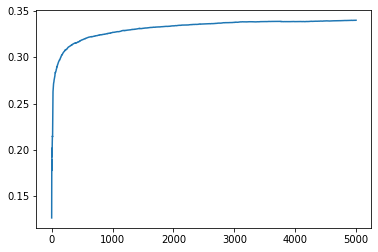

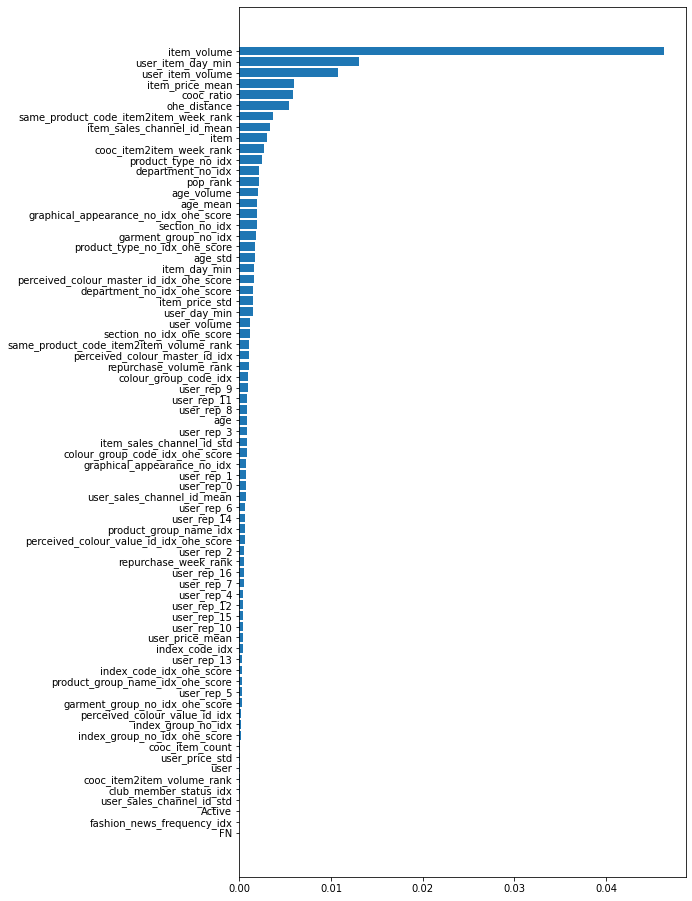

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    plt.plot(model.get_evals_result()['validation']['PFound'])

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03484537645632603


In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.667 s


[item stacic features] 1.642 s


[user dynamic features (transactions)] 1.440 s


[item dynamic features (transactions)] 1.167 s


[item dynamic features (user features)] 1.663 s


[item freshness features] 3.113 s


[item volume features] 1.158 s


[user freshness features] 4.436 s


[user volume features] 1.322 s


[user-item freshness features] 22.269 s


[user-item volume features] 2.107 s


[item age volume features] 2.405 s


[ohe dot products] 66.789 s


[lfm features] 3.565 s
attach features (week: 2)


[user static fetaures] 0.689 s


[item stacic features] 1.671 s


[user dynamic features (transactions)] 1.456 s


[item dynamic features (transactions)] 1.216 s


[item dynamic features (user features)] 1.750 s


[item freshness features] 3.085 s


[item volume features] 1.206 s


[user freshness features] 4.463 s


[user volume features] 1.364 s


[user-item freshness features] 21.938 s


[user-item volume features] 2.212 s


[item age volume features] 2.495 s


[ohe dot products] 68.867 s


[lfm features] 3.662 s
attach features (week: 3)


[user static fetaures] 0.731 s


[item stacic features] 1.816 s


[user dynamic features (transactions)] 1.554 s


[item dynamic features (transactions)] 1.307 s


[item dynamic features (user features)] 1.805 s


[item freshness features] 3.227 s


[item volume features] 1.289 s


[user freshness features] 4.612 s


[user volume features] 1.490 s


[user-item freshness features] 21.998 s


[user-item volume features] 2.359 s


[item age volume features] 2.702 s


[ohe dot products] 71.562 s


[lfm features] 4.299 s
attach features (week: 4)


[user static fetaures] 0.774 s


[item stacic features] 1.922 s


[user dynamic features (transactions)] 1.594 s


[item dynamic features (transactions)] 1.314 s


[item dynamic features (user features)] 1.876 s


[item freshness features] 3.225 s


[item volume features] 1.318 s


[user freshness features] 4.626 s


[user volume features] 1.552 s


[user-item freshness features] 21.855 s


[user-item volume features] 2.459 s


[item age volume features] 2.737 s


[ohe dot products] 72.959 s


[lfm features] 4.572 s
attach features (week: 5)


[user static fetaures] 0.707 s


[item stacic features] 1.718 s


[user dynamic features (transactions)] 1.525 s


[item dynamic features (transactions)] 1.271 s


[item dynamic features (user features)] 1.847 s


[item freshness features] 3.145 s


[item volume features] 1.235 s


[user freshness features] 4.493 s


[user volume features] 1.421 s


[user-item freshness features] 22.083 s


[user-item volume features] 2.248 s


[item age volume features] 2.605 s


[ohe dot products] 82.082 s


[lfm features] 4.502 s
attach features (week: 6)


[user static fetaures] 0.672 s


[item stacic features] 1.586 s


[user dynamic features (transactions)] 1.585 s


[item dynamic features (transactions)] 1.317 s


[item dynamic features (user features)] 1.954 s


[item freshness features] 3.205 s


[item volume features] 1.303 s


[user freshness features] 4.540 s


[user volume features] 1.493 s


[user-item freshness features] 22.426 s


[user-item volume features] 2.274 s


[item age volume features] 2.647 s


[ohe dot products] 77.622 s


[lfm features] 4.318 s


0:	total: 6.13s	remaining: 8h 26m


1:	total: 11.7s	remaining: 8h 1m 46s


2:	total: 17.1s	remaining: 7h 51m 13s


3:	total: 22.5s	remaining: 7h 42m 38s


4:	total: 27.9s	remaining: 7h 40m 32s


5:	total: 33.3s	remaining: 7h 37m 25s


6:	total: 38.7s	remaining: 7h 34m 54s


7:	total: 44.2s	remaining: 7h 34m 49s


8:	total: 49.5s	remaining: 7h 32m 25s


9:	total: 55s	remaining: 7h 32m 45s


10:	total: 1m	remaining: 7h 31m 46s


11:	total: 1m 5s	remaining: 7h 32m 4s


12:	total: 1m 11s	remaining: 7h 32m 55s


13:	total: 1m 17s	remaining: 7h 32m 40s


14:	total: 1m 22s	remaining: 7h 31m 18s


15:	total: 1m 28s	remaining: 7h 32m 20s


16:	total: 1m 33s	remaining: 7h 31m 13s


17:	total: 1m 38s	remaining: 7h 31m 16s


18:	total: 1m 44s	remaining: 7h 30m 22s


19:	total: 1m 50s	remaining: 7h 32m 17s


20:	total: 1m 55s	remaining: 7h 32m 35s


21:	total: 2m 1s	remaining: 7h 32m 51s


22:	total: 2m 7s	remaining: 7h 34m 39s


23:	total: 2m 12s	remaining: 7h 34m 3s


24:	total: 2m 18s	remaining: 7h 33m 57s


25:	total: 2m 24s	remaining: 7h 35m 12s


26:	total: 2m 30s	remaining: 7h 35m 50s


27:	total: 2m 35s	remaining: 7h 35m 41s


28:	total: 2m 41s	remaining: 7h 35m 52s


29:	total: 2m 46s	remaining: 7h 35m 13s


30:	total: 2m 51s	remaining: 7h 34m 40s


31:	total: 2m 57s	remaining: 7h 35m 14s


32:	total: 3m 3s	remaining: 7h 34m 34s


33:	total: 3m 8s	remaining: 7h 34m 53s


34:	total: 3m 14s	remaining: 7h 36m 1s


35:	total: 3m 20s	remaining: 7h 36m 16s


36:	total: 3m 26s	remaining: 7h 36m 33s


37:	total: 3m 31s	remaining: 7h 36m 12s


38:	total: 3m 37s	remaining: 7h 35m 47s


39:	total: 3m 42s	remaining: 7h 35m 44s


40:	total: 3m 48s	remaining: 7h 36m 2s


41:	total: 3m 54s	remaining: 7h 35m 56s


42:	total: 3m 59s	remaining: 7h 35m 57s


43:	total: 4m 5s	remaining: 7h 35m 52s


44:	total: 4m 10s	remaining: 7h 35m 34s


45:	total: 4m 16s	remaining: 7h 35m 27s


46:	total: 4m 21s	remaining: 7h 35m 23s


47:	total: 4m 27s	remaining: 7h 35m 11s


48:	total: 4m 32s	remaining: 7h 34m 39s


49:	total: 4m 38s	remaining: 7h 34m 29s


50:	total: 4m 43s	remaining: 7h 34m 26s


51:	total: 4m 49s	remaining: 7h 34m 27s


52:	total: 4m 54s	remaining: 7h 34m 9s


53:	total: 5m	remaining: 7h 33m 51s


54:	total: 5m 5s	remaining: 7h 33m 46s


55:	total: 5m 11s	remaining: 7h 33m 42s


56:	total: 5m 17s	remaining: 7h 33m 59s


57:	total: 5m 23s	remaining: 7h 34m 2s


58:	total: 5m 28s	remaining: 7h 34m 1s


59:	total: 5m 34s	remaining: 7h 33m 53s


60:	total: 5m 39s	remaining: 7h 33m 25s


61:	total: 5m 45s	remaining: 7h 33m 20s


62:	total: 5m 50s	remaining: 7h 33m 16s


63:	total: 5m 56s	remaining: 7h 33m


64:	total: 6m 1s	remaining: 7h 33m 4s


65:	total: 6m 7s	remaining: 7h 32m 49s


66:	total: 6m 13s	remaining: 7h 33m 2s


67:	total: 6m 18s	remaining: 7h 33m 1s


68:	total: 6m 24s	remaining: 7h 32m 52s


69:	total: 6m 29s	remaining: 7h 32m 45s


70:	total: 6m 35s	remaining: 7h 32m 22s


71:	total: 6m 40s	remaining: 7h 32m 33s


72:	total: 6m 46s	remaining: 7h 32m 23s


73:	total: 6m 51s	remaining: 7h 32m 11s


74:	total: 6m 57s	remaining: 7h 32m 7s


75:	total: 7m 2s	remaining: 7h 32m


76:	total: 7m 8s	remaining: 7h 32m 6s


77:	total: 7m 14s	remaining: 7h 32m 2s


78:	total: 7m 19s	remaining: 7h 31m 37s


79:	total: 7m 25s	remaining: 7h 31m 57s


80:	total: 7m 30s	remaining: 7h 31m 35s


81:	total: 7m 36s	remaining: 7h 31m 56s


82:	total: 7m 42s	remaining: 7h 31m 37s


83:	total: 7m 48s	remaining: 7h 31m 46s


84:	total: 7m 53s	remaining: 7h 31m 27s


85:	total: 7m 58s	remaining: 7h 31m 6s


86:	total: 8m 3s	remaining: 7h 30m 46s


87:	total: 8m 9s	remaining: 7h 30m 25s


88:	total: 8m 14s	remaining: 7h 30m


89:	total: 8m 19s	remaining: 7h 29m 42s


90:	total: 8m 25s	remaining: 7h 29m 36s


91:	total: 8m 30s	remaining: 7h 29m 29s


92:	total: 8m 36s	remaining: 7h 29m 28s


93:	total: 8m 41s	remaining: 7h 29m 6s


94:	total: 8m 47s	remaining: 7h 28m 49s


95:	total: 8m 52s	remaining: 7h 28m 43s


96:	total: 8m 58s	remaining: 7h 28m 32s


97:	total: 9m 3s	remaining: 7h 28m 21s


98:	total: 9m 8s	remaining: 7h 28m 9s


99:	total: 9m 14s	remaining: 7h 28m 12s


100:	total: 9m 20s	remaining: 7h 28m 11s


101:	total: 9m 26s	remaining: 7h 28m 28s


102:	total: 9m 31s	remaining: 7h 28m 5s


103:	total: 9m 36s	remaining: 7h 27m 56s


104:	total: 9m 42s	remaining: 7h 27m 41s


105:	total: 9m 48s	remaining: 7h 27m 50s


106:	total: 9m 53s	remaining: 7h 27m 44s


107:	total: 9m 58s	remaining: 7h 27m 17s


108:	total: 10m 3s	remaining: 7h 26m 55s


109:	total: 10m 9s	remaining: 7h 26m 59s


110:	total: 10m 15s	remaining: 7h 26m 46s


111:	total: 10m 20s	remaining: 7h 26m 41s


112:	total: 10m 25s	remaining: 7h 26m 9s


113:	total: 10m 30s	remaining: 7h 25m 58s


114:	total: 10m 36s	remaining: 7h 25m 53s


115:	total: 10m 41s	remaining: 7h 25m 40s


116:	total: 10m 47s	remaining: 7h 25m 26s


117:	total: 10m 52s	remaining: 7h 25m 29s


118:	total: 10m 58s	remaining: 7h 25m 30s


119:	total: 11m 3s	remaining: 7h 25m 11s


120:	total: 11m 8s	remaining: 7h 24m 49s


121:	total: 11m 14s	remaining: 7h 25m 3s


122:	total: 11m 20s	remaining: 7h 25m 6s


123:	total: 11m 26s	remaining: 7h 25m 10s


124:	total: 11m 31s	remaining: 7h 24m 50s


125:	total: 11m 37s	remaining: 7h 24m 40s


126:	total: 11m 42s	remaining: 7h 24m 28s


127:	total: 11m 48s	remaining: 7h 24m 30s


128:	total: 11m 53s	remaining: 7h 24m 19s


129:	total: 11m 59s	remaining: 7h 24m 30s


130:	total: 12m 5s	remaining: 7h 24m 32s


131:	total: 12m 10s	remaining: 7h 24m 27s


132:	total: 12m 16s	remaining: 7h 24m 19s


133:	total: 12m 21s	remaining: 7h 24m 20s


134:	total: 12m 27s	remaining: 7h 24m 20s


135:	total: 12m 32s	remaining: 7h 24m 7s


136:	total: 12m 38s	remaining: 7h 23m 55s


137:	total: 12m 43s	remaining: 7h 23m 41s


138:	total: 12m 49s	remaining: 7h 23m 38s


139:	total: 12m 54s	remaining: 7h 23m 21s


140:	total: 12m 59s	remaining: 7h 23m


141:	total: 13m 5s	remaining: 7h 22m 55s


142:	total: 13m 10s	remaining: 7h 22m 51s


143:	total: 13m 15s	remaining: 7h 22m 28s


144:	total: 13m 21s	remaining: 7h 22m 33s


145:	total: 13m 26s	remaining: 7h 22m 25s


146:	total: 13m 32s	remaining: 7h 22m 19s


147:	total: 13m 37s	remaining: 7h 22m 11s


148:	total: 13m 42s	remaining: 7h 21m 51s


149:	total: 13m 48s	remaining: 7h 21m 58s


150:	total: 13m 54s	remaining: 7h 21m 56s


151:	total: 13m 59s	remaining: 7h 21m 35s


152:	total: 14m 4s	remaining: 7h 21m 26s


153:	total: 14m 10s	remaining: 7h 21m 13s


154:	total: 14m 15s	remaining: 7h 20m 53s


155:	total: 14m 21s	remaining: 7h 20m 55s


156:	total: 14m 26s	remaining: 7h 20m 40s


157:	total: 14m 31s	remaining: 7h 20m 26s


158:	total: 14m 36s	remaining: 7h 20m 13s


159:	total: 14m 41s	remaining: 7h 19m 48s


160:	total: 14m 47s	remaining: 7h 19m 38s


161:	total: 14m 52s	remaining: 7h 19m 36s


162:	total: 14m 58s	remaining: 7h 19m 27s


163:	total: 15m 3s	remaining: 7h 19m 22s


164:	total: 15m 8s	remaining: 7h 19m 5s


165:	total: 15m 13s	remaining: 7h 18m 48s


166:	total: 15m 19s	remaining: 7h 18m 45s


167:	total: 15m 24s	remaining: 7h 18m 43s


168:	total: 15m 30s	remaining: 7h 18m 43s


169:	total: 15m 36s	remaining: 7h 18m 37s


170:	total: 15m 41s	remaining: 7h 18m 25s


171:	total: 15m 46s	remaining: 7h 18m 4s


172:	total: 15m 51s	remaining: 7h 17m 50s


173:	total: 15m 57s	remaining: 7h 18m 1s


174:	total: 16m 3s	remaining: 7h 17m 53s


175:	total: 16m 8s	remaining: 7h 17m 50s


176:	total: 16m 13s	remaining: 7h 17m 37s


177:	total: 16m 19s	remaining: 7h 17m 21s


178:	total: 16m 24s	remaining: 7h 17m 4s


179:	total: 16m 29s	remaining: 7h 17m 5s


180:	total: 16m 34s	remaining: 7h 16m 44s


181:	total: 16m 40s	remaining: 7h 16m 37s


182:	total: 16m 45s	remaining: 7h 16m 33s


183:	total: 16m 51s	remaining: 7h 16m 32s


184:	total: 16m 56s	remaining: 7h 16m 24s


185:	total: 17m 2s	remaining: 7h 16m 15s


186:	total: 17m 7s	remaining: 7h 16m 13s


187:	total: 17m 13s	remaining: 7h 16m 16s


188:	total: 17m 18s	remaining: 7h 16m 6s


189:	total: 17m 24s	remaining: 7h 15m 57s


190:	total: 17m 30s	remaining: 7h 16m 5s


191:	total: 17m 36s	remaining: 7h 16m 7s


192:	total: 17m 41s	remaining: 7h 16m 8s


193:	total: 17m 47s	remaining: 7h 15m 53s


194:	total: 17m 52s	remaining: 7h 15m 40s


195:	total: 17m 57s	remaining: 7h 15m 29s


196:	total: 18m 2s	remaining: 7h 15m 18s


197:	total: 18m 7s	remaining: 7h 15m


198:	total: 18m 13s	remaining: 7h 14m 50s


199:	total: 18m 18s	remaining: 7h 14m 40s


200:	total: 18m 23s	remaining: 7h 14m 32s


201:	total: 18m 29s	remaining: 7h 14m 35s


202:	total: 18m 34s	remaining: 7h 14m 25s


203:	total: 18m 40s	remaining: 7h 14m 20s


204:	total: 18m 45s	remaining: 7h 13m 58s


205:	total: 18m 51s	remaining: 7h 14m 1s


206:	total: 18m 56s	remaining: 7h 13m 58s


207:	total: 19m 1s	remaining: 7h 13m 48s


208:	total: 19m 7s	remaining: 7h 13m 37s


209:	total: 19m 12s	remaining: 7h 13m 26s


210:	total: 19m 17s	remaining: 7h 13m 16s


211:	total: 19m 23s	remaining: 7h 13m 25s


212:	total: 19m 29s	remaining: 7h 13m 31s


213:	total: 19m 35s	remaining: 7h 13m 21s


214:	total: 19m 40s	remaining: 7h 13m 9s


215:	total: 19m 45s	remaining: 7h 13m 2s


216:	total: 19m 51s	remaining: 7h 12m 54s


217:	total: 19m 56s	remaining: 7h 12m 50s


218:	total: 20m 2s	remaining: 7h 12m 44s


219:	total: 20m 7s	remaining: 7h 12m 41s


220:	total: 20m 12s	remaining: 7h 12m 29s


221:	total: 20m 18s	remaining: 7h 12m 17s


222:	total: 20m 23s	remaining: 7h 12m 12s


223:	total: 20m 28s	remaining: 7h 12m 3s


224:	total: 20m 34s	remaining: 7h 11m 54s


225:	total: 20m 40s	remaining: 7h 11m 55s


226:	total: 20m 45s	remaining: 7h 11m 50s


227:	total: 20m 51s	remaining: 7h 11m 48s


228:	total: 20m 56s	remaining: 7h 11m 39s


229:	total: 21m 1s	remaining: 7h 11m 29s


230:	total: 21m 7s	remaining: 7h 11m 35s


231:	total: 21m 13s	remaining: 7h 11m 38s


232:	total: 21m 19s	remaining: 7h 11m 35s


233:	total: 21m 25s	remaining: 7h 11m 35s


234:	total: 21m 30s	remaining: 7h 11m 31s


235:	total: 21m 35s	remaining: 7h 11m 17s


236:	total: 21m 41s	remaining: 7h 11m 14s


237:	total: 21m 46s	remaining: 7h 11m 2s


238:	total: 21m 51s	remaining: 7h 10m 42s


239:	total: 21m 56s	remaining: 7h 10m 29s


240:	total: 22m 1s	remaining: 7h 10m 18s


241:	total: 22m 7s	remaining: 7h 10m 16s


242:	total: 22m 12s	remaining: 7h 10m 7s


243:	total: 22m 17s	remaining: 7h 9m 59s


244:	total: 22m 23s	remaining: 7h 9m 54s


245:	total: 22m 29s	remaining: 7h 9m 51s


246:	total: 22m 34s	remaining: 7h 9m 49s


247:	total: 22m 39s	remaining: 7h 9m 37s


248:	total: 22m 45s	remaining: 7h 9m 26s


249:	total: 22m 50s	remaining: 7h 9m 20s


250:	total: 22m 55s	remaining: 7h 9m 3s


251:	total: 23m	remaining: 7h 8m 55s


252:	total: 23m 5s	remaining: 7h 8m 44s


253:	total: 23m 11s	remaining: 7h 8m 41s


254:	total: 23m 17s	remaining: 7h 8m 42s


255:	total: 23m 22s	remaining: 7h 8m 38s


256:	total: 23m 28s	remaining: 7h 8m 30s


257:	total: 23m 33s	remaining: 7h 8m 21s


258:	total: 23m 39s	remaining: 7h 8m 21s


259:	total: 23m 44s	remaining: 7h 8m 14s


260:	total: 23m 50s	remaining: 7h 8m 13s


261:	total: 23m 55s	remaining: 7h 7m 57s


262:	total: 24m	remaining: 7h 7m 49s


263:	total: 24m 6s	remaining: 7h 7m 46s


264:	total: 24m 11s	remaining: 7h 7m 33s


265:	total: 24m 16s	remaining: 7h 7m 30s


266:	total: 24m 22s	remaining: 7h 7m 19s


267:	total: 24m 27s	remaining: 7h 7m 17s


268:	total: 24m 33s	remaining: 7h 7m 19s


269:	total: 24m 39s	remaining: 7h 7m 17s


270:	total: 24m 44s	remaining: 7h 7m 11s


271:	total: 24m 49s	remaining: 7h 6m 58s


272:	total: 24m 55s	remaining: 7h 6m 49s


273:	total: 25m	remaining: 7h 6m 48s


274:	total: 25m 6s	remaining: 7h 6m 37s


275:	total: 25m 11s	remaining: 7h 6m 27s


276:	total: 25m 16s	remaining: 7h 6m 23s


277:	total: 25m 22s	remaining: 7h 6m 14s


278:	total: 25m 27s	remaining: 7h 6m 8s


279:	total: 25m 33s	remaining: 7h 6m 4s


280:	total: 25m 39s	remaining: 7h 6m 6s


281:	total: 25m 44s	remaining: 7h 5m 54s


282:	total: 25m 49s	remaining: 7h 5m 52s


283:	total: 25m 55s	remaining: 7h 5m 50s


284:	total: 26m 1s	remaining: 7h 5m 46s


285:	total: 26m 6s	remaining: 7h 5m 36s


286:	total: 26m 12s	remaining: 7h 5m 37s


287:	total: 26m 17s	remaining: 7h 5m 28s


288:	total: 26m 22s	remaining: 7h 5m 20s


289:	total: 26m 27s	remaining: 7h 5m 8s


290:	total: 26m 33s	remaining: 7h 4m 59s


291:	total: 26m 38s	remaining: 7h 4m 46s


292:	total: 26m 43s	remaining: 7h 4m 33s


293:	total: 26m 48s	remaining: 7h 4m 27s


294:	total: 26m 54s	remaining: 7h 4m 28s


295:	total: 27m	remaining: 7h 4m 27s


296:	total: 27m 5s	remaining: 7h 4m 13s


297:	total: 27m 9s	remaining: 7h 3m 59s


298:	total: 27m 15s	remaining: 7h 3m 51s


299:	total: 27m 20s	remaining: 7h 3m 43s


300:	total: 27m 25s	remaining: 7h 3m 32s


301:	total: 27m 30s	remaining: 7h 3m 24s


302:	total: 27m 36s	remaining: 7h 3m 24s


303:	total: 27m 41s	remaining: 7h 3m 11s


304:	total: 27m 46s	remaining: 7h 3m 1s


305:	total: 27m 52s	remaining: 7h 2m 56s


306:	total: 27m 58s	remaining: 7h 3m 1s


307:	total: 28m 3s	remaining: 7h 2m 51s


308:	total: 28m 9s	remaining: 7h 2m 52s


309:	total: 28m 14s	remaining: 7h 2m 37s


310:	total: 28m 20s	remaining: 7h 2m 34s


311:	total: 28m 25s	remaining: 7h 2m 27s


312:	total: 28m 30s	remaining: 7h 2m 21s


313:	total: 28m 36s	remaining: 7h 2m 11s


314:	total: 28m 41s	remaining: 7h 2m 11s


315:	total: 28m 47s	remaining: 7h 2m 1s


316:	total: 28m 52s	remaining: 7h 1m 56s


317:	total: 28m 57s	remaining: 7h 1m 45s


318:	total: 29m 3s	remaining: 7h 1m 44s


319:	total: 29m 8s	remaining: 7h 1m 28s


320:	total: 29m 13s	remaining: 7h 1m 19s


321:	total: 29m 18s	remaining: 7h 1m 13s


322:	total: 29m 24s	remaining: 7h 1m 6s


323:	total: 29m 29s	remaining: 7h 59s


324:	total: 29m 35s	remaining: 7h 56s


325:	total: 29m 40s	remaining: 7h 48s


326:	total: 29m 45s	remaining: 7h 39s


327:	total: 29m 51s	remaining: 7h 37s


328:	total: 29m 56s	remaining: 7h 33s


329:	total: 30m 2s	remaining: 7h 23s


330:	total: 30m 7s	remaining: 7h 23s


331:	total: 30m 13s	remaining: 7h 19s


332:	total: 30m 18s	remaining: 7h 13s


333:	total: 30m 24s	remaining: 7h 7s


334:	total: 30m 29s	remaining: 6h 59m 57s


335:	total: 30m 34s	remaining: 6h 59m 48s


336:	total: 30m 39s	remaining: 6h 59m 34s


337:	total: 30m 44s	remaining: 6h 59m 29s


338:	total: 30m 50s	remaining: 6h 59m 23s


339:	total: 30m 56s	remaining: 6h 59m 25s


340:	total: 31m 1s	remaining: 6h 59m 12s


341:	total: 31m 6s	remaining: 6h 58m 59s


342:	total: 31m 11s	remaining: 6h 58m 56s


343:	total: 31m 17s	remaining: 6h 58m 49s


344:	total: 31m 22s	remaining: 6h 58m 43s


345:	total: 31m 28s	remaining: 6h 58m 37s


346:	total: 31m 33s	remaining: 6h 58m 29s


347:	total: 31m 38s	remaining: 6h 58m 20s


348:	total: 31m 43s	remaining: 6h 58m 6s


349:	total: 31m 48s	remaining: 6h 57m 55s


350:	total: 31m 53s	remaining: 6h 57m 51s


351:	total: 31m 58s	remaining: 6h 57m 41s


352:	total: 32m 4s	remaining: 6h 57m 31s


353:	total: 32m 9s	remaining: 6h 57m 27s


354:	total: 32m 14s	remaining: 6h 57m 17s


355:	total: 32m 20s	remaining: 6h 57m 13s


356:	total: 32m 25s	remaining: 6h 57m 2s


357:	total: 32m 30s	remaining: 6h 56m 58s


358:	total: 32m 36s	remaining: 6h 56m 51s


359:	total: 32m 41s	remaining: 6h 56m 44s


360:	total: 32m 47s	remaining: 6h 56m 40s


361:	total: 32m 52s	remaining: 6h 56m 33s


362:	total: 32m 57s	remaining: 6h 56m 19s


363:	total: 33m 2s	remaining: 6h 56m 13s


364:	total: 33m 7s	remaining: 6h 56m 5s


365:	total: 33m 13s	remaining: 6h 56m 1s


366:	total: 33m 18s	remaining: 6h 55m 56s


367:	total: 33m 23s	remaining: 6h 55m 45s


368:	total: 33m 29s	remaining: 6h 55m 36s


369:	total: 33m 34s	remaining: 6h 55m 27s


370:	total: 33m 39s	remaining: 6h 55m 23s


371:	total: 33m 45s	remaining: 6h 55m 23s


372:	total: 33m 50s	remaining: 6h 55m 14s


373:	total: 33m 56s	remaining: 6h 55m 5s


374:	total: 34m 1s	remaining: 6h 54m 59s


375:	total: 34m 6s	remaining: 6h 54m 48s


376:	total: 34m 12s	remaining: 6h 54m 48s


377:	total: 34m 17s	remaining: 6h 54m 35s


378:	total: 34m 22s	remaining: 6h 54m 31s


379:	total: 34m 27s	remaining: 6h 54m 23s


380:	total: 34m 32s	remaining: 6h 54m 14s


381:	total: 34m 38s	remaining: 6h 54m 6s


382:	total: 34m 43s	remaining: 6h 53m 57s


383:	total: 34m 48s	remaining: 6h 53m 46s


384:	total: 34m 53s	remaining: 6h 53m 36s


385:	total: 34m 58s	remaining: 6h 53m 26s


386:	total: 35m 4s	remaining: 6h 53m 22s


387:	total: 35m 9s	remaining: 6h 53m 19s


388:	total: 35m 14s	remaining: 6h 53m 11s


389:	total: 35m 20s	remaining: 6h 53m 5s


390:	total: 35m 25s	remaining: 6h 53m 2s


391:	total: 35m 31s	remaining: 6h 53m


392:	total: 35m 36s	remaining: 6h 52m 48s


393:	total: 35m 41s	remaining: 6h 52m 39s


394:	total: 35m 46s	remaining: 6h 52m 32s


395:	total: 35m 52s	remaining: 6h 52m 27s


396:	total: 35m 57s	remaining: 6h 52m 23s


397:	total: 36m 3s	remaining: 6h 52m 13s


398:	total: 36m 8s	remaining: 6h 52m 5s


399:	total: 36m 13s	remaining: 6h 51m 57s


400:	total: 36m 18s	remaining: 6h 51m 50s


401:	total: 36m 23s	remaining: 6h 51m 40s


402:	total: 36m 29s	remaining: 6h 51m 36s


403:	total: 36m 34s	remaining: 6h 51m 29s


404:	total: 36m 40s	remaining: 6h 51m 24s


405:	total: 36m 46s	remaining: 6h 51m 24s


406:	total: 36m 51s	remaining: 6h 51m 21s


407:	total: 36m 57s	remaining: 6h 51m 21s


408:	total: 37m 3s	remaining: 6h 51m 16s


409:	total: 37m 8s	remaining: 6h 51m 12s


410:	total: 37m 13s	remaining: 6h 51m 4s


411:	total: 37m 19s	remaining: 6h 50m 57s


412:	total: 37m 24s	remaining: 6h 50m 56s


413:	total: 37m 29s	remaining: 6h 50m 44s


414:	total: 37m 35s	remaining: 6h 50m 37s


415:	total: 37m 40s	remaining: 6h 50m 33s


416:	total: 37m 45s	remaining: 6h 50m 24s


417:	total: 37m 51s	remaining: 6h 50m 18s


418:	total: 37m 56s	remaining: 6h 50m 10s


419:	total: 38m 1s	remaining: 6h 50m 6s


420:	total: 38m 7s	remaining: 6h 50m 4s


421:	total: 38m 12s	remaining: 6h 49m 57s


422:	total: 38m 18s	remaining: 6h 49m 49s


423:	total: 38m 23s	remaining: 6h 49m 45s


424:	total: 38m 28s	remaining: 6h 49m 35s


425:	total: 38m 34s	remaining: 6h 49m 34s


426:	total: 38m 40s	remaining: 6h 49m 30s


427:	total: 38m 45s	remaining: 6h 49m 27s


428:	total: 38m 51s	remaining: 6h 49m 22s


429:	total: 38m 56s	remaining: 6h 49m 15s


430:	total: 39m 1s	remaining: 6h 49m 8s


431:	total: 39m 6s	remaining: 6h 49m


432:	total: 39m 12s	remaining: 6h 48m 51s


433:	total: 39m 17s	remaining: 6h 48m 50s


434:	total: 39m 24s	remaining: 6h 48m 52s


435:	total: 39m 29s	remaining: 6h 48m 44s


436:	total: 39m 35s	remaining: 6h 48m 43s


437:	total: 39m 40s	remaining: 6h 48m 39s


438:	total: 39m 45s	remaining: 6h 48m 31s


439:	total: 39m 51s	remaining: 6h 48m 26s


440:	total: 39m 56s	remaining: 6h 48m 21s


441:	total: 40m 2s	remaining: 6h 48m 19s


442:	total: 40m 7s	remaining: 6h 48m 10s


443:	total: 40m 13s	remaining: 6h 48m 3s


444:	total: 40m 18s	remaining: 6h 48m


445:	total: 40m 23s	remaining: 6h 47m 52s


446:	total: 40m 28s	remaining: 6h 47m 40s


447:	total: 40m 34s	remaining: 6h 47m 40s


448:	total: 40m 39s	remaining: 6h 47m 33s


449:	total: 40m 45s	remaining: 6h 47m 26s


450:	total: 40m 50s	remaining: 6h 47m 19s


451:	total: 40m 55s	remaining: 6h 47m 10s


452:	total: 41m 1s	remaining: 6h 47m 6s


453:	total: 41m 6s	remaining: 6h 47m 3s


454:	total: 41m 11s	remaining: 6h 46m 53s


455:	total: 41m 16s	remaining: 6h 46m 43s


456:	total: 41m 21s	remaining: 6h 46m 31s


457:	total: 41m 26s	remaining: 6h 46m 26s


458:	total: 41m 32s	remaining: 6h 46m 21s


459:	total: 41m 38s	remaining: 6h 46m 17s


460:	total: 41m 43s	remaining: 6h 46m 14s


461:	total: 41m 49s	remaining: 6h 46m 10s


462:	total: 41m 55s	remaining: 6h 46m 10s


463:	total: 42m	remaining: 6h 46m 5s


464:	total: 42m 5s	remaining: 6h 45m 55s


465:	total: 42m 11s	remaining: 6h 45m 53s


466:	total: 42m 16s	remaining: 6h 45m 48s


467:	total: 42m 22s	remaining: 6h 45m 41s


468:	total: 42m 27s	remaining: 6h 45m 33s


469:	total: 42m 32s	remaining: 6h 45m 25s


470:	total: 42m 37s	remaining: 6h 45m 19s


471:	total: 42m 43s	remaining: 6h 45m 11s


472:	total: 42m 48s	remaining: 6h 45m 2s


473:	total: 42m 53s	remaining: 6h 44m 57s


474:	total: 42m 59s	remaining: 6h 44m 52s


475:	total: 43m 4s	remaining: 6h 44m 42s


476:	total: 43m 9s	remaining: 6h 44m 34s


477:	total: 43m 14s	remaining: 6h 44m 30s


478:	total: 43m 19s	remaining: 6h 44m 22s


479:	total: 43m 25s	remaining: 6h 44m 14s


480:	total: 43m 30s	remaining: 6h 44m 6s


481:	total: 43m 35s	remaining: 6h 44m 1s


482:	total: 43m 40s	remaining: 6h 43m 53s


483:	total: 43m 46s	remaining: 6h 43m 45s


484:	total: 43m 51s	remaining: 6h 43m 39s


485:	total: 43m 56s	remaining: 6h 43m 32s


486:	total: 44m 2s	remaining: 6h 43m 28s


487:	total: 44m 7s	remaining: 6h 43m 23s


488:	total: 44m 13s	remaining: 6h 43m 18s


489:	total: 44m 19s	remaining: 6h 43m 18s


490:	total: 44m 24s	remaining: 6h 43m 11s


491:	total: 44m 29s	remaining: 6h 43m 3s


492:	total: 44m 34s	remaining: 6h 42m 54s


493:	total: 44m 40s	remaining: 6h 42m 49s


494:	total: 44m 45s	remaining: 6h 42m 43s


495:	total: 44m 50s	remaining: 6h 42m 37s


496:	total: 44m 56s	remaining: 6h 42m 32s


497:	total: 45m 1s	remaining: 6h 42m 24s


498:	total: 45m 6s	remaining: 6h 42m 14s


499:	total: 45m 11s	remaining: 6h 42m 8s


500:	total: 45m 16s	remaining: 6h 41m 58s


501:	total: 45m 22s	remaining: 6h 41m 55s


502:	total: 45m 28s	remaining: 6h 41m 52s


503:	total: 45m 33s	remaining: 6h 41m 45s


504:	total: 45m 38s	remaining: 6h 41m 40s


505:	total: 45m 44s	remaining: 6h 41m 36s


506:	total: 45m 49s	remaining: 6h 41m 29s


507:	total: 45m 55s	remaining: 6h 41m 26s


508:	total: 46m	remaining: 6h 41m 19s


509:	total: 46m 5s	remaining: 6h 41m 14s


510:	total: 46m 11s	remaining: 6h 41m 9s


511:	total: 46m 16s	remaining: 6h 40m 59s


512:	total: 46m 21s	remaining: 6h 40m 53s


513:	total: 46m 26s	remaining: 6h 40m 45s


514:	total: 46m 31s	remaining: 6h 40m 37s


515:	total: 46m 36s	remaining: 6h 40m 28s


516:	total: 46m 42s	remaining: 6h 40m 21s


517:	total: 46m 47s	remaining: 6h 40m 12s


518:	total: 46m 52s	remaining: 6h 40m 5s


519:	total: 46m 57s	remaining: 6h 39m 56s


520:	total: 47m 2s	remaining: 6h 39m 51s


521:	total: 47m 8s	remaining: 6h 39m 48s


522:	total: 47m 13s	remaining: 6h 39m 43s


523:	total: 47m 19s	remaining: 6h 39m 37s


524:	total: 47m 24s	remaining: 6h 39m 31s


525:	total: 47m 29s	remaining: 6h 39m 23s


526:	total: 47m 35s	remaining: 6h 39m 18s


527:	total: 47m 40s	remaining: 6h 39m 12s


528:	total: 47m 46s	remaining: 6h 39m 8s


529:	total: 47m 52s	remaining: 6h 39m 6s


530:	total: 47m 57s	remaining: 6h 39m 3s


531:	total: 48m 2s	remaining: 6h 38m 54s


532:	total: 48m 7s	remaining: 6h 38m 47s


533:	total: 48m 13s	remaining: 6h 38m 42s


534:	total: 48m 18s	remaining: 6h 38m 34s


535:	total: 48m 23s	remaining: 6h 38m 26s


536:	total: 48m 28s	remaining: 6h 38m 18s


537:	total: 48m 33s	remaining: 6h 38m 9s


538:	total: 48m 39s	remaining: 6h 38m 7s


539:	total: 48m 44s	remaining: 6h 38m 1s


540:	total: 48m 50s	remaining: 6h 37m 58s


541:	total: 48m 56s	remaining: 6h 37m 53s


542:	total: 49m 1s	remaining: 6h 37m 47s


543:	total: 49m 6s	remaining: 6h 37m 40s


544:	total: 49m 11s	remaining: 6h 37m 32s


545:	total: 49m 17s	remaining: 6h 37m 25s


546:	total: 49m 22s	remaining: 6h 37m 17s


547:	total: 49m 27s	remaining: 6h 37m 9s


548:	total: 49m 32s	remaining: 6h 37m 2s


549:	total: 49m 37s	remaining: 6h 36m 55s


550:	total: 49m 42s	remaining: 6h 36m 45s


551:	total: 49m 47s	remaining: 6h 36m 37s


552:	total: 49m 52s	remaining: 6h 36m 29s


553:	total: 49m 57s	remaining: 6h 36m 21s


554:	total: 50m 2s	remaining: 6h 36m 15s


555:	total: 50m 8s	remaining: 6h 36m 10s


556:	total: 50m 14s	remaining: 6h 36m 8s


557:	total: 50m 20s	remaining: 6h 36m 4s


558:	total: 50m 25s	remaining: 6h 35m 57s


559:	total: 50m 30s	remaining: 6h 35m 47s


560:	total: 50m 35s	remaining: 6h 35m 41s


561:	total: 50m 40s	remaining: 6h 35m 32s


562:	total: 50m 45s	remaining: 6h 35m 25s


563:	total: 50m 50s	remaining: 6h 35m 17s


564:	total: 50m 56s	remaining: 6h 35m 13s


565:	total: 51m 1s	remaining: 6h 35m 5s


566:	total: 51m 6s	remaining: 6h 34m 59s


567:	total: 51m 12s	remaining: 6h 34m 57s


568:	total: 51m 17s	remaining: 6h 34m 51s


569:	total: 51m 23s	remaining: 6h 34m 48s


570:	total: 51m 29s	remaining: 6h 34m 44s


571:	total: 51m 34s	remaining: 6h 34m 40s


572:	total: 51m 39s	remaining: 6h 34m 34s


573:	total: 51m 45s	remaining: 6h 34m 27s


574:	total: 51m 50s	remaining: 6h 34m 22s


575:	total: 51m 56s	remaining: 6h 34m 17s


576:	total: 52m 1s	remaining: 6h 34m 9s


577:	total: 52m 6s	remaining: 6h 34m 5s


578:	total: 52m 11s	remaining: 6h 33m 57s


579:	total: 52m 16s	remaining: 6h 33m 49s


580:	total: 52m 21s	remaining: 6h 33m 41s


581:	total: 52m 27s	remaining: 6h 33m 35s


582:	total: 52m 32s	remaining: 6h 33m 30s


583:	total: 52m 38s	remaining: 6h 33m 27s


584:	total: 52m 43s	remaining: 6h 33m 22s


585:	total: 52m 48s	remaining: 6h 33m 12s


586:	total: 52m 54s	remaining: 6h 33m 7s


587:	total: 53m	remaining: 6h 33m 6s


588:	total: 53m 5s	remaining: 6h 33m


589:	total: 53m 11s	remaining: 6h 32m 58s


590:	total: 53m 16s	remaining: 6h 32m 49s


591:	total: 53m 22s	remaining: 6h 32m 47s


592:	total: 53m 27s	remaining: 6h 32m 41s


593:	total: 53m 33s	remaining: 6h 32m 39s


594:	total: 53m 38s	remaining: 6h 32m 29s


595:	total: 53m 43s	remaining: 6h 32m 24s


596:	total: 53m 49s	remaining: 6h 32m 18s


597:	total: 53m 54s	remaining: 6h 32m 14s


598:	total: 53m 59s	remaining: 6h 32m 7s


599:	total: 54m 4s	remaining: 6h 31m 59s


600:	total: 54m 10s	remaining: 6h 31m 54s


601:	total: 54m 16s	remaining: 6h 31m 53s


602:	total: 54m 21s	remaining: 6h 31m 46s


603:	total: 54m 26s	remaining: 6h 31m 40s


604:	total: 54m 31s	remaining: 6h 31m 31s


605:	total: 54m 37s	remaining: 6h 31m 26s


606:	total: 54m 42s	remaining: 6h 31m 16s


607:	total: 54m 47s	remaining: 6h 31m 10s


608:	total: 54m 52s	remaining: 6h 31m 2s


609:	total: 54m 57s	remaining: 6h 30m 57s


610:	total: 55m 3s	remaining: 6h 30m 54s


611:	total: 55m 8s	remaining: 6h 30m 47s


612:	total: 55m 14s	remaining: 6h 30m 41s


613:	total: 55m 19s	remaining: 6h 30m 34s


614:	total: 55m 24s	remaining: 6h 30m 30s


615:	total: 55m 30s	remaining: 6h 30m 24s


616:	total: 55m 35s	remaining: 6h 30m 19s


617:	total: 55m 40s	remaining: 6h 30m 13s


618:	total: 55m 46s	remaining: 6h 30m 6s


619:	total: 55m 51s	remaining: 6h 30m 1s


620:	total: 55m 57s	remaining: 6h 30m 1s


621:	total: 56m 3s	remaining: 6h 29m 55s


622:	total: 56m 8s	remaining: 6h 29m 51s


623:	total: 56m 13s	remaining: 6h 29m 44s


624:	total: 56m 19s	remaining: 6h 29m 38s


625:	total: 56m 23s	remaining: 6h 29m 28s


626:	total: 56m 29s	remaining: 6h 29m 23s


627:	total: 56m 35s	remaining: 6h 29m 20s


628:	total: 56m 40s	remaining: 6h 29m 15s


629:	total: 56m 45s	remaining: 6h 29m 6s


630:	total: 56m 50s	remaining: 6h 29m


631:	total: 56m 56s	remaining: 6h 28m 57s


632:	total: 57m 1s	remaining: 6h 28m 51s


633:	total: 57m 6s	remaining: 6h 28m 44s


634:	total: 57m 12s	remaining: 6h 28m 36s


635:	total: 57m 17s	remaining: 6h 28m 28s


636:	total: 57m 22s	remaining: 6h 28m 23s


637:	total: 57m 27s	remaining: 6h 28m 14s


638:	total: 57m 32s	remaining: 6h 28m 9s


639:	total: 57m 38s	remaining: 6h 28m 5s


640:	total: 57m 43s	remaining: 6h 27m 59s


641:	total: 57m 49s	remaining: 6h 27m 54s


642:	total: 57m 54s	remaining: 6h 27m 47s


643:	total: 57m 59s	remaining: 6h 27m 41s


644:	total: 58m 5s	remaining: 6h 27m 35s


645:	total: 58m 10s	remaining: 6h 27m 28s


646:	total: 58m 15s	remaining: 6h 27m 21s


647:	total: 58m 20s	remaining: 6h 27m 16s


648:	total: 58m 25s	remaining: 6h 27m 8s


649:	total: 58m 31s	remaining: 6h 27m 2s


650:	total: 58m 36s	remaining: 6h 26m 54s


651:	total: 58m 42s	remaining: 6h 26m 53s


652:	total: 58m 47s	remaining: 6h 26m 47s


653:	total: 58m 53s	remaining: 6h 26m 44s


654:	total: 58m 58s	remaining: 6h 26m 37s


655:	total: 59m 4s	remaining: 6h 26m 34s


656:	total: 59m 9s	remaining: 6h 26m 26s


657:	total: 59m 14s	remaining: 6h 26m 20s


658:	total: 59m 20s	remaining: 6h 26m 17s


659:	total: 59m 25s	remaining: 6h 26m 11s


660:	total: 59m 30s	remaining: 6h 26m 4s


661:	total: 59m 36s	remaining: 6h 25m 58s


662:	total: 59m 41s	remaining: 6h 25m 51s


663:	total: 59m 46s	remaining: 6h 25m 47s


664:	total: 59m 52s	remaining: 6h 25m 42s


665:	total: 59m 57s	remaining: 6h 25m 32s


666:	total: 1h 2s	remaining: 6h 25m 27s


667:	total: 1h 7s	remaining: 6h 25m 21s


668:	total: 1h 13s	remaining: 6h 25m 19s


669:	total: 1h 19s	remaining: 6h 25m 15s


670:	total: 1h 25s	remaining: 6h 25m 12s


671:	total: 1h 30s	remaining: 6h 25m 7s


672:	total: 1h 35s	remaining: 6h 24m 59s


673:	total: 1h 40s	remaining: 6h 24m 51s


674:	total: 1h 45s	remaining: 6h 24m 44s


675:	total: 1h 51s	remaining: 6h 24m 38s


676:	total: 1h 56s	remaining: 6h 24m 33s


677:	total: 1h 1m 1s	remaining: 6h 24m 27s


678:	total: 1h 1m 7s	remaining: 6h 24m 23s


679:	total: 1h 1m 13s	remaining: 6h 24m 20s


680:	total: 1h 1m 18s	remaining: 6h 24m 14s


681:	total: 1h 1m 23s	remaining: 6h 24m 8s


682:	total: 1h 1m 29s	remaining: 6h 24m 3s


683:	total: 1h 1m 35s	remaining: 6h 24m


684:	total: 1h 1m 40s	remaining: 6h 23m 53s


685:	total: 1h 1m 45s	remaining: 6h 23m 45s


686:	total: 1h 1m 50s	remaining: 6h 23m 37s


687:	total: 1h 1m 55s	remaining: 6h 23m 31s


688:	total: 1h 2m	remaining: 6h 23m 24s


689:	total: 1h 2m 5s	remaining: 6h 23m 18s


690:	total: 1h 2m 11s	remaining: 6h 23m 11s


691:	total: 1h 2m 16s	remaining: 6h 23m 7s


692:	total: 1h 2m 22s	remaining: 6h 23m 1s


693:	total: 1h 2m 27s	remaining: 6h 22m 57s


694:	total: 1h 2m 32s	remaining: 6h 22m 51s


695:	total: 1h 2m 38s	remaining: 6h 22m 44s


696:	total: 1h 2m 43s	remaining: 6h 22m 39s


697:	total: 1h 2m 48s	remaining: 6h 22m 31s


698:	total: 1h 2m 53s	remaining: 6h 22m 24s


699:	total: 1h 2m 59s	remaining: 6h 22m 19s


700:	total: 1h 3m 4s	remaining: 6h 22m 13s


701:	total: 1h 3m 9s	remaining: 6h 22m 6s


702:	total: 1h 3m 14s	remaining: 6h 21m 59s


703:	total: 1h 3m 20s	remaining: 6h 21m 54s


704:	total: 1h 3m 25s	remaining: 6h 21m 47s


705:	total: 1h 3m 30s	remaining: 6h 21m 38s


706:	total: 1h 3m 35s	remaining: 6h 21m 34s


707:	total: 1h 3m 40s	remaining: 6h 21m 27s


708:	total: 1h 3m 46s	remaining: 6h 21m 22s


709:	total: 1h 3m 52s	remaining: 6h 21m 19s


710:	total: 1h 3m 57s	remaining: 6h 21m 13s


711:	total: 1h 4m 3s	remaining: 6h 21m 10s


712:	total: 1h 4m 8s	remaining: 6h 21m 4s


713:	total: 1h 4m 13s	remaining: 6h 20m 58s


714:	total: 1h 4m 18s	remaining: 6h 20m 50s


715:	total: 1h 4m 23s	remaining: 6h 20m 42s


716:	total: 1h 4m 29s	remaining: 6h 20m 37s


717:	total: 1h 4m 35s	remaining: 6h 20m 35s


718:	total: 1h 4m 40s	remaining: 6h 20m 28s


719:	total: 1h 4m 45s	remaining: 6h 20m 22s


720:	total: 1h 4m 50s	remaining: 6h 20m 15s


721:	total: 1h 4m 55s	remaining: 6h 20m 8s


722:	total: 1h 5m 1s	remaining: 6h 20m 1s


723:	total: 1h 5m 6s	remaining: 6h 19m 58s


724:	total: 1h 5m 11s	remaining: 6h 19m 51s


725:	total: 1h 5m 17s	remaining: 6h 19m 46s


726:	total: 1h 5m 22s	remaining: 6h 19m 38s


727:	total: 1h 5m 27s	remaining: 6h 19m 31s


728:	total: 1h 5m 32s	remaining: 6h 19m 25s


729:	total: 1h 5m 37s	remaining: 6h 19m 19s


730:	total: 1h 5m 43s	remaining: 6h 19m 14s


731:	total: 1h 5m 48s	remaining: 6h 19m 9s


732:	total: 1h 5m 53s	remaining: 6h 19m 1s


733:	total: 1h 5m 59s	remaining: 6h 18m 55s


734:	total: 1h 6m 4s	remaining: 6h 18m 49s


735:	total: 1h 6m 9s	remaining: 6h 18m 42s


736:	total: 1h 6m 14s	remaining: 6h 18m 35s


737:	total: 1h 6m 20s	remaining: 6h 18m 31s


738:	total: 1h 6m 25s	remaining: 6h 18m 26s


739:	total: 1h 6m 30s	remaining: 6h 18m 18s


740:	total: 1h 6m 36s	remaining: 6h 18m 14s


741:	total: 1h 6m 41s	remaining: 6h 18m 9s


742:	total: 1h 6m 47s	remaining: 6h 18m 3s


743:	total: 1h 6m 52s	remaining: 6h 17m 57s


744:	total: 1h 6m 57s	remaining: 6h 17m 52s


745:	total: 1h 7m 2s	remaining: 6h 17m 45s


746:	total: 1h 7m 8s	remaining: 6h 17m 40s


747:	total: 1h 7m 13s	remaining: 6h 17m 34s


748:	total: 1h 7m 19s	remaining: 6h 17m 29s


749:	total: 1h 7m 24s	remaining: 6h 17m 21s


750:	total: 1h 7m 29s	remaining: 6h 17m 15s


751:	total: 1h 7m 34s	remaining: 6h 17m 11s


752:	total: 1h 7m 40s	remaining: 6h 17m 5s


753:	total: 1h 7m 45s	remaining: 6h 16m 58s


754:	total: 1h 7m 50s	remaining: 6h 16m 54s


755:	total: 1h 7m 56s	remaining: 6h 16m 47s


756:	total: 1h 8m 1s	remaining: 6h 16m 41s


757:	total: 1h 8m 7s	remaining: 6h 16m 38s


758:	total: 1h 8m 12s	remaining: 6h 16m 30s


759:	total: 1h 8m 17s	remaining: 6h 16m 24s


760:	total: 1h 8m 22s	remaining: 6h 16m 19s


761:	total: 1h 8m 28s	remaining: 6h 16m 14s


762:	total: 1h 8m 33s	remaining: 6h 16m 9s


763:	total: 1h 8m 39s	remaining: 6h 16m 3s


764:	total: 1h 8m 44s	remaining: 6h 15m 56s


765:	total: 1h 8m 49s	remaining: 6h 15m 51s


766:	total: 1h 8m 54s	remaining: 6h 15m 45s


767:	total: 1h 9m	remaining: 6h 15m 39s


768:	total: 1h 9m 5s	remaining: 6h 15m 33s


769:	total: 1h 9m 11s	remaining: 6h 15m 30s


770:	total: 1h 9m 16s	remaining: 6h 15m 23s


771:	total: 1h 9m 21s	remaining: 6h 15m 18s


772:	total: 1h 9m 27s	remaining: 6h 15m 11s


773:	total: 1h 9m 32s	remaining: 6h 15m 7s


774:	total: 1h 9m 38s	remaining: 6h 15m 2s


775:	total: 1h 9m 43s	remaining: 6h 14m 56s


776:	total: 1h 9m 48s	remaining: 6h 14m 51s


777:	total: 1h 9m 54s	remaining: 6h 14m 47s


778:	total: 1h 9m 59s	remaining: 6h 14m 41s


779:	total: 1h 10m 4s	remaining: 6h 14m 34s


780:	total: 1h 10m 10s	remaining: 6h 14m 28s


781:	total: 1h 10m 15s	remaining: 6h 14m 22s


782:	total: 1h 10m 20s	remaining: 6h 14m 17s


783:	total: 1h 10m 26s	remaining: 6h 14m 12s


784:	total: 1h 10m 32s	remaining: 6h 14m 8s


785:	total: 1h 10m 37s	remaining: 6h 14m 1s


786:	total: 1h 10m 42s	remaining: 6h 13m 56s


787:	total: 1h 10m 47s	remaining: 6h 13m 48s


788:	total: 1h 10m 52s	remaining: 6h 13m 43s


789:	total: 1h 10m 57s	remaining: 6h 13m 35s


790:	total: 1h 11m 2s	remaining: 6h 13m 27s


791:	total: 1h 11m 8s	remaining: 6h 13m 25s


792:	total: 1h 11m 14s	remaining: 6h 13m 20s


793:	total: 1h 11m 20s	remaining: 6h 13m 17s


794:	total: 1h 11m 25s	remaining: 6h 13m 13s


795:	total: 1h 11m 31s	remaining: 6h 13m 9s


796:	total: 1h 11m 36s	remaining: 6h 13m 2s


797:	total: 1h 11m 41s	remaining: 6h 12m 57s


798:	total: 1h 11m 47s	remaining: 6h 12m 53s


799:	total: 1h 11m 53s	remaining: 6h 12m 48s


800:	total: 1h 11m 58s	remaining: 6h 12m 41s


801:	total: 1h 12m 3s	remaining: 6h 12m 35s


802:	total: 1h 12m 8s	remaining: 6h 12m 30s


803:	total: 1h 12m 14s	remaining: 6h 12m 25s


804:	total: 1h 12m 19s	remaining: 6h 12m 20s


805:	total: 1h 12m 24s	remaining: 6h 12m 12s


806:	total: 1h 12m 29s	remaining: 6h 12m 5s


807:	total: 1h 12m 34s	remaining: 6h 11m 58s


808:	total: 1h 12m 40s	remaining: 6h 11m 52s


809:	total: 1h 12m 45s	remaining: 6h 11m 46s


810:	total: 1h 12m 50s	remaining: 6h 11m 38s


811:	total: 1h 12m 55s	remaining: 6h 11m 33s


812:	total: 1h 13m	remaining: 6h 11m 26s


813:	total: 1h 13m 6s	remaining: 6h 11m 22s


814:	total: 1h 13m 11s	remaining: 6h 11m 16s


815:	total: 1h 13m 17s	remaining: 6h 11m 11s


816:	total: 1h 13m 22s	remaining: 6h 11m 3s


817:	total: 1h 13m 27s	remaining: 6h 10m 58s


818:	total: 1h 13m 33s	remaining: 6h 10m 54s


819:	total: 1h 13m 38s	remaining: 6h 10m 48s


820:	total: 1h 13m 43s	remaining: 6h 10m 41s


821:	total: 1h 13m 48s	remaining: 6h 10m 36s


822:	total: 1h 13m 54s	remaining: 6h 10m 32s


823:	total: 1h 13m 59s	remaining: 6h 10m 24s


824:	total: 1h 14m 4s	remaining: 6h 10m 18s


825:	total: 1h 14m 10s	remaining: 6h 10m 13s


826:	total: 1h 14m 15s	remaining: 6h 10m 7s


827:	total: 1h 14m 20s	remaining: 6h 10m


828:	total: 1h 14m 25s	remaining: 6h 9m 55s


829:	total: 1h 14m 31s	remaining: 6h 9m 49s


830:	total: 1h 14m 36s	remaining: 6h 9m 43s


831:	total: 1h 14m 42s	remaining: 6h 9m 40s


832:	total: 1h 14m 47s	remaining: 6h 9m 33s


833:	total: 1h 14m 52s	remaining: 6h 9m 27s


834:	total: 1h 14m 57s	remaining: 6h 9m 20s


835:	total: 1h 15m 2s	remaining: 6h 9m 12s


836:	total: 1h 15m 7s	remaining: 6h 9m 6s


837:	total: 1h 15m 13s	remaining: 6h 9m 1s


838:	total: 1h 15m 18s	remaining: 6h 8m 56s


839:	total: 1h 15m 23s	remaining: 6h 8m 48s


840:	total: 1h 15m 28s	remaining: 6h 8m 41s


841:	total: 1h 15m 34s	remaining: 6h 8m 36s


842:	total: 1h 15m 39s	remaining: 6h 8m 29s


843:	total: 1h 15m 44s	remaining: 6h 8m 23s


844:	total: 1h 15m 49s	remaining: 6h 8m 17s


845:	total: 1h 15m 55s	remaining: 6h 8m 12s


846:	total: 1h 16m	remaining: 6h 8m 5s


847:	total: 1h 16m 5s	remaining: 6h 8m


848:	total: 1h 16m 10s	remaining: 6h 7m 54s


849:	total: 1h 16m 16s	remaining: 6h 7m 49s


850:	total: 1h 16m 21s	remaining: 6h 7m 42s


851:	total: 1h 16m 26s	remaining: 6h 7m 34s


852:	total: 1h 16m 32s	remaining: 6h 7m 31s


853:	total: 1h 16m 38s	remaining: 6h 7m 28s


854:	total: 1h 16m 43s	remaining: 6h 7m 21s


855:	total: 1h 16m 48s	remaining: 6h 7m 17s


856:	total: 1h 16m 54s	remaining: 6h 7m 11s


857:	total: 1h 17m	remaining: 6h 7m 9s


858:	total: 1h 17m 5s	remaining: 6h 7m 3s


859:	total: 1h 17m 10s	remaining: 6h 6m 56s


860:	total: 1h 17m 16s	remaining: 6h 6m 51s


861:	total: 1h 17m 21s	remaining: 6h 6m 44s


862:	total: 1h 17m 26s	remaining: 6h 6m 37s


863:	total: 1h 17m 31s	remaining: 6h 6m 32s


864:	total: 1h 17m 36s	remaining: 6h 6m 24s


865:	total: 1h 17m 41s	remaining: 6h 6m 18s


866:	total: 1h 17m 47s	remaining: 6h 6m 15s


867:	total: 1h 17m 53s	remaining: 6h 6m 11s


868:	total: 1h 17m 58s	remaining: 6h 6m 6s


869:	total: 1h 18m 3s	remaining: 6h 5m 58s


870:	total: 1h 18m 8s	remaining: 6h 5m 53s


871:	total: 1h 18m 14s	remaining: 6h 5m 46s


872:	total: 1h 18m 19s	remaining: 6h 5m 40s


873:	total: 1h 18m 24s	remaining: 6h 5m 32s


874:	total: 1h 18m 29s	remaining: 6h 5m 25s


875:	total: 1h 18m 34s	remaining: 6h 5m 21s


876:	total: 1h 18m 40s	remaining: 6h 5m 15s


877:	total: 1h 18m 45s	remaining: 6h 5m 10s


878:	total: 1h 18m 50s	remaining: 6h 5m 2s


879:	total: 1h 18m 55s	remaining: 6h 4m 55s


880:	total: 1h 19m	remaining: 6h 4m 49s


881:	total: 1h 19m 5s	remaining: 6h 4m 42s


882:	total: 1h 19m 11s	remaining: 6h 4m 37s


883:	total: 1h 19m 16s	remaining: 6h 4m 33s


884:	total: 1h 19m 21s	remaining: 6h 4m 27s


885:	total: 1h 19m 27s	remaining: 6h 4m 21s


886:	total: 1h 19m 32s	remaining: 6h 4m 13s


887:	total: 1h 19m 37s	remaining: 6h 4m 7s


888:	total: 1h 19m 42s	remaining: 6h 4m 1s


889:	total: 1h 19m 47s	remaining: 6h 3m 54s


890:	total: 1h 19m 53s	remaining: 6h 3m 50s


891:	total: 1h 19m 58s	remaining: 6h 3m 44s


892:	total: 1h 20m 3s	remaining: 6h 3m 37s


893:	total: 1h 20m 8s	remaining: 6h 3m 32s


894:	total: 1h 20m 14s	remaining: 6h 3m 26s


895:	total: 1h 20m 19s	remaining: 6h 3m 21s


896:	total: 1h 20m 25s	remaining: 6h 3m 16s


897:	total: 1h 20m 30s	remaining: 6h 3m 9s


898:	total: 1h 20m 35s	remaining: 6h 3m 3s


899:	total: 1h 20m 41s	remaining: 6h 2m 59s


900:	total: 1h 20m 46s	remaining: 6h 2m 55s


901:	total: 1h 20m 51s	remaining: 6h 2m 48s


902:	total: 1h 20m 57s	remaining: 6h 2m 43s


903:	total: 1h 21m 2s	remaining: 6h 2m 37s


904:	total: 1h 21m 7s	remaining: 6h 2m 30s


905:	total: 1h 21m 13s	remaining: 6h 2m 26s


906:	total: 1h 21m 18s	remaining: 6h 2m 20s


907:	total: 1h 21m 24s	remaining: 6h 2m 16s


908:	total: 1h 21m 29s	remaining: 6h 2m 10s


909:	total: 1h 21m 34s	remaining: 6h 2m 5s


910:	total: 1h 21m 40s	remaining: 6h 1m 59s


911:	total: 1h 21m 45s	remaining: 6h 1m 53s


912:	total: 1h 21m 50s	remaining: 6h 1m 47s


913:	total: 1h 21m 56s	remaining: 6h 1m 42s


914:	total: 1h 22m 1s	remaining: 6h 1m 35s


915:	total: 1h 22m 6s	remaining: 6h 1m 31s


916:	total: 1h 22m 11s	remaining: 6h 1m 23s


917:	total: 1h 22m 16s	remaining: 6h 1m 18s


918:	total: 1h 22m 22s	remaining: 6h 1m 12s


919:	total: 1h 22m 27s	remaining: 6h 1m 7s


920:	total: 1h 22m 32s	remaining: 6h 1m


921:	total: 1h 22m 37s	remaining: 6h 53s


922:	total: 1h 22m 43s	remaining: 6h 48s


923:	total: 1h 22m 48s	remaining: 6h 42s


924:	total: 1h 22m 53s	remaining: 6h 35s


925:	total: 1h 22m 58s	remaining: 6h 29s


926:	total: 1h 23m 3s	remaining: 6h 23s


927:	total: 1h 23m 8s	remaining: 6h 16s


928:	total: 1h 23m 14s	remaining: 6h 11s


929:	total: 1h 23m 20s	remaining: 6h 8s


930:	total: 1h 23m 25s	remaining: 6h 4s


931:	total: 1h 23m 31s	remaining: 5h 59m 59s


932:	total: 1h 23m 36s	remaining: 5h 59m 52s


933:	total: 1h 23m 41s	remaining: 5h 59m 47s


934:	total: 1h 23m 47s	remaining: 5h 59m 41s


935:	total: 1h 23m 52s	remaining: 5h 59m 37s


936:	total: 1h 23m 57s	remaining: 5h 59m 31s


937:	total: 1h 24m 3s	remaining: 5h 59m 26s


938:	total: 1h 24m 8s	remaining: 5h 59m 19s


939:	total: 1h 24m 13s	remaining: 5h 59m 14s


940:	total: 1h 24m 19s	remaining: 5h 59m 10s


941:	total: 1h 24m 25s	remaining: 5h 59m 5s


942:	total: 1h 24m 30s	remaining: 5h 58m 58s


943:	total: 1h 24m 35s	remaining: 5h 58m 54s


944:	total: 1h 24m 41s	remaining: 5h 58m 49s


945:	total: 1h 24m 46s	remaining: 5h 58m 44s


946:	total: 1h 24m 51s	remaining: 5h 58m 38s


947:	total: 1h 24m 58s	remaining: 5h 58m 36s


948:	total: 1h 25m 4s	remaining: 5h 58m 33s


949:	total: 1h 25m 9s	remaining: 5h 58m 29s


950:	total: 1h 25m 14s	remaining: 5h 58m 22s


951:	total: 1h 25m 20s	remaining: 5h 58m 16s


952:	total: 1h 25m 25s	remaining: 5h 58m 11s


953:	total: 1h 25m 30s	remaining: 5h 58m 6s


954:	total: 1h 25m 36s	remaining: 5h 58m


955:	total: 1h 25m 41s	remaining: 5h 57m 56s


956:	total: 1h 25m 47s	remaining: 5h 57m 53s


957:	total: 1h 25m 53s	remaining: 5h 57m 49s


958:	total: 1h 25m 59s	remaining: 5h 57m 45s


959:	total: 1h 26m 4s	remaining: 5h 57m 39s


960:	total: 1h 26m 9s	remaining: 5h 57m 34s


961:	total: 1h 26m 15s	remaining: 5h 57m 28s


962:	total: 1h 26m 20s	remaining: 5h 57m 22s


963:	total: 1h 26m 25s	remaining: 5h 57m 17s


964:	total: 1h 26m 30s	remaining: 5h 57m 9s


965:	total: 1h 26m 36s	remaining: 5h 57m 5s


966:	total: 1h 26m 41s	remaining: 5h 56m 59s


967:	total: 1h 26m 47s	remaining: 5h 56m 54s


968:	total: 1h 26m 52s	remaining: 5h 56m 49s


969:	total: 1h 26m 57s	remaining: 5h 56m 42s


970:	total: 1h 27m 2s	remaining: 5h 56m 36s


971:	total: 1h 27m 8s	remaining: 5h 56m 34s


972:	total: 1h 27m 14s	remaining: 5h 56m 30s


973:	total: 1h 27m 19s	remaining: 5h 56m 23s


974:	total: 1h 27m 24s	remaining: 5h 56m 17s


975:	total: 1h 27m 30s	remaining: 5h 56m 13s


976:	total: 1h 27m 35s	remaining: 5h 56m 6s


977:	total: 1h 27m 40s	remaining: 5h 55m 59s


978:	total: 1h 27m 45s	remaining: 5h 55m 53s


979:	total: 1h 27m 50s	remaining: 5h 55m 46s


980:	total: 1h 27m 56s	remaining: 5h 55m 41s


981:	total: 1h 28m	remaining: 5h 55m 33s


982:	total: 1h 28m 5s	remaining: 5h 55m 26s


983:	total: 1h 28m 11s	remaining: 5h 55m 20s


984:	total: 1h 28m 16s	remaining: 5h 55m 14s


985:	total: 1h 28m 21s	remaining: 5h 55m 10s


986:	total: 1h 28m 27s	remaining: 5h 55m 4s


987:	total: 1h 28m 32s	remaining: 5h 54m 58s


988:	total: 1h 28m 37s	remaining: 5h 54m 51s


989:	total: 1h 28m 42s	remaining: 5h 54m 45s


990:	total: 1h 28m 47s	remaining: 5h 54m 37s


991:	total: 1h 28m 53s	remaining: 5h 54m 33s


992:	total: 1h 28m 58s	remaining: 5h 54m 26s


993:	total: 1h 29m 3s	remaining: 5h 54m 21s


994:	total: 1h 29m 8s	remaining: 5h 54m 14s


995:	total: 1h 29m 13s	remaining: 5h 54m 9s


996:	total: 1h 29m 19s	remaining: 5h 54m 3s


997:	total: 1h 29m 25s	remaining: 5h 54m


998:	total: 1h 29m 30s	remaining: 5h 53m 54s


999:	total: 1h 29m 35s	remaining: 5h 53m 47s


1000:	total: 1h 29m 41s	remaining: 5h 53m 44s


1001:	total: 1h 29m 46s	remaining: 5h 53m 38s


1002:	total: 1h 29m 52s	remaining: 5h 53m 33s


1003:	total: 1h 29m 57s	remaining: 5h 53m 29s


1004:	total: 1h 30m 3s	remaining: 5h 53m 24s


1005:	total: 1h 30m 9s	remaining: 5h 53m 21s


1006:	total: 1h 30m 14s	remaining: 5h 53m 15s


1007:	total: 1h 30m 19s	remaining: 5h 53m 8s


1008:	total: 1h 30m 24s	remaining: 5h 53m 3s


1009:	total: 1h 30m 29s	remaining: 5h 52m 56s


1010:	total: 1h 30m 34s	remaining: 5h 52m 50s


1011:	total: 1h 30m 39s	remaining: 5h 52m 42s


1012:	total: 1h 30m 44s	remaining: 5h 52m 35s


1013:	total: 1h 30m 50s	remaining: 5h 52m 30s


1014:	total: 1h 30m 56s	remaining: 5h 52m 27s


1015:	total: 1h 31m 1s	remaining: 5h 52m 21s


1016:	total: 1h 31m 6s	remaining: 5h 52m 15s


1017:	total: 1h 31m 11s	remaining: 5h 52m 9s


1018:	total: 1h 31m 17s	remaining: 5h 52m 4s


1019:	total: 1h 31m 22s	remaining: 5h 51m 59s


1020:	total: 1h 31m 27s	remaining: 5h 51m 51s


1021:	total: 1h 31m 32s	remaining: 5h 51m 45s


1022:	total: 1h 31m 37s	remaining: 5h 51m 39s


1023:	total: 1h 31m 43s	remaining: 5h 51m 33s


1024:	total: 1h 31m 48s	remaining: 5h 51m 28s


1025:	total: 1h 31m 54s	remaining: 5h 51m 23s


1026:	total: 1h 31m 59s	remaining: 5h 51m 17s


1027:	total: 1h 32m 5s	remaining: 5h 51m 14s


1028:	total: 1h 32m 10s	remaining: 5h 51m 8s


1029:	total: 1h 32m 15s	remaining: 5h 51m 2s


1030:	total: 1h 32m 21s	remaining: 5h 50m 56s


1031:	total: 1h 32m 26s	remaining: 5h 50m 50s


1032:	total: 1h 32m 31s	remaining: 5h 50m 44s


1033:	total: 1h 32m 36s	remaining: 5h 50m 38s


1034:	total: 1h 32m 41s	remaining: 5h 50m 33s


1035:	total: 1h 32m 47s	remaining: 5h 50m 28s


1036:	total: 1h 32m 52s	remaining: 5h 50m 22s


1037:	total: 1h 32m 57s	remaining: 5h 50m 16s


1038:	total: 1h 33m 3s	remaining: 5h 50m 11s


1039:	total: 1h 33m 8s	remaining: 5h 50m 6s


1040:	total: 1h 33m 13s	remaining: 5h 49m 59s


1041:	total: 1h 33m 19s	remaining: 5h 49m 54s


1042:	total: 1h 33m 25s	remaining: 5h 49m 50s


1043:	total: 1h 33m 30s	remaining: 5h 49m 44s


1044:	total: 1h 33m 35s	remaining: 5h 49m 37s


1045:	total: 1h 33m 40s	remaining: 5h 49m 31s


1046:	total: 1h 33m 45s	remaining: 5h 49m 25s


1047:	total: 1h 33m 51s	remaining: 5h 49m 21s


1048:	total: 1h 33m 56s	remaining: 5h 49m 14s


1049:	total: 1h 34m 1s	remaining: 5h 49m 8s


1050:	total: 1h 34m 6s	remaining: 5h 49m 2s


1051:	total: 1h 34m 11s	remaining: 5h 48m 56s


1052:	total: 1h 34m 17s	remaining: 5h 48m 50s


1053:	total: 1h 34m 22s	remaining: 5h 48m 44s


1054:	total: 1h 34m 27s	remaining: 5h 48m 39s


1055:	total: 1h 34m 33s	remaining: 5h 48m 34s


1056:	total: 1h 34m 38s	remaining: 5h 48m 27s


1057:	total: 1h 34m 43s	remaining: 5h 48m 22s


1058:	total: 1h 34m 49s	remaining: 5h 48m 19s


1059:	total: 1h 34m 54s	remaining: 5h 48m 12s


1060:	total: 1h 34m 59s	remaining: 5h 48m 6s


1061:	total: 1h 35m 4s	remaining: 5h 48m


1062:	total: 1h 35m 9s	remaining: 5h 47m 53s


1063:	total: 1h 35m 15s	remaining: 5h 47m 47s


1064:	total: 1h 35m 20s	remaining: 5h 47m 41s


1065:	total: 1h 35m 25s	remaining: 5h 47m 34s


1066:	total: 1h 35m 30s	remaining: 5h 47m 28s


1067:	total: 1h 35m 35s	remaining: 5h 47m 22s


1068:	total: 1h 35m 40s	remaining: 5h 47m 16s


1069:	total: 1h 35m 46s	remaining: 5h 47m 11s


1070:	total: 1h 35m 51s	remaining: 5h 47m 6s


1071:	total: 1h 35m 56s	remaining: 5h 46m 59s


1072:	total: 1h 36m 1s	remaining: 5h 46m 53s


1073:	total: 1h 36m 7s	remaining: 5h 46m 48s


1074:	total: 1h 36m 12s	remaining: 5h 46m 43s


1075:	total: 1h 36m 17s	remaining: 5h 46m 37s


1076:	total: 1h 36m 23s	remaining: 5h 46m 32s


1077:	total: 1h 36m 29s	remaining: 5h 46m 28s


1078:	total: 1h 36m 34s	remaining: 5h 46m 21s


1079:	total: 1h 36m 39s	remaining: 5h 46m 15s


1080:	total: 1h 36m 44s	remaining: 5h 46m 8s


1081:	total: 1h 36m 49s	remaining: 5h 46m 3s


1082:	total: 1h 36m 55s	remaining: 5h 45m 59s


1083:	total: 1h 37m	remaining: 5h 45m 53s


1084:	total: 1h 37m 5s	remaining: 5h 45m 47s


1085:	total: 1h 37m 11s	remaining: 5h 45m 42s


1086:	total: 1h 37m 16s	remaining: 5h 45m 37s


1087:	total: 1h 37m 22s	remaining: 5h 45m 32s


1088:	total: 1h 37m 27s	remaining: 5h 45m 26s


1089:	total: 1h 37m 33s	remaining: 5h 45m 22s


1090:	total: 1h 37m 38s	remaining: 5h 45m 16s


1091:	total: 1h 37m 44s	remaining: 5h 45m 12s


1092:	total: 1h 37m 49s	remaining: 5h 45m 6s


1093:	total: 1h 37m 54s	remaining: 5h 45m 1s


1094:	total: 1h 37m 59s	remaining: 5h 44m 55s


1095:	total: 1h 38m 4s	remaining: 5h 44m 48s


1096:	total: 1h 38m 10s	remaining: 5h 44m 43s


1097:	total: 1h 38m 15s	remaining: 5h 44m 37s


1098:	total: 1h 38m 21s	remaining: 5h 44m 32s


1099:	total: 1h 38m 26s	remaining: 5h 44m 26s


1100:	total: 1h 38m 31s	remaining: 5h 44m 19s


1101:	total: 1h 38m 36s	remaining: 5h 44m 14s


1102:	total: 1h 38m 41s	remaining: 5h 44m 7s


1103:	total: 1h 38m 46s	remaining: 5h 44m 1s


1104:	total: 1h 38m 52s	remaining: 5h 43m 56s


1105:	total: 1h 38m 57s	remaining: 5h 43m 51s


1106:	total: 1h 39m 3s	remaining: 5h 43m 46s


1107:	total: 1h 39m 8s	remaining: 5h 43m 40s


1108:	total: 1h 39m 13s	remaining: 5h 43m 34s


1109:	total: 1h 39m 18s	remaining: 5h 43m 28s


1110:	total: 1h 39m 24s	remaining: 5h 43m 24s


1111:	total: 1h 39m 29s	remaining: 5h 43m 18s


1112:	total: 1h 39m 34s	remaining: 5h 43m 13s


1113:	total: 1h 39m 40s	remaining: 5h 43m 9s


1114:	total: 1h 39m 46s	remaining: 5h 43m 3s


1115:	total: 1h 39m 51s	remaining: 5h 42m 59s


1116:	total: 1h 39m 57s	remaining: 5h 42m 53s


1117:	total: 1h 40m 2s	remaining: 5h 42m 48s


1118:	total: 1h 40m 8s	remaining: 5h 42m 43s


1119:	total: 1h 40m 13s	remaining: 5h 42m 37s


1120:	total: 1h 40m 18s	remaining: 5h 42m 30s


1121:	total: 1h 40m 23s	remaining: 5h 42m 26s


1122:	total: 1h 40m 29s	remaining: 5h 42m 20s


1123:	total: 1h 40m 34s	remaining: 5h 42m 14s


1124:	total: 1h 40m 39s	remaining: 5h 42m 9s


1125:	total: 1h 40m 45s	remaining: 5h 42m 4s


1126:	total: 1h 40m 50s	remaining: 5h 41m 59s


1127:	total: 1h 40m 55s	remaining: 5h 41m 53s


1128:	total: 1h 41m 1s	remaining: 5h 41m 48s


1129:	total: 1h 41m 6s	remaining: 5h 41m 43s


1130:	total: 1h 41m 11s	remaining: 5h 41m 37s


1131:	total: 1h 41m 16s	remaining: 5h 41m 30s


1132:	total: 1h 41m 22s	remaining: 5h 41m 24s


1133:	total: 1h 41m 27s	remaining: 5h 41m 20s


1134:	total: 1h 41m 32s	remaining: 5h 41m 13s


1135:	total: 1h 41m 37s	remaining: 5h 41m 8s


1136:	total: 1h 41m 43s	remaining: 5h 41m 2s


1137:	total: 1h 41m 48s	remaining: 5h 40m 57s


1138:	total: 1h 41m 54s	remaining: 5h 40m 52s


1139:	total: 1h 41m 59s	remaining: 5h 40m 47s


1140:	total: 1h 42m 5s	remaining: 5h 40m 42s


1141:	total: 1h 42m 10s	remaining: 5h 40m 35s


1142:	total: 1h 42m 15s	remaining: 5h 40m 29s


1143:	total: 1h 42m 20s	remaining: 5h 40m 24s


1144:	total: 1h 42m 26s	remaining: 5h 40m 19s


1145:	total: 1h 42m 31s	remaining: 5h 40m 14s


1146:	total: 1h 42m 37s	remaining: 5h 40m 9s


1147:	total: 1h 42m 42s	remaining: 5h 40m 2s


1148:	total: 1h 42m 46s	remaining: 5h 39m 55s


1149:	total: 1h 42m 52s	remaining: 5h 39m 49s


1150:	total: 1h 42m 57s	remaining: 5h 39m 44s


1151:	total: 1h 43m 2s	remaining: 5h 39m 38s


1152:	total: 1h 43m 8s	remaining: 5h 39m 32s


1153:	total: 1h 43m 13s	remaining: 5h 39m 27s


1154:	total: 1h 43m 18s	remaining: 5h 39m 22s


1155:	total: 1h 43m 24s	remaining: 5h 39m 16s


1156:	total: 1h 43m 29s	remaining: 5h 39m 10s


1157:	total: 1h 43m 34s	remaining: 5h 39m 3s


1158:	total: 1h 43m 39s	remaining: 5h 38m 57s


1159:	total: 1h 43m 44s	remaining: 5h 38m 52s


1160:	total: 1h 43m 50s	remaining: 5h 38m 47s


1161:	total: 1h 43m 55s	remaining: 5h 38m 42s


1162:	total: 1h 44m	remaining: 5h 38m 36s


1163:	total: 1h 44m 5s	remaining: 5h 38m 28s


1164:	total: 1h 44m 11s	remaining: 5h 38m 24s


1165:	total: 1h 44m 16s	remaining: 5h 38m 18s


1166:	total: 1h 44m 22s	remaining: 5h 38m 14s


1167:	total: 1h 44m 26s	remaining: 5h 38m 6s


1168:	total: 1h 44m 32s	remaining: 5h 38m 1s


1169:	total: 1h 44m 37s	remaining: 5h 37m 54s


1170:	total: 1h 44m 42s	remaining: 5h 37m 49s


1171:	total: 1h 44m 48s	remaining: 5h 37m 46s


1172:	total: 1h 44m 53s	remaining: 5h 37m 40s


1173:	total: 1h 44m 59s	remaining: 5h 37m 36s


1174:	total: 1h 45m 4s	remaining: 5h 37m 29s


1175:	total: 1h 45m 10s	remaining: 5h 37m 26s


1176:	total: 1h 45m 15s	remaining: 5h 37m 21s


1177:	total: 1h 45m 21s	remaining: 5h 37m 15s


1178:	total: 1h 45m 26s	remaining: 5h 37m 9s


1179:	total: 1h 45m 31s	remaining: 5h 37m 3s


1180:	total: 1h 45m 36s	remaining: 5h 36m 58s


1181:	total: 1h 45m 42s	remaining: 5h 36m 51s


1182:	total: 1h 45m 47s	remaining: 5h 36m 46s


1183:	total: 1h 45m 52s	remaining: 5h 36m 41s


1184:	total: 1h 45m 58s	remaining: 5h 36m 35s


1185:	total: 1h 46m 3s	remaining: 5h 36m 30s


1186:	total: 1h 46m 9s	remaining: 5h 36m 26s


1187:	total: 1h 46m 14s	remaining: 5h 36m 19s


1188:	total: 1h 46m 20s	remaining: 5h 36m 15s


1189:	total: 1h 46m 25s	remaining: 5h 36m 10s


1190:	total: 1h 46m 30s	remaining: 5h 36m 5s


1191:	total: 1h 46m 36s	remaining: 5h 36m


1192:	total: 1h 46m 41s	remaining: 5h 35m 53s


1193:	total: 1h 46m 46s	remaining: 5h 35m 47s


1194:	total: 1h 46m 51s	remaining: 5h 35m 41s


1195:	total: 1h 46m 57s	remaining: 5h 35m 36s


1196:	total: 1h 47m 2s	remaining: 5h 35m 31s


1197:	total: 1h 47m 8s	remaining: 5h 35m 26s


1198:	total: 1h 47m 13s	remaining: 5h 35m 20s


1199:	total: 1h 47m 18s	remaining: 5h 35m 14s


1200:	total: 1h 47m 23s	remaining: 5h 35m 9s


1201:	total: 1h 47m 29s	remaining: 5h 35m 4s


1202:	total: 1h 47m 35s	remaining: 5h 35m


1203:	total: 1h 47m 40s	remaining: 5h 34m 56s


1204:	total: 1h 47m 46s	remaining: 5h 34m 51s


1205:	total: 1h 47m 51s	remaining: 5h 34m 45s


1206:	total: 1h 47m 57s	remaining: 5h 34m 41s


1207:	total: 1h 48m 2s	remaining: 5h 34m 35s


1208:	total: 1h 48m 7s	remaining: 5h 34m 29s


1209:	total: 1h 48m 13s	remaining: 5h 34m 24s


1210:	total: 1h 48m 18s	remaining: 5h 34m 18s


1211:	total: 1h 48m 23s	remaining: 5h 34m 13s


1212:	total: 1h 48m 28s	remaining: 5h 34m 7s


1213:	total: 1h 48m 33s	remaining: 5h 34m


1214:	total: 1h 48m 38s	remaining: 5h 33m 54s


1215:	total: 1h 48m 44s	remaining: 5h 33m 48s


1216:	total: 1h 48m 49s	remaining: 5h 33m 43s


1217:	total: 1h 48m 54s	remaining: 5h 33m 37s


1218:	total: 1h 49m	remaining: 5h 33m 31s


1219:	total: 1h 49m 5s	remaining: 5h 33m 27s


1220:	total: 1h 49m 10s	remaining: 5h 33m 21s


1221:	total: 1h 49m 16s	remaining: 5h 33m 15s


1222:	total: 1h 49m 20s	remaining: 5h 33m 8s


1223:	total: 1h 49m 26s	remaining: 5h 33m 3s


1224:	total: 1h 49m 31s	remaining: 5h 32m 58s


1225:	total: 1h 49m 37s	remaining: 5h 32m 54s


1226:	total: 1h 49m 43s	remaining: 5h 32m 49s


1227:	total: 1h 49m 48s	remaining: 5h 32m 45s


1228:	total: 1h 49m 54s	remaining: 5h 32m 39s


1229:	total: 1h 49m 58s	remaining: 5h 32m 32s


1230:	total: 1h 50m 4s	remaining: 5h 32m 27s


1231:	total: 1h 50m 9s	remaining: 5h 32m 20s


1232:	total: 1h 50m 14s	remaining: 5h 32m 14s


1233:	total: 1h 50m 19s	remaining: 5h 32m 8s


1234:	total: 1h 50m 24s	remaining: 5h 32m 1s


1235:	total: 1h 50m 30s	remaining: 5h 31m 57s


1236:	total: 1h 50m 35s	remaining: 5h 31m 52s


1237:	total: 1h 50m 40s	remaining: 5h 31m 46s


1238:	total: 1h 50m 46s	remaining: 5h 31m 41s


1239:	total: 1h 50m 52s	remaining: 5h 31m 37s


1240:	total: 1h 50m 57s	remaining: 5h 31m 32s


1241:	total: 1h 51m 3s	remaining: 5h 31m 27s


1242:	total: 1h 51m 8s	remaining: 5h 31m 20s


1243:	total: 1h 51m 13s	remaining: 5h 31m 15s


1244:	total: 1h 51m 18s	remaining: 5h 31m 9s


1245:	total: 1h 51m 23s	remaining: 5h 31m 3s


1246:	total: 1h 51m 28s	remaining: 5h 30m 56s


1247:	total: 1h 51m 33s	remaining: 5h 30m 51s


1248:	total: 1h 51m 39s	remaining: 5h 30m 45s


1249:	total: 1h 51m 44s	remaining: 5h 30m 41s


1250:	total: 1h 51m 50s	remaining: 5h 30m 35s


1251:	total: 1h 51m 55s	remaining: 5h 30m 29s


1252:	total: 1h 52m	remaining: 5h 30m 24s


1253:	total: 1h 52m 5s	remaining: 5h 30m 17s


1254:	total: 1h 52m 10s	remaining: 5h 30m 11s


1255:	total: 1h 52m 15s	remaining: 5h 30m 5s


1256:	total: 1h 52m 21s	remaining: 5h 30m


1257:	total: 1h 52m 26s	remaining: 5h 29m 54s


1258:	total: 1h 52m 31s	remaining: 5h 29m 47s


1259:	total: 1h 52m 37s	remaining: 5h 29m 43s


1260:	total: 1h 52m 42s	remaining: 5h 29m 37s


1261:	total: 1h 52m 47s	remaining: 5h 29m 31s


1262:	total: 1h 52m 52s	remaining: 5h 29m 25s


1263:	total: 1h 52m 57s	remaining: 5h 29m 19s


1264:	total: 1h 53m 3s	remaining: 5h 29m 13s


1265:	total: 1h 53m 7s	remaining: 5h 29m 7s


1266:	total: 1h 53m 13s	remaining: 5h 29m 2s


1267:	total: 1h 53m 18s	remaining: 5h 28m 55s


1268:	total: 1h 53m 23s	remaining: 5h 28m 50s


1269:	total: 1h 53m 28s	remaining: 5h 28m 44s


1270:	total: 1h 53m 34s	remaining: 5h 28m 39s


1271:	total: 1h 53m 39s	remaining: 5h 28m 32s


1272:	total: 1h 53m 44s	remaining: 5h 28m 27s


1273:	total: 1h 53m 50s	remaining: 5h 28m 22s


1274:	total: 1h 53m 55s	remaining: 5h 28m 16s


1275:	total: 1h 54m	remaining: 5h 28m 10s


1276:	total: 1h 54m 5s	remaining: 5h 28m 3s


1277:	total: 1h 54m 10s	remaining: 5h 27m 58s


1278:	total: 1h 54m 16s	remaining: 5h 27m 53s


1279:	total: 1h 54m 21s	remaining: 5h 27m 47s


1280:	total: 1h 54m 26s	remaining: 5h 27m 40s


1281:	total: 1h 54m 31s	remaining: 5h 27m 34s


1282:	total: 1h 54m 36s	remaining: 5h 27m 29s


1283:	total: 1h 54m 42s	remaining: 5h 27m 24s


1284:	total: 1h 54m 47s	remaining: 5h 27m 18s


1285:	total: 1h 54m 52s	remaining: 5h 27m 13s


1286:	total: 1h 54m 58s	remaining: 5h 27m 8s


1287:	total: 1h 55m 3s	remaining: 5h 27m 1s


1288:	total: 1h 55m 8s	remaining: 5h 26m 55s


1289:	total: 1h 55m 13s	remaining: 5h 26m 50s


1290:	total: 1h 55m 19s	remaining: 5h 26m 46s


1291:	total: 1h 55m 25s	remaining: 5h 26m 41s


1292:	total: 1h 55m 30s	remaining: 5h 26m 35s


1293:	total: 1h 55m 35s	remaining: 5h 26m 29s


1294:	total: 1h 55m 40s	remaining: 5h 26m 23s


1295:	total: 1h 55m 45s	remaining: 5h 26m 17s


1296:	total: 1h 55m 51s	remaining: 5h 26m 12s


1297:	total: 1h 55m 56s	remaining: 5h 26m 6s


1298:	total: 1h 56m 1s	remaining: 5h 26m


1299:	total: 1h 56m 6s	remaining: 5h 25m 54s


1300:	total: 1h 56m 12s	remaining: 5h 25m 49s


1301:	total: 1h 56m 17s	remaining: 5h 25m 44s


1302:	total: 1h 56m 22s	remaining: 5h 25m 37s


1303:	total: 1h 56m 27s	remaining: 5h 25m 31s


1304:	total: 1h 56m 32s	remaining: 5h 25m 24s


1305:	total: 1h 56m 37s	remaining: 5h 25m 19s


1306:	total: 1h 56m 43s	remaining: 5h 25m 14s


1307:	total: 1h 56m 49s	remaining: 5h 25m 10s


1308:	total: 1h 56m 54s	remaining: 5h 25m 6s


1309:	total: 1h 56m 59s	remaining: 5h 24m 59s


1310:	total: 1h 57m 4s	remaining: 5h 24m 53s


1311:	total: 1h 57m 9s	remaining: 5h 24m 47s


1312:	total: 1h 57m 15s	remaining: 5h 24m 42s


1313:	total: 1h 57m 20s	remaining: 5h 24m 36s


1314:	total: 1h 57m 26s	remaining: 5h 24m 32s


1315:	total: 1h 57m 32s	remaining: 5h 24m 28s


1316:	total: 1h 57m 37s	remaining: 5h 24m 22s


1317:	total: 1h 57m 42s	remaining: 5h 24m 18s


1318:	total: 1h 57m 48s	remaining: 5h 24m 12s


1319:	total: 1h 57m 53s	remaining: 5h 24m 7s


1320:	total: 1h 57m 59s	remaining: 5h 24m 2s


1321:	total: 1h 58m 5s	remaining: 5h 23m 58s


1322:	total: 1h 58m 10s	remaining: 5h 23m 52s


1323:	total: 1h 58m 14s	remaining: 5h 23m 45s


1324:	total: 1h 58m 20s	remaining: 5h 23m 39s


1325:	total: 1h 58m 25s	remaining: 5h 23m 33s


1326:	total: 1h 58m 30s	remaining: 5h 23m 28s


1327:	total: 1h 58m 36s	remaining: 5h 23m 22s


1328:	total: 1h 58m 41s	remaining: 5h 23m 17s


1329:	total: 1h 58m 46s	remaining: 5h 23m 11s


1330:	total: 1h 58m 51s	remaining: 5h 23m 5s


1331:	total: 1h 58m 57s	remaining: 5h 23m


1332:	total: 1h 59m 2s	remaining: 5h 22m 55s


1333:	total: 1h 59m 8s	remaining: 5h 22m 50s


1334:	total: 1h 59m 12s	remaining: 5h 22m 43s


1335:	total: 1h 59m 17s	remaining: 5h 22m 37s


1336:	total: 1h 59m 22s	remaining: 5h 22m 30s


1337:	total: 1h 59m 27s	remaining: 5h 22m 24s


1338:	total: 1h 59m 33s	remaining: 5h 22m 18s


1339:	total: 1h 59m 38s	remaining: 5h 22m 12s


1340:	total: 1h 59m 43s	remaining: 5h 22m 6s


1341:	total: 1h 59m 48s	remaining: 5h 22m 1s


1342:	total: 1h 59m 54s	remaining: 5h 21m 56s


1343:	total: 1h 59m 59s	remaining: 5h 21m 51s


1344:	total: 2h 5s	remaining: 5h 21m 46s


1345:	total: 2h 10s	remaining: 5h 21m 42s


1346:	total: 2h 16s	remaining: 5h 21m 36s


1347:	total: 2h 21s	remaining: 5h 21m 30s


1348:	total: 2h 26s	remaining: 5h 21m 23s


1349:	total: 2h 32s	remaining: 5h 21m 20s


1350:	total: 2h 37s	remaining: 5h 21m 14s


1351:	total: 2h 42s	remaining: 5h 21m 8s


1352:	total: 2h 48s	remaining: 5h 21m 3s


1353:	total: 2h 53s	remaining: 5h 20m 58s


1354:	total: 2h 58s	remaining: 5h 20m 52s


1355:	total: 2h 1m 3s	remaining: 5h 20m 46s


1356:	total: 2h 1m 9s	remaining: 5h 20m 41s


1357:	total: 2h 1m 14s	remaining: 5h 20m 35s


1358:	total: 2h 1m 19s	remaining: 5h 20m 30s


1359:	total: 2h 1m 24s	remaining: 5h 20m 23s


1360:	total: 2h 1m 29s	remaining: 5h 20m 18s


1361:	total: 2h 1m 35s	remaining: 5h 20m 12s


1362:	total: 2h 1m 40s	remaining: 5h 20m 7s


1363:	total: 2h 1m 45s	remaining: 5h 20m 1s


1364:	total: 2h 1m 51s	remaining: 5h 19m 56s


1365:	total: 2h 1m 56s	remaining: 5h 19m 50s


1366:	total: 2h 2m 1s	remaining: 5h 19m 44s


1367:	total: 2h 2m 6s	remaining: 5h 19m 38s


1368:	total: 2h 2m 11s	remaining: 5h 19m 33s


1369:	total: 2h 2m 17s	remaining: 5h 19m 29s


1370:	total: 2h 2m 23s	remaining: 5h 19m 24s


1371:	total: 2h 2m 28s	remaining: 5h 19m 19s


1372:	total: 2h 2m 33s	remaining: 5h 19m 12s


1373:	total: 2h 2m 39s	remaining: 5h 19m 8s


1374:	total: 2h 2m 44s	remaining: 5h 19m 2s


1375:	total: 2h 2m 49s	remaining: 5h 18m 57s


1376:	total: 2h 2m 54s	remaining: 5h 18m 51s


1377:	total: 2h 3m	remaining: 5h 18m 45s


1378:	total: 2h 3m 5s	remaining: 5h 18m 40s


1379:	total: 2h 3m 11s	remaining: 5h 18m 34s


1380:	total: 2h 3m 16s	remaining: 5h 18m 29s


1381:	total: 2h 3m 22s	remaining: 5h 18m 25s


1382:	total: 2h 3m 26s	remaining: 5h 18m 18s


1383:	total: 2h 3m 32s	remaining: 5h 18m 12s


1384:	total: 2h 3m 37s	remaining: 5h 18m 8s


1385:	total: 2h 3m 43s	remaining: 5h 18m 2s


1386:	total: 2h 3m 48s	remaining: 5h 17m 58s


1387:	total: 2h 3m 54s	remaining: 5h 17m 52s


1388:	total: 2h 3m 59s	remaining: 5h 17m 47s


1389:	total: 2h 4m 5s	remaining: 5h 17m 43s


1390:	total: 2h 4m 10s	remaining: 5h 17m 37s


1391:	total: 2h 4m 15s	remaining: 5h 17m 30s


1392:	total: 2h 4m 20s	remaining: 5h 17m 25s


1393:	total: 2h 4m 26s	remaining: 5h 17m 20s


1394:	total: 2h 4m 31s	remaining: 5h 17m 14s


1395:	total: 2h 4m 36s	remaining: 5h 17m 8s


1396:	total: 2h 4m 41s	remaining: 5h 17m 2s


1397:	total: 2h 4m 46s	remaining: 5h 16m 55s


1398:	total: 2h 4m 51s	remaining: 5h 16m 49s


1399:	total: 2h 4m 57s	remaining: 5h 16m 45s


1400:	total: 2h 5m 2s	remaining: 5h 16m 39s


1401:	total: 2h 5m 7s	remaining: 5h 16m 34s


1402:	total: 2h 5m 13s	remaining: 5h 16m 29s


1403:	total: 2h 5m 18s	remaining: 5h 16m 23s


1404:	total: 2h 5m 23s	remaining: 5h 16m 18s


1405:	total: 2h 5m 29s	remaining: 5h 16m 14s


1406:	total: 2h 5m 34s	remaining: 5h 16m 7s


1407:	total: 2h 5m 39s	remaining: 5h 16m 2s


1408:	total: 2h 5m 44s	remaining: 5h 15m 55s


1409:	total: 2h 5m 50s	remaining: 5h 15m 51s


1410:	total: 2h 5m 55s	remaining: 5h 15m 45s


1411:	total: 2h 6m 1s	remaining: 5h 15m 40s


1412:	total: 2h 6m 6s	remaining: 5h 15m 34s


1413:	total: 2h 6m 11s	remaining: 5h 15m 27s


1414:	total: 2h 6m 16s	remaining: 5h 15m 21s


1415:	total: 2h 6m 21s	remaining: 5h 15m 15s


1416:	total: 2h 6m 26s	remaining: 5h 15m 9s


1417:	total: 2h 6m 31s	remaining: 5h 15m 3s


1418:	total: 2h 6m 36s	remaining: 5h 14m 57s


1419:	total: 2h 6m 42s	remaining: 5h 14m 53s


1420:	total: 2h 6m 47s	remaining: 5h 14m 46s


1421:	total: 2h 6m 52s	remaining: 5h 14m 41s


1422:	total: 2h 6m 57s	remaining: 5h 14m 36s


1423:	total: 2h 7m 3s	remaining: 5h 14m 31s


1424:	total: 2h 7m 8s	remaining: 5h 14m 25s


1425:	total: 2h 7m 14s	remaining: 5h 14m 20s


1426:	total: 2h 7m 19s	remaining: 5h 14m 14s


1427:	total: 2h 7m 24s	remaining: 5h 14m 9s


1428:	total: 2h 7m 30s	remaining: 5h 14m 3s


1429:	total: 2h 7m 35s	remaining: 5h 13m 59s


1430:	total: 2h 7m 41s	remaining: 5h 13m 54s


1431:	total: 2h 7m 46s	remaining: 5h 13m 48s


1432:	total: 2h 7m 52s	remaining: 5h 13m 44s


1433:	total: 2h 7m 57s	remaining: 5h 13m 38s


1434:	total: 2h 8m 2s	remaining: 5h 13m 33s


1435:	total: 2h 8m 7s	remaining: 5h 13m 27s


1436:	total: 2h 8m 12s	remaining: 5h 13m 21s


1437:	total: 2h 8m 18s	remaining: 5h 13m 16s


1438:	total: 2h 8m 23s	remaining: 5h 13m 11s


1439:	total: 2h 8m 28s	remaining: 5h 13m 4s


1440:	total: 2h 8m 34s	remaining: 5h 13m


1441:	total: 2h 8m 40s	remaining: 5h 12m 56s


1442:	total: 2h 8m 45s	remaining: 5h 12m 50s


1443:	total: 2h 8m 50s	remaining: 5h 12m 43s


1444:	total: 2h 8m 55s	remaining: 5h 12m 37s


1445:	total: 2h 9m 1s	remaining: 5h 12m 33s


1446:	total: 2h 9m 6s	remaining: 5h 12m 28s


1447:	total: 2h 9m 12s	remaining: 5h 12m 24s


1448:	total: 2h 9m 17s	remaining: 5h 12m 18s


1449:	total: 2h 9m 22s	remaining: 5h 12m 12s


1450:	total: 2h 9m 28s	remaining: 5h 12m 7s


1451:	total: 2h 9m 33s	remaining: 5h 12m 2s


1452:	total: 2h 9m 38s	remaining: 5h 11m 55s


1453:	total: 2h 9m 43s	remaining: 5h 11m 50s


1454:	total: 2h 9m 49s	remaining: 5h 11m 44s


1455:	total: 2h 9m 54s	remaining: 5h 11m 39s


1456:	total: 2h 9m 59s	remaining: 5h 11m 33s


1457:	total: 2h 10m 4s	remaining: 5h 11m 27s


1458:	total: 2h 10m 10s	remaining: 5h 11m 22s


1459:	total: 2h 10m 15s	remaining: 5h 11m 16s


1460:	total: 2h 10m 20s	remaining: 5h 11m 9s


1461:	total: 2h 10m 25s	remaining: 5h 11m 4s


1462:	total: 2h 10m 30s	remaining: 5h 10m 58s


1463:	total: 2h 10m 35s	remaining: 5h 10m 53s


1464:	total: 2h 10m 40s	remaining: 5h 10m 47s


1465:	total: 2h 10m 46s	remaining: 5h 10m 41s


1466:	total: 2h 10m 51s	remaining: 5h 10m 35s


1467:	total: 2h 10m 56s	remaining: 5h 10m 29s


1468:	total: 2h 11m 1s	remaining: 5h 10m 22s


1469:	total: 2h 11m 6s	remaining: 5h 10m 16s


1470:	total: 2h 11m 11s	remaining: 5h 10m 12s


1471:	total: 2h 11m 17s	remaining: 5h 10m 6s


1472:	total: 2h 11m 22s	remaining: 5h 10m 1s


1473:	total: 2h 11m 27s	remaining: 5h 9m 55s


1474:	total: 2h 11m 33s	remaining: 5h 9m 50s


1475:	total: 2h 11m 38s	remaining: 5h 9m 45s


1476:	total: 2h 11m 43s	remaining: 5h 9m 39s


1477:	total: 2h 11m 48s	remaining: 5h 9m 33s


1478:	total: 2h 11m 54s	remaining: 5h 9m 28s


1479:	total: 2h 11m 59s	remaining: 5h 9m 22s


1480:	total: 2h 12m 4s	remaining: 5h 9m 17s


1481:	total: 2h 12m 9s	remaining: 5h 9m 11s


1482:	total: 2h 12m 15s	remaining: 5h 9m 5s


1483:	total: 2h 12m 20s	remaining: 5h 9m


1484:	total: 2h 12m 25s	remaining: 5h 8m 54s


1485:	total: 2h 12m 30s	remaining: 5h 8m 47s


1486:	total: 2h 12m 36s	remaining: 5h 8m 43s


1487:	total: 2h 12m 41s	remaining: 5h 8m 37s


1488:	total: 2h 12m 46s	remaining: 5h 8m 32s


1489:	total: 2h 12m 52s	remaining: 5h 8m 27s


1490:	total: 2h 12m 57s	remaining: 5h 8m 21s


1491:	total: 2h 13m 2s	remaining: 5h 8m 16s


1492:	total: 2h 13m 8s	remaining: 5h 8m 10s


1493:	total: 2h 13m 13s	remaining: 5h 8m 5s


1494:	total: 2h 13m 18s	remaining: 5h 7m 59s


1495:	total: 2h 13m 23s	remaining: 5h 7m 53s


1496:	total: 2h 13m 28s	remaining: 5h 7m 47s


1497:	total: 2h 13m 34s	remaining: 5h 7m 42s


1498:	total: 2h 13m 39s	remaining: 5h 7m 36s


1499:	total: 2h 13m 44s	remaining: 5h 7m 31s


1500:	total: 2h 13m 49s	remaining: 5h 7m 25s


1501:	total: 2h 13m 55s	remaining: 5h 7m 20s


1502:	total: 2h 14m	remaining: 5h 7m 15s


1503:	total: 2h 14m 6s	remaining: 5h 7m 10s


1504:	total: 2h 14m 11s	remaining: 5h 7m 4s


1505:	total: 2h 14m 16s	remaining: 5h 6m 58s


1506:	total: 2h 14m 21s	remaining: 5h 6m 52s


1507:	total: 2h 14m 26s	remaining: 5h 6m 47s


1508:	total: 2h 14m 32s	remaining: 5h 6m 41s


1509:	total: 2h 14m 37s	remaining: 5h 6m 36s


1510:	total: 2h 14m 42s	remaining: 5h 6m 30s


1511:	total: 2h 14m 47s	remaining: 5h 6m 24s


1512:	total: 2h 14m 52s	remaining: 5h 6m 18s


1513:	total: 2h 14m 58s	remaining: 5h 6m 13s


1514:	total: 2h 15m 2s	remaining: 5h 6m 6s


1515:	total: 2h 15m 7s	remaining: 5h 6m


1516:	total: 2h 15m 13s	remaining: 5h 5m 54s


1517:	total: 2h 15m 17s	remaining: 5h 5m 47s


1518:	total: 2h 15m 22s	remaining: 5h 5m 42s


1519:	total: 2h 15m 28s	remaining: 5h 5m 37s


1520:	total: 2h 15m 33s	remaining: 5h 5m 32s


1521:	total: 2h 15m 39s	remaining: 5h 5m 27s


1522:	total: 2h 15m 45s	remaining: 5h 5m 22s


1523:	total: 2h 15m 49s	remaining: 5h 5m 16s


1524:	total: 2h 15m 55s	remaining: 5h 5m 11s


1525:	total: 2h 16m	remaining: 5h 5m 5s


1526:	total: 2h 16m 5s	remaining: 5h 4m 59s


1527:	total: 2h 16m 10s	remaining: 5h 4m 53s


1528:	total: 2h 16m 16s	remaining: 5h 4m 48s


1529:	total: 2h 16m 21s	remaining: 5h 4m 43s


1530:	total: 2h 16m 27s	remaining: 5h 4m 37s


1531:	total: 2h 16m 32s	remaining: 5h 4m 31s


1532:	total: 2h 16m 37s	remaining: 5h 4m 26s


1533:	total: 2h 16m 41s	remaining: 5h 4m 19s


1534:	total: 2h 16m 47s	remaining: 5h 4m 13s


1535:	total: 2h 16m 52s	remaining: 5h 4m 7s


1536:	total: 2h 16m 57s	remaining: 5h 4m 1s


1537:	total: 2h 17m 2s	remaining: 5h 3m 56s


1538:	total: 2h 17m 8s	remaining: 5h 3m 51s


1539:	total: 2h 17m 13s	remaining: 5h 3m 46s


1540:	total: 2h 17m 18s	remaining: 5h 3m 40s


1541:	total: 2h 17m 23s	remaining: 5h 3m 34s


1542:	total: 2h 17m 29s	remaining: 5h 3m 28s


1543:	total: 2h 17m 34s	remaining: 5h 3m 24s


1544:	total: 2h 17m 39s	remaining: 5h 3m 18s


1545:	total: 2h 17m 45s	remaining: 5h 3m 13s


1546:	total: 2h 17m 50s	remaining: 5h 3m 8s


1547:	total: 2h 17m 56s	remaining: 5h 3m 3s


1548:	total: 2h 18m 1s	remaining: 5h 2m 56s


1549:	total: 2h 18m 6s	remaining: 5h 2m 52s


1550:	total: 2h 18m 11s	remaining: 5h 2m 44s


1551:	total: 2h 18m 16s	remaining: 5h 2m 39s


1552:	total: 2h 18m 22s	remaining: 5h 2m 34s


1553:	total: 2h 18m 26s	remaining: 5h 2m 28s


1554:	total: 2h 18m 32s	remaining: 5h 2m 23s


1555:	total: 2h 18m 38s	remaining: 5h 2m 18s


1556:	total: 2h 18m 43s	remaining: 5h 2m 13s


1557:	total: 2h 18m 48s	remaining: 5h 2m 7s


1558:	total: 2h 18m 54s	remaining: 5h 2m 2s


1559:	total: 2h 18m 59s	remaining: 5h 1m 57s


1560:	total: 2h 19m 4s	remaining: 5h 1m 51s


1561:	total: 2h 19m 9s	remaining: 5h 1m 45s


1562:	total: 2h 19m 15s	remaining: 5h 1m 40s


1563:	total: 2h 19m 20s	remaining: 5h 1m 34s


1564:	total: 2h 19m 25s	remaining: 5h 1m 29s


1565:	total: 2h 19m 30s	remaining: 5h 1m 23s


1566:	total: 2h 19m 36s	remaining: 5h 1m 19s


1567:	total: 2h 19m 42s	remaining: 5h 1m 14s


1568:	total: 2h 19m 47s	remaining: 5h 1m 8s


1569:	total: 2h 19m 52s	remaining: 5h 1m 2s


1570:	total: 2h 19m 57s	remaining: 5h 57s


1571:	total: 2h 20m 3s	remaining: 5h 51s


1572:	total: 2h 20m 8s	remaining: 5h 46s


1573:	total: 2h 20m 13s	remaining: 5h 41s


1574:	total: 2h 20m 18s	remaining: 5h 35s


1575:	total: 2h 20m 24s	remaining: 5h 30s


1576:	total: 2h 20m 29s	remaining: 5h 25s


1577:	total: 2h 20m 35s	remaining: 5h 19s


1578:	total: 2h 20m 40s	remaining: 5h 14s


1579:	total: 2h 20m 46s	remaining: 5h 11s


1580:	total: 2h 20m 52s	remaining: 5h 5s


1581:	total: 2h 20m 57s	remaining: 4h 59m 59s


1582:	total: 2h 21m 2s	remaining: 4h 59m 53s


1583:	total: 2h 21m 7s	remaining: 4h 59m 47s


1584:	total: 2h 21m 12s	remaining: 4h 59m 41s


1585:	total: 2h 21m 17s	remaining: 4h 59m 35s


1586:	total: 2h 21m 22s	remaining: 4h 59m 29s


1587:	total: 2h 21m 27s	remaining: 4h 59m 23s


1588:	total: 2h 21m 32s	remaining: 4h 59m 18s


1589:	total: 2h 21m 38s	remaining: 4h 59m 13s


1590:	total: 2h 21m 43s	remaining: 4h 59m 8s


1591:	total: 2h 21m 49s	remaining: 4h 59m 2s


1592:	total: 2h 21m 54s	remaining: 4h 58m 58s


1593:	total: 2h 21m 59s	remaining: 4h 58m 52s


1594:	total: 2h 22m 4s	remaining: 4h 58m 46s


1595:	total: 2h 22m 9s	remaining: 4h 58m 40s


1596:	total: 2h 22m 14s	remaining: 4h 58m 34s


1597:	total: 2h 22m 20s	remaining: 4h 58m 28s


1598:	total: 2h 22m 25s	remaining: 4h 58m 23s


1599:	total: 2h 22m 30s	remaining: 4h 58m 18s


1600:	total: 2h 22m 36s	remaining: 4h 58m 12s


1601:	total: 2h 22m 41s	remaining: 4h 58m 7s


1602:	total: 2h 22m 46s	remaining: 4h 58m 1s


1603:	total: 2h 22m 52s	remaining: 4h 57m 56s


1604:	total: 2h 22m 57s	remaining: 4h 57m 50s


1605:	total: 2h 23m 2s	remaining: 4h 57m 45s


1606:	total: 2h 23m 7s	remaining: 4h 57m 39s


1607:	total: 2h 23m 12s	remaining: 4h 57m 33s


1608:	total: 2h 23m 17s	remaining: 4h 57m 26s


1609:	total: 2h 23m 22s	remaining: 4h 57m 21s


1610:	total: 2h 23m 27s	remaining: 4h 57m 15s


1611:	total: 2h 23m 33s	remaining: 4h 57m 10s


1612:	total: 2h 23m 38s	remaining: 4h 57m 4s


1613:	total: 2h 23m 43s	remaining: 4h 56m 59s


1614:	total: 2h 23m 48s	remaining: 4h 56m 53s


1615:	total: 2h 23m 54s	remaining: 4h 56m 47s


1616:	total: 2h 23m 59s	remaining: 4h 56m 42s


1617:	total: 2h 24m 5s	remaining: 4h 56m 37s


1618:	total: 2h 24m 10s	remaining: 4h 56m 32s


1619:	total: 2h 24m 15s	remaining: 4h 56m 26s


1620:	total: 2h 24m 20s	remaining: 4h 56m 20s


1621:	total: 2h 24m 25s	remaining: 4h 56m 15s


1622:	total: 2h 24m 31s	remaining: 4h 56m 9s


1623:	total: 2h 24m 36s	remaining: 4h 56m 5s


1624:	total: 2h 24m 42s	remaining: 4h 55m 59s


1625:	total: 2h 24m 47s	remaining: 4h 55m 54s


1626:	total: 2h 24m 52s	remaining: 4h 55m 48s


1627:	total: 2h 24m 58s	remaining: 4h 55m 43s


1628:	total: 2h 25m 4s	remaining: 4h 55m 39s


1629:	total: 2h 25m 9s	remaining: 4h 55m 34s


1630:	total: 2h 25m 15s	remaining: 4h 55m 29s


1631:	total: 2h 25m 20s	remaining: 4h 55m 24s


1632:	total: 2h 25m 25s	remaining: 4h 55m 18s


1633:	total: 2h 25m 31s	remaining: 4h 55m 13s


1634:	total: 2h 25m 36s	remaining: 4h 55m 7s


1635:	total: 2h 25m 41s	remaining: 4h 55m 2s


1636:	total: 2h 25m 47s	remaining: 4h 54m 57s


1637:	total: 2h 25m 52s	remaining: 4h 54m 52s


1638:	total: 2h 25m 58s	remaining: 4h 54m 47s


1639:	total: 2h 26m 3s	remaining: 4h 54m 42s


1640:	total: 2h 26m 8s	remaining: 4h 54m 36s


1641:	total: 2h 26m 14s	remaining: 4h 54m 31s


1642:	total: 2h 26m 19s	remaining: 4h 54m 26s


1643:	total: 2h 26m 24s	remaining: 4h 54m 20s


1644:	total: 2h 26m 29s	remaining: 4h 54m 14s


1645:	total: 2h 26m 34s	remaining: 4h 54m 8s


1646:	total: 2h 26m 40s	remaining: 4h 54m 2s


1647:	total: 2h 26m 45s	remaining: 4h 53m 57s


1648:	total: 2h 26m 51s	remaining: 4h 53m 53s


1649:	total: 2h 26m 56s	remaining: 4h 53m 47s


1650:	total: 2h 27m 1s	remaining: 4h 53m 41s


1651:	total: 2h 27m 7s	remaining: 4h 53m 36s


1652:	total: 2h 27m 12s	remaining: 4h 53m 31s


1653:	total: 2h 27m 17s	remaining: 4h 53m 26s


1654:	total: 2h 27m 23s	remaining: 4h 53m 21s


1655:	total: 2h 27m 28s	remaining: 4h 53m 15s


1656:	total: 2h 27m 33s	remaining: 4h 53m 9s


1657:	total: 2h 27m 38s	remaining: 4h 53m 3s


1658:	total: 2h 27m 43s	remaining: 4h 52m 57s


1659:	total: 2h 27m 48s	remaining: 4h 52m 51s


1660:	total: 2h 27m 53s	remaining: 4h 52m 46s


1661:	total: 2h 27m 59s	remaining: 4h 52m 40s


1662:	total: 2h 28m 4s	remaining: 4h 52m 35s


1663:	total: 2h 28m 9s	remaining: 4h 52m 29s


1664:	total: 2h 28m 14s	remaining: 4h 52m 24s


1665:	total: 2h 28m 20s	remaining: 4h 52m 19s


1666:	total: 2h 28m 25s	remaining: 4h 52m 12s


1667:	total: 2h 28m 30s	remaining: 4h 52m 7s


1668:	total: 2h 28m 36s	remaining: 4h 52m 2s


1669:	total: 2h 28m 40s	remaining: 4h 51m 55s


1670:	total: 2h 28m 45s	remaining: 4h 51m 50s


1671:	total: 2h 28m 51s	remaining: 4h 51m 44s


1672:	total: 2h 28m 56s	remaining: 4h 51m 38s


1673:	total: 2h 29m 1s	remaining: 4h 51m 33s


1674:	total: 2h 29m 7s	remaining: 4h 51m 28s


1675:	total: 2h 29m 12s	remaining: 4h 51m 22s


1676:	total: 2h 29m 17s	remaining: 4h 51m 17s


1677:	total: 2h 29m 23s	remaining: 4h 51m 12s


1678:	total: 2h 29m 28s	remaining: 4h 51m 6s


1679:	total: 2h 29m 33s	remaining: 4h 51m


1680:	total: 2h 29m 38s	remaining: 4h 50m 54s


1681:	total: 2h 29m 43s	remaining: 4h 50m 48s


1682:	total: 2h 29m 48s	remaining: 4h 50m 42s


1683:	total: 2h 29m 53s	remaining: 4h 50m 36s


1684:	total: 2h 29m 58s	remaining: 4h 50m 31s


1685:	total: 2h 30m 3s	remaining: 4h 50m 25s


1686:	total: 2h 30m 8s	remaining: 4h 50m 19s


1687:	total: 2h 30m 14s	remaining: 4h 50m 14s


1688:	total: 2h 30m 19s	remaining: 4h 50m 9s


1689:	total: 2h 30m 25s	remaining: 4h 50m 4s


1690:	total: 2h 30m 30s	remaining: 4h 49m 58s


1691:	total: 2h 30m 36s	remaining: 4h 49m 54s


1692:	total: 2h 30m 41s	remaining: 4h 49m 48s


1693:	total: 2h 30m 46s	remaining: 4h 49m 43s


1694:	total: 2h 30m 52s	remaining: 4h 49m 38s


1695:	total: 2h 30m 57s	remaining: 4h 49m 32s


1696:	total: 2h 31m 2s	remaining: 4h 49m 27s


1697:	total: 2h 31m 7s	remaining: 4h 49m 21s


1698:	total: 2h 31m 13s	remaining: 4h 49m 16s


1699:	total: 2h 31m 18s	remaining: 4h 49m 10s


1700:	total: 2h 31m 23s	remaining: 4h 49m 3s


1701:	total: 2h 31m 28s	remaining: 4h 48m 58s


1702:	total: 2h 31m 33s	remaining: 4h 48m 53s


1703:	total: 2h 31m 39s	remaining: 4h 48m 48s


1704:	total: 2h 31m 44s	remaining: 4h 48m 43s


1705:	total: 2h 31m 50s	remaining: 4h 48m 38s


1706:	total: 2h 31m 55s	remaining: 4h 48m 32s


1707:	total: 2h 32m 1s	remaining: 4h 48m 27s


1708:	total: 2h 32m 6s	remaining: 4h 48m 23s


1709:	total: 2h 32m 12s	remaining: 4h 48m 18s


1710:	total: 2h 32m 18s	remaining: 4h 48m 13s


1711:	total: 2h 32m 23s	remaining: 4h 48m 7s


1712:	total: 2h 32m 28s	remaining: 4h 48m 3s


1713:	total: 2h 32m 34s	remaining: 4h 47m 58s


1714:	total: 2h 32m 40s	remaining: 4h 47m 53s


1715:	total: 2h 32m 45s	remaining: 4h 47m 47s


1716:	total: 2h 32m 50s	remaining: 4h 47m 42s


1717:	total: 2h 32m 55s	remaining: 4h 47m 36s


1718:	total: 2h 33m	remaining: 4h 47m 31s


1719:	total: 2h 33m 7s	remaining: 4h 47m 27s


1720:	total: 2h 33m 12s	remaining: 4h 47m 22s


1721:	total: 2h 33m 17s	remaining: 4h 47m 16s


1722:	total: 2h 33m 22s	remaining: 4h 47m 10s


1723:	total: 2h 33m 28s	remaining: 4h 47m 5s


1724:	total: 2h 33m 33s	remaining: 4h 46m 59s


1725:	total: 2h 33m 38s	remaining: 4h 46m 53s


1726:	total: 2h 33m 43s	remaining: 4h 46m 48s


1727:	total: 2h 33m 49s	remaining: 4h 46m 43s


1728:	total: 2h 33m 54s	remaining: 4h 46m 37s


1729:	total: 2h 33m 59s	remaining: 4h 46m 32s


1730:	total: 2h 34m 4s	remaining: 4h 46m 26s


1731:	total: 2h 34m 9s	remaining: 4h 46m 20s


1732:	total: 2h 34m 15s	remaining: 4h 46m 15s


1733:	total: 2h 34m 20s	remaining: 4h 46m 9s


1734:	total: 2h 34m 25s	remaining: 4h 46m 3s


1735:	total: 2h 34m 30s	remaining: 4h 45m 58s


1736:	total: 2h 34m 35s	remaining: 4h 45m 52s


1737:	total: 2h 34m 41s	remaining: 4h 45m 47s


1738:	total: 2h 34m 47s	remaining: 4h 45m 42s


1739:	total: 2h 34m 52s	remaining: 4h 45m 36s


1740:	total: 2h 34m 57s	remaining: 4h 45m 31s


1741:	total: 2h 35m 2s	remaining: 4h 45m 26s


1742:	total: 2h 35m 8s	remaining: 4h 45m 20s


1743:	total: 2h 35m 13s	remaining: 4h 45m 16s


1744:	total: 2h 35m 19s	remaining: 4h 45m 10s


1745:	total: 2h 35m 24s	remaining: 4h 45m 4s


1746:	total: 2h 35m 29s	remaining: 4h 44m 59s


1747:	total: 2h 35m 34s	remaining: 4h 44m 53s


1748:	total: 2h 35m 39s	remaining: 4h 44m 47s


1749:	total: 2h 35m 45s	remaining: 4h 44m 42s


1750:	total: 2h 35m 50s	remaining: 4h 44m 37s


1751:	total: 2h 35m 55s	remaining: 4h 44m 32s


1752:	total: 2h 36m 1s	remaining: 4h 44m 26s


1753:	total: 2h 36m 6s	remaining: 4h 44m 21s


1754:	total: 2h 36m 12s	remaining: 4h 44m 16s


1755:	total: 2h 36m 17s	remaining: 4h 44m 11s


1756:	total: 2h 36m 23s	remaining: 4h 44m 6s


1757:	total: 2h 36m 28s	remaining: 4h 44m


1758:	total: 2h 36m 33s	remaining: 4h 43m 55s


1759:	total: 2h 36m 38s	remaining: 4h 43m 48s


1760:	total: 2h 36m 42s	remaining: 4h 43m 42s


1761:	total: 2h 36m 48s	remaining: 4h 43m 38s


1762:	total: 2h 36m 54s	remaining: 4h 43m 32s


1763:	total: 2h 36m 59s	remaining: 4h 43m 26s


1764:	total: 2h 37m 4s	remaining: 4h 43m 21s


1765:	total: 2h 37m 9s	remaining: 4h 43m 15s


1766:	total: 2h 37m 15s	remaining: 4h 43m 10s


1767:	total: 2h 37m 20s	remaining: 4h 43m 4s


1768:	total: 2h 37m 25s	remaining: 4h 42m 59s


1769:	total: 2h 37m 30s	remaining: 4h 42m 53s


1770:	total: 2h 37m 35s	remaining: 4h 42m 48s


1771:	total: 2h 37m 41s	remaining: 4h 42m 43s


1772:	total: 2h 37m 46s	remaining: 4h 42m 37s


1773:	total: 2h 37m 51s	remaining: 4h 42m 31s


1774:	total: 2h 37m 57s	remaining: 4h 42m 26s


1775:	total: 2h 38m 2s	remaining: 4h 42m 20s


1776:	total: 2h 38m 7s	remaining: 4h 42m 15s


1777:	total: 2h 38m 13s	remaining: 4h 42m 10s


1778:	total: 2h 38m 18s	remaining: 4h 42m 5s


1779:	total: 2h 38m 23s	remaining: 4h 41m 58s


1780:	total: 2h 38m 28s	remaining: 4h 41m 52s


1781:	total: 2h 38m 33s	remaining: 4h 41m 46s


1782:	total: 2h 38m 38s	remaining: 4h 41m 41s


1783:	total: 2h 38m 43s	remaining: 4h 41m 36s


1784:	total: 2h 38m 48s	remaining: 4h 41m 29s


1785:	total: 2h 38m 53s	remaining: 4h 41m 24s


1786:	total: 2h 38m 59s	remaining: 4h 41m 19s


1787:	total: 2h 39m 4s	remaining: 4h 41m 13s


1788:	total: 2h 39m 9s	remaining: 4h 41m 8s


1789:	total: 2h 39m 14s	remaining: 4h 41m 2s


1790:	total: 2h 39m 19s	remaining: 4h 40m 55s


1791:	total: 2h 39m 25s	remaining: 4h 40m 51s


1792:	total: 2h 39m 30s	remaining: 4h 40m 46s


1793:	total: 2h 39m 35s	remaining: 4h 40m 40s


1794:	total: 2h 39m 40s	remaining: 4h 40m 34s


1795:	total: 2h 39m 45s	remaining: 4h 40m 28s


1796:	total: 2h 39m 51s	remaining: 4h 40m 23s


1797:	total: 2h 39m 56s	remaining: 4h 40m 17s


1798:	total: 2h 40m 1s	remaining: 4h 40m 12s


1799:	total: 2h 40m 6s	remaining: 4h 40m 6s


1800:	total: 2h 40m 11s	remaining: 4h 40m


1801:	total: 2h 40m 17s	remaining: 4h 39m 55s


1802:	total: 2h 40m 22s	remaining: 4h 39m 49s


1803:	total: 2h 40m 27s	remaining: 4h 39m 44s


1804:	total: 2h 40m 33s	remaining: 4h 39m 39s


1805:	total: 2h 40m 38s	remaining: 4h 39m 34s


1806:	total: 2h 40m 43s	remaining: 4h 39m 28s


1807:	total: 2h 40m 48s	remaining: 4h 39m 22s


1808:	total: 2h 40m 54s	remaining: 4h 39m 17s


1809:	total: 2h 40m 59s	remaining: 4h 39m 11s


1810:	total: 2h 41m 4s	remaining: 4h 39m 5s


1811:	total: 2h 41m 9s	remaining: 4h 39m


1812:	total: 2h 41m 14s	remaining: 4h 38m 54s


1813:	total: 2h 41m 19s	remaining: 4h 38m 48s


1814:	total: 2h 41m 24s	remaining: 4h 38m 42s


1815:	total: 2h 41m 29s	remaining: 4h 38m 36s


1816:	total: 2h 41m 34s	remaining: 4h 38m 31s


1817:	total: 2h 41m 40s	remaining: 4h 38m 26s


1818:	total: 2h 41m 46s	remaining: 4h 38m 21s


1819:	total: 2h 41m 51s	remaining: 4h 38m 16s


1820:	total: 2h 41m 56s	remaining: 4h 38m 10s


1821:	total: 2h 42m 1s	remaining: 4h 38m 4s


1822:	total: 2h 42m 6s	remaining: 4h 37m 59s


1823:	total: 2h 42m 12s	remaining: 4h 37m 53s


1824:	total: 2h 42m 16s	remaining: 4h 37m 47s


1825:	total: 2h 42m 22s	remaining: 4h 37m 41s


1826:	total: 2h 42m 27s	remaining: 4h 37m 36s


1827:	total: 2h 42m 32s	remaining: 4h 37m 30s


1828:	total: 2h 42m 37s	remaining: 4h 37m 24s


1829:	total: 2h 42m 42s	remaining: 4h 37m 19s


1830:	total: 2h 42m 47s	remaining: 4h 37m 13s


1831:	total: 2h 42m 53s	remaining: 4h 37m 8s


1832:	total: 2h 42m 58s	remaining: 4h 37m 2s


1833:	total: 2h 43m 3s	remaining: 4h 36m 56s


1834:	total: 2h 43m 8s	remaining: 4h 36m 51s


1835:	total: 2h 43m 14s	remaining: 4h 36m 46s


1836:	total: 2h 43m 19s	remaining: 4h 36m 40s


1837:	total: 2h 43m 24s	remaining: 4h 36m 35s


1838:	total: 2h 43m 29s	remaining: 4h 36m 29s


1839:	total: 2h 43m 34s	remaining: 4h 36m 24s


1840:	total: 2h 43m 40s	remaining: 4h 36m 18s


1841:	total: 2h 43m 45s	remaining: 4h 36m 12s


1842:	total: 2h 43m 51s	remaining: 4h 36m 8s


1843:	total: 2h 43m 57s	remaining: 4h 36m 4s


1844:	total: 2h 44m 2s	remaining: 4h 35m 59s


1845:	total: 2h 44m 7s	remaining: 4h 35m 53s


1846:	total: 2h 44m 13s	remaining: 4h 35m 48s


1847:	total: 2h 44m 18s	remaining: 4h 35m 42s


1848:	total: 2h 44m 24s	remaining: 4h 35m 38s


1849:	total: 2h 44m 30s	remaining: 4h 35m 34s


1850:	total: 2h 44m 36s	remaining: 4h 35m 30s


1851:	total: 2h 44m 42s	remaining: 4h 35m 25s


1852:	total: 2h 44m 48s	remaining: 4h 35m 21s


1853:	total: 2h 44m 53s	remaining: 4h 35m 15s


1854:	total: 2h 44m 59s	remaining: 4h 35m 10s


1855:	total: 2h 45m 3s	remaining: 4h 35m 4s


1856:	total: 2h 45m 9s	remaining: 4h 34m 59s


1857:	total: 2h 45m 14s	remaining: 4h 34m 54s


1858:	total: 2h 45m 20s	remaining: 4h 34m 49s


1859:	total: 2h 45m 25s	remaining: 4h 34m 43s


1860:	total: 2h 45m 31s	remaining: 4h 34m 39s


1861:	total: 2h 45m 36s	remaining: 4h 34m 33s


1862:	total: 2h 45m 41s	remaining: 4h 34m 27s


1863:	total: 2h 45m 46s	remaining: 4h 34m 22s


1864:	total: 2h 45m 51s	remaining: 4h 34m 16s


1865:	total: 2h 45m 57s	remaining: 4h 34m 11s


1866:	total: 2h 46m 2s	remaining: 4h 34m 5s


1867:	total: 2h 46m 7s	remaining: 4h 34m


1868:	total: 2h 46m 12s	remaining: 4h 33m 54s


1869:	total: 2h 46m 18s	remaining: 4h 33m 49s


1870:	total: 2h 46m 24s	remaining: 4h 33m 45s


1871:	total: 2h 46m 29s	remaining: 4h 33m 40s


1872:	total: 2h 46m 34s	remaining: 4h 33m 34s


1873:	total: 2h 46m 39s	remaining: 4h 33m 28s


1874:	total: 2h 46m 45s	remaining: 4h 33m 23s


1875:	total: 2h 46m 50s	remaining: 4h 33m 18s


1876:	total: 2h 46m 56s	remaining: 4h 33m 13s


1877:	total: 2h 47m 1s	remaining: 4h 33m 7s


1878:	total: 2h 47m 6s	remaining: 4h 33m 2s


1879:	total: 2h 47m 12s	remaining: 4h 32m 57s


1880:	total: 2h 47m 17s	remaining: 4h 32m 52s


1881:	total: 2h 47m 22s	remaining: 4h 32m 46s


1882:	total: 2h 47m 28s	remaining: 4h 32m 40s


1883:	total: 2h 47m 33s	remaining: 4h 32m 35s


1884:	total: 2h 47m 38s	remaining: 4h 32m 29s


1885:	total: 2h 47m 43s	remaining: 4h 32m 24s


1886:	total: 2h 47m 48s	remaining: 4h 32m 18s


1887:	total: 2h 47m 54s	remaining: 4h 32m 13s


1888:	total: 2h 48m	remaining: 4h 32m 8s


1889:	total: 2h 48m 5s	remaining: 4h 32m 3s


1890:	total: 2h 48m 11s	remaining: 4h 31m 58s


1891:	total: 2h 48m 16s	remaining: 4h 31m 53s


1892:	total: 2h 48m 22s	remaining: 4h 31m 48s


1893:	total: 2h 48m 27s	remaining: 4h 31m 43s


1894:	total: 2h 48m 33s	remaining: 4h 31m 38s


1895:	total: 2h 48m 38s	remaining: 4h 31m 33s


1896:	total: 2h 48m 43s	remaining: 4h 31m 27s


1897:	total: 2h 48m 49s	remaining: 4h 31m 23s


1898:	total: 2h 48m 54s	remaining: 4h 31m 17s


1899:	total: 2h 49m	remaining: 4h 31m 12s


1900:	total: 2h 49m 5s	remaining: 4h 31m 6s


1901:	total: 2h 49m 10s	remaining: 4h 31m 1s


1902:	total: 2h 49m 15s	remaining: 4h 30m 55s


1903:	total: 2h 49m 20s	remaining: 4h 30m 50s


1904:	total: 2h 49m 26s	remaining: 4h 30m 44s


1905:	total: 2h 49m 31s	remaining: 4h 30m 38s


1906:	total: 2h 49m 36s	remaining: 4h 30m 32s


1907:	total: 2h 49m 41s	remaining: 4h 30m 27s


1908:	total: 2h 49m 46s	remaining: 4h 30m 22s


1909:	total: 2h 49m 52s	remaining: 4h 30m 17s


1910:	total: 2h 49m 57s	remaining: 4h 30m 11s


1911:	total: 2h 50m 3s	remaining: 4h 30m 6s


1912:	total: 2h 50m 8s	remaining: 4h 30m


1913:	total: 2h 50m 13s	remaining: 4h 29m 55s


1914:	total: 2h 50m 19s	remaining: 4h 29m 51s


1915:	total: 2h 50m 25s	remaining: 4h 29m 46s


1916:	total: 2h 50m 30s	remaining: 4h 29m 40s


1917:	total: 2h 50m 35s	remaining: 4h 29m 35s


1918:	total: 2h 50m 40s	remaining: 4h 29m 29s


1919:	total: 2h 50m 45s	remaining: 4h 29m 23s


1920:	total: 2h 50m 50s	remaining: 4h 29m 17s


1921:	total: 2h 50m 56s	remaining: 4h 29m 12s


1922:	total: 2h 51m 1s	remaining: 4h 29m 7s


1923:	total: 2h 51m 7s	remaining: 4h 29m 2s


1924:	total: 2h 51m 12s	remaining: 4h 28m 56s


1925:	total: 2h 51m 17s	remaining: 4h 28m 51s


1926:	total: 2h 51m 22s	remaining: 4h 28m 45s


1927:	total: 2h 51m 27s	remaining: 4h 28m 39s


1928:	total: 2h 51m 32s	remaining: 4h 28m 34s


1929:	total: 2h 51m 38s	remaining: 4h 28m 28s


1930:	total: 2h 51m 43s	remaining: 4h 28m 23s


1931:	total: 2h 51m 48s	remaining: 4h 28m 18s


1932:	total: 2h 51m 54s	remaining: 4h 28m 13s


1933:	total: 2h 51m 59s	remaining: 4h 28m 8s


1934:	total: 2h 52m 4s	remaining: 4h 28m 2s


1935:	total: 2h 52m 10s	remaining: 4h 27m 57s


1936:	total: 2h 52m 15s	remaining: 4h 27m 51s


1937:	total: 2h 52m 20s	remaining: 4h 27m 45s


1938:	total: 2h 52m 25s	remaining: 4h 27m 40s


1939:	total: 2h 52m 30s	remaining: 4h 27m 34s


1940:	total: 2h 52m 36s	remaining: 4h 27m 29s


1941:	total: 2h 52m 41s	remaining: 4h 27m 24s


1942:	total: 2h 52m 46s	remaining: 4h 27m 18s


1943:	total: 2h 52m 52s	remaining: 4h 27m 13s


1944:	total: 2h 52m 57s	remaining: 4h 27m 8s


1945:	total: 2h 53m 2s	remaining: 4h 27m 2s


1946:	total: 2h 53m 7s	remaining: 4h 26m 56s


1947:	total: 2h 53m 13s	remaining: 4h 26m 51s


1948:	total: 2h 53m 18s	remaining: 4h 26m 45s


1949:	total: 2h 53m 23s	remaining: 4h 26m 40s


1950:	total: 2h 53m 28s	remaining: 4h 26m 34s


1951:	total: 2h 53m 34s	remaining: 4h 26m 29s


1952:	total: 2h 53m 40s	remaining: 4h 26m 24s


1953:	total: 2h 53m 45s	remaining: 4h 26m 19s


1954:	total: 2h 53m 50s	remaining: 4h 26m 14s


1955:	total: 2h 53m 56s	remaining: 4h 26m 9s


1956:	total: 2h 54m 1s	remaining: 4h 26m 3s


1957:	total: 2h 54m 6s	remaining: 4h 25m 57s


1958:	total: 2h 54m 12s	remaining: 4h 25m 53s


1959:	total: 2h 54m 17s	remaining: 4h 25m 47s


1960:	total: 2h 54m 22s	remaining: 4h 25m 41s


1961:	total: 2h 54m 27s	remaining: 4h 25m 36s


1962:	total: 2h 54m 33s	remaining: 4h 25m 31s


1963:	total: 2h 54m 39s	remaining: 4h 25m 27s


1964:	total: 2h 54m 45s	remaining: 4h 25m 22s


1965:	total: 2h 54m 50s	remaining: 4h 25m 16s


1966:	total: 2h 54m 55s	remaining: 4h 25m 11s


1967:	total: 2h 55m	remaining: 4h 25m 5s


1968:	total: 2h 55m 6s	remaining: 4h 25m


1969:	total: 2h 55m 11s	remaining: 4h 24m 55s


1970:	total: 2h 55m 16s	remaining: 4h 24m 49s


1971:	total: 2h 55m 21s	remaining: 4h 24m 44s


1972:	total: 2h 55m 27s	remaining: 4h 24m 38s


1973:	total: 2h 55m 32s	remaining: 4h 24m 33s


1974:	total: 2h 55m 37s	remaining: 4h 24m 28s


1975:	total: 2h 55m 43s	remaining: 4h 24m 22s


1976:	total: 2h 55m 48s	remaining: 4h 24m 17s


1977:	total: 2h 55m 53s	remaining: 4h 24m 11s


1978:	total: 2h 55m 58s	remaining: 4h 24m 6s


1979:	total: 2h 56m 4s	remaining: 4h 24m 1s


1980:	total: 2h 56m 9s	remaining: 4h 23m 56s


1981:	total: 2h 56m 15s	remaining: 4h 23m 50s


1982:	total: 2h 56m 20s	remaining: 4h 23m 45s


1983:	total: 2h 56m 25s	remaining: 4h 23m 39s


1984:	total: 2h 56m 30s	remaining: 4h 23m 33s


1985:	total: 2h 56m 35s	remaining: 4h 23m 27s


1986:	total: 2h 56m 41s	remaining: 4h 23m 22s


1987:	total: 2h 56m 46s	remaining: 4h 23m 17s


1988:	total: 2h 56m 51s	remaining: 4h 23m 12s


1989:	total: 2h 56m 56s	remaining: 4h 23m 6s


1990:	total: 2h 57m 2s	remaining: 4h 23m 1s


1991:	total: 2h 57m 8s	remaining: 4h 22m 56s


1992:	total: 2h 57m 13s	remaining: 4h 22m 51s


1993:	total: 2h 57m 18s	remaining: 4h 22m 46s


1994:	total: 2h 57m 23s	remaining: 4h 22m 40s


1995:	total: 2h 57m 29s	remaining: 4h 22m 35s


1996:	total: 2h 57m 34s	remaining: 4h 22m 30s


1997:	total: 2h 57m 40s	remaining: 4h 22m 25s


1998:	total: 2h 57m 45s	remaining: 4h 22m 20s


1999:	total: 2h 57m 51s	remaining: 4h 22m 14s


2000:	total: 2h 57m 56s	remaining: 4h 22m 9s


2001:	total: 2h 58m 1s	remaining: 4h 22m 3s


2002:	total: 2h 58m 6s	remaining: 4h 21m 57s


2003:	total: 2h 58m 11s	remaining: 4h 21m 52s


2004:	total: 2h 58m 17s	remaining: 4h 21m 46s


2005:	total: 2h 58m 22s	remaining: 4h 21m 41s


2006:	total: 2h 58m 27s	remaining: 4h 21m 35s


2007:	total: 2h 58m 33s	remaining: 4h 21m 30s


2008:	total: 2h 58m 38s	remaining: 4h 21m 25s


2009:	total: 2h 58m 43s	remaining: 4h 21m 19s


2010:	total: 2h 58m 49s	remaining: 4h 21m 15s


2011:	total: 2h 58m 54s	remaining: 4h 21m 10s


2012:	total: 2h 59m	remaining: 4h 21m 5s


2013:	total: 2h 59m 5s	remaining: 4h 20m 59s


2014:	total: 2h 59m 10s	remaining: 4h 20m 53s


2015:	total: 2h 59m 15s	remaining: 4h 20m 47s


2016:	total: 2h 59m 20s	remaining: 4h 20m 42s


2017:	total: 2h 59m 26s	remaining: 4h 20m 37s


2018:	total: 2h 59m 31s	remaining: 4h 20m 32s


2019:	total: 2h 59m 37s	remaining: 4h 20m 26s


2020:	total: 2h 59m 42s	remaining: 4h 20m 21s


2021:	total: 2h 59m 47s	remaining: 4h 20m 15s


2022:	total: 2h 59m 52s	remaining: 4h 20m 9s


2023:	total: 2h 59m 57s	remaining: 4h 20m 4s


2024:	total: 3h 2s	remaining: 4h 19m 58s


2025:	total: 3h 7s	remaining: 4h 19m 52s


2026:	total: 3h 13s	remaining: 4h 19m 48s


2027:	total: 3h 19s	remaining: 4h 19m 43s


2028:	total: 3h 25s	remaining: 4h 19m 39s


2029:	total: 3h 30s	remaining: 4h 19m 33s


2030:	total: 3h 36s	remaining: 4h 19m 28s


2031:	total: 3h 41s	remaining: 4h 19m 23s


2032:	total: 3h 46s	remaining: 4h 19m 17s


2033:	total: 3h 52s	remaining: 4h 19m 12s


2034:	total: 3h 57s	remaining: 4h 19m 7s


2035:	total: 3h 1m 2s	remaining: 4h 19m 1s


2036:	total: 3h 1m 7s	remaining: 4h 18m 55s


2037:	total: 3h 1m 13s	remaining: 4h 18m 50s


2038:	total: 3h 1m 18s	remaining: 4h 18m 45s


2039:	total: 3h 1m 23s	remaining: 4h 18m 39s


2040:	total: 3h 1m 28s	remaining: 4h 18m 34s


2041:	total: 3h 1m 34s	remaining: 4h 18m 29s


2042:	total: 3h 1m 39s	remaining: 4h 18m 24s


2043:	total: 3h 1m 45s	remaining: 4h 18m 19s


2044:	total: 3h 1m 50s	remaining: 4h 18m 13s


2045:	total: 3h 1m 55s	remaining: 4h 18m 7s


2046:	total: 3h 2m 1s	remaining: 4h 18m 2s


2047:	total: 3h 2m 6s	remaining: 4h 17m 57s


2048:	total: 3h 2m 11s	remaining: 4h 17m 51s


2049:	total: 3h 2m 16s	remaining: 4h 17m 46s


2050:	total: 3h 2m 21s	remaining: 4h 17m 40s


2051:	total: 3h 2m 27s	remaining: 4h 17m 35s


2052:	total: 3h 2m 32s	remaining: 4h 17m 29s


2053:	total: 3h 2m 37s	remaining: 4h 17m 23s


2054:	total: 3h 2m 43s	remaining: 4h 17m 19s


2055:	total: 3h 2m 48s	remaining: 4h 17m 13s


2056:	total: 3h 2m 53s	remaining: 4h 17m 8s


2057:	total: 3h 2m 58s	remaining: 4h 17m 2s


2058:	total: 3h 3m 3s	remaining: 4h 16m 56s


2059:	total: 3h 3m 8s	remaining: 4h 16m 51s


2060:	total: 3h 3m 14s	remaining: 4h 16m 46s


2061:	total: 3h 3m 20s	remaining: 4h 16m 41s


2062:	total: 3h 3m 25s	remaining: 4h 16m 36s


2063:	total: 3h 3m 30s	remaining: 4h 16m 30s


2064:	total: 3h 3m 36s	remaining: 4h 16m 26s


2065:	total: 3h 3m 41s	remaining: 4h 16m 20s


2066:	total: 3h 3m 47s	remaining: 4h 16m 15s


2067:	total: 3h 3m 52s	remaining: 4h 16m 10s


2068:	total: 3h 3m 58s	remaining: 4h 16m 5s


2069:	total: 3h 4m 3s	remaining: 4h 15m 59s


2070:	total: 3h 4m 9s	remaining: 4h 15m 54s


2071:	total: 3h 4m 13s	remaining: 4h 15m 48s


2072:	total: 3h 4m 18s	remaining: 4h 15m 42s


2073:	total: 3h 4m 24s	remaining: 4h 15m 37s


2074:	total: 3h 4m 29s	remaining: 4h 15m 32s


2075:	total: 3h 4m 35s	remaining: 4h 15m 27s


2076:	total: 3h 4m 41s	remaining: 4h 15m 22s


2077:	total: 3h 4m 46s	remaining: 4h 15m 17s


2078:	total: 3h 4m 51s	remaining: 4h 15m 11s


2079:	total: 3h 4m 57s	remaining: 4h 15m 6s


2080:	total: 3h 5m 2s	remaining: 4h 15m


2081:	total: 3h 5m 7s	remaining: 4h 14m 55s


2082:	total: 3h 5m 12s	remaining: 4h 14m 50s


2083:	total: 3h 5m 18s	remaining: 4h 14m 45s


2084:	total: 3h 5m 24s	remaining: 4h 14m 40s


2085:	total: 3h 5m 30s	remaining: 4h 14m 36s


2086:	total: 3h 5m 35s	remaining: 4h 14m 30s


2087:	total: 3h 5m 40s	remaining: 4h 14m 24s


2088:	total: 3h 5m 46s	remaining: 4h 14m 19s


2089:	total: 3h 5m 51s	remaining: 4h 14m 14s


2090:	total: 3h 5m 57s	remaining: 4h 14m 9s


2091:	total: 3h 6m 2s	remaining: 4h 14m 4s


2092:	total: 3h 6m 8s	remaining: 4h 13m 59s


2093:	total: 3h 6m 13s	remaining: 4h 13m 54s


2094:	total: 3h 6m 19s	remaining: 4h 13m 49s


2095:	total: 3h 6m 24s	remaining: 4h 13m 44s


2096:	total: 3h 6m 30s	remaining: 4h 13m 38s


2097:	total: 3h 6m 34s	remaining: 4h 13m 32s


2098:	total: 3h 6m 40s	remaining: 4h 13m 27s


2099:	total: 3h 6m 45s	remaining: 4h 13m 22s


2100:	total: 3h 6m 51s	remaining: 4h 13m 17s


2101:	total: 3h 6m 56s	remaining: 4h 13m 12s


2102:	total: 3h 7m 1s	remaining: 4h 13m 6s


2103:	total: 3h 7m 6s	remaining: 4h 13m


2104:	total: 3h 7m 12s	remaining: 4h 12m 55s


2105:	total: 3h 7m 17s	remaining: 4h 12m 49s


2106:	total: 3h 7m 22s	remaining: 4h 12m 44s


2107:	total: 3h 7m 28s	remaining: 4h 12m 39s


2108:	total: 3h 7m 34s	remaining: 4h 12m 35s


2109:	total: 3h 7m 40s	remaining: 4h 12m 30s


2110:	total: 3h 7m 45s	remaining: 4h 12m 25s


2111:	total: 3h 7m 51s	remaining: 4h 12m 20s


2112:	total: 3h 7m 57s	remaining: 4h 12m 16s


2113:	total: 3h 8m 2s	remaining: 4h 12m 10s


2114:	total: 3h 8m 7s	remaining: 4h 12m 5s


2115:	total: 3h 8m 13s	remaining: 4h 11m 59s


2116:	total: 3h 8m 18s	remaining: 4h 11m 54s


2117:	total: 3h 8m 24s	remaining: 4h 11m 49s


2118:	total: 3h 8m 29s	remaining: 4h 11m 43s


2119:	total: 3h 8m 34s	remaining: 4h 11m 38s


2120:	total: 3h 8m 39s	remaining: 4h 11m 32s


2121:	total: 3h 8m 44s	remaining: 4h 11m 26s


2122:	total: 3h 8m 49s	remaining: 4h 11m 21s


2123:	total: 3h 8m 54s	remaining: 4h 11m 15s


2124:	total: 3h 9m	remaining: 4h 11m 10s


2125:	total: 3h 9m 5s	remaining: 4h 11m 5s


2126:	total: 3h 9m 10s	remaining: 4h 10m 59s


2127:	total: 3h 9m 16s	remaining: 4h 10m 54s


2128:	total: 3h 9m 21s	remaining: 4h 10m 49s


2129:	total: 3h 9m 27s	remaining: 4h 10m 44s


2130:	total: 3h 9m 32s	remaining: 4h 10m 39s


2131:	total: 3h 9m 37s	remaining: 4h 10m 33s


2132:	total: 3h 9m 42s	remaining: 4h 10m 27s


2133:	total: 3h 9m 48s	remaining: 4h 10m 22s


2134:	total: 3h 9m 53s	remaining: 4h 10m 16s


2135:	total: 3h 9m 58s	remaining: 4h 10m 10s


2136:	total: 3h 10m 3s	remaining: 4h 10m 5s


2137:	total: 3h 10m 8s	remaining: 4h 9m 59s


2138:	total: 3h 10m 13s	remaining: 4h 9m 53s


2139:	total: 3h 10m 18s	remaining: 4h 9m 47s


2140:	total: 3h 10m 23s	remaining: 4h 9m 41s


2141:	total: 3h 10m 28s	remaining: 4h 9m 36s


2142:	total: 3h 10m 34s	remaining: 4h 9m 31s


2143:	total: 3h 10m 40s	remaining: 4h 9m 27s


2144:	total: 3h 10m 45s	remaining: 4h 9m 21s


2145:	total: 3h 10m 50s	remaining: 4h 9m 15s


2146:	total: 3h 10m 55s	remaining: 4h 9m 9s


2147:	total: 3h 11m	remaining: 4h 9m 3s


2148:	total: 3h 11m 5s	remaining: 4h 8m 58s


2149:	total: 3h 11m 10s	remaining: 4h 8m 52s


2150:	total: 3h 11m 15s	remaining: 4h 8m 47s


2151:	total: 3h 11m 21s	remaining: 4h 8m 42s


2152:	total: 3h 11m 26s	remaining: 4h 8m 36s


2153:	total: 3h 11m 31s	remaining: 4h 8m 30s


2154:	total: 3h 11m 35s	remaining: 4h 8m 24s


2155:	total: 3h 11m 41s	remaining: 4h 8m 19s


2156:	total: 3h 11m 46s	remaining: 4h 8m 14s


2157:	total: 3h 11m 52s	remaining: 4h 8m 9s


2158:	total: 3h 11m 57s	remaining: 4h 8m 3s


2159:	total: 3h 12m 2s	remaining: 4h 7m 58s


2160:	total: 3h 12m 8s	remaining: 4h 7m 53s


2161:	total: 3h 12m 13s	remaining: 4h 7m 47s


2162:	total: 3h 12m 18s	remaining: 4h 7m 41s


2163:	total: 3h 12m 23s	remaining: 4h 7m 35s


2164:	total: 3h 12m 28s	remaining: 4h 7m 30s


2165:	total: 3h 12m 33s	remaining: 4h 7m 24s


2166:	total: 3h 12m 39s	remaining: 4h 7m 19s


2167:	total: 3h 12m 44s	remaining: 4h 7m 14s


2168:	total: 3h 12m 49s	remaining: 4h 7m 8s


2169:	total: 3h 12m 55s	remaining: 4h 7m 3s


2170:	total: 3h 13m	remaining: 4h 6m 58s


2171:	total: 3h 13m 5s	remaining: 4h 6m 53s


2172:	total: 3h 13m 11s	remaining: 4h 6m 47s


2173:	total: 3h 13m 16s	remaining: 4h 6m 42s


2174:	total: 3h 13m 22s	remaining: 4h 6m 37s


2175:	total: 3h 13m 27s	remaining: 4h 6m 32s


2176:	total: 3h 13m 33s	remaining: 4h 6m 27s


2177:	total: 3h 13m 38s	remaining: 4h 6m 21s


2178:	total: 3h 13m 43s	remaining: 4h 6m 15s


2179:	total: 3h 13m 48s	remaining: 4h 6m 10s


2180:	total: 3h 13m 53s	remaining: 4h 6m 5s


2181:	total: 3h 13m 59s	remaining: 4h 5m 59s


2182:	total: 3h 14m 4s	remaining: 4h 5m 54s


2183:	total: 3h 14m 9s	remaining: 4h 5m 48s


2184:	total: 3h 14m 14s	remaining: 4h 5m 42s


2185:	total: 3h 14m 19s	remaining: 4h 5m 37s


2186:	total: 3h 14m 25s	remaining: 4h 5m 32s


2187:	total: 3h 14m 30s	remaining: 4h 5m 26s


2188:	total: 3h 14m 35s	remaining: 4h 5m 21s


2189:	total: 3h 14m 41s	remaining: 4h 5m 16s


2190:	total: 3h 14m 46s	remaining: 4h 5m 11s


2191:	total: 3h 14m 51s	remaining: 4h 5m 5s


2192:	total: 3h 14m 57s	remaining: 4h 5m


2193:	total: 3h 15m 3s	remaining: 4h 4m 55s


2194:	total: 3h 15m 8s	remaining: 4h 4m 50s


2195:	total: 3h 15m 13s	remaining: 4h 4m 44s


2196:	total: 3h 15m 18s	remaining: 4h 4m 39s


2197:	total: 3h 15m 23s	remaining: 4h 4m 33s


2198:	total: 3h 15m 29s	remaining: 4h 4m 28s


2199:	total: 3h 15m 34s	remaining: 4h 4m 22s


2200:	total: 3h 15m 39s	remaining: 4h 4m 16s


2201:	total: 3h 15m 44s	remaining: 4h 4m 11s


2202:	total: 3h 15m 49s	remaining: 4h 4m 5s


2203:	total: 3h 15m 54s	remaining: 4h 4m


2204:	total: 3h 16m	remaining: 4h 3m 54s


2205:	total: 3h 16m 5s	remaining: 4h 3m 49s


2206:	total: 3h 16m 11s	remaining: 4h 3m 44s


2207:	total: 3h 16m 16s	remaining: 4h 3m 38s


2208:	total: 3h 16m 20s	remaining: 4h 3m 32s


2209:	total: 3h 16m 25s	remaining: 4h 3m 26s


2210:	total: 3h 16m 31s	remaining: 4h 3m 21s


2211:	total: 3h 16m 36s	remaining: 4h 3m 15s


2212:	total: 3h 16m 41s	remaining: 4h 3m 10s


2213:	total: 3h 16m 46s	remaining: 4h 3m 4s


2214:	total: 3h 16m 52s	remaining: 4h 2m 59s


2215:	total: 3h 16m 57s	remaining: 4h 2m 55s


2216:	total: 3h 17m 3s	remaining: 4h 2m 49s


2217:	total: 3h 17m 8s	remaining: 4h 2m 43s


2218:	total: 3h 17m 12s	remaining: 4h 2m 37s


2219:	total: 3h 17m 18s	remaining: 4h 2m 32s


2220:	total: 3h 17m 23s	remaining: 4h 2m 26s


2221:	total: 3h 17m 28s	remaining: 4h 2m 21s


2222:	total: 3h 17m 33s	remaining: 4h 2m 15s


2223:	total: 3h 17m 39s	remaining: 4h 2m 10s


2224:	total: 3h 17m 44s	remaining: 4h 2m 5s


2225:	total: 3h 17m 49s	remaining: 4h 1m 59s


2226:	total: 3h 17m 54s	remaining: 4h 1m 54s


2227:	total: 3h 17m 59s	remaining: 4h 1m 48s


2228:	total: 3h 18m 5s	remaining: 4h 1m 43s


2229:	total: 3h 18m 10s	remaining: 4h 1m 37s


2230:	total: 3h 18m 15s	remaining: 4h 1m 32s


2231:	total: 3h 18m 20s	remaining: 4h 1m 26s


2232:	total: 3h 18m 25s	remaining: 4h 1m 20s


2233:	total: 3h 18m 30s	remaining: 4h 1m 15s


2234:	total: 3h 18m 35s	remaining: 4h 1m 9s


2235:	total: 3h 18m 41s	remaining: 4h 1m 4s


2236:	total: 3h 18m 46s	remaining: 4h 58s


2237:	total: 3h 18m 51s	remaining: 4h 53s


2238:	total: 3h 18m 57s	remaining: 4h 48s


2239:	total: 3h 19m 2s	remaining: 4h 43s


2240:	total: 3h 19m 7s	remaining: 4h 37s


2241:	total: 3h 19m 12s	remaining: 4h 32s


2242:	total: 3h 19m 18s	remaining: 4h 26s


2243:	total: 3h 19m 23s	remaining: 4h 20s


2244:	total: 3h 19m 28s	remaining: 4h 15s


2245:	total: 3h 19m 33s	remaining: 4h 10s


2246:	total: 3h 19m 39s	remaining: 4h 4s


2247:	total: 3h 19m 44s	remaining: 3h 59m 59s


2248:	total: 3h 19m 50s	remaining: 3h 59m 54s


2249:	total: 3h 19m 55s	remaining: 3h 59m 49s


2250:	total: 3h 20m 1s	remaining: 3h 59m 44s


2251:	total: 3h 20m 6s	remaining: 3h 59m 39s


2252:	total: 3h 20m 11s	remaining: 3h 59m 33s


2253:	total: 3h 20m 16s	remaining: 3h 59m 28s


2254:	total: 3h 20m 21s	remaining: 3h 59m 22s


2255:	total: 3h 20m 26s	remaining: 3h 59m 16s


2256:	total: 3h 20m 32s	remaining: 3h 59m 11s


2257:	total: 3h 20m 37s	remaining: 3h 59m 6s


2258:	total: 3h 20m 42s	remaining: 3h 59m


2259:	total: 3h 20m 48s	remaining: 3h 58m 55s


2260:	total: 3h 20m 53s	remaining: 3h 58m 49s


2261:	total: 3h 20m 58s	remaining: 3h 58m 44s


2262:	total: 3h 21m 3s	remaining: 3h 58m 38s


2263:	total: 3h 21m 9s	remaining: 3h 58m 33s


2264:	total: 3h 21m 14s	remaining: 3h 58m 28s


2265:	total: 3h 21m 19s	remaining: 3h 58m 22s


2266:	total: 3h 21m 25s	remaining: 3h 58m 17s


2267:	total: 3h 21m 30s	remaining: 3h 58m 12s


2268:	total: 3h 21m 35s	remaining: 3h 58m 6s


2269:	total: 3h 21m 41s	remaining: 3h 58m 1s


2270:	total: 3h 21m 46s	remaining: 3h 57m 55s


2271:	total: 3h 21m 51s	remaining: 3h 57m 50s


2272:	total: 3h 21m 56s	remaining: 3h 57m 44s


2273:	total: 3h 22m 2s	remaining: 3h 57m 39s


2274:	total: 3h 22m 7s	remaining: 3h 57m 34s


2275:	total: 3h 22m 13s	remaining: 3h 57m 30s


2276:	total: 3h 22m 18s	remaining: 3h 57m 24s


2277:	total: 3h 22m 24s	remaining: 3h 57m 19s


2278:	total: 3h 22m 29s	remaining: 3h 57m 13s


2279:	total: 3h 22m 34s	remaining: 3h 57m 7s


2280:	total: 3h 22m 39s	remaining: 3h 57m 2s


2281:	total: 3h 22m 44s	remaining: 3h 56m 57s


2282:	total: 3h 22m 49s	remaining: 3h 56m 51s


2283:	total: 3h 22m 55s	remaining: 3h 56m 45s


2284:	total: 3h 23m	remaining: 3h 56m 40s


2285:	total: 3h 23m 6s	remaining: 3h 56m 35s


2286:	total: 3h 23m 11s	remaining: 3h 56m 30s


2287:	total: 3h 23m 16s	remaining: 3h 56m 24s


2288:	total: 3h 23m 21s	remaining: 3h 56m 19s


2289:	total: 3h 23m 27s	remaining: 3h 56m 14s


2290:	total: 3h 23m 32s	remaining: 3h 56m 8s


2291:	total: 3h 23m 37s	remaining: 3h 56m 2s


2292:	total: 3h 23m 42s	remaining: 3h 55m 57s


2293:	total: 3h 23m 48s	remaining: 3h 55m 52s


2294:	total: 3h 23m 53s	remaining: 3h 55m 46s


2295:	total: 3h 23m 58s	remaining: 3h 55m 41s


2296:	total: 3h 24m 3s	remaining: 3h 55m 36s


2297:	total: 3h 24m 9s	remaining: 3h 55m 30s


2298:	total: 3h 24m 14s	remaining: 3h 55m 25s


2299:	total: 3h 24m 19s	remaining: 3h 55m 19s


2300:	total: 3h 24m 24s	remaining: 3h 55m 14s


2301:	total: 3h 24m 30s	remaining: 3h 55m 9s


2302:	total: 3h 24m 35s	remaining: 3h 55m 3s


2303:	total: 3h 24m 40s	remaining: 3h 54m 57s


2304:	total: 3h 24m 45s	remaining: 3h 54m 52s


2305:	total: 3h 24m 50s	remaining: 3h 54m 46s


2306:	total: 3h 24m 56s	remaining: 3h 54m 41s


2307:	total: 3h 25m 1s	remaining: 3h 54m 36s


2308:	total: 3h 25m 7s	remaining: 3h 54m 32s


2309:	total: 3h 25m 12s	remaining: 3h 54m 26s


2310:	total: 3h 25m 18s	remaining: 3h 54m 21s


2311:	total: 3h 25m 24s	remaining: 3h 54m 17s


2312:	total: 3h 25m 30s	remaining: 3h 54m 11s


2313:	total: 3h 25m 35s	remaining: 3h 54m 6s


2314:	total: 3h 25m 40s	remaining: 3h 54m 1s


2315:	total: 3h 25m 46s	remaining: 3h 53m 56s


2316:	total: 3h 25m 51s	remaining: 3h 53m 50s


2317:	total: 3h 25m 56s	remaining: 3h 53m 45s


2318:	total: 3h 26m 2s	remaining: 3h 53m 39s


2319:	total: 3h 26m 7s	remaining: 3h 53m 34s


2320:	total: 3h 26m 12s	remaining: 3h 53m 29s


2321:	total: 3h 26m 17s	remaining: 3h 53m 23s


2322:	total: 3h 26m 23s	remaining: 3h 53m 18s


2323:	total: 3h 26m 29s	remaining: 3h 53m 13s


2324:	total: 3h 26m 34s	remaining: 3h 53m 8s


2325:	total: 3h 26m 40s	remaining: 3h 53m 3s


2326:	total: 3h 26m 46s	remaining: 3h 52m 59s


2327:	total: 3h 26m 51s	remaining: 3h 52m 53s


2328:	total: 3h 26m 57s	remaining: 3h 52m 49s


2329:	total: 3h 27m 3s	remaining: 3h 52m 44s


2330:	total: 3h 27m 9s	remaining: 3h 52m 40s


2331:	total: 3h 27m 16s	remaining: 3h 52m 35s


2332:	total: 3h 27m 21s	remaining: 3h 52m 30s


2333:	total: 3h 27m 27s	remaining: 3h 52m 26s


2334:	total: 3h 27m 33s	remaining: 3h 52m 21s


2335:	total: 3h 27m 38s	remaining: 3h 52m 15s


2336:	total: 3h 27m 43s	remaining: 3h 52m 10s


2337:	total: 3h 27m 49s	remaining: 3h 52m 6s


2338:	total: 3h 27m 55s	remaining: 3h 52m 1s


2339:	total: 3h 28m 1s	remaining: 3h 51m 56s


2340:	total: 3h 28m 7s	remaining: 3h 51m 51s


2341:	total: 3h 28m 12s	remaining: 3h 51m 46s


2342:	total: 3h 28m 17s	remaining: 3h 51m 40s


2343:	total: 3h 28m 23s	remaining: 3h 51m 35s


2344:	total: 3h 28m 29s	remaining: 3h 51m 30s


2345:	total: 3h 28m 35s	remaining: 3h 51m 26s


2346:	total: 3h 28m 40s	remaining: 3h 51m 20s


2347:	total: 3h 28m 46s	remaining: 3h 51m 15s


2348:	total: 3h 28m 51s	remaining: 3h 51m 10s


2349:	total: 3h 28m 57s	remaining: 3h 51m 5s


2350:	total: 3h 29m 3s	remaining: 3h 51m 1s


2351:	total: 3h 29m 9s	remaining: 3h 50m 56s


2352:	total: 3h 29m 15s	remaining: 3h 50m 51s


2353:	total: 3h 29m 20s	remaining: 3h 50m 46s


2354:	total: 3h 29m 26s	remaining: 3h 50m 41s


2355:	total: 3h 29m 32s	remaining: 3h 50m 36s


2356:	total: 3h 29m 37s	remaining: 3h 50m 31s


2357:	total: 3h 29m 44s	remaining: 3h 50m 27s


2358:	total: 3h 29m 49s	remaining: 3h 50m 22s


2359:	total: 3h 29m 55s	remaining: 3h 50m 17s


2360:	total: 3h 30m	remaining: 3h 50m 12s


2361:	total: 3h 30m 6s	remaining: 3h 50m 6s


2362:	total: 3h 30m 11s	remaining: 3h 50m 1s


2363:	total: 3h 30m 17s	remaining: 3h 49m 56s


2364:	total: 3h 30m 22s	remaining: 3h 49m 50s


2365:	total: 3h 30m 27s	remaining: 3h 49m 45s


2366:	total: 3h 30m 33s	remaining: 3h 49m 41s


2367:	total: 3h 30m 39s	remaining: 3h 49m 35s


2368:	total: 3h 30m 44s	remaining: 3h 49m 30s


2369:	total: 3h 30m 49s	remaining: 3h 49m 25s


2370:	total: 3h 30m 55s	remaining: 3h 49m 19s


2371:	total: 3h 31m	remaining: 3h 49m 14s


2372:	total: 3h 31m 6s	remaining: 3h 49m 9s


2373:	total: 3h 31m 11s	remaining: 3h 49m 4s


2374:	total: 3h 31m 17s	remaining: 3h 48m 59s


2375:	total: 3h 31m 22s	remaining: 3h 48m 54s


2376:	total: 3h 31m 28s	remaining: 3h 48m 49s


2377:	total: 3h 31m 34s	remaining: 3h 48m 44s


2378:	total: 3h 31m 40s	remaining: 3h 48m 39s


2379:	total: 3h 31m 45s	remaining: 3h 48m 34s


2380:	total: 3h 31m 51s	remaining: 3h 48m 29s


2381:	total: 3h 31m 56s	remaining: 3h 48m 24s


2382:	total: 3h 32m 1s	remaining: 3h 48m 18s


2383:	total: 3h 32m 7s	remaining: 3h 48m 13s


2384:	total: 3h 32m 13s	remaining: 3h 48m 9s


2385:	total: 3h 32m 18s	remaining: 3h 48m 3s


2386:	total: 3h 32m 24s	remaining: 3h 47m 58s


2387:	total: 3h 32m 29s	remaining: 3h 47m 53s


2388:	total: 3h 32m 34s	remaining: 3h 47m 47s


2389:	total: 3h 32m 40s	remaining: 3h 47m 42s


2390:	total: 3h 32m 45s	remaining: 3h 47m 37s


2391:	total: 3h 32m 50s	remaining: 3h 47m 31s


2392:	total: 3h 32m 56s	remaining: 3h 47m 26s


2393:	total: 3h 33m 2s	remaining: 3h 47m 22s


2394:	total: 3h 33m 7s	remaining: 3h 47m 16s


2395:	total: 3h 33m 13s	remaining: 3h 47m 11s


2396:	total: 3h 33m 18s	remaining: 3h 47m 6s


2397:	total: 3h 33m 23s	remaining: 3h 47m


2398:	total: 3h 33m 29s	remaining: 3h 46m 55s


2399:	total: 3h 33m 34s	remaining: 3h 46m 50s


2400:	total: 3h 33m 40s	remaining: 3h 46m 45s


2401:	total: 3h 33m 45s	remaining: 3h 46m 39s


2402:	total: 3h 33m 50s	remaining: 3h 46m 34s


2403:	total: 3h 33m 55s	remaining: 3h 46m 28s


2404:	total: 3h 34m	remaining: 3h 46m 23s


2405:	total: 3h 34m 6s	remaining: 3h 46m 17s


2406:	total: 3h 34m 11s	remaining: 3h 46m 12s


2407:	total: 3h 34m 16s	remaining: 3h 46m 6s


2408:	total: 3h 34m 22s	remaining: 3h 46m 1s


2409:	total: 3h 34m 27s	remaining: 3h 45m 56s


2410:	total: 3h 34m 32s	remaining: 3h 45m 50s


2411:	total: 3h 34m 37s	remaining: 3h 45m 45s


2412:	total: 3h 34m 43s	remaining: 3h 45m 39s


2413:	total: 3h 34m 49s	remaining: 3h 45m 35s


2414:	total: 3h 34m 54s	remaining: 3h 45m 30s


2415:	total: 3h 35m	remaining: 3h 45m 25s


2416:	total: 3h 35m 5s	remaining: 3h 45m 19s


2417:	total: 3h 35m 10s	remaining: 3h 45m 14s


2418:	total: 3h 35m 16s	remaining: 3h 45m 8s


2419:	total: 3h 35m 22s	remaining: 3h 45m 4s


2420:	total: 3h 35m 27s	remaining: 3h 44m 58s


2421:	total: 3h 35m 32s	remaining: 3h 44m 53s


2422:	total: 3h 35m 37s	remaining: 3h 44m 47s


2423:	total: 3h 35m 43s	remaining: 3h 44m 42s


2424:	total: 3h 35m 48s	remaining: 3h 44m 37s


2425:	total: 3h 35m 54s	remaining: 3h 44m 32s


2426:	total: 3h 36m	remaining: 3h 44m 27s


2427:	total: 3h 36m 6s	remaining: 3h 44m 22s


2428:	total: 3h 36m 11s	remaining: 3h 44m 17s


2429:	total: 3h 36m 17s	remaining: 3h 44m 12s


2430:	total: 3h 36m 22s	remaining: 3h 44m 7s


2431:	total: 3h 36m 28s	remaining: 3h 44m 2s


2432:	total: 3h 36m 33s	remaining: 3h 43m 57s


2433:	total: 3h 36m 39s	remaining: 3h 43m 51s


2434:	total: 3h 36m 43s	remaining: 3h 43m 45s


2435:	total: 3h 36m 49s	remaining: 3h 43m 40s


2436:	total: 3h 36m 54s	remaining: 3h 43m 35s


2437:	total: 3h 36m 59s	remaining: 3h 43m 29s


2438:	total: 3h 37m 5s	remaining: 3h 43m 24s


2439:	total: 3h 37m 10s	remaining: 3h 43m 18s


2440:	total: 3h 37m 15s	remaining: 3h 43m 13s


2441:	total: 3h 37m 20s	remaining: 3h 43m 7s


2442:	total: 3h 37m 26s	remaining: 3h 43m 2s


2443:	total: 3h 37m 31s	remaining: 3h 42m 57s


2444:	total: 3h 37m 37s	remaining: 3h 42m 52s


2445:	total: 3h 37m 43s	remaining: 3h 42m 47s


2446:	total: 3h 37m 48s	remaining: 3h 42m 42s


2447:	total: 3h 37m 53s	remaining: 3h 42m 36s


2448:	total: 3h 37m 59s	remaining: 3h 42m 31s


2449:	total: 3h 38m 4s	remaining: 3h 42m 26s


2450:	total: 3h 38m 10s	remaining: 3h 42m 21s


2451:	total: 3h 38m 15s	remaining: 3h 42m 16s


2452:	total: 3h 38m 21s	remaining: 3h 42m 10s


2453:	total: 3h 38m 26s	remaining: 3h 42m 5s


2454:	total: 3h 38m 32s	remaining: 3h 42m


2455:	total: 3h 38m 37s	remaining: 3h 41m 55s


2456:	total: 3h 38m 43s	remaining: 3h 41m 50s


2457:	total: 3h 38m 49s	remaining: 3h 41m 45s


2458:	total: 3h 38m 54s	remaining: 3h 41m 40s


2459:	total: 3h 39m	remaining: 3h 41m 35s


2460:	total: 3h 39m 6s	remaining: 3h 41m 30s


2461:	total: 3h 39m 12s	remaining: 3h 41m 25s


2462:	total: 3h 39m 17s	remaining: 3h 41m 20s


2463:	total: 3h 39m 23s	remaining: 3h 41m 15s


2464:	total: 3h 39m 29s	remaining: 3h 41m 10s


2465:	total: 3h 39m 34s	remaining: 3h 41m 5s


2466:	total: 3h 39m 41s	remaining: 3h 41m 1s


2467:	total: 3h 39m 46s	remaining: 3h 40m 55s


2468:	total: 3h 39m 51s	remaining: 3h 40m 50s


2469:	total: 3h 39m 57s	remaining: 3h 40m 45s


2470:	total: 3h 40m 2s	remaining: 3h 40m 40s


2471:	total: 3h 40m 8s	remaining: 3h 40m 35s


2472:	total: 3h 40m 13s	remaining: 3h 40m 29s


2473:	total: 3h 40m 18s	remaining: 3h 40m 24s


2474:	total: 3h 40m 24s	remaining: 3h 40m 18s


2475:	total: 3h 40m 30s	remaining: 3h 40m 14s


2476:	total: 3h 40m 35s	remaining: 3h 40m 8s


2477:	total: 3h 40m 41s	remaining: 3h 40m 3s


2478:	total: 3h 40m 46s	remaining: 3h 39m 58s


2479:	total: 3h 40m 52s	remaining: 3h 39m 53s


2480:	total: 3h 40m 58s	remaining: 3h 39m 48s


2481:	total: 3h 41m 3s	remaining: 3h 39m 43s


2482:	total: 3h 41m 8s	remaining: 3h 39m 37s


2483:	total: 3h 41m 14s	remaining: 3h 39m 32s


2484:	total: 3h 41m 19s	remaining: 3h 39m 27s


2485:	total: 3h 41m 24s	remaining: 3h 39m 21s


2486:	total: 3h 41m 30s	remaining: 3h 39m 16s


2487:	total: 3h 41m 35s	remaining: 3h 39m 11s


2488:	total: 3h 41m 40s	remaining: 3h 39m 5s


2489:	total: 3h 41m 45s	remaining: 3h 39m


2490:	total: 3h 41m 51s	remaining: 3h 38m 54s


2491:	total: 3h 41m 56s	remaining: 3h 38m 49s


2492:	total: 3h 42m 2s	remaining: 3h 38m 44s


2493:	total: 3h 42m 7s	remaining: 3h 38m 39s


2494:	total: 3h 42m 12s	remaining: 3h 38m 33s


2495:	total: 3h 42m 18s	remaining: 3h 38m 28s


2496:	total: 3h 42m 24s	remaining: 3h 38m 23s


2497:	total: 3h 42m 29s	remaining: 3h 38m 18s


2498:	total: 3h 42m 35s	remaining: 3h 38m 13s


2499:	total: 3h 42m 40s	remaining: 3h 38m 7s


2500:	total: 3h 42m 46s	remaining: 3h 38m 2s


2501:	total: 3h 42m 51s	remaining: 3h 37m 57s


2502:	total: 3h 42m 56s	remaining: 3h 37m 52s


2503:	total: 3h 43m 2s	remaining: 3h 37m 47s


2504:	total: 3h 43m 8s	remaining: 3h 37m 42s


2505:	total: 3h 43m 14s	remaining: 3h 37m 37s


2506:	total: 3h 43m 19s	remaining: 3h 37m 32s


2507:	total: 3h 43m 25s	remaining: 3h 37m 27s


2508:	total: 3h 43m 31s	remaining: 3h 37m 22s


2509:	total: 3h 43m 37s	remaining: 3h 37m 17s


2510:	total: 3h 43m 42s	remaining: 3h 37m 12s


2511:	total: 3h 43m 49s	remaining: 3h 37m 8s


2512:	total: 3h 43m 54s	remaining: 3h 37m 2s


2513:	total: 3h 44m	remaining: 3h 36m 57s


2514:	total: 3h 44m 5s	remaining: 3h 36m 52s


2515:	total: 3h 44m 11s	remaining: 3h 36m 47s


2516:	total: 3h 44m 16s	remaining: 3h 36m 42s


2517:	total: 3h 44m 22s	remaining: 3h 36m 37s


2518:	total: 3h 44m 27s	remaining: 3h 36m 32s


2519:	total: 3h 44m 33s	remaining: 3h 36m 26s


2520:	total: 3h 44m 38s	remaining: 3h 36m 21s


2521:	total: 3h 44m 44s	remaining: 3h 36m 16s


2522:	total: 3h 44m 49s	remaining: 3h 36m 11s


2523:	total: 3h 44m 55s	remaining: 3h 36m 6s


2524:	total: 3h 45m	remaining: 3h 36m


2525:	total: 3h 45m 6s	remaining: 3h 35m 55s


2526:	total: 3h 45m 11s	remaining: 3h 35m 50s


2527:	total: 3h 45m 16s	remaining: 3h 35m 44s


2528:	total: 3h 45m 22s	remaining: 3h 35m 39s


2529:	total: 3h 45m 27s	remaining: 3h 35m 33s


2530:	total: 3h 45m 32s	remaining: 3h 35m 28s


2531:	total: 3h 45m 37s	remaining: 3h 35m 23s


2532:	total: 3h 45m 43s	remaining: 3h 35m 17s


2533:	total: 3h 45m 49s	remaining: 3h 35m 12s


2534:	total: 3h 45m 54s	remaining: 3h 35m 7s


2535:	total: 3h 45m 59s	remaining: 3h 35m 2s


2536:	total: 3h 46m 4s	remaining: 3h 34m 56s


2537:	total: 3h 46m 10s	remaining: 3h 34m 51s


2538:	total: 3h 46m 15s	remaining: 3h 34m 45s


2539:	total: 3h 46m 20s	remaining: 3h 34m 40s


2540:	total: 3h 46m 26s	remaining: 3h 34m 34s


2541:	total: 3h 46m 31s	remaining: 3h 34m 29s


2542:	total: 3h 46m 37s	remaining: 3h 34m 24s


2543:	total: 3h 46m 42s	remaining: 3h 34m 19s


2544:	total: 3h 46m 48s	remaining: 3h 34m 14s


2545:	total: 3h 46m 54s	remaining: 3h 34m 9s


2546:	total: 3h 46m 59s	remaining: 3h 34m 3s


2547:	total: 3h 47m 5s	remaining: 3h 33m 59s


2548:	total: 3h 47m 10s	remaining: 3h 33m 53s


2549:	total: 3h 47m 16s	remaining: 3h 33m 49s


2550:	total: 3h 47m 22s	remaining: 3h 33m 44s


2551:	total: 3h 47m 29s	remaining: 3h 33m 40s


2552:	total: 3h 47m 36s	remaining: 3h 33m 36s


2553:	total: 3h 47m 42s	remaining: 3h 33m 31s


2554:	total: 3h 47m 49s	remaining: 3h 33m 27s


2555:	total: 3h 47m 54s	remaining: 3h 33m 22s


2556:	total: 3h 48m	remaining: 3h 33m 17s


2557:	total: 3h 48m 6s	remaining: 3h 33m 13s


2558:	total: 3h 48m 12s	remaining: 3h 33m 8s


2559:	total: 3h 48m 18s	remaining: 3h 33m 3s


2560:	total: 3h 48m 24s	remaining: 3h 32m 58s


2561:	total: 3h 48m 30s	remaining: 3h 32m 54s


2562:	total: 3h 48m 36s	remaining: 3h 32m 48s


2563:	total: 3h 48m 41s	remaining: 3h 32m 43s


2564:	total: 3h 48m 47s	remaining: 3h 32m 38s


2565:	total: 3h 48m 53s	remaining: 3h 32m 33s


2566:	total: 3h 48m 58s	remaining: 3h 32m 28s


2567:	total: 3h 49m 3s	remaining: 3h 32m 23s


2568:	total: 3h 49m 9s	remaining: 3h 32m 17s


2569:	total: 3h 49m 14s	remaining: 3h 32m 12s


2570:	total: 3h 49m 19s	remaining: 3h 32m 6s


2571:	total: 3h 49m 24s	remaining: 3h 32m 1s


2572:	total: 3h 49m 30s	remaining: 3h 31m 55s


2573:	total: 3h 49m 35s	remaining: 3h 31m 50s


2574:	total: 3h 49m 41s	remaining: 3h 31m 45s


2575:	total: 3h 49m 47s	remaining: 3h 31m 40s


2576:	total: 3h 49m 52s	remaining: 3h 31m 35s


2577:	total: 3h 49m 57s	remaining: 3h 31m 30s


2578:	total: 3h 50m 3s	remaining: 3h 31m 24s


2579:	total: 3h 50m 9s	remaining: 3h 31m 19s


2580:	total: 3h 50m 14s	remaining: 3h 31m 14s


2581:	total: 3h 50m 20s	remaining: 3h 31m 10s


2582:	total: 3h 50m 26s	remaining: 3h 31m 4s


2583:	total: 3h 50m 31s	remaining: 3h 30m 59s


2584:	total: 3h 50m 36s	remaining: 3h 30m 53s


2585:	total: 3h 50m 43s	remaining: 3h 30m 49s


2586:	total: 3h 50m 48s	remaining: 3h 30m 44s


2587:	total: 3h 50m 54s	remaining: 3h 30m 39s


2588:	total: 3h 50m 59s	remaining: 3h 30m 34s


2589:	total: 3h 51m 5s	remaining: 3h 30m 29s


2590:	total: 3h 51m 11s	remaining: 3h 30m 24s


2591:	total: 3h 51m 17s	remaining: 3h 30m 18s


2592:	total: 3h 51m 22s	remaining: 3h 30m 13s


2593:	total: 3h 51m 28s	remaining: 3h 30m 8s


2594:	total: 3h 51m 32s	remaining: 3h 30m 2s


2595:	total: 3h 51m 38s	remaining: 3h 29m 57s


2596:	total: 3h 51m 44s	remaining: 3h 29m 52s


2597:	total: 3h 51m 49s	remaining: 3h 29m 47s


2598:	total: 3h 51m 55s	remaining: 3h 29m 42s


2599:	total: 3h 52m	remaining: 3h 29m 36s


2600:	total: 3h 52m 5s	remaining: 3h 29m 30s


2601:	total: 3h 52m 11s	remaining: 3h 29m 25s


2602:	total: 3h 52m 16s	remaining: 3h 29m 20s


2603:	total: 3h 52m 22s	remaining: 3h 29m 15s


2604:	total: 3h 52m 27s	remaining: 3h 29m 10s


2605:	total: 3h 52m 33s	remaining: 3h 29m 5s


2606:	total: 3h 52m 39s	remaining: 3h 29m


2607:	total: 3h 52m 44s	remaining: 3h 28m 54s


2608:	total: 3h 52m 49s	remaining: 3h 28m 49s


2609:	total: 3h 52m 55s	remaining: 3h 28m 44s


2610:	total: 3h 53m	remaining: 3h 28m 39s


2611:	total: 3h 53m 5s	remaining: 3h 28m 33s


2612:	total: 3h 53m 10s	remaining: 3h 28m 27s


2613:	total: 3h 53m 15s	remaining: 3h 28m 22s


2614:	total: 3h 53m 21s	remaining: 3h 28m 16s


2615:	total: 3h 53m 26s	remaining: 3h 28m 11s


2616:	total: 3h 53m 31s	remaining: 3h 28m 6s


2617:	total: 3h 53m 37s	remaining: 3h 28m


2618:	total: 3h 53m 43s	remaining: 3h 27m 56s


2619:	total: 3h 53m 48s	remaining: 3h 27m 50s


2620:	total: 3h 53m 53s	remaining: 3h 27m 44s


2621:	total: 3h 53m 59s	remaining: 3h 27m 39s


2622:	total: 3h 54m 4s	remaining: 3h 27m 34s


2623:	total: 3h 54m 9s	remaining: 3h 27m 28s


2624:	total: 3h 54m 15s	remaining: 3h 27m 23s


2625:	total: 3h 54m 20s	remaining: 3h 27m 18s


2626:	total: 3h 54m 26s	remaining: 3h 27m 13s


2627:	total: 3h 54m 31s	remaining: 3h 27m 8s


2628:	total: 3h 54m 37s	remaining: 3h 27m 3s


2629:	total: 3h 54m 43s	remaining: 3h 26m 57s


2630:	total: 3h 54m 48s	remaining: 3h 26m 52s


2631:	total: 3h 54m 53s	remaining: 3h 26m 46s


2632:	total: 3h 54m 58s	remaining: 3h 26m 41s


2633:	total: 3h 55m 4s	remaining: 3h 26m 36s


2634:	total: 3h 55m 10s	remaining: 3h 26m 31s


2635:	total: 3h 55m 16s	remaining: 3h 26m 26s


2636:	total: 3h 55m 21s	remaining: 3h 26m 20s


2637:	total: 3h 55m 26s	remaining: 3h 26m 15s


2638:	total: 3h 55m 32s	remaining: 3h 26m 10s


2639:	total: 3h 55m 37s	remaining: 3h 26m 4s


2640:	total: 3h 55m 42s	remaining: 3h 25m 59s


2641:	total: 3h 55m 47s	remaining: 3h 25m 54s


2642:	total: 3h 55m 53s	remaining: 3h 25m 48s


2643:	total: 3h 55m 58s	remaining: 3h 25m 43s


2644:	total: 3h 56m 3s	remaining: 3h 25m 37s


2645:	total: 3h 56m 8s	remaining: 3h 25m 31s


2646:	total: 3h 56m 14s	remaining: 3h 25m 26s


2647:	total: 3h 56m 19s	remaining: 3h 25m 21s


2648:	total: 3h 56m 24s	remaining: 3h 25m 15s


2649:	total: 3h 56m 30s	remaining: 3h 25m 10s


2650:	total: 3h 56m 36s	remaining: 3h 25m 5s


2651:	total: 3h 56m 41s	remaining: 3h 25m


2652:	total: 3h 56m 46s	remaining: 3h 24m 54s


2653:	total: 3h 56m 51s	remaining: 3h 24m 48s


2654:	total: 3h 56m 56s	remaining: 3h 24m 43s


2655:	total: 3h 57m 1s	remaining: 3h 24m 38s


2656:	total: 3h 57m 7s	remaining: 3h 24m 32s


2657:	total: 3h 57m 12s	remaining: 3h 24m 27s


2658:	total: 3h 57m 17s	remaining: 3h 24m 22s


2659:	total: 3h 57m 22s	remaining: 3h 24m 16s


2660:	total: 3h 57m 27s	remaining: 3h 24m 10s


2661:	total: 3h 57m 33s	remaining: 3h 24m 5s


2662:	total: 3h 57m 39s	remaining: 3h 24m


2663:	total: 3h 57m 44s	remaining: 3h 23m 55s


2664:	total: 3h 57m 49s	remaining: 3h 23m 49s


2665:	total: 3h 57m 55s	remaining: 3h 23m 44s


2666:	total: 3h 58m	remaining: 3h 23m 38s


2667:	total: 3h 58m 5s	remaining: 3h 23m 33s


2668:	total: 3h 58m 10s	remaining: 3h 23m 28s


2669:	total: 3h 58m 16s	remaining: 3h 23m 22s


2670:	total: 3h 58m 21s	remaining: 3h 23m 17s


2671:	total: 3h 58m 26s	remaining: 3h 23m 11s


2672:	total: 3h 58m 32s	remaining: 3h 23m 7s


2673:	total: 3h 58m 38s	remaining: 3h 23m 1s


2674:	total: 3h 58m 44s	remaining: 3h 22m 56s


2675:	total: 3h 58m 49s	remaining: 3h 22m 51s


2676:	total: 3h 58m 55s	remaining: 3h 22m 46s


2677:	total: 3h 59m	remaining: 3h 22m 41s


2678:	total: 3h 59m 6s	remaining: 3h 22m 36s


2679:	total: 3h 59m 11s	remaining: 3h 22m 30s


2680:	total: 3h 59m 17s	remaining: 3h 22m 25s


2681:	total: 3h 59m 22s	remaining: 3h 22m 20s


2682:	total: 3h 59m 28s	remaining: 3h 22m 15s


2683:	total: 3h 59m 34s	remaining: 3h 22m 10s


2684:	total: 3h 59m 39s	remaining: 3h 22m 5s


2685:	total: 3h 59m 45s	remaining: 3h 21m 59s


2686:	total: 3h 59m 50s	remaining: 3h 21m 54s


2687:	total: 3h 59m 55s	remaining: 3h 21m 48s


2688:	total: 4h	remaining: 3h 21m 43s


2689:	total: 4h 5s	remaining: 3h 21m 37s


2690:	total: 4h 11s	remaining: 3h 21m 32s


2691:	total: 4h 16s	remaining: 3h 21m 27s


2692:	total: 4h 22s	remaining: 3h 21m 22s


2693:	total: 4h 28s	remaining: 3h 21m 16s


2694:	total: 4h 33s	remaining: 3h 21m 11s


2695:	total: 4h 38s	remaining: 3h 21m 6s


2696:	total: 4h 44s	remaining: 3h 21m 1s


2697:	total: 4h 49s	remaining: 3h 20m 55s


2698:	total: 4h 55s	remaining: 3h 20m 50s


2699:	total: 4h 1m	remaining: 3h 20m 44s


2700:	total: 4h 1m 5s	remaining: 3h 20m 39s


2701:	total: 4h 1m 10s	remaining: 3h 20m 33s


2702:	total: 4h 1m 15s	remaining: 3h 20m 28s


2703:	total: 4h 1m 20s	remaining: 3h 20m 22s


2704:	total: 4h 1m 26s	remaining: 3h 20m 17s


2705:	total: 4h 1m 31s	remaining: 3h 20m 11s


2706:	total: 4h 1m 36s	remaining: 3h 20m 6s


2707:	total: 4h 1m 41s	remaining: 3h 20m


2708:	total: 4h 1m 46s	remaining: 3h 19m 55s


2709:	total: 4h 1m 51s	remaining: 3h 19m 49s


2710:	total: 4h 1m 57s	remaining: 3h 19m 44s


2711:	total: 4h 2m 2s	remaining: 3h 19m 38s


2712:	total: 4h 2m 7s	remaining: 3h 19m 33s


2713:	total: 4h 2m 13s	remaining: 3h 19m 28s


2714:	total: 4h 2m 18s	remaining: 3h 19m 22s


2715:	total: 4h 2m 24s	remaining: 3h 19m 17s


2716:	total: 4h 2m 28s	remaining: 3h 19m 11s


2717:	total: 4h 2m 34s	remaining: 3h 19m 6s


2718:	total: 4h 2m 39s	remaining: 3h 19m 1s


2719:	total: 4h 2m 45s	remaining: 3h 18m 56s


2720:	total: 4h 2m 50s	remaining: 3h 18m 50s


2721:	total: 4h 2m 55s	remaining: 3h 18m 45s


2722:	total: 4h 3m 1s	remaining: 3h 18m 39s


2723:	total: 4h 3m 6s	remaining: 3h 18m 34s


2724:	total: 4h 3m 11s	remaining: 3h 18m 28s


2725:	total: 4h 3m 16s	remaining: 3h 18m 23s


2726:	total: 4h 3m 21s	remaining: 3h 18m 17s


2727:	total: 4h 3m 26s	remaining: 3h 18m 12s


2728:	total: 4h 3m 32s	remaining: 3h 18m 6s


2729:	total: 4h 3m 37s	remaining: 3h 18m 1s


2730:	total: 4h 3m 42s	remaining: 3h 17m 55s


2731:	total: 4h 3m 47s	remaining: 3h 17m 50s


2732:	total: 4h 3m 52s	remaining: 3h 17m 44s


2733:	total: 4h 3m 58s	remaining: 3h 17m 39s


2734:	total: 4h 4m 3s	remaining: 3h 17m 34s


2735:	total: 4h 4m 9s	remaining: 3h 17m 28s


2736:	total: 4h 4m 14s	remaining: 3h 17m 23s


2737:	total: 4h 4m 19s	remaining: 3h 17m 17s


2738:	total: 4h 4m 24s	remaining: 3h 17m 12s


2739:	total: 4h 4m 29s	remaining: 3h 17m 6s


2740:	total: 4h 4m 34s	remaining: 3h 17m


2741:	total: 4h 4m 39s	remaining: 3h 16m 55s


2742:	total: 4h 4m 43s	remaining: 3h 16m 49s


2743:	total: 4h 4m 49s	remaining: 3h 16m 43s


2744:	total: 4h 4m 54s	remaining: 3h 16m 38s


2745:	total: 4h 4m 59s	remaining: 3h 16m 32s


2746:	total: 4h 5m 4s	remaining: 3h 16m 27s


2747:	total: 4h 5m 9s	remaining: 3h 16m 21s


2748:	total: 4h 5m 15s	remaining: 3h 16m 16s


2749:	total: 4h 5m 20s	remaining: 3h 16m 11s


2750:	total: 4h 5m 26s	remaining: 3h 16m 5s


2751:	total: 4h 5m 31s	remaining: 3h 16m


2752:	total: 4h 5m 36s	remaining: 3h 15m 54s


2753:	total: 4h 5m 42s	remaining: 3h 15m 49s


2754:	total: 4h 5m 47s	remaining: 3h 15m 44s


2755:	total: 4h 5m 52s	remaining: 3h 15m 38s


2756:	total: 4h 5m 57s	remaining: 3h 15m 32s


2757:	total: 4h 6m 2s	remaining: 3h 15m 27s


2758:	total: 4h 6m 7s	remaining: 3h 15m 21s


2759:	total: 4h 6m 11s	remaining: 3h 15m 15s


2760:	total: 4h 6m 17s	remaining: 3h 15m 10s


2761:	total: 4h 6m 22s	remaining: 3h 15m 5s


2762:	total: 4h 6m 28s	remaining: 3h 15m


2763:	total: 4h 6m 33s	remaining: 3h 14m 54s


2764:	total: 4h 6m 39s	remaining: 3h 14m 49s


2765:	total: 4h 6m 44s	remaining: 3h 14m 44s


2766:	total: 4h 6m 50s	remaining: 3h 14m 39s


2767:	total: 4h 6m 55s	remaining: 3h 14m 33s


2768:	total: 4h 7m	remaining: 3h 14m 28s


2769:	total: 4h 7m 6s	remaining: 3h 14m 22s


2770:	total: 4h 7m 11s	remaining: 3h 14m 17s


2771:	total: 4h 7m 16s	remaining: 3h 14m 11s


2772:	total: 4h 7m 21s	remaining: 3h 14m 6s


2773:	total: 4h 7m 26s	remaining: 3h 14m


2774:	total: 4h 7m 31s	remaining: 3h 13m 55s


2775:	total: 4h 7m 37s	remaining: 3h 13m 49s


2776:	total: 4h 7m 42s	remaining: 3h 13m 44s


2777:	total: 4h 7m 47s	remaining: 3h 13m 39s


2778:	total: 4h 7m 53s	remaining: 3h 13m 33s


2779:	total: 4h 7m 58s	remaining: 3h 13m 28s


2780:	total: 4h 8m 3s	remaining: 3h 13m 23s


2781:	total: 4h 8m 8s	remaining: 3h 13m 17s


2782:	total: 4h 8m 13s	remaining: 3h 13m 11s


2783:	total: 4h 8m 18s	remaining: 3h 13m 6s


2784:	total: 4h 8m 24s	remaining: 3h 13m


2785:	total: 4h 8m 28s	remaining: 3h 12m 54s


2786:	total: 4h 8m 34s	remaining: 3h 12m 49s


2787:	total: 4h 8m 39s	remaining: 3h 12m 44s


2788:	total: 4h 8m 44s	remaining: 3h 12m 38s


2789:	total: 4h 8m 49s	remaining: 3h 12m 33s


2790:	total: 4h 8m 55s	remaining: 3h 12m 28s


2791:	total: 4h 9m	remaining: 3h 12m 22s


2792:	total: 4h 9m 5s	remaining: 3h 12m 16s


2793:	total: 4h 9m 10s	remaining: 3h 12m 11s


2794:	total: 4h 9m 15s	remaining: 3h 12m 5s


2795:	total: 4h 9m 20s	remaining: 3h 12m


2796:	total: 4h 9m 25s	remaining: 3h 11m 54s


2797:	total: 4h 9m 30s	remaining: 3h 11m 48s


2798:	total: 4h 9m 35s	remaining: 3h 11m 43s


2799:	total: 4h 9m 41s	remaining: 3h 11m 38s


2800:	total: 4h 9m 46s	remaining: 3h 11m 32s


2801:	total: 4h 9m 51s	remaining: 3h 11m 27s


2802:	total: 4h 9m 57s	remaining: 3h 11m 22s


2803:	total: 4h 10m 2s	remaining: 3h 11m 16s


2804:	total: 4h 10m 7s	remaining: 3h 11m 11s


2805:	total: 4h 10m 13s	remaining: 3h 11m 5s


2806:	total: 4h 10m 18s	remaining: 3h 11m


2807:	total: 4h 10m 23s	remaining: 3h 10m 54s


2808:	total: 4h 10m 29s	remaining: 3h 10m 49s


2809:	total: 4h 10m 34s	remaining: 3h 10m 44s


2810:	total: 4h 10m 40s	remaining: 3h 10m 39s


2811:	total: 4h 10m 45s	remaining: 3h 10m 34s


2812:	total: 4h 10m 50s	remaining: 3h 10m 28s


2813:	total: 4h 10m 56s	remaining: 3h 10m 23s


2814:	total: 4h 11m 1s	remaining: 3h 10m 17s


2815:	total: 4h 11m 6s	remaining: 3h 10m 12s


2816:	total: 4h 11m 12s	remaining: 3h 10m 7s


2817:	total: 4h 11m 18s	remaining: 3h 10m 2s


2818:	total: 4h 11m 24s	remaining: 3h 9m 57s


2819:	total: 4h 11m 29s	remaining: 3h 9m 52s


2820:	total: 4h 11m 35s	remaining: 3h 9m 46s


2821:	total: 4h 11m 40s	remaining: 3h 9m 41s


2822:	total: 4h 11m 45s	remaining: 3h 9m 35s


2823:	total: 4h 11m 50s	remaining: 3h 9m 30s


2824:	total: 4h 11m 55s	remaining: 3h 9m 24s


2825:	total: 4h 12m	remaining: 3h 9m 19s


2826:	total: 4h 12m 5s	remaining: 3h 9m 13s


2827:	total: 4h 12m 10s	remaining: 3h 9m 8s


2828:	total: 4h 12m 15s	remaining: 3h 9m 2s


2829:	total: 4h 12m 20s	remaining: 3h 8m 57s


2830:	total: 4h 12m 26s	remaining: 3h 8m 51s


2831:	total: 4h 12m 31s	remaining: 3h 8m 45s


2832:	total: 4h 12m 36s	remaining: 3h 8m 40s


2833:	total: 4h 12m 41s	remaining: 3h 8m 34s


2834:	total: 4h 12m 46s	remaining: 3h 8m 29s


2835:	total: 4h 12m 52s	remaining: 3h 8m 24s


2836:	total: 4h 12m 56s	remaining: 3h 8m 18s


2837:	total: 4h 13m 2s	remaining: 3h 8m 13s


2838:	total: 4h 13m 7s	remaining: 3h 8m 7s


2839:	total: 4h 13m 12s	remaining: 3h 8m 1s


2840:	total: 4h 13m 17s	remaining: 3h 7m 56s


2841:	total: 4h 13m 22s	remaining: 3h 7m 50s


2842:	total: 4h 13m 28s	remaining: 3h 7m 45s


2843:	total: 4h 13m 33s	remaining: 3h 7m 40s


2844:	total: 4h 13m 38s	remaining: 3h 7m 34s


2845:	total: 4h 13m 43s	remaining: 3h 7m 29s


2846:	total: 4h 13m 49s	remaining: 3h 7m 23s


2847:	total: 4h 13m 53s	remaining: 3h 7m 18s


2848:	total: 4h 13m 59s	remaining: 3h 7m 13s


2849:	total: 4h 14m 5s	remaining: 3h 7m 7s


2850:	total: 4h 14m 10s	remaining: 3h 7m 2s


2851:	total: 4h 14m 15s	remaining: 3h 6m 57s


2852:	total: 4h 14m 21s	remaining: 3h 6m 51s


2853:	total: 4h 14m 26s	remaining: 3h 6m 46s


2854:	total: 4h 14m 31s	remaining: 3h 6m 41s


2855:	total: 4h 14m 37s	remaining: 3h 6m 35s


2856:	total: 4h 14m 42s	remaining: 3h 6m 30s


2857:	total: 4h 14m 48s	remaining: 3h 6m 25s


2858:	total: 4h 14m 53s	remaining: 3h 6m 19s


2859:	total: 4h 14m 58s	remaining: 3h 6m 14s


2860:	total: 4h 15m 4s	remaining: 3h 6m 9s


2861:	total: 4h 15m 9s	remaining: 3h 6m 3s


2862:	total: 4h 15m 14s	remaining: 3h 5m 58s


2863:	total: 4h 15m 19s	remaining: 3h 5m 52s


2864:	total: 4h 15m 24s	remaining: 3h 5m 47s


2865:	total: 4h 15m 29s	remaining: 3h 5m 41s


2866:	total: 4h 15m 35s	remaining: 3h 5m 36s


2867:	total: 4h 15m 40s	remaining: 3h 5m 30s


2868:	total: 4h 15m 45s	remaining: 3h 5m 25s


2869:	total: 4h 15m 50s	remaining: 3h 5m 19s


2870:	total: 4h 15m 55s	remaining: 3h 5m 14s


2871:	total: 4h 16m	remaining: 3h 5m 8s


2872:	total: 4h 16m 5s	remaining: 3h 5m 3s


2873:	total: 4h 16m 11s	remaining: 3h 4m 58s


2874:	total: 4h 16m 17s	remaining: 3h 4m 53s


2875:	total: 4h 16m 22s	remaining: 3h 4m 47s


2876:	total: 4h 16m 27s	remaining: 3h 4m 41s


2877:	total: 4h 16m 33s	remaining: 3h 4m 37s


2878:	total: 4h 16m 38s	remaining: 3h 4m 31s


2879:	total: 4h 16m 44s	remaining: 3h 4m 26s


2880:	total: 4h 16m 49s	remaining: 3h 4m 21s


2881:	total: 4h 16m 54s	remaining: 3h 4m 15s


2882:	total: 4h 16m 59s	remaining: 3h 4m 9s


2883:	total: 4h 17m 4s	remaining: 3h 4m 4s


2884:	total: 4h 17m 9s	remaining: 3h 3m 58s


2885:	total: 4h 17m 15s	remaining: 3h 3m 53s


2886:	total: 4h 17m 20s	remaining: 3h 3m 48s


2887:	total: 4h 17m 25s	remaining: 3h 3m 42s


2888:	total: 4h 17m 31s	remaining: 3h 3m 37s


2889:	total: 4h 17m 36s	remaining: 3h 3m 32s


2890:	total: 4h 17m 41s	remaining: 3h 3m 26s


2891:	total: 4h 17m 47s	remaining: 3h 3m 21s


2892:	total: 4h 17m 52s	remaining: 3h 3m 15s


2893:	total: 4h 17m 57s	remaining: 3h 3m 10s


2894:	total: 4h 18m 2s	remaining: 3h 3m 4s


2895:	total: 4h 18m 7s	remaining: 3h 2m 59s


2896:	total: 4h 18m 12s	remaining: 3h 2m 53s


2897:	total: 4h 18m 17s	remaining: 3h 2m 48s


2898:	total: 4h 18m 22s	remaining: 3h 2m 42s


2899:	total: 4h 18m 28s	remaining: 3h 2m 37s


2900:	total: 4h 18m 33s	remaining: 3h 2m 31s


2901:	total: 4h 18m 38s	remaining: 3h 2m 26s


2902:	total: 4h 18m 43s	remaining: 3h 2m 20s


2903:	total: 4h 18m 48s	remaining: 3h 2m 15s


2904:	total: 4h 18m 54s	remaining: 3h 2m 10s


2905:	total: 4h 19m	remaining: 3h 2m 5s


2906:	total: 4h 19m 5s	remaining: 3h 1m 59s


2907:	total: 4h 19m 10s	remaining: 3h 1m 54s


2908:	total: 4h 19m 15s	remaining: 3h 1m 48s


2909:	total: 4h 19m 20s	remaining: 3h 1m 43s


2910:	total: 4h 19m 26s	remaining: 3h 1m 37s


2911:	total: 4h 19m 31s	remaining: 3h 1m 32s


2912:	total: 4h 19m 36s	remaining: 3h 1m 26s


2913:	total: 4h 19m 41s	remaining: 3h 1m 21s


2914:	total: 4h 19m 46s	remaining: 3h 1m 16s


2915:	total: 4h 19m 51s	remaining: 3h 1m 10s


2916:	total: 4h 19m 57s	remaining: 3h 1m 5s


2917:	total: 4h 20m 2s	remaining: 3h 59s


2918:	total: 4h 20m 7s	remaining: 3h 54s


2919:	total: 4h 20m 13s	remaining: 3h 48s


2920:	total: 4h 20m 18s	remaining: 3h 43s


2921:	total: 4h 20m 24s	remaining: 3h 38s


2922:	total: 4h 20m 29s	remaining: 3h 32s


2923:	total: 4h 20m 34s	remaining: 3h 27s


2924:	total: 4h 20m 39s	remaining: 3h 22s


2925:	total: 4h 20m 45s	remaining: 3h 16s


2926:	total: 4h 20m 50s	remaining: 3h 11s


2927:	total: 4h 20m 55s	remaining: 3h 6s


2928:	total: 4h 21m 1s	remaining: 3h


2929:	total: 4h 21m 6s	remaining: 2h 59m 55s


2930:	total: 4h 21m 11s	remaining: 2h 59m 50s


2931:	total: 4h 21m 17s	remaining: 2h 59m 44s


2932:	total: 4h 21m 22s	remaining: 2h 59m 39s


2933:	total: 4h 21m 27s	remaining: 2h 59m 33s


2934:	total: 4h 21m 32s	remaining: 2h 59m 28s


2935:	total: 4h 21m 38s	remaining: 2h 59m 23s


2936:	total: 4h 21m 43s	remaining: 2h 59m 17s


2937:	total: 4h 21m 48s	remaining: 2h 59m 11s


2938:	total: 4h 21m 53s	remaining: 2h 59m 6s


2939:	total: 4h 21m 58s	remaining: 2h 59m 1s


2940:	total: 4h 22m 4s	remaining: 2h 58m 55s


2941:	total: 4h 22m 9s	remaining: 2h 58m 50s


2942:	total: 4h 22m 14s	remaining: 2h 58m 45s


2943:	total: 4h 22m 19s	remaining: 2h 58m 39s


2944:	total: 4h 22m 25s	remaining: 2h 58m 34s


2945:	total: 4h 22m 30s	remaining: 2h 58m 28s


2946:	total: 4h 22m 36s	remaining: 2h 58m 23s


2947:	total: 4h 22m 41s	remaining: 2h 58m 18s


2948:	total: 4h 22m 45s	remaining: 2h 58m 12s


2949:	total: 4h 22m 51s	remaining: 2h 58m 7s


2950:	total: 4h 22m 56s	remaining: 2h 58m 1s


2951:	total: 4h 23m 1s	remaining: 2h 57m 56s


2952:	total: 4h 23m 6s	remaining: 2h 57m 50s


2953:	total: 4h 23m 11s	remaining: 2h 57m 45s


2954:	total: 4h 23m 17s	remaining: 2h 57m 39s


2955:	total: 4h 23m 22s	remaining: 2h 57m 34s


2956:	total: 4h 23m 27s	remaining: 2h 57m 28s


2957:	total: 4h 23m 33s	remaining: 2h 57m 23s


2958:	total: 4h 23m 38s	remaining: 2h 57m 18s


2959:	total: 4h 23m 43s	remaining: 2h 57m 12s


2960:	total: 4h 23m 48s	remaining: 2h 57m 7s


2961:	total: 4h 23m 54s	remaining: 2h 57m 2s


2962:	total: 4h 23m 59s	remaining: 2h 56m 56s


2963:	total: 4h 24m 4s	remaining: 2h 56m 51s


2964:	total: 4h 24m 10s	remaining: 2h 56m 46s


2965:	total: 4h 24m 15s	remaining: 2h 56m 40s


2966:	total: 4h 24m 20s	remaining: 2h 56m 35s


2967:	total: 4h 24m 25s	remaining: 2h 56m 29s


2968:	total: 4h 24m 30s	remaining: 2h 56m 24s


2969:	total: 4h 24m 35s	remaining: 2h 56m 18s


2970:	total: 4h 24m 41s	remaining: 2h 56m 13s


2971:	total: 4h 24m 46s	remaining: 2h 56m 7s


2972:	total: 4h 24m 51s	remaining: 2h 56m 2s


2973:	total: 4h 24m 57s	remaining: 2h 55m 57s


2974:	total: 4h 25m 3s	remaining: 2h 55m 52s


2975:	total: 4h 25m 7s	remaining: 2h 55m 46s


2976:	total: 4h 25m 12s	remaining: 2h 55m 40s


2977:	total: 4h 25m 18s	remaining: 2h 55m 35s


2978:	total: 4h 25m 24s	remaining: 2h 55m 30s


2979:	total: 4h 25m 29s	remaining: 2h 55m 25s


2980:	total: 4h 25m 34s	remaining: 2h 55m 19s


2981:	total: 4h 25m 40s	remaining: 2h 55m 14s


2982:	total: 4h 25m 44s	remaining: 2h 55m 8s


2983:	total: 4h 25m 50s	remaining: 2h 55m 3s


2984:	total: 4h 25m 55s	remaining: 2h 54m 58s


2985:	total: 4h 26m	remaining: 2h 54m 52s


2986:	total: 4h 26m 5s	remaining: 2h 54m 46s


2987:	total: 4h 26m 10s	remaining: 2h 54m 41s


2988:	total: 4h 26m 15s	remaining: 2h 54m 35s


2989:	total: 4h 26m 20s	remaining: 2h 54m 30s


2990:	total: 4h 26m 26s	remaining: 2h 54m 24s


2991:	total: 4h 26m 31s	remaining: 2h 54m 19s


2992:	total: 4h 26m 36s	remaining: 2h 54m 14s


2993:	total: 4h 26m 41s	remaining: 2h 54m 8s


2994:	total: 4h 26m 46s	remaining: 2h 54m 3s


2995:	total: 4h 26m 52s	remaining: 2h 53m 57s


2996:	total: 4h 26m 57s	remaining: 2h 53m 52s


2997:	total: 4h 27m 2s	remaining: 2h 53m 46s


2998:	total: 4h 27m 7s	remaining: 2h 53m 41s


2999:	total: 4h 27m 12s	remaining: 2h 53m 35s


3000:	total: 4h 27m 17s	remaining: 2h 53m 30s


3001:	total: 4h 27m 22s	remaining: 2h 53m 24s


3002:	total: 4h 27m 27s	remaining: 2h 53m 19s


3003:	total: 4h 27m 32s	remaining: 2h 53m 13s


3004:	total: 4h 27m 38s	remaining: 2h 53m 8s


3005:	total: 4h 27m 43s	remaining: 2h 53m 2s


3006:	total: 4h 27m 48s	remaining: 2h 52m 57s


3007:	total: 4h 27m 53s	remaining: 2h 52m 52s


3008:	total: 4h 27m 59s	remaining: 2h 52m 46s


3009:	total: 4h 28m 4s	remaining: 2h 52m 41s


3010:	total: 4h 28m 9s	remaining: 2h 52m 35s


3011:	total: 4h 28m 14s	remaining: 2h 52m 30s


3012:	total: 4h 28m 20s	remaining: 2h 52m 25s


3013:	total: 4h 28m 25s	remaining: 2h 52m 19s


3014:	total: 4h 28m 31s	remaining: 2h 52m 14s


3015:	total: 4h 28m 36s	remaining: 2h 52m 9s


3016:	total: 4h 28m 41s	remaining: 2h 52m 3s


3017:	total: 4h 28m 46s	remaining: 2h 51m 58s


3018:	total: 4h 28m 51s	remaining: 2h 51m 52s


3019:	total: 4h 28m 56s	remaining: 2h 51m 47s


3020:	total: 4h 29m 1s	remaining: 2h 51m 41s


3021:	total: 4h 29m 6s	remaining: 2h 51m 35s


3022:	total: 4h 29m 11s	remaining: 2h 51m 30s


3023:	total: 4h 29m 17s	remaining: 2h 51m 25s


3024:	total: 4h 29m 21s	remaining: 2h 51m 19s


3025:	total: 4h 29m 27s	remaining: 2h 51m 14s


3026:	total: 4h 29m 32s	remaining: 2h 51m 8s


3027:	total: 4h 29m 37s	remaining: 2h 51m 3s


3028:	total: 4h 29m 42s	remaining: 2h 50m 57s


3029:	total: 4h 29m 48s	remaining: 2h 50m 52s


3030:	total: 4h 29m 53s	remaining: 2h 50m 47s


3031:	total: 4h 29m 59s	remaining: 2h 50m 42s


3032:	total: 4h 30m 5s	remaining: 2h 50m 37s


3033:	total: 4h 30m 10s	remaining: 2h 50m 31s


3034:	total: 4h 30m 16s	remaining: 2h 50m 26s


3035:	total: 4h 30m 21s	remaining: 2h 50m 21s


3036:	total: 4h 30m 27s	remaining: 2h 50m 16s


3037:	total: 4h 30m 31s	remaining: 2h 50m 10s


3038:	total: 4h 30m 37s	remaining: 2h 50m 4s


3039:	total: 4h 30m 42s	remaining: 2h 49m 59s


3040:	total: 4h 30m 47s	remaining: 2h 49m 53s


3041:	total: 4h 30m 52s	remaining: 2h 49m 48s


3042:	total: 4h 30m 57s	remaining: 2h 49m 43s


3043:	total: 4h 31m 3s	remaining: 2h 49m 37s


3044:	total: 4h 31m 9s	remaining: 2h 49m 32s


3045:	total: 4h 31m 14s	remaining: 2h 49m 27s


3046:	total: 4h 31m 19s	remaining: 2h 49m 21s


3047:	total: 4h 31m 24s	remaining: 2h 49m 16s


3048:	total: 4h 31m 29s	remaining: 2h 49m 10s


3049:	total: 4h 31m 34s	remaining: 2h 49m 5s


3050:	total: 4h 31m 39s	remaining: 2h 48m 59s


3051:	total: 4h 31m 45s	remaining: 2h 48m 54s


3052:	total: 4h 31m 50s	remaining: 2h 48m 49s


3053:	total: 4h 31m 55s	remaining: 2h 48m 43s


3054:	total: 4h 32m	remaining: 2h 48m 38s


3055:	total: 4h 32m 5s	remaining: 2h 48m 32s


3056:	total: 4h 32m 10s	remaining: 2h 48m 27s


3057:	total: 4h 32m 16s	remaining: 2h 48m 22s


3058:	total: 4h 32m 21s	remaining: 2h 48m 16s


3059:	total: 4h 32m 26s	remaining: 2h 48m 11s


3060:	total: 4h 32m 31s	remaining: 2h 48m 5s


3061:	total: 4h 32m 37s	remaining: 2h 48m


3062:	total: 4h 32m 42s	remaining: 2h 47m 54s


3063:	total: 4h 32m 47s	remaining: 2h 47m 49s


3064:	total: 4h 32m 52s	remaining: 2h 47m 43s


3065:	total: 4h 32m 57s	remaining: 2h 47m 38s


3066:	total: 4h 33m 2s	remaining: 2h 47m 32s


3067:	total: 4h 33m 7s	remaining: 2h 47m 27s


3068:	total: 4h 33m 13s	remaining: 2h 47m 22s


3069:	total: 4h 33m 18s	remaining: 2h 47m 16s


3070:	total: 4h 33m 23s	remaining: 2h 47m 11s


3071:	total: 4h 33m 28s	remaining: 2h 47m 5s


3072:	total: 4h 33m 33s	remaining: 2h 47m


3073:	total: 4h 33m 38s	remaining: 2h 46m 54s


3074:	total: 4h 33m 44s	remaining: 2h 46m 49s


3075:	total: 4h 33m 49s	remaining: 2h 46m 43s


3076:	total: 4h 33m 54s	remaining: 2h 46m 38s


3077:	total: 4h 34m	remaining: 2h 46m 33s


3078:	total: 4h 34m 5s	remaining: 2h 46m 27s


3079:	total: 4h 34m 10s	remaining: 2h 46m 22s


3080:	total: 4h 34m 15s	remaining: 2h 46m 17s


3081:	total: 4h 34m 21s	remaining: 2h 46m 11s


3082:	total: 4h 34m 26s	remaining: 2h 46m 6s


3083:	total: 4h 34m 31s	remaining: 2h 46m


3084:	total: 4h 34m 36s	remaining: 2h 45m 55s


3085:	total: 4h 34m 41s	remaining: 2h 45m 49s


3086:	total: 4h 34m 46s	remaining: 2h 45m 44s


3087:	total: 4h 34m 51s	remaining: 2h 45m 38s


3088:	total: 4h 34m 56s	remaining: 2h 45m 33s


3089:	total: 4h 35m 1s	remaining: 2h 45m 27s


3090:	total: 4h 35m 7s	remaining: 2h 45m 22s


3091:	total: 4h 35m 11s	remaining: 2h 45m 16s


3092:	total: 4h 35m 17s	remaining: 2h 45m 11s


3093:	total: 4h 35m 22s	remaining: 2h 45m 5s


3094:	total: 4h 35m 27s	remaining: 2h 45m


3095:	total: 4h 35m 32s	remaining: 2h 44m 55s


3096:	total: 4h 35m 38s	remaining: 2h 44m 49s


3097:	total: 4h 35m 43s	remaining: 2h 44m 44s


3098:	total: 4h 35m 48s	remaining: 2h 44m 38s


3099:	total: 4h 35m 53s	remaining: 2h 44m 33s


3100:	total: 4h 35m 58s	remaining: 2h 44m 27s


3101:	total: 4h 36m 4s	remaining: 2h 44m 22s


3102:	total: 4h 36m 9s	remaining: 2h 44m 17s


3103:	total: 4h 36m 15s	remaining: 2h 44m 12s


3104:	total: 4h 36m 19s	remaining: 2h 44m 6s


3105:	total: 4h 36m 25s	remaining: 2h 44m 1s


3106:	total: 4h 36m 29s	remaining: 2h 43m 55s


3107:	total: 4h 36m 35s	remaining: 2h 43m 50s


3108:	total: 4h 36m 41s	remaining: 2h 43m 45s


3109:	total: 4h 36m 46s	remaining: 2h 43m 39s


3110:	total: 4h 36m 51s	remaining: 2h 43m 34s


3111:	total: 4h 36m 56s	remaining: 2h 43m 28s


3112:	total: 4h 37m 1s	remaining: 2h 43m 23s


3113:	total: 4h 37m 7s	remaining: 2h 43m 17s


3114:	total: 4h 37m 12s	remaining: 2h 43m 12s


3115:	total: 4h 37m 18s	remaining: 2h 43m 7s


3116:	total: 4h 37m 23s	remaining: 2h 43m 1s


3117:	total: 4h 37m 28s	remaining: 2h 42m 56s


3118:	total: 4h 37m 33s	remaining: 2h 42m 51s


3119:	total: 4h 37m 39s	remaining: 2h 42m 45s


3120:	total: 4h 37m 43s	remaining: 2h 42m 40s


3121:	total: 4h 37m 49s	remaining: 2h 42m 35s


3122:	total: 4h 37m 54s	remaining: 2h 42m 29s


3123:	total: 4h 38m	remaining: 2h 42m 24s


3124:	total: 4h 38m 5s	remaining: 2h 42m 18s


3125:	total: 4h 38m 10s	remaining: 2h 42m 13s


3126:	total: 4h 38m 16s	remaining: 2h 42m 8s


3127:	total: 4h 38m 21s	remaining: 2h 42m 2s


3128:	total: 4h 38m 27s	remaining: 2h 41m 57s


3129:	total: 4h 38m 32s	remaining: 2h 41m 52s


3130:	total: 4h 38m 36s	remaining: 2h 41m 46s


3131:	total: 4h 38m 42s	remaining: 2h 41m 41s


3132:	total: 4h 38m 47s	remaining: 2h 41m 35s


3133:	total: 4h 38m 53s	remaining: 2h 41m 30s


3134:	total: 4h 38m 58s	remaining: 2h 41m 25s


3135:	total: 4h 39m 3s	remaining: 2h 41m 19s


3136:	total: 4h 39m 8s	remaining: 2h 41m 14s


3137:	total: 4h 39m 14s	remaining: 2h 41m 9s


3138:	total: 4h 39m 19s	remaining: 2h 41m 3s


3139:	total: 4h 39m 24s	remaining: 2h 40m 58s


3140:	total: 4h 39m 29s	remaining: 2h 40m 52s


3141:	total: 4h 39m 34s	remaining: 2h 40m 47s


3142:	total: 4h 39m 39s	remaining: 2h 40m 41s


3143:	total: 4h 39m 44s	remaining: 2h 40m 36s


3144:	total: 4h 39m 49s	remaining: 2h 40m 30s


3145:	total: 4h 39m 54s	remaining: 2h 40m 25s


3146:	total: 4h 39m 59s	remaining: 2h 40m 19s


3147:	total: 4h 40m 5s	remaining: 2h 40m 14s


3148:	total: 4h 40m 10s	remaining: 2h 40m 8s


3149:	total: 4h 40m 15s	remaining: 2h 40m 3s


3150:	total: 4h 40m 20s	remaining: 2h 39m 58s


3151:	total: 4h 40m 26s	remaining: 2h 39m 53s


3152:	total: 4h 40m 32s	remaining: 2h 39m 47s


3153:	total: 4h 40m 37s	remaining: 2h 39m 42s


3154:	total: 4h 40m 42s	remaining: 2h 39m 36s


3155:	total: 4h 40m 48s	remaining: 2h 39m 31s


3156:	total: 4h 40m 53s	remaining: 2h 39m 26s


3157:	total: 4h 40m 57s	remaining: 2h 39m 20s


3158:	total: 4h 41m 2s	remaining: 2h 39m 15s


3159:	total: 4h 41m 7s	remaining: 2h 39m 9s


3160:	total: 4h 41m 13s	remaining: 2h 39m 4s


3161:	total: 4h 41m 18s	remaining: 2h 38m 58s


3162:	total: 4h 41m 23s	remaining: 2h 38m 53s


3163:	total: 4h 41m 28s	remaining: 2h 38m 47s


3164:	total: 4h 41m 33s	remaining: 2h 38m 42s


3165:	total: 4h 41m 39s	remaining: 2h 38m 37s


3166:	total: 4h 41m 44s	remaining: 2h 38m 31s


3167:	total: 4h 41m 50s	remaining: 2h 38m 26s


3168:	total: 4h 41m 55s	remaining: 2h 38m 21s


3169:	total: 4h 42m 1s	remaining: 2h 38m 16s


3170:	total: 4h 42m 6s	remaining: 2h 38m 10s


3171:	total: 4h 42m 11s	remaining: 2h 38m 5s


3172:	total: 4h 42m 16s	remaining: 2h 37m 59s


3173:	total: 4h 42m 21s	remaining: 2h 37m 54s


3174:	total: 4h 42m 26s	remaining: 2h 37m 48s


3175:	total: 4h 42m 31s	remaining: 2h 37m 43s


3176:	total: 4h 42m 37s	remaining: 2h 37m 38s


3177:	total: 4h 42m 42s	remaining: 2h 37m 32s


3178:	total: 4h 42m 47s	remaining: 2h 37m 27s


3179:	total: 4h 42m 53s	remaining: 2h 37m 21s


3180:	total: 4h 42m 58s	remaining: 2h 37m 16s


3181:	total: 4h 43m 3s	remaining: 2h 37m 10s


3182:	total: 4h 43m 8s	remaining: 2h 37m 5s


3183:	total: 4h 43m 13s	remaining: 2h 37m


3184:	total: 4h 43m 18s	remaining: 2h 36m 54s


3185:	total: 4h 43m 23s	remaining: 2h 36m 49s


3186:	total: 4h 43m 29s	remaining: 2h 36m 43s


3187:	total: 4h 43m 35s	remaining: 2h 36m 38s


3188:	total: 4h 43m 40s	remaining: 2h 36m 33s


3189:	total: 4h 43m 45s	remaining: 2h 36m 28s


3190:	total: 4h 43m 51s	remaining: 2h 36m 22s


3191:	total: 4h 43m 56s	remaining: 2h 36m 17s


3192:	total: 4h 44m 1s	remaining: 2h 36m 12s


3193:	total: 4h 44m 6s	remaining: 2h 36m 6s


3194:	total: 4h 44m 11s	remaining: 2h 36m 1s


3195:	total: 4h 44m 16s	remaining: 2h 35m 55s


3196:	total: 4h 44m 22s	remaining: 2h 35m 50s


3197:	total: 4h 44m 27s	remaining: 2h 35m 44s


3198:	total: 4h 44m 32s	remaining: 2h 35m 39s


3199:	total: 4h 44m 37s	remaining: 2h 35m 33s


3200:	total: 4h 44m 42s	remaining: 2h 35m 28s


3201:	total: 4h 44m 47s	remaining: 2h 35m 23s


3202:	total: 4h 44m 53s	remaining: 2h 35m 17s


3203:	total: 4h 44m 58s	remaining: 2h 35m 12s


3204:	total: 4h 45m 3s	remaining: 2h 35m 7s


3205:	total: 4h 45m 9s	remaining: 2h 35m 1s


3206:	total: 4h 45m 13s	remaining: 2h 34m 56s


3207:	total: 4h 45m 19s	remaining: 2h 34m 50s


3208:	total: 4h 45m 23s	remaining: 2h 34m 44s


3209:	total: 4h 45m 29s	remaining: 2h 34m 39s


3210:	total: 4h 45m 34s	remaining: 2h 34m 34s


3211:	total: 4h 45m 39s	remaining: 2h 34m 29s


3212:	total: 4h 45m 45s	remaining: 2h 34m 23s


3213:	total: 4h 45m 50s	remaining: 2h 34m 18s


3214:	total: 4h 45m 55s	remaining: 2h 34m 12s


3215:	total: 4h 46m	remaining: 2h 34m 7s


3216:	total: 4h 46m 5s	remaining: 2h 34m 1s


3217:	total: 4h 46m 10s	remaining: 2h 33m 56s


3218:	total: 4h 46m 15s	remaining: 2h 33m 50s


3219:	total: 4h 46m 20s	remaining: 2h 33m 45s


3220:	total: 4h 46m 25s	remaining: 2h 33m 39s


3221:	total: 4h 46m 30s	remaining: 2h 33m 34s


3222:	total: 4h 46m 35s	remaining: 2h 33m 28s


3223:	total: 4h 46m 40s	remaining: 2h 33m 23s


3224:	total: 4h 46m 45s	remaining: 2h 33m 17s


3225:	total: 4h 46m 51s	remaining: 2h 33m 12s


3226:	total: 4h 46m 56s	remaining: 2h 33m 6s


3227:	total: 4h 47m 1s	remaining: 2h 33m 1s


3228:	total: 4h 47m 7s	remaining: 2h 32m 56s


3229:	total: 4h 47m 12s	remaining: 2h 32m 50s


3230:	total: 4h 47m 17s	remaining: 2h 32m 45s


3231:	total: 4h 47m 23s	remaining: 2h 32m 40s


3232:	total: 4h 47m 28s	remaining: 2h 32m 35s


3233:	total: 4h 47m 33s	remaining: 2h 32m 29s


3234:	total: 4h 47m 38s	remaining: 2h 32m 24s


3235:	total: 4h 47m 43s	remaining: 2h 32m 18s


3236:	total: 4h 47m 48s	remaining: 2h 32m 13s


3237:	total: 4h 47m 53s	remaining: 2h 32m 7s


3238:	total: 4h 47m 58s	remaining: 2h 32m 2s


3239:	total: 4h 48m 3s	remaining: 2h 31m 56s


3240:	total: 4h 48m 8s	remaining: 2h 31m 51s


3241:	total: 4h 48m 13s	remaining: 2h 31m 45s


3242:	total: 4h 48m 18s	remaining: 2h 31m 40s


3243:	total: 4h 48m 24s	remaining: 2h 31m 34s


3244:	total: 4h 48m 29s	remaining: 2h 31m 29s


3245:	total: 4h 48m 34s	remaining: 2h 31m 24s


3246:	total: 4h 48m 39s	remaining: 2h 31m 18s


3247:	total: 4h 48m 45s	remaining: 2h 31m 13s


3248:	total: 4h 48m 50s	remaining: 2h 31m 8s


3249:	total: 4h 48m 55s	remaining: 2h 31m 2s


3250:	total: 4h 49m	remaining: 2h 30m 57s


3251:	total: 4h 49m 5s	remaining: 2h 30m 51s


3252:	total: 4h 49m 11s	remaining: 2h 30m 46s


3253:	total: 4h 49m 16s	remaining: 2h 30m 40s


3254:	total: 4h 49m 21s	remaining: 2h 30m 35s


3255:	total: 4h 49m 27s	remaining: 2h 30m 30s


3256:	total: 4h 49m 32s	remaining: 2h 30m 24s


3257:	total: 4h 49m 37s	remaining: 2h 30m 19s


3258:	total: 4h 49m 42s	remaining: 2h 30m 14s


3259:	total: 4h 49m 48s	remaining: 2h 30m 8s


3260:	total: 4h 49m 53s	remaining: 2h 30m 3s


3261:	total: 4h 49m 58s	remaining: 2h 29m 57s


3262:	total: 4h 50m 3s	remaining: 2h 29m 52s


3263:	total: 4h 50m 8s	remaining: 2h 29m 46s


3264:	total: 4h 50m 13s	remaining: 2h 29m 41s


3265:	total: 4h 50m 19s	remaining: 2h 29m 36s


3266:	total: 4h 50m 23s	remaining: 2h 29m 30s


3267:	total: 4h 50m 28s	remaining: 2h 29m 25s


3268:	total: 4h 50m 34s	remaining: 2h 29m 19s


3269:	total: 4h 50m 39s	remaining: 2h 29m 14s


3270:	total: 4h 50m 45s	remaining: 2h 29m 9s


3271:	total: 4h 50m 51s	remaining: 2h 29m 4s


3272:	total: 4h 50m 55s	remaining: 2h 28m 58s


3273:	total: 4h 51m 1s	remaining: 2h 28m 53s


3274:	total: 4h 51m 6s	remaining: 2h 28m 47s


3275:	total: 4h 51m 11s	remaining: 2h 28m 42s


3276:	total: 4h 51m 16s	remaining: 2h 28m 37s


3277:	total: 4h 51m 21s	remaining: 2h 28m 31s


3278:	total: 4h 51m 27s	remaining: 2h 28m 26s


3279:	total: 4h 51m 32s	remaining: 2h 28m 20s


3280:	total: 4h 51m 37s	remaining: 2h 28m 15s


3281:	total: 4h 51m 42s	remaining: 2h 28m 10s


3282:	total: 4h 51m 47s	remaining: 2h 28m 4s


3283:	total: 4h 51m 52s	remaining: 2h 27m 59s


3284:	total: 4h 51m 58s	remaining: 2h 27m 53s


3285:	total: 4h 52m 3s	remaining: 2h 27m 48s


3286:	total: 4h 52m 9s	remaining: 2h 27m 43s


3287:	total: 4h 52m 13s	remaining: 2h 27m 37s


3288:	total: 4h 52m 19s	remaining: 2h 27m 32s


3289:	total: 4h 52m 24s	remaining: 2h 27m 27s


3290:	total: 4h 52m 29s	remaining: 2h 27m 21s


3291:	total: 4h 52m 35s	remaining: 2h 27m 16s


3292:	total: 4h 52m 40s	remaining: 2h 27m 10s


3293:	total: 4h 52m 45s	remaining: 2h 27m 5s


3294:	total: 4h 52m 51s	remaining: 2h 27m


3295:	total: 4h 52m 55s	remaining: 2h 26m 54s


3296:	total: 4h 53m	remaining: 2h 26m 49s


3297:	total: 4h 53m 5s	remaining: 2h 26m 43s


3298:	total: 4h 53m 10s	remaining: 2h 26m 38s


3299:	total: 4h 53m 16s	remaining: 2h 26m 32s


3300:	total: 4h 53m 21s	remaining: 2h 26m 27s


3301:	total: 4h 53m 26s	remaining: 2h 26m 21s


3302:	total: 4h 53m 31s	remaining: 2h 26m 16s


3303:	total: 4h 53m 36s	remaining: 2h 26m 11s


3304:	total: 4h 53m 41s	remaining: 2h 26m 5s


3305:	total: 4h 53m 47s	remaining: 2h 26m


3306:	total: 4h 53m 52s	remaining: 2h 25m 54s


3307:	total: 4h 53m 58s	remaining: 2h 25m 49s


3308:	total: 4h 54m 3s	remaining: 2h 25m 44s


3309:	total: 4h 54m 8s	remaining: 2h 25m 39s


3310:	total: 4h 54m 13s	remaining: 2h 25m 33s


3311:	total: 4h 54m 18s	remaining: 2h 25m 28s


3312:	total: 4h 54m 23s	remaining: 2h 25m 22s


3313:	total: 4h 54m 29s	remaining: 2h 25m 17s


3314:	total: 4h 54m 35s	remaining: 2h 25m 12s


3315:	total: 4h 54m 40s	remaining: 2h 25m 7s


3316:	total: 4h 54m 46s	remaining: 2h 25m 1s


3317:	total: 4h 54m 51s	remaining: 2h 24m 56s


3318:	total: 4h 54m 56s	remaining: 2h 24m 50s


3319:	total: 4h 55m 1s	remaining: 2h 24m 45s


3320:	total: 4h 55m 7s	remaining: 2h 24m 40s


3321:	total: 4h 55m 12s	remaining: 2h 24m 34s


3322:	total: 4h 55m 17s	remaining: 2h 24m 29s


3323:	total: 4h 55m 22s	remaining: 2h 24m 24s


3324:	total: 4h 55m 28s	remaining: 2h 24m 18s


3325:	total: 4h 55m 33s	remaining: 2h 24m 13s


3326:	total: 4h 55m 39s	remaining: 2h 24m 8s


3327:	total: 4h 55m 44s	remaining: 2h 24m 2s


3328:	total: 4h 55m 50s	remaining: 2h 23m 57s


3329:	total: 4h 55m 55s	remaining: 2h 23m 52s


3330:	total: 4h 56m	remaining: 2h 23m 46s


3331:	total: 4h 56m 5s	remaining: 2h 23m 41s


3332:	total: 4h 56m 10s	remaining: 2h 23m 35s


3333:	total: 4h 56m 15s	remaining: 2h 23m 30s


3334:	total: 4h 56m 20s	remaining: 2h 23m 25s


3335:	total: 4h 56m 26s	remaining: 2h 23m 19s


3336:	total: 4h 56m 31s	remaining: 2h 23m 14s


3337:	total: 4h 56m 36s	remaining: 2h 23m 9s


3338:	total: 4h 56m 41s	remaining: 2h 23m 3s


3339:	total: 4h 56m 46s	remaining: 2h 22m 58s


3340:	total: 4h 56m 52s	remaining: 2h 22m 52s


3341:	total: 4h 56m 57s	remaining: 2h 22m 47s


3342:	total: 4h 57m 2s	remaining: 2h 22m 42s


3343:	total: 4h 57m 7s	remaining: 2h 22m 36s


3344:	total: 4h 57m 13s	remaining: 2h 22m 31s


3345:	total: 4h 57m 18s	remaining: 2h 22m 25s


3346:	total: 4h 57m 23s	remaining: 2h 22m 20s


3347:	total: 4h 57m 28s	remaining: 2h 22m 15s


3348:	total: 4h 57m 33s	remaining: 2h 22m 9s


3349:	total: 4h 57m 38s	remaining: 2h 22m 4s


3350:	total: 4h 57m 44s	remaining: 2h 21m 58s


3351:	total: 4h 57m 49s	remaining: 2h 21m 53s


3352:	total: 4h 57m 55s	remaining: 2h 21m 48s


3353:	total: 4h 58m	remaining: 2h 21m 43s


3354:	total: 4h 58m 5s	remaining: 2h 21m 37s


3355:	total: 4h 58m 10s	remaining: 2h 21m 31s


3356:	total: 4h 58m 15s	remaining: 2h 21m 26s


3357:	total: 4h 58m 20s	remaining: 2h 21m 21s


3358:	total: 4h 58m 26s	remaining: 2h 21m 15s


3359:	total: 4h 58m 31s	remaining: 2h 21m 10s


3360:	total: 4h 58m 36s	remaining: 2h 21m 5s


3361:	total: 4h 58m 41s	remaining: 2h 20m 59s


3362:	total: 4h 58m 46s	remaining: 2h 20m 54s


3363:	total: 4h 58m 52s	remaining: 2h 20m 48s


3364:	total: 4h 58m 57s	remaining: 2h 20m 43s


3365:	total: 4h 59m 2s	remaining: 2h 20m 38s


3366:	total: 4h 59m 8s	remaining: 2h 20m 32s


3367:	total: 4h 59m 13s	remaining: 2h 20m 27s


3368:	total: 4h 59m 18s	remaining: 2h 20m 22s


3369:	total: 4h 59m 23s	remaining: 2h 20m 16s


3370:	total: 4h 59m 28s	remaining: 2h 20m 11s


3371:	total: 4h 59m 34s	remaining: 2h 20m 6s


3372:	total: 4h 59m 39s	remaining: 2h 20m


3373:	total: 4h 59m 45s	remaining: 2h 19m 55s


3374:	total: 4h 59m 50s	remaining: 2h 19m 50s


3375:	total: 4h 59m 55s	remaining: 2h 19m 44s


3376:	total: 5h 1s	remaining: 2h 19m 39s


3377:	total: 5h 6s	remaining: 2h 19m 34s


3378:	total: 5h 11s	remaining: 2h 19m 28s


3379:	total: 5h 17s	remaining: 2h 19m 23s


3380:	total: 5h 23s	remaining: 2h 19m 18s


3381:	total: 5h 28s	remaining: 2h 19m 13s


3382:	total: 5h 34s	remaining: 2h 19m 8s


3383:	total: 5h 39s	remaining: 2h 19m 2s


3384:	total: 5h 45s	remaining: 2h 18m 57s


3385:	total: 5h 51s	remaining: 2h 18m 52s


3386:	total: 5h 56s	remaining: 2h 18m 47s


3387:	total: 5h 1m 2s	remaining: 2h 18m 42s


3388:	total: 5h 1m 7s	remaining: 2h 18m 36s


3389:	total: 5h 1m 12s	remaining: 2h 18m 31s


3390:	total: 5h 1m 18s	remaining: 2h 18m 25s


3391:	total: 5h 1m 23s	remaining: 2h 18m 20s


3392:	total: 5h 1m 28s	remaining: 2h 18m 15s


3393:	total: 5h 1m 33s	remaining: 2h 18m 9s


3394:	total: 5h 1m 39s	remaining: 2h 18m 4s


3395:	total: 5h 1m 45s	remaining: 2h 17m 59s


3396:	total: 5h 1m 50s	remaining: 2h 17m 54s


3397:	total: 5h 1m 56s	remaining: 2h 17m 49s


3398:	total: 5h 2m 2s	remaining: 2h 17m 44s


3399:	total: 5h 2m 8s	remaining: 2h 17m 39s


3400:	total: 5h 2m 13s	remaining: 2h 17m 33s


3401:	total: 5h 2m 19s	remaining: 2h 17m 28s


3402:	total: 5h 2m 24s	remaining: 2h 17m 23s


3403:	total: 5h 2m 30s	remaining: 2h 17m 17s


3404:	total: 5h 2m 35s	remaining: 2h 17m 12s


3405:	total: 5h 2m 41s	remaining: 2h 17m 7s


3406:	total: 5h 2m 46s	remaining: 2h 17m 2s


3407:	total: 5h 2m 51s	remaining: 2h 16m 56s


3408:	total: 5h 2m 56s	remaining: 2h 16m 51s


3409:	total: 5h 3m 2s	remaining: 2h 16m 46s


3410:	total: 5h 3m 7s	remaining: 2h 16m 40s


3411:	total: 5h 3m 12s	remaining: 2h 16m 35s


3412:	total: 5h 3m 18s	remaining: 2h 16m 29s


3413:	total: 5h 3m 24s	remaining: 2h 16m 24s


3414:	total: 5h 3m 29s	remaining: 2h 16m 19s


3415:	total: 5h 3m 34s	remaining: 2h 16m 14s


3416:	total: 5h 3m 40s	remaining: 2h 16m 9s


3417:	total: 5h 3m 45s	remaining: 2h 16m 3s


3418:	total: 5h 3m 51s	remaining: 2h 15m 58s


3419:	total: 5h 3m 56s	remaining: 2h 15m 53s


3420:	total: 5h 4m 1s	remaining: 2h 15m 47s


3421:	total: 5h 4m 6s	remaining: 2h 15m 42s


3422:	total: 5h 4m 12s	remaining: 2h 15m 37s


3423:	total: 5h 4m 17s	remaining: 2h 15m 31s


3424:	total: 5h 4m 22s	remaining: 2h 15m 26s


3425:	total: 5h 4m 27s	remaining: 2h 15m 20s


3426:	total: 5h 4m 33s	remaining: 2h 15m 15s


3427:	total: 5h 4m 38s	remaining: 2h 15m 10s


3428:	total: 5h 4m 43s	remaining: 2h 15m 4s


3429:	total: 5h 4m 49s	remaining: 2h 14m 59s


3430:	total: 5h 4m 53s	remaining: 2h 14m 53s


3431:	total: 5h 4m 58s	remaining: 2h 14m 48s


3432:	total: 5h 5m 4s	remaining: 2h 14m 42s


3433:	total: 5h 5m 9s	remaining: 2h 14m 37s


3434:	total: 5h 5m 14s	remaining: 2h 14m 32s


3435:	total: 5h 5m 19s	remaining: 2h 14m 26s


3436:	total: 5h 5m 25s	remaining: 2h 14m 21s


3437:	total: 5h 5m 30s	remaining: 2h 14m 16s


3438:	total: 5h 5m 35s	remaining: 2h 14m 10s


3439:	total: 5h 5m 40s	remaining: 2h 14m 5s


3440:	total: 5h 5m 45s	remaining: 2h 13m 59s


3441:	total: 5h 5m 50s	remaining: 2h 13m 54s


3442:	total: 5h 5m 55s	remaining: 2h 13m 48s


3443:	total: 5h 6m	remaining: 2h 13m 43s


3444:	total: 5h 6m 6s	remaining: 2h 13m 38s


3445:	total: 5h 6m 11s	remaining: 2h 13m 32s


3446:	total: 5h 6m 16s	remaining: 2h 13m 27s


3447:	total: 5h 6m 21s	remaining: 2h 13m 21s


3448:	total: 5h 6m 26s	remaining: 2h 13m 16s


3449:	total: 5h 6m 32s	remaining: 2h 13m 11s


3450:	total: 5h 6m 37s	remaining: 2h 13m 5s


3451:	total: 5h 6m 43s	remaining: 2h 13m


3452:	total: 5h 6m 48s	remaining: 2h 12m 55s


3453:	total: 5h 6m 54s	remaining: 2h 12m 50s


3454:	total: 5h 6m 59s	remaining: 2h 12m 44s


3455:	total: 5h 7m 4s	remaining: 2h 12m 39s


3456:	total: 5h 7m 9s	remaining: 2h 12m 34s


3457:	total: 5h 7m 14s	remaining: 2h 12m 28s


3458:	total: 5h 7m 19s	remaining: 2h 12m 23s


3459:	total: 5h 7m 24s	remaining: 2h 12m 17s


3460:	total: 5h 7m 30s	remaining: 2h 12m 12s


3461:	total: 5h 7m 35s	remaining: 2h 12m 6s


3462:	total: 5h 7m 40s	remaining: 2h 12m 1s


3463:	total: 5h 7m 45s	remaining: 2h 11m 55s


3464:	total: 5h 7m 50s	remaining: 2h 11m 50s


3465:	total: 5h 7m 55s	remaining: 2h 11m 45s


3466:	total: 5h 8m	remaining: 2h 11m 39s


3467:	total: 5h 8m 5s	remaining: 2h 11m 34s


3468:	total: 5h 8m 10s	remaining: 2h 11m 28s


3469:	total: 5h 8m 16s	remaining: 2h 11m 23s


3470:	total: 5h 8m 21s	remaining: 2h 11m 18s


3471:	total: 5h 8m 26s	remaining: 2h 11m 12s


3472:	total: 5h 8m 32s	remaining: 2h 11m 7s


3473:	total: 5h 8m 37s	remaining: 2h 11m 2s


3474:	total: 5h 8m 42s	remaining: 2h 10m 56s


3475:	total: 5h 8m 47s	remaining: 2h 10m 51s


3476:	total: 5h 8m 52s	remaining: 2h 10m 45s


3477:	total: 5h 8m 58s	remaining: 2h 10m 40s


3478:	total: 5h 9m 3s	remaining: 2h 10m 35s


3479:	total: 5h 9m 9s	remaining: 2h 10m 30s


3480:	total: 5h 9m 14s	remaining: 2h 10m 24s


3481:	total: 5h 9m 19s	remaining: 2h 10m 19s


3482:	total: 5h 9m 25s	remaining: 2h 10m 14s


3483:	total: 5h 9m 30s	remaining: 2h 10m 8s


3484:	total: 5h 9m 35s	remaining: 2h 10m 3s


3485:	total: 5h 9m 40s	remaining: 2h 9m 57s


3486:	total: 5h 9m 46s	remaining: 2h 9m 52s


3487:	total: 5h 9m 51s	remaining: 2h 9m 47s


3488:	total: 5h 9m 55s	remaining: 2h 9m 41s


3489:	total: 5h 10m 1s	remaining: 2h 9m 36s


3490:	total: 5h 10m 6s	remaining: 2h 9m 30s


3491:	total: 5h 10m 11s	remaining: 2h 9m 25s


3492:	total: 5h 10m 16s	remaining: 2h 9m 20s


3493:	total: 5h 10m 21s	remaining: 2h 9m 14s


3494:	total: 5h 10m 26s	remaining: 2h 9m 9s


3495:	total: 5h 10m 31s	remaining: 2h 9m 3s


3496:	total: 5h 10m 37s	remaining: 2h 8m 58s


3497:	total: 5h 10m 42s	remaining: 2h 8m 52s


3498:	total: 5h 10m 47s	remaining: 2h 8m 47s


3499:	total: 5h 10m 52s	remaining: 2h 8m 42s


3500:	total: 5h 10m 57s	remaining: 2h 8m 36s


3501:	total: 5h 11m 2s	remaining: 2h 8m 31s


3502:	total: 5h 11m 8s	remaining: 2h 8m 26s


3503:	total: 5h 11m 13s	remaining: 2h 8m 20s


3504:	total: 5h 11m 18s	remaining: 2h 8m 15s


3505:	total: 5h 11m 24s	remaining: 2h 8m 10s


3506:	total: 5h 11m 29s	remaining: 2h 8m 4s


3507:	total: 5h 11m 34s	remaining: 2h 7m 59s


3508:	total: 5h 11m 39s	remaining: 2h 7m 53s


3509:	total: 5h 11m 44s	remaining: 2h 7m 48s


3510:	total: 5h 11m 49s	remaining: 2h 7m 42s


3511:	total: 5h 11m 54s	remaining: 2h 7m 37s


3512:	total: 5h 11m 59s	remaining: 2h 7m 31s


3513:	total: 5h 12m 4s	remaining: 2h 7m 26s


3514:	total: 5h 12m 9s	remaining: 2h 7m 21s


3515:	total: 5h 12m 14s	remaining: 2h 7m 15s


3516:	total: 5h 12m 19s	remaining: 2h 7m 10s


3517:	total: 5h 12m 25s	remaining: 2h 7m 4s


3518:	total: 5h 12m 30s	remaining: 2h 6m 59s


3519:	total: 5h 12m 35s	remaining: 2h 6m 53s


3520:	total: 5h 12m 40s	remaining: 2h 6m 48s


3521:	total: 5h 12m 45s	remaining: 2h 6m 43s


3522:	total: 5h 12m 51s	remaining: 2h 6m 38s


3523:	total: 5h 12m 56s	remaining: 2h 6m 32s


3524:	total: 5h 13m 2s	remaining: 2h 6m 27s


3525:	total: 5h 13m 7s	remaining: 2h 6m 21s


3526:	total: 5h 13m 11s	remaining: 2h 6m 16s


3527:	total: 5h 13m 16s	remaining: 2h 6m 10s


3528:	total: 5h 13m 21s	remaining: 2h 6m 5s


3529:	total: 5h 13m 27s	remaining: 2h 6m


3530:	total: 5h 13m 32s	remaining: 2h 5m 54s


3531:	total: 5h 13m 38s	remaining: 2h 5m 49s


3532:	total: 5h 13m 43s	remaining: 2h 5m 44s


3533:	total: 5h 13m 49s	remaining: 2h 5m 39s


3534:	total: 5h 13m 54s	remaining: 2h 5m 33s


3535:	total: 5h 13m 59s	remaining: 2h 5m 28s


3536:	total: 5h 14m 4s	remaining: 2h 5m 22s


3537:	total: 5h 14m 9s	remaining: 2h 5m 17s


3538:	total: 5h 14m 15s	remaining: 2h 5m 12s


3539:	total: 5h 14m 20s	remaining: 2h 5m 6s


3540:	total: 5h 14m 25s	remaining: 2h 5m 1s


3541:	total: 5h 14m 30s	remaining: 2h 4m 55s


3542:	total: 5h 14m 35s	remaining: 2h 4m 50s


3543:	total: 5h 14m 41s	remaining: 2h 4m 45s


3544:	total: 5h 14m 47s	remaining: 2h 4m 40s


3545:	total: 5h 14m 52s	remaining: 2h 4m 34s


3546:	total: 5h 14m 57s	remaining: 2h 4m 29s


3547:	total: 5h 15m 3s	remaining: 2h 4m 24s


3548:	total: 5h 15m 8s	remaining: 2h 4m 19s


3549:	total: 5h 15m 14s	remaining: 2h 4m 13s


3550:	total: 5h 15m 19s	remaining: 2h 4m 8s


3551:	total: 5h 15m 24s	remaining: 2h 4m 3s


3552:	total: 5h 15m 30s	remaining: 2h 3m 57s


3553:	total: 5h 15m 35s	remaining: 2h 3m 52s


3554:	total: 5h 15m 41s	remaining: 2h 3m 47s


3555:	total: 5h 15m 46s	remaining: 2h 3m 41s


3556:	total: 5h 15m 51s	remaining: 2h 3m 36s


3557:	total: 5h 15m 56s	remaining: 2h 3m 31s


3558:	total: 5h 16m 2s	remaining: 2h 3m 25s


3559:	total: 5h 16m 7s	remaining: 2h 3m 20s


3560:	total: 5h 16m 13s	remaining: 2h 3m 15s


3561:	total: 5h 16m 17s	remaining: 2h 3m 9s


3562:	total: 5h 16m 22s	remaining: 2h 3m 4s


3563:	total: 5h 16m 27s	remaining: 2h 2m 58s


3564:	total: 5h 16m 33s	remaining: 2h 2m 53s


3565:	total: 5h 16m 38s	remaining: 2h 2m 48s


3566:	total: 5h 16m 44s	remaining: 2h 2m 42s


3567:	total: 5h 16m 49s	remaining: 2h 2m 37s


3568:	total: 5h 16m 54s	remaining: 2h 2m 32s


3569:	total: 5h 17m	remaining: 2h 2m 27s


3570:	total: 5h 17m 6s	remaining: 2h 2m 21s


3571:	total: 5h 17m 11s	remaining: 2h 2m 16s


3572:	total: 5h 17m 16s	remaining: 2h 2m 11s


3573:	total: 5h 17m 21s	remaining: 2h 2m 5s


3574:	total: 5h 17m 27s	remaining: 2h 2m


3575:	total: 5h 17m 32s	remaining: 2h 1m 55s


3576:	total: 5h 17m 37s	remaining: 2h 1m 49s


3577:	total: 5h 17m 42s	remaining: 2h 1m 44s


3578:	total: 5h 17m 48s	remaining: 2h 1m 39s


3579:	total: 5h 17m 53s	remaining: 2h 1m 33s


3580:	total: 5h 17m 58s	remaining: 2h 1m 28s


3581:	total: 5h 18m 3s	remaining: 2h 1m 22s


3582:	total: 5h 18m 8s	remaining: 2h 1m 17s


3583:	total: 5h 18m 14s	remaining: 2h 1m 12s


3584:	total: 5h 18m 19s	remaining: 2h 1m 6s


3585:	total: 5h 18m 24s	remaining: 2h 1m 1s


3586:	total: 5h 18m 29s	remaining: 2h 55s


3587:	total: 5h 18m 34s	remaining: 2h 50s


3588:	total: 5h 18m 40s	remaining: 2h 45s


3589:	total: 5h 18m 45s	remaining: 2h 40s


3590:	total: 5h 18m 51s	remaining: 2h 34s


3591:	total: 5h 18m 56s	remaining: 2h 29s


3592:	total: 5h 19m 1s	remaining: 2h 24s


3593:	total: 5h 19m 7s	remaining: 2h 18s


3594:	total: 5h 19m 12s	remaining: 2h 13s


3595:	total: 5h 19m 17s	remaining: 2h 8s


3596:	total: 5h 19m 22s	remaining: 2h 2s


3597:	total: 5h 19m 27s	remaining: 1h 59m 57s


3598:	total: 5h 19m 33s	remaining: 1h 59m 51s


3599:	total: 5h 19m 38s	remaining: 1h 59m 46s


3600:	total: 5h 19m 43s	remaining: 1h 59m 41s


3601:	total: 5h 19m 48s	remaining: 1h 59m 35s


3602:	total: 5h 19m 54s	remaining: 1h 59m 30s


3603:	total: 5h 19m 59s	remaining: 1h 59m 25s


3604:	total: 5h 20m 4s	remaining: 1h 59m 19s


3605:	total: 5h 20m 9s	remaining: 1h 59m 14s


3606:	total: 5h 20m 15s	remaining: 1h 59m 9s


3607:	total: 5h 20m 20s	remaining: 1h 59m 3s


3608:	total: 5h 20m 25s	remaining: 1h 58m 58s


3609:	total: 5h 20m 31s	remaining: 1h 58m 53s


3610:	total: 5h 20m 36s	remaining: 1h 58m 47s


3611:	total: 5h 20m 41s	remaining: 1h 58m 42s


3612:	total: 5h 20m 47s	remaining: 1h 58m 37s


3613:	total: 5h 20m 52s	remaining: 1h 58m 31s


3614:	total: 5h 20m 57s	remaining: 1h 58m 26s


3615:	total: 5h 21m 2s	remaining: 1h 58m 20s


3616:	total: 5h 21m 7s	remaining: 1h 58m 15s


3617:	total: 5h 21m 13s	remaining: 1h 58m 10s


3618:	total: 5h 21m 18s	remaining: 1h 58m 4s


3619:	total: 5h 21m 23s	remaining: 1h 57m 59s


3620:	total: 5h 21m 28s	remaining: 1h 57m 54s


3621:	total: 5h 21m 34s	remaining: 1h 57m 48s


3622:	total: 5h 21m 39s	remaining: 1h 57m 43s


3623:	total: 5h 21m 44s	remaining: 1h 57m 38s


3624:	total: 5h 21m 49s	remaining: 1h 57m 32s


3625:	total: 5h 21m 54s	remaining: 1h 57m 27s


3626:	total: 5h 21m 59s	remaining: 1h 57m 21s


3627:	total: 5h 22m 5s	remaining: 1h 57m 16s


3628:	total: 5h 22m 10s	remaining: 1h 57m 11s


3629:	total: 5h 22m 15s	remaining: 1h 57m 5s


3630:	total: 5h 22m 20s	remaining: 1h 57m


3631:	total: 5h 22m 25s	remaining: 1h 56m 54s


3632:	total: 5h 22m 30s	remaining: 1h 56m 49s


3633:	total: 5h 22m 35s	remaining: 1h 56m 44s


3634:	total: 5h 22m 40s	remaining: 1h 56m 38s


3635:	total: 5h 22m 46s	remaining: 1h 56m 33s


3636:	total: 5h 22m 51s	remaining: 1h 56m 27s


3637:	total: 5h 22m 56s	remaining: 1h 56m 22s


3638:	total: 5h 23m 1s	remaining: 1h 56m 17s


3639:	total: 5h 23m 7s	remaining: 1h 56m 11s


3640:	total: 5h 23m 12s	remaining: 1h 56m 6s


3641:	total: 5h 23m 18s	remaining: 1h 56m 1s


3642:	total: 5h 23m 23s	remaining: 1h 55m 56s


3643:	total: 5h 23m 28s	remaining: 1h 55m 50s


3644:	total: 5h 23m 33s	remaining: 1h 55m 45s


3645:	total: 5h 23m 39s	remaining: 1h 55m 39s


3646:	total: 5h 23m 44s	remaining: 1h 55m 34s


3647:	total: 5h 23m 49s	remaining: 1h 55m 29s


3648:	total: 5h 23m 54s	remaining: 1h 55m 23s


3649:	total: 5h 23m 59s	remaining: 1h 55m 18s


3650:	total: 5h 24m 5s	remaining: 1h 55m 13s


3651:	total: 5h 24m 10s	remaining: 1h 55m 7s


3652:	total: 5h 24m 15s	remaining: 1h 55m 2s


3653:	total: 5h 24m 21s	remaining: 1h 54m 57s


3654:	total: 5h 24m 26s	remaining: 1h 54m 51s


3655:	total: 5h 24m 31s	remaining: 1h 54m 46s


3656:	total: 5h 24m 35s	remaining: 1h 54m 40s


3657:	total: 5h 24m 40s	remaining: 1h 54m 35s


3658:	total: 5h 24m 45s	remaining: 1h 54m 29s


3659:	total: 5h 24m 50s	remaining: 1h 54m 24s


3660:	total: 5h 24m 56s	remaining: 1h 54m 19s


3661:	total: 5h 25m 2s	remaining: 1h 54m 13s


3662:	total: 5h 25m 7s	remaining: 1h 54m 8s


3663:	total: 5h 25m 13s	remaining: 1h 54m 3s


3664:	total: 5h 25m 18s	remaining: 1h 53m 58s


3665:	total: 5h 25m 23s	remaining: 1h 53m 52s


3666:	total: 5h 25m 28s	remaining: 1h 53m 47s


3667:	total: 5h 25m 33s	remaining: 1h 53m 41s


3668:	total: 5h 25m 38s	remaining: 1h 53m 36s


3669:	total: 5h 25m 43s	remaining: 1h 53m 31s


3670:	total: 5h 25m 48s	remaining: 1h 53m 25s


3671:	total: 5h 25m 54s	remaining: 1h 53m 20s


3672:	total: 5h 25m 59s	remaining: 1h 53m 15s


3673:	total: 5h 26m 5s	remaining: 1h 53m 9s


3674:	total: 5h 26m 10s	remaining: 1h 53m 4s


3675:	total: 5h 26m 15s	remaining: 1h 52m 59s


3676:	total: 5h 26m 20s	remaining: 1h 52m 53s


3677:	total: 5h 26m 25s	remaining: 1h 52m 48s


3678:	total: 5h 26m 31s	remaining: 1h 52m 42s


3679:	total: 5h 26m 35s	remaining: 1h 52m 37s


3680:	total: 5h 26m 40s	remaining: 1h 52m 31s


3681:	total: 5h 26m 46s	remaining: 1h 52m 26s


3682:	total: 5h 26m 51s	remaining: 1h 52m 21s


3683:	total: 5h 26m 57s	remaining: 1h 52m 16s


3684:	total: 5h 27m 2s	remaining: 1h 52m 10s


3685:	total: 5h 27m 8s	remaining: 1h 52m 5s


3686:	total: 5h 27m 13s	remaining: 1h 52m


3687:	total: 5h 27m 18s	remaining: 1h 51m 54s


3688:	total: 5h 27m 23s	remaining: 1h 51m 49s


3689:	total: 5h 27m 29s	remaining: 1h 51m 44s


3690:	total: 5h 27m 34s	remaining: 1h 51m 38s


3691:	total: 5h 27m 39s	remaining: 1h 51m 33s


3692:	total: 5h 27m 44s	remaining: 1h 51m 27s


3693:	total: 5h 27m 49s	remaining: 1h 51m 22s


3694:	total: 5h 27m 54s	remaining: 1h 51m 17s


3695:	total: 5h 28m	remaining: 1h 51m 11s


3696:	total: 5h 28m 5s	remaining: 1h 51m 6s


3697:	total: 5h 28m 11s	remaining: 1h 51m 1s


3698:	total: 5h 28m 16s	remaining: 1h 50m 55s


3699:	total: 5h 28m 21s	remaining: 1h 50m 50s


3700:	total: 5h 28m 26s	remaining: 1h 50m 45s


3701:	total: 5h 28m 32s	remaining: 1h 50m 39s


3702:	total: 5h 28m 37s	remaining: 1h 50m 34s


3703:	total: 5h 28m 43s	remaining: 1h 50m 29s


3704:	total: 5h 28m 48s	remaining: 1h 50m 24s


3705:	total: 5h 28m 53s	remaining: 1h 50m 18s


3706:	total: 5h 28m 58s	remaining: 1h 50m 13s


3707:	total: 5h 29m 3s	remaining: 1h 50m 7s


3708:	total: 5h 29m 9s	remaining: 1h 50m 2s


3709:	total: 5h 29m 14s	remaining: 1h 49m 57s


3710:	total: 5h 29m 20s	remaining: 1h 49m 52s


3711:	total: 5h 29m 25s	remaining: 1h 49m 46s


3712:	total: 5h 29m 30s	remaining: 1h 49m 41s


3713:	total: 5h 29m 36s	remaining: 1h 49m 36s


3714:	total: 5h 29m 42s	remaining: 1h 49m 31s


3715:	total: 5h 29m 47s	remaining: 1h 49m 25s


3716:	total: 5h 29m 52s	remaining: 1h 49m 20s


3717:	total: 5h 29m 57s	remaining: 1h 49m 14s


3718:	total: 5h 30m 2s	remaining: 1h 49m 9s


3719:	total: 5h 30m 7s	remaining: 1h 49m 4s


3720:	total: 5h 30m 12s	remaining: 1h 48m 58s


3721:	total: 5h 30m 17s	remaining: 1h 48m 53s


3722:	total: 5h 30m 22s	remaining: 1h 48m 47s


3723:	total: 5h 30m 28s	remaining: 1h 48m 42s


3724:	total: 5h 30m 32s	remaining: 1h 48m 36s


3725:	total: 5h 30m 37s	remaining: 1h 48m 31s


3726:	total: 5h 30m 43s	remaining: 1h 48m 26s


3727:	total: 5h 30m 48s	remaining: 1h 48m 20s


3728:	total: 5h 30m 53s	remaining: 1h 48m 15s


3729:	total: 5h 30m 58s	remaining: 1h 48m 9s


3730:	total: 5h 31m 3s	remaining: 1h 48m 4s


3731:	total: 5h 31m 9s	remaining: 1h 47m 59s


3732:	total: 5h 31m 14s	remaining: 1h 47m 53s


3733:	total: 5h 31m 18s	remaining: 1h 47m 48s


3734:	total: 5h 31m 23s	remaining: 1h 47m 42s


3735:	total: 5h 31m 29s	remaining: 1h 47m 37s


3736:	total: 5h 31m 34s	remaining: 1h 47m 32s


3737:	total: 5h 31m 39s	remaining: 1h 47m 26s


3738:	total: 5h 31m 44s	remaining: 1h 47m 21s


3739:	total: 5h 31m 50s	remaining: 1h 47m 16s


3740:	total: 5h 31m 55s	remaining: 1h 47m 10s


3741:	total: 5h 32m	remaining: 1h 47m 5s


3742:	total: 5h 32m 5s	remaining: 1h 47m


3743:	total: 5h 32m 10s	remaining: 1h 46m 54s


3744:	total: 5h 32m 16s	remaining: 1h 46m 49s


3745:	total: 5h 32m 21s	remaining: 1h 46m 44s


3746:	total: 5h 32m 26s	remaining: 1h 46m 38s


3747:	total: 5h 32m 32s	remaining: 1h 46m 33s


3748:	total: 5h 32m 37s	remaining: 1h 46m 28s


3749:	total: 5h 32m 42s	remaining: 1h 46m 22s


3750:	total: 5h 32m 47s	remaining: 1h 46m 17s


3751:	total: 5h 32m 53s	remaining: 1h 46m 11s


3752:	total: 5h 32m 58s	remaining: 1h 46m 6s


3753:	total: 5h 33m 3s	remaining: 1h 46m 1s


3754:	total: 5h 33m 8s	remaining: 1h 45m 55s


3755:	total: 5h 33m 14s	remaining: 1h 45m 50s


3756:	total: 5h 33m 19s	remaining: 1h 45m 45s


3757:	total: 5h 33m 24s	remaining: 1h 45m 39s


3758:	total: 5h 33m 30s	remaining: 1h 45m 34s


3759:	total: 5h 33m 35s	remaining: 1h 45m 29s


3760:	total: 5h 33m 39s	remaining: 1h 45m 23s


3761:	total: 5h 33m 44s	remaining: 1h 45m 18s


3762:	total: 5h 33m 49s	remaining: 1h 45m 12s


3763:	total: 5h 33m 55s	remaining: 1h 45m 7s


3764:	total: 5h 33m 59s	remaining: 1h 45m 2s


3765:	total: 5h 34m 5s	remaining: 1h 44m 56s


3766:	total: 5h 34m 10s	remaining: 1h 44m 51s


3767:	total: 5h 34m 16s	remaining: 1h 44m 46s


3768:	total: 5h 34m 21s	remaining: 1h 44m 40s


3769:	total: 5h 34m 26s	remaining: 1h 44m 35s


3770:	total: 5h 34m 32s	remaining: 1h 44m 30s


3771:	total: 5h 34m 37s	remaining: 1h 44m 24s


3772:	total: 5h 34m 42s	remaining: 1h 44m 19s


3773:	total: 5h 34m 47s	remaining: 1h 44m 14s


3774:	total: 5h 34m 52s	remaining: 1h 44m 8s


3775:	total: 5h 34m 57s	remaining: 1h 44m 3s


3776:	total: 5h 35m 2s	remaining: 1h 43m 57s


3777:	total: 5h 35m 8s	remaining: 1h 43m 52s


3778:	total: 5h 35m 13s	remaining: 1h 43m 47s


3779:	total: 5h 35m 19s	remaining: 1h 43m 42s


3780:	total: 5h 35m 24s	remaining: 1h 43m 36s


3781:	total: 5h 35m 29s	remaining: 1h 43m 31s


3782:	total: 5h 35m 35s	remaining: 1h 43m 26s


3783:	total: 5h 35m 40s	remaining: 1h 43m 20s


3784:	total: 5h 35m 45s	remaining: 1h 43m 15s


3785:	total: 5h 35m 50s	remaining: 1h 43m 10s


3786:	total: 5h 35m 55s	remaining: 1h 43m 4s


3787:	total: 5h 36m 1s	remaining: 1h 42m 59s


3788:	total: 5h 36m 6s	remaining: 1h 42m 54s


3789:	total: 5h 36m 12s	remaining: 1h 42m 48s


3790:	total: 5h 36m 17s	remaining: 1h 42m 43s


3791:	total: 5h 36m 22s	remaining: 1h 42m 37s


3792:	total: 5h 36m 27s	remaining: 1h 42m 32s


3793:	total: 5h 36m 32s	remaining: 1h 42m 27s


3794:	total: 5h 36m 37s	remaining: 1h 42m 21s


3795:	total: 5h 36m 42s	remaining: 1h 42m 16s


3796:	total: 5h 36m 47s	remaining: 1h 42m 11s


3797:	total: 5h 36m 53s	remaining: 1h 42m 5s


3798:	total: 5h 36m 59s	remaining: 1h 42m


3799:	total: 5h 37m 4s	remaining: 1h 41m 55s


3800:	total: 5h 37m 10s	remaining: 1h 41m 49s


3801:	total: 5h 37m 15s	remaining: 1h 41m 44s


3802:	total: 5h 37m 20s	remaining: 1h 41m 39s


3803:	total: 5h 37m 25s	remaining: 1h 41m 33s


3804:	total: 5h 37m 30s	remaining: 1h 41m 28s


3805:	total: 5h 37m 36s	remaining: 1h 41m 23s


3806:	total: 5h 37m 42s	remaining: 1h 41m 18s


3807:	total: 5h 37m 47s	remaining: 1h 41m 12s


3808:	total: 5h 37m 53s	remaining: 1h 41m 7s


3809:	total: 5h 37m 58s	remaining: 1h 41m 2s


3810:	total: 5h 38m 3s	remaining: 1h 40m 56s


3811:	total: 5h 38m 8s	remaining: 1h 40m 51s


3812:	total: 5h 38m 14s	remaining: 1h 40m 46s


3813:	total: 5h 38m 19s	remaining: 1h 40m 40s


3814:	total: 5h 38m 24s	remaining: 1h 40m 35s


3815:	total: 5h 38m 29s	remaining: 1h 40m 30s


3816:	total: 5h 38m 35s	remaining: 1h 40m 24s


3817:	total: 5h 38m 40s	remaining: 1h 40m 19s


3818:	total: 5h 38m 46s	remaining: 1h 40m 14s


3819:	total: 5h 38m 51s	remaining: 1h 40m 8s


3820:	total: 5h 38m 56s	remaining: 1h 40m 3s


3821:	total: 5h 39m 1s	remaining: 1h 39m 58s


3822:	total: 5h 39m 6s	remaining: 1h 39m 52s


3823:	total: 5h 39m 11s	remaining: 1h 39m 47s


3824:	total: 5h 39m 17s	remaining: 1h 39m 42s


3825:	total: 5h 39m 22s	remaining: 1h 39m 36s


3826:	total: 5h 39m 27s	remaining: 1h 39m 31s


3827:	total: 5h 39m 32s	remaining: 1h 39m 26s


3828:	total: 5h 39m 37s	remaining: 1h 39m 20s


3829:	total: 5h 39m 43s	remaining: 1h 39m 15s


3830:	total: 5h 39m 48s	remaining: 1h 39m 9s


3831:	total: 5h 39m 53s	remaining: 1h 39m 4s


3832:	total: 5h 39m 59s	remaining: 1h 38m 59s


3833:	total: 5h 40m 4s	remaining: 1h 38m 54s


3834:	total: 5h 40m 10s	remaining: 1h 38m 48s


3835:	total: 5h 40m 15s	remaining: 1h 38m 43s


3836:	total: 5h 40m 21s	remaining: 1h 38m 38s


3837:	total: 5h 40m 26s	remaining: 1h 38m 32s


3838:	total: 5h 40m 31s	remaining: 1h 38m 27s


3839:	total: 5h 40m 36s	remaining: 1h 38m 22s


3840:	total: 5h 40m 41s	remaining: 1h 38m 16s


3841:	total: 5h 40m 46s	remaining: 1h 38m 11s


3842:	total: 5h 40m 51s	remaining: 1h 38m 5s


3843:	total: 5h 40m 56s	remaining: 1h 38m


3844:	total: 5h 41m 2s	remaining: 1h 37m 55s


3845:	total: 5h 41m 7s	remaining: 1h 37m 49s


3846:	total: 5h 41m 12s	remaining: 1h 37m 44s


3847:	total: 5h 41m 17s	remaining: 1h 37m 39s


3848:	total: 5h 41m 22s	remaining: 1h 37m 33s


3849:	total: 5h 41m 28s	remaining: 1h 37m 28s


3850:	total: 5h 41m 33s	remaining: 1h 37m 23s


3851:	total: 5h 41m 38s	remaining: 1h 37m 17s


3852:	total: 5h 41m 43s	remaining: 1h 37m 12s


3853:	total: 5h 41m 48s	remaining: 1h 37m 7s


3854:	total: 5h 41m 54s	remaining: 1h 37m 1s


3855:	total: 5h 41m 59s	remaining: 1h 36m 56s


3856:	total: 5h 42m 4s	remaining: 1h 36m 50s


3857:	total: 5h 42m 9s	remaining: 1h 36m 45s


3858:	total: 5h 42m 14s	remaining: 1h 36m 40s


3859:	total: 5h 42m 20s	remaining: 1h 36m 34s


3860:	total: 5h 42m 25s	remaining: 1h 36m 29s


3861:	total: 5h 42m 30s	remaining: 1h 36m 24s


3862:	total: 5h 42m 35s	remaining: 1h 36m 18s


3863:	total: 5h 42m 40s	remaining: 1h 36m 13s


3864:	total: 5h 42m 46s	remaining: 1h 36m 8s


3865:	total: 5h 42m 50s	remaining: 1h 36m 2s


3866:	total: 5h 42m 55s	remaining: 1h 35m 57s


3867:	total: 5h 43m	remaining: 1h 35m 51s


3868:	total: 5h 43m 6s	remaining: 1h 35m 46s


3869:	total: 5h 43m 11s	remaining: 1h 35m 41s


3870:	total: 5h 43m 16s	remaining: 1h 35m 35s


3871:	total: 5h 43m 21s	remaining: 1h 35m 30s


3872:	total: 5h 43m 26s	remaining: 1h 35m 24s


3873:	total: 5h 43m 31s	remaining: 1h 35m 19s


3874:	total: 5h 43m 36s	remaining: 1h 35m 14s


3875:	total: 5h 43m 42s	remaining: 1h 35m 8s


3876:	total: 5h 43m 47s	remaining: 1h 35m 3s


3877:	total: 5h 43m 52s	remaining: 1h 34m 58s


3878:	total: 5h 43m 58s	remaining: 1h 34m 52s


3879:	total: 5h 44m 3s	remaining: 1h 34m 47s


3880:	total: 5h 44m 8s	remaining: 1h 34m 42s


3881:	total: 5h 44m 13s	remaining: 1h 34m 36s


3882:	total: 5h 44m 18s	remaining: 1h 34m 31s


3883:	total: 5h 44m 23s	remaining: 1h 34m 25s


3884:	total: 5h 44m 28s	remaining: 1h 34m 20s


3885:	total: 5h 44m 33s	remaining: 1h 34m 15s


3886:	total: 5h 44m 38s	remaining: 1h 34m 9s


3887:	total: 5h 44m 43s	remaining: 1h 34m 4s


3888:	total: 5h 44m 49s	remaining: 1h 33m 59s


3889:	total: 5h 44m 54s	remaining: 1h 33m 53s


3890:	total: 5h 44m 59s	remaining: 1h 33m 48s


3891:	total: 5h 45m 4s	remaining: 1h 33m 43s


3892:	total: 5h 45m 10s	remaining: 1h 33m 37s


3893:	total: 5h 45m 16s	remaining: 1h 33m 32s


3894:	total: 5h 45m 21s	remaining: 1h 33m 27s


3895:	total: 5h 45m 26s	remaining: 1h 33m 21s


3896:	total: 5h 45m 31s	remaining: 1h 33m 16s


3897:	total: 5h 45m 37s	remaining: 1h 33m 11s


3898:	total: 5h 45m 42s	remaining: 1h 33m 5s


3899:	total: 5h 45m 47s	remaining: 1h 33m


3900:	total: 5h 45m 52s	remaining: 1h 32m 55s


3901:	total: 5h 45m 57s	remaining: 1h 32m 49s


3902:	total: 5h 46m 2s	remaining: 1h 32m 44s


3903:	total: 5h 46m 8s	remaining: 1h 32m 39s


3904:	total: 5h 46m 13s	remaining: 1h 32m 33s


3905:	total: 5h 46m 18s	remaining: 1h 32m 28s


3906:	total: 5h 46m 24s	remaining: 1h 32m 23s


3907:	total: 5h 46m 29s	remaining: 1h 32m 17s


3908:	total: 5h 46m 34s	remaining: 1h 32m 12s


3909:	total: 5h 46m 40s	remaining: 1h 32m 7s


3910:	total: 5h 46m 45s	remaining: 1h 32m 1s


3911:	total: 5h 46m 50s	remaining: 1h 31m 56s


3912:	total: 5h 46m 55s	remaining: 1h 31m 51s


3913:	total: 5h 47m	remaining: 1h 31m 45s


3914:	total: 5h 47m 5s	remaining: 1h 31m 40s


3915:	total: 5h 47m 10s	remaining: 1h 31m 34s


3916:	total: 5h 47m 16s	remaining: 1h 31m 29s


3917:	total: 5h 47m 21s	remaining: 1h 31m 24s


3918:	total: 5h 47m 26s	remaining: 1h 31m 19s


3919:	total: 5h 47m 31s	remaining: 1h 31m 13s


3920:	total: 5h 47m 37s	remaining: 1h 31m 8s


3921:	total: 5h 47m 42s	remaining: 1h 31m 2s


3922:	total: 5h 47m 47s	remaining: 1h 30m 57s


3923:	total: 5h 47m 53s	remaining: 1h 30m 52s


3924:	total: 5h 47m 58s	remaining: 1h 30m 47s


3925:	total: 5h 48m 3s	remaining: 1h 30m 41s


3926:	total: 5h 48m 8s	remaining: 1h 30m 36s


3927:	total: 5h 48m 13s	remaining: 1h 30m 30s


3928:	total: 5h 48m 18s	remaining: 1h 30m 25s


3929:	total: 5h 48m 24s	remaining: 1h 30m 20s


3930:	total: 5h 48m 29s	remaining: 1h 30m 14s


3931:	total: 5h 48m 34s	remaining: 1h 30m 9s


3932:	total: 5h 48m 39s	remaining: 1h 30m 4s


3933:	total: 5h 48m 45s	remaining: 1h 29m 59s


3934:	total: 5h 48m 50s	remaining: 1h 29m 53s


3935:	total: 5h 48m 56s	remaining: 1h 29m 48s


3936:	total: 5h 49m 1s	remaining: 1h 29m 43s


3937:	total: 5h 49m 7s	remaining: 1h 29m 37s


3938:	total: 5h 49m 12s	remaining: 1h 29m 32s


3939:	total: 5h 49m 18s	remaining: 1h 29m 27s


3940:	total: 5h 49m 23s	remaining: 1h 29m 21s


3941:	total: 5h 49m 28s	remaining: 1h 29m 16s


3942:	total: 5h 49m 34s	remaining: 1h 29m 11s


3943:	total: 5h 49m 39s	remaining: 1h 29m 5s


3944:	total: 5h 49m 44s	remaining: 1h 29m


3945:	total: 5h 49m 50s	remaining: 1h 28m 55s


3946:	total: 5h 49m 56s	remaining: 1h 28m 50s


3947:	total: 5h 50m 1s	remaining: 1h 28m 44s


3948:	total: 5h 50m 6s	remaining: 1h 28m 39s


3949:	total: 5h 50m 11s	remaining: 1h 28m 34s


3950:	total: 5h 50m 16s	remaining: 1h 28m 28s


3951:	total: 5h 50m 21s	remaining: 1h 28m 23s


3952:	total: 5h 50m 26s	remaining: 1h 28m 17s


3953:	total: 5h 50m 31s	remaining: 1h 28m 12s


3954:	total: 5h 50m 36s	remaining: 1h 28m 7s


3955:	total: 5h 50m 41s	remaining: 1h 28m 1s


3956:	total: 5h 50m 47s	remaining: 1h 27m 56s


3957:	total: 5h 50m 52s	remaining: 1h 27m 51s


3958:	total: 5h 50m 57s	remaining: 1h 27m 45s


3959:	total: 5h 51m 3s	remaining: 1h 27m 40s


3960:	total: 5h 51m 8s	remaining: 1h 27m 35s


3961:	total: 5h 51m 13s	remaining: 1h 27m 29s


3962:	total: 5h 51m 18s	remaining: 1h 27m 24s


3963:	total: 5h 51m 23s	remaining: 1h 27m 19s


3964:	total: 5h 51m 28s	remaining: 1h 27m 13s


3965:	total: 5h 51m 34s	remaining: 1h 27m 8s


3966:	total: 5h 51m 39s	remaining: 1h 27m 2s


3967:	total: 5h 51m 44s	remaining: 1h 26m 57s


3968:	total: 5h 51m 50s	remaining: 1h 26m 52s


3969:	total: 5h 51m 55s	remaining: 1h 26m 47s


3970:	total: 5h 52m	remaining: 1h 26m 41s


3971:	total: 5h 52m 5s	remaining: 1h 26m 36s


3972:	total: 5h 52m 11s	remaining: 1h 26m 31s


3973:	total: 5h 52m 16s	remaining: 1h 26m 25s


3974:	total: 5h 52m 21s	remaining: 1h 26m 20s


3975:	total: 5h 52m 27s	remaining: 1h 26m 15s


3976:	total: 5h 52m 32s	remaining: 1h 26m 9s


3977:	total: 5h 52m 38s	remaining: 1h 26m 4s


3978:	total: 5h 52m 43s	remaining: 1h 25m 59s


3979:	total: 5h 52m 49s	remaining: 1h 25m 54s


3980:	total: 5h 52m 54s	remaining: 1h 25m 48s


3981:	total: 5h 52m 59s	remaining: 1h 25m 43s


3982:	total: 5h 53m 4s	remaining: 1h 25m 37s


3983:	total: 5h 53m 9s	remaining: 1h 25m 32s


3984:	total: 5h 53m 14s	remaining: 1h 25m 27s


3985:	total: 5h 53m 19s	remaining: 1h 25m 21s


3986:	total: 5h 53m 24s	remaining: 1h 25m 16s


3987:	total: 5h 53m 29s	remaining: 1h 25m 10s


3988:	total: 5h 53m 35s	remaining: 1h 25m 5s


3989:	total: 5h 53m 40s	remaining: 1h 25m


3990:	total: 5h 53m 45s	remaining: 1h 24m 55s


3991:	total: 5h 53m 51s	remaining: 1h 24m 49s


3992:	total: 5h 53m 56s	remaining: 1h 24m 44s


3993:	total: 5h 54m 1s	remaining: 1h 24m 38s


3994:	total: 5h 54m 6s	remaining: 1h 24m 33s


3995:	total: 5h 54m 11s	remaining: 1h 24m 28s


3996:	total: 5h 54m 16s	remaining: 1h 24m 22s


3997:	total: 5h 54m 21s	remaining: 1h 24m 17s


3998:	total: 5h 54m 26s	remaining: 1h 24m 12s


3999:	total: 5h 54m 32s	remaining: 1h 24m 6s


4000:	total: 5h 54m 37s	remaining: 1h 24m 1s


4001:	total: 5h 54m 42s	remaining: 1h 23m 56s


4002:	total: 5h 54m 47s	remaining: 1h 23m 50s


4003:	total: 5h 54m 52s	remaining: 1h 23m 45s


4004:	total: 5h 54m 58s	remaining: 1h 23m 40s


4005:	total: 5h 55m 3s	remaining: 1h 23m 34s


4006:	total: 5h 55m 9s	remaining: 1h 23m 29s


4007:	total: 5h 55m 14s	remaining: 1h 23m 24s


4008:	total: 5h 55m 19s	remaining: 1h 23m 18s


4009:	total: 5h 55m 24s	remaining: 1h 23m 13s


4010:	total: 5h 55m 29s	remaining: 1h 23m 8s


4011:	total: 5h 55m 34s	remaining: 1h 23m 2s


4012:	total: 5h 55m 39s	remaining: 1h 22m 57s


4013:	total: 5h 55m 45s	remaining: 1h 22m 52s


4014:	total: 5h 55m 50s	remaining: 1h 22m 46s


4015:	total: 5h 55m 55s	remaining: 1h 22m 41s


4016:	total: 5h 56m	remaining: 1h 22m 35s


4017:	total: 5h 56m 6s	remaining: 1h 22m 30s


4018:	total: 5h 56m 11s	remaining: 1h 22m 25s


4019:	total: 5h 56m 16s	remaining: 1h 22m 19s


4020:	total: 5h 56m 21s	remaining: 1h 22m 14s


4021:	total: 5h 56m 27s	remaining: 1h 22m 9s


4022:	total: 5h 56m 32s	remaining: 1h 22m 4s


4023:	total: 5h 56m 37s	remaining: 1h 21m 58s


4024:	total: 5h 56m 42s	remaining: 1h 21m 53s


4025:	total: 5h 56m 47s	remaining: 1h 21m 47s


4026:	total: 5h 56m 53s	remaining: 1h 21m 42s


4027:	total: 5h 56m 58s	remaining: 1h 21m 37s


4028:	total: 5h 57m 4s	remaining: 1h 21m 32s


4029:	total: 5h 57m 8s	remaining: 1h 21m 26s


4030:	total: 5h 57m 14s	remaining: 1h 21m 21s


4031:	total: 5h 57m 18s	remaining: 1h 21m 15s


4032:	total: 5h 57m 24s	remaining: 1h 21m 10s


4033:	total: 5h 57m 28s	remaining: 1h 21m 5s


4034:	total: 5h 57m 34s	remaining: 1h 20m 59s


4035:	total: 5h 57m 39s	remaining: 1h 20m 54s


4036:	total: 5h 57m 44s	remaining: 1h 20m 49s


4037:	total: 5h 57m 50s	remaining: 1h 20m 43s


4038:	total: 5h 57m 55s	remaining: 1h 20m 38s


4039:	total: 5h 58m	remaining: 1h 20m 33s


4040:	total: 5h 58m 6s	remaining: 1h 20m 27s


4041:	total: 5h 58m 11s	remaining: 1h 20m 22s


4042:	total: 5h 58m 16s	remaining: 1h 20m 17s


4043:	total: 5h 58m 21s	remaining: 1h 20m 11s


4044:	total: 5h 58m 26s	remaining: 1h 20m 6s


4045:	total: 5h 58m 31s	remaining: 1h 20m


4046:	total: 5h 58m 36s	remaining: 1h 19m 55s


4047:	total: 5h 58m 41s	remaining: 1h 19m 50s


4048:	total: 5h 58m 46s	remaining: 1h 19m 44s


4049:	total: 5h 58m 51s	remaining: 1h 19m 39s


4050:	total: 5h 58m 56s	remaining: 1h 19m 33s


4051:	total: 5h 59m 1s	remaining: 1h 19m 28s


4052:	total: 5h 59m 7s	remaining: 1h 19m 23s


4053:	total: 5h 59m 12s	remaining: 1h 19m 18s


4054:	total: 5h 59m 18s	remaining: 1h 19m 12s


4055:	total: 5h 59m 23s	remaining: 1h 19m 7s


4056:	total: 5h 59m 28s	remaining: 1h 19m 2s


4057:	total: 5h 59m 33s	remaining: 1h 18m 56s


4058:	total: 5h 59m 39s	remaining: 1h 18m 51s


4059:	total: 5h 59m 44s	remaining: 1h 18m 46s


4060:	total: 5h 59m 50s	remaining: 1h 18m 41s


4061:	total: 5h 59m 55s	remaining: 1h 18m 35s


4062:	total: 6h	remaining: 1h 18m 30s


4063:	total: 6h 5s	remaining: 1h 18m 25s


4064:	total: 6h 10s	remaining: 1h 18m 19s


4065:	total: 6h 15s	remaining: 1h 18m 14s


4066:	total: 6h 21s	remaining: 1h 18m 8s


4067:	total: 6h 26s	remaining: 1h 18m 3s


4068:	total: 6h 32s	remaining: 1h 17m 58s


4069:	total: 6h 37s	remaining: 1h 17m 52s


4070:	total: 6h 42s	remaining: 1h 17m 47s


4071:	total: 6h 47s	remaining: 1h 17m 42s


4072:	total: 6h 52s	remaining: 1h 17m 36s


4073:	total: 6h 57s	remaining: 1h 17m 31s


4074:	total: 6h 1m 3s	remaining: 1h 17m 26s


4075:	total: 6h 1m 8s	remaining: 1h 17m 20s


4076:	total: 6h 1m 13s	remaining: 1h 17m 15s


4077:	total: 6h 1m 18s	remaining: 1h 17m 10s


4078:	total: 6h 1m 23s	remaining: 1h 17m 4s


4079:	total: 6h 1m 29s	remaining: 1h 16m 59s


4080:	total: 6h 1m 34s	remaining: 1h 16m 54s


4081:	total: 6h 1m 40s	remaining: 1h 16m 49s


4082:	total: 6h 1m 46s	remaining: 1h 16m 43s


4083:	total: 6h 1m 51s	remaining: 1h 16m 38s


4084:	total: 6h 1m 56s	remaining: 1h 16m 33s


4085:	total: 6h 2m 2s	remaining: 1h 16m 27s


4086:	total: 6h 2m 7s	remaining: 1h 16m 22s


4087:	total: 6h 2m 12s	remaining: 1h 16m 17s


4088:	total: 6h 2m 18s	remaining: 1h 16m 12s


4089:	total: 6h 2m 23s	remaining: 1h 16m 6s


4090:	total: 6h 2m 28s	remaining: 1h 16m 1s


4091:	total: 6h 2m 33s	remaining: 1h 15m 55s


4092:	total: 6h 2m 39s	remaining: 1h 15m 50s


4093:	total: 6h 2m 45s	remaining: 1h 15m 45s


4094:	total: 6h 2m 50s	remaining: 1h 15m 40s


4095:	total: 6h 2m 55s	remaining: 1h 15m 34s


4096:	total: 6h 3m	remaining: 1h 15m 29s


4097:	total: 6h 3m 6s	remaining: 1h 15m 24s


4098:	total: 6h 3m 11s	remaining: 1h 15m 18s


4099:	total: 6h 3m 16s	remaining: 1h 15m 13s


4100:	total: 6h 3m 22s	remaining: 1h 15m 8s


4101:	total: 6h 3m 27s	remaining: 1h 15m 2s


4102:	total: 6h 3m 33s	remaining: 1h 14m 57s


4103:	total: 6h 3m 39s	remaining: 1h 14m 52s


4104:	total: 6h 3m 44s	remaining: 1h 14m 47s


4105:	total: 6h 3m 49s	remaining: 1h 14m 41s


4106:	total: 6h 3m 54s	remaining: 1h 14m 36s


4107:	total: 6h 3m 59s	remaining: 1h 14m 31s


4108:	total: 6h 4m 4s	remaining: 1h 14m 25s


4109:	total: 6h 4m 10s	remaining: 1h 14m 20s


4110:	total: 6h 4m 15s	remaining: 1h 14m 15s


4111:	total: 6h 4m 20s	remaining: 1h 14m 9s


4112:	total: 6h 4m 25s	remaining: 1h 14m 4s


4113:	total: 6h 4m 30s	remaining: 1h 13m 58s


4114:	total: 6h 4m 35s	remaining: 1h 13m 53s


4115:	total: 6h 4m 41s	remaining: 1h 13m 48s


4116:	total: 6h 4m 46s	remaining: 1h 13m 43s


4117:	total: 6h 4m 51s	remaining: 1h 13m 37s


4118:	total: 6h 4m 56s	remaining: 1h 13m 32s


4119:	total: 6h 5m 1s	remaining: 1h 13m 26s


4120:	total: 6h 5m 6s	remaining: 1h 13m 21s


4121:	total: 6h 5m 11s	remaining: 1h 13m 16s


4122:	total: 6h 5m 17s	remaining: 1h 13m 10s


4123:	total: 6h 5m 22s	remaining: 1h 13m 5s


4124:	total: 6h 5m 27s	remaining: 1h 13m


4125:	total: 6h 5m 32s	remaining: 1h 12m 54s


4126:	total: 6h 5m 37s	remaining: 1h 12m 49s


4127:	total: 6h 5m 42s	remaining: 1h 12m 44s


4128:	total: 6h 5m 47s	remaining: 1h 12m 38s


4129:	total: 6h 5m 53s	remaining: 1h 12m 33s


4130:	total: 6h 5m 58s	remaining: 1h 12m 28s


4131:	total: 6h 6m 3s	remaining: 1h 12m 22s


4132:	total: 6h 6m 8s	remaining: 1h 12m 17s


4133:	total: 6h 6m 13s	remaining: 1h 12m 11s


4134:	total: 6h 6m 18s	remaining: 1h 12m 6s


4135:	total: 6h 6m 23s	remaining: 1h 12m 1s


4136:	total: 6h 6m 29s	remaining: 1h 11m 55s


4137:	total: 6h 6m 34s	remaining: 1h 11m 50s


4138:	total: 6h 6m 39s	remaining: 1h 11m 45s


4139:	total: 6h 6m 45s	remaining: 1h 11m 40s


4140:	total: 6h 6m 50s	remaining: 1h 11m 34s


4141:	total: 6h 6m 55s	remaining: 1h 11m 29s


4142:	total: 6h 7m 1s	remaining: 1h 11m 24s


4143:	total: 6h 7m 6s	remaining: 1h 11m 18s


4144:	total: 6h 7m 11s	remaining: 1h 11m 13s


4145:	total: 6h 7m 16s	remaining: 1h 11m 8s


4146:	total: 6h 7m 22s	remaining: 1h 11m 2s


4147:	total: 6h 7m 27s	remaining: 1h 10m 57s


4148:	total: 6h 7m 32s	remaining: 1h 10m 52s


4149:	total: 6h 7m 37s	remaining: 1h 10m 46s


4150:	total: 6h 7m 43s	remaining: 1h 10m 41s


4151:	total: 6h 7m 48s	remaining: 1h 10m 36s


4152:	total: 6h 7m 53s	remaining: 1h 10m 30s


4153:	total: 6h 7m 58s	remaining: 1h 10m 25s


4154:	total: 6h 8m 3s	remaining: 1h 10m 20s


4155:	total: 6h 8m 8s	remaining: 1h 10m 14s


4156:	total: 6h 8m 13s	remaining: 1h 10m 9s


4157:	total: 6h 8m 18s	remaining: 1h 10m 3s


4158:	total: 6h 8m 23s	remaining: 1h 9m 58s


4159:	total: 6h 8m 29s	remaining: 1h 9m 53s


4160:	total: 6h 8m 35s	remaining: 1h 9m 48s


4161:	total: 6h 8m 40s	remaining: 1h 9m 42s


4162:	total: 6h 8m 45s	remaining: 1h 9m 37s


4163:	total: 6h 8m 50s	remaining: 1h 9m 32s


4164:	total: 6h 8m 55s	remaining: 1h 9m 26s


4165:	total: 6h 9m 1s	remaining: 1h 9m 21s


4166:	total: 6h 9m 6s	remaining: 1h 9m 16s


4167:	total: 6h 9m 11s	remaining: 1h 9m 10s


4168:	total: 6h 9m 17s	remaining: 1h 9m 5s


4169:	total: 6h 9m 22s	remaining: 1h 9m


4170:	total: 6h 9m 27s	remaining: 1h 8m 54s


4171:	total: 6h 9m 32s	remaining: 1h 8m 49s


4172:	total: 6h 9m 37s	remaining: 1h 8m 44s


4173:	total: 6h 9m 42s	remaining: 1h 8m 38s


4174:	total: 6h 9m 48s	remaining: 1h 8m 33s


4175:	total: 6h 9m 53s	remaining: 1h 8m 28s


4176:	total: 6h 9m 59s	remaining: 1h 8m 22s


4177:	total: 6h 10m 4s	remaining: 1h 8m 17s


4178:	total: 6h 10m 10s	remaining: 1h 8m 12s


4179:	total: 6h 10m 15s	remaining: 1h 8m 7s


4180:	total: 6h 10m 20s	remaining: 1h 8m 1s


4181:	total: 6h 10m 25s	remaining: 1h 7m 56s


4182:	total: 6h 10m 31s	remaining: 1h 7m 51s


4183:	total: 6h 10m 36s	remaining: 1h 7m 45s


4184:	total: 6h 10m 41s	remaining: 1h 7m 40s


4185:	total: 6h 10m 47s	remaining: 1h 7m 35s


4186:	total: 6h 10m 52s	remaining: 1h 7m 29s


4187:	total: 6h 10m 57s	remaining: 1h 7m 24s


4188:	total: 6h 11m 2s	remaining: 1h 7m 19s


4189:	total: 6h 11m 7s	remaining: 1h 7m 13s


4190:	total: 6h 11m 13s	remaining: 1h 7m 8s


4191:	total: 6h 11m 18s	remaining: 1h 7m 3s


4192:	total: 6h 11m 23s	remaining: 1h 6m 57s


4193:	total: 6h 11m 28s	remaining: 1h 6m 52s


4194:	total: 6h 11m 34s	remaining: 1h 6m 47s


4195:	total: 6h 11m 38s	remaining: 1h 6m 41s


4196:	total: 6h 11m 44s	remaining: 1h 6m 36s


4197:	total: 6h 11m 49s	remaining: 1h 6m 31s


4198:	total: 6h 11m 54s	remaining: 1h 6m 25s


4199:	total: 6h 11m 59s	remaining: 1h 6m 20s


4200:	total: 6h 12m 5s	remaining: 1h 6m 15s


4201:	total: 6h 12m 10s	remaining: 1h 6m 9s


4202:	total: 6h 12m 15s	remaining: 1h 6m 4s


4203:	total: 6h 12m 21s	remaining: 1h 5m 59s


4204:	total: 6h 12m 26s	remaining: 1h 5m 53s


4205:	total: 6h 12m 31s	remaining: 1h 5m 48s


4206:	total: 6h 12m 37s	remaining: 1h 5m 43s


4207:	total: 6h 12m 41s	remaining: 1h 5m 37s


4208:	total: 6h 12m 46s	remaining: 1h 5m 32s


4209:	total: 6h 12m 51s	remaining: 1h 5m 27s


4210:	total: 6h 12m 56s	remaining: 1h 5m 21s


4211:	total: 6h 13m 2s	remaining: 1h 5m 16s


4212:	total: 6h 13m 7s	remaining: 1h 5m 11s


4213:	total: 6h 13m 13s	remaining: 1h 5m 5s


4214:	total: 6h 13m 17s	remaining: 1h 5m


4215:	total: 6h 13m 23s	remaining: 1h 4m 55s


4216:	total: 6h 13m 28s	remaining: 1h 4m 49s


4217:	total: 6h 13m 33s	remaining: 1h 4m 44s


4218:	total: 6h 13m 38s	remaining: 1h 4m 38s


4219:	total: 6h 13m 43s	remaining: 1h 4m 33s


4220:	total: 6h 13m 48s	remaining: 1h 4m 28s


4221:	total: 6h 13m 54s	remaining: 1h 4m 22s


4222:	total: 6h 13m 59s	remaining: 1h 4m 17s


4223:	total: 6h 14m 4s	remaining: 1h 4m 12s


4224:	total: 6h 14m 9s	remaining: 1h 4m 6s


4225:	total: 6h 14m 14s	remaining: 1h 4m 1s


4226:	total: 6h 14m 19s	remaining: 1h 3m 56s


4227:	total: 6h 14m 25s	remaining: 1h 3m 51s


4228:	total: 6h 14m 31s	remaining: 1h 3m 45s


4229:	total: 6h 14m 36s	remaining: 1h 3m 40s


4230:	total: 6h 14m 41s	remaining: 1h 3m 35s


4231:	total: 6h 14m 46s	remaining: 1h 3m 29s


4232:	total: 6h 14m 51s	remaining: 1h 3m 24s


4233:	total: 6h 14m 57s	remaining: 1h 3m 19s


4234:	total: 6h 15m 2s	remaining: 1h 3m 13s


4235:	total: 6h 15m 8s	remaining: 1h 3m 8s


4236:	total: 6h 15m 13s	remaining: 1h 3m 3s


4237:	total: 6h 15m 18s	remaining: 1h 2m 57s


4238:	total: 6h 15m 23s	remaining: 1h 2m 52s


4239:	total: 6h 15m 28s	remaining: 1h 2m 47s


4240:	total: 6h 15m 32s	remaining: 1h 2m 41s


4241:	total: 6h 15m 38s	remaining: 1h 2m 36s


4242:	total: 6h 15m 43s	remaining: 1h 2m 31s


4243:	total: 6h 15m 48s	remaining: 1h 2m 25s


4244:	total: 6h 15m 54s	remaining: 1h 2m 20s


4245:	total: 6h 15m 59s	remaining: 1h 2m 15s


4246:	total: 6h 16m 4s	remaining: 1h 2m 9s


4247:	total: 6h 16m 10s	remaining: 1h 2m 4s


4248:	total: 6h 16m 15s	remaining: 1h 1m 59s


4249:	total: 6h 16m 20s	remaining: 1h 1m 53s


4250:	total: 6h 16m 25s	remaining: 1h 1m 48s


4251:	total: 6h 16m 31s	remaining: 1h 1m 43s


4252:	total: 6h 16m 36s	remaining: 1h 1m 37s


4253:	total: 6h 16m 42s	remaining: 1h 1m 32s


4254:	total: 6h 16m 47s	remaining: 1h 1m 27s


4255:	total: 6h 16m 52s	remaining: 1h 1m 21s


4256:	total: 6h 16m 57s	remaining: 1h 1m 16s


4257:	total: 6h 17m 2s	remaining: 1h 1m 11s


4258:	total: 6h 17m 7s	remaining: 1h 1m 5s


4259:	total: 6h 17m 13s	remaining: 1h 1m


4260:	total: 6h 17m 19s	remaining: 1h 55s


4261:	total: 6h 17m 23s	remaining: 1h 50s


4262:	total: 6h 17m 29s	remaining: 1h 44s


4263:	total: 6h 17m 34s	remaining: 1h 39s


4264:	total: 6h 17m 40s	remaining: 1h 34s


4265:	total: 6h 17m 45s	remaining: 1h 28s


4266:	total: 6h 17m 50s	remaining: 1h 23s


4267:	total: 6h 17m 57s	remaining: 1h 18s


4268:	total: 6h 18m 2s	remaining: 1h 13s


4269:	total: 6h 18m 7s	remaining: 1h 7s


4270:	total: 6h 18m 12s	remaining: 1h 2s


4271:	total: 6h 18m 17s	remaining: 59m 57s


4272:	total: 6h 18m 22s	remaining: 59m 51s


4273:	total: 6h 18m 28s	remaining: 59m 46s


4274:	total: 6h 18m 33s	remaining: 59m 41s


4275:	total: 6h 18m 39s	remaining: 59m 35s


4276:	total: 6h 18m 44s	remaining: 59m 30s


4277:	total: 6h 18m 49s	remaining: 59m 25s


4278:	total: 6h 18m 55s	remaining: 59m 19s


4279:	total: 6h 19m	remaining: 59m 14s


4280:	total: 6h 19m 5s	remaining: 59m 9s


4281:	total: 6h 19m 10s	remaining: 59m 3s


4282:	total: 6h 19m 15s	remaining: 58m 58s


4283:	total: 6h 19m 20s	remaining: 58m 53s


4284:	total: 6h 19m 25s	remaining: 58m 47s


4285:	total: 6h 19m 31s	remaining: 58m 42s


4286:	total: 6h 19m 35s	remaining: 58m 37s


4287:	total: 6h 19m 40s	remaining: 58m 31s


4288:	total: 6h 19m 45s	remaining: 58m 26s


4289:	total: 6h 19m 51s	remaining: 58m 21s


4290:	total: 6h 19m 56s	remaining: 58m 15s


4291:	total: 6h 20m 1s	remaining: 58m 10s


4292:	total: 6h 20m 6s	remaining: 58m 5s


4293:	total: 6h 20m 11s	remaining: 57m 59s


4294:	total: 6h 20m 17s	remaining: 57m 54s


4295:	total: 6h 20m 22s	remaining: 57m 49s


4296:	total: 6h 20m 27s	remaining: 57m 43s


4297:	total: 6h 20m 32s	remaining: 57m 38s


4298:	total: 6h 20m 37s	remaining: 57m 32s


4299:	total: 6h 20m 42s	remaining: 57m 27s


4300:	total: 6h 20m 48s	remaining: 57m 22s


4301:	total: 6h 20m 53s	remaining: 57m 17s


4302:	total: 6h 20m 58s	remaining: 57m 11s


4303:	total: 6h 21m 4s	remaining: 57m 6s


4304:	total: 6h 21m 9s	remaining: 57m 1s


4305:	total: 6h 21m 15s	remaining: 56m 55s


4306:	total: 6h 21m 20s	remaining: 56m 50s


4307:	total: 6h 21m 25s	remaining: 56m 45s


4308:	total: 6h 21m 29s	remaining: 56m 39s


4309:	total: 6h 21m 35s	remaining: 56m 34s


4310:	total: 6h 21m 40s	remaining: 56m 29s


4311:	total: 6h 21m 45s	remaining: 56m 23s


4312:	total: 6h 21m 51s	remaining: 56m 18s


4313:	total: 6h 21m 56s	remaining: 56m 13s


4314:	total: 6h 22m 1s	remaining: 56m 7s


4315:	total: 6h 22m 6s	remaining: 56m 2s


4316:	total: 6h 22m 12s	remaining: 55m 57s


4317:	total: 6h 22m 17s	remaining: 55m 51s


4318:	total: 6h 22m 23s	remaining: 55m 46s


4319:	total: 6h 22m 28s	remaining: 55m 41s


4320:	total: 6h 22m 33s	remaining: 55m 36s


4321:	total: 6h 22m 38s	remaining: 55m 30s


4322:	total: 6h 22m 43s	remaining: 55m 25s


4323:	total: 6h 22m 48s	remaining: 55m 19s


4324:	total: 6h 22m 54s	remaining: 55m 14s


4325:	total: 6h 22m 59s	remaining: 55m 9s


4326:	total: 6h 23m 4s	remaining: 55m 4s


4327:	total: 6h 23m 10s	remaining: 54m 58s


4328:	total: 6h 23m 16s	remaining: 54m 53s


4329:	total: 6h 23m 21s	remaining: 54m 48s


4330:	total: 6h 23m 26s	remaining: 54m 42s


4331:	total: 6h 23m 32s	remaining: 54m 37s


4332:	total: 6h 23m 37s	remaining: 54m 32s


4333:	total: 6h 23m 42s	remaining: 54m 26s


4334:	total: 6h 23m 48s	remaining: 54m 21s


4335:	total: 6h 23m 53s	remaining: 54m 16s


4336:	total: 6h 23m 58s	remaining: 54m 11s


4337:	total: 6h 24m 3s	remaining: 54m 5s


4338:	total: 6h 24m 8s	remaining: 54m


4339:	total: 6h 24m 13s	remaining: 53m 54s


4340:	total: 6h 24m 19s	remaining: 53m 49s


4341:	total: 6h 24m 23s	remaining: 53m 44s


4342:	total: 6h 24m 29s	remaining: 53m 38s


4343:	total: 6h 24m 33s	remaining: 53m 33s


4344:	total: 6h 24m 38s	remaining: 53m 28s


4345:	total: 6h 24m 43s	remaining: 53m 22s


4346:	total: 6h 24m 48s	remaining: 53m 17s


4347:	total: 6h 24m 53s	remaining: 53m 12s


4348:	total: 6h 24m 58s	remaining: 53m 6s


4349:	total: 6h 25m 3s	remaining: 53m 1s


4350:	total: 6h 25m 9s	remaining: 52m 56s


4351:	total: 6h 25m 14s	remaining: 52m 50s


4352:	total: 6h 25m 19s	remaining: 52m 45s


4353:	total: 6h 25m 24s	remaining: 52m 40s


4354:	total: 6h 25m 30s	remaining: 52m 34s


4355:	total: 6h 25m 34s	remaining: 52m 29s


4356:	total: 6h 25m 39s	remaining: 52m 24s


4357:	total: 6h 25m 44s	remaining: 52m 18s


4358:	total: 6h 25m 49s	remaining: 52m 13s


4359:	total: 6h 25m 55s	remaining: 52m 8s


4360:	total: 6h 26m	remaining: 52m 2s


4361:	total: 6h 26m 6s	remaining: 51m 57s


4362:	total: 6h 26m 11s	remaining: 51m 52s


4363:	total: 6h 26m 16s	remaining: 51m 46s


4364:	total: 6h 26m 21s	remaining: 51m 41s


4365:	total: 6h 26m 26s	remaining: 51m 36s


4366:	total: 6h 26m 31s	remaining: 51m 30s


4367:	total: 6h 26m 36s	remaining: 51m 25s


4368:	total: 6h 26m 41s	remaining: 51m 20s


4369:	total: 6h 26m 46s	remaining: 51m 14s


4370:	total: 6h 26m 52s	remaining: 51m 9s


4371:	total: 6h 26m 57s	remaining: 51m 4s


4372:	total: 6h 27m 2s	remaining: 50m 58s


4373:	total: 6h 27m 8s	remaining: 50m 53s


4374:	total: 6h 27m 13s	remaining: 50m 48s


4375:	total: 6h 27m 18s	remaining: 50m 42s


4376:	total: 6h 27m 23s	remaining: 50m 37s


4377:	total: 6h 27m 28s	remaining: 50m 32s


4378:	total: 6h 27m 33s	remaining: 50m 26s


4379:	total: 6h 27m 39s	remaining: 50m 21s


4380:	total: 6h 27m 44s	remaining: 50m 16s


4381:	total: 6h 27m 49s	remaining: 50m 10s


4382:	total: 6h 27m 54s	remaining: 50m 5s


4383:	total: 6h 27m 59s	remaining: 50m


4384:	total: 6h 28m 5s	remaining: 49m 54s


4385:	total: 6h 28m 10s	remaining: 49m 49s


4386:	total: 6h 28m 15s	remaining: 49m 44s


4387:	total: 6h 28m 20s	remaining: 49m 38s


4388:	total: 6h 28m 26s	remaining: 49m 33s


4389:	total: 6h 28m 31s	remaining: 49m 28s


4390:	total: 6h 28m 37s	remaining: 49m 23s


4391:	total: 6h 28m 42s	remaining: 49m 17s


4392:	total: 6h 28m 47s	remaining: 49m 12s


4393:	total: 6h 28m 52s	remaining: 49m 7s


4394:	total: 6h 28m 57s	remaining: 49m 1s


4395:	total: 6h 29m 2s	remaining: 48m 56s


4396:	total: 6h 29m 7s	remaining: 48m 51s


4397:	total: 6h 29m 12s	remaining: 48m 45s


4398:	total: 6h 29m 17s	remaining: 48m 40s


4399:	total: 6h 29m 22s	remaining: 48m 34s


4400:	total: 6h 29m 27s	remaining: 48m 29s


4401:	total: 6h 29m 32s	remaining: 48m 24s


4402:	total: 6h 29m 37s	remaining: 48m 18s


4403:	total: 6h 29m 42s	remaining: 48m 13s


4404:	total: 6h 29m 48s	remaining: 48m 8s


4405:	total: 6h 29m 53s	remaining: 48m 3s


4406:	total: 6h 29m 59s	remaining: 47m 57s


4407:	total: 6h 30m 4s	remaining: 47m 52s


4408:	total: 6h 30m 9s	remaining: 47m 47s


4409:	total: 6h 30m 14s	remaining: 47m 41s


4410:	total: 6h 30m 19s	remaining: 47m 36s


4411:	total: 6h 30m 24s	remaining: 47m 31s


4412:	total: 6h 30m 30s	remaining: 47m 25s


4413:	total: 6h 30m 35s	remaining: 47m 20s


4414:	total: 6h 30m 40s	remaining: 47m 15s


4415:	total: 6h 30m 46s	remaining: 47m 9s


4416:	total: 6h 30m 51s	remaining: 47m 4s


4417:	total: 6h 30m 57s	remaining: 46m 59s


4418:	total: 6h 31m 2s	remaining: 46m 54s


4419:	total: 6h 31m 7s	remaining: 46m 48s


4420:	total: 6h 31m 12s	remaining: 46m 43s


4421:	total: 6h 31m 18s	remaining: 46m 38s


4422:	total: 6h 31m 23s	remaining: 46m 32s


4423:	total: 6h 31m 28s	remaining: 46m 27s


4424:	total: 6h 31m 33s	remaining: 46m 22s


4425:	total: 6h 31m 38s	remaining: 46m 16s


4426:	total: 6h 31m 43s	remaining: 46m 11s


4427:	total: 6h 31m 48s	remaining: 46m 6s


4428:	total: 6h 31m 53s	remaining: 46m


4429:	total: 6h 31m 59s	remaining: 45m 55s


4430:	total: 6h 32m 4s	remaining: 45m 50s


4431:	total: 6h 32m 9s	remaining: 45m 44s


4432:	total: 6h 32m 14s	remaining: 45m 39s


4433:	total: 6h 32m 19s	remaining: 45m 34s


4434:	total: 6h 32m 24s	remaining: 45m 28s


4435:	total: 6h 32m 29s	remaining: 45m 23s


4436:	total: 6h 32m 34s	remaining: 45m 18s


4437:	total: 6h 32m 40s	remaining: 45m 12s


4438:	total: 6h 32m 45s	remaining: 45m 7s


4439:	total: 6h 32m 51s	remaining: 45m 2s


4440:	total: 6h 32m 56s	remaining: 44m 56s


4441:	total: 6h 33m 1s	remaining: 44m 51s


4442:	total: 6h 33m 6s	remaining: 44m 46s


4443:	total: 6h 33m 12s	remaining: 44m 40s


4444:	total: 6h 33m 17s	remaining: 44m 35s


4445:	total: 6h 33m 22s	remaining: 44m 30s


4446:	total: 6h 33m 27s	remaining: 44m 24s


4447:	total: 6h 33m 32s	remaining: 44m 19s


4448:	total: 6h 33m 37s	remaining: 44m 14s


4449:	total: 6h 33m 42s	remaining: 44m 8s


4450:	total: 6h 33m 47s	remaining: 44m 3s


4451:	total: 6h 33m 52s	remaining: 43m 58s


4452:	total: 6h 33m 57s	remaining: 43m 52s


4453:	total: 6h 34m 2s	remaining: 43m 47s


4454:	total: 6h 34m 7s	remaining: 43m 42s


4455:	total: 6h 34m 12s	remaining: 43m 36s


4456:	total: 6h 34m 18s	remaining: 43m 31s


4457:	total: 6h 34m 23s	remaining: 43m 26s


4458:	total: 6h 34m 29s	remaining: 43m 21s


4459:	total: 6h 34m 34s	remaining: 43m 15s


4460:	total: 6h 34m 39s	remaining: 43m 10s


4461:	total: 6h 34m 44s	remaining: 43m 5s


4462:	total: 6h 34m 49s	remaining: 42m 59s


4463:	total: 6h 34m 54s	remaining: 42m 54s


4464:	total: 6h 34m 59s	remaining: 42m 48s


4465:	total: 6h 35m 4s	remaining: 42m 43s


4466:	total: 6h 35m 9s	remaining: 42m 38s


4467:	total: 6h 35m 14s	remaining: 42m 33s


4468:	total: 6h 35m 20s	remaining: 42m 27s


4469:	total: 6h 35m 25s	remaining: 42m 22s


4470:	total: 6h 35m 30s	remaining: 42m 17s


4471:	total: 6h 35m 35s	remaining: 42m 11s


4472:	total: 6h 35m 40s	remaining: 42m 6s


4473:	total: 6h 35m 45s	remaining: 42m 1s


4474:	total: 6h 35m 51s	remaining: 41m 55s


4475:	total: 6h 35m 56s	remaining: 41m 50s


4476:	total: 6h 36m 1s	remaining: 41m 45s


4477:	total: 6h 36m 6s	remaining: 41m 39s


4478:	total: 6h 36m 11s	remaining: 41m 34s


4479:	total: 6h 36m 16s	remaining: 41m 29s


4480:	total: 6h 36m 21s	remaining: 41m 23s


4481:	total: 6h 36m 26s	remaining: 41m 18s


4482:	total: 6h 36m 31s	remaining: 41m 13s


4483:	total: 6h 36m 36s	remaining: 41m 7s


4484:	total: 6h 36m 42s	remaining: 41m 2s


4485:	total: 6h 36m 48s	remaining: 40m 57s


4486:	total: 6h 36m 53s	remaining: 40m 51s


4487:	total: 6h 36m 58s	remaining: 40m 46s


4488:	total: 6h 37m 3s	remaining: 40m 41s


4489:	total: 6h 37m 9s	remaining: 40m 35s


4490:	total: 6h 37m 13s	remaining: 40m 30s


4491:	total: 6h 37m 19s	remaining: 40m 25s


4492:	total: 6h 37m 24s	remaining: 40m 19s


4493:	total: 6h 37m 29s	remaining: 40m 14s


4494:	total: 6h 37m 34s	remaining: 40m 9s


4495:	total: 6h 37m 39s	remaining: 40m 3s


4496:	total: 6h 37m 44s	remaining: 39m 58s


4497:	total: 6h 37m 49s	remaining: 39m 53s


4498:	total: 6h 37m 55s	remaining: 39m 48s


4499:	total: 6h 38m	remaining: 39m 42s


4500:	total: 6h 38m 5s	remaining: 39m 37s


4501:	total: 6h 38m 11s	remaining: 39m 32s


4502:	total: 6h 38m 16s	remaining: 39m 26s


4503:	total: 6h 38m 21s	remaining: 39m 21s


4504:	total: 6h 38m 26s	remaining: 39m 16s


4505:	total: 6h 38m 32s	remaining: 39m 10s


4506:	total: 6h 38m 37s	remaining: 39m 5s


4507:	total: 6h 38m 42s	remaining: 39m


4508:	total: 6h 38m 47s	remaining: 38m 54s


4509:	total: 6h 38m 52s	remaining: 38m 49s


4510:	total: 6h 38m 57s	remaining: 38m 44s


4511:	total: 6h 39m 2s	remaining: 38m 38s


4512:	total: 6h 39m 8s	remaining: 38m 33s


4513:	total: 6h 39m 12s	remaining: 38m 28s


4514:	total: 6h 39m 17s	remaining: 38m 22s


4515:	total: 6h 39m 23s	remaining: 38m 17s


4516:	total: 6h 39m 28s	remaining: 38m 12s


4517:	total: 6h 39m 33s	remaining: 38m 7s


4518:	total: 6h 39m 39s	remaining: 38m 1s


4519:	total: 6h 39m 44s	remaining: 37m 56s


4520:	total: 6h 39m 49s	remaining: 37m 51s


4521:	total: 6h 39m 54s	remaining: 37m 45s


4522:	total: 6h 39m 59s	remaining: 37m 40s


4523:	total: 6h 40m 5s	remaining: 37m 35s


4524:	total: 6h 40m 10s	remaining: 37m 29s


4525:	total: 6h 40m 15s	remaining: 37m 24s


4526:	total: 6h 40m 20s	remaining: 37m 19s


4527:	total: 6h 40m 25s	remaining: 37m 13s


4528:	total: 6h 40m 30s	remaining: 37m 8s


4529:	total: 6h 40m 35s	remaining: 37m 3s


4530:	total: 6h 40m 40s	remaining: 36m 57s


4531:	total: 6h 40m 46s	remaining: 36m 52s


4532:	total: 6h 40m 51s	remaining: 36m 47s


4533:	total: 6h 40m 56s	remaining: 36m 41s


4534:	total: 6h 41m 2s	remaining: 36m 36s


4535:	total: 6h 41m 7s	remaining: 36m 31s


4536:	total: 6h 41m 13s	remaining: 36m 26s


4537:	total: 6h 41m 18s	remaining: 36m 20s


4538:	total: 6h 41m 24s	remaining: 36m 15s


4539:	total: 6h 41m 29s	remaining: 36m 10s


4540:	total: 6h 41m 34s	remaining: 36m 4s


4541:	total: 6h 41m 39s	remaining: 35m 59s


4542:	total: 6h 41m 44s	remaining: 35m 54s


4543:	total: 6h 41m 49s	remaining: 35m 48s


4544:	total: 6h 41m 54s	remaining: 35m 43s


4545:	total: 6h 41m 59s	remaining: 35m 38s


4546:	total: 6h 42m 5s	remaining: 35m 32s


4547:	total: 6h 42m 10s	remaining: 35m 27s


4548:	total: 6h 42m 15s	remaining: 35m 22s


4549:	total: 6h 42m 21s	remaining: 35m 16s


4550:	total: 6h 42m 26s	remaining: 35m 11s


4551:	total: 6h 42m 31s	remaining: 35m 6s


4552:	total: 6h 42m 36s	remaining: 35m 1s


4553:	total: 6h 42m 41s	remaining: 34m 55s


4554:	total: 6h 42m 47s	remaining: 34m 50s


4555:	total: 6h 42m 51s	remaining: 34m 45s


4556:	total: 6h 42m 57s	remaining: 34m 39s


4557:	total: 6h 43m 2s	remaining: 34m 34s


4558:	total: 6h 43m 7s	remaining: 34m 29s


4559:	total: 6h 43m 12s	remaining: 34m 23s


4560:	total: 6h 43m 17s	remaining: 34m 18s


4561:	total: 6h 43m 22s	remaining: 34m 13s


4562:	total: 6h 43m 28s	remaining: 34m 7s


4563:	total: 6h 43m 33s	remaining: 34m 2s


4564:	total: 6h 43m 38s	remaining: 33m 57s


4565:	total: 6h 43m 44s	remaining: 33m 51s


4566:	total: 6h 43m 49s	remaining: 33m 46s


4567:	total: 6h 43m 54s	remaining: 33m 41s


4568:	total: 6h 44m	remaining: 33m 36s


4569:	total: 6h 44m 5s	remaining: 33m 30s


4570:	total: 6h 44m 9s	remaining: 33m 25s


4571:	total: 6h 44m 15s	remaining: 33m 20s


4572:	total: 6h 44m 20s	remaining: 33m 14s


4573:	total: 6h 44m 25s	remaining: 33m 9s


4574:	total: 6h 44m 30s	remaining: 33m 4s


4575:	total: 6h 44m 35s	remaining: 32m 58s


4576:	total: 6h 44m 40s	remaining: 32m 53s


4577:	total: 6h 44m 46s	remaining: 32m 48s


4578:	total: 6h 44m 51s	remaining: 32m 42s


4579:	total: 6h 44m 57s	remaining: 32m 37s


4580:	total: 6h 45m 2s	remaining: 32m 32s


4581:	total: 6h 45m 6s	remaining: 32m 26s


4582:	total: 6h 45m 12s	remaining: 32m 21s


4583:	total: 6h 45m 17s	remaining: 32m 16s


4584:	total: 6h 45m 22s	remaining: 32m 10s


4585:	total: 6h 45m 28s	remaining: 32m 5s


4586:	total: 6h 45m 33s	remaining: 32m


4587:	total: 6h 45m 39s	remaining: 31m 55s


4588:	total: 6h 45m 44s	remaining: 31m 49s


4589:	total: 6h 45m 50s	remaining: 31m 44s


4590:	total: 6h 45m 55s	remaining: 31m 39s


4591:	total: 6h 46m	remaining: 31m 33s


4592:	total: 6h 46m 5s	remaining: 31m 28s


4593:	total: 6h 46m 10s	remaining: 31m 23s


4594:	total: 6h 46m 16s	remaining: 31m 17s


4595:	total: 6h 46m 21s	remaining: 31m 12s


4596:	total: 6h 46m 25s	remaining: 31m 7s


4597:	total: 6h 46m 30s	remaining: 31m 1s


4598:	total: 6h 46m 35s	remaining: 30m 56s


4599:	total: 6h 46m 41s	remaining: 30m 51s


4600:	total: 6h 46m 46s	remaining: 30m 46s


4601:	total: 6h 46m 52s	remaining: 30m 40s


4602:	total: 6h 46m 57s	remaining: 30m 35s


4603:	total: 6h 47m 3s	remaining: 30m 30s


4604:	total: 6h 47m 8s	remaining: 30m 24s


4605:	total: 6h 47m 14s	remaining: 30m 19s


4606:	total: 6h 47m 19s	remaining: 30m 14s


4607:	total: 6h 47m 24s	remaining: 30m 8s


4608:	total: 6h 47m 29s	remaining: 30m 3s


4609:	total: 6h 47m 34s	remaining: 29m 58s


4610:	total: 6h 47m 39s	remaining: 29m 52s


4611:	total: 6h 47m 44s	remaining: 29m 47s


4612:	total: 6h 47m 50s	remaining: 29m 42s


4613:	total: 6h 47m 55s	remaining: 29m 37s


4614:	total: 6h 48m	remaining: 29m 31s


4615:	total: 6h 48m 6s	remaining: 29m 26s


4616:	total: 6h 48m 11s	remaining: 29m 21s


4617:	total: 6h 48m 17s	remaining: 29m 15s


4618:	total: 6h 48m 22s	remaining: 29m 10s


4619:	total: 6h 48m 27s	remaining: 29m 5s


4620:	total: 6h 48m 32s	remaining: 28m 59s


4621:	total: 6h 48m 37s	remaining: 28m 54s


4622:	total: 6h 48m 43s	remaining: 28m 49s


4623:	total: 6h 48m 49s	remaining: 28m 44s


4624:	total: 6h 48m 54s	remaining: 28m 38s


4625:	total: 6h 48m 59s	remaining: 28m 33s


4626:	total: 6h 49m 4s	remaining: 28m 28s


4627:	total: 6h 49m 10s	remaining: 28m 22s


4628:	total: 6h 49m 16s	remaining: 28m 17s


4629:	total: 6h 49m 21s	remaining: 28m 12s


4630:	total: 6h 49m 26s	remaining: 28m 6s


4631:	total: 6h 49m 31s	remaining: 28m 1s


4632:	total: 6h 49m 36s	remaining: 27m 56s


4633:	total: 6h 49m 41s	remaining: 27m 50s


4634:	total: 6h 49m 45s	remaining: 27m 45s


4635:	total: 6h 49m 51s	remaining: 27m 40s


4636:	total: 6h 49m 56s	remaining: 27m 34s


4637:	total: 6h 50m 1s	remaining: 27m 29s


4638:	total: 6h 50m 6s	remaining: 27m 24s


4639:	total: 6h 50m 12s	remaining: 27m 19s


4640:	total: 6h 50m 17s	remaining: 27m 13s


4641:	total: 6h 50m 22s	remaining: 27m 8s


4642:	total: 6h 50m 27s	remaining: 27m 3s


4643:	total: 6h 50m 32s	remaining: 26m 57s


4644:	total: 6h 50m 37s	remaining: 26m 52s


4645:	total: 6h 50m 43s	remaining: 26m 47s


4646:	total: 6h 50m 48s	remaining: 26m 41s


4647:	total: 6h 50m 53s	remaining: 26m 36s


4648:	total: 6h 50m 58s	remaining: 26m 31s


4649:	total: 6h 51m 3s	remaining: 26m 25s


4650:	total: 6h 51m 8s	remaining: 26m 20s


4651:	total: 6h 51m 13s	remaining: 26m 15s


4652:	total: 6h 51m 18s	remaining: 26m 9s


4653:	total: 6h 51m 23s	remaining: 26m 4s


4654:	total: 6h 51m 28s	remaining: 25m 59s


4655:	total: 6h 51m 33s	remaining: 25m 53s


4656:	total: 6h 51m 38s	remaining: 25m 48s


4657:	total: 6h 51m 44s	remaining: 25m 43s


4658:	total: 6h 51m 49s	remaining: 25m 38s


4659:	total: 6h 51m 54s	remaining: 25m 32s


4660:	total: 6h 52m	remaining: 25m 27s


4661:	total: 6h 52m 5s	remaining: 25m 22s


4662:	total: 6h 52m 10s	remaining: 25m 16s


4663:	total: 6h 52m 15s	remaining: 25m 11s


4664:	total: 6h 52m 21s	remaining: 25m 6s


4665:	total: 6h 52m 26s	remaining: 25m


4666:	total: 6h 52m 31s	remaining: 24m 55s


4667:	total: 6h 52m 36s	remaining: 24m 50s


4668:	total: 6h 52m 41s	remaining: 24m 44s


4669:	total: 6h 52m 46s	remaining: 24m 39s


4670:	total: 6h 52m 51s	remaining: 24m 34s


4671:	total: 6h 52m 57s	remaining: 24m 29s


4672:	total: 6h 53m 2s	remaining: 24m 23s


4673:	total: 6h 53m 7s	remaining: 24m 18s


4674:	total: 6h 53m 12s	remaining: 24m 13s


4675:	total: 6h 53m 18s	remaining: 24m 7s


4676:	total: 6h 53m 23s	remaining: 24m 2s


4677:	total: 6h 53m 29s	remaining: 23m 57s


4678:	total: 6h 53m 34s	remaining: 23m 51s


4679:	total: 6h 53m 39s	remaining: 23m 46s


4680:	total: 6h 53m 43s	remaining: 23m 41s


4681:	total: 6h 53m 49s	remaining: 23m 35s


4682:	total: 6h 53m 54s	remaining: 23m 30s


4683:	total: 6h 53m 59s	remaining: 23m 25s


4684:	total: 6h 54m 5s	remaining: 23m 20s


4685:	total: 6h 54m 11s	remaining: 23m 14s


4686:	total: 6h 54m 17s	remaining: 23m 9s


4687:	total: 6h 54m 24s	remaining: 23m 4s


4688:	total: 6h 54m 30s	remaining: 22m 59s


4689:	total: 6h 54m 36s	remaining: 22m 53s


4690:	total: 6h 54m 42s	remaining: 22m 48s


4691:	total: 6h 54m 48s	remaining: 22m 43s


4692:	total: 6h 54m 53s	remaining: 22m 37s


4693:	total: 6h 54m 59s	remaining: 22m 32s


4694:	total: 6h 55m 5s	remaining: 22m 27s


4695:	total: 6h 55m 10s	remaining: 22m 22s


4696:	total: 6h 55m 16s	remaining: 22m 16s


4697:	total: 6h 55m 22s	remaining: 22m 11s


4698:	total: 6h 55m 28s	remaining: 22m 6s


4699:	total: 6h 55m 34s	remaining: 22m


4700:	total: 6h 55m 40s	remaining: 21m 55s


4701:	total: 6h 55m 45s	remaining: 21m 50s


4702:	total: 6h 55m 51s	remaining: 21m 45s


4703:	total: 6h 55m 57s	remaining: 21m 39s


4704:	total: 6h 56m 2s	remaining: 21m 34s


4705:	total: 6h 56m 7s	remaining: 21m 29s


4706:	total: 6h 56m 13s	remaining: 21m 23s


4707:	total: 6h 56m 19s	remaining: 21m 18s


4708:	total: 6h 56m 25s	remaining: 21m 13s


4709:	total: 6h 56m 31s	remaining: 21m 8s


4710:	total: 6h 56m 36s	remaining: 21m 2s


4711:	total: 6h 56m 42s	remaining: 20m 57s


4712:	total: 6h 56m 48s	remaining: 20m 52s


4713:	total: 6h 56m 55s	remaining: 20m 47s


4714:	total: 6h 57m	remaining: 20m 41s


4715:	total: 6h 57m 6s	remaining: 20m 36s


4716:	total: 6h 57m 12s	remaining: 20m 31s


4717:	total: 6h 57m 17s	remaining: 20m 25s


4718:	total: 6h 57m 22s	remaining: 20m 20s


4719:	total: 6h 57m 28s	remaining: 20m 15s


4720:	total: 6h 57m 34s	remaining: 20m 10s


4721:	total: 6h 57m 40s	remaining: 20m 4s


4722:	total: 6h 57m 46s	remaining: 19m 59s


4723:	total: 6h 57m 52s	remaining: 19m 54s


4724:	total: 6h 57m 57s	remaining: 19m 48s


4725:	total: 6h 58m 3s	remaining: 19m 43s


4726:	total: 6h 58m 9s	remaining: 19m 38s


4727:	total: 6h 58m 16s	remaining: 19m 33s


4728:	total: 6h 58m 21s	remaining: 19m 27s


4729:	total: 6h 58m 27s	remaining: 19m 22s


4730:	total: 6h 58m 32s	remaining: 19m 17s


4731:	total: 6h 58m 38s	remaining: 19m 11s


4732:	total: 6h 58m 44s	remaining: 19m 6s


4733:	total: 6h 58m 50s	remaining: 19m 1s


4734:	total: 6h 58m 56s	remaining: 18m 56s


4735:	total: 6h 59m 2s	remaining: 18m 50s


4736:	total: 6h 59m 8s	remaining: 18m 45s


4737:	total: 6h 59m 13s	remaining: 18m 40s


4738:	total: 6h 59m 18s	remaining: 18m 34s


4739:	total: 6h 59m 25s	remaining: 18m 29s


4740:	total: 6h 59m 31s	remaining: 18m 24s


4741:	total: 6h 59m 38s	remaining: 18m 19s


4742:	total: 6h 59m 44s	remaining: 18m 13s


4743:	total: 6h 59m 50s	remaining: 18m 8s


4744:	total: 6h 59m 56s	remaining: 18m 3s


4745:	total: 7h 2s	remaining: 17m 57s


4746:	total: 7h 9s	remaining: 17m 52s


4747:	total: 7h 15s	remaining: 17m 47s


4748:	total: 7h 21s	remaining: 17m 42s


4749:	total: 7h 27s	remaining: 17m 36s


4750:	total: 7h 34s	remaining: 17m 31s


4751:	total: 7h 40s	remaining: 17m 26s


4752:	total: 7h 46s	remaining: 17m 21s


4753:	total: 7h 52s	remaining: 17m 15s


4754:	total: 7h 58s	remaining: 17m 10s


4755:	total: 7h 1m 3s	remaining: 17m 5s


4756:	total: 7h 1m 10s	remaining: 16m 59s


4757:	total: 7h 1m 17s	remaining: 16m 54s


4758:	total: 7h 1m 22s	remaining: 16m 49s


4759:	total: 7h 1m 30s	remaining: 16m 44s


4760:	total: 7h 1m 36s	remaining: 16m 38s


4761:	total: 7h 1m 42s	remaining: 16m 33s


4762:	total: 7h 1m 48s	remaining: 16m 28s


4763:	total: 7h 1m 54s	remaining: 16m 23s


4764:	total: 7h 2m	remaining: 16m 17s


4765:	total: 7h 2m 7s	remaining: 16m 12s


4766:	total: 7h 2m 13s	remaining: 16m 7s


4767:	total: 7h 2m 19s	remaining: 16m 1s


4768:	total: 7h 2m 24s	remaining: 15m 56s


4769:	total: 7h 2m 30s	remaining: 15m 51s


4770:	total: 7h 2m 35s	remaining: 15m 45s


4771:	total: 7h 2m 42s	remaining: 15m 40s


4772:	total: 7h 2m 48s	remaining: 15m 35s


4773:	total: 7h 2m 53s	remaining: 15m 30s


4774:	total: 7h 3m	remaining: 15m 24s


4775:	total: 7h 3m 6s	remaining: 15m 19s


4776:	total: 7h 3m 11s	remaining: 15m 14s


4777:	total: 7h 3m 17s	remaining: 15m 8s


4778:	total: 7h 3m 22s	remaining: 15m 3s


4779:	total: 7h 3m 29s	remaining: 14m 58s


4780:	total: 7h 3m 35s	remaining: 14m 53s


4781:	total: 7h 3m 41s	remaining: 14m 47s


4782:	total: 7h 3m 47s	remaining: 14m 42s


4783:	total: 7h 3m 53s	remaining: 14m 37s


4784:	total: 7h 3m 59s	remaining: 14m 31s


4785:	total: 7h 4m 4s	remaining: 14m 26s


4786:	total: 7h 4m 10s	remaining: 14m 21s


4787:	total: 7h 4m 15s	remaining: 14m 15s


4788:	total: 7h 4m 21s	remaining: 14m 10s


4789:	total: 7h 4m 27s	remaining: 14m 5s


4790:	total: 7h 4m 33s	remaining: 14m


4791:	total: 7h 4m 39s	remaining: 13m 54s


4792:	total: 7h 4m 44s	remaining: 13m 49s


4793:	total: 7h 4m 50s	remaining: 13m 44s


4794:	total: 7h 4m 56s	remaining: 13m 38s


4795:	total: 7h 5m 2s	remaining: 13m 33s


4796:	total: 7h 5m 8s	remaining: 13m 28s


4797:	total: 7h 5m 14s	remaining: 13m 22s


4798:	total: 7h 5m 20s	remaining: 13m 17s


4799:	total: 7h 5m 26s	remaining: 13m 12s


4800:	total: 7h 5m 31s	remaining: 13m 7s


4801:	total: 7h 5m 36s	remaining: 13m 1s


4802:	total: 7h 5m 42s	remaining: 12m 56s


4803:	total: 7h 5m 48s	remaining: 12m 51s


4804:	total: 7h 5m 53s	remaining: 12m 45s


4805:	total: 7h 5m 59s	remaining: 12m 40s


4806:	total: 7h 6m 4s	remaining: 12m 35s


4807:	total: 7h 6m 9s	remaining: 12m 29s


4808:	total: 7h 6m 15s	remaining: 12m 24s


4809:	total: 7h 6m 21s	remaining: 12m 19s


4810:	total: 7h 6m 26s	remaining: 12m 13s


4811:	total: 7h 6m 32s	remaining: 12m 8s


4812:	total: 7h 6m 37s	remaining: 12m 3s


4813:	total: 7h 6m 42s	remaining: 11m 57s


4814:	total: 7h 6m 47s	remaining: 11m 52s


4815:	total: 7h 6m 53s	remaining: 11m 47s


4816:	total: 7h 6m 58s	remaining: 11m 42s


4817:	total: 7h 7m 4s	remaining: 11m 36s


4818:	total: 7h 7m 9s	remaining: 11m 31s


4819:	total: 7h 7m 16s	remaining: 11m 26s


4820:	total: 7h 7m 21s	remaining: 11m 20s


4821:	total: 7h 7m 26s	remaining: 11m 15s


4822:	total: 7h 7m 32s	remaining: 11m 10s


4823:	total: 7h 7m 37s	remaining: 11m 4s


4824:	total: 7h 7m 42s	remaining: 10m 59s


4825:	total: 7h 7m 48s	remaining: 10m 54s


4826:	total: 7h 7m 53s	remaining: 10m 48s


4827:	total: 7h 7m 58s	remaining: 10m 43s


4828:	total: 7h 8m 4s	remaining: 10m 38s


4829:	total: 7h 8m 9s	remaining: 10m 32s


4830:	total: 7h 8m 15s	remaining: 10m 27s


4831:	total: 7h 8m 20s	remaining: 10m 22s


4832:	total: 7h 8m 26s	remaining: 10m 16s


4833:	total: 7h 8m 31s	remaining: 10m 11s


4834:	total: 7h 8m 37s	remaining: 10m 6s


4835:	total: 7h 8m 42s	remaining: 10m 1s


4836:	total: 7h 8m 48s	remaining: 9m 55s


4837:	total: 7h 8m 53s	remaining: 9m 50s


4838:	total: 7h 8m 59s	remaining: 9m 45s


4839:	total: 7h 9m 4s	remaining: 9m 39s


4840:	total: 7h 9m 10s	remaining: 9m 34s


4841:	total: 7h 9m 15s	remaining: 9m 29s


4842:	total: 7h 9m 21s	remaining: 9m 23s


4843:	total: 7h 9m 26s	remaining: 9m 18s


4844:	total: 7h 9m 32s	remaining: 9m 13s


4845:	total: 7h 9m 37s	remaining: 9m 7s


4846:	total: 7h 9m 43s	remaining: 9m 2s


4847:	total: 7h 9m 49s	remaining: 8m 57s


4848:	total: 7h 9m 55s	remaining: 8m 51s


4849:	total: 7h 10m	remaining: 8m 46s


4850:	total: 7h 10m 5s	remaining: 8m 41s


4851:	total: 7h 10m 11s	remaining: 8m 36s


4852:	total: 7h 10m 17s	remaining: 8m 30s


4853:	total: 7h 10m 23s	remaining: 8m 25s


4854:	total: 7h 10m 28s	remaining: 8m 20s


4855:	total: 7h 10m 34s	remaining: 8m 14s


4856:	total: 7h 10m 40s	remaining: 8m 9s


4857:	total: 7h 10m 46s	remaining: 8m 4s


4858:	total: 7h 10m 51s	remaining: 7m 58s


4859:	total: 7h 10m 57s	remaining: 7m 53s


4860:	total: 7h 11m 3s	remaining: 7m 48s


4861:	total: 7h 11m 9s	remaining: 7m 42s


4862:	total: 7h 11m 14s	remaining: 7m 37s


4863:	total: 7h 11m 20s	remaining: 7m 32s


4864:	total: 7h 11m 26s	remaining: 7m 26s


4865:	total: 7h 11m 32s	remaining: 7m 21s


4866:	total: 7h 11m 37s	remaining: 7m 16s


4867:	total: 7h 11m 43s	remaining: 7m 11s


4868:	total: 7h 11m 49s	remaining: 7m 5s


4869:	total: 7h 11m 54s	remaining: 7m


4870:	total: 7h 12m	remaining: 6m 55s


4871:	total: 7h 12m 6s	remaining: 6m 49s


4872:	total: 7h 12m 11s	remaining: 6m 44s


4873:	total: 7h 12m 17s	remaining: 6m 39s


4874:	total: 7h 12m 23s	remaining: 6m 33s


4875:	total: 7h 12m 28s	remaining: 6m 28s


4876:	total: 7h 12m 34s	remaining: 6m 23s


4877:	total: 7h 12m 39s	remaining: 6m 17s


4878:	total: 7h 12m 45s	remaining: 6m 12s


4879:	total: 7h 12m 51s	remaining: 6m 7s


4880:	total: 7h 12m 56s	remaining: 6m 1s


4881:	total: 7h 13m 2s	remaining: 5m 56s


4882:	total: 7h 13m 7s	remaining: 5m 51s


4883:	total: 7h 13m 13s	remaining: 5m 45s


4884:	total: 7h 13m 19s	remaining: 5m 40s


4885:	total: 7h 13m 25s	remaining: 5m 35s


4886:	total: 7h 13m 31s	remaining: 5m 29s


4887:	total: 7h 13m 36s	remaining: 5m 24s


4888:	total: 7h 13m 41s	remaining: 5m 19s


4889:	total: 7h 13m 47s	remaining: 5m 14s


4890:	total: 7h 13m 52s	remaining: 5m 8s


4891:	total: 7h 13m 58s	remaining: 5m 3s


4892:	total: 7h 14m 3s	remaining: 4m 58s


4893:	total: 7h 14m 9s	remaining: 4m 52s


4894:	total: 7h 14m 14s	remaining: 4m 47s


4895:	total: 7h 14m 20s	remaining: 4m 42s


4896:	total: 7h 14m 27s	remaining: 4m 36s


4897:	total: 7h 14m 33s	remaining: 4m 31s


4898:	total: 7h 14m 38s	remaining: 4m 26s


4899:	total: 7h 14m 44s	remaining: 4m 20s


4900:	total: 7h 14m 50s	remaining: 4m 15s


4901:	total: 7h 14m 56s	remaining: 4m 10s


4902:	total: 7h 15m 1s	remaining: 4m 4s


4903:	total: 7h 15m 7s	remaining: 3m 59s


4904:	total: 7h 15m 12s	remaining: 3m 54s


4905:	total: 7h 15m 18s	remaining: 3m 48s


4906:	total: 7h 15m 24s	remaining: 3m 43s


4907:	total: 7h 15m 30s	remaining: 3m 38s


4908:	total: 7h 15m 36s	remaining: 3m 32s


4909:	total: 7h 15m 41s	remaining: 3m 27s


4910:	total: 7h 15m 48s	remaining: 3m 22s


4911:	total: 7h 15m 54s	remaining: 3m 17s


4912:	total: 7h 16m	remaining: 3m 11s


4913:	total: 7h 16m 5s	remaining: 3m 6s


4914:	total: 7h 16m 12s	remaining: 3m 1s


4915:	total: 7h 16m 17s	remaining: 2m 55s


4916:	total: 7h 16m 23s	remaining: 2m 50s


4917:	total: 7h 16m 28s	remaining: 2m 45s


4918:	total: 7h 16m 34s	remaining: 2m 39s


4919:	total: 7h 16m 40s	remaining: 2m 34s


4920:	total: 7h 16m 46s	remaining: 2m 29s


4921:	total: 7h 16m 52s	remaining: 2m 23s


4922:	total: 7h 16m 57s	remaining: 2m 18s


4923:	total: 7h 17m 3s	remaining: 2m 13s


4924:	total: 7h 17m 8s	remaining: 2m 7s


4925:	total: 7h 17m 14s	remaining: 2m 2s


4926:	total: 7h 17m 20s	remaining: 1m 57s


4927:	total: 7h 17m 26s	remaining: 1m 51s


4928:	total: 7h 17m 32s	remaining: 1m 46s


4929:	total: 7h 17m 38s	remaining: 1m 41s


4930:	total: 7h 17m 44s	remaining: 1m 35s


4931:	total: 7h 17m 51s	remaining: 1m 30s


4932:	total: 7h 17m 56s	remaining: 1m 25s


4933:	total: 7h 18m 2s	remaining: 1m 19s


4934:	total: 7h 18m 7s	remaining: 1m 14s


4935:	total: 7h 18m 13s	remaining: 1m 9s


4936:	total: 7h 18m 19s	remaining: 1m 3s


4937:	total: 7h 18m 25s	remaining: 58.6s


4938:	total: 7h 18m 30s	remaining: 53.3s


4939:	total: 7h 18m 36s	remaining: 47.9s


4940:	total: 7h 18m 42s	remaining: 42.6s


4941:	total: 7h 18m 47s	remaining: 37.3s


4942:	total: 7h 18m 53s	remaining: 32s


4943:	total: 7h 18m 58s	remaining: 26.6s


4944:	total: 7h 19m 3s	remaining: 21.3s


4945:	total: 7h 19m 9s	remaining: 16s


4946:	total: 7h 19m 14s	remaining: 10.7s


4947:	total: 7h 19m 20s	remaining: 5.33s


4948:	total: 7h 19m 25s	remaining: 0us


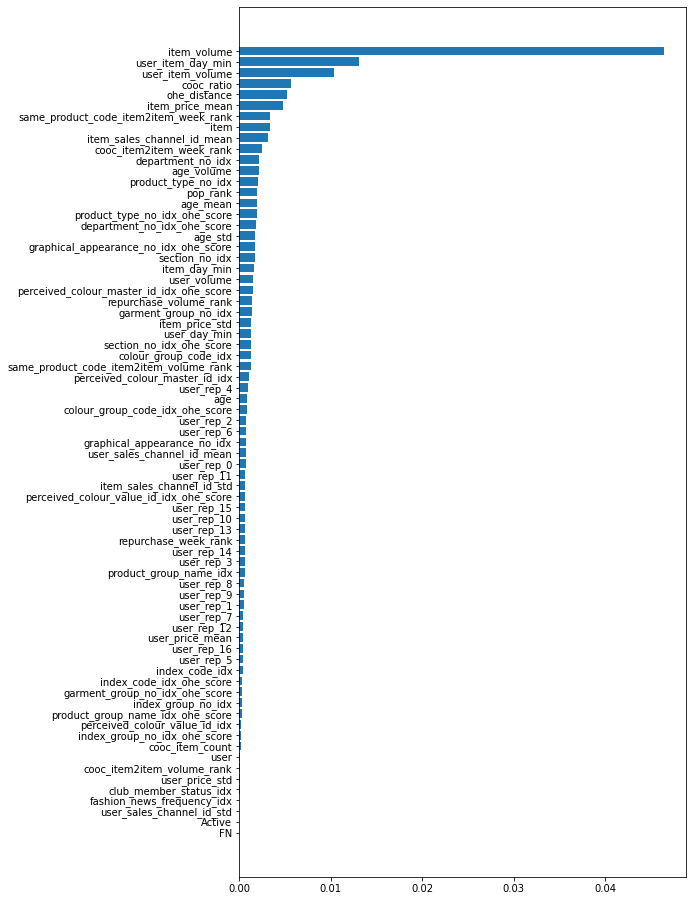

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

11990

In [23]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [24]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 6.160 s


[popular] 1.107 s


[item2item] 6.097 s


[cooccurrence] 13.960 s


[same_product_code] 7.640 s


[ohe distance] 18.868 s


volume: 22245562


duplicates: 1.0381392310907682


            strategy   volume     ratio
0  same_product_code  9190204  0.413125
1                pop  4939128  0.222028
2       ohe_distance  4275973  0.192217
3         repurchase  2735882  0.122986
4               cooc  1104375  0.049645


attach features (week: 0)


[user static fetaures] 2.113 s


[item stacic features] 6.063 s


[user dynamic features (transactions)] 4.283 s


[item dynamic features (transactions)] 3.365 s


[item dynamic features (user features)] 4.071 s


[item freshness features] 5.641 s


[item volume features] 3.807 s


[user freshness features] 7.640 s


[user volume features] 4.764 s


[user-item freshness features] 28.360 s


[user-item volume features] 8.270 s


[item age volume features] 6.907 s


[ohe dot products] 150.695 s


[lfm features] 13.788 s


chunk: 137198
create candidates (week: 0)


[repurchase] 6.375 s


[popular] 1.117 s


[item2item] 6.217 s


[cooccurrence] 13.683 s


[same_product_code] 7.544 s


[ohe distance] 13.447 s


volume: 22277777


duplicates: 1.0380449277871724


            strategy   volume     ratio
0  same_product_code  9210520  0.413440
1                pop  4939128  0.221707
2       ohe_distance  4274077  0.191854
3         repurchase  2752227  0.123541
4               cooc  1101825  0.049458


attach features (week: 0)


[user static fetaures] 2.273 s


[item stacic features] 6.365 s


[user dynamic features (transactions)] 4.547 s


[item dynamic features (transactions)] 3.556 s


[item dynamic features (user features)] 4.320 s


[item freshness features] 5.862 s


[item volume features] 4.030 s


[user freshness features] 7.934 s


[user volume features] 4.868 s


[user-item freshness features] 28.167 s


[user-item volume features] 8.611 s


[item age volume features] 6.906 s


[ohe dot products] 146.139 s


[lfm features] 12.120 s


chunk: 274396
create candidates (week: 0)


[repurchase] 6.137 s


[popular] 1.130 s


[item2item] 6.100 s


[cooccurrence] 13.592 s


[same_product_code] 7.462 s


[ohe distance] 13.490 s


volume: 22184943


duplicates: 1.0380521366008064


            strategy   volume     ratio
0  same_product_code  9167920  0.413250
1                pop  4939128  0.222634
2       ohe_distance  4275911  0.192739
3         repurchase  2708651  0.122094
4               cooc  1093333  0.049283


attach features (week: 0)


[user static fetaures] 2.187 s


[item stacic features] 6.281 s


[user dynamic features (transactions)] 4.639 s


[item dynamic features (transactions)] 3.706 s


[item dynamic features (user features)] 4.397 s


[item freshness features] 6.054 s


[item volume features] 4.147 s


[user freshness features] 8.253 s


[user volume features] 5.050 s


[user-item freshness features] 28.610 s


[user-item volume features] 8.210 s


[item age volume features] 6.990 s


[ohe dot products] 145.422 s


[lfm features] 13.898 s


chunk: 411594
create candidates (week: 0)


[repurchase] 6.322 s


[popular] 1.126 s


[item2item] 6.156 s


[cooccurrence] 13.670 s


[same_product_code] 7.468 s


[ohe distance] 13.693 s


volume: 22260490


duplicates: 1.0380991731297722


            strategy   volume     ratio
0  same_product_code  9204223  0.413478
1                pop  4939128  0.221879
2       ohe_distance  4275076  0.192048
3         repurchase  2737078  0.122957
4               cooc  1104985  0.049639


attach features (week: 0)


[user static fetaures] 2.234 s


[item stacic features] 6.383 s


[user dynamic features (transactions)] 4.536 s


[item dynamic features (transactions)] 3.551 s


[item dynamic features (user features)] 4.302 s


[item freshness features] 5.964 s


[item volume features] 4.035 s


[user freshness features] 8.126 s


[user volume features] 4.902 s


[user-item freshness features] 28.307 s


[user-item volume features] 8.473 s


[item age volume features] 6.899 s


[ohe dot products] 144.069 s


[lfm features] 12.718 s


chunk: 548792
create candidates (week: 0)


[repurchase] 6.154 s


[popular] 1.092 s


[item2item] 6.073 s


[cooccurrence] 13.678 s


[same_product_code] 7.384 s


[ohe distance] 13.548 s


volume: 22250675


duplicates: 1.0381632151158697


            strategy   volume     ratio
0  same_product_code  9190841  0.413059
1                pop  4939128  0.221977
2       ohe_distance  4276533  0.192198
3         repurchase  2739307  0.123111
4               cooc  1104866  0.049655


attach features (week: 0)


[user static fetaures] 2.233 s


[item stacic features] 6.320 s


[user dynamic features (transactions)] 4.483 s


[item dynamic features (transactions)] 3.587 s


[item dynamic features (user features)] 4.300 s


[item freshness features] 5.961 s


[item volume features] 4.020 s


[user freshness features] 8.122 s


[user volume features] 4.888 s


[user-item freshness features] 27.839 s


[user-item volume features] 8.309 s


[item age volume features] 6.838 s


[ohe dot products] 144.288 s


[lfm features] 12.181 s


chunk: 685990
create candidates (week: 0)


[repurchase] 6.369 s


[popular] 1.157 s


[item2item] 6.212 s


[cooccurrence] 13.657 s


[same_product_code] 7.669 s


[ohe distance] 13.751 s


volume: 22313213


duplicates: 1.0382393493656716


            strategy   volume     ratio
0  same_product_code  9243785  0.414274
1                pop  4939128  0.221354
2       ohe_distance  4273560  0.191526
3         repurchase  2745003  0.123021
4               cooc  1111737  0.049824


attach features (week: 0)


[user static fetaures] 2.242 s


[item stacic features] 6.402 s


[user dynamic features (transactions)] 4.549 s


[item dynamic features (transactions)] 3.591 s


[item dynamic features (user features)] 4.315 s


[item freshness features] 5.959 s


[item volume features] 4.035 s


[user freshness features] 8.194 s


[user volume features] 5.015 s


[user-item freshness features] 28.098 s


[user-item volume features] 8.391 s


[item age volume features] 6.956 s


[ohe dot products] 145.643 s


[lfm features] 14.777 s


chunk: 823188
create candidates (week: 0)


[repurchase] 6.254 s


[popular] 1.103 s


[item2item] 6.048 s


[cooccurrence] 13.734 s


[same_product_code] 7.478 s


[ohe distance] 14.204 s


volume: 22204770


duplicates: 1.0384411949984076


            strategy   volume     ratio
0  same_product_code  9166138  0.412800
1                pop  4939128  0.222435
2       ohe_distance  4275160  0.192533
3         repurchase  2714357  0.122242
4               cooc  1109987  0.049989


attach features (week: 0)


[user static fetaures] 2.212 s


[item stacic features] 6.280 s


[user dynamic features (transactions)] 4.715 s


[item dynamic features (transactions)] 3.720 s


[item dynamic features (user features)] 4.418 s


[item freshness features] 6.048 s


[item volume features] 4.143 s


[user freshness features] 8.149 s


[user volume features] 5.079 s


[user-item freshness features] 27.804 s


[user-item volume features] 8.458 s


[item age volume features] 7.069 s


[ohe dot products] 144.418 s


[lfm features] 15.406 s


chunk: 960386
create candidates (week: 0)


[repurchase] 6.244 s


[popular] 1.106 s


[item2item] 6.064 s


[cooccurrence] 13.682 s


[same_product_code] 7.555 s


[ohe distance] 13.752 s


volume: 22224321


duplicates: 1.0382621935765743


            strategy   volume     ratio
0  same_product_code  9175200  0.412845
1                pop  4939128  0.222240
2       ohe_distance  4275309  0.192371
3         repurchase  2731902  0.122924
4               cooc  1102782  0.049621


attach features (week: 0)


[user static fetaures] 2.208 s


[item stacic features] 6.325 s


[user dynamic features (transactions)] 4.516 s


[item dynamic features (transactions)] 3.540 s


[item dynamic features (user features)] 4.270 s


[item freshness features] 5.868 s


[item volume features] 3.978 s


[user freshness features] 7.911 s


[user volume features] 4.862 s


[user-item freshness features] 27.631 s


[user-item volume features] 8.443 s


[item age volume features] 6.916 s


[ohe dot products] 141.818 s


[lfm features] 12.648 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 6.360 s


[popular] 1.104 s


[item2item] 6.015 s


[cooccurrence] 13.772 s


[same_product_code] 7.719 s


[ohe distance] 13.865 s


volume: 22151799


duplicates: 1.0378601240280338


            strategy   volume     ratio
0  same_product_code  9136160  0.412434
1                pop  4939128  0.222967
2       ohe_distance  4273226  0.192906
3         repurchase  2711285  0.122396
4               cooc  1092000  0.049296


attach features (week: 0)


[user static fetaures] 2.226 s


[item stacic features] 6.327 s


[user dynamic features (transactions)] 4.728 s


[item dynamic features (transactions)] 3.718 s


[item dynamic features (user features)] 4.460 s


[item freshness features] 6.107 s


[item volume features] 4.187 s


[user freshness features] 8.300 s


[user volume features] 5.036 s


[user-item freshness features] 27.691 s


[user-item volume features] 8.834 s


[item age volume features] 7.022 s


[ohe dot products] 142.929 s


[lfm features] 14.726 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 6.295 s


[popular] 1.128 s


[item2item] 6.151 s


[cooccurrence] 13.785 s


[same_product_code] 7.554 s


[ohe distance] 13.772 s


volume: 22236776


duplicates: 1.0382287938103627


            strategy   volume     ratio
0  same_product_code  9189583  0.413261
1                pop  4939128  0.222115
2       ohe_distance  4274701  0.192236
3         repurchase  2730747  0.122803
4               cooc  1102617  0.049585


attach features (week: 0)


[user static fetaures] 2.238 s


[item stacic features] 6.359 s


[user dynamic features (transactions)] 4.549 s


[item dynamic features (transactions)] 3.592 s


[item dynamic features (user features)] 4.333 s


[item freshness features] 5.938 s


[item volume features] 4.008 s


[user freshness features] 8.073 s


[user volume features] 4.878 s


[user-item freshness features] 27.812 s


[user-item volume features] 8.366 s


[item age volume features] 6.897 s


[ohe dot products] 143.627 s


[lfm features] 12.493 s


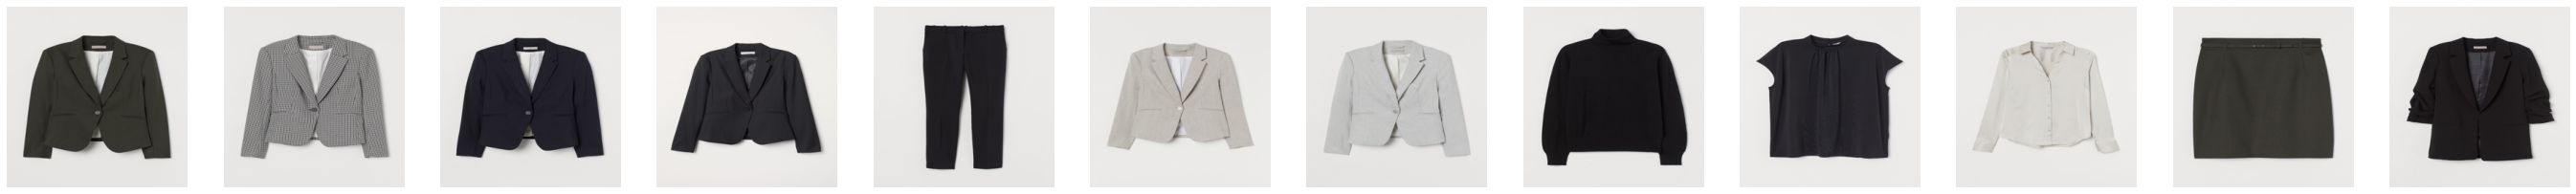

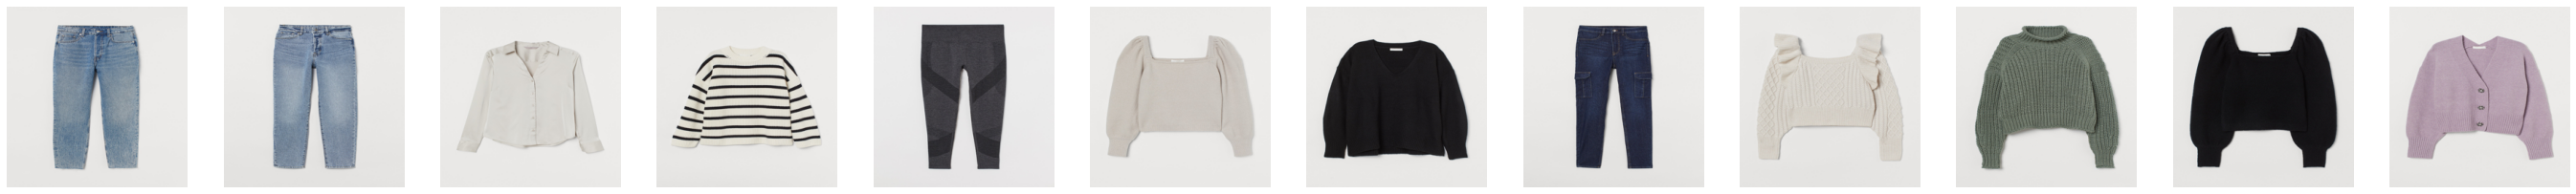

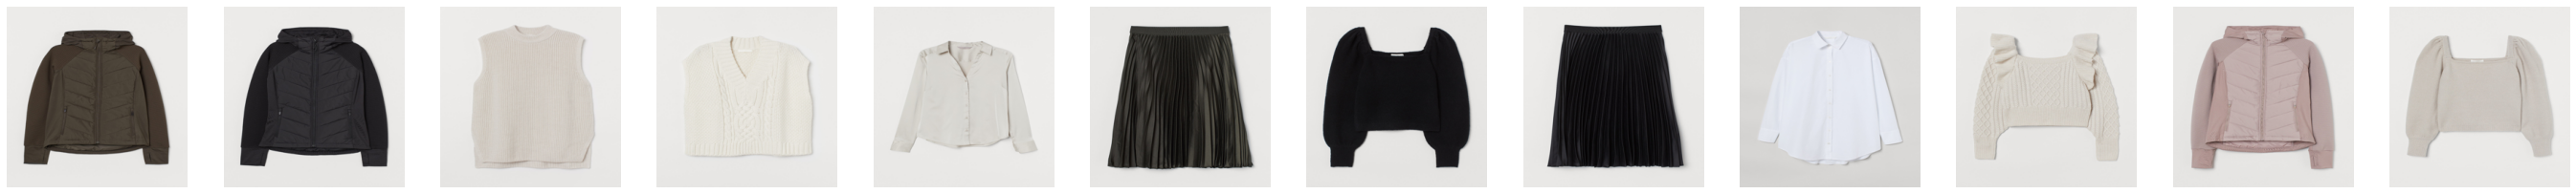

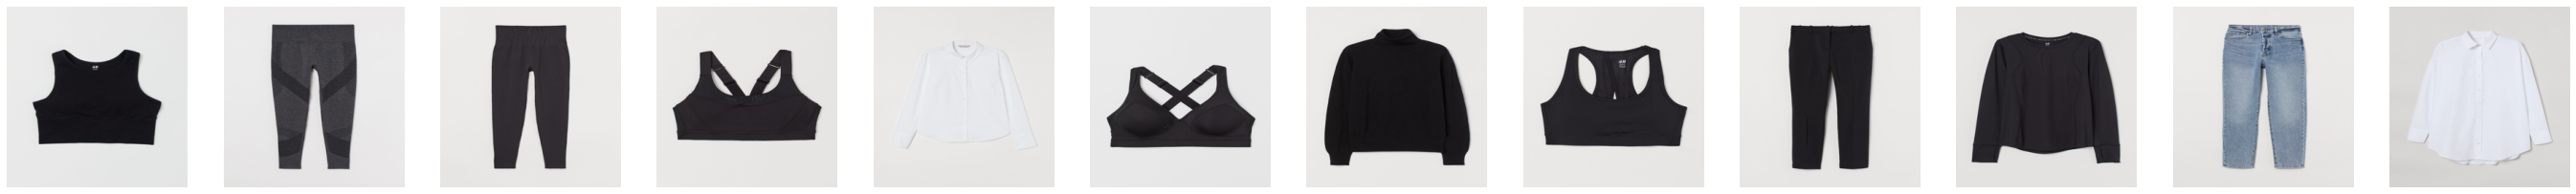

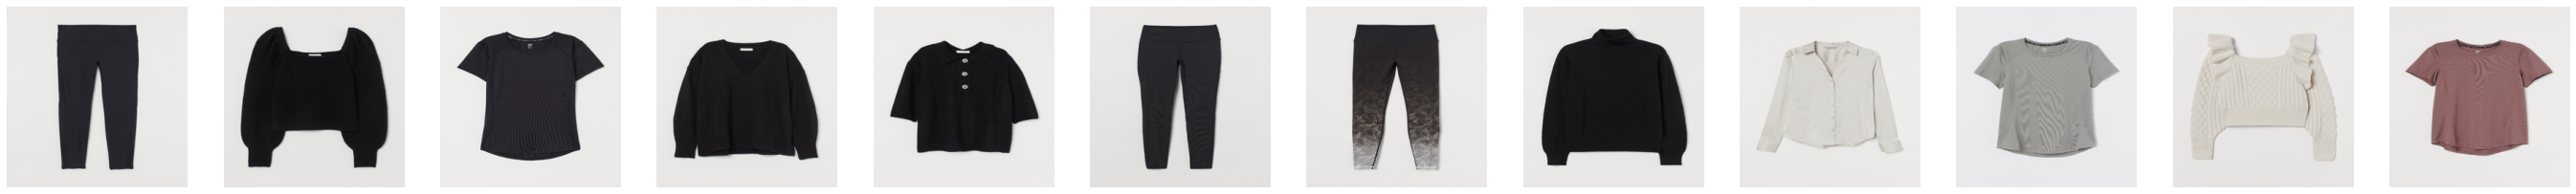

In [25]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [26]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601007 0568601006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0762846027 0863583001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0924243001 0918522001 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0869331006 0918292001 0866731001 0910949002 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0915529003 0791587001 0863646001 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0791587001 0791587015 0804992014 06...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846026 0762846006 0448509014 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846026 0762846006 0762846031 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0821395005 0714790028 07...


In [27]:
submission.to_csv('submission.csv', index=False)